In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from datetime import datetime

#Torch-related imports
import torch
import torch.distributions as D
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Function

#Model-specific imports
from SBM_SDE import *
from obs_and_flow import *
from training import *

In [2]:
torch.manual_seed(0)
devi = torch.device("".join(["cuda:",f'{cuda_id}']) if torch.cuda.is_available() else "cpu")

In [3]:
#Neural SDE parameters
dt_flow = 0.2
t = 380 #In hours.
n = int(t / dt_flow) + 1
t_span = np.linspace(0, t, n)
t_span_tensor = torch.reshape(torch.Tensor(t_span), [1, n, 1]) #T_span needs to be converted to tensor object. Additionally, facilitates conversion of I_S and I_D to tensor objects.
state_dim_SCON = 3 #Not including CO2 in STATE_DIM, because CO2 is an observation.
state_dim_SAWB = 4 #Not including CO2 in STATE_DIM, because CO2 is an observation.

In [4]:
#SBM temperature forcing parameters
temp_ref = 283
temp_rise = 5 #High estimate of 5 celsius temperature rise by 2100.

In [5]:
#Training parameters
niter = 8500
piter = 200
pretrain_lr = 1e-2 #Norm regularization learning rate
train_lr = 1e-3 #ELBO learning rate
batch_size = 5
obs_error_scale = 0.1 #Observation (y) standard deviation
num_layers = 5

In [6]:
#SBM prior means
#System parameters from deterministic CON model
u_M = 0.0009
a_SD = 0.5
a_DS = 0.5
a_M = 0.5
a_MSC = 0.5
k_S_ref = 0.0001
k_D_ref = 0.001
k_M_ref = 0.00022
Ea_S = 55
Ea_D = 48
Ea_M = 48

#SCON diffusion matrix parameters
c_SOC = 0.05
c_DOC = 0.001
c_MBC = 0.0005

SCON_C_params_dict = {'u_M': u_M, 'a_SD': a_SD, 'a_DS': a_DS, 'a_M': a_M, 'a_MSC': a_MSC, 'k_S_ref': k_S_ref, 'k_D_ref': k_D_ref, 'k_M_ref': k_M_ref, 'Ea_S': Ea_S, 'Ea_D': Ea_D, 'Ea_M': Ea_M, 'c_SOC': c_SOC, 'c_DOC': c_DOC, 'c_MBC': c_MBC}

In [7]:
#Initial condition prior means
x0_SCON = [65, 0.4, 2.5]
x0_SCON_tensor = torch.tensor(x0_SCON)
x0_prior_SCON = D.multivariate_normal.MultivariateNormal(x0_SCON_tensor,
                                                         scale_tril=torch.eye(state_dim_SCON) * obs_error_scale * x0_SCON_tensor)

In [8]:
#Generate exogenous input vectors.
#Obtain temperature forcing function.
temp_tensor = temp_gen(t_span_tensor, temp_ref, temp_rise)

#Obtain SOC and DOC pool litter input vectors for use in flow SDE functions.
i_s_tensor = i_s(t_span_tensor) #Exogenous SOC input function
i_d_tensor = i_d(t_span_tensor) #Exogenous DOC input function

In [9]:
#Call training loop function for SCON-C.
net, ELBO_hist = train(devi, pretrain_lr, train_lr, niter, piter, batch_size, num_layers,
          state_dim_SCON, 'y_from_x_t_5000_dt_0-01.csv', obs_error_scale, t, dt_flow, n, 
          t_span_tensor, i_s_tensor, i_d_tensor, temp_tensor, temp_ref,
          drift_diffusion_SCON_C, x0_prior_SCON, SCON_C_params_dict,
          LEARN_PARAMS = False, LR_DECAY = 0.1, DECAY_STEP_SIZE = 1000, PRINT_EVERY = 10)


Train Diffusion:   0%|          | 9/8500 [00:34<8:57:13,  3.80s/it]

Moving average norm loss at 10 iterations is: 574289.40625. Best norm loss value is: 569144.0.

C_PATH mean = tensor([[1.4580, 1.4391, 1.4446],
        [1.4558, 1.4308, 1.4476],
        [1.4609, 1.4371, 1.4465],
        [1.4580, 1.4330, 1.4540],
        [1.4595, 1.4429, 1.4484]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[2.8990, 2.6534, 2.0441],
         [1.9403, 1.9199, 2.4904],
         [2.8834, 1.8115, 2.7542],
         ...,
         [1.3151, 1.3382, 1.3012],
         [1.1771, 1.8702, 1.3909],
         [1.3950, 1.5578, 1.3693]],

        [[1.8498, 2.9279, 2.7291],
         [2.5502, 2.5542, 1.6569],
         [1.8473, 2.1055, 2.4058],
         ...,
         [1.0129, 1.6903, 1.2076],
         [1.3562, 1.1230, 1.1481],
         [1.5341, 1.4143, 1.2733]],

        [[1.4698, 2.9151, 2.3121],
         [2.2997, 2.4588, 2.3552],
         [2.0502, 2.3390, 2.1276],
         ...,
         [1.2437, 1.2078, 1.7167],
         [1.7339, 1.6161, 1.6266],
         [1.0161, 1.1537, 1.1427]],

      


Train Diffusion:   0%|          | 19/8500 [01:13<9:01:56,  3.83s/it]

Moving average norm loss at 20 iterations is: 568562.7875. Best norm loss value is: 566608.75.

C_PATH mean = tensor([[1.9186, 1.7892, 1.8502],
        [1.9032, 1.7911, 1.8578],
        [1.9100, 1.8090, 1.8476],
        [1.9115, 1.8099, 1.8594],
        [1.8942, 1.7964, 1.8472]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[2.3649, 2.8337, 1.5357],
         [1.5932, 2.2296, 1.6302],
         [2.0676, 1.8597, 1.8569],
         ...,
         [2.1487, 2.1943, 1.3981],
         [1.1468, 2.1185, 2.5933],
         [2.2006, 1.9887, 1.6791]],

        [[2.0965, 2.4690, 2.1772],
         [2.0745, 1.5281, 1.5711],
         [2.3918, 1.7500, 1.6617],
         ...,
         [2.2539, 1.7611, 2.4230],
         [2.8070, 1.8475, 1.8656],
         [1.2211, 2.0449, 2.1457]],

        [[1.4306, 2.4641, 1.9059],
         [2.0308, 2.0291, 1.2378],
         [1.9717, 1.4657, 1.5392],
         ...,
         [0.7752, 1.1721, 2.0339],
         [1.9704, 1.8947, 1.3108],
         [2.7678, 1.5360, 2.3439]],

      


Train Diffusion:   0%|          | 29/8500 [01:51<8:51:20,  3.76s/it]

Moving average norm loss at 30 iterations is: 565815.5. Best norm loss value is: 563443.5.

C_PATH mean = tensor([[2.0906, 1.6709, 1.8479],
        [2.1489, 1.6301, 1.8447],
        [2.1403, 1.6395, 1.8401],
        [2.0982, 1.6402, 1.8459],
        [2.1606, 1.6210, 1.8421]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[1.9434, 2.2463, 1.7396],
         [2.0603, 1.2682, 1.5285],
         [3.4244, 1.3291, 1.0841],
         ...,
         [1.3485, 1.5695, 1.6319],
         [1.5125, 1.2967, 1.4842],
         [2.1552, 1.4722, 1.4959]],

        [[1.9434, 2.4003, 1.8146],
         [1.7152, 1.8236, 1.7452],
         [1.8806, 1.6357, 1.9470],
         ...,
         [3.1295, 1.3159, 1.1085],
         [2.5975, 1.2016, 1.8479],
         [2.5548, 1.6391, 1.4279]],

        [[1.9434, 2.1659, 1.7146],
         [2.1757, 1.8818, 1.9624],
         [1.5828, 0.9405, 1.3300],
         ...,
         [1.9669, 1.2493, 1.6792],
         [2.0777, 1.3105, 1.5040],
         [1.4136, 1.6195, 1.6728]],

        [[


Train Diffusion:   0%|          | 39/8500 [02:30<8:58:47,  3.82s/it]

Moving average norm loss at 40 iterations is: 535530.890625. Best norm loss value is: 480310.0.

C_PATH mean = tensor([[13.4510,  1.5192,  2.5448],
        [13.3805,  1.5911,  2.5429],
        [13.8865,  1.5638,  2.7061],
        [12.7037,  1.5709,  2.5099],
        [13.4639,  1.5091,  2.3862]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[2.4449e+00, 1.5668e+00, 1.8265e+00],
         [1.4555e+00, 5.1729e-01, 2.3623e+00],
         [3.5665e+01, 1.0089e-01, 2.2681e+00],
         ...,
         [1.7032e+01, 1.4393e+00, 2.9367e+00],
         [6.3014e+00, 1.0100e+00, 1.3088e+00],
         [1.6182e+01, 1.2049e+00, 9.6231e-01]],

        [[2.7243e-01, 7.2164e-01, 1.8297e+00],
         [4.3650e-01, 2.6091e-01, 2.1828e+00],
         [1.1363e+01, 9.9377e-01, 5.4330e-01],
         ...,
         [1.8393e+01, 9.4403e-01, 1.0504e+00],
         [8.0683e-01, 4.8561e-01, 1.0386e+01],
         [4.1662e+00, 3.5181e+00, 2.0807e+00]],

        [[3.0143e+00, 1.6955e+00, 1.7377e+00],
         [1.0050e+01, 2.6


Train Diffusion:   1%|          | 49/8500 [03:10<10:14:25,  4.36s/it]

Moving average norm loss at 50 iterations is: 372979.81875. Best norm loss value is: 313518.125.

C_PATH mean = tensor([[41.2765,  3.2001,  4.0570],
        [42.3890,  2.9380,  4.0197],
        [40.9889,  3.3173,  4.1396],
        [41.2398,  2.8646,  4.0797],
        [41.8027,  3.0796,  4.0441]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[1.2296e+01, 1.9625e+00, 7.2564e+00],
         [4.2278e+01, 9.1582e+00, 3.4928e+00],
         [6.5732e+01, 2.5395e+00, 1.3966e+00],
         ...,
         [2.3219e-05, 2.5544e+01, 3.5284e+00],
         [8.4726e+01, 9.3368e-01, 1.5674e+00],
         [1.0000e-06, 8.1149e-01, 9.4808e+00]],

        [[1.0962e-04, 1.6778e+01, 2.4797e+00],
         [6.3832e+01, 6.1761e+00, 7.3894e-01],
         [4.2875e+01, 1.2174e+00, 8.1096e+00],
         ...,
         [6.9591e+01, 7.0540e-01, 1.3283e+00],
         [5.9737e+01, 2.1854e+00, 1.2094e+00],
         [5.1335e+01, 8.3833e-01, 4.4450e+00]],

        [[1.4193e+01, 5.8329e+00, 2.3145e+00],
         [3.0137e+01, 2.


Train Diffusion:   1%|          | 59/8500 [03:49<8:45:28,  3.74s/it]

Moving average norm loss at 60 iterations is: 260993.0328125. Best norm loss value is: 230486.40625.

C_PATH mean = tensor([[42.9534,  2.5045,  3.0711],
        [44.0542,  2.4623,  2.9025],
        [42.6711,  2.4330,  3.0360],
        [43.9402,  2.3845,  2.8885],
        [43.0472,  2.4402,  3.0423]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[1.2500e+01, 2.5035e+01, 2.0872e+01],
         [5.2804e+01, 8.3518e+00, 2.8103e+00],
         [6.6998e+01, 6.8116e-01, 1.6069e+00],
         ...,
         [4.8740e+01, 1.8487e+00, 1.1152e-01],
         [5.0643e+01, 7.6453e-01, 5.2234e+00],
         [6.3882e+01, 3.8242e-01, 1.8322e+00]],

        [[3.1359e-06, 2.4834e+01, 5.7165e+00],
         [6.0586e+01, 1.0061e-01, 2.8340e+00],
         [5.2868e+01, 5.3561e+00, 1.3851e+00],
         ...,
         [6.6393e+01, 2.4493e-01, 1.3139e+00],
         [1.0004e-06, 1.8530e+00, 8.2555e-01],
         [1.9953e+00, 3.4146e+00, 1.3498e+01]],

        [[1.5426e+01, 3.9063e+00, 1.5742e+00],
         [5.9744e+01


Train Diffusion:   1%|          | 69/8500 [04:28<8:45:57,  3.74s/it]

Moving average norm loss at 70 iterations is: 205329.1609375. Best norm loss value is: 187409.625.

C_PATH mean = tensor([[46.3855,  1.0057,  2.5440],
        [46.0753,  0.9696,  2.4457],
        [44.8000,  0.9545,  2.5593],
        [45.4852,  0.9456,  2.4815],
        [46.4585,  0.9449,  2.5578]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[1.7377e+01, 8.0013e+00, 1.6136e+00],
         [6.8240e+01, 4.7724e-01, 1.9789e+00],
         [5.9543e+01, 4.8659e-01, 1.9309e+00],
         ...,
         [1.3379e-06, 1.3581e+00, 1.3766e+00],
         [1.0003e-06, 1.3571e+00, 2.0517e+00],
         [6.0314e+01, 7.3243e-01, 1.9968e+00]],

        [[1.7352e-06, 1.8232e+01, 2.9132e+00],
         [6.0221e+01, 3.2473e-01, 2.0695e+00],
         [6.3640e+01, 3.9841e-01, 1.8922e+00],
         ...,
         [6.1772e+01, 4.8222e-01, 1.8219e+00],
         [5.6683e+01, 4.5818e-01, 1.9415e+00],
         [6.1294e+01, 5.1037e-01, 1.9894e+00]],

        [[1.6346e+01, 1.7302e+00, 5.4269e+00],
         [1.2307e-06, 


Train Diffusion:   1%|          | 79/8500 [05:09<10:06:55,  4.32s/it]

Moving average norm loss at 80 iterations is: 175131.9765625. Best norm loss value is: 158369.34375.

C_PATH mean = tensor([[47.1216,  0.8734,  2.1568],
        [46.8548,  0.9342,  2.1653],
        [47.7616,  0.9145,  2.1086],
        [46.2840,  0.8780,  2.1126],
        [47.1061,  0.8719,  2.1426]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[1.3196e-05, 1.4104e+01, 1.7761e+00],
         [1.0020e-06, 7.7403e-01, 1.9300e+00],
         [5.8078e+01, 7.6609e-01, 1.8365e+00],
         ...,
         [5.8094e+01, 6.6743e-01, 1.7927e+00],
         [1.0093e-06, 6.8798e-01, 1.6997e+00],
         [6.1766e+01, 8.1025e-01, 1.6733e+00]],

        [[5.2787e+00, 1.8766e+01, 1.0388e+01],
         [5.2183e+01, 5.5743e+00, 1.7517e+00],
         [6.1888e+01, 5.4353e-01, 1.9969e+00],
         ...,
         [1.0000e-06, 7.3272e-01, 1.9552e+00],
         [6.1075e+01, 5.9755e-01, 2.0039e+00],
         [4.9039e+01, 9.6312e-01, 1.5423e+00]],

        [[2.1573e+01, 5.6769e+00, 1.8209e+00],
         [6.9388e+01


Train Diffusion:   1%|          | 89/8500 [05:52<8:55:57,  3.82s/it]

Moving average norm loss at 90 iterations is: 155281.3734375. Best norm loss value is: 151619.953125.

C_PATH mean = tensor([[46.1461,  1.0504,  2.1604],
        [45.5102,  1.0932,  2.2521],
        [46.4269,  0.9806,  2.1316],
        [46.9767,  1.0701,  2.2231],
        [47.8309,  1.0392,  2.2019]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[1.3883e-05, 1.1765e+01, 1.9177e+00],
         [5.8856e+01, 7.5910e-01, 1.9279e+00],
         [6.6704e+01, 7.5972e-01, 1.8887e+00],
         ...,
         [6.0175e+01, 8.0393e-01, 1.7207e+00],
         [5.8727e+01, 8.0391e-01, 1.9147e+00],
         [5.9624e+01, 8.0341e-01, 1.8617e+00]],

        [[2.2187e+01, 5.3646e+00, 1.8394e+00],
         [5.8442e+01, 8.1604e-01, 1.9099e+00],
         [5.8223e+01, 8.4428e-01, 1.8982e+00],
         ...,
         [6.0099e+01, 8.0778e-01, 1.8885e+00],
         [2.8561e-06, 8.2299e-01, 2.0059e+00],
         [1.0126e-06, 8.0140e-01, 1.9934e+00]],

        [[1.9600e+01, 8.6379e+00, 1.9988e+00],
         [5.9187e+0


Train Diffusion:   1%|          | 99/8500 [06:28<8:51:58,  3.80s/it]

Moving average norm loss at 100 iterations is: 147563.34375. Best norm loss value is: 141184.421875.

C_PATH mean = tensor([[47.1336,  0.9706,  2.0969],
        [47.5956,  0.9115,  1.9986],
        [47.4027,  0.9421,  2.0511],
        [47.2443,  0.9504,  2.1063],
        [47.4724,  0.9966,  2.0422]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[2.0025e+01, 6.4115e+00, 1.7603e+00],
         [2.6521e-02, 7.7603e-01, 1.9005e+00],
         [6.0878e+01, 5.2242e-01, 1.8197e+00],
         ...,
         [1.0000e-06, 7.1293e-01, 1.8148e+00],
         [6.1224e+01, 7.3418e-01, 1.8314e+00],
         [5.9524e+01, 7.6168e-01, 1.8586e+00]],

        [[1.4300e-06, 1.2662e+01, 2.0073e+00],
         [6.9921e+01, 7.0282e-01, 1.8714e+00],
         [1.6744e-06, 7.5782e-01, 1.7365e+00],
         ...,
         [6.0295e+01, 7.5557e-01, 1.8145e+00],
         [5.4049e-04, 7.5129e-01, 1.8299e+00],
         [6.0261e+01, 8.4281e-01, 1.8093e+00]],

        [[2.1317e+01, 9.6055e+00, 1.8372e+00],
         [6.8721e+01


Train Diffusion:   1%|▏         | 109/8500 [07:05<8:31:35,  3.66s/it]

Moving average norm loss at 110 iterations is: 142326.4640625. Best norm loss value is: 139971.40625.

C_PATH mean = tensor([[48.6903,  1.1633,  1.9428],
        [48.4003,  1.1483,  2.0146],
        [46.6544,  1.1546,  1.9492],
        [48.2962,  1.2051,  1.9393],
        [47.3200,  1.1751,  2.0306]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[2.1493e+01, 7.1302e+00, 1.6731e+00],
         [3.2777e+01, 9.5909e-01, 4.7462e+00],
         [2.8257e+01, 2.5549e+00, 1.7408e+00],
         ...,
         [1.7985e-06, 5.8406e-01, 1.8827e+00],
         [5.8524e+01, 8.2878e-01, 1.6794e+00],
         [6.0454e+01, 8.9601e-01, 1.7001e+00]],

        [[2.1388e+01, 3.3540e+00, 1.6705e+00],
         [7.1919e-01, 9.1107e-01, 1.7112e+00],
         [5.8825e+01, 8.4640e-01, 1.6508e+00],
         ...,
         [5.7659e+01, 8.4596e-01, 1.6456e+00],
         [7.3189e+01, 8.8332e-01, 1.6745e+00],
         [6.1979e+01, 9.8168e-01, 1.6864e+00]],

        [[2.3619e-06, 1.0929e+01, 1.7822e+00],
         [6.6551e+0


Train Diffusion:   1%|▏         | 119/8500 [07:42<8:34:48,  3.69s/it]

Moving average norm loss at 120 iterations is: 130910.0109375. Best norm loss value is: 123126.4921875.

C_PATH mean = tensor([[48.7706,  0.7759,  2.3884],
        [49.0315,  0.8204,  2.5411],
        [48.2695,  0.7550,  2.4501],
        [49.5885,  0.7337,  2.3495],
        [48.1729,  0.8157,  2.4383]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[2.4882e+01, 6.0881e+00, 2.2916e+00],
         [6.2619e+01, 6.8170e-01, 2.2078e+00],
         [9.4323e+00, 6.2000e-01, 2.0740e+00],
         ...,
         [5.3273e+00, 6.0557e-01, 2.0348e+00],
         [5.7074e+01, 5.5049e-01, 2.2588e+00],
         [5.8901e+01, 5.9192e-01, 2.3435e+00]],

        [[2.4104e+01, 5.5387e+00, 2.3502e+00],
         [6.2359e+01, 6.8251e-01, 2.4125e+00],
         [6.0148e+01, 6.2869e-01, 2.3101e+00],
         ...,
         [5.9168e+01, 6.0812e-01, 2.2782e+00],
         [6.1212e+01, 6.0525e-01, 2.3368e+00],
         [1.6939e+01, 6.3052e-01, 2.0754e+00]],

        [[2.4726e+01, 5.6336e+00, 2.2959e+00],
         [1.6100e


Train Diffusion:   2%|▏         | 129/8500 [08:17<8:15:08,  3.55s/it]

Moving average norm loss at 130 iterations is: 85969.61796875. Best norm loss value is: 48516.9921875.

C_PATH mean = tensor([[55.7737,  1.0630,  2.0294],
        [56.0445,  0.9912,  1.9361],
        [56.0641,  0.9771,  1.9419],
        [56.2661,  0.9750,  1.9059],
        [55.8665,  0.9791,  1.9550]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[19.5404,  9.3674,  4.0133],
         [58.1261,  0.7944,  1.6819],
         [60.0598,  0.8131,  1.6662],
         ...,
         [30.7436,  3.8350,  1.7818],
         [59.6826,  0.7908,  1.7074],
         [59.7708,  0.7823,  1.5402]],

        [[22.0627,  6.4463,  1.6350],
         [59.5855,  0.8712,  1.3747],
         [58.4625,  0.7079,  1.6476],
         ...,
         [52.0889,  2.9812,  6.5979],
         [20.2101,  1.2479,  5.2389],
         [48.2475,  0.7514,  1.7636]],

        [[ 6.0353,  8.2186,  1.7841],
         [60.5615,  0.8911,  1.6736],
         [59.9968,  0.8123,  1.6680],
         ...,
         [60.5950,  1.0497,  1.7085],
       


Train Diffusion:   2%|▏         | 139/8500 [08:53<8:14:39,  3.55s/it]

Moving average norm loss at 140 iterations is: 39728.683984375. Best norm loss value is: 30950.0.

C_PATH mean = tensor([[61.6148,  1.1355,  2.1569],
        [61.5635,  1.2368,  2.0525],
        [61.7166,  1.1122,  2.1178],
        [61.6430,  1.1466,  2.0794],
        [61.5145,  1.2528,  2.1104]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[23.9683,  6.7339,  1.6793],
         [60.6346,  0.9162,  1.7980],
         [62.6770,  0.9990,  1.8664],
         ...,
         [61.4368,  1.0035,  1.7217],
         [62.8355,  0.9755,  1.6892],
         [59.8989,  1.0724,  1.6378]],

        [[15.2186,  8.2225,  1.6491],
         [65.9715,  1.1989,  1.7636],
         [62.1091,  0.9943,  1.8447],
         ...,
         [64.3835,  0.8900,  1.7460],
         [59.1602,  2.0617,  1.6337],
         [64.3304,  1.0333,  1.7054]],

        [[23.8626,  6.8081,  1.7037],
         [61.1814,  1.0342,  1.7203],
         [61.1261,  0.9349,  1.7363],
         ...,
         [60.1506,  0.9577,  1.6293],
         [65


Train Diffusion:   2%|▏         | 149/8500 [09:29<8:15:10,  3.56s/it]

Moving average norm loss at 150 iterations is: 23799.16689453125. Best norm loss value is: 15495.533203125.

C_PATH mean = tensor([[59.5125,  0.8797,  1.9798],
        [59.6688,  0.9019,  1.9015],
        [59.6036,  0.8893,  1.9473],
        [59.5691,  0.9226,  1.9548],
        [59.3469,  0.9552,  2.0899]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[20.1835,  8.9861,  1.7200],
         [60.8990,  0.8201,  1.4846],
         [60.2568,  0.6755,  1.7403],
         ...,
         [37.9614,  1.0905,  1.7216],
         [60.1334,  0.7257,  1.8558],
         [60.8575,  0.7371,  1.6776]],

        [[18.5582,  9.6046,  2.2785],
         [62.4922,  0.6712,  1.6778],
         [60.4848,  0.7508,  1.4376],
         ...,
         [60.9015,  0.7589,  1.8586],
         [60.3771,  0.7570,  1.4853],
         [60.4068,  0.8016,  1.9175]],

        [[20.1831,  8.8804,  1.5965],
         [61.1767,  0.8166,  2.1250],
         [59.6789,  0.7222,  1.7607],
         ...,
         [56.9941,  0.7258,  1.9994],
  


Train Diffusion:   2%|▏         | 159/8500 [10:08<9:01:39,  3.90s/it]

Moving average norm loss at 160 iterations is: 21903.918359375. Best norm loss value is: 15495.533203125.

C_PATH mean = tensor([[58.7987,  1.1487,  2.2121],
        [58.9371,  1.0766,  2.1644],
        [58.7006,  1.1266,  2.2576],
        [58.7965,  1.1156,  2.2107],
        [58.8577,  1.0549,  2.2172]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[21.2920,  8.1410,  1.9712],
         [58.9671,  0.8408,  2.0475],
         [59.6993,  0.8243,  2.0224],
         ...,
         [60.2467,  0.8003,  1.9329],
         [59.4621,  0.8158,  1.9740],
         [59.4380,  0.8253,  1.8800]],

        [[21.2920,  8.0774,  1.9654],
         [58.9483,  0.8380,  2.0321],
         [60.4159,  0.8162,  2.0100],
         ...,
         [59.4590,  0.8190,  1.9527],
         [59.5285,  0.8323,  1.7289],
         [58.4859,  0.8425,  2.0053]],

        [[21.2920,  8.2074,  1.9465],
         [58.9051,  0.8403,  1.7391],
         [59.0833,  0.8315,  1.9553],
         ...,
         [59.4013,  0.8467,  1.9957],
    


Train Diffusion:   2%|▏         | 169/8500 [10:46<8:49:53,  3.82s/it]

Moving average norm loss at 170 iterations is: 20975.14462890625. Best norm loss value is: 15495.533203125.

C_PATH mean = tensor([[59.1354,  0.9693,  2.1832],
        [59.3148,  0.9060,  2.0884],
        [59.2949,  0.8570,  2.0936],
        [59.1358,  1.0091,  2.1276],
        [59.3755,  0.8510,  2.0908]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[21.8189, 11.6934, 32.8898],
         [13.8027, 19.3227,  1.8109],
         [60.0343,  0.6980,  1.9063],
         ...,
         [60.3361,  0.7117,  1.8526],
         [60.5130,  0.7147,  1.8314],
         [58.8940,  0.6974,  1.8254]],

        [[21.8190,  6.7151,  1.7682],
         [60.5425,  0.7447,  1.9255],
         [59.8375,  0.7133,  1.8329],
         ...,
         [60.2490,  0.6898,  1.8607],
         [59.7980,  0.7106,  1.8464],
         [60.0866,  0.7114,  1.9054]],

        [[21.8190,  6.5474,  1.7611],
         [60.4195,  0.7319,  1.9052],
         [59.3789,  0.7186,  1.8278],
         ...,
         [60.2857,  0.7021,  1.8296],
  


Train Diffusion:   2%|▏         | 179/8500 [11:24<8:42:35,  3.77s/it]

Moving average norm loss at 180 iterations is: 21748.4767578125. Best norm loss value is: 15495.533203125.

C_PATH mean = tensor([[59.3156,  1.2864,  2.3306],
        [59.1545,  1.3244,  2.3636],
        [59.0812,  1.3162,  2.4170],
        [59.0229,  1.4081,  2.4380],
        [58.9910,  1.4245,  2.4617]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[22.7367,  6.3389,  2.0596],
         [58.3567,  0.9585,  2.1128],
         [62.3195,  0.9676,  2.0518],
         ...,
         [59.0836,  0.9346,  2.0748],
         [62.5537,  0.9246,  2.0470],
         [58.7333,  0.9429,  2.0447]],

        [[22.7367,  6.0818,  2.0256],
         [57.5568,  1.1989,  2.2347],
         [60.0065,  0.9779,  1.9850],
         ...,
         [60.0173,  0.9930,  2.0316],
         [59.3774,  1.0221,  2.0902],
         [59.9994,  1.0060,  2.0023]],

        [[22.7367,  6.8644,  2.1307],
         [62.5722,  0.9938,  2.0328],
         [59.6852,  0.9654,  2.0615],
         ...,
         [60.4763,  1.0143,  1.9891],
   


Train Diffusion:   2%|▏         | 189/8500 [12:02<8:28:01,  3.67s/it]

Moving average norm loss at 190 iterations is: 24094.13203125. Best norm loss value is: 15495.533203125.

C_PATH mean = tensor([[60.9429,  1.0735,  1.9118],
        [61.0588,  1.0552,  1.9156],
        [60.7184,  1.2015,  2.0205],
        [60.7203,  1.0663,  2.0420],
        [60.9852,  1.0699,  1.9324]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[23.0929,  6.0255,  1.7296],
         [62.1268,  0.9761,  1.7409],
         [56.9197,  0.9497,  1.7536],
         ...,
         [62.1469,  0.9622,  1.7306],
         [62.3230,  0.9500,  1.7519],
         [62.4503,  0.9342,  1.7746]],

        [[23.1021,  5.7559,  1.6826],
         [60.9620,  0.9570,  1.7402],
         [61.6934,  0.9736,  1.7519],
         ...,
         [62.3351,  0.9662,  1.7062],
         [62.2109,  0.9855,  1.7165],
         [58.2482,  0.9544,  1.7475]],

        [[23.0996,  5.1889,  1.7046],
         [62.2106,  0.9939,  1.7896],
         [62.4912,  0.9586,  1.6933],
         ...,
         [63.0678,  0.9194,  1.7170],
     


Train Diffusion:   2%|▏         | 199/8500 [12:38<8:21:59,  3.63s/it]

Moving average norm loss at 200 iterations is: 16847.8873046875. Best norm loss value is: 12845.19140625.

C_PATH mean = tensor([[59.5052,  0.9591,  1.9471],
        [59.4338,  1.0035,  1.9649],
        [59.3076,  1.0481,  1.9693],
        [59.3993,  1.0324,  1.9262],
        [59.5293,  0.9671,  1.9808]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[22.5987,  4.5525,  2.1740],
         [61.3075,  1.1086,  1.5390],
         [59.9976,  0.8576,  1.8078],
         ...,
         [60.2112,  0.8532,  1.8632],
         [60.9191,  0.9615,  1.7343],
         [60.3094,  0.8660,  1.7721]],

        [[22.5987,  8.4523, 36.8450],
         [13.4491, 23.9004,  1.8811],
         [60.2624,  0.8377,  1.7737],
         ...,
         [59.6887,  2.5590,  1.7159],
         [56.4034,  0.9111,  1.7038],
         [60.0827,  0.8400,  1.8702]],

        [[22.5987,  6.3752,  2.0450],
         [60.0197,  0.8769,  1.7792],
         [58.8619,  0.8170,  1.8125],
         ...,
         [60.7482,  0.8919,  1.7763],
    


Train Diffusion:   2%|▏         | 209/8500 [13:15<8:29:16,  3.69s/it]

Moving average ELBO loss at 210 iterations is: 119737610.4. Best ELBO loss value is: 86106664.0.

C_PATH mean = tensor([[60.0255,  0.8907,  2.4467],
        [60.0144,  0.9155,  2.4361],
        [59.9925,  0.8650,  2.4933],
        [60.0167,  0.8563,  2.4369],
        [60.0768,  0.9059,  2.4141]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[22.6826,  4.1827,  2.2116],
         [61.5587,  0.6948,  2.3269],
         [59.8444,  0.7443,  2.2784],
         ...,
         [60.1950,  0.6786,  2.2738],
         [61.2738,  0.7130,  2.3117],
         [61.3203,  0.7184,  2.2224]],

        [[22.6826,  2.7936,  2.1793],
         [61.8158,  0.7016,  1.9053],
         [60.7154,  0.6614,  2.2936],
         ...,
         [61.1170,  0.6882,  1.9390],
         [60.9890,  0.7206,  2.0644],
         [61.0350,  0.7134,  2.2420]],

        [[22.6826,  4.2074,  2.1964],
         [61.5525,  0.6943,  2.3266],
         [61.3113,  0.5952,  1.9703],
         ...,
         [60.2039,  0.4764,  2.3119],
         [60


Train Diffusion:   3%|▎         | 219/8500 [13:52<8:27:05,  3.67s/it]

Moving average ELBO loss at 220 iterations is: 103961367.2. Best ELBO loss value is: 84308952.0.

C_PATH mean = tensor([[60.2824,  0.8126,  2.4861],
        [60.2468,  0.8112,  2.4931],
        [60.2546,  0.7879,  2.5593],
        [60.3390,  0.7801,  2.4615],
        [60.2109,  0.7568,  2.5617]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[22.4066,  3.6358,  3.8277],
         [52.7206,  0.9715,  2.3704],
         [61.8091,  0.3120,  2.4523],
         ...,
         [61.5216,  0.3898,  2.4953],
         [59.7876,  0.7057,  2.4876],
         [59.0970,  0.7485,  2.3352]],

        [[22.4066,  0.9631,  2.5302],
         [62.1577,  0.3734,  2.4477],
         [61.3823,  0.6725,  2.4475],
         ...,
         [59.7522,  0.6941,  2.4902],
         [60.4792,  0.7153,  2.4522],
         [62.0598,  0.8112,  2.3702]],

        [[22.4066,  1.9237,  2.2123],
         [63.4877,  0.7388,  2.6293],
         [61.8787,  0.6415,  1.9176],
         ...,
         [61.7699,  0.6955,  2.4986],
         [61


Train Diffusion:   3%|▎         | 229/8500 [14:29<8:31:19,  3.71s/it]

Moving average ELBO loss at 230 iterations is: 67207997.2. Best ELBO loss value is: 43096544.0.

C_PATH mean = tensor([[60.2061,  0.7014,  2.5406],
        [60.2364,  0.7496,  2.4735],
        [60.2188,  0.7750,  2.5555],
        [60.2479,  0.6959,  2.4997],
        [60.2607,  0.7451,  2.4681]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[22.0013,  0.3147,  2.4842],
         [63.9824,  0.7188,  1.9367],
         [61.2949,  0.2874,  2.5957],
         ...,
         [61.8727,  0.6959,  2.5198],
         [62.1258,  0.2831,  2.0789],
         [60.3591,  0.7974,  2.3563]],

        [[22.0013,  0.8459,  2.4613],
         [63.9161,  0.7269,  2.6774],
         [62.2520,  0.6417,  2.5020],
         ...,
         [59.7009,  0.6908,  2.5603],
         [60.4257,  0.7302,  2.4941],
         [62.1485,  0.7724,  2.4326]],

        [[22.0013,  1.2999,  2.5037],
         [59.6741,  0.3421,  2.4704],
         [61.5962,  0.6521,  2.0674],
         ...,
         [61.9187,  0.6917,  1.9780],
         [61.


Train Diffusion:   3%|▎         | 239/8500 [15:06<8:32:56,  3.73s/it]

Moving average ELBO loss at 240 iterations is: 43210942.2. Best ELBO loss value is: 27742762.0.

C_PATH mean = tensor([[59.7794,  0.7088,  2.5965],
        [59.7472,  0.7278,  2.5413],
        [59.9571,  0.6984,  2.5286],
        [59.6070,  0.7165,  2.5801],
        [59.9440,  0.7308,  2.5735]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[21.7504,  0.2648,  2.8234],
         [63.7153,  0.6844,  2.0832],
         [61.8843,  0.6657,  2.6734],
         ...,
         [62.2355,  0.3618,  2.6463],
         [62.7721,  0.7146,  2.5951],
         [62.6388,  0.7150,  2.1633]],

        [[21.7504,  0.8480,  2.8094],
         [63.8669,  0.2866,  2.5882],
         [60.2497,  0.6398,  2.5465],
         ...,
         [62.6820,  0.6999,  2.5488],
         [62.6437,  0.6949,  2.2990],
         [61.8891,  0.7233,  2.5248]],

        [[21.7504,  1.3403,  2.4399],
         [61.0325,  0.7074,  2.5712],
         [62.7106,  0.6073,  2.5304],
         ...,
         [62.5291,  0.6908,  2.1078],
         [61.


Train Diffusion:   3%|▎         | 249/8500 [15:45<8:46:09,  3.83s/it]

Moving average ELBO loss at 250 iterations is: 29279006.2. Best ELBO loss value is: 21405726.0.

C_PATH mean = tensor([[59.3380,  0.7054,  2.6192],
        [59.6853,  0.7003,  2.5972],
        [59.4981,  0.6865,  2.5904],
        [59.4224,  0.7047,  2.5673],
        [59.5122,  0.6887,  2.5967]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[21.5959,  0.6474,  2.6834],
         [66.4602,  0.7406,  2.8719],
         [63.1850,  0.6104,  2.6153],
         ...,
         [62.0287,  0.6142,  2.6765],
         [63.0198,  0.3406,  2.4181],
         [63.3637,  0.7414,  2.5869]],

        [[21.5959,  0.3415,  2.8017],
         [66.3304,  0.3368,  2.7550],
         [60.6395,  0.6448,  2.1460],
         ...,
         [60.7784,  0.3583,  2.6083],
         [51.0092,  0.8927,  2.6775],
         [62.6574,  0.3495,  2.4620]],

        [[21.5959,  0.4092,  2.6344],
         [63.1344,  0.7365,  2.0346],
         [55.4656,  0.7369,  2.6919],
         ...,
         [63.7584,  0.7151,  2.7532],
         [62.


Train Diffusion:   3%|▎         | 259/8500 [16:21<8:25:53,  3.68s/it]

Moving average ELBO loss at 260 iterations is: 24417992.2. Best ELBO loss value is: 20165942.0.

C_PATH mean = tensor([[59.2802,  0.6878,  2.6123],
        [59.3847,  0.6771,  2.6000],
        [59.2276,  0.6922,  2.5888],
        [59.1308,  0.7001,  2.5902],
        [59.2548,  0.6938,  2.5979]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[21.6890,  0.6351,  3.0408],
         [64.6289,  0.7222,  2.7819],
         [60.1573,  0.6053,  2.6354],
         ...,
         [56.2113,  0.7764,  2.5566],
         [63.8093,  0.6910,  2.6360],
         [63.2809,  0.3394,  2.4315]],

        [[21.3429,  1.2802,  2.5409],
         [61.9111,  0.6385,  2.5166],
         [63.5906,  0.2552,  2.6236],
         ...,
         [63.1491,  0.6695,  2.1591],
         [60.5500,  0.7356,  2.7483],
         [63.2910,  0.6790,  2.5715]],

        [[21.6975,  0.2290,  2.9502],
         [61.6865,  0.3629,  1.8825],
         [45.8387,  0.9320,  2.6376],
         ...,
         [60.5061,  0.6706,  2.7059],
         [58.


Train Diffusion:   3%|▎         | 269/8500 [16:57<8:28:50,  3.71s/it]

Moving average ELBO loss at 270 iterations is: 20633135.0. Best ELBO loss value is: 16569584.0.

C_PATH mean = tensor([[59.4776,  0.6659,  2.5219],
        [59.2136,  0.6960,  2.5328],
        [59.1666,  0.6845,  2.5285],
        [59.3482,  0.6682,  2.5077],
        [59.3083,  0.6593,  2.5319]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[21.9017,  0.3920,  2.7247],
         [64.0087,  0.6547,  2.5739],
         [61.4604,  0.6810,  1.9018],
         ...,
         [62.2060,  0.3984,  2.2239],
         [59.7865,  0.4096,  2.6549],
         [62.1439,  0.6861,  2.4981]],

        [[21.9000,  0.3777,  2.7174],
         [60.6980,  0.6937,  2.3611],
         [55.4692,  0.3528,  2.4703],
         ...,
         [61.6722,  0.5585,  2.5499],
         [62.8505,  0.6780,  2.5651],
         [63.0678,  0.6758,  2.4925]],

        [[21.8983,  0.5645,  2.7258],
         [64.0306,  0.6861,  2.6679],
         [63.3437,  0.6219,  2.5274],
         ...,
         [62.3842,  0.6978,  2.5342],
         [59.


Train Diffusion:   3%|▎         | 279/8500 [17:32<7:54:15,  3.46s/it]

Moving average ELBO loss at 280 iterations is: 17831315.0. Best ELBO loss value is: 13449245.0.

C_PATH mean = tensor([[59.2820,  0.6700,  2.5050],
        [59.0443,  0.6798,  2.4798],
        [58.9469,  0.6862,  2.4931],
        [59.2724,  0.6694,  2.5016],
        [59.2357,  0.6753,  2.4844]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[21.9161,  0.8727,  2.4526],
         [61.8490,  0.6494,  2.5206],
         [62.3271,  0.6065,  2.4788],
         ...,
         [60.1320,  0.6964,  2.4902],
         [62.2501,  0.6759,  2.4783],
         [62.5845,  0.6645,  2.4843]],

        [[20.1010,  1.3848,  2.3578],
         [57.6800,  0.7004,  2.5615],
         [56.2027,  0.6503,  2.5275],
         ...,
         [61.9339,  0.6518,  2.5045],
         [61.5617,  0.6426,  2.1820],
         [52.8859,  0.8668,  2.4909]],

        [[22.0776,  0.4965,  2.4902],
         [63.3974,  0.6751,  2.6498],
         [62.2853,  0.6085,  2.4758],
         ...,
         [62.1514,  0.4316,  2.3116],
         [60.


Train Diffusion:   3%|▎         | 289/8500 [18:08<8:23:24,  3.68s/it]

Moving average ELBO loss at 290 iterations is: 13621720.6. Best ELBO loss value is: 10623340.0.

C_PATH mean = tensor([[59.1960,  0.6406,  2.4808],
        [58.8267,  0.6753,  2.4880],
        [59.0962,  0.6474,  2.4813],
        [58.9736,  0.6436,  2.4800],
        [58.9266,  0.6568,  2.4708]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[22.1596,  0.5286,  2.4456],
         [62.5312,  0.6578,  2.6036],
         [61.7110,  0.5368,  2.4880],
         ...,
         [61.3360,  0.6547,  2.5912],
         [60.2539,  0.7044,  3.1336],
         [10.8621,  1.2270,  2.5648]],

        [[19.7471,  1.5048,  2.4335],
         [57.6343,  0.5920,  2.5759],
         [61.0403,  0.6213,  2.3849],
         ...,
         [58.6048,  0.6553,  2.5812],
         [59.8601,  0.7745,  2.4327],
         [59.9512,  0.6620,  2.5316]],

        [[22.1596,  0.6416,  2.4420],
         [59.7034,  0.6627,  2.6996],
         [56.7267,  0.3764,  2.6015],
         ...,
         [59.8321,  0.4296,  2.2052],
         [60.


Train Diffusion:   4%|▎         | 299/8500 [18:43<7:55:31,  3.48s/it]

Moving average ELBO loss at 300 iterations is: 13224558.0. Best ELBO loss value is: 10623340.0.

C_PATH mean = tensor([[58.4397,  0.6847,  2.4796],
        [58.7364,  0.6565,  2.4729],
        [58.7095,  0.6775,  2.4755],
        [58.6281,  0.6720,  2.4785],
        [58.5644,  0.6825,  2.4752]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[21.9545,  0.7109,  2.3896],
         [59.4196,  0.6801,  2.6634],
         [58.9024,  0.6060,  2.4457],
         ...,
         [58.9368,  0.6731,  2.5556],
         [59.3292,  0.7254,  2.4315],
         [59.0266,  0.6888,  2.2433]],

        [[22.0073,  0.2027,  2.4284],
         [62.4494,  0.6660,  2.3528],
         [60.5534,  0.6173,  2.5221],
         ...,
         [61.0504,  0.5043,  2.4965],
         [58.7166,  0.6536,  2.5734],
         [59.6474,  0.6717,  2.4226]],

        [[21.9988,  0.6849,  2.4317],
         [62.1625,  0.6794,  2.5561],
         [61.3735,  0.6095,  2.3253],
         ...,
         [61.2245,  0.6498,  2.3206],
         [60.


Train Diffusion:   4%|▎         | 309/8500 [19:17<7:43:34,  3.40s/it]

Moving average ELBO loss at 310 iterations is: 14373560.0. Best ELBO loss value is: 10623340.0.

C_PATH mean = tensor([[58.3817,  0.6651,  2.4638],
        [58.4968,  0.6571,  2.4632],
        [58.2413,  0.6685,  2.4658],
        [58.2865,  0.6668,  2.4632],
        [58.3889,  0.6725,  2.4658]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[22.0018,  0.2985,  2.4836],
         [59.7228,  0.6726,  2.4335],
         [59.1022,  0.7066,  2.4312],
         ...,
         [59.4747,  0.6961,  2.4307],
         [58.4626,  0.4818,  2.6014],
         [60.3293,  0.7096,  2.4298]],

        [[22.0025,  0.7917,  2.5431],
         [61.1333,  0.4838,  2.5523],
         [61.5097,  0.6205,  2.4842],
         ...,
         [58.5454,  0.6642,  2.5694],
         [59.0801,  0.7266,  2.4386],
         [60.8109,  0.6518,  2.4487]],

        [[21.9972,  0.5201,  2.4440],
         [61.5174,  0.6681,  2.6358],
         [60.6555,  0.6257,  2.4613],
         ...,
         [60.8800,  0.4880,  2.4995],
         [60.


Train Diffusion:   4%|▍         | 319/8500 [19:52<7:50:46,  3.45s/it]

Moving average ELBO loss at 320 iterations is: 11653354.2. Best ELBO loss value is: 10623340.0.

C_PATH mean = tensor([[57.8997,  0.6738,  2.4570],
        [58.1894,  0.6727,  2.4583],
        [58.1526,  0.6561,  2.4524],
        [58.1129,  0.6759,  2.4620],
        [58.3778,  0.6545,  2.4630]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[21.1848,  1.3514,  2.0631],
         [22.7427,  1.2611,  2.3198],
         [60.3040,  0.6273,  2.4357],
         ...,
         [60.1204,  0.5099,  2.4974],
         [60.2399,  0.6547,  2.4687],
         [60.3923,  0.5005,  2.4295]],

        [[22.1230,  0.4617,  2.4940],
         [59.5108,  0.5904,  2.4431],
         [58.9244,  0.7312,  2.5013],
         ...,
         [60.3809,  0.6431,  2.4446],
         [60.2619,  0.6449,  2.4437],
         [59.7505,  0.7188,  1.6441]],

        [[22.1504,  0.5340,  2.3424],
         [60.9865,  0.7371,  2.6479],
         [60.3791,  0.6287,  2.4533],
         ...,
         [60.3556,  0.6519,  2.3850],
         [60.


Train Diffusion:   4%|▍         | 329/8500 [20:27<7:49:39,  3.45s/it]

Moving average ELBO loss at 330 iterations is: 11716221.1. Best ELBO loss value is: 9790147.0.

C_PATH mean = tensor([[57.8133,  0.6727,  2.4521],
        [58.0931,  0.6602,  2.4735],
        [57.9034,  0.6602,  2.4602],
        [57.9283,  0.6684,  2.4602],
        [57.8297,  0.6739,  2.4607]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[22.2478,  0.4187,  2.3092],
         [60.1152,  0.7604,  2.7652],
         [59.4569,  0.6545,  2.4044],
         ...,
         [59.7064,  0.6593,  2.4358],
         [59.4875,  0.6455,  2.3588],
         [58.3531,  0.4680,  2.4408]],

        [[20.5721,  1.1780,  2.5327],
         [58.3827,  0.5156,  2.4230],
         [60.2985,  0.6365,  2.4606],
         ...,
         [58.1836,  0.6617,  2.4337],
         [57.2540,  0.5505,  2.5917],
         [57.8349,  0.6952,  2.4303]],

        [[20.5777,  1.2182,  2.4777],
         [58.4372,  0.7027,  2.3256],
         [59.7209,  0.5827,  2.4866],
         ...,
         [59.6427,  0.6723,  2.4252],
         [59.7


Train Diffusion:   4%|▍         | 339/8500 [21:01<7:44:39,  3.42s/it]

Moving average ELBO loss at 340 iterations is: 9864167.9. Best ELBO loss value is: 8751287.0.

C_PATH mean = tensor([[57.6550,  0.6782,  2.4711],
        [57.4910,  0.6750,  2.4602],
        [57.9385,  0.6792,  2.4594],
        [57.7281,  0.6735,  2.4487],
        [57.5391,  0.6702,  2.4621]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[19.5955,  1.2394,  2.4777],
         [55.6151,  0.6843,  2.4258],
         [59.5832,  0.6485,  2.4817],
         ...,
         [58.2605,  0.6986,  2.4411],
         [57.7105,  0.6625,  2.5194],
         [58.5615,  0.6811,  2.4371]],

        [[22.0687,  0.2373,  2.6025],
         [60.0189,  0.6673,  2.4272],
         [59.2555,  0.4947,  2.5181],
         ...,
         [58.9217,  0.7644,  2.4237],
         [59.2815,  0.6530,  2.4246],
         [59.2059,  0.6756,  2.4531]],

        [[22.0700,  0.3608,  2.5821],
         [59.8080,  0.6768,  2.5803],
         [57.7702,  0.6331,  2.5044],
         ...,
         [57.2281,  0.7794,  2.3096],
         [58.60


Train Diffusion:   4%|▍         | 349/8500 [21:36<7:45:36,  3.43s/it]

Moving average ELBO loss at 350 iterations is: 10119138.7. Best ELBO loss value is: 8133903.0.

C_PATH mean = tensor([[57.4423,  0.6723,  2.4578],
        [57.6563,  0.6794,  2.4630],
        [57.4193,  0.6760,  2.4655],
        [57.3596,  0.6753,  2.4772],
        [57.4734,  0.6787,  2.4648]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[22.3775,  0.6986,  2.4274],
         [58.0351,  0.7614,  2.6935],
         [59.2943,  0.6415,  2.4533],
         ...,
         [58.9817,  0.6733,  2.4670],
         [58.9155,  0.6622,  2.4478],
         [58.8529,  0.6649,  2.3912]],

        [[22.3552,  0.3386,  2.2598],
         [58.7376,  0.7748,  2.7374],
         [59.0881,  0.4967,  2.4980],
         ...,
         [58.9738,  0.5517,  2.5152],
         [58.5498,  0.6750,  2.4802],
         [57.8149,  0.6776,  2.4605]],

        [[20.4868,  1.1035,  2.3881],
         [56.3139,  0.7371,  2.4903],
         [56.4123,  0.6638,  2.4793],
         ...,
         [59.2199,  0.6657,  2.4943],
         [57.5


Train Diffusion:   4%|▍         | 359/8500 [22:11<7:47:08,  3.44s/it]

Moving average ELBO loss at 360 iterations is: 9045260.35. Best ELBO loss value is: 7123118.0.

C_PATH mean = tensor([[56.8450,  0.6957,  2.4720],
        [57.2301,  0.6887,  2.4663],
        [57.4695,  0.6873,  2.4602],
        [57.2484,  0.6981,  2.4583],
        [57.2489,  0.6927,  2.4701]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[20.7798,  1.1590,  2.1731],
         [42.8154,  0.9257,  2.3457],
         [57.2825,  0.6659,  2.4873],
         ...,
         [57.7322,  0.6874,  2.5135],
         [57.2084,  0.7379,  2.5154],
         [58.0267,  0.7378,  2.3456]],

        [[22.3039,  0.6275,  2.3105],
         [57.8420,  0.7787,  2.7053],
         [58.8832,  0.5202,  2.5286],
         ...,
         [58.8165,  0.6915,  2.3940],
         [58.9370,  0.6755,  2.4976],
         [57.9571,  0.7079,  2.4220]],

        [[22.2978,  0.2460,  2.2427],
         [57.5398,  0.7925,  2.7038],
         [57.8057,  0.6515,  2.4264],
         ...,
         [58.4424,  0.6841,  2.4179],
         [57.9


Train Diffusion:   4%|▍         | 369/8500 [22:45<7:36:39,  3.37s/it]

Moving average ELBO loss at 370 iterations is: 7860019.9. Best ELBO loss value is: 6271654.0.

C_PATH mean = tensor([[57.1608,  0.6894,  2.4651],
        [57.1672,  0.6834,  2.4618],
        [57.0006,  0.6954,  2.4692],
        [56.8047,  0.7051,  2.4626],
        [56.9822,  0.6890,  2.4831]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[22.0975,  0.4810,  2.7468],
         [58.4296,  0.6852,  2.5528],
         [56.9886,  0.6807,  2.4830],
         ...,
         [58.2250,  0.6858,  2.4207],
         [56.8883,  0.5935,  2.5428],
         [59.5229,  0.5196,  2.4579]],

        [[22.1142,  0.4696,  2.8000],
         [58.1786,  0.5591,  2.5539],
         [59.1071,  0.4777,  2.5853],
         ...,
         [57.0934,  0.7282,  2.4770],
         [57.8691,  0.7205,  2.4352],
         [58.1744,  0.6834,  2.4518]],

        [[22.1050,  0.4697,  2.6552],
         [58.5036,  0.6949,  2.4541],
         [58.4709,  0.6590,  2.4882],
         ...,
         [58.1792,  0.7113,  2.4219],
         [58.31


Train Diffusion:   4%|▍         | 379/8500 [23:19<7:39:47,  3.40s/it]

Moving average ELBO loss at 380 iterations is: 9032995.15. Best ELBO loss value is: 6204414.0.

C_PATH mean = tensor([[56.9017,  0.7067,  2.4750],
        [56.6266,  0.7183,  2.4779],
        [56.6553,  0.7361,  2.4875],
        [56.8720,  0.7073,  2.4779],
        [56.7495,  0.7351,  2.4795]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[21.9844,  0.6189,  2.5612],
         [57.3248,  0.6074,  2.5995],
         [58.9534,  0.6387,  2.5015],
         ...,
         [58.3315,  0.7370,  2.4186],
         [58.2950,  0.6809,  2.5024],
         [58.2450,  0.6949,  2.4392]],

        [[21.6336,  0.8213,  2.1469],
         [53.2151,  0.7767,  2.4907],
         [57.8009,  0.4987,  2.5211],
         ...,
         [57.0493,  0.7436,  2.4805],
         [57.7185,  0.7207,  2.4410],
         [58.2283,  0.6925,  2.4415]],

        [[21.9366,  0.3503,  2.5811],
         [58.2515,  0.7203,  2.6237],
         [58.3823,  0.6713,  2.4751],
         ...,
         [57.9549,  0.7180,  2.5348],
         [56.9


Train Diffusion:   5%|▍         | 389/8500 [23:54<7:40:49,  3.41s/it]

Moving average ELBO loss at 390 iterations is: 10436279.9. Best ELBO loss value is: 6204414.0.

C_PATH mean = tensor([[56.5661,  0.7256,  2.4901],
        [56.5370,  0.7167,  2.4926],
        [56.6304,  0.7104,  2.4773],
        [56.6163,  0.7179,  2.4913],
        [56.4851,  0.7188,  2.4900]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[21.4725,  1.1261,  1.5482],
         [24.9238,  1.1942,  2.4368],
         [58.0148,  0.4842,  2.4989],
         ...,
         [58.3562,  0.7524,  2.4679],
         [56.6451,  0.7137,  2.5123],
         [57.7366,  0.7651,  2.4344]],

        [[22.0589,  0.2894,  2.4461],
         [57.6952,  0.7297,  2.5068],
         [58.1835,  0.6666,  2.3396],
         ...,
         [58.5738,  0.7726,  2.4749],
         [58.1151,  0.7084,  2.4267],
         [58.1299,  0.6072,  2.4703]],

        [[19.5238,  1.1369,  2.3896],
         [55.3821,  0.7663,  2.6875],
         [58.1874,  0.6849,  2.4959],
         ...,
         [58.2029,  0.6710,  2.4169],
         [55.7


Train Diffusion:   5%|▍         | 399/8500 [24:27<7:30:07,  3.33s/it]

Moving average ELBO loss at 400 iterations is: 8810669.2. Best ELBO loss value is: 6204414.0.

C_PATH mean = tensor([[56.4086,  0.7322,  2.4856],
        [56.2303,  0.7345,  2.4949],
        [56.3716,  0.7446,  2.5053],
        [56.2558,  0.7294,  2.4845],
        [56.4369,  0.7218,  2.4919]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[21.8942,  0.3395,  2.8274],
         [57.9089,  0.5766,  2.5965],
         [57.6968,  0.6727,  2.5111],
         ...,
         [57.0244,  0.7352,  2.5630],
         [56.6151,  0.7243,  2.5050],
         [57.1287,  0.6958,  2.4340]],

        [[21.8308,  0.7753,  2.8636],
         [57.5953,  0.6586,  2.5408],
         [57.8725,  0.5650,  2.5440],
         ...,
         [56.6881,  0.6952,  2.5652],
         [58.9815,  0.7495,  2.4942],
         [57.0002,  0.7261,  2.1364]],

        [[19.6411,  1.2131,  2.3924],
         [55.1355,  0.7883,  3.1131],
         [57.7132,  0.7706,  2.4698],
         ...,
         [35.8758,  1.0722,  2.3521],
         [57.95


Train Diffusion:   5%|▍         | 409/8500 [25:02<7:52:21,  3.50s/it]

Moving average ELBO loss at 410 iterations is: 8420009.25. Best ELBO loss value is: 6204414.0.

C_PATH mean = tensor([[56.2394,  0.7446,  2.4932],
        [56.2998,  0.7484,  2.4926],
        [56.3751,  0.7396,  2.4957],
        [56.1360,  0.7428,  2.4863],
        [56.1253,  0.7454,  2.4852]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[21.6934,  0.8341,  2.2074],
         [55.8602,  0.8190,  2.4542],
         [56.5201,  0.7378,  2.4701],
         ...,
         [57.9931,  0.7908,  2.4841],
         [56.3843,  0.7360,  2.5099],
         [57.2941,  0.7376,  2.4434]],

        [[22.0547,  0.5101,  2.5967],
         [55.9102,  0.6595,  2.6102],
         [58.5894,  0.6671,  2.5298],
         ...,
         [58.0078,  0.7174,  2.4117],
         [57.8836,  0.7132,  2.5342],
         [57.6079,  0.6235,  2.3411]],

        [[21.9910,  0.4336,  2.6342],
         [57.3922,  0.7304,  2.6061],
         [57.9102,  0.7241,  2.4901],
         ...,
         [57.7149,  0.5389,  2.4826],
         [57.1


Train Diffusion:   5%|▍         | 419/8500 [25:36<7:38:10,  3.40s/it]

Moving average ELBO loss at 420 iterations is: 7741031.5. Best ELBO loss value is: 6204414.0.

C_PATH mean = tensor([[55.9170,  0.7600,  2.4896],
        [56.2921,  0.7438,  2.4900],
        [56.1212,  0.7500,  2.4976],
        [56.0082,  0.7530,  2.5056],
        [56.0775,  0.7494,  2.4915]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[18.9657,  1.2073,  2.4558],
         [54.5368,  0.8538,  2.6580],
         [56.9752,  0.7437,  2.4570],
         ...,
         [57.3030,  0.7276,  2.5134],
         [56.9993,  0.7494,  2.5043],
         [57.2025,  0.7413,  2.3801]],

        [[21.9538,  0.5800,  2.8530],
         [56.5976,  0.6324,  2.6098],
         [56.8582,  0.6759,  2.5476],
         ...,
         [57.9595,  0.8123,  2.4850],
         [57.1590,  0.7794,  2.4670],
         [56.2232,  0.7608,  2.4488]],

        [[21.9525,  0.3477,  2.8545],
         [57.0352,  0.7020,  2.5911],
         [55.8114,  0.7753,  2.5565],
         ...,
         [57.3930,  0.7521,  2.5161],
         [55.68


Train Diffusion:   5%|▌         | 429/8500 [26:10<7:43:46,  3.45s/it]

Moving average ELBO loss at 430 iterations is: 7897158.05. Best ELBO loss value is: 6204414.0.

C_PATH mean = tensor([[56.0065,  0.7629,  2.5159],
        [56.0196,  0.7590,  2.5278],
        [55.7245,  0.7722,  2.5371],
        [55.9540,  0.7712,  2.5368],
        [55.8885,  0.7633,  2.5290]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[22.1915,  0.2602,  2.5584],
         [56.0333,  0.6156,  2.7451],
         [57.7533,  0.5097,  2.6425],
         ...,
         [57.2224,  0.8346,  2.5418],
         [56.7709,  0.7776,  2.5516],
         [56.3344,  0.7859,  1.7824]],

        [[18.8906,  1.0266,  2.2081],
         [54.1725,  0.8464,  2.2742],
         [56.5873,  0.7148,  2.2951],
         ...,
         [57.3359,  0.7471,  2.5570],
         [56.9324,  0.7654,  2.5909],
         [56.2730,  0.9311,  1.3017]],

        [[22.1813,  0.7048,  2.2283],
         [55.3129,  0.8295,  2.7320],
         [56.8395,  0.8010,  2.5417],
         ...,
         [57.1341,  0.8371,  2.5637],
         [55.6


Train Diffusion:   5%|▌         | 439/8500 [26:45<7:48:50,  3.49s/it]

Moving average ELBO loss at 440 iterations is: 8210904.05. Best ELBO loss value is: 6204414.0.

C_PATH mean = tensor([[55.5463,  0.7697,  2.5145],
        [55.7302,  0.7743,  2.5030],
        [55.6125,  0.7777,  2.5043],
        [55.7195,  0.7719,  2.5083],
        [55.6830,  0.7640,  2.5089]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[21.9874,  0.6591,  2.6276],
         [55.6323,  0.7886,  2.6013],
         [56.6155,  0.7960,  2.5159],
         ...,
         [56.8558,  0.7720,  2.4464],
         [56.7820,  0.7742,  2.4992],
         [56.6863,  0.6763,  2.4903]],

        [[18.7420,  1.0625,  2.2387],
         [53.3996,  0.8778,  2.6078],
         [56.7973,  0.7891,  2.4120],
         ...,
         [57.0956,  0.8661,  2.5150],
         [55.7213,  0.6858,  2.5712],
         [57.5132,  0.8101,  2.4514]],

        [[21.7198,  0.8088,  2.7332],
         [56.4163,  0.8107,  2.5107],
         [56.7009,  0.7590,  2.5049],
         ...,
         [56.9079,  0.8738,  2.4870],
         [56.6


Train Diffusion:   5%|▌         | 449/8500 [27:19<7:45:23,  3.47s/it]

Moving average ELBO loss at 450 iterations is: 7528332.2. Best ELBO loss value is: 6204414.0.

C_PATH mean = tensor([[55.3436,  0.7907,  2.5208],
        [55.2323,  0.7937,  2.5229],
        [55.2831,  0.7942,  2.5150],
        [55.5128,  0.7838,  2.5255],
        [55.4771,  0.7869,  2.5205]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[18.9443,  1.2999,  2.4112],
         [53.3252,  0.8116,  3.9058],
         [55.9022,  0.7725,  2.5297],
         ...,
         [55.7333,  0.8083,  2.5992],
         [56.5203,  0.7826,  2.5123],
         [56.6271,  0.7806,  2.4004]],

        [[21.7713,  0.4672,  2.8675],
         [56.4155,  0.7798,  2.5975],
         [56.5467,  0.6638,  2.5791],
         ...,
         [56.7699,  0.5664,  2.5218],
         [56.0461,  0.5870,  2.5788],
         [56.8507,  0.7321,  2.5263]],

        [[21.7988,  0.6256,  2.9410],
         [55.6463,  0.6646,  2.5961],
         [57.7783,  0.7023,  2.4695],
         ...,
         [56.9055,  0.8329,  2.4322],
         [56.33


Train Diffusion:   5%|▌         | 459/8500 [27:54<7:40:46,  3.44s/it]

Moving average ELBO loss at 460 iterations is: 7695201.2. Best ELBO loss value is: 6171642.0.

C_PATH mean = tensor([[55.2318,  0.7941,  2.5589],
        [55.1751,  0.7932,  2.5489],
        [55.0604,  0.7888,  2.5499],
        [55.2216,  0.8022,  2.5453],
        [55.1401,  0.8015,  2.5374]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[21.7652,  0.7611,  2.5810],
         [54.9535,  0.8284,  2.7528],
         [56.8286,  0.8269,  2.5024],
         ...,
         [56.7128,  0.7702,  2.1947],
         [56.1620,  0.7848,  2.6201],
         [56.4159,  0.7885,  2.2088]],

        [[21.7833,  0.3036,  2.7578],
         [56.3148,  0.7889,  2.7132],
         [55.3408,  0.8110,  2.5507],
         ...,
         [56.7430,  0.8478,  2.6788],
         [55.2384,  0.8041,  2.6675],
         [55.6727,  0.8564,  2.4556]],

        [[21.7947,  0.5610,  2.9501],
         [55.8125,  0.7014,  2.4450],
         [56.4609,  0.5818,  2.6076],
         ...,
         [56.2280,  1.2968,  4.5908],
         [11.95


Train Diffusion:   6%|▌         | 469/8500 [28:29<7:50:09,  3.51s/it]

Moving average ELBO loss at 470 iterations is: 7278915.85. Best ELBO loss value is: 6171642.0.

C_PATH mean = tensor([[54.9019,  0.8062,  2.5166],
        [55.0090,  0.8050,  2.5284],
        [55.0871,  0.8093,  2.5317],
        [55.1687,  0.8064,  2.5165],
        [54.8232,  0.8086,  2.5326]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[21.7953,  0.5505,  2.7237],
         [55.1003,  0.8290,  2.6512],
         [56.0883,  0.6001,  2.5555],
         ...,
         [54.7162,  0.7010,  2.5578],
         [54.4192,  0.6576,  2.6567],
         [57.9230,  0.8106,  2.5079]],

        [[21.7960,  0.3561,  2.7678],
         [55.9703,  0.7927,  2.5955],
         [55.8157,  0.7991,  2.5338],
         ...,
         [56.4603,  0.8852,  2.5290],
         [55.7515,  0.8003,  2.5392],
         [56.2786,  0.7985,  2.4970]],

        [[18.6482,  1.4033,  2.4758],
         [53.3448,  0.8755,  3.9791],
         [55.6468,  0.7984,  2.4291],
         ...,
         [56.4638,  0.8869,  2.5290],
         [55.7


Train Diffusion:   6%|▌         | 479/8500 [29:02<7:27:54,  3.35s/it]

Moving average ELBO loss at 480 iterations is: 7360016.3. Best ELBO loss value is: 6146244.0.

C_PATH mean = tensor([[54.8321,  0.8222,  2.5208],
        [54.8134,  0.8119,  2.5262],
        [54.6563,  0.8378,  2.5321],
        [54.8478,  0.8246,  2.5383],
        [54.8993,  0.8143,  2.5224]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[21.7398,  0.7251,  2.6933],
         [54.9517,  0.7637,  2.6435],
         [55.4156,  0.7986,  2.5651],
         ...,
         [56.1263,  0.8261,  2.5592],
         [55.9940,  0.8144,  2.4365],
         [55.5301,  0.8023,  2.3009]],

        [[21.6668,  0.7613,  2.7319],
         [55.6002,  0.8432,  2.5858],
         [55.3881,  0.8821,  2.4224],
         ...,
         [56.3796,  0.8770,  2.5394],
         [54.8743,  0.7163,  2.6343],
         [57.6576,  0.8196,  2.5133]],

        [[21.6810,  0.4149,  2.8070],
         [55.8991,  0.8231,  2.6248],
         [55.4153,  0.8745,  2.5470],
         ...,
         [56.4510,  0.7935,  2.3917],
         [53.09


Train Diffusion:   6%|▌         | 489/8500 [29:39<8:10:23,  3.67s/it]

Moving average ELBO loss at 490 iterations is: 7622534.85. Best ELBO loss value is: 5584225.5.

C_PATH mean = tensor([[54.8397,  0.8280,  2.5264],
        [54.4909,  0.8411,  2.5288],
        [54.6538,  0.8326,  2.5231],
        [54.6746,  0.8308,  2.5244],
        [54.4382,  0.8521,  2.5255]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[21.5126,  0.8685,  2.7830],
         [55.5360,  0.7167,  2.5551],
         [56.0900,  0.7604,  2.5628],
         ...,
         [54.7668,  0.8567,  2.5751],
         [55.5723,  0.8165,  2.5241],
         [56.0418,  0.8016,  2.3889]],

        [[21.7403,  0.3553,  2.5223],
         [54.9669,  0.8474,  2.6313],
         [54.1209,  0.6412,  2.6038],
         ...,
         [56.1943,  0.8898,  2.5165],
         [54.6063,  0.8299,  2.5680],
         [55.8887,  0.7806,  2.4941]],

        [[21.7486,  0.3882,  2.6115],
         [55.3571,  0.8173,  2.5219],
         [55.3543,  0.6941,  2.4652],
         ...,
         [56.4265,  0.8434,  2.4284],
         [55.7


Train Diffusion:   6%|▌         | 499/8500 [30:21<9:01:47,  4.06s/it]

Moving average ELBO loss at 500 iterations is: 7601561.75. Best ELBO loss value is: 5584225.5.

C_PATH mean = tensor([[54.3053,  0.8341,  2.5180],
        [54.3319,  0.8549,  2.5294],
        [54.6403,  0.8303,  2.5241],
        [54.6496,  0.8299,  2.5333],
        [54.5578,  0.8374,  2.5251]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[21.0558,  1.3940,  2.1398],
         [29.0401,  2.7347,  2.1243],
         [55.0433,  0.7769,  2.4313],
         ...,
         [53.6137,  0.8927,  2.5610],
         [55.7751,  0.6723,  2.4601],
         [49.1424,  0.5726,  2.5028]],

        [[21.3434,  0.8881,  2.2778],
         [54.0729,  1.2206,  2.4930],
         [55.3454,  0.8210,  2.5355],
         ...,
         [56.0508,  0.8927,  2.5753],
         [55.1925,  0.8407,  2.5796],
         [54.9245,  0.8916,  2.3672]],

        [[22.1033,  0.4029,  2.4984],
         [53.5006,  0.7539,  2.7841],
         [54.8400,  0.7652,  2.5841],
         ...,
         [55.4826,  0.8211,  2.4691],
         [54.4


Train Diffusion:   6%|▌         | 509/8500 [31:04<9:58:59,  4.50s/it]

Moving average ELBO loss at 510 iterations is: 6593082.3. Best ELBO loss value is: 5250365.0.

C_PATH mean = tensor([[54.4421,  0.8400,  2.5324],
        [54.2519,  0.8548,  2.5319],
        [54.2759,  0.8511,  2.5337],
        [54.1839,  0.8555,  2.5376],
        [54.5079,  0.8469,  2.5256]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[21.8672,  0.3063,  2.5098],
         [53.6137,  0.7916,  2.6310],
         [56.3222,  0.7548,  2.5211],
         ...,
         [54.8156,  0.9136,  2.5360],
         [54.1010,  0.8538,  2.5504],
         [55.2499,  0.8667,  2.4986]],

        [[21.8064,  0.4951,  2.3134],
         [53.6699,  0.8985,  2.6977],
         [55.1178,  0.6500,  2.5573],
         ...,
         [55.8609,  0.7459,  2.4861],
         [54.7166,  0.8032,  2.5676],
         [55.7384,  0.8411,  2.5021]],

        [[21.8472,  0.4924,  2.2466],
         [54.1034,  0.8799,  2.6511],
         [55.0730,  0.8405,  2.5383],
         ...,
         [54.2590,  0.8547,  2.5436],
         [55.08


Train Diffusion:   6%|▌         | 519/8500 [31:52<11:09:21,  5.03s/it]

Moving average ELBO loss at 520 iterations is: 6160996.75. Best ELBO loss value is: 5250365.0.

C_PATH mean = tensor([[54.3173,  0.8517,  2.5410],
        [54.1642,  0.8516,  2.5345],
        [54.1452,  0.8519,  2.5445],
        [54.0431,  0.8593,  2.5427],
        [54.2545,  0.8461,  2.5413]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[21.9756,  0.8414,  2.5838],
         [52.1405,  0.8563,  2.7198],
         [56.4749,  0.7729,  2.5759],
         ...,
         [54.5910,  0.8736,  2.5976],
         [47.1171,  1.0110,  2.4859],
         [55.3097,  0.8494,  2.5130]],

        [[19.9347,  1.5583,  1.8094],
         [22.1100,  1.3638,  2.3781],
         [54.6127,  0.8696,  2.5419],
         ...,
         [54.6446,  0.9309,  2.5826],
         [56.3518,  0.6615,  2.5722],
         [55.3102,  0.7957,  2.4798]],

        [[18.5583,  0.9667,  2.1490],
         [52.3631,  0.9496,  2.6885],
         [55.0156,  0.6486,  2.6176],
         ...,
         [55.0843,  0.7164,  2.6014],
         [54.8


Train Diffusion:   6%|▌         | 529/8500 [32:32<8:32:13,  3.86s/it]

Moving average ELBO loss at 530 iterations is: 6824627.55. Best ELBO loss value is: 5250365.0.

C_PATH mean = tensor([[53.8595,  0.8729,  2.5500],
        [54.0681,  0.8618,  2.5524],
        [54.0131,  0.8638,  2.5572],
        [53.9255,  0.8792,  2.5517],
        [53.8915,  0.8781,  2.5512]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[21.4872,  0.6303,  2.7619],
         [53.8549,  0.9002,  2.6464],
         [54.8952,  0.6842,  2.5667],
         ...,
         [53.7795,  0.9433,  2.5151],
         [54.9209,  0.7436,  2.4378],
         [54.5236,  0.8324,  2.5283]],

        [[21.5255,  0.2393,  2.9194],
         [54.5109,  0.7881,  2.6141],
         [56.1738,  0.7796,  2.5793],
         ...,
         [55.4021,  0.9002,  2.5648],
         [54.0995,  0.9014,  2.5200],
         [55.3362,  0.7518,  2.5196]],

        [[21.5160,  0.7150,  2.7440],
         [54.3515,  0.8888,  2.5142],
         [54.3283,  0.8247,  2.5002],
         ...,
         [55.2054,  0.7154,  2.5224],
         [54.1


Train Diffusion:   6%|▋         | 539/8500 [33:17<11:26:47,  5.18s/it]

Moving average ELBO loss at 540 iterations is: 6758522.45. Best ELBO loss value is: 5250365.0.

C_PATH mean = tensor([[53.8021,  0.8796,  2.5708],
        [53.7789,  0.8796,  2.5608],
        [53.8403,  0.8880,  2.5639],
        [53.9439,  0.8808,  2.5491],
        [53.7364,  0.8874,  2.5637]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[21.6664,  0.4049,  2.4051],
         [54.1094,  0.8993,  2.6605],
         [54.3092,  0.8753,  2.5595],
         ...,
         [54.8673,  0.8747,  2.5297],
         [54.4211,  0.8833,  2.5591],
         [54.9318,  0.8830,  2.5580]],

        [[21.0800,  1.0880,  2.5975],
         [50.7455,  0.6134,  2.4443],
         [55.5787,  0.6782,  2.6205],
         ...,
         [55.8945,  0.8866,  2.5755],
         [53.2928,  0.8878,  2.5845],
         [54.6788,  0.8224,  2.5389]],

        [[21.6928,  0.3308,  2.3493],
         [53.6648,  0.9127,  2.6117],
         [54.7451,  0.9000,  2.4292],
         ...,
         [55.1767,  0.9220,  2.5573],
         [54.1


Train Diffusion:   6%|▋         | 549/8500 [33:57<8:38:42,  3.91s/it]

Moving average ELBO loss at 550 iterations is: 6356351.75. Best ELBO loss value is: 5250365.0.

C_PATH mean = tensor([[53.5797,  0.8986,  2.5684],
        [53.5931,  0.8983,  2.5636],
        [53.7452,  0.8885,  2.5575],
        [53.6692,  0.8953,  2.5635],
        [53.3992,  0.9172,  2.5672]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[21.3672,  0.5158,  2.7175],
         [53.9688,  0.9036,  2.6172],
         [54.1275,  0.8045,  2.5377],
         ...,
         [54.4930,  0.6979,  2.5509],
         [53.8276,  0.8323,  2.6033],
         [55.1256,  0.8858,  2.5338]],

        [[21.4089,  0.7284,  2.8429],
         [53.0350,  0.8103,  2.6078],
         [55.6016,  0.8090,  2.5763],
         ...,
         [54.7945,  0.9545,  2.5451],
         [53.8342,  0.8262,  2.5863],
         [53.0635,  0.9864,  2.5221]],

        [[21.3623,  0.3403,  2.7273],
         [53.5720,  0.9046,  2.6709],
         [53.3064,  0.8542,  2.6107],
         ...,
         [53.4173,  0.8917,  2.5731],
         [54.1


Train Diffusion:   7%|▋         | 559/8500 [34:42<9:45:08,  4.42s/it] 

Moving average ELBO loss at 560 iterations is: 6062783.45. Best ELBO loss value is: 5237440.0.

C_PATH mean = tensor([[53.6111,  0.9015,  2.5895],
        [53.5855,  0.8903,  2.5801],
        [53.4400,  0.9048,  2.5882],
        [53.6521,  0.8987,  2.5865],
        [53.3330,  0.8994,  2.5897]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[21.4070,  0.7918,  2.9142],
         [52.0923,  0.8517,  2.6125],
         [55.1391,  0.8025,  2.5556],
         ...,
         [54.7672,  0.9415,  2.6060],
         [53.9824,  0.8960,  2.6257],
         [54.9020,  0.8940,  2.5605]],

        [[21.3293,  0.3325,  2.7029],
         [53.3807,  0.9098,  2.6972],
         [54.1627,  0.8394,  2.4254],
         ...,
         [52.7145,  0.8216,  2.3830],
         [54.0684,  0.8406,  2.3869],
         [53.7072,  0.9201,  2.5145]],

        [[18.0918,  1.0620,  2.3872],
         [50.1177,  1.0143,  2.8168],
         [53.8265,  0.8871,  2.6245],
         ...,
         [54.1599,  0.8990,  2.5804],
         [54.2


Train Diffusion:   7%|▋         | 569/8500 [35:20<8:28:04,  3.84s/it]

Moving average ELBO loss at 570 iterations is: 5898944.45. Best ELBO loss value is: 4893158.5.

C_PATH mean = tensor([[53.0977,  0.9190,  2.5980],
        [53.4159,  0.9233,  2.6084],
        [53.3345,  0.9208,  2.6002],
        [53.4144,  0.9195,  2.5963],
        [53.2841,  0.9188,  2.5984]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[21.2446,  0.7527,  2.6818],
         [53.5250,  0.9295,  2.6788],
         [53.7027,  0.8988,  2.6317],
         ...,
         [54.4809,  0.9591,  2.6373],
         [53.0259,  0.7151,  2.6270],
         [54.0594,  0.7998,  2.4171]],

        [[18.2232,  1.0620,  2.3460],
         [50.1672,  1.0386,  2.8515],
         [53.5721,  0.8878,  2.6365],
         ...,
         [54.5264,  0.9328,  2.6346],
         [53.6929,  0.9112,  2.6528],
         [54.5693,  0.9052,  2.5636]],

        [[21.1672,  0.5865,  2.5560],
         [52.8259,  0.9406,  2.6806],
         [54.1110,  0.7603,  2.4086],
         ...,
         [53.7319,  0.8588,  2.4834],
         [55.4


Train Diffusion:   7%|▋         | 579/8500 [35:57<8:05:09,  3.68s/it]

Moving average ELBO loss at 580 iterations is: 6077817.6. Best ELBO loss value is: 4718097.0.

C_PATH mean = tensor([[53.0980,  0.9493,  2.5783],
        [53.2670,  0.9245,  2.5699],
        [53.2485,  0.9348,  2.5680],
        [53.1769,  0.9391,  2.5653],
        [53.0179,  0.9445,  2.5728]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[21.2239,  0.3278,  2.7554],
         [52.6590,  0.8623,  2.5715],
         [53.7052,  0.8493,  2.6101],
         ...,
         [52.9867,  0.9062,  1.5923],
         [27.0220,  0.5352,  2.2827],
         [53.6122,  1.0171,  1.7201]],

        [[21.2037,  0.4125,  2.6176],
         [53.4058,  0.9383,  2.6519],
         [53.5593,  0.8497,  2.5982],
         ...,
         [53.9468,  1.9465,  2.3935],
         [35.6098,  1.1687,  2.4571],
         [52.4773,  1.0561,  2.1173]],

        [[20.8260,  0.9374,  2.2496],
         [50.5383,  1.0346,  2.5609],
         [53.8231,  0.8315,  2.5740],
         ...,
         [53.7153,  0.9474,  2.6079],
         [52.72


Train Diffusion:   7%|▋         | 589/8500 [36:35<8:05:20,  3.68s/it]

Moving average ELBO loss at 590 iterations is: 6244814.65. Best ELBO loss value is: 4718097.0.

C_PATH mean = tensor([[52.8703,  0.9486,  2.5756],
        [52.8896,  0.9615,  2.5704],
        [53.0654,  0.9524,  2.5689],
        [52.8975,  0.9469,  2.5753],
        [52.8245,  0.9641,  2.5710]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[21.0055,  0.7261,  2.8098],
         [52.5073,  0.8404,  2.5951],
         [54.5608,  0.8527,  2.5992],
         ...,
         [53.1478,  1.0002,  2.5704],
         [53.3990,  0.9530,  2.5685],
         [54.3550,  0.9540,  2.5367]],

        [[20.9522,  0.5917,  2.6963],
         [53.2629,  0.9671,  2.6204],
         [52.7616,  0.9544,  2.6225],
         ...,
         [54.1091,  0.9641,  2.5692],
         [52.6537,  0.9620,  2.6126],
         [54.0690,  1.0692,  2.5285]],

        [[20.9904,  0.3596,  2.6697],
         [53.3678,  0.9466,  2.6322],
         [53.4970,  0.9339,  2.5790],
         ...,
         [55.7043,  0.9991,  2.4961],
         [53.8


Train Diffusion:   7%|▋         | 599/8500 [37:15<8:21:22,  3.81s/it]

Moving average ELBO loss at 600 iterations is: 5652813.95. Best ELBO loss value is: 4718097.0.

C_PATH mean = tensor([[52.5692,  0.9750,  2.5734],
        [52.7307,  0.9731,  2.5721],
        [52.8139,  0.9644,  2.5667],
        [52.6330,  0.9751,  2.5725],
        [52.7060,  0.9722,  2.5714]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[21.0839,  0.5850,  2.6046],
         [52.6183,  1.0044,  2.6294],
         [52.9857,  0.9635,  2.5763],
         ...,
         [53.0875,  1.2380,  2.5728],
         [53.2304,  0.9673,  2.5501],
         [53.8647,  0.9906,  2.5108]],

        [[17.8651,  1.4368,  2.4779],
         [50.0622,  1.0364,  3.8453],
         [52.0374,  0.9300,  2.5130],
         ...,
         [53.9038,  0.9908,  2.5231],
         [52.6765,  0.9880,  2.5288],
         [53.1749,  0.9910,  2.5395]],

        [[21.0842,  0.5331,  2.6136],
         [52.6084,  1.0008,  2.6294],
         [52.9419,  0.9679,  2.5567],
         ...,
         [52.6626,  1.0106,  2.5308],
         [54.1


Train Diffusion:   7%|▋         | 609/8500 [37:53<8:13:44,  3.75s/it]

Moving average ELBO loss at 610 iterations is: 5969686.05. Best ELBO loss value is: 4718097.0.

C_PATH mean = tensor([[52.2971,  0.9960,  2.5808],
        [52.3924,  0.9932,  2.5937],
        [52.2123,  1.0057,  2.5881],
        [52.2570,  1.0119,  2.5882],
        [52.4083,  1.0167,  2.5774]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[21.0442,  0.5468,  2.5059],
         [51.8211,  1.0416,  2.6645],
         [52.5735,  0.9896,  2.5949],
         ...,
         [52.5653,  1.1509,  2.5730],
         [51.6847,  1.0135,  2.5956],
         [52.8574,  1.0429,  2.5395]],

        [[18.1775,  1.2036,  2.4307],
         [49.2378,  1.1073,  3.0373],
         [52.1991,  0.9861,  2.5951],
         ...,
         [53.6608,  1.0091,  2.5225],
         [52.7821,  1.0078,  2.5876],
         [53.4765,  0.9862,  2.5436]],

        [[20.6787,  1.0393,  2.4838],
         [52.2248,  0.7626,  2.5586],
         [54.7724,  0.8962,  2.5977],
         ...,
         [50.3633,  0.9054,  2.5840],
         [52.4


Train Diffusion:   7%|▋         | 619/8500 [38:30<8:15:41,  3.77s/it]

Moving average ELBO loss at 620 iterations is: 6435126.6. Best ELBO loss value is: 4718097.0.

C_PATH mean = tensor([[51.9121,  1.0216,  2.6228],
        [51.9414,  1.0288,  2.6306],
        [51.8771,  1.0188,  2.6308],
        [52.0342,  1.0248,  2.6317],
        [51.8191,  1.0207,  2.6205]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[20.6667,  0.7011,  2.6452],
         [51.8618,  1.0601,  2.7017],
         [52.4519,  1.0108,  2.6529],
         ...,
         [52.3801,  1.0516,  2.4879],
         [52.1450,  1.0167,  2.6222],
         [51.9040,  1.1102,  2.6238]],

        [[18.0019,  1.2096,  2.4830],
         [48.0921,  1.1779,  2.8214],
         [52.1438,  0.9606,  2.4641],
         ...,
         [52.3594,  1.0422,  2.7046],
         [51.9899,  1.4127,  2.3574],
         [17.0185,  1.4916,  3.1156]],

        [[20.6721,  0.3096,  2.6417],
         [52.0212,  1.0227,  2.4503],
         [52.0335,  0.9838,  2.5952],
         ...,
         [43.5544,  1.4324,  2.6356],
         [52.54


Train Diffusion:   7%|▋         | 629/8500 [39:09<9:04:43,  4.15s/it]

Moving average ELBO loss at 630 iterations is: 5879342.25. Best ELBO loss value is: 4718097.0.

C_PATH mean = tensor([[51.7234,  1.0441,  2.6285],
        [51.6204,  1.0391,  2.6335],
        [51.6435,  1.0535,  2.6383],
        [51.4984,  1.0493,  2.6296],
        [51.6520,  1.0389,  2.6203]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[20.5894,  0.4368,  2.7027],
         [51.4165,  1.0406,  2.6942],
         [51.9095,  1.0052,  2.6510],
         ...,
         [52.7626,  1.0665,  2.4848],
         [51.6449,  1.0427,  2.6136],
         [52.4454,  1.0579,  2.4242]],

        [[17.8434,  1.4439,  2.7298],
         [50.0288,  1.3736,  3.6815],
         [52.5990,  1.0305,  2.6436],
         ...,
         [53.0490,  1.0338,  2.6956],
         [51.7203,  0.9939,  2.6719],
         [52.9713,  1.0468,  2.5946]],

        [[20.6066,  0.5751,  2.8191],
         [51.4675,  0.9365,  2.7354],
         [52.1194,  0.9514,  2.6601],
         ...,
         [52.9629,  0.9246,  2.6255],
         [51.4


Train Diffusion:   8%|▊         | 639/8500 [39:47<8:34:36,  3.93s/it]

Moving average ELBO loss at 640 iterations is: 5249845.5. Best ELBO loss value is: 3948111.0.

C_PATH mean = tensor([[51.3919,  1.0624,  2.6307],
        [51.3038,  1.0758,  2.6277],
        [51.3372,  1.0663,  2.6305],
        [51.3797,  1.0728,  2.6238],
        [51.2435,  1.0704,  2.6319]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[20.9936,  0.3356,  2.7799],
         [50.6207,  0.8530,  2.6994],
         [51.3238,  1.1944,  5.2290],
         ...,
         [52.2859,  0.9420,  2.6705],
         [51.2525,  1.0329,  2.6533],
         [52.2528,  1.0815,  2.5862]],

        [[20.8694,  0.8373,  2.1709],
         [49.6767,  1.2542,  2.7610],
         [52.4675,  0.9346,  2.6915],
         ...,
         [44.0006,  1.1848,  2.5617],
         [52.3189,  1.1028,  2.6645],
         [52.5768,  1.0786,  2.5837]],

        [[19.0467,  1.2991,  2.5542],
         [52.1192,  1.0098,  2.6356],
         [50.7733,  1.3984,  2.6700],
         ...,
         [52.1858,  0.9230,  2.6162],
         [51.45


Train Diffusion:   8%|▊         | 649/8500 [40:25<8:25:29,  3.86s/it]

Moving average ELBO loss at 650 iterations is: 5703225.825. Best ELBO loss value is: 3551857.25.

C_PATH mean = tensor([[51.3011,  1.0694,  2.6475],
        [51.2657,  1.0783,  2.6502],
        [51.2638,  1.0616,  2.6533],
        [51.1110,  1.0789,  2.6598],
        [51.2529,  1.0725,  2.6514]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[19.7884,  2.6284, 12.0595],
         [11.2919,  0.5707,  3.6587],
         [52.6326,  0.9558,  2.4715],
         ...,
         [51.7189,  1.1836,  2.7480],
         [52.7661,  1.0269,  2.7038],
         [51.9163,  1.3230,  1.9256]],

        [[20.6750,  0.3689,  2.4379],
         [50.8578,  1.0929,  2.7839],
         [51.4130,  1.0546,  2.6787],
         ...,
         [52.2150,  1.1774,  2.4259],
         [50.9772,  1.0824,  2.4166],
         [50.8107,  1.4518,  2.3177]],

        [[18.0295,  1.1172,  2.4239],
         [47.6496,  1.1862,  2.8865],
         [51.3141,  1.0541,  2.6745],
         ...,
         [52.3231,  1.0357,  2.6855],
         [50


Train Diffusion:   8%|▊         | 659/8500 [41:03<8:11:39,  3.76s/it]

Moving average ELBO loss at 660 iterations is: 4643590.3. Best ELBO loss value is: 3551857.25.

C_PATH mean = tensor([[51.0177,  1.0823,  2.6599],
        [51.1450,  1.0790,  2.6622],
        [51.0570,  1.0703,  2.6596],
        [50.9732,  1.0854,  2.6705],
        [51.1152,  1.0776,  2.6592]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[20.3308,  0.8948,  2.7007],
         [50.4823,  1.0989,  2.7254],
         [51.1542,  1.0035,  2.7185],
         ...,
         [52.3862,  1.2056,  2.6952],
         [51.1723,  1.0846,  2.5248],
         [51.7776,  1.0934,  2.4263]],

        [[17.8897,  1.0784,  2.4658],
         [46.7372,  1.2251,  2.9325],
         [51.0636,  1.0648,  2.6911],
         ...,
         [51.0961,  1.0595,  2.6951],
         [51.3113,  1.0847,  2.6942],
         [52.2437,  1.0892,  2.6357]],

        [[20.3946,  0.8745,  2.8847],
         [50.2583,  1.0242,  2.7136],
         [52.7103,  0.9747,  2.7449],
         ...,
         [50.9337,  1.0668,  2.5219],
         [50.1


Train Diffusion:   8%|▊         | 669/8500 [41:40<8:11:19,  3.76s/it]

Moving average ELBO loss at 670 iterations is: 4861582.7. Best ELBO loss value is: 3551857.25.

C_PATH mean = tensor([[50.8325,  1.1027,  2.6508],
        [50.7392,  1.1011,  2.6457],
        [50.8065,  1.1095,  2.6387],
        [50.8754,  1.1139,  2.6437],
        [50.8152,  1.1066,  2.6420]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[20.2625,  0.4072,  2.8120],
         [50.6582,  0.9280,  2.7288],
         [52.1100,  1.0114,  2.6978],
         ...,
         [51.9541,  1.1357,  2.6477],
         [49.6551,  1.1574,  2.6990],
         [51.9317,  1.1302,  2.5938]],

        [[20.2664,  0.7153,  2.5973],
         [49.9546,  1.1528,  2.6900],
         [50.7442,  1.0266,  2.6805],
         ...,
         [50.3611,  1.0499,  1.7186],
         [20.4265,  1.4486,  2.4675],
         [51.2645,  1.1291,  2.5898]],

        [[17.9834,  1.3487,  2.4608],
         [47.2429,  1.2350,  2.6786],
         [50.7946,  1.0508,  2.6477],
         ...,
         [51.9096,  1.0437,  2.6490],
         [50.3


Train Diffusion:   8%|▊         | 679/8500 [42:18<8:08:11,  3.75s/it]

Moving average ELBO loss at 680 iterations is: 4824651.6. Best ELBO loss value is: 3551857.25.

C_PATH mean = tensor([[50.5442,  1.1280,  2.6711],
        [50.6250,  1.1277,  2.6685],
        [50.6105,  1.1205,  2.6654],
        [50.4281,  1.1327,  2.6708],
        [50.5716,  1.1299,  2.6607]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[20.0452,  0.8107,  2.6222],
         [49.9274,  1.1592,  2.7222],
         [50.7947,  1.1150,  2.5903],
         ...,
         [49.8974,  0.9050,  2.6738],
         [52.2225,  0.9844,  2.6020],
         [51.4703,  1.0967,  2.5045]],

        [[20.0453,  0.7145,  2.6220],
         [49.9245,  1.1540,  2.7199],
         [50.8272,  1.1041,  2.6762],
         ...,
         [51.8007,  1.1928,  2.6876],
         [50.1300,  1.1387,  2.6712],
         [49.9010,  1.0621,  2.5758]],

        [[20.0350,  0.6405,  2.6078],
         [49.2564,  1.1819,  2.7361],
         [51.1377,  0.9484,  2.6990],
         ...,
         [50.8453,  1.1806,  2.5502],
         [50.4


Train Diffusion:   8%|▊         | 689/8500 [42:56<8:28:17,  3.90s/it]

Moving average ELBO loss at 690 iterations is: 4573539.2. Best ELBO loss value is: 3551857.25.

C_PATH mean = tensor([[50.4183,  1.1577,  2.6931],
        [50.2661,  1.1432,  2.6920],
        [50.4088,  1.1538,  2.6840],
        [50.2389,  1.1490,  2.6882],
        [50.2650,  1.1535,  2.6815]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[19.9814,  0.8599,  2.5630],
         [49.6866,  1.1802,  2.4736],
         [49.9383,  1.1327,  2.6498],
         ...,
         [51.8647,  1.1280,  2.7000],
         [50.9563,  1.1494,  2.7518],
         [51.2111,  1.1582,  2.6420]],

        [[19.9684,  0.6591,  2.5924],
         [49.7093,  1.1597,  2.7834],
         [50.8806,  1.1320,  2.5134],
         ...,
         [51.6374,  1.3536,  2.4727],
         [50.0249,  1.0614,  2.6792],
         [50.8973,  1.0798,  2.6599]],

        [[19.9677,  0.4154,  2.9819],
         [49.9767,  1.0314,  2.7605],
         [51.5570,  0.9999,  2.7431],
         ...,
         [50.0208,  1.2445,  2.6775],
         [50.7


Train Diffusion:   8%|▊         | 699/8500 [43:35<8:42:44,  4.02s/it]

Moving average ELBO loss at 700 iterations is: 4445436.6. Best ELBO loss value is: 3551857.25.

C_PATH mean = tensor([[50.2006,  1.1592,  2.6629],
        [50.1452,  1.1680,  2.6563],
        [50.2525,  1.1543,  2.6536],
        [50.1361,  1.1604,  2.6571],
        [50.1593,  1.1646,  2.6517]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[19.9096,  0.9011,  2.6275],
         [49.3101,  1.1976,  2.6905],
         [49.7502,  1.1496,  2.7064],
         ...,
         [50.6987,  1.2464,  2.6505],
         [51.0325,  1.1630,  2.6418],
         [50.0676,  1.2713,  2.5601]],

        [[19.9425,  0.5093,  2.5302],
         [49.2999,  1.1896,  2.6686],
         [49.6660,  1.1548,  2.6045],
         ...,
         [50.4898,  0.9883,  2.6509],
         [49.4644,  1.1860,  2.6574],
         [51.3174,  1.2799,  2.6394]],

        [[19.9084,  0.4606,  2.6909],
         [49.3687,  1.1336,  2.6884],
         [50.1818,  1.1408,  2.6481],
         ...,
         [50.4824,  1.1911,  2.6170],
         [50.3


Train Diffusion:   8%|▊         | 709/8500 [44:13<8:14:57,  3.81s/it]

Moving average ELBO loss at 710 iterations is: 4392431.45. Best ELBO loss value is: 3513118.75.

C_PATH mean = tensor([[49.8874,  1.1764,  2.6810],
        [50.0385,  1.1700,  2.6854],
        [50.1299,  1.1719,  2.6889],
        [49.9752,  1.1772,  2.6776],
        [49.9473,  1.1780,  2.6805]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[19.7508,  0.9500,  2.6305],
         [49.0846,  1.2104,  2.5386],
         [48.6632,  1.1899,  2.6416],
         ...,
         [51.2412,  1.3259,  2.6973],
         [49.9323,  1.1912,  2.5563],
         [50.3856,  1.1959,  2.5919]],

        [[19.7881,  0.3510,  2.8169],
         [49.7351,  0.9646,  2.7867],
         [52.4097,  1.0560,  2.7186],
         ...,
         [51.2061,  1.3945,  2.5293],
         [48.6259,  1.0703,  2.6582],
         [51.0158,  1.0705,  2.6364]],

        [[19.7859,  0.7064,  2.4631],
         [49.0435,  1.2282,  2.6427],
         [49.8870,  1.0548,  2.5955],
         ...,
         [49.3392,  1.3268,  2.7376],
         [50.


Train Diffusion:   8%|▊         | 719/8500 [44:51<8:00:28,  3.70s/it]

Moving average ELBO loss at 720 iterations is: 3814671.225. Best ELBO loss value is: 3021538.75.

C_PATH mean = tensor([[49.7062,  1.1917,  2.7034],
        [49.7664,  1.1859,  2.7081],
        [49.6864,  1.1927,  2.6967],
        [49.8439,  1.1926,  2.7066],
        [49.8063,  1.1881,  2.6990]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[18.3416,  1.2129,  2.5007],
         [47.1741,  1.2299,  2.8809],
         [49.4004,  1.1727,  2.7266],
         ...,
         [51.1067,  1.2010,  2.6812],
         [50.0520,  1.2007,  2.5772],
         [49.9371,  1.2125,  2.6409]],

        [[19.8253,  0.6299,  2.3308],
         [48.4969,  1.2991,  2.8101],
         [49.7775,  1.1793,  2.5910],
         ...,
         [49.4750,  1.2486,  2.7430],
         [49.5830,  1.3001,  2.8400],
         [51.0793,  1.1643,  2.6598]],

        [[19.8265,  0.4799,  2.5069],
         [48.5776,  1.2560,  2.6433],
         [48.0230,  1.1954,  2.5643],
         ...,
         [50.9099,  1.0951,  2.7672],
         [50


Train Diffusion:   9%|▊         | 729/8500 [45:32<8:53:42,  4.12s/it]

Moving average ELBO loss at 730 iterations is: 3611138.875. Best ELBO loss value is: 2721418.0.

C_PATH mean = tensor([[49.5207,  1.2063,  2.6964],
        [49.7039,  1.1955,  2.7013],
        [49.4912,  1.2072,  2.7053],
        [49.6391,  1.2097,  2.7065],
        [49.4892,  1.2028,  2.6979]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[19.7295,  0.5393,  2.4644],
         [48.2258,  1.2970,  2.7370],
         [48.8123,  1.0836,  2.6268],
         ...,
         [49.5120,  1.1730,  2.7005],
         [49.5644,  1.2122,  2.7083],
         [50.4155,  1.2199,  2.6848]],

        [[19.7271,  0.5369,  2.4698],
         [48.2362,  1.2938,  2.7929],
         [49.5027,  1.1892,  2.7009],
         ...,
         [50.0214,  1.2584,  2.6989],
         [50.1383,  1.2288,  2.7207],
         [50.4232,  1.2307,  2.6197]],

        [[18.8350,  1.8184,  2.8416],
         [45.9676,  1.0696,  2.6303],
         [49.3624,  1.1944,  2.6652],
         ...,
         [49.7122,  0.9688,  2.7209],
         [49.


Train Diffusion:   9%|▊         | 739/8500 [46:10<8:17:05,  3.84s/it]

Moving average ELBO loss at 740 iterations is: 3321414.6. Best ELBO loss value is: 2633529.75.

C_PATH mean = tensor([[49.3250,  1.2194,  2.7046],
        [49.4217,  1.2152,  2.7032],
        [49.3838,  1.2182,  2.6972],
        [49.4001,  1.2247,  2.7007],
        [49.4322,  1.2139,  2.7021]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[19.6260,  0.5262,  2.7918],
         [48.1216,  1.0950,  2.8327],
         [51.4916,  0.9625,  2.7316],
         ...,
         [50.2240,  1.3002,  2.6934],
         [48.7656,  1.2348,  2.6871],
         [50.2647,  1.2170,  2.6453]],

        [[19.6308,  0.6258,  2.5033],
         [47.7216,  1.3259,  2.7784],
         [49.1453,  1.2093,  2.6526],
         ...,
         [50.2646,  1.1752,  2.6920],
         [48.6752,  1.1810,  2.7782],
         [51.4975,  1.2012,  2.6662]],

        [[19.6302,  0.9614,  2.3596],
         [46.2713,  1.3992,  2.7886],
         [50.3341,  1.3447,  2.7250],
         ...,
         [49.3017,  1.1486,  2.5874],
         [48.9


Train Diffusion:   9%|▉         | 749/8500 [46:48<8:14:49,  3.83s/it]

Moving average ELBO loss at 750 iterations is: 3679597.325. Best ELBO loss value is: 2633529.75.

C_PATH mean = tensor([[49.1057,  1.2348,  2.7548],
        [49.1428,  1.2365,  2.7404],
        [49.1317,  1.2335,  2.7285],
        [49.1646,  1.2230,  2.7371],
        [49.1339,  1.2339,  2.7382]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[19.1762,  1.0764,  2.5928],
         [47.9618,  1.2737,  2.6917],
         [49.3946,  1.1300,  2.7230],
         ...,
         [50.0802,  1.2714,  2.6883],
         [48.5817,  1.2335,  2.6874],
         [49.6153,  1.2576,  2.7305]],

        [[19.3474,  0.6135,  2.5083],
         [47.9685,  1.3168,  2.7763],
         [48.5058,  1.0991,  2.6561],
         ...,
         [50.0479,  1.1097,  2.7346],
         [48.6073,  1.1991,  2.7711],
         [50.0412,  1.2973,  2.7460]],

        [[19.3183,  0.5732,  2.8135],
         [48.0718,  1.1000,  2.7806],
         [50.0116,  1.1244,  2.7556],
         ...,
         [50.0851,  1.2759,  2.7487],
         [49


Train Diffusion:   9%|▉         | 759/8500 [47:27<8:21:21,  3.89s/it]

Moving average ELBO loss at 760 iterations is: 4046870.65. Best ELBO loss value is: 2633529.75.

C_PATH mean = tensor([[48.9652,  1.2492,  2.7597],
        [48.8724,  1.2475,  2.7661],
        [48.8019,  1.2565,  2.7638],
        [48.8007,  1.2510,  2.7583],
        [48.7069,  1.2670,  2.7613]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[19.1560,  0.9608,  2.8358],
         [48.4065,  1.2295,  2.8036],
         [49.2557,  1.2281,  2.7365],
         ...,
         [49.9042,  1.2543,  2.7357],
         [49.4235,  1.2572,  2.7773],
         [50.0030,  1.2633,  2.7133]],

        [[19.1513,  0.5570,  2.7066],
         [48.2108,  1.2428,  2.7756],
         [47.8848,  1.2485,  2.7529],
         ...,
         [48.7390,  1.0484,  2.7048],
         [47.4789,  1.1901,  2.7224],
         [49.7523,  1.3065,  2.7476]],

        [[18.2880,  1.3577,  2.5582],
         [44.9892,  1.4562,  2.7931],
         [48.3350,  1.1480,  2.7685],
         ...,
         [48.9722,  1.2224,  2.7796],
         [49.


Train Diffusion:   9%|▉         | 769/8500 [48:07<8:26:41,  3.93s/it]

Moving average ELBO loss at 770 iterations is: 4575075.225. Best ELBO loss value is: 2633529.75.

C_PATH mean = tensor([[48.5173,  1.2899,  2.7782],
        [48.3594,  1.3033,  2.7876],
        [48.5294,  1.2925,  2.7810],
        [48.4049,  1.2913,  2.7855],
        [48.5658,  1.2813,  2.7864]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[19.1987,  0.7455,  2.5961],
         [46.9135,  1.3434,  2.7726],
         [49.0669,  1.1751,  2.7135],
         ...,
         [49.4160,  1.5320,  2.8485],
         [51.0733,  1.2428,  2.7241],
         [49.5742,  1.2531,  2.7539]],

        [[18.6261,  1.4393,  2.6351],
         [45.9204,  1.4195,  4.2136],
         [47.7068,  1.2571,  2.7426],
         ...,
         [44.5496,  5.5885,  2.4289],
         [26.0353,  4.7690,  2.7430],
         [48.4782,  1.3546,  2.7939]],

        [[19.1984,  0.9008,  2.7495],
         [47.5581,  1.2735,  2.7993],
         [48.1094,  1.2595,  2.8227],
         ...,
         [48.4991,  1.4082,  2.8401],
         [48


Train Diffusion:   9%|▉         | 779/8500 [48:45<8:15:43,  3.85s/it]

Moving average ELBO loss at 780 iterations is: 4011574.85. Best ELBO loss value is: 2633529.75.

C_PATH mean = tensor([[48.2239,  1.3112,  2.8159],
        [48.2377,  1.3131,  2.8126],
        [48.1184,  1.3161,  2.8173],
        [48.0590,  1.3313,  2.8213],
        [48.2440,  1.3052,  2.8143]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[19.1229,  0.7484,  2.8165],
         [47.6761,  1.1678,  2.7888],
         [48.4868,  1.2150,  2.8280],
         ...,
         [49.0378,  1.2156,  2.7354],
         [46.4364,  1.3633,  2.7741],
         [49.1352,  1.3875,  2.8241]],

        [[19.1236,  0.7165,  2.7171],
         [47.3188,  1.2621,  2.7025],
         [47.0429,  1.2312,  2.7821],
         ...,
         [48.3079,  1.0781,  2.8517],
         [48.0072,  1.6454,  2.9511],
         [47.8767,  1.4187,  2.7546]],

        [[19.1224,  0.8777,  2.5797],
         [46.9381,  1.5006,  3.5529],
         [13.2355,  1.2132,  3.1221],
         ...,
         [48.0843,  1.4797,  2.9044],
         [47.


Train Diffusion:   9%|▉         | 789/8500 [49:25<8:56:39,  4.18s/it]

Moving average ELBO loss at 790 iterations is: 4119980.4. Best ELBO loss value is: 2633529.75.

C_PATH mean = tensor([[47.8888,  1.3326,  2.8316],
        [48.0626,  1.3317,  2.8336],
        [47.9869,  1.3191,  2.8393],
        [47.7585,  1.3356,  2.8370],
        [47.9865,  1.3234,  2.8376]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[18.9862,  0.7275,  2.9498],
         [46.9815,  1.0866,  2.9263],
         [48.7659,  1.2199,  2.8176],
         ...,
         [48.4928,  1.5362,  2.8054],
         [48.5871,  1.3856,  2.8360],
         [48.5374,  1.3870,  2.8634]],

        [[18.7635,  1.4746,  2.9224],
         [48.6304,  1.5296,  2.8813],
         [48.5926,  1.3143,  2.8644],
         ...,
         [48.8166,  1.1478,  2.8232],
         [47.9790,  1.2672,  2.8395],
         [48.4432,  1.3867,  2.8121]],

        [[18.9902,  0.5624,  2.6762],
         [46.6166,  1.4165,  2.8684],
         [47.1975,  1.0966,  2.7870],
         ...,
         [48.0224,  1.5530,  2.8649],
         [48.0


Train Diffusion:   9%|▉         | 799/8500 [50:05<8:32:17,  3.99s/it]

Moving average ELBO loss at 800 iterations is: 3712563.6. Best ELBO loss value is: 2633529.75.

C_PATH mean = tensor([[47.6845,  1.3409,  2.8547],
        [47.4850,  1.3448,  2.8680],
        [47.6974,  1.3420,  2.8551],
        [47.6081,  1.3415,  2.8647],
        [47.6188,  1.3474,  2.8592]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[18.9121,  0.5890,  2.7845],
         [46.4704,  1.2801,  2.8844],
         [47.4428,  1.3392,  2.8259],
         ...,
         [47.6347,  1.4256,  2.8796],
         [47.0040,  1.3202,  2.8942],
         [48.3355,  1.3826,  2.8162]],

        [[18.8006,  2.2252,  2.5106],
         [28.0069,  2.2335,  2.8094],
         [47.4835,  1.2105,  2.8616],
         ...,
         [48.2899,  1.3648,  2.8332],
         [47.9626,  1.2687,  2.8570],
         [48.5865,  1.2862,  2.8305]],

        [[18.4473,  1.3331,  2.7167],
         [43.8657,  1.6237,  2.9522],
         [46.9046,  1.2404,  2.8333],
         ...,
         [47.8094,  1.3161,  2.8540],
         [48.3


Train Diffusion:  10%|▉         | 809/8500 [50:44<8:48:04,  4.12s/it]

Moving average ELBO loss at 810 iterations is: 3721927.575. Best ELBO loss value is: 2633529.75.

C_PATH mean = tensor([[47.1479,  1.3734,  2.9167],
        [47.2700,  1.3623,  2.9113],
        [47.2602,  1.3689,  2.9178],
        [47.2415,  1.3637,  2.9186],
        [46.9917,  1.3863,  2.9094]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[18.6637,  0.6624,  3.0575],
         [46.7891,  1.0984,  2.8748],
         [47.2533,  1.1872,  2.9255],
         ...,
         [47.4200,  1.6844,  2.9578],
         [47.2441,  1.3680,  2.9566],
         [47.9281,  1.4159,  2.8789]],

        [[18.6644,  1.0293,  2.7483],
         [46.2054,  1.3684,  2.9551],
         [47.2838,  1.3394,  2.9345],
         ...,
         [47.0934,  1.2487,  2.8621],
         [46.7688,  1.3437,  2.9211],
         [47.7070,  1.3284,  2.8011]],

        [[18.6646,  0.7793,  2.7180],
         [45.4947,  1.3942,  2.8886],
         [47.9220,  1.2394,  2.9441],
         ...,
         [49.0884,  1.9886,  2.9458],
         [47


Train Diffusion:  10%|▉         | 819/8500 [51:42<9:12:14,  4.31s/it]

Moving average ELBO loss at 820 iterations is: 3564740.05. Best ELBO loss value is: 2633529.75.

C_PATH mean = tensor([[47.0894,  1.3689,  2.9454],
        [46.9536,  1.3776,  2.9561],
        [46.8424,  1.3831,  2.9519],
        [46.9419,  1.3851,  2.9511],
        [46.7459,  1.3761,  2.9491]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[18.3697,  1.3360,  2.4812],
         [42.7144,  1.7527,  3.0789],
         [46.8313,  1.2866,  2.6991],
         ...,
         [47.5664,  1.5540,  2.6809],
         [46.3998,  1.1413,  2.6728],
         [46.8721,  1.3567,  2.8863]],

        [[18.5617,  1.0880,  2.9174],
         [46.0423,  1.3507,  3.0237],
         [46.5106,  1.3527,  2.9904],
         ...,
         [47.8391,  1.4041,  3.0271],
         [47.9477,  1.3641,  3.0255],
         [48.3978,  1.3971,  2.9325]],

        [[18.5626,  0.6762,  3.0290],
         [46.6525,  1.1670,  2.6185],
         [47.5469,  1.3065,  2.9503],
         ...,
         [48.0496,  1.5977,  3.0457],
         [46.


Train Diffusion:  10%|▉         | 829/8500 [52:20<7:57:59,  3.74s/it]

Moving average ELBO loss at 830 iterations is: 3306408.25. Best ELBO loss value is: 2633529.75.

C_PATH mean = tensor([[46.6037,  1.4050,  2.9247],
        [46.7220,  1.3924,  2.9351],
        [46.6325,  1.4015,  2.9327],
        [46.5920,  1.3998,  2.9349],
        [46.6626,  1.3970,  2.9349]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[18.5144,  1.0937,  2.7306],
         [45.7357,  1.4092,  2.8179],
         [45.2780,  1.4075,  2.7928],
         ...,
         [46.9839,  1.3794,  2.9110],
         [46.9706,  1.3779,  3.0208],
         [48.4743,  1.3787,  2.9382]],

        [[18.4183,  1.4402,  3.1729],
         [44.8269,  2.0750,  3.5044],
         [45.6153,  1.2899,  2.9408],
         ...,
         [47.5712,  1.6370,  2.9596],
         [46.4943,  1.4131,  2.9381],
         [47.6589,  1.4111,  2.9259]],

        [[18.5130,  0.9358,  2.7322],
         [45.8609,  1.4064,  2.9387],
         [46.4206,  1.2650,  2.9646],
         ...,
         [46.0374,  1.2850,  2.7946],
         [46.


Train Diffusion:  10%|▉         | 839/8500 [52:59<8:30:44,  4.00s/it]

Moving average ELBO loss at 840 iterations is: 5962770.35. Best ELBO loss value is: 2633529.75.

C_PATH mean = tensor([[46.2923,  1.4171,  3.0232],
        [46.4260,  1.4249,  3.0245],
        [46.2760,  1.4119,  3.0238],
        [46.2521,  1.4128,  3.0274],
        [46.1248,  1.4284,  3.0288]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[18.4510,  0.8687,  2.6906],
         [45.3680,  1.6682,  2.3562],
         [25.9128,  1.7063,  2.9454],
         ...,
         [47.5636,  1.5956,  3.0347],
         [46.4077,  1.4672,  3.1575],
         [48.2439,  1.4214,  3.0712]],

        [[18.2550,  2.3426,  3.1477],
         [30.6144,  1.3463,  3.0087],
         [46.6330,  1.3871,  2.8080],
         ...,
         [47.0212,  1.7373,  2.7707],
         [46.3055,  1.2563,  3.0256],
         [46.7962,  1.4638,  2.5942]],

        [[18.1429,  1.3320,  3.2840],
         [43.0282,  1.7610,  3.1460],
         [33.0473,  1.0643,  3.0740],
         ...,
         [45.7187,  1.2660,  3.2997],
         [25.


Train Diffusion:  10%|▉         | 849/8500 [53:36<7:57:01,  3.74s/it]

Moving average ELBO loss at 850 iterations is: 4794625.65. Best ELBO loss value is: 2633529.75.

C_PATH mean = tensor([[45.9675,  1.4371,  3.0570],
        [45.9216,  1.4482,  3.0722],
        [45.8467,  1.4565,  3.0589],
        [46.1081,  1.4410,  3.0644],
        [46.1956,  1.4334,  3.0630]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[18.2290,  0.9969,  3.2079],
         [44.7432,  1.2889,  3.3640],
         [11.3183,  0.4952,  3.2084],
         ...,
         [46.8338,  2.0344,  2.8767],
         [13.3697,  0.5597,  2.8209],
         [42.6462,  1.4269,  2.9867]],

        [[18.2394,  0.9097,  2.8165],
         [45.4535,  1.6193,  2.9448],
         [14.5985,  1.2788,  3.3270],
         ...,
         [45.9697,  1.8111,  3.0244],
         [47.0767,  1.4315,  3.1185],
         [47.1255,  1.4228,  3.0075]],

        [[17.5588,  1.5582,  2.9008],
         [43.8437,  1.6853,  2.8741],
         [45.3184,  1.3962,  2.8015],
         ...,
         [46.9161,  1.4553,  3.0166],
         [47.


Train Diffusion:  10%|█         | 859/8500 [54:14<7:55:49,  3.74s/it]

Moving average ELBO loss at 860 iterations is: 3154000.75. Best ELBO loss value is: 2631453.5.

C_PATH mean = tensor([[46.2684,  1.4369,  3.0136],
        [46.3036,  1.4428,  3.0151],
        [46.2894,  1.4319,  3.0076],
        [46.3508,  1.4323,  3.0097],
        [46.3357,  1.4340,  3.0121]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[18.1281,  0.6329,  3.0635],
         [46.5056,  1.2034,  2.9942],
         [46.5689,  1.4291,  2.8771],
         ...,
         [44.7008,  1.2602,  2.9447],
         [45.1474,  1.3853,  2.9754],
         [46.6916,  1.4524,  3.0104]],

        [[17.8073,  3.0681,  5.9316],
         [14.4811,  2.4789,  3.1998],
         [46.2741,  1.4226,  2.9898],
         ...,
         [46.9870,  1.6256,  3.0152],
         [46.5391,  1.4115,  3.0161],
         [47.3960,  1.4491,  3.0086]],

        [[18.1080,  1.0126,  2.7306],
         [46.0865,  1.4816,  3.0327],
         [46.3068,  1.4263,  2.9879],
         ...,
         [46.3589,  1.2354,  3.0285],
         [46.6


Train Diffusion:  10%|█         | 869/8500 [54:51<7:53:50,  3.73s/it]

Moving average ELBO loss at 870 iterations is: 3400356.3. Best ELBO loss value is: 2595337.75.

C_PATH mean = tensor([[46.0131,  1.4468,  3.0618],
        [46.0443,  1.4512,  3.0515],
        [46.0213,  1.4434,  3.0554],
        [46.1823,  1.4466,  3.0482],
        [46.0557,  1.4504,  3.0510]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[18.1254,  0.6668,  2.9405],
         [45.1025,  1.3485,  2.9749],
         [45.2728,  1.4266,  2.9695],
         ...,
         [47.1469,  1.4840,  3.1122],
         [45.8713,  1.4483,  2.9889],
         [45.4879,  1.3893,  2.9930]],

        [[18.1111,  1.1624,  2.8038],
         [44.4609,  1.5051,  3.0217],
         [46.2742,  1.3324,  3.0545],
         ...,
         [47.2100,  1.4628,  3.0931],
         [46.7491,  1.3923,  3.0930],
         [47.5556,  1.4331,  3.0806]],

        [[17.5271,  1.2724,  3.1906],
         [44.1723,  2.0532,  3.3054],
         [46.6160,  1.3454,  3.0442],
         ...,
         [45.5549,  1.4881,  2.9851],
         [47.4


Train Diffusion:  10%|█         | 879/8500 [55:29<8:04:55,  3.82s/it]

Moving average ELBO loss at 880 iterations is: 3883300.075. Best ELBO loss value is: 2595337.75.

C_PATH mean = tensor([[45.6563,  1.4612,  3.0884],
        [45.6674,  1.4679,  3.0892],
        [45.5928,  1.4741,  3.0950],
        [45.7589,  1.4701,  3.0859],
        [45.5749,  1.4848,  3.0935]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[18.0878,  0.7110,  2.8228],
         [44.8070,  1.4123,  3.0809],
         [45.6859,  1.4313,  3.0728],
         ...,
         [46.4990,  1.4616,  2.9922],
         [45.8403,  1.4680,  3.0564],
         [46.5062,  1.4834,  3.0691]],

        [[17.9589,  3.0980,  5.1529],
         [11.2440,  3.4697,  3.0997],
         [46.3280,  1.4492,  3.0261],
         ...,
         [45.5125,  1.5609,  3.0511],
         [46.2801,  1.5408,  3.1309],
         [46.6914,  1.4293,  3.1164]],

        [[18.0777,  1.0257,  2.9715],
         [44.0238,  1.3282,  3.1718],
         [46.5560,  1.3475,  3.0766],
         ...,
         [45.6859,  1.2549,  3.0974],
         [45


Train Diffusion:  10%|█         | 889/8500 [56:08<8:15:03,  3.90s/it]

Moving average ELBO loss at 890 iterations is: 3543780.975. Best ELBO loss value is: 2595337.75.

C_PATH mean = tensor([[45.2188,  1.4995,  3.1054],
        [45.2509,  1.4904,  3.1113],
        [45.3010,  1.4822,  3.1089],
        [45.3768,  1.4945,  3.1085],
        [45.1982,  1.4892,  3.1097]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[17.9381,  0.7319,  3.0956],
         [45.1989,  1.2968,  3.1559],
         [46.1865,  1.3655,  3.1055],
         ...,
         [45.4884,  1.6270,  3.1000],
         [42.4343,  1.6226,  3.0658],
         [45.6710,  1.4915,  3.0855]],

        [[17.9370,  1.1641,  2.9212],
         [43.8099,  1.5335,  3.0750],
         [44.8947,  1.3593,  3.1601],
         ...,
         [46.0922,  1.4272,  3.0836],
         [44.7224,  1.4914,  3.1391],
         [46.7246,  1.4740,  3.2677]],

        [[17.9406,  1.2100,  3.0047],
         [44.8019,  1.4513,  3.1076],
         [45.5089,  1.4752,  3.1079],
         ...,
         [45.5750,  1.6516,  3.0692],
         [46


Train Diffusion:  11%|█         | 899/8500 [56:45<7:54:14,  3.74s/it]

Moving average ELBO loss at 900 iterations is: 3444575.725. Best ELBO loss value is: 2595337.75.

C_PATH mean = tensor([[44.9385,  1.5017,  3.1425],
        [44.8149,  1.5164,  3.1499],
        [44.7933,  1.5070,  3.1532],
        [44.9021,  1.4994,  3.1442],
        [44.9388,  1.5018,  3.1422]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[17.7629,  1.0509,  3.0602],
         [44.3077,  1.4425,  3.1216],
         [44.7494,  1.5482,  3.1236],
         ...,
         [45.6910,  1.6776,  3.1576],
         [44.6172,  1.5255,  3.1907],
         [45.9814,  1.5798,  3.1890]],

        [[17.7628,  1.1600,  3.1162],
         [44.5728,  1.3460,  3.1952],
         [45.8320,  1.4019,  3.1555],
         ...,
         [45.7137,  1.6742,  3.1622],
         [44.9967,  1.5008,  3.1822],
         [45.7742,  1.5118,  3.1659]],

        [[17.7626,  1.0863,  3.0757],
         [44.3552,  1.4464,  3.1697],
         [44.7859,  1.5171,  3.1825],
         ...,
         [44.2542,  1.4567,  3.1160],
         [45


Train Diffusion:  11%|█         | 909/8500 [57:23<8:02:13,  3.81s/it]

Moving average ELBO loss at 910 iterations is: 3608124.675. Best ELBO loss value is: 2595337.75.

C_PATH mean = tensor([[44.6235,  1.5256,  3.1900],
        [44.6325,  1.5253,  3.1902],
        [44.4192,  1.5261,  3.1981],
        [44.4756,  1.5211,  3.1958],
        [44.5537,  1.5255,  3.1877]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[17.6236,  1.3148,  2.9778],
         [42.0273,  1.6027,  2.9648],
         [43.6728,  1.5073,  3.1244],
         ...,
         [44.6866,  1.5616,  3.1672],
         [44.5117,  1.5242,  3.0745],
         [44.9739,  1.5218,  3.1666]],

        [[17.6444,  1.2249,  3.1923],
         [43.5362,  1.5959,  3.2407],
         [43.8181,  1.5360,  3.2539],
         ...,
         [45.2907,  1.5579,  3.1665],
         [44.5087,  1.5259,  3.2410],
         [45.3153,  1.5565,  3.1695]],

        [[17.6398,  0.7510,  3.2003],
         [44.4826,  1.3911,  3.2509],
         [45.9244,  1.2568,  3.0625],
         ...,
         [45.3857,  1.9505,  4.4241],
         [10


Train Diffusion:  11%|█         | 919/8500 [58:01<8:04:02,  3.83s/it]

Moving average ELBO loss at 920 iterations is: 3702697.45. Best ELBO loss value is: 2595337.75.

C_PATH mean = tensor([[44.1093,  1.5422,  3.2201],
        [44.1510,  1.5347,  3.2317],
        [44.3453,  1.5422,  3.2183],
        [44.2338,  1.5347,  3.2172],
        [44.3280,  1.5366,  3.2191]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[17.6699,  0.9127,  2.9930],
         [43.7369,  1.4948,  3.1339],
         [43.9504,  1.5178,  3.1260],
         ...,
         [45.1211,  1.5692,  3.2538],
         [43.5223,  1.5205,  3.2273],
         [44.7494,  1.5336,  3.2159]],

        [[17.6682,  1.2539,  2.9782],
         [42.9068,  1.5842,  3.1840],
         [45.2314,  1.6434,  3.2427],
         ...,
         [44.8154,  1.6444,  3.1849],
         [43.1028,  1.4230,  3.0827],
         [44.3271,  1.4965,  3.1696]],

        [[17.4241,  1.5524,  3.1143],
         [41.6676,  1.8308,  4.1690],
         [42.5984,  1.5720,  3.1683],
         ...,
         [44.9382,  1.6913,  3.2100],
         [44.


Train Diffusion:  11%|█         | 929/8500 [58:41<8:46:01,  4.17s/it]

Moving average ELBO loss at 930 iterations is: 3302184.275. Best ELBO loss value is: 2595337.75.

C_PATH mean = tensor([[44.0423,  1.5566,  3.2390],
        [43.8772,  1.5607,  3.2393],
        [43.9563,  1.5663,  3.2485],
        [43.8698,  1.5775,  3.2423],
        [43.9489,  1.5611,  3.2411]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[17.7440,  1.1961,  3.0792],
         [43.3481,  1.4619,  3.2807],
         [44.3815,  1.5263,  3.2231],
         ...,
         [44.1537,  1.6710,  3.2107],
         [44.1411,  1.4397,  3.2426],
         [44.5735,  1.4653,  3.1598]],

        [[17.7457,  0.8517,  2.7966],
         [43.1096,  1.5479,  3.1626],
         [41.9817,  1.6453,  3.2427],
         ...,
         [44.0767,  1.3293,  3.2281],
         [44.2327,  1.5567,  3.2904],
         [43.7563,  1.4700,  3.1438]],

        [[17.4696,  1.4320,  3.0265],
         [39.8567,  1.8258,  3.3557],
         [44.3715,  1.4514,  3.2660],
         ...,
         [44.8596,  1.5517,  3.1785],
         [44


Train Diffusion:  11%|█         | 939/8500 [59:21<7:55:02,  3.77s/it]

Moving average ELBO loss at 940 iterations is: 3503405.4. Best ELBO loss value is: 2595337.75.

C_PATH mean = tensor([[43.6008,  1.5832,  3.3255],
        [43.5632,  1.5769,  3.3163],
        [43.6998,  1.5779,  3.3219],
        [43.7546,  1.5666,  3.3218],
        [43.5658,  1.5658,  3.3261]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[17.6998,  0.8819,  3.3373],
         [43.8539,  1.4292,  3.4091],
         [44.7315,  1.4907,  3.4456],
         ...,
         [44.4955,  1.7290,  3.4122],
         [43.8490,  1.5619,  3.4153],
         [44.6401,  1.5588,  3.3610]],

        [[17.6999,  1.1255,  2.8903],
         [42.7347,  1.5949,  2.9046],
         [43.2039,  1.4464,  3.3919],
         ...,
         [43.3090,  1.7169,  3.3412],
         [44.2167,  1.5989,  3.5564],
         [35.9866,  1.6279,  3.2233]],

        [[17.7000,  1.2666,  3.2922],
         [43.6759,  1.4662,  3.4091],
         [44.3372,  1.5103,  3.0089],
         ...,
         [43.7141,  1.6435,  3.0130],
         [41.6


Train Diffusion:  11%|█         | 949/8500 [1:00:02<8:44:30,  4.17s/it]

Moving average ELBO loss at 950 iterations is: 3238938.325. Best ELBO loss value is: 2509185.5.

C_PATH mean = tensor([[43.4830,  1.5895,  3.2638],
        [43.3791,  1.5902,  3.2641],
        [43.4366,  1.5958,  3.2653],
        [43.5680,  1.5808,  3.2586],
        [43.4047,  1.5887,  3.2639]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[17.5981,  0.9859,  3.0714],
         [43.2293,  1.5025,  3.2292],
         [43.2378,  1.6086,  3.3250],
         ...,
         [43.7238,  1.6107,  3.2669],
         [43.8098,  1.5795,  3.2772],
         [44.2491,  1.5205,  3.1747]],

        [[17.6009,  1.0974,  3.1769],
         [43.4696,  1.4716,  3.2251],
         [44.2462,  1.5257,  3.1664],
         ...,
         [43.7193,  1.5443,  3.2800],
         [44.3510,  1.4782,  3.1943],
         [43.0960,  1.6652,  3.2603]],

        [[17.1217,  1.6389,  3.0903],
         [41.2592,  1.9520,  4.0737],
         [43.0727,  1.5759,  3.2542],
         ...,
         [43.6357,  1.4228,  3.2418],
         [43.


Train Diffusion:  11%|█▏        | 959/8500 [1:00:42<9:03:32,  4.32s/it]

Moving average ELBO loss at 960 iterations is: 2672218.275. Best ELBO loss value is: 2047759.5.

C_PATH mean = tensor([[43.2537,  1.5946,  3.2829],
        [43.3641,  1.5856,  3.2926],
        [43.0949,  1.5931,  3.2923],
        [43.2582,  1.5860,  3.2890],
        [43.2135,  1.5835,  3.2896]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[17.5496,  1.1164,  3.2047],
         [42.7690,  1.4355,  3.3014],
         [43.8636,  1.4590,  3.2630],
         ...,
         [43.7948,  1.6648,  3.2938],
         [43.4367,  1.5871,  3.2979],
         [43.9487,  1.5603,  3.2725]],

        [[17.4421,  1.4329,  3.1364],
         [43.1321,  1.6704,  3.2616],
         [43.8553,  1.5860,  3.2985],
         ...,
         [43.9773,  1.6243,  3.3310],
         [43.5120,  1.5459,  3.2901],
         [43.4067,  1.6034,  3.2334]],

        [[16.6805,  1.5630,  3.2543],
         [39.7885,  1.8522,  3.8912],
         [42.3696,  1.6067,  3.3322],
         ...,
         [43.2283,  1.6728,  3.1110],
         [42.


Train Diffusion:  11%|█▏        | 969/8500 [1:01:22<7:59:15,  3.82s/it]

Moving average ELBO loss at 970 iterations is: 2363028.075. Best ELBO loss value is: 1815639.75.

C_PATH mean = tensor([[42.8722,  1.5995,  3.3196],
        [42.9062,  1.5909,  3.3187],
        [42.8370,  1.6012,  3.3336],
        [42.8946,  1.6022,  3.3148],
        [42.9961,  1.5884,  3.3225]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[17.3557,  1.0303,  3.1314],
         [42.2074,  1.5219,  3.3197],
         [42.9294,  1.5772,  3.3412],
         ...,
         [43.0296,  1.7745,  3.1245],
         [42.2320,  1.4976,  3.2547],
         [42.6485,  1.6152,  3.2178]],

        [[17.2924,  1.3908,  3.2988],
         [42.7052,  1.6068,  3.3191],
         [42.8630,  1.5611,  3.3061],
         ...,
         [43.5984,  1.5648,  3.3806],
         [42.4139,  1.6135,  3.3154],
         [43.3608,  1.5740,  3.3004]],

        [[17.3525,  1.2738,  3.2603],
         [41.7147,  1.5308,  3.3517],
         [43.2698,  1.4215,  3.2992],
         ...,
         [43.3839,  1.7213,  3.3856],
         [42


Train Diffusion:  12%|█▏        | 979/8500 [1:02:00<7:51:45,  3.76s/it]

Moving average ELBO loss at 980 iterations is: 2250328.25. Best ELBO loss value is: 1815639.75.

C_PATH mean = tensor([[42.6002,  1.6064,  3.3371],
        [42.7041,  1.5945,  3.3317],
        [42.6281,  1.6045,  3.3309],
        [42.6586,  1.6030,  3.3318],
        [42.6437,  1.6012,  3.3299]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.5568,  1.4281,  3.2621],
         [37.4616,  1.9925,  3.4760],
         [43.0524,  1.4173,  3.3534],
         ...,
         [43.2868,  1.5725,  3.3244],
         [42.0610,  1.6323,  3.3655],
         [43.0280,  1.5989,  3.3314]],

        [[17.2058,  1.3172,  3.1639],
         [42.3235,  1.6081,  3.3521],
         [42.8334,  1.6080,  3.3517],
         ...,
         [42.7368,  1.7818,  3.3382],
         [42.7652,  1.6060,  3.3404],
         [43.2754,  1.6038,  3.3129]],

        [[17.2062,  1.2964,  3.3269],
         [42.5486,  1.4703,  3.3750],
         [43.5274,  1.5249,  3.3149],
         ...,
         [42.5812,  1.8314,  3.2904],
         [43.


Train Diffusion:  12%|█▏        | 989/8500 [1:02:39<7:56:03,  3.80s/it]

Moving average ELBO loss at 990 iterations is: 2542725.45. Best ELBO loss value is: 1815639.75.

C_PATH mean = tensor([[42.4739,  1.6010,  3.3578],
        [42.3872,  1.6026,  3.3618],
        [42.5048,  1.6085,  3.3600],
        [42.4318,  1.6038,  3.3595],
        [42.3662,  1.5968,  3.3617]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.7315,  1.4961,  3.4359],
         [38.5579,  1.9114,  3.5435],
         [42.8358,  1.5829,  3.3751],
         ...,
         [42.5254,  1.6564,  3.3116],
         [42.7791,  1.6330,  3.3174],
         [42.8610,  1.6045,  3.2928]],

        [[17.1207,  1.3711,  3.2796],
         [42.2882,  1.5823,  3.2968],
         [41.2171,  1.6545,  3.3286],
         ...,
         [43.0429,  1.7024,  3.3691],
         [42.2035,  1.6262,  3.3774],
         [43.1308,  1.6676,  3.3432]],

        [[17.1192,  0.9865,  3.3561],
         [42.7027,  1.4802,  3.3960],
         [43.3387,  1.4966,  3.3512],
         ...,
         [43.1190,  1.5508,  3.3661],
         [42.


Train Diffusion:  12%|█▏        | 999/8500 [1:03:17<7:50:09,  3.76s/it]

Moving average ELBO loss at 1000 iterations is: 2504567.375. Best ELBO loss value is: 1815639.75.

C_PATH mean = tensor([[42.2087,  1.6066,  3.3691],
        [42.1346,  1.6094,  3.3717],
        [42.3052,  1.6090,  3.3678],
        [42.0737,  1.6102,  3.3820],
        [42.1745,  1.6148,  3.3740]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[17.0561,  1.3153,  3.4406],
         [40.6277,  1.3284,  3.3615],
         [41.9349,  1.4895,  3.3618],
         ...,
         [42.6021,  1.7945,  3.3923],
         [42.2082,  1.7284,  3.6118],
         [30.4677,  1.3232,  3.5134]],

        [[16.9081,  1.5676,  3.1758],
         [39.2021,  1.7617,  3.3401],
         [40.9403,  1.3917,  3.2853],
         ...,
         [42.5177,  1.5321,  3.3503],
         [41.8478,  1.6176,  3.3573],
         [42.7813,  1.4515,  3.3184]],

        [[16.9592,  2.5446,  3.7000],
         [34.6036,  1.4888,  3.2764],
         [42.5402,  1.5895,  3.3561],
         ...,
         [42.0405,  1.5720,  3.4441],
         [3


Train Diffusion:  12%|█▏        | 1009/8500 [1:03:54<7:46:17,  3.73s/it]

Moving average ELBO loss at 1010 iterations is: 2381369.175. Best ELBO loss value is: 1815639.75.

C_PATH mean = tensor([[42.1876,  1.6148,  3.3853],
        [42.2383,  1.6085,  3.3831],
        [42.1841,  1.6018,  3.3873],
        [42.1125,  1.6212,  3.3864],
        [42.0172,  1.6258,  3.3833]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[17.0440,  1.0144,  3.2841],
         [41.1042,  1.5362,  3.3456],
         [42.5634,  1.4900,  3.4082],
         ...,
         [42.2008,  1.7718,  3.3563],
         [42.9410,  1.6219,  3.4374],
         [43.6875,  1.5773,  3.3598]],

        [[17.0445,  1.3096,  3.3417],
         [42.1263,  1.5086,  3.4106],
         [42.0742,  1.5228,  3.3729],
         ...,
         [42.6132,  1.6043,  3.3550],
         [42.5114,  1.6088,  3.3867],
         [42.8463,  1.6037,  3.3626]],

        [[17.0448,  1.3765,  3.3150],
         [42.0451,  1.6223,  3.3902],
         [41.8640,  1.6226,  3.4081],
         ...,
         [42.6966,  1.6102,  3.3795],
         [4


Train Diffusion:  12%|█▏        | 1019/8500 [1:04:30<7:51:26,  3.78s/it]

Moving average ELBO loss at 1020 iterations is: 2348195.075. Best ELBO loss value is: 1815639.75.

C_PATH mean = tensor([[41.9737,  1.6175,  3.3890],
        [42.0934,  1.6176,  3.3913],
        [42.1292,  1.6119,  3.3845],
        [42.1645,  1.6115,  3.3884],
        [42.2215,  1.6117,  3.3866]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[17.0460,  1.3257,  3.3076],
         [42.0485,  1.6302,  3.3773],
         [39.7055,  1.5605,  3.3528],
         ...,
         [42.6802,  1.6263,  3.3559],
         [40.2512,  1.5018,  3.4593],
         [36.7947,  1.6883,  3.3556]],

        [[16.9633,  1.6670,  3.4216],
         [40.1890,  1.9116,  4.3128],
         [41.7008,  1.5998,  3.4109],
         ...,
         [43.1244,  1.7560,  3.5068],
         [40.6178,  1.6704,  3.4202],
         [42.3276,  1.6511,  3.3620]],

        [[17.0461,  1.2628,  3.3352],
         [42.0392,  1.5681,  3.3440],
         [41.2238,  1.6035,  3.3547],
         ...,
         [42.7632,  1.7818,  3.5026],
         [4


Train Diffusion:  12%|█▏        | 1029/8500 [1:05:08<8:17:53,  4.00s/it]

Moving average ELBO loss at 1030 iterations is: 2314860.4. Best ELBO loss value is: 1815639.75.

C_PATH mean = tensor([[42.0622,  1.6178,  3.3906],
        [42.0917,  1.6107,  3.3884],
        [42.1876,  1.6130,  3.3888],
        [42.0701,  1.6177,  3.3893],
        [42.1689,  1.6131,  3.3903]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[17.0446,  1.0547,  3.2311],
         [41.9755,  1.5407,  3.3017],
         [41.1489,  1.6599,  3.3647],
         ...,
         [42.5401,  1.7663,  3.3930],
         [42.1302,  1.6122,  3.4031],
         [42.8638,  1.6173,  3.4253]],

        [[17.0445,  1.2236,  3.4011],
         [42.2176,  1.4801,  3.4022],
         [42.3577,  1.4839,  3.3711],
         ...,
         [42.5211,  1.7621,  3.3933],
         [42.1305,  1.6125,  3.3969],
         [42.5246,  1.6171,  3.2936]],

        [[16.9395,  1.6648,  3.4203],
         [39.3061,  1.9212,  3.5402],
         [40.9495,  1.4976,  3.4127],
         ...,
         [43.3155,  1.5355,  3.3427],
         [42.


Train Diffusion:  12%|█▏        | 1039/8500 [1:05:54<8:37:53,  4.16s/it]

Moving average ELBO loss at 1040 iterations is: 2378300.0875. Best ELBO loss value is: 1815639.75.

C_PATH mean = tensor([[42.0273,  1.6220,  3.3882],
        [42.1213,  1.6142,  3.3893],
        [42.1188,  1.6068,  3.3894],
        [42.1102,  1.6131,  3.3900],
        [42.1087,  1.6200,  3.3894]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[17.0011,  1.4604,  3.2842],
         [40.4321,  1.7076,  3.3565],
         [42.2573,  1.4908,  3.4081],
         ...,
         [42.4610,  1.7061,  3.4848],
         [39.8486,  1.4447,  3.3632],
         [42.4712,  1.5107,  3.2914]],

        [[16.9292,  1.5817,  3.3852],
         [38.5419,  1.8428,  3.6731],
         [40.7099,  1.6163,  3.3607],
         ...,
         [41.0819,  1.3804,  3.2941],
         [40.8107,  1.5829,  3.3657],
         [42.1689,  1.6083,  3.4185]],

        [[17.0110,  1.2717,  3.1881],
         [41.6143,  1.5895,  3.3663],
         [42.5707,  1.5930,  3.3912],
         ...,
         [42.9931,  1.6251,  3.3670],
         [


Train Diffusion:  12%|█▏        | 1049/8500 [1:06:47<13:45:11,  6.64s/it]

Moving average ELBO loss at 1050 iterations is: 2218221.5625. Best ELBO loss value is: 1578942.375.

C_PATH mean = tensor([[41.9456,  1.6172,  3.3910],
        [42.0229,  1.6195,  3.3930],
        [42.0465,  1.6221,  3.3926],
        [42.1140,  1.6142,  3.3944],
        [42.1372,  1.6091,  3.3916]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.9450,  1.5556,  3.4848],
         [39.4076,  1.9882,  3.4622],
         [41.2281,  1.4857,  3.3719],
         ...,
         [41.7744,  1.3911,  3.3453],
         [42.0208,  1.6705,  3.3976],
         [42.4232,  1.6090,  3.3047]],

        [[16.9699,  2.9797,  4.2360],
         [17.8563,  2.3352,  3.4444],
         [41.7782,  1.6092,  3.4001],
         ...,
         [41.8202,  1.8770,  3.4231],
         [40.4441,  1.6726,  3.3698],
         [42.5639,  1.5919,  3.3935]],

        [[17.0026,  1.0758,  3.1929],
         [41.0349,  1.5269,  3.3594],
         [41.5093,  1.6142,  3.3644],
         ...,
         [42.5006,  1.7522,  3.3842],
         


Train Diffusion:  12%|█▏        | 1059/8500 [1:07:35<8:46:37,  4.25s/it]

Moving average ELBO loss at 1060 iterations is: 2057599.1. Best ELBO loss value is: 1578942.375.

C_PATH mean = tensor([[41.9915,  1.6095,  3.4035],
        [41.9769,  1.6139,  3.4005],
        [42.0336,  1.6090,  3.3940],
        [41.9473,  1.6094,  3.3973],
        [42.0346,  1.6169,  3.3962]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.8794,  1.7054,  3.3769],
         [40.2015,  1.8401,  4.3268],
         [40.7165,  1.6047,  3.3663],
         ...,
         [41.5108,  1.5283,  3.3452],
         [41.9977,  1.5720,  3.3824],
         [42.6094,  1.6062,  3.3411]],

        [[16.9641,  1.2376,  3.2850],
         [41.8197,  1.5811,  3.3410],
         [41.5017,  1.6143,  3.3722],
         ...,
         [41.5479,  1.7715,  3.3622],
         [42.0176,  1.6068,  3.4336],
         [43.3919,  1.5291,  3.3713]],

        [[16.9640,  1.2798,  3.3176],
         [40.7772,  1.6369,  3.3622],
         [42.2279,  1.5121,  3.4179],
         ...,
         [42.4466,  1.7839,  3.3931],
         [42


Train Diffusion:  13%|█▎        | 1069/8500 [1:08:13<7:52:46,  3.82s/it]

Moving average ELBO loss at 1070 iterations is: 2304019.475. Best ELBO loss value is: 1578942.375.

C_PATH mean = tensor([[41.9473,  1.6223,  3.4064],
        [41.9469,  1.6169,  3.4024],
        [42.0583,  1.6195,  3.3992],
        [41.8767,  1.6217,  3.4036],
        [41.9178,  1.6116,  3.4031]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.9549,  1.0175,  3.2938],
         [40.9055,  1.5342,  3.3620],
         [42.0330,  1.5846,  3.4125],
         ...,
         [42.4249,  1.5903,  3.3933],
         [41.9012,  1.6096,  3.4064],
         [42.5125,  1.6310,  3.1672]],

        [[16.9551,  1.3553,  3.2630],
         [41.8467,  1.5912,  3.3565],
         [41.7916,  1.5487,  3.3588],
         ...,
         [41.8226,  1.3585,  3.4087],
         [41.8934,  1.6214,  3.3668],
         [42.3463,  1.6074,  3.3350]],

        [[16.9328,  1.5756,  3.6081],
         [38.7644,  2.1378,  3.6459],
         [39.3361,  1.4689,  3.3631],
         ...,
         [41.9688,  1.6587,  3.3720],
         [


Train Diffusion:  13%|█▎        | 1079/8500 [1:08:51<7:44:08,  3.75s/it]

Moving average ELBO loss at 1080 iterations is: 2325231.8. Best ELBO loss value is: 1578942.375.

C_PATH mean = tensor([[41.9660,  1.6138,  3.4176],
        [41.9223,  1.6196,  3.4094],
        [42.0012,  1.6166,  3.4030],
        [41.9478,  1.6164,  3.4024],
        [41.8277,  1.6167,  3.4027]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.9073,  1.7955,  4.7358],
         [10.5419,  3.0737, 29.5528],
         [ 0.8178,  0.9514,  4.1840],
         ...,
         [42.3555,  1.7139,  3.4114],
         [41.8717,  1.6209,  3.4120],
         [42.5274,  1.6339,  3.3403]],

        [[16.8933,  1.6210,  3.3706],
         [41.0224,  1.4757,  3.4286],
         [42.4256,  1.5728,  3.4127],
         ...,
         [39.8214,  1.5258,  3.3217],
         [41.0089,  1.6178,  3.4202],
         [42.3503,  1.6406,  3.3940]],

        [[16.9109,  3.0132,  4.3010],
         [ 4.4393,  4.5142,  3.1603],
         [41.2812,  1.4175,  3.2820],
         ...,
         [42.4823,  1.6512,  3.4812],
         [40


Train Diffusion:  13%|█▎        | 1089/8500 [1:09:29<7:37:43,  3.71s/it]

Moving average ELBO loss at 1090 iterations is: 2213434.8875. Best ELBO loss value is: 1578942.375.

C_PATH mean = tensor([[41.9447,  1.6174,  3.4039],
        [41.8669,  1.6124,  3.4039],
        [41.9008,  1.6184,  3.4037],
        [41.9450,  1.6165,  3.4101],
        [41.8783,  1.6117,  3.4081]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.9179,  1.2586,  3.3463],
         [40.7698,  1.6350,  3.3715],
         [42.5595,  1.7766,  3.4089],
         ...,
         [41.6922,  1.3688,  3.4054],
         [41.4947,  1.6670,  3.3774],
         [41.0090,  1.5831,  3.3363]],

        [[16.9184,  1.3373,  3.3445],
         [41.7536,  1.6352,  3.4102],
         [41.8973,  1.6158,  3.4166],
         ...,
         [42.2569,  1.6099,  3.3720],
         [42.1696,  1.6210,  3.4120],
         [42.4201,  1.6401,  3.2910]],

        [[16.9187,  1.3676,  3.3304],
         [41.7241,  1.6099,  3.3893],
         [41.7160,  1.5227,  3.3877],
         ...,
         [41.6037,  1.7969,  3.3672],
         


Train Diffusion:  13%|█▎        | 1099/8500 [1:10:06<7:37:02,  3.71s/it]

Moving average ELBO loss at 1100 iterations is: 2287824.1125. Best ELBO loss value is: 1578942.375.

C_PATH mean = tensor([[41.8926,  1.6266,  3.4092],
        [41.9760,  1.6179,  3.4104],
        [41.7206,  1.6218,  3.4080],
        [41.9252,  1.6133,  3.4079],
        [41.9323,  1.6094,  3.4077]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.9482,  1.3619,  3.4692],
         [40.9870,  1.3370,  3.4505],
         [42.5314,  1.5168,  3.3961],
         ...,
         [42.2622,  1.6345,  3.3885],
         [42.2206,  1.5845,  3.4018],
         [42.2340,  1.6625,  3.4252]],

        [[16.9417,  0.9531,  3.0827],
         [39.4350,  1.5646,  3.3371],
         [40.5499,  1.4751,  3.3516],
         ...,
         [42.2427,  1.8271,  3.4304],
         [42.2429,  1.5534,  3.3938],
         [42.2212,  2.6024,  3.2356]],

        [[16.8983,  3.1118,  5.3173],
         [12.4737,  2.1288,  3.5699],
         [41.9891,  1.6138,  3.4136],
         ...,
         [41.4351,  1.3559,  3.3516],
         


Train Diffusion:  13%|█▎        | 1109/8500 [1:10:44<8:01:15,  3.91s/it]

Moving average ELBO loss at 1110 iterations is: 2009415.3. Best ELBO loss value is: 1578942.375.

C_PATH mean = tensor([[41.8798,  1.6185,  3.4156],
        [41.8592,  1.6158,  3.4060],
        [41.9665,  1.6142,  3.4081],
        [41.8832,  1.6189,  3.4076],
        [41.7800,  1.6231,  3.4074]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.9125,  1.3204,  3.3926],
         [41.9300,  1.5222,  3.4351],
         [42.4456,  1.5168,  3.3937],
         ...,
         [41.8880,  1.7669,  3.4193],
         [42.0699,  1.5585,  3.3926],
         [42.3226,  1.5868,  3.3290]],

        [[16.9128,  1.4098,  3.3465],
         [41.6469,  1.6268,  3.3770],
         [40.2715,  1.6740,  3.3878],
         ...,
         [42.2061,  1.7829,  3.4212],
         [42.0855,  1.6029,  3.4174],
         [42.4876,  2.6861,  3.0847]],

        [[16.9123,  1.2791,  3.3444],
         [41.7336,  1.6087,  3.4031],
         [41.8782,  1.5939,  3.4148],
         ...,
         [41.8311,  1.6154,  3.3619],
         [42


Train Diffusion:  13%|█▎        | 1119/8500 [1:11:23<7:47:22,  3.80s/it]

Moving average ELBO loss at 1120 iterations is: 2148342.5375. Best ELBO loss value is: 1500626.625.

C_PATH mean = tensor([[41.7977,  1.6232,  3.4149],
        [41.7602,  1.6164,  3.4112],
        [41.9154,  1.6215,  3.4138],
        [41.8306,  1.6207,  3.4144],
        [41.8804,  1.6136,  3.4135]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.9229,  1.2379,  3.1495],
         [40.9501,  1.5779,  3.4005],
         [42.2418,  1.5980,  3.4216],
         ...,
         [41.9433,  1.6238,  3.3944],
         [42.2742,  1.6170,  3.4187],
         [42.5308,  1.6014,  3.3857]],

        [[16.9228,  1.1610,  3.1489],
         [40.9494,  1.5604,  3.3895],
         [42.2037,  1.5976,  3.4215],
         ...,
         [42.1796,  1.7583,  3.4131],
         [41.8414,  1.6167,  3.4200],
         [42.5494,  1.6050,  3.3629]],

        [[16.8868,  3.2700,  4.9649],
         [14.4501,  3.5239,  3.5893],
         [41.8475,  1.5435,  3.4112],
         ...,
         [42.2909,  1.5269,  3.4234],
         


Train Diffusion:  13%|█▎        | 1129/8500 [1:12:02<7:58:02,  3.89s/it]

Moving average ELBO loss at 1130 iterations is: 2275528.9875. Best ELBO loss value is: 1500626.625.

C_PATH mean = tensor([[41.8266,  1.6169,  3.4165],
        [41.7654,  1.6180,  3.4154],
        [41.7867,  1.6276,  3.4181],
        [41.8375,  1.6140,  3.4165],
        [41.8690,  1.6150,  3.4138]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.8403,  1.5978,  3.3802],
         [39.3186,  1.7103,  3.6243],
         [41.0140,  1.6428,  3.3661],
         ...,
         [42.1957,  1.8085,  3.4192],
         [41.8677,  1.6147,  3.4528],
         [42.2635,  1.6471,  3.3340]],

        [[16.8667,  3.1416,  4.4302],
         [15.1996,  2.7663,  3.5148],
         [42.0688,  1.6023,  3.4340],
         ...,
         [42.2127,  1.5780,  3.3933],
         [40.5760,  1.5320,  3.3823],
         [42.3086,  1.5277,  3.3506]],

        [[16.8962,  1.0946,  3.2022],
         [40.8968,  1.5380,  3.3881],
         [42.1501,  1.6006,  3.4343],
         ...,
         [41.6558,  1.3515,  3.4230],
         


Train Diffusion:  13%|█▎        | 1139/8500 [1:12:39<7:32:39,  3.69s/it]

Moving average ELBO loss at 1140 iterations is: 2314637.8. Best ELBO loss value is: 1500626.625.

C_PATH mean = tensor([[41.7967,  1.6185,  3.4129],
        [41.7642,  1.6198,  3.4284],
        [41.7633,  1.6251,  3.4179],
        [41.8121,  1.6130,  3.4169],
        [41.6880,  1.6146,  3.4188]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.8714,  1.2774,  3.2894],
         [41.1289,  1.7659,  2.9470],
         [ 7.4568,  3.7131,  4.2080],
         ...,
         [42.2165,  1.5896,  3.3993],
         [41.8565,  1.6134,  3.3887],
         [42.0824,  1.6111,  3.3544]],

        [[16.8713,  1.1775,  3.3529],
         [41.7744,  1.5708,  3.4306],
         [41.2059,  1.6369,  3.4615],
         ...,
         [41.4945,  1.6647,  3.3872],
         [42.1284,  1.6666,  3.4271],
         [42.3315,  1.6421,  3.3537]],

        [[16.8714,  1.2890,  3.2944],
         [40.9777,  1.6645,  2.9884],
         [25.2474,  0.9354,  3.5465],
         ...,
         [41.5784,  1.3634,  3.4172],
         [41


Train Diffusion:  14%|█▎        | 1149/8500 [1:13:15<7:28:32,  3.66s/it]

Moving average ELBO loss at 1150 iterations is: 2219938.35. Best ELBO loss value is: 1500626.625.

C_PATH mean = tensor([[41.8149,  1.6209,  3.4193],
        [41.8159,  1.6202,  3.4177],
        [41.7287,  1.6274,  3.4168],
        [41.7011,  1.6267,  3.4197],
        [41.6722,  1.6205,  3.4236]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.8975,  1.1820,  3.2636],
         [41.1988,  1.5904,  3.4455],
         [42.1258,  1.6099,  3.4317],
         ...,
         [41.5382,  1.3626,  3.4503],
         [41.4813,  1.6551,  3.4315],
         [42.2508,  1.6564,  3.3599]],

        [[16.8983,  1.0250,  3.1700],
         [39.7549,  1.6162,  2.6085],
         [12.4882,  1.2176,  3.1843],
         ...,
         [42.2112,  1.5994,  3.4053],
         [41.4565,  1.6359,  3.4439],
         [42.6429,  1.7366,  3.4187]],

        [[16.8963,  1.4421,  3.3308],
         [41.4656,  1.5956,  3.4434],
         [42.1015,  1.6104,  3.4385],
         ...,
         [41.8712,  1.7573,  3.4665],
         [4


Train Diffusion:  14%|█▎        | 1159/8500 [1:13:53<7:28:37,  3.67s/it]

Moving average ELBO loss at 1160 iterations is: 2041574.6. Best ELBO loss value is: 1500626.625.

C_PATH mean = tensor([[41.7377,  1.6218,  3.4209],
        [41.7064,  1.6196,  3.4241],
        [41.7883,  1.6210,  3.4249],
        [41.6821,  1.6195,  3.4287],
        [41.6651,  1.6178,  3.4271]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.8717,  0.9747,  3.2306],
         [39.8224,  1.5418,  3.3850],
         [41.5438,  1.4912,  3.4349],
         ...,
         [41.7232,  1.6332,  3.4396],
         [41.8526,  1.6430,  3.4104],
         [42.2246,  1.6159,  3.3751]],

        [[16.8715,  1.2878,  3.1986],
         [41.2496,  1.5954,  3.4142],
         [42.0766,  1.5943,  3.4327],
         ...,
         [41.3436,  1.6259,  3.3833],
         [42.7673,  1.6888,  3.4095],
         [42.0572,  1.6720,  3.3951]],

        [[16.8718,  1.3940,  3.4033],
         [41.1445,  1.4743,  3.4498],
         [42.3122,  1.5221,  3.3996],
         ...,
         [42.0964,  1.7019,  3.4233],
         [40


Train Diffusion:  14%|█▍        | 1169/8500 [1:14:30<7:30:25,  3.69s/it]

Moving average ELBO loss at 1170 iterations is: 1898431.4125. Best ELBO loss value is: 1500626.625.

C_PATH mean = tensor([[41.6950,  1.6128,  3.4301],
        [41.7973,  1.6154,  3.4236],
        [41.6323,  1.6265,  3.4269],
        [41.7329,  1.6141,  3.4258],
        [41.7208,  1.6222,  3.4218]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.8908,  1.1219,  3.3255],
         [41.6199,  1.5525,  3.3939],
         [41.5968,  1.6159,  3.4383],
         ...,
         [41.6703,  1.3387,  3.5161],
         [40.9740,  1.6563,  3.4162],
         [42.0473,  1.6206,  3.4307]],

        [[16.8910,  1.4292,  3.3972],
         [41.6379,  1.6373,  3.3979],
         [41.0535,  1.6214,  3.4141],
         ...,
         [40.1943,  1.4549,  3.3818],
         [41.6797,  1.6316,  3.3875],
         [41.8463,  1.5988,  3.4047]],

        [[16.8910,  1.0428,  3.2676],
         [40.7239,  1.5978,  3.3921],
         [41.6318,  1.5004,  3.4390],
         ...,
         [42.1829,  1.5733,  3.3964],
         


Train Diffusion:  14%|█▍        | 1179/8500 [1:15:07<7:33:23,  3.72s/it]

Moving average ELBO loss at 1180 iterations is: 1983825.25. Best ELBO loss value is: 1447253.25.

C_PATH mean = tensor([[41.7287,  1.6169,  3.4297],
        [41.6948,  1.6116,  3.4317],
        [41.5530,  1.6250,  3.4299],
        [41.6985,  1.6187,  3.4274],
        [41.6191,  1.6290,  3.4302]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.8346,  1.8540,  3.6326],
         [42.5555,  1.6450,  3.4328],
         [42.2745,  1.5222,  3.4163],
         ...,
         [41.6526,  1.7813,  3.3928],
         [42.3002,  1.8317,  3.4245],
         [42.3119,  1.6195,  3.4234]],

        [[16.8304,  1.5566,  3.3044],
         [39.5953,  1.5263,  3.4997],
         [41.6651,  1.5978,  3.4386],
         ...,
         [42.1077,  1.6211,  3.4023],
         [41.7514,  1.5858,  3.4512],
         [41.1619,  1.4961,  3.2057]],

        [[16.8567,  1.1463,  3.0952],
         [38.5878,  1.6079,  3.4136],
         [40.8327,  1.5795,  3.4420],
         ...,
         [41.4683,  1.3724,  3.4092],
         [40


Train Diffusion:  14%|█▍        | 1189/8500 [1:15:44<7:41:27,  3.79s/it]

Moving average ELBO loss at 1190 iterations is: 1869415.65. Best ELBO loss value is: 1447253.25.

C_PATH mean = tensor([[41.5846,  1.6220,  3.4345],
        [41.7536,  1.6195,  3.4263],
        [41.5439,  1.6287,  3.4355],
        [41.6167,  1.6193,  3.4267],
        [41.6131,  1.6232,  3.4317]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.8543,  1.0730,  3.2658],
         [40.9696,  1.5417,  3.4194],
         [41.6171,  1.5987,  3.4389],
         ...,
         [41.0444,  1.7530,  3.4321],
         [41.3508,  1.6363,  3.4492],
         [42.2270,  1.6617,  3.4140]],

        [[16.8542,  1.1338,  3.1764],
         [39.5528,  1.6044,  3.3992],
         [41.5821,  1.5020,  3.4421],
         ...,
         [42.1304,  1.7624,  3.4304],
         [41.6774,  1.5815,  3.4348],
         [41.6999,  1.5730,  3.3593]],

        [[16.8110,  1.5484,  3.5820],
         [38.3647,  2.1090,  3.5400],
         [41.1420,  1.5057,  3.4029],
         ...,
         [40.8107,  1.7568,  3.3893],
         [41


Train Diffusion:  14%|█▍        | 1199/8500 [1:16:19<6:47:36,  3.35s/it]

Moving average ELBO loss at 1200 iterations is: 2062961.225. Best ELBO loss value is: 1447253.25.

C_PATH mean = tensor([[41.5631,  1.6263,  3.4402],
        [41.6065,  1.6216,  3.4380],
        [41.6166,  1.6175,  3.4312],
        [41.5394,  1.6232,  3.4325],
        [41.6530,  1.6175,  3.4330]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.8590,  1.4283,  3.4040],
         [41.6154,  1.5817,  3.4292],
         [41.5257,  1.6386,  3.4674],
         ...,
         [41.6951,  1.7006,  3.4464],
         [40.5335,  1.5276,  3.4410],
         [42.5574,  1.5649,  3.4604]],

        [[16.8651,  1.3920,  3.2484],
         [41.1111,  1.6092,  3.4058],
         [41.4824,  1.6215,  3.4299],
         ...,
         [40.5230,  1.3622,  3.4366],
         [41.5961,  1.6232,  3.4433],
         [42.1699,  1.6517,  3.3733]],

        [[16.8614,  1.3680,  3.4667],
         [41.5549,  1.5189,  3.4389],
         [42.1707,  1.4517,  3.4418],
         ...,
         [41.7601,  1.7452,  3.4006],
         [4


Train Diffusion:  14%|█▍        | 1209/8500 [1:16:52<6:42:45,  3.31s/it]

Moving average ELBO loss at 1210 iterations is: 2006834.1625. Best ELBO loss value is: 1335164.125.

C_PATH mean = tensor([[41.5476,  1.6215,  3.4435],
        [41.4906,  1.6285,  3.4413],
        [41.6129,  1.6230,  3.4395],
        [41.6778,  1.6225,  3.4379],
        [41.5156,  1.6294,  3.4391]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.7644,  1.6237,  3.4619],
         [38.9075,  1.9061,  3.8405],
         [41.0731,  1.6201,  3.4522],
         ...,
         [41.3882,  1.2905,  3.4100],
         [39.7270,  1.7129,  3.4183],
         [41.6774,  1.6046,  3.4127]],

        [[16.8734,  1.3153,  3.3234],
         [40.6339,  1.6339,  3.4058],
         [41.7073,  1.5199,  3.4478],
         ...,
         [19.3876,  1.9561,  3.8715],
         [41.9800,  1.6823,  3.4510],
         [42.3311,  1.6047,  3.4139]],

        [[16.8732,  1.0800,  3.4252],
         [41.9957,  1.4503,  3.4648],
         [41.8341,  1.5152,  3.4223],
         ...,
         [42.0180,  1.5967,  3.4109],
         


Train Diffusion:  14%|█▍        | 1219/8500 [1:17:26<6:54:15,  3.41s/it]

Moving average ELBO loss at 1220 iterations is: 1890711.65. Best ELBO loss value is: 1335164.125.

C_PATH mean = tensor([[41.5680,  1.6235,  3.4425],
        [41.4984,  1.6175,  3.4452],
        [41.5245,  1.6227,  3.4386],
        [41.5143,  1.6260,  3.4409],
        [41.5714,  1.6184,  3.4345]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.8344,  1.2694,  3.3205],
         [41.3784,  1.6001,  3.3960],
         [41.2015,  1.6222,  3.4268],
         ...,
         [41.9860,  1.6278,  3.4190],
         [41.8077,  1.6246,  3.4413],
         [42.1343,  1.6269,  3.4231]],

        [[16.8347,  0.9853,  3.4162],
         [41.5343,  1.3837,  3.4559],
         [41.0383,  1.5103,  3.4662],
         ...,
         [41.8696,  1.7562,  3.4433],
         [41.4748,  1.6226,  3.4498],
         [42.0626,  1.8412,  3.4938]],

        [[16.8341,  1.3781,  3.3211],
         [40.5333,  1.6399,  3.4136],
         [41.4142,  1.5949,  3.4395],
         ...,
         [41.5537,  1.7380,  3.4513],
         [4


Train Diffusion:  14%|█▍        | 1229/8500 [1:18:00<6:47:07,  3.36s/it]

Moving average ELBO loss at 1230 iterations is: 1783042.2. Best ELBO loss value is: 1335164.125.

C_PATH mean = tensor([[41.5317,  1.6237,  3.4407],
        [41.5202,  1.6225,  3.4445],
        [41.4597,  1.6203,  3.4436],
        [41.4521,  1.6239,  3.4431],
        [41.5523,  1.6186,  3.4456]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.7923,  1.2566,  3.3560],
         [41.3320,  1.6030,  3.4088],
         [41.4039,  1.6091,  3.4299],
         ...,
         [41.8164,  1.7767,  3.4479],
         [41.5012,  1.6209,  3.4532],
         [42.0923,  1.5904,  3.4086]],

        [[16.7923,  1.1625,  3.2974],
         [41.3434,  1.5851,  3.3916],
         [40.8971,  1.6522,  3.3937],
         ...,
         [41.8245,  1.7298,  3.4164],
         [40.7212,  1.6469,  3.3988],
         [41.4988,  1.6134,  3.3805]],

        [[16.7919,  1.0981,  3.3389],
         [41.3810,  1.5482,  3.4152],
         [41.6720,  1.5485,  3.4741],
         ...,
         [41.6135,  1.6263,  3.4179],
         [41


Train Diffusion:  15%|█▍        | 1239/8500 [1:18:34<6:41:48,  3.32s/it]

Moving average ELBO loss at 1240 iterations is: 1833617.6125. Best ELBO loss value is: 1335164.125.

C_PATH mean = tensor([[41.4452,  1.6251,  3.4472],
        [41.4513,  1.6227,  3.4482],
        [41.4729,  1.6160,  3.4460],
        [41.4772,  1.6171,  3.4482],
        [41.4538,  1.6223,  3.4464]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.8034,  1.4030,  3.3647],
         [41.3538,  1.6146,  3.4377],
         [41.3892,  1.6191,  3.4529],
         ...,
         [41.6013,  1.7358,  3.4533],
         [41.4112,  1.6288,  3.4577],
         [41.9435,  1.6454,  3.3889]],

        [[16.8033,  1.1402,  3.3098],
         [40.4739,  1.6082,  3.4072],
         [41.2878,  1.5012,  3.4543],
         ...,
         [41.5084,  1.7991,  3.4592],
         [41.2755,  1.6286,  3.4579],
         [42.0593,  1.6161,  3.4203]],

        [[16.8036,  1.3475,  3.3609],
         [41.3207,  1.6210,  3.4088],
         [40.9110,  1.6244,  3.4336],
         ...,
         [40.9621,  1.5664,  3.4177],
         


Train Diffusion:  15%|█▍        | 1249/8500 [1:19:09<7:43:52,  3.84s/it]

Moving average ELBO loss at 1250 iterations is: 1823421.45. Best ELBO loss value is: 1335164.125.

C_PATH mean = tensor([[41.3995,  1.6144,  3.4493],
        [41.5045,  1.6223,  3.4487],
        [41.5884,  1.6133,  3.4470],
        [41.3788,  1.6223,  3.4494],
        [41.3013,  1.6305,  3.4534]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.7973,  1.4234,  3.3977],
         [41.3278,  1.6460,  3.4539],
         [41.0270,  1.6148,  3.4527],
         ...,
         [41.6613,  1.7581,  3.4561],
         [41.0926,  1.6405,  3.4671],
         [41.9352,  1.6481,  3.4035]],

        [[16.7974,  1.0200,  3.4034],
         [41.5665,  1.4982,  3.4350],
         [41.5174,  1.5787,  3.4293],
         ...,
         [41.6943,  1.6974,  3.4530],
         [41.2263,  1.5867,  3.4417],
         [41.7597,  1.6307,  3.2864]],

        [[16.7252,  1.5928,  3.4855],
         [38.4626,  1.9791,  3.6112],
         [41.5977,  1.5964,  3.4261],
         ...,
         [41.8429,  1.6007,  3.4439],
         [4


Train Diffusion:  15%|█▍        | 1259/8500 [1:19:48<8:09:48,  4.06s/it]

Moving average ELBO loss at 1260 iterations is: 1893764.525. Best ELBO loss value is: 1335164.125.

C_PATH mean = tensor([[41.4110,  1.6205,  3.4557],
        [41.4420,  1.6212,  3.4538],
        [41.4381,  1.6174,  3.4559],
        [41.3560,  1.6262,  3.4514],
        [41.4401,  1.6192,  3.4574]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.8052,  1.4475,  3.3990],
         [40.3719,  1.5946,  3.4725],
         [41.3625,  1.5998,  3.4629],
         ...,
         [41.8940,  1.6225,  3.4637],
         [41.2266,  1.5925,  3.4486],
         [41.7818,  1.6379,  3.3187]],

        [[16.8047,  1.1118,  3.4827],
         [40.5502,  1.3483,  3.4823],
         [42.0059,  1.4766,  3.4520],
         ...,
         [41.8908,  1.6636,  3.4335],
         [40.6972,  1.5635,  3.4092],
         [41.4401,  1.5325,  3.4348]],

        [[16.8051,  1.1613,  3.3687],
         [40.2906,  1.5496,  3.4294],
         [39.9569,  1.6721,  3.4337],
         ...,
         [40.2073,  1.3289,  3.4164],
         [


Train Diffusion:  15%|█▍        | 1269/8500 [1:20:33<8:56:53,  4.45s/it]

Moving average ELBO loss at 1270 iterations is: 1817409.9875. Best ELBO loss value is: 1335164.125.

C_PATH mean = tensor([[41.3025,  1.6260,  3.4580],
        [41.4632,  1.6315,  3.4517],
        [41.3691,  1.6181,  3.4584],
        [41.3599,  1.6198,  3.4551],
        [41.4185,  1.6170,  3.4526]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.7603,  1.3788,  3.2990],
         [40.2065,  1.6397,  3.4314],
         [41.3686,  1.5610,  3.4375],
         ...,
         [41.6220,  1.5487,  3.4480],
         [41.2395,  1.6021,  3.4580],
         [41.8949,  1.6222,  3.3757]],

        [[16.6884,  1.5805,  3.4311],
         [37.6402,  1.8223,  3.6967],
         [41.0645,  1.5989,  3.4671],
         ...,
         [40.3648,  1.5413,  3.4165],
         [42.5027,  1.6944,  3.4443],
         [41.6350,  1.6199,  3.4292]],

        [[16.7604,  1.0774,  3.4243],
         [41.5669,  1.4553,  3.4832],
         [41.7835,  1.5330,  3.4345],
         ...,
         [41.7134,  1.7198,  3.4595],
         


Train Diffusion:  15%|█▌        | 1279/8500 [1:21:14<8:24:18,  4.19s/it]

Moving average ELBO loss at 1280 iterations is: 1917077.2375. Best ELBO loss value is: 1335164.125.

C_PATH mean = tensor([[41.3824,  1.6162,  3.4559],
        [41.3528,  1.6271,  3.4708],
        [41.3682,  1.6263,  3.4562],
        [41.4100,  1.6256,  3.4645],
        [41.2878,  1.6299,  3.4609]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.7705,  1.2742,  3.4575],
         [41.4479,  1.5338,  3.4878],
         [41.5024,  1.5702,  3.4799],
         ...,
         [41.6330,  1.5660,  3.4528],
         [41.3045,  1.6223,  3.4675],
         [41.9934,  1.6073,  3.4065]],

        [[16.7705,  1.1790,  3.3521],
         [41.2900,  1.5750,  3.4086],
         [40.9953,  1.6275,  3.4518],
         ...,
         [41.6896,  1.6838,  3.4683],
         [40.4486,  1.5333,  3.4696],
         [42.3293,  1.5791,  3.3902]],

        [[16.7466,  1.7250,  3.4855],
         [39.3002,  1.8298,  3.2691],
         [39.0469,  1.6069,  3.4605],
         ...,
         [41.3453,  1.6924,  3.4290],
         


Train Diffusion:  15%|█▌        | 1289/8500 [1:21:54<7:39:27,  3.82s/it]

Moving average ELBO loss at 1290 iterations is: 1730717.375. Best ELBO loss value is: 1335164.125.

C_PATH mean = tensor([[41.4002,  1.6152,  3.4568],
        [41.3721,  1.6168,  3.4598],
        [41.3151,  1.6188,  3.4565],
        [41.2857,  1.6209,  3.4577],
        [41.3170,  1.6193,  3.4590]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.7565,  1.3877,  3.4841],
         [40.7848,  1.4938,  3.4244],
         [40.8467,  1.5190,  3.4510],
         ...,
         [41.7291,  1.5650,  3.4326],
         [40.9307,  1.6129,  3.4744],
         [41.3201,  1.6426,  3.2747]],

        [[16.7565,  1.0518,  3.3305],
         [41.2245,  1.5387,  3.4055],
         [40.8364,  1.5609,  3.4140],
         ...,
         [41.2109,  1.8251,  3.3675],
         [40.3682,  1.5001,  3.4248],
         [41.4543,  1.5509,  3.4232]],

        [[16.7565,  1.2174,  3.3504],
         [41.2186,  1.5896,  3.4369],
         [41.5154,  1.6047,  3.4594],
         ...,
         [41.0675,  1.3695,  3.4674],
         [


Train Diffusion:  15%|█▌        | 1299/8500 [1:22:47<13:43:09,  6.86s/it]

Moving average ELBO loss at 1300 iterations is: 1807536.5375. Best ELBO loss value is: 1335164.125.

C_PATH mean = tensor([[41.2792,  1.6217,  3.4637],
        [41.3370,  1.6223,  3.4626],
        [41.3205,  1.6175,  3.4650],
        [41.3388,  1.6158,  3.4670],
        [41.2884,  1.6198,  3.4625]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.7234,  1.6301,  3.3803],
         [37.6866,  1.9119,  3.5744],
         [39.7592,  1.5256,  3.4226],
         ...,
         [41.7833,  1.5937,  3.4487],
         [41.5393,  1.6207,  3.4423],
         [41.5835,  1.6204,  3.4257]],

        [[16.7699,  1.1393,  3.4688],
         [41.1003,  1.4117,  3.4517],
         [39.3639,  1.5228,  3.5103],
         ...,
         [20.0772,  1.5100,  4.0361],
         [41.8354,  1.6195,  3.4743],
         [41.8935,  1.6329,  3.4456]],

        [[16.7700,  1.4303,  3.3575],
         [41.2272,  1.6090,  3.4431],
         [41.4436,  1.5471,  3.4340],
         ...,
         [39.6826,  1.2798,  3.3660],
         


Train Diffusion:  15%|█▌        | 1309/8500 [1:23:30<8:38:15,  4.32s/it]

Moving average ELBO loss at 1310 iterations is: 1718730.9625. Best ELBO loss value is: 1335164.125.

C_PATH mean = tensor([[41.2610,  1.6200,  3.4644],
        [41.2797,  1.6157,  3.4633],
        [41.2605,  1.6242,  3.4639],
        [41.3110,  1.6199,  3.4641],
        [41.1827,  1.6292,  3.4722]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.7358,  1.1174,  3.3812],
         [40.0693,  1.5364,  3.4424],
         [40.4175,  1.6288,  3.4582],
         ...,
         [40.4231,  1.3639,  3.4322],
         [40.6165,  1.6411,  3.4615],
         [41.6278,  1.6301,  3.4350]],

        [[16.7355,  1.1889,  3.2618],
         [37.9801,  1.5961,  3.4290],
         [40.4668,  1.5203,  3.4630],
         ...,
         [41.5543,  1.5835,  3.4348],
         [41.0562,  1.6141,  3.4758],
         [40.8612,  1.4639,  3.4525]],

        [[16.7115,  1.7195,  3.4304],
         [40.0229,  1.4649,  3.5050],
         [41.2287,  1.6030,  3.4755],
         ...,
         [41.5861,  1.7618,  3.4707],
         


Train Diffusion:  16%|█▌        | 1319/8500 [1:24:18<10:37:05,  5.32s/it]

Moving average ELBO loss at 1320 iterations is: 1687147.95. Best ELBO loss value is: 1335164.125.

C_PATH mean = tensor([[41.2264,  1.6229,  3.4745],
        [41.2194,  1.6242,  3.4631],
        [41.3819,  1.6179,  3.4650],
        [41.2176,  1.6210,  3.4665],
        [41.2185,  1.6179,  3.4698]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.6591,  1.6275,  3.3661],
         [39.0053,  1.6287,  3.6951],
         [40.8591,  1.6013,  3.4403],
         ...,
         [41.4628,  1.7574,  3.4370],
         [40.5728,  1.6318,  3.4241],
         [40.9392,  1.6666,  3.3894]],

        [[16.6801,  2.6844,  3.9498],
         [27.7023,  1.5868,  3.3848],
         [40.7454,  1.5887,  3.4774],
         ...,
         [41.4626,  1.6325,  3.4585],
         [41.4602,  1.6207,  3.4757],
         [41.8153,  1.6136,  3.4392]],

        [[16.7165,  1.1873,  3.5199],
         [40.2225,  1.3441,  3.4859],
         [41.1536,  1.5289,  3.4559],
         ...,
         [41.6443,  1.5371,  3.4408],
         [4


Train Diffusion:  16%|█▌        | 1329/8500 [1:25:08<8:42:34,  4.37s/it]

Moving average ELBO loss at 1330 iterations is: 1864331.65. Best ELBO loss value is: 1335164.125.

C_PATH mean = tensor([[41.2169,  1.6228,  3.4746],
        [41.2034,  1.6246,  3.4725],
        [41.1493,  1.6266,  3.4688],
        [41.2538,  1.6223,  3.4732],
        [41.2434,  1.6188,  3.4789]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.7071,  1.5732,  3.3475],
         [38.2684,  1.6366,  3.5721],
         [40.8031,  1.6187,  3.4757],
         ...,
         [41.5790,  1.6318,  3.4647],
         [41.6071,  1.6229,  3.4807],
         [41.8292,  1.6132,  3.4644]],

        [[16.7271,  1.1795,  3.5335],
         [40.2007,  1.3364,  3.4900],
         [41.1149,  1.5312,  3.4606],
         ...,
         [40.6819,  1.4487,  3.4368],
         [41.9445,  1.5858,  3.4272],
         [41.3503,  1.6111,  3.4115]],

        [[16.7271,  1.1317,  3.2813],
         [37.9545,  1.5712,  3.4333],
         [41.0399,  1.5165,  3.4739],
         ...,
         [41.5985,  1.6407,  3.4584],
         [4


Train Diffusion:  16%|█▌        | 1339/8500 [1:25:48<8:13:50,  4.14s/it]

Moving average ELBO loss at 1340 iterations is: 1824997.7. Best ELBO loss value is: 1335164.125.

C_PATH mean = tensor([[41.1263,  1.6248,  3.4747],
        [41.2105,  1.6249,  3.4723],
        [41.1678,  1.6226,  3.4768],
        [41.2456,  1.6184,  3.4748],
        [41.1406,  1.6240,  3.4756]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.6725,  1.6592,  3.6491],
         [39.1853,  2.1852,  4.3514],
         [39.2080,  1.5342,  3.4687],
         ...,
         [41.4788,  1.7152,  3.5344],
         [40.8647,  1.6516,  3.4432],
         [41.3975,  1.6044,  3.4632]],

        [[16.7234,  1.1502,  3.3660],
         [40.0946,  1.5893,  3.4302],
         [41.0730,  1.5153,  3.4608],
         ...,
         [40.8880,  1.5982,  3.4822],
         [40.8737,  1.6164,  3.4688],
         [42.4664,  1.5436,  3.4046]],

        [[16.7230,  1.4614,  3.4356],
         [41.2169,  1.6218,  3.4548],
         [40.2294,  1.6414,  3.4677],
         ...,
         [41.6285,  1.6517,  3.4942],
         [39


Train Diffusion:  16%|█▌        | 1349/8500 [1:26:27<7:39:10,  3.85s/it]

Moving average ELBO loss at 1350 iterations is: 1805010.0375. Best ELBO loss value is: 1152408.375.

C_PATH mean = tensor([[41.1430,  1.6209,  3.4782],
        [41.1687,  1.6177,  3.4749],
        [41.1521,  1.6243,  3.4729],
        [41.1924,  1.6249,  3.4748],
        [41.1394,  1.6172,  3.4787]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.6035,  1.5371,  3.3077],
         [36.2880,  1.9171,  3.4865],
         [39.8632,  1.5894,  3.4529],
         ...,
         [41.5627,  1.6249,  3.4170],
         [41.0472,  1.6318,  3.4730],
         [41.5253,  1.6310,  3.4485]],

        [[16.7250,  1.1817,  3.3954],
         [40.7614,  1.4748,  3.4836],
         [41.6956,  1.5561,  3.4638],
         ...,
         [41.4592,  1.7488,  3.4799],
         [41.1455,  1.6218,  3.4868],
         [41.4988,  1.6578,  3.3546]],

        [[16.7250,  1.0785,  3.2936],
         [40.5853,  1.5556,  3.5002],
         [41.2224,  1.6322,  3.4702],
         ...,
         [41.4671,  1.7352,  3.4776],
         


Train Diffusion:  16%|█▌        | 1359/8500 [1:27:07<7:50:22,  3.95s/it]

Moving average ELBO loss at 1360 iterations is: 1859657.475. Best ELBO loss value is: 1152408.375.

C_PATH mean = tensor([[41.1036,  1.6328,  3.4782],
        [41.1007,  1.6339,  3.4780],
        [41.2316,  1.6236,  3.4762],
        [41.1134,  1.6221,  3.4764],
        [41.0663,  1.6229,  3.4799]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.7084,  1.3384,  3.3686],
         [40.2253,  1.6411,  3.4390],
         [41.0524,  1.5136,  3.4795],
         ...,
         [41.4133,  1.7290,  3.4577],
         [40.2189,  1.6619,  3.4730],
         [41.4745,  1.5928,  3.4620]],

        [[16.7086,  1.1000,  3.4647],
         [41.4410,  1.4210,  3.4887],
         [40.8620,  1.5313,  3.4700],
         ...,
         [41.1068,  1.6175,  3.4662],
         [42.0224,  1.5910,  3.4312],
         [41.2561,  1.6151,  3.4094]],

        [[16.7090,  1.2702,  3.3684],
         [41.0391,  1.6050,  3.4353],
         [40.7605,  1.6234,  3.4731],
         ...,
         [41.1501,  1.7335,  3.4872],
         [


Train Diffusion:  16%|█▌        | 1369/8500 [1:27:45<7:34:11,  3.82s/it]

Moving average ELBO loss at 1370 iterations is: 1657585.4. Best ELBO loss value is: 1152408.375.

C_PATH mean = tensor([[41.0606,  1.6249,  3.4761],
        [41.0869,  1.6282,  3.4796],
        [41.0439,  1.6257,  3.4797],
        [41.0764,  1.6190,  3.4776],
        [41.0718,  1.6295,  3.4752]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.6798,  1.1583,  3.3524],
         [39.9487,  1.5514,  3.4466],
         [40.4343,  1.6276,  3.4728],
         ...,
         [41.5113,  1.7070,  3.4484],
         [41.3800,  1.6690,  3.4834],
         [41.5097,  1.6449,  3.4225]],

        [[16.5556,  1.6236,  3.3851],
         [39.3323,  1.5600,  3.5434],
         [41.2222,  1.6030,  3.4877],
         ...,
         [41.1504,  1.7029,  3.4688],
         [41.2420,  1.5772,  3.4717],
         [41.5955,  1.6145,  3.4488]],

        [[16.6785,  1.3417,  3.2325],
         [37.9717,  1.6304,  3.4518],
         [40.9973,  1.5664,  3.4888],
         ...,
         [41.5136,  1.3507,  3.4778],
         [41


Train Diffusion:  16%|█▌        | 1379/8500 [1:28:23<7:33:44,  3.82s/it]

Moving average ELBO loss at 1380 iterations is: 1885514.1375. Best ELBO loss value is: 1152408.375.

C_PATH mean = tensor([[41.0653,  1.6254,  3.4780],
        [41.0932,  1.6277,  3.4802],
        [41.0847,  1.6283,  3.4786],
        [40.9210,  1.6247,  3.4816],
        [41.0225,  1.6223,  3.4796]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.6648,  1.4123,  3.3514],
         [40.7852,  1.6376,  3.4783],
         [41.3127,  1.6216,  3.5006],
         ...,
         [41.3345,  1.7589,  3.4880],
         [40.6834,  1.6401,  3.4962],
         [41.5200,  1.6570,  3.4583]],

        [[16.6551,  1.4892,  3.5180],
         [40.3254,  1.4761,  3.4362],
         [40.4565,  1.5197,  3.5251],
         ...,
         [41.5873,  1.6346,  3.4634],
         [41.3392,  1.6247,  3.4918],
         [41.4939,  1.6418,  3.4245]],

        [[16.6643,  1.1235,  3.3605],
         [40.7701,  1.5596,  3.4753],
         [41.0353,  1.5574,  3.4858],
         ...,
         [40.8955,  1.7329,  3.4367],
         


Train Diffusion:  16%|█▋        | 1389/8500 [1:29:14<13:18:21,  6.74s/it]

Moving average ELBO loss at 1390 iterations is: 1734678.825. Best ELBO loss value is: 1152408.375.

C_PATH mean = tensor([[40.9738,  1.6271,  3.4893],
        [41.0763,  1.6241,  3.4866],
        [41.0900,  1.6197,  3.4826],
        [41.0146,  1.6216,  3.4840],
        [41.0735,  1.6225,  3.4808]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.6643,  1.2639,  3.3767],
         [40.1280,  1.6332,  3.4396],
         [41.0426,  1.6178,  3.4951],
         ...,
         [40.4490,  1.3437,  3.4664],
         [40.4817,  1.6632,  3.4661],
         [41.1293,  1.6211,  3.4578]],

        [[16.6646,  1.4099,  3.4786],
         [41.1060,  1.5452,  3.5131],
         [41.6973,  1.5487,  3.4785],
         ...,
         [41.3200,  1.6327,  3.4759],
         [41.4348,  1.6379,  3.4924],
         [41.6688,  1.5566,  3.4513]],

        [[16.6644,  1.3236,  3.3568],
         [41.0178,  1.6061,  3.4785],
         [41.3795,  1.5703,  3.4916],
         ...,
         [40.4177,  1.6316,  3.4385],
         [


Train Diffusion:  16%|█▋        | 1399/8500 [1:30:14<10:11:41,  5.17s/it]

Moving average ELBO loss at 1400 iterations is: 1777610.525. Best ELBO loss value is: 1152408.375.

C_PATH mean = tensor([[41.0725,  1.6271,  3.4838],
        [40.9244,  1.6393,  3.4832],
        [40.9045,  1.6336,  3.4983],
        [40.9962,  1.6269,  3.4833],
        [41.0536,  1.6223,  3.4829]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.6227,  3.5717,  9.3446],
         [ 2.5792,  2.7708,  3.9931],
         [40.3062,  1.5185,  3.4802],
         ...,
         [41.8027,  1.5475,  3.4476],
         [40.9107,  1.6434,  3.4671],
         [40.4395,  1.5427,  3.4317]],

        [[16.6555,  1.2211,  3.4698],
         [40.3073,  1.3919,  3.4952],
         [41.0725,  1.5392,  3.4754],
         ...,
         [41.2996,  1.7066,  3.4814],
         [40.2615,  1.6574,  3.4740],
         [41.2538,  1.6232,  3.4598]],

        [[16.6556,  1.1965,  3.2657],
         [40.2766,  1.5817,  3.4616],
         [41.2709,  1.6078,  3.4956],
         ...,
         [41.2827,  1.7752,  3.4916],
         [


Train Diffusion:  17%|█▋        | 1409/8500 [1:31:11<10:49:23,  5.49s/it]

Moving average ELBO loss at 1410 iterations is: 1564966.825. Best ELBO loss value is: 1152408.375.

C_PATH mean = tensor([[40.8448,  1.6352,  3.4809],
        [40.9882,  1.6304,  3.4812],
        [41.0111,  1.6280,  3.4811],
        [40.9727,  1.6350,  3.4864],
        [40.9377,  1.6308,  3.4830]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.6329,  1.1486,  3.3535],
         [39.9988,  1.6142,  3.4368],
         [40.6611,  1.5749,  3.4657],
         ...,
         [40.1083,  1.5478,  3.4234],
         [40.1720,  1.4980,  3.4528],
         [40.9004,  1.6154,  3.4274]],

        [[16.6337,  1.1085,  3.4504],
         [41.1438,  1.4835,  3.4325],
         [40.7088,  1.5953,  3.4731],
         ...,
         [41.1642,  1.7989,  3.4974],
         [40.7727,  1.6252,  3.4899],
         [41.4536,  1.6243,  3.4593]],

        [[16.6329,  1.4644,  3.4626],
         [41.0201,  1.6397,  3.4888],
         [40.8682,  1.6313,  3.4804],
         ...,
         [41.3288,  1.6148,  3.4866],
         [


Train Diffusion:  17%|█▋        | 1419/8500 [1:31:59<9:28:51,  4.82s/it] 

Moving average ELBO loss at 1420 iterations is: 1538238.85. Best ELBO loss value is: 1152408.375.

C_PATH mean = tensor([[40.9981,  1.6296,  3.4850],
        [40.9360,  1.6271,  3.4860],
        [40.9944,  1.6240,  3.4871],
        [40.8832,  1.6267,  3.4862],
        [40.9204,  1.6277,  3.4889]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.6146,  1.1582,  3.3916],
         [40.8591,  1.5737,  3.4716],
         [40.7219,  1.6332,  3.5036],
         ...,
         [40.5743,  1.3849,  3.4945],
         [40.9348,  1.6271,  3.4996],
         [41.3965,  1.6490,  3.4371]],

        [[16.6146,  1.2241,  3.3807],
         [39.8815,  1.6246,  3.4181],
         [39.5990,  1.5423,  3.4797],
         ...,
         [41.3462,  1.6343,  3.4725],
         [41.1871,  1.6268,  3.4966],
         [41.4974,  1.5875,  3.4744]],

        [[16.6145,  1.3313,  3.3920],
         [40.9001,  1.6315,  3.4785],
         [41.3019,  1.6176,  3.4652],
         ...,
         [41.2405,  1.7467,  3.4926],
         [4


Train Diffusion:  17%|█▋        | 1429/8500 [1:32:45<8:25:34,  4.29s/it]

Moving average ELBO loss at 1430 iterations is: 1601680.65. Best ELBO loss value is: 1152408.375.

C_PATH mean = tensor([[40.8897,  1.6266,  3.4881],
        [40.9295,  1.6320,  3.4869],
        [40.9281,  1.6284,  3.4895],
        [40.9728,  1.6367,  3.4883],
        [40.8465,  1.6286,  3.4921]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.6111,  1.4358,  3.3207],
         [40.4725,  1.6472,  3.4935],
         [41.2263,  1.6138,  3.4887],
         ...,
         [41.1071,  1.7225,  3.4825],
         [40.8698,  1.6039,  3.4881],
         [41.2644,  1.6021,  3.4714]],

        [[16.5305,  1.4976,  3.5399],
         [37.0366,  2.0839,  3.6756],
         [41.4894,  1.4582,  3.4969],
         ...,
         [41.0603,  1.5917,  3.6720],
         [34.7008,  1.8697,  3.4816],
         [41.1437,  1.6264,  3.4309]],

        [[16.5985,  1.6199,  3.4126],
         [39.0233,  1.8233,  3.4903],
         [41.2153,  1.6139,  3.4884],
         ...,
         [41.2727,  1.7197,  3.5143],
         [3


Train Diffusion:  17%|█▋        | 1439/8500 [1:33:23<7:22:33,  3.76s/it]

Moving average ELBO loss at 1440 iterations is: 1511105.575. Best ELBO loss value is: 1152408.375.

C_PATH mean = tensor([[40.9151,  1.6295,  3.4889],
        [40.8480,  1.6285,  3.4935],
        [40.8775,  1.6266,  3.4909],
        [40.9253,  1.6268,  3.4890],
        [40.8407,  1.6336,  3.4915]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.6131,  1.1510,  3.4278],
         [40.2724,  1.4089,  3.4953],
         [41.4007,  1.5442,  3.4837],
         ...,
         [41.1104,  1.6844,  3.4832],
         [39.5603,  1.5825,  3.4525],
         [40.6922,  1.6433,  3.4637]],

        [[16.5670,  1.5657,  3.4675],
         [37.3811,  1.7902,  3.6255],
         [41.2144,  1.6054,  3.4694],
         ...,
         [41.3009,  1.7240,  3.4881],
         [41.1943,  1.6303,  3.5015],
         [41.4184,  1.6157,  3.4665]],

        [[16.6133,  1.4453,  3.3256],
         [40.1112,  1.6271,  3.4898],
         [40.7354,  1.6220,  3.4904],
         ...,
         [41.1657,  1.7283,  3.5011],
         [


Train Diffusion:  17%|█▋        | 1449/8500 [1:34:06<8:45:57,  4.48s/it]

Moving average ELBO loss at 1450 iterations is: 1773902.5625. Best ELBO loss value is: 1118332.375.

C_PATH mean = tensor([[40.8873,  1.6258,  3.4925],
        [40.8917,  1.6261,  3.4910],
        [40.8465,  1.6296,  3.4948],
        [40.8642,  1.6303,  3.4913],
        [40.7751,  1.6284,  3.4908]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.5655,  1.6920,  3.5135],
         [38.9380,  1.8728,  4.1283],
         [40.3997,  1.6104,  3.4990],
         ...,
         [40.8033,  1.7111,  3.4271],
         [40.8878,  1.4795,  3.2734],
         [38.7391,  1.6440,  2.9941]],

        [[16.6001,  1.1830,  3.3920],
         [40.7881,  1.5866,  3.4680],
         [41.0676,  1.6144,  3.5023],
         ...,
         [40.6910,  1.3545,  3.4733],
         [40.1314,  2.0019,  3.6880],
         [19.3227,  1.7424,  3.5308]],

        [[16.6000,  1.2178,  3.4067],
         [40.7924,  1.6073,  3.4768],
         [40.9575,  1.6145,  3.5023],
         ...,
         [41.1058,  1.5911,  3.5601],
         


Train Diffusion:  17%|█▋        | 1459/8500 [1:34:45<7:42:16,  3.94s/it]

Moving average ELBO loss at 1460 iterations is: 1554709.5875. Best ELBO loss value is: 1118332.375.

C_PATH mean = tensor([[40.7986,  1.6310,  3.4960],
        [40.7844,  1.6331,  3.4922],
        [40.8631,  1.6254,  3.4926],
        [40.7810,  1.6284,  3.4988],
        [40.7847,  1.6360,  3.5005]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.5851,  1.4260,  3.4150],
         [40.7766,  1.6415,  3.4888],
         [40.6827,  1.6241,  3.4915],
         ...,
         [39.7723,  1.4176,  3.3984],
         [39.4399,  1.5536,  3.4961],
         [41.0691,  1.6321,  3.4708]],

        [[16.5851,  1.3215,  3.4075],
         [40.7671,  1.6417,  3.4839],
         [41.0434,  1.6057,  3.4732],
         ...,
         [41.1327,  1.8047,  3.5250],
         [40.6578,  1.6272,  3.5069],
         [41.2255,  1.6548,  3.3921]],

        [[16.5851,  1.0879,  3.4334],
         [40.8414,  1.4887,  3.4734],
         [40.7037,  1.5916,  3.4833],
         ...,
         [41.1195,  1.6729,  3.4804],
         


Train Diffusion:  17%|█▋        | 1469/8500 [1:35:25<7:51:31,  4.02s/it]

Moving average ELBO loss at 1470 iterations is: 1661957.05. Best ELBO loss value is: 1118332.375.

C_PATH mean = tensor([[40.7421,  1.6278,  3.4969],
        [40.7681,  1.6349,  3.5008],
        [40.8742,  1.6309,  3.4977],
        [40.6951,  1.6380,  3.4959],
        [40.9160,  1.6288,  3.4941]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.6126,  1.1632,  3.4641],
         [40.9420,  1.5379,  3.5104],
         [41.3672,  1.5464,  3.4910],
         ...,
         [41.0688,  1.7837,  3.5100],
         [40.7367,  1.6355,  3.5829],
         [41.0058,  1.6847,  3.6175]],

        [[16.6127,  1.3671,  3.4474],
         [40.7388,  1.7313,  3.5112],
         [40.1390,  1.6346,  3.5006],
         ...,
         [40.4799,  1.7809,  3.4548],
         [41.1032,  1.6505,  3.5084],
         [40.8788,  1.5985,  3.3595]],

        [[16.5387,  1.6996,  3.5268],
         [39.1276,  1.8916,  4.0671],
         [39.6084,  1.6247,  3.4891],
         ...,
         [41.0764,  1.7775,  3.5103],
         [4


Train Diffusion:  17%|█▋        | 1479/8500 [1:36:05<7:50:49,  4.02s/it]

Moving average ELBO loss at 1480 iterations is: 1519218.625. Best ELBO loss value is: 1118332.375.

C_PATH mean = tensor([[40.7293,  1.6307,  3.4988],
        [40.6751,  1.6363,  3.5000],
        [40.7937,  1.6268,  3.4995],
        [40.7477,  1.6348,  3.4986],
        [40.7227,  1.6289,  3.5030]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.5954,  1.2255,  3.3915],
         [40.7043,  1.6002,  3.4755],
         [40.7436,  1.6406,  3.5319],
         ...,
         [40.9113,  1.5884,  3.4725],
         [41.0683,  1.6078,  3.4938],
         [41.1930,  1.6220,  3.4715]],

        [[16.5956,  1.1313,  3.3730],
         [40.6967,  1.5696,  3.4643],
         [40.8065,  1.6177,  3.4905],
         ...,
         [41.0189,  1.7948,  3.5155],
         [40.5619,  1.6308,  3.5089],
         [41.2706,  1.6220,  3.4719]],

        [[16.5956,  1.3014,  3.3813],
         [39.7709,  1.6464,  3.4310],
         [39.5321,  1.4979,  3.4581],
         ...,
         [40.9994,  1.7309,  3.5106],
         [


Train Diffusion:  18%|█▊        | 1489/8500 [1:36:55<10:05:14,  5.18s/it]

Moving average ELBO loss at 1490 iterations is: 1483615.6. Best ELBO loss value is: 1083633.125.

C_PATH mean = tensor([[40.6713,  1.6297,  3.4973],
        [40.6882,  1.6325,  3.4988],
        [40.8032,  1.6288,  3.5009],
        [40.6645,  1.6325,  3.4993],
        [40.7867,  1.6218,  3.5023]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.5708,  1.3116,  3.4350],
         [40.5652,  1.7137,  3.5078],
         [40.6924,  1.6172,  3.5119],
         ...,
         [40.7575,  1.6143,  3.4955],
         [40.6110,  1.6312,  3.5090],
         [41.2625,  1.6206,  3.4761]],

        [[16.4631,  1.5267,  3.2497],
         [35.7972,  1.9402,  3.6253],
         [40.5952,  1.5268,  3.4977],
         ...,
         [40.9671,  1.7553,  3.5086],
         [40.6366,  1.6313,  3.5090],
         [41.2624,  1.6206,  3.4762]],

        [[16.5714,  1.4350,  3.4011],
         [40.5186,  1.6797,  3.4996],
         [40.4456,  1.6220,  3.4995],
         ...,
         [40.9560,  1.5904,  3.4739],
         [41


Train Diffusion:  18%|█▊        | 1499/8500 [1:37:48<8:53:05,  4.57s/it]

Moving average ELBO loss at 1500 iterations is: 1543813.8375. Best ELBO loss value is: 1083633.125.

C_PATH mean = tensor([[40.6043,  1.6408,  3.5035],
        [40.6844,  1.6249,  3.5048],
        [40.6110,  1.6433,  3.5054],
        [40.6746,  1.6308,  3.5068],
        [40.7581,  1.6243,  3.5088]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.5714,  1.1106,  3.4085],
         [40.6739,  1.5519,  3.4679],
         [39.9316,  1.6246,  3.4980],
         ...,
         [40.9102,  1.5895,  3.4882],
         [41.2702,  1.5786,  3.5071],
         [41.1156,  1.6171,  3.4825]],

        [[16.5714,  1.4083,  3.4561],
         [40.6666,  1.7300,  3.5196],
         [40.5765,  1.6136,  3.5182],
         ...,
         [40.4109,  1.7469,  3.4559],
         [40.9750,  1.6360,  3.5098],
         [41.2637,  1.5950,  3.4734]],

        [[16.5714,  1.2471,  3.4762],
         [40.8924,  1.5394,  3.5191],
         [41.2933,  1.5471,  3.5050],
         ...,
         [40.9250,  1.7922,  3.4877],
         


Train Diffusion:  18%|█▊        | 1509/8500 [1:38:32<8:15:41,  4.25s/it]

Moving average ELBO loss at 1510 iterations is: 1455208.5. Best ELBO loss value is: 1083633.125.

C_PATH mean = tensor([[40.6745,  1.6243,  3.5083],
        [40.6630,  1.6355,  3.5059],
        [40.6718,  1.6331,  3.5083],
        [40.6157,  1.6336,  3.5088],
        [40.6656,  1.6298,  3.5087]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.4838,  1.5965,  3.4363],
         [37.1387,  1.8165,  3.7414],
         [40.3920,  1.5578,  3.5158],
         ...,
         [40.9279,  1.7559,  3.5159],
         [40.6105,  1.6301,  3.5180],
         [41.2255,  1.6226,  3.4802]],

        [[16.5567,  1.4445,  3.4081],
         [40.6246,  1.6347,  3.4729],
         [40.2273,  1.6264,  3.5021],
         ...,
         [40.9319,  1.7575,  3.5173],
         [40.6489,  1.6242,  3.5130],
         [41.2454,  1.6002,  3.4569]],

        [[16.5562,  1.2485,  3.4054],
         [40.6826,  1.6035,  3.4860],
         [40.6410,  1.6238,  3.5098],
         ...,
         [40.3792,  1.3740,  3.4910],
         [39


Train Diffusion:  18%|█▊        | 1519/8500 [1:39:15<8:13:43,  4.24s/it]

Moving average ELBO loss at 1520 iterations is: 1414975.9125. Best ELBO loss value is: 1083633.125.

C_PATH mean = tensor([[40.7061,  1.6248,  3.5076],
        [40.5565,  1.6312,  3.5152],
        [40.6513,  1.6299,  3.5108],
        [40.5674,  1.6303,  3.5123],
        [40.6397,  1.6266,  3.5089]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.5440,  1.1337,  3.3991],
         [40.6187,  1.5648,  3.4845],
         [40.8030,  1.6075,  3.5208],
         ...,
         [40.8393,  1.5996,  3.5048],
         [40.5091,  1.6298,  3.5170],
         [41.1701,  1.6278,  3.4719]],

        [[16.4642,  1.6981,  3.6898],
         [37.7673,  2.1467,  5.6237],
         [32.6617,  1.4097,  3.4916],
         ...,
         [40.9123,  1.7043,  3.5084],
         [39.8915,  1.5564,  3.4386],
         [40.0052,  1.5979,  3.3552]],

        [[16.5442,  1.2506,  3.4164],
         [40.5214,  1.6169,  3.5040],
         [39.9430,  1.6474,  3.5047],
         ...,
         [40.4533,  1.5094,  3.4857],
         


Train Diffusion:  18%|█▊        | 1529/8500 [1:39:58<8:24:34,  4.34s/it]

Moving average ELBO loss at 1530 iterations is: 1513963.1125. Best ELBO loss value is: 1083633.125.

C_PATH mean = tensor([[40.5825,  1.6339,  3.5159],
        [40.5807,  1.6266,  3.5118],
        [40.5416,  1.6320,  3.5140],
        [40.6609,  1.6277,  3.5076],
        [40.6409,  1.6261,  3.5096]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.4658,  1.5587,  3.4124],
         [37.0931,  1.6917,  3.5494],
         [39.8436,  1.6296,  3.5067],
         ...,
         [40.8112,  1.6613,  3.5103],
         [40.5241,  1.6282,  3.4873],
         [40.6821,  1.6642,  3.4399]],

        [[16.5219,  1.1018,  3.5084],
         [39.6540,  1.3349,  3.5414],
         [40.3275,  1.5448,  3.5066],
         ...,
         [40.9456,  1.8294,  3.5542],
         [39.8732,  1.6316,  3.5020],
         [40.9442,  1.5963,  3.4984]],

        [[16.4957,  3.3659,  5.3078],
         [13.4990,  3.5214,  3.7041],
         [40.6544,  1.5607,  3.5177],
         ...,
         [40.8110,  1.3720,  3.6714],
         


Train Diffusion:  18%|█▊        | 1539/8500 [1:40:41<8:24:30,  4.35s/it]

Moving average ELBO loss at 1540 iterations is: 1566306.0875. Best ELBO loss value is: 1083633.125.

C_PATH mean = tensor([[40.4935,  1.6384,  3.5198],
        [40.5774,  1.6231,  3.5155],
        [40.5817,  1.6276,  3.5174],
        [40.5846,  1.6293,  3.5169],
        [40.6461,  1.6261,  3.5135]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.5218,  1.4548,  3.3941],
         [40.5548,  1.6254,  3.5141],
         [40.9238,  1.6075,  3.5411],
         ...,
         [40.8553,  1.7447,  3.5243],
         [40.4980,  1.6288,  3.5214],
         [40.9881,  1.6426,  3.4100]],

        [[16.5212,  1.4190,  3.5363],
         [39.8669,  1.4922,  3.4513],
         [38.4198,  1.4509,  3.4885],
         ...,
         [40.8414,  1.6607,  3.4767],
         [40.6128,  1.6295,  3.5211],
         [41.1186,  1.6152,  3.4911]],

        [[16.5216,  1.0121,  3.3876],
         [39.5215,  1.5364,  3.4467],
         [39.0913,  1.5412,  3.5279],
         ...,
         [40.1837,  1.6375,  3.4888],
         


Train Diffusion:  18%|█▊        | 1549/8500 [1:41:20<7:17:01,  3.77s/it]

Moving average ELBO loss at 1550 iterations is: 1454914.9. Best ELBO loss value is: 1063244.375.

C_PATH mean = tensor([[40.5591,  1.6291,  3.5152],
        [40.5026,  1.6285,  3.5166],
        [40.5044,  1.6250,  3.5143],
        [40.5161,  1.6268,  3.5139],
        [40.5434,  1.6281,  3.5164]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.4745,  1.3030,  3.4168],
         [40.4910,  1.6340,  3.5042],
         [40.7535,  1.5595,  3.5290],
         ...,
         [40.7276,  1.8828,  3.5270],
         [40.4033,  1.6308,  3.4911],
         [40.7072,  1.6181,  3.4567]],

        [[16.4748,  1.0697,  3.4797],
         [39.8821,  1.4644,  3.5717],
         [41.4936,  1.5059,  3.5081],
         ...,
         [40.6728,  1.6373,  3.4823],
         [39.8379,  1.6330,  3.5086],
         [40.8206,  1.6234,  3.4573]],

        [[16.4743,  1.3390,  3.4249],
         [40.5134,  1.6415,  3.5080],
         [40.7558,  1.6105,  3.5291],
         ...,
         [40.6811,  1.5900,  3.4865],
         [40


Train Diffusion:  18%|█▊        | 1559/8500 [1:41:56<6:42:52,  3.48s/it]

Moving average ELBO loss at 1560 iterations is: 1434252.3625. Best ELBO loss value is: 1063244.375.

C_PATH mean = tensor([[40.5083,  1.6401,  3.5192],
        [40.4776,  1.6305,  3.5180],
        [40.5886,  1.6218,  3.5197],
        [40.5154,  1.6241,  3.5209],
        [40.4930,  1.6288,  3.5221]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.4159,  1.6502,  3.4985],
         [37.7010,  1.7621,  4.1810],
         [37.3871,  1.7129,  3.5572],
         ...,
         [40.7580,  1.7650,  3.5340],
         [40.2874,  1.6226,  3.4601],
         [40.5472,  1.6634,  3.4426]],

        [[16.4949,  1.2480,  3.4138],
         [39.8283,  1.5217,  3.5419],
         [39.9272,  1.5899,  3.5220],
         ...,
         [40.2305,  1.6700,  3.4869],
         [40.8500,  1.7734,  3.5140],
         [40.9598,  1.5770,  3.4883]],

        [[16.4949,  1.2343,  3.3315],
         [39.8706,  1.6190,  3.5530],
         [40.6177,  1.6464,  3.5214],
         ...,
         [40.1777,  1.3495,  3.5164],
         


Train Diffusion:  18%|█▊        | 1569/8500 [1:42:31<6:47:01,  3.52s/it]

Moving average ELBO loss at 1570 iterations is: 1578148.875. Best ELBO loss value is: 1063244.375.

C_PATH mean = tensor([[40.4611,  1.6276,  3.5271],
        [40.5060,  1.6297,  3.5254],
        [40.5031,  1.6323,  3.5273],
        [40.5827,  1.6308,  3.5276],
        [40.5367,  1.6286,  3.5295]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.4878,  1.4773,  3.4515],
         [40.5956,  1.6271,  3.5152],
         [40.3231,  1.6339,  3.4997],
         ...,
         [40.6712,  1.6736,  3.5369],
         [39.6324,  1.6222,  3.5293],
         [40.2229,  1.6246,  3.4531]],

        [[16.4880,  1.1980,  3.3735],
         [39.6495,  1.6262,  3.4879],
         [40.6463,  1.5866,  3.5272],
         ...,
         [40.8994,  1.8513,  3.6340],
         [40.2386,  1.5868,  3.4911],
         [40.9228,  1.6078,  3.4503]],

        [[16.4880,  1.1294,  3.4338],
         [40.5042,  1.5609,  3.5231],
         [40.4191,  1.6046,  3.5168],
         ...,
         [40.0693,  1.6619,  3.4744],
         [


Train Diffusion:  19%|█▊        | 1579/8500 [1:43:06<6:39:51,  3.47s/it]

Moving average ELBO loss at 1580 iterations is: 1400438.2. Best ELBO loss value is: 1063244.375.

C_PATH mean = tensor([[40.4628,  1.6286,  3.5240],
        [40.4166,  1.6263,  3.5291],
        [40.4029,  1.6283,  3.5301],
        [40.5289,  1.6266,  3.5282],
        [40.5495,  1.6275,  3.5239]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.4843,  1.1857,  3.3561],
         [40.1474,  1.5855,  3.4995],
         [40.7676,  1.6127,  3.5386],
         ...,
         [40.7736,  1.7537,  3.5879],
         [40.0876,  1.6595,  3.5237],
         [41.0430,  1.5969,  3.5136]],

        [[16.4843,  1.1573,  3.4994],
         [40.1621,  1.3928,  3.5214],
         [39.5701,  1.5191,  3.5149],
         ...,
         [39.5193,  1.3854,  3.5220],
         [38.9336,  1.6032,  3.4672],
         [39.9117,  1.5511,  3.4417]],

        [[16.4812,  1.5654,  3.4365],
         [38.1496,  1.8111,  3.4700],
         [39.2695,  1.4998,  3.4817],
         ...,
         [40.7717,  1.7586,  3.5854],
         [39


Train Diffusion:  19%|█▊        | 1589/8500 [1:43:40<6:37:09,  3.45s/it]

Moving average ELBO loss at 1590 iterations is: 1472747.7125. Best ELBO loss value is: 1063244.375.

C_PATH mean = tensor([[40.4123,  1.6349,  3.5288],
        [40.4646,  1.6271,  3.5310],
        [40.4920,  1.6257,  3.5269],
        [40.4405,  1.6346,  3.5310],
        [40.4224,  1.6321,  3.5346]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.4806,  1.2117,  3.3514],
         [39.4523,  1.5786,  3.5045],
         [40.5065,  1.6381,  3.5355],
         ...,
         [40.4919,  1.7367,  3.5033],
         [39.4145,  1.6691,  3.4891],
         [40.6170,  1.6769,  3.5156]],

        [[16.4571,  2.1927,  3.9877],
         [39.8034,  1.6686,  3.4033],
         [38.4574,  1.5338,  3.5456],
         ...,
         [40.3806,  1.6700,  3.4931],
         [40.6476,  1.6259,  3.5188],
         [40.4127,  1.5297,  3.3378]],

        [[16.4807,  1.3106,  3.3878],
         [39.4449,  1.6062,  3.4945],
         [39.9783,  1.6245,  3.5342],
         ...,
         [40.8390,  1.6192,  3.5265],
         


Train Diffusion:  19%|█▉        | 1599/8500 [1:44:16<6:38:30,  3.46s/it]

Moving average ELBO loss at 1600 iterations is: 1537885.125. Best ELBO loss value is: 1063244.375.

C_PATH mean = tensor([[40.4173,  1.6298,  3.5298],
        [40.3842,  1.6307,  3.5304],
        [40.3876,  1.6289,  3.5311],
        [40.4708,  1.6316,  3.5356],
        [40.3618,  1.6362,  3.5322]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.4519,  2.0145,  3.6715],
         [40.2107,  1.4388,  3.5106],
         [40.5957,  1.6237,  3.5420],
         ...,
         [39.9916,  1.3816,  3.5350],
         [40.0526,  1.6409,  3.5335],
         [40.5124,  1.5750,  3.5101]],

        [[16.4698,  1.1201,  3.3688],
         [39.3904,  1.5444,  3.5141],
         [40.3489,  1.6420,  3.5420],
         ...,
         [40.6952,  1.7510,  3.5414],
         [40.3892,  1.6294,  3.5324],
         [40.8209,  1.6440,  3.4273]],

        [[16.4697,  1.3589,  3.6259],
         [36.7618,  1.3249,  3.4624],
         [37.9460,  1.4371,  3.5172],
         ...,
         [40.1604,  1.7620,  3.4806],
         [


Train Diffusion:  19%|█▉        | 1609/8500 [1:44:50<6:30:32,  3.40s/it]

Moving average ELBO loss at 1610 iterations is: 1381304.5875. Best ELBO loss value is: 1063244.375.

C_PATH mean = tensor([[40.4021,  1.6251,  3.5274],
        [40.4025,  1.6299,  3.5326],
        [40.5008,  1.6264,  3.5309],
        [40.3963,  1.6279,  3.5309],
        [40.4307,  1.6280,  3.5281]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.4875,  1.2943,  3.4121],
         [40.4014,  1.6247,  3.5184],
         [40.6524,  1.6016,  3.5262],
         ...,
         [40.5785,  1.6362,  3.5211],
         [40.7344,  1.6332,  3.5375],
         [40.9405,  1.6006,  3.5009]],

        [[16.4875,  1.1979,  3.4188],
         [40.3807,  1.5953,  3.5067],
         [40.6082,  1.6125,  3.5431],
         ...,
         [40.1079,  1.3818,  3.4980],
         [39.3485,  1.6725,  3.4898],
         [40.5161,  1.6595,  3.5075]],

        [[16.4875,  1.2286,  3.5162],
         [40.6989,  1.4660,  3.5479],
         [40.4992,  1.5578,  3.5264],
         ...,
         [40.6589,  1.7350,  3.5419],
         


Train Diffusion:  19%|█▉        | 1619/8500 [1:45:23<6:22:51,  3.34s/it]

Moving average ELBO loss at 1620 iterations is: 1370063.575. Best ELBO loss value is: 959178.875.

C_PATH mean = tensor([[40.3932,  1.6283,  3.5354],
        [40.4146,  1.6330,  3.5350],
        [40.3376,  1.6299,  3.5337],
        [40.4784,  1.6238,  3.5319],
        [40.2923,  1.6307,  3.5368]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.4777,  1.4970,  3.4917],
         [39.7623,  1.4459,  3.5575],
         [40.9173,  1.5492,  3.5303],
         ...,
         [39.2930,  1.3808,  3.5394],
         [40.3037,  1.6324,  3.5446],
         [40.9207,  1.6186,  3.5080]],

        [[16.4776,  1.2118,  3.2730],
         [39.5701,  1.5871,  3.4857],
         [39.8854,  1.6268,  3.5360],
         ...,
         [40.3090,  1.7258,  3.5416],
         [40.3109,  1.5909,  3.5262],
         [40.4588,  1.5813,  3.4827]],

        [[16.4574,  3.4827,  4.8984],
         [ 4.8103,  3.0233,  3.9780],
         [39.8676,  1.5478,  3.5322],
         ...,
         [40.6251,  1.6936,  3.5484],
         [3


Train Diffusion:  19%|█▉        | 1629/8500 [1:45:58<6:33:25,  3.44s/it]

Moving average ELBO loss at 1630 iterations is: 1444977.7125. Best ELBO loss value is: 959178.875.

C_PATH mean = tensor([[40.3562,  1.6266,  3.5339],
        [40.3286,  1.6342,  3.5441],
        [40.4313,  1.6282,  3.5384],
        [40.3494,  1.6278,  3.5407],
        [40.2877,  1.6324,  3.5379]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.4647,  1.2637,  3.4447],
         [40.4846,  1.6315,  3.5363],
         [40.6413,  1.6361,  3.5446],
         ...,
         [40.5717,  1.7091,  3.5413],
         [39.7085,  1.6689,  3.5253],
         [40.2884,  1.6211,  3.3688]],

        [[16.4647,  1.4131,  3.4657],
         [39.6745,  1.8363,  3.4893],
         [19.3577,  1.6682,  3.5966],
         ...,
         [40.2707,  1.6726,  3.4941],
         [40.4736,  1.6703,  3.5401],
         [40.8820,  1.6213,  3.5177]],

        [[16.4649,  1.1148,  3.5154],
         [40.3134,  1.3958,  3.3910],
         [39.7546,  1.5249,  3.5140],
         ...,
         [40.6199,  1.7827,  3.5479],
         [


Train Diffusion:  19%|█▉        | 1639/8500 [1:46:32<6:39:29,  3.49s/it]

Moving average ELBO loss at 1640 iterations is: 1536400.7125. Best ELBO loss value is: 959178.875.

C_PATH mean = tensor([[40.2420,  1.6272,  3.5422],
        [40.3481,  1.6301,  3.5374],
        [40.3356,  1.6296,  3.5372],
        [40.3314,  1.6254,  3.5373],
        [40.3366,  1.6360,  3.5427]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.4296,  3.5924, 12.2228],
         [ 8.3593,  2.7707,  3.8793],
         [40.3213,  1.5603,  3.5473],
         ...,
         [40.5659,  1.7095,  3.5275],
         [39.8217,  1.5639,  3.4719],
         [39.7468,  1.5989,  3.4431]],

        [[16.4443,  1.0733,  3.3452],
         [39.5373,  1.5341,  3.5049],
         [39.1627,  1.6729,  3.5118],
         ...,
         [40.5688,  1.7713,  3.5463],
         [39.9113,  1.6409,  3.5415],
         [40.6377,  1.6264,  3.5066]],

        [[16.4440,  1.3987,  3.3227],
         [37.9570,  1.6636,  3.5035],
         [40.2270,  1.5842,  3.5511],
         ...,
         [40.0223,  1.3808,  3.5441],
         [


Train Diffusion:  19%|█▉        | 1649/8500 [1:47:06<6:34:06,  3.45s/it]

Moving average ELBO loss at 1650 iterations is: 1518001.525. Best ELBO loss value is: 959178.875.

C_PATH mean = tensor([[40.3222,  1.6296,  3.5362],
        [40.2708,  1.6375,  3.5372],
        [40.2499,  1.6368,  3.5428],
        [40.2866,  1.6375,  3.5420],
        [40.2554,  1.6284,  3.5403]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.4163,  1.3764,  3.4603],
         [40.2603,  1.6739,  3.5382],
         [40.4433,  1.6148,  3.5551],
         ...,
         [40.1264,  1.7191,  3.5167],
         [40.8374,  1.6352,  3.5292],
         [40.6377,  1.6722,  3.4832]],

        [[16.4163,  1.4210,  3.4483],
         [40.2777,  1.6476,  3.5372],
         [40.5562,  1.6153,  3.5552],
         ...,
         [40.6982,  1.6238,  3.5370],
         [40.3609,  1.6198,  3.5462],
         [40.8165,  1.6071,  3.5302]],

        [[16.4163,  1.3976,  3.4266],
         [39.4068,  1.6559,  3.5054],
         [39.7646,  1.5507,  3.4995],
         ...,
         [40.5027,  1.6423,  3.5354],
         [4


Train Diffusion:  20%|█▉        | 1659/8500 [1:47:41<6:36:16,  3.48s/it]

Moving average ELBO loss at 1660 iterations is: 1473941.15. Best ELBO loss value is: 959178.875.

C_PATH mean = tensor([[40.2705,  1.6376,  3.5420],
        [40.1773,  1.6275,  3.5436],
        [40.3077,  1.6327,  3.5455],
        [40.2899,  1.6260,  3.5407],
        [40.3111,  1.6253,  3.5458]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.4449,  1.3259,  3.4315],
         [40.1875,  1.6523,  3.5326],
         [40.2148,  1.6220,  3.5464],
         ...,
         [38.8421,  1.7282,  3.6070],
         [39.6580,  1.6839,  3.5470],
         [40.8150,  1.6269,  3.5160]],

        [[16.4450,  1.1004,  3.3834],
         [39.2082,  1.5830,  3.4965],
         [39.9961,  1.5894,  3.5207],
         ...,
         [40.2299,  1.8815,  3.5499],
         [40.2323,  1.6302,  3.5476],
         [40.8044,  1.6158,  3.5149]],

        [[16.3880,  1.6338,  3.4949],
         [37.0597,  1.7866,  3.8907],
         [39.8251,  1.6118,  3.5572],
         ...,
         [40.1330,  1.7795,  3.5496],
         [40


Train Diffusion:  20%|█▉        | 1669/8500 [1:48:15<6:27:26,  3.40s/it]

Moving average ELBO loss at 1670 iterations is: 1447020.1. Best ELBO loss value is: 959178.875.

C_PATH mean = tensor([[40.1831,  1.6364,  3.5413],
        [40.2107,  1.6334,  3.5398],
        [40.2377,  1.6349,  3.5437],
        [40.2674,  1.6335,  3.5457],
        [40.1727,  1.6282,  3.5424]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.4201,  1.3670,  3.4701],
         [40.1860,  1.7034,  3.5440],
         [40.2410,  1.6138,  3.5548],
         ...,
         [39.9801,  1.6803,  3.4994],
         [40.0464,  1.7848,  3.4881],
         [22.7012,  2.6769,  4.0725]],

        [[16.4203,  1.1666,  3.4133],
         [39.2038,  1.6051,  3.4762],
         [38.8003,  1.5592,  3.5394],
         ...,
         [40.4949,  1.7614,  3.5479],
         [40.0386,  1.9030,  3.6828],
         [30.9486,  1.0452,  3.6422]],

        [[16.4202,  1.2093,  3.4529],
         [40.1741,  1.6230,  3.5338],
         [39.8007,  1.6239,  3.4907],
         ...,
         [40.4496,  1.7641,  3.5478],
         [39.


Train Diffusion:  20%|█▉        | 1679/8500 [1:48:49<6:30:25,  3.43s/it]

Moving average ELBO loss at 1680 iterations is: 1394396.975. Best ELBO loss value is: 959178.875.

C_PATH mean = tensor([[40.1865,  1.6306,  3.5418],
        [40.1863,  1.6315,  3.5445],
        [40.2225,  1.6288,  3.5460],
        [40.2687,  1.6332,  3.5410],
        [40.1861,  1.6366,  3.5455]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.4281,  1.4401,  3.5499],
         [39.8270,  1.5059,  3.5247],
         [40.0451,  1.5470,  3.5431],
         ...,
         [39.8003,  1.4858,  3.5082],
         [40.6161,  1.6166,  3.5372],
         [40.6619,  1.6254,  3.5197]],

        [[16.4277,  1.2602,  3.4633],
         [40.1609,  1.6483,  3.5379],
         [39.8508,  1.6267,  3.5510],
         ...,
         [40.6125,  1.6254,  3.5409],
         [40.1082,  1.5946,  3.5152],
         [40.2352,  1.6112,  3.3831]],

        [[16.3166,  1.7075,  3.4961],
         [38.1492,  1.8036,  4.1879],
         [38.6104,  1.6287,  3.5497],
         ...,
         [40.4798,  1.7740,  3.5523],
         [4


Train Diffusion:  20%|█▉        | 1689/8500 [1:49:25<6:39:11,  3.52s/it]

Moving average ELBO loss at 1690 iterations is: 1429923.1375. Best ELBO loss value is: 959178.875.

C_PATH mean = tensor([[40.1760,  1.6352,  3.5491],
        [40.2278,  1.6321,  3.5488],
        [40.1880,  1.6366,  3.5487],
        [40.1441,  1.6381,  3.5465],
        [40.1166,  1.6327,  3.5505]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.4072,  3.5841,  5.7155],
         [15.4344,  2.1768,  3.7639],
         [40.2461,  1.6146,  3.5611],
         ...,
         [40.4939,  1.7605,  3.6683],
         [39.6178,  1.6108,  3.5322],
         [40.4027,  1.5488,  3.5154]],

        [[16.4177,  1.1907,  3.5585],
         [37.1618,  1.3394,  3.5332],
         [35.6165,  1.5415,  3.5150],
         ...,
         [28.3769,  1.5343,  3.4007],
         [38.9548,  1.6972,  3.5325],
         [39.2405,  1.6775,  3.4254]],

        [[16.3917,  1.6418,  3.4357],
         [37.4648,  1.7434,  3.7929],
         [39.8949,  1.6154,  3.5313],
         ...,
         [39.2970,  1.7411,  3.4963],
         [


Train Diffusion:  20%|█▉        | 1699/8500 [1:50:00<6:30:17,  3.44s/it]

Moving average ELBO loss at 1700 iterations is: 1364130.475. Best ELBO loss value is: 918513.5.

C_PATH mean = tensor([[40.1169,  1.6322,  3.5479],
        [40.1505,  1.6404,  3.5490],
        [40.1677,  1.6399,  3.5483],
        [40.0871,  1.6320,  3.5523],
        [40.1596,  1.6362,  3.5553]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.4057,  1.1174,  3.3874],
         [39.4251,  1.5591,  3.5125],
         [39.3749,  1.6289,  3.5542],
         ...,
         [40.0382,  1.6752,  3.5068],
         [40.1465,  1.6847,  3.5548],
         [40.6469,  1.6317,  3.5572]],

        [[16.4054,  1.3931,  3.3201],
         [39.5670,  1.6413,  3.5502],
         [40.3883,  1.6125,  3.5393],
         ...,
         [40.4851,  1.5952,  3.5354],
         [40.3638,  1.6609,  3.5407],
         [40.3556,  1.6340,  3.5418]],

        [[16.3905,  3.5044,  4.3507],
         [13.2942, 11.5987,  3.6262],
         [39.6026,  1.6237,  3.5573],
         ...,
         [40.3027,  1.6388,  3.5398],
         [40.


Train Diffusion:  20%|██        | 1709/8500 [1:50:35<6:25:44,  3.41s/it]

Moving average ELBO loss at 1710 iterations is: 1366028.9625. Best ELBO loss value is: 918513.5.

C_PATH mean = tensor([[40.0151,  1.6311,  3.5550],
        [40.0760,  1.6325,  3.5514],
        [40.1504,  1.6352,  3.5508],
        [40.1293,  1.6359,  3.5526],
        [40.1127,  1.6343,  3.5528]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.3596,  1.6611,  3.4440],
         [38.3970,  1.5051,  3.6261],
         [39.5158,  1.6278,  3.5585],
         ...,
         [40.2059,  1.5956,  3.5290],
         [39.9485,  1.6285,  3.5555],
         [40.3514,  1.6429,  3.5304]],

        [[16.3633,  1.8643,  3.6765],
         [39.8256,  1.7666,  3.4856],
         [39.4853,  1.4902,  3.5542],
         ...,
         [40.3284,  1.3597,  3.5485],
         [39.9496,  1.6311,  3.5541],
         [40.5894,  1.6192,  3.4984]],

        [[16.3932,  1.2024,  3.4031],
         [38.9219,  1.5784,  3.5182],
         [39.6096,  1.6362,  3.5547],
         ...,
         [40.3533,  1.7297,  3.5600],
         [40


Train Diffusion:  20%|██        | 1719/8500 [1:51:10<6:35:36,  3.50s/it]

Moving average ELBO loss at 1720 iterations is: 1302322.3625. Best ELBO loss value is: 918513.5.

C_PATH mean = tensor([[40.1300,  1.6290,  3.5503],
        [40.0697,  1.6351,  3.5577],
        [40.1047,  1.6331,  3.5562],
        [40.0103,  1.6303,  3.5565],
        [40.0596,  1.6306,  3.5540]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.4165,  1.3202,  3.4376],
         [40.0730,  1.6351,  3.5439],
         [39.8443,  1.6755,  3.5262],
         ...,
         [40.4644,  1.3943,  3.7586],
         [39.3221,  1.6665,  3.5385],
         [40.1481,  1.6259,  3.5403]],

        [[16.4164,  1.3310,  3.4417],
         [40.1127,  1.6359,  3.5440],
         [40.3713,  1.6258,  3.5433],
         ...,
         [40.2079,  1.6463,  3.5461],
         [40.4473,  1.6038,  3.5292],
         [40.4959,  1.6149,  3.4797]],

        [[16.4164,  1.1264,  3.5251],
         [40.3742,  1.4240,  3.5871],
         [39.9627,  1.5797,  3.5597],
         ...,
         [40.4342,  1.6755,  3.5543],
         [39


Train Diffusion:  20%|██        | 1729/8500 [1:51:44<6:41:34,  3.56s/it]

Moving average ELBO loss at 1730 iterations is: 1398104.26875. Best ELBO loss value is: 918513.5.

C_PATH mean = tensor([[39.9928,  1.6302,  3.5555],
        [40.0024,  1.6372,  3.5594],
        [40.1342,  1.6319,  3.5564],
        [40.0256,  1.6356,  3.5583],
        [39.9691,  1.6347,  3.5569]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.3891,  1.2355,  3.5111],
         [40.1880,  1.5446,  3.5643],
         [39.7585,  1.5749,  3.5517],
         ...,
         [39.5781,  1.6260,  3.5548],
         [39.1354,  1.6287,  3.5626],
         [40.4563,  1.6176,  3.5495]],

        [[16.3891,  1.2948,  3.3962],
         [39.1290,  1.6419,  3.5306],
         [39.9862,  1.5671,  3.5669],
         ...,
         [13.8391,  8.5085,  5.4570],
         [18.0800,  1.1014,  4.2642],
         [40.3685,  1.6248,  3.5220]],

        [[16.3890,  1.2978,  3.4881],
         [40.0078,  1.7059,  3.5595],
         [39.9397,  1.6189,  3.5697],
         ...,
         [18.9541,  2.0543,  3.4878],
         [3


Train Diffusion:  20%|██        | 1739/8500 [1:52:19<6:29:24,  3.46s/it]

Moving average ELBO loss at 1740 iterations is: 1328664.2125. Best ELBO loss value is: 918513.5.

C_PATH mean = tensor([[39.9436,  1.6404,  3.5603],
        [39.9801,  1.6386,  3.5609],
        [40.0208,  1.6363,  3.5556],
        [40.0787,  1.6316,  3.5589],
        [40.0179,  1.6309,  3.5568]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.3868,  1.3852,  3.5387],
         [40.0540,  1.5531,  3.5863],
         [40.4954,  1.5614,  3.5570],
         ...,
         [38.5514,  1.5531,  3.4976],
         [39.1244,  1.4695,  3.5369],
         [39.8628,  1.6235,  3.4933]],

        [[16.3360,  1.7252,  3.5679],
         [38.5228,  1.8331,  4.1598],
         [39.4366,  1.5694,  3.5677],
         ...,
         [40.2932,  1.7572,  3.5676],
         [39.8744,  1.6315,  3.5619],
         [40.4719,  1.6293,  3.5348]],

        [[16.3869,  1.2635,  3.4169],
         [39.9992,  1.6158,  3.5171],
         [39.2243,  1.6657,  3.5288],
         ...,
         [40.4491,  1.5606,  3.5573],
         [40


Train Diffusion:  21%|██        | 1749/8500 [1:52:53<6:26:41,  3.44s/it]

Moving average ELBO loss at 1750 iterations is: 1486801.3625. Best ELBO loss value is: 918513.5.

C_PATH mean = tensor([[40.0940,  1.6309,  3.5610],
        [39.9636,  1.6385,  3.5619],
        [39.9844,  1.6364,  3.5649],
        [39.9271,  1.6348,  3.5635],
        [39.9692,  1.6304,  3.5653]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.3832,  1.4011,  3.4665],
         [39.9761,  1.6778,  3.5297],
         [39.5430,  1.6302,  3.5658],
         ...,
         [40.3087,  1.6723,  3.5445],
         [40.2140,  1.6376,  3.5687],
         [40.4100,  1.8141,  3.3493]],

        [[16.3831,  1.2876,  3.4221],
         [39.9800,  1.6246,  3.5462],
         [39.9933,  1.7170,  3.5544],
         ...,
         [40.2183,  1.6473,  3.5307],
         [39.3957,  1.6410,  3.5555],
         [40.3365,  1.6419,  3.5389]],

        [[16.3492,  1.6556,  3.4378],
         [36.4211,  1.8611,  3.7055],
         [38.8493,  1.6724,  3.5767],
         ...,
         [39.8232,  1.3826,  3.5821],
         [39


Train Diffusion:  21%|██        | 1759/8500 [1:53:28<6:22:52,  3.41s/it]

Moving average ELBO loss at 1760 iterations is: 1248122.1875. Best ELBO loss value is: 918513.5.

C_PATH mean = tensor([[39.9810,  1.6384,  3.5673],
        [39.9801,  1.6332,  3.5635],
        [39.9824,  1.6394,  3.5642],
        [39.8961,  1.6419,  3.5623],
        [39.9616,  1.6430,  3.5646]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.3757,  1.2644,  3.5533],
         [39.3610,  1.4248,  3.5130],
         [37.2648,  1.4987,  3.5617],
         ...,
         [39.5295,  1.3998,  3.5677],
         [39.9399,  1.6339,  3.5724],
         [40.3556,  1.6319,  3.5305]],

        [[16.3748,  1.5135,  3.5201],
         [40.0994,  1.6128,  3.5302],
         [39.5704,  1.6357,  3.5667],
         ...,
         [39.7856,  1.7126,  3.4962],
         [38.8273,  1.5616,  3.5515],
         [40.1088,  1.6173,  3.5381]],

        [[16.3757,  1.3393,  3.4453],
         [39.8594,  1.6649,  3.5502],
         [40.1692,  1.5810,  3.5546],
         ...,
         [40.1780,  1.7421,  3.5750],
         [39


Train Diffusion:  21%|██        | 1769/8500 [1:54:02<6:24:18,  3.43s/it]

Moving average ELBO loss at 1770 iterations is: 1314943.7. Best ELBO loss value is: 918513.5.

C_PATH mean = tensor([[39.9012,  1.6374,  3.5669],
        [39.8619,  1.6353,  3.5666],
        [39.9609,  1.6369,  3.5646],
        [39.9018,  1.6412,  3.5642],
        [39.9330,  1.6336,  3.5675]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.2507,  1.7082,  3.4996],
         [38.0214,  1.8021,  4.2676],
         [38.8701,  1.6398,  3.5885],
         ...,
         [40.1855,  1.6950,  3.5662],
         [39.3705,  1.6271,  3.5669],
         [40.2794,  1.6158,  3.5450]],

        [[16.3433,  1.1690,  3.4893],
         [39.8460,  1.6582,  3.5364],
         [39.0649,  1.6343,  3.5687],
         ...,
         [40.1638,  1.7461,  3.5720],
         [39.8235,  1.8834,  3.6580],
         [35.2947,  1.7042,  3.5382]],

        [[16.3432,  1.2669,  3.4005],
         [39.0064,  1.6454,  3.5319],
         [39.0002,  1.4303,  3.5838],
         ...,
         [38.9110,  1.3979,  3.5377],
         [39.33


Train Diffusion:  21%|██        | 1779/8500 [1:54:37<6:24:03,  3.43s/it]

Moving average ELBO loss at 1780 iterations is: 1333528.38125. Best ELBO loss value is: 918513.5.

C_PATH mean = tensor([[39.7654,  1.6368,  3.5723],
        [39.9283,  1.6435,  3.5672],
        [39.9145,  1.6374,  3.5638],
        [39.9510,  1.6422,  3.5666],
        [39.9280,  1.6373,  3.5643]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.2709,  1.5698,  3.4684],
         [37.0363,  1.5964,  3.6754],
         [39.8477,  1.6221,  3.5773],
         ...,
         [39.8240,  1.7811,  3.5178],
         [40.2195,  1.6830,  3.5696],
         [40.4100,  1.6399,  3.5441]],

        [[16.3802,  1.4436,  3.3912],
         [38.9664,  1.6508,  3.5611],
         [39.9659,  1.6262,  3.5731],
         ...,
         [40.2011,  1.5953,  3.5241],
         [40.1397,  1.5792,  3.5362],
         [39.4436,  1.5703,  3.4407]],

        [[16.3799,  1.3711,  3.3370],
         [38.9710,  1.6368,  3.5571],
         [40.1768,  1.6140,  3.5506],
         ...,
         [39.0638,  1.3948,  3.5749],
         [3


Train Diffusion:  21%|██        | 1789/8500 [1:55:11<6:20:24,  3.40s/it]

Moving average ELBO loss at 1790 iterations is: 1354527.9375. Best ELBO loss value is: 918513.5.

C_PATH mean = tensor([[39.7959,  1.6342,  3.5696],
        [39.9181,  1.6353,  3.5650],
        [39.8926,  1.6336,  3.5689],
        [39.8110,  1.6379,  3.5714],
        [39.7776,  1.6386,  3.5723]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.2336,  1.6994,  3.5555],
         [37.6726,  1.7759,  4.2494],
         [38.7567,  1.6276,  3.5726],
         ...,
         [40.0502,  2.2861,  3.3515],
         [26.6559,  2.0091,  3.5660],
         [39.9654,  1.6347,  3.5316]],

        [[16.3316,  1.1342,  3.4452],
         [39.8508,  1.5698,  3.5245],
         [39.3734,  1.6331,  3.5690],
         ...,
         [39.7965,  1.7757,  3.5268],
         [41.0847,  1.6867,  3.5257],
         [39.7298,  1.6542,  3.4928]],

        [[16.3312,  1.3336,  3.5630],
         [39.1431,  1.4792,  3.5618],
         [39.9597,  1.4522,  3.5588],
         ...,
         [39.9118,  1.7226,  3.5772],
         [39


Train Diffusion:  21%|██        | 1799/8500 [1:55:45<6:23:20,  3.43s/it]

Moving average ELBO loss at 1800 iterations is: 1293042.8125. Best ELBO loss value is: 918513.5.

C_PATH mean = tensor([[39.7688,  1.6390,  3.5676],
        [39.7453,  1.6431,  3.5738],
        [39.7875,  1.6382,  3.5668],
        [39.8693,  1.6376,  3.5679],
        [39.8282,  1.6383,  3.5738]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.3029,  1.2824,  3.4272],
         [39.3423,  1.6646,  3.5857],
         [39.9830,  1.6385,  3.5812],
         ...,
         [40.0327,  1.7621,  3.5478],
         [39.2775,  1.6441,  3.5675],
         [40.0917,  1.6333,  3.5466]],

        [[16.2908,  2.1339,  3.9058],
         [35.7039,  1.4598,  3.5985],
         [39.7170,  1.5822,  3.5258],
         ...,
         [39.5297,  1.7019,  3.5531],
         [41.1568,  1.7320,  3.5594],
         [40.2445,  1.5919,  3.5400]],

        [[16.3028,  1.2786,  3.3284],
         [37.9863,  1.6658,  3.5364],
         [40.1046,  1.5757,  3.6580],
         ...,
         [40.2538,  1.6584,  3.5567],
         [39


Train Diffusion:  21%|██▏       | 1809/8500 [1:56:20<6:19:44,  3.41s/it]

Moving average ELBO loss at 1810 iterations is: 1403441.91875. Best ELBO loss value is: 918513.5.

C_PATH mean = tensor([[39.8165,  1.6447,  3.5733],
        [39.7735,  1.6347,  3.5735],
        [39.8344,  1.6402,  3.5732],
        [39.7882,  1.6313,  3.5725],
        [39.7847,  1.6435,  3.5715]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.3054,  1.4048,  3.5810],
         [39.1967,  1.4771,  3.5257],
         [38.5463,  1.5107,  3.5975],
         ...,
         [39.8718,  1.7512,  3.5836],
         [39.7000,  1.6383,  3.5804],
         [40.2821,  1.6399,  3.5499]],

        [[16.3053,  1.4226,  3.4657],
         [39.8137,  1.6635,  3.5741],
         [39.9724,  1.6172,  3.5765],
         ...,
         [39.7475,  1.6282,  3.5323],
         [39.8433,  1.6248,  3.5598],
         [39.8695,  2.3885,  3.1851]],

        [[16.3055,  1.1455,  3.4583],
         [39.7311,  1.5746,  3.5354],
         [39.5517,  1.6408,  3.5885],
         ...,
         [39.4711,  1.4046,  3.5882],
         [3


Train Diffusion:  21%|██▏       | 1819/8500 [1:56:53<6:14:16,  3.36s/it]

Moving average ELBO loss at 1820 iterations is: 1403053.225. Best ELBO loss value is: 918513.5.

C_PATH mean = tensor([[39.7437,  1.6388,  3.5754],
        [39.7677,  1.6412,  3.5748],
        [39.7280,  1.6364,  3.5745],
        [39.7845,  1.6344,  3.5754],
        [39.7120,  1.6406,  3.5777]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.2666,  1.2188,  3.5611],
         [39.8951,  1.4203,  3.5727],
         [38.9907,  1.5817,  3.6319],
         ...,
         [40.0243,  1.7710,  3.5810],
         [39.6947,  1.6393,  3.5481],
         [39.9633,  1.6256,  3.5221]],

        [[16.2669,  1.5042,  3.4635],
         [39.7936,  1.6525,  3.5446],
         [39.4763,  1.5955,  3.5643],
         ...,
         [40.1607,  1.6340,  3.5724],
         [39.2789,  1.6011,  3.5961],
         [40.7952,  1.5963,  3.5344]],

        [[16.1930,  1.6626,  3.4621],
         [36.2926,  1.8477,  3.7613],
         [38.6361,  1.6760,  3.5903],
         ...,
         [39.8852,  1.7625,  3.5808],
         [39.


Train Diffusion:  22%|██▏       | 1829/8500 [1:57:27<6:17:37,  3.40s/it]

Moving average ELBO loss at 1830 iterations is: 1439918.325. Best ELBO loss value is: 918513.5.

C_PATH mean = tensor([[39.7501,  1.6424,  3.5755],
        [39.6848,  1.6374,  3.5791],
        [39.7337,  1.6380,  3.5767],
        [39.7851,  1.6402,  3.5787],
        [39.6708,  1.6398,  3.5770]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.2782,  1.3268,  3.5292],
         [39.7644,  1.7838,  3.5842],
         [39.3274,  1.6444,  3.5596],
         ...,
         [40.0067,  1.6878,  3.5791],
         [39.3707,  1.6779,  3.5638],
         [39.9240,  1.6321,  3.5528]],

        [[16.2365,  1.6220,  3.4271],
         [35.5714,  1.8596,  3.6548],
         [38.4090,  1.4009,  3.5993],
         ...,
         [39.5014,  1.4073,  3.5895],
         [39.6387,  1.6393,  3.5802],
         [40.0942,  1.6496,  3.4753]],

        [[16.2787,  1.0996,  3.5467],
         [39.8231,  1.3924,  3.5972],
         [39.1833,  1.5729,  3.5837],
         ...,
         [39.9278,  1.6419,  3.5623],
         [40.


Train Diffusion:  22%|██▏       | 1839/8500 [1:58:01<6:14:11,  3.37s/it]

Moving average ELBO loss at 1840 iterations is: 1491240.4. Best ELBO loss value is: 918513.5.

C_PATH mean = tensor([[39.7151,  1.6411,  3.5768],
        [39.7304,  1.6402,  3.5767],
        [39.6736,  1.6476,  3.5796],
        [39.6637,  1.6420,  3.5843],
        [39.6372,  1.6374,  3.5799]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.2463,  1.3766,  3.4690],
         [39.7661,  1.6626,  3.5844],
         [39.7160,  1.6452,  3.6173],
         ...,
         [39.5924,  1.7819,  3.5352],
         [40.0772,  1.8291,  3.5659],
         [40.0970,  1.6412,  3.5549]],

        [[16.2465,  1.1991,  3.5189],
         [39.7669,  1.5464,  3.5603],
         [39.7875,  1.5426,  3.5565],
         ...,
         [39.8117,  1.7729,  3.5754],
         [39.4128,  1.6253,  3.5445],
         [39.6343,  1.6342,  3.5233]],

        [[16.2165,  1.7127,  3.6788],
         [39.1213,  2.1908,  4.1502],
         [39.3767,  1.6497,  3.5434],
         ...,
         [39.9181,  1.6012,  3.5588],
         [40.26


Train Diffusion:  22%|██▏       | 1849/8500 [1:58:35<6:17:05,  3.40s/it]

Moving average ELBO loss at 1850 iterations is: 1571959.725. Best ELBO loss value is: 918513.5.

C_PATH mean = tensor([[39.7390,  1.6444,  3.5850],
        [39.7705,  1.6368,  3.5847],
        [39.5756,  1.6466,  3.5839],
        [39.6815,  1.6407,  3.5903],
        [39.5820,  1.6426,  3.5892]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.2774,  3.5853,  6.7035],
         [13.9534,  2.8564,  3.8715],
         [39.6358,  1.5814,  3.5806],
         ...,
         [39.9431,  1.6484,  3.5689],
         [39.8330,  1.6096,  3.5865],
         [40.4488,  1.6055,  3.5240]],

        [[16.2849,  1.2854,  3.4068],
         [39.0744,  1.6338,  3.5502],
         [39.2983,  1.6305,  3.5837],
         ...,
         [40.0889,  1.6700,  3.5798],
         [39.9911,  1.6390,  3.5859],
         [40.2427,  1.6247,  3.5380]],

        [[16.2651,  1.6252,  3.4456],
         [36.7543,  1.7612,  3.7199],
         [39.7520,  1.6328,  3.5961],
         ...,
         [38.9839,  1.6918,  3.4955],
         [38.


Train Diffusion:  22%|██▏       | 1859/8500 [1:59:09<6:18:31,  3.42s/it]

Moving average ELBO loss at 1860 iterations is: 1544214.7625. Best ELBO loss value is: 918513.5.

C_PATH mean = tensor([[39.5962,  1.6416,  3.5887],
        [39.6874,  1.6356,  3.5833],
        [39.6484,  1.6498,  3.5828],
        [39.6467,  1.6422,  3.5821],
        [39.6505,  1.6362,  3.5830]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.2628,  1.2262,  3.4580],
         [39.6605,  1.6028,  3.5806],
         [39.5251,  1.6543,  3.5876],
         ...,
         [39.9692,  1.7611,  3.5939],
         [39.9909,  1.6563,  3.5849],
         [40.1702,  1.6286,  3.5627]],

        [[16.2627,  1.2824,  3.5680],
         [39.8919,  1.4605,  3.5713],
         [39.6618,  1.5598,  3.5648],
         ...,
         [38.5060,  1.5701,  2.8768],
         [ 8.4497,  0.9325,  3.4751],
         [39.1118,  1.6124,  3.4879]],

        [[16.2627,  1.3749,  3.4661],
         [39.7639,  1.6546,  3.5766],
         [39.9178,  1.5878,  3.5913],
         ...,
         [39.9795,  1.7681,  3.5939],
         [39


Train Diffusion:  22%|██▏       | 1869/8500 [1:59:43<6:13:37,  3.38s/it]

Moving average ELBO loss at 1870 iterations is: 1332152.525. Best ELBO loss value is: 918513.5.

C_PATH mean = tensor([[39.5913,  1.6407,  3.5836],
        [39.6027,  1.6431,  3.5840],
        [39.6601,  1.6422,  3.5888],
        [39.6300,  1.6405,  3.5877],
        [39.6451,  1.6414,  3.5862]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.2384,  1.4384,  3.4722],
         [39.7244,  1.6643,  3.5803],
         [39.9505,  1.6274,  3.5990],
         ...,
         [39.9078,  1.7570,  3.5952],
         [39.5534,  1.6389,  3.5910],
         [40.1447,  1.6318,  3.5662]],

        [[16.2384,  1.2751,  3.4474],
         [39.6890,  1.6270,  3.5418],
         [39.2123,  1.6061,  3.5248],
         ...,
         [39.3989,  1.7655,  3.5386],
         [39.8572,  1.6823,  3.5587],
         [39.6975,  1.6379,  3.4429]],

        [[16.2383,  1.2430,  3.5133],
         [39.6515,  1.6944,  3.5901],
         [39.0724,  1.6375,  3.5869],
         ...,
         [40.2561,  1.6763,  3.5875],
         [39.


Train Diffusion:  22%|██▏       | 1879/8500 [2:00:17<6:12:40,  3.38s/it]

Moving average ELBO loss at 1880 iterations is: 1377362.43125. Best ELBO loss value is: 918513.5.

C_PATH mean = tensor([[39.5553,  1.6449,  3.5896],
        [39.5404,  1.6494,  3.5877],
        [39.6090,  1.6425,  3.5888],
        [39.5999,  1.6395,  3.5937],
        [39.6037,  1.6443,  3.5903]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.2647,  1.1074,  3.5241],
         [39.4305,  1.4409,  3.6086],
         [39.5400,  1.5851,  3.5354],
         ...,
         [39.9108,  1.7443,  3.5986],
         [39.6071,  1.6337,  3.5928],
         [40.1526,  1.6301,  3.5681]],

        [[16.2647,  1.3348,  3.4045],
         [38.4095,  1.6587,  3.5586],
         [39.1757,  1.6761,  3.6898],
         ...,
         [39.8261,  1.6412,  3.5493],
         [39.7763,  1.6502,  3.5823],
         [39.9190,  1.6354,  3.5314]],

        [[16.2647,  1.5497,  3.5584],
         [39.0369,  1.7394,  3.5621],
         [39.2121,  1.6428,  3.5670],
         ...,
         [40.0369,  1.5640,  3.5868],
         [3


Train Diffusion:  22%|██▏       | 1889/8500 [2:00:51<6:17:33,  3.43s/it]

Moving average ELBO loss at 1890 iterations is: 1312495.5125. Best ELBO loss value is: 899385.875.

C_PATH mean = tensor([[39.5857,  1.6442,  3.5923],
        [39.5764,  1.6416,  3.5879],
        [39.5933,  1.6359,  3.5891],
        [39.5924,  1.6392,  3.5897],
        [39.5309,  1.6472,  3.5873]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.2552,  1.3473,  3.4703],
         [39.0403,  1.8240,  3.3118],
         [ 6.8445,  2.3520,  3.7209],
         ...,
         [39.8536,  1.8036,  3.7299],
         [38.9824,  1.6792,  3.5797],
         [39.8330,  1.6356,  3.5643]],

        [[16.1508,  1.7500,  3.5697],
         [38.3950,  1.7534,  3.8355],
         [38.9615,  1.6173,  3.5479],
         ...,
         [39.5386,  1.6807,  3.5745],
         [39.9932,  1.6443,  3.6010],
         [40.0370,  1.6153,  3.5476]],

        [[16.2551,  1.2510,  3.4685],
         [39.8153,  1.6311,  3.5954],
         [39.5427,  1.6409,  3.5997],
         ...,
         [39.8820,  1.6950,  3.5915],
         [


Train Diffusion:  22%|██▏       | 1899/8500 [2:01:24<6:08:45,  3.35s/it]

Moving average ELBO loss at 1900 iterations is: 1259004.00625. Best ELBO loss value is: 899385.875.

C_PATH mean = tensor([[39.6206,  1.6422,  3.5918],
        [39.5076,  1.6450,  3.5900],
        [39.5277,  1.6410,  3.5925],
        [39.5611,  1.6450,  3.5899],
        [39.5077,  1.6396,  3.5946]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1848,  3.4699,  5.3113],
         [13.3126,  3.2861,  3.7919],
         [39.5465,  1.6261,  3.6049],
         ...,
         [39.7371,  1.6489,  3.5804],
         [39.8773,  1.6076,  3.5647],
         [39.9436,  1.6281,  3.5367]],

        [[16.2518,  1.2469,  3.5796],
         [38.7819,  1.3799,  3.6188],
         [39.0792,  1.5795,  3.5802],
         ...,
         [39.6693,  1.7486,  3.5998],
         [39.4716,  1.6409,  3.5935],
         [39.9432,  1.6216,  3.5688]],

        [[16.2531,  1.4706,  3.3334],
         [36.6969,  1.6750,  3.5466],
         [38.3787,  1.5602,  3.5346],
         ...,
         [39.3388,  1.7681,  3.5020],
         


Train Diffusion:  22%|██▏       | 1909/8500 [2:01:58<6:10:22,  3.37s/it]

Moving average ELBO loss at 1910 iterations is: 1370832.55. Best ELBO loss value is: 882411.25.

C_PATH mean = tensor([[39.5422,  1.6377,  3.5939],
        [39.4991,  1.6410,  3.5930],
        [39.4634,  1.6423,  3.5977],
        [39.5557,  1.6368,  3.5905],
        [39.5379,  1.6374,  3.5934]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1287,  1.6382,  3.4966],
         [35.6041,  1.8225,  3.6895],
         [38.4165,  1.4553,  3.5960],
         ...,
         [40.1546,  1.4902,  3.5789],
         [39.2303,  1.5804,  3.6079],
         [40.4874,  1.6194,  3.5386]],

        [[16.2333,  1.4788,  3.4771],
         [39.5668,  1.6623,  3.5870],
         [39.8489,  1.6385,  3.6109],
         ...,
         [40.5912,  1.8295,  3.6026],
         [39.6355,  1.6383,  3.5992],
         [40.0298,  1.6344,  3.5588]],

        [[16.2322,  1.2306,  3.5857],
         [39.4619,  1.4202,  3.4313],
         [37.2221,  1.5725,  3.5410],
         ...,
         [39.4872,  1.6601,  3.5569],
         [39.


Train Diffusion:  23%|██▎       | 1919/8500 [2:02:32<6:06:50,  3.34s/it]

Moving average ELBO loss at 1920 iterations is: 1235095.125. Best ELBO loss value is: 882411.25.

C_PATH mean = tensor([[39.4574,  1.6559,  3.5994],
        [39.5669,  1.6356,  3.5972],
        [39.4716,  1.6364,  3.6034],
        [39.4719,  1.6398,  3.5984],
        [39.5014,  1.6360,  3.5970]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1450,  1.6769,  3.6438],
         [38.1465,  2.0519,  3.7294],
         [38.8661,  1.6331,  3.6041],
         ...,
         [39.6062,  1.7167,  3.6149],
         [39.4563,  1.6469,  3.5488],
         [39.8417,  1.6302,  3.5591]],

        [[16.2314,  1.2653,  3.5034],
         [39.1552,  1.5921,  3.6053],
         [39.0667,  1.5781,  3.5997],
         ...,
         [40.2112,  1.6748,  3.5843],
         [39.8437,  1.6470,  3.5952],
         [40.0807,  1.6610,  3.6239]],

        [[16.2303,  1.3181,  3.4700],
         [38.0553,  1.6781,  3.5525],
         [38.9062,  1.5677,  3.5898],
         ...,
         [39.4514,  1.8725,  4.0015],
         [38


Train Diffusion:  23%|██▎       | 1929/8500 [2:03:06<6:07:07,  3.35s/it]

Moving average ELBO loss at 1930 iterations is: 1537239.6625. Best ELBO loss value is: 882411.25.

C_PATH mean = tensor([[39.5127,  1.6416,  3.6033],
        [39.4198,  1.6347,  3.6036],
        [39.4754,  1.6397,  3.5994],
        [39.4551,  1.6415,  3.6008],
        [39.4478,  1.6363,  3.6044]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.2195,  1.4627,  3.5230],
         [39.4383,  1.7758,  3.6087],
         [39.0246,  1.6294,  3.6109],
         ...,
         [40.8295,  1.6547,  3.6197],
         [39.3831,  1.6199,  3.6324],
         [40.6491,  1.6761,  3.5838]],

        [[16.2188,  1.3358,  3.5279],
         [39.4827,  1.7340,  3.6017],
         [39.4306,  1.5701,  3.6073],
         ...,
         [39.7019,  1.7528,  3.5669],
         [38.7090,  1.8390,  4.0093],
         [ 7.8914,  1.8375,  3.7373]],

        [[16.2191,  1.1371,  3.5547],
         [38.6772,  1.5010,  3.6539],
         [40.4241,  1.5521,  3.5945],
         ...,
         [39.2852,  1.5314,  3.5757],
         [3


Train Diffusion:  23%|██▎       | 1939/8500 [2:03:39<6:07:58,  3.37s/it]

Moving average ELBO loss at 1940 iterations is: 1493671.3125. Best ELBO loss value is: 882411.25.

C_PATH mean = tensor([[39.3756,  1.6411,  3.6081],
        [39.4667,  1.6446,  3.6059],
        [39.4383,  1.6376,  3.6044],
        [39.4035,  1.6447,  3.6070],
        [39.4624,  1.6436,  3.6050]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.2076,  1.3857,  3.5067],
         [39.5432,  1.6894,  3.6427],
         [39.2183,  1.6563,  3.6613],
         ...,
         [39.1141,  1.4144,  3.6234],
         [39.5861,  1.5889,  3.5733],
         [39.8656,  1.6278,  3.5459]],

        [[16.2080,  1.4531,  3.5615],
         [39.6391,  1.6510,  3.6238],
         [40.0729,  1.6143,  3.6087],
         ...,
         [39.7316,  1.7149,  3.5892],
         [39.4476,  1.6115,  3.5979],
         [39.8222,  1.6363,  3.5765]],

        [[16.2076,  1.3407,  3.4604],
         [38.6017,  1.6684,  3.5774],
         [40.5653,  1.8318,  3.5561],
         ...,
         [39.0772,  1.6411,  3.5431],
         [3


Train Diffusion:  23%|██▎       | 1949/8500 [2:04:13<6:05:07,  3.34s/it]

Moving average ELBO loss at 1950 iterations is: 1558602.43125. Best ELBO loss value is: 882411.25.

C_PATH mean = tensor([[39.3507,  1.6457,  3.6026],
        [39.4197,  1.6460,  3.6045],
        [39.3430,  1.6449,  3.6053],
        [39.3903,  1.6414,  3.6056],
        [39.4279,  1.6369,  3.6044]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1191,  1.6332,  3.6240],
         [36.9153,  1.9626,  3.7596],
         [39.5514,  1.6388,  3.6204],
         ...,
         [39.6290,  1.7616,  3.6117],
         [39.3426,  1.6386,  3.6077],
         [39.8935,  1.6282,  3.6138]],

        [[16.1802,  1.1118,  3.4897],
         [39.4213,  1.5537,  3.5684],
         [38.3997,  1.6661,  3.5747],
         ...,
         [39.7285,  1.6445,  3.5950],
         [39.5565,  1.6383,  3.6084],
         [39.7588,  1.6514,  3.5416]],

        [[16.1799,  1.3692,  3.5813],
         [38.6047,  1.5668,  3.6297],
         [40.9091,  1.6133,  3.6002],
         ...,
         [39.6740,  1.6400,  3.5820],
         [


Train Diffusion:  23%|██▎       | 1959/8500 [2:04:47<6:08:38,  3.38s/it]

Moving average ELBO loss at 1960 iterations is: 1250535.04375. Best ELBO loss value is: 882411.25.

C_PATH mean = tensor([[39.3669,  1.6402,  3.6066],
        [39.2880,  1.6430,  3.6127],
        [39.3915,  1.6452,  3.6070],
        [39.4084,  1.6392,  3.6093],
        [39.3743,  1.6431,  3.6078]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1881,  1.4856,  3.4849],
         [38.5310,  1.6828,  3.5761],
         [38.7519,  1.6158,  3.6182],
         ...,
         [39.2021,  1.6354,  3.5920],
         [39.9482,  1.6560,  3.5964],
         [39.6119,  1.6343,  3.4836]],

        [[16.1879,  1.3649,  3.4950],
         [39.5107,  1.6584,  3.5935],
         [39.6818,  1.6238,  3.5925],
         ...,
         [39.5330,  1.7359,  3.5895],
         [38.2559,  1.6078,  3.5615],
         [39.6544,  1.6058,  3.5497]],

        [[16.1567,  1.6715,  3.6052],
         [37.0423,  1.8344,  3.8992],
         [38.4801,  1.6343,  3.6103],
         ...,
         [39.0346,  1.4142,  3.6203],
         [


Train Diffusion:  23%|██▎       | 1969/8500 [2:05:21<6:08:55,  3.39s/it]

Moving average ELBO loss at 1970 iterations is: 1354334.30625. Best ELBO loss value is: 882411.25.

C_PATH mean = tensor([[39.4061,  1.6447,  3.6107],
        [39.3481,  1.6372,  3.6139],
        [39.3230,  1.6440,  3.6122],
        [39.3713,  1.6443,  3.6103],
        [39.3578,  1.6497,  3.6136]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.2110,  1.3658,  3.4784],
         [39.4813,  1.6533,  3.5988],
         [39.4004,  1.6366,  3.6277],
         ...,
         [39.6935,  1.7018,  3.6961],
         [38.9474,  1.7175,  3.6484],
         [39.1471,  1.6806,  3.6256]],

        [[16.2110,  1.4515,  3.5816],
         [38.6276,  1.6014,  3.6321],
         [39.9235,  1.3832,  3.6029],
         ...,
         [39.7446,  1.6320,  3.5990],
         [39.4764,  1.6660,  3.6042],
         [39.6445,  1.6362,  3.5866]],

        [[16.2110,  1.2448,  3.5219],
         [39.4078,  1.6671,  3.6082],
         [39.3207,  1.6316,  3.6274],
         ...,
         [39.5859,  1.6133,  3.6137],
         [


Train Diffusion:  23%|██▎       | 1979/8500 [2:05:55<6:09:37,  3.40s/it]

Moving average ELBO loss at 1980 iterations is: 1308826.5625. Best ELBO loss value is: 869103.375.

C_PATH mean = tensor([[39.3481,  1.6405,  3.6092],
        [39.3683,  1.6365,  3.6120],
        [39.2872,  1.6437,  3.6153],
        [39.2895,  1.6421,  3.6135],
        [39.3455,  1.6391,  3.6093]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1669,  1.3232,  3.4960],
         [39.4641,  1.6586,  3.5954],
         [39.6382,  1.6232,  3.6236],
         ...,
         [39.5923,  1.7037,  3.6721],
         [37.9717,  1.5404,  3.6079],
         [39.8155,  1.5907,  3.5826]],

        [[16.1587,  1.7202,  3.6521],
         [38.5407,  1.9845,  3.9810],
         [38.7489,  1.6312,  3.6191],
         ...,
         [39.5530,  1.7969,  3.6391],
         [39.3269,  1.6288,  3.6154],
         [39.8620,  1.6295,  3.5905]],

        [[16.1669,  1.2840,  3.5773],
         [39.4643,  1.5283,  3.6396],
         [39.2880,  1.5792,  3.6324],
         ...,
         [39.7159,  1.8565,  3.6847],
         [


Train Diffusion:  23%|██▎       | 1989/8500 [2:06:29<6:04:57,  3.36s/it]

Moving average ELBO loss at 1990 iterations is: 1464894.61875. Best ELBO loss value is: 869103.375.

C_PATH mean = tensor([[39.2977,  1.6433,  3.6197],
        [39.3025,  1.6429,  3.6143],
        [39.4295,  1.6390,  3.6110],
        [39.3029,  1.6410,  3.6113],
        [39.2134,  1.6447,  3.6124]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1907,  1.1114,  3.4871],
         [39.3561,  1.5520,  3.5893],
         [39.3821,  1.5594,  3.5958],
         ...,
         [39.6030,  1.7638,  3.6263],
         [38.9218,  1.5996,  3.6298],
         [40.3464,  1.6239,  3.5704]],

        [[16.1910,  1.4050,  3.5405],
         [39.3116,  1.8582,  3.5895],
         [38.5060,  1.6478,  3.6258],
         ...,
         [37.6575,  1.3664,  3.5913],
         [39.9941,  1.6551,  3.6068],
         [39.7943,  1.6381,  3.5872]],

        [[16.1383,  1.6167,  3.7319],
         [36.5580,  2.0666,  3.7742],
         [38.8701,  1.5862,  3.6201],
         ...,
         [38.8596,  1.7542,  3.9536],
         


Train Diffusion:  24%|██▎       | 1999/8500 [2:07:02<6:05:21,  3.37s/it]

Moving average ELBO loss at 2000 iterations is: 1396456.5875. Best ELBO loss value is: 869103.375.

C_PATH mean = tensor([[39.2570,  1.6428,  3.6122],
        [39.3260,  1.6426,  3.6132],
        [39.3284,  1.6372,  3.6100],
        [39.3315,  1.6422,  3.6102],
        [39.2455,  1.6412,  3.6131]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1993,  1.4520,  3.4876],
         [39.3976,  1.6701,  3.6056],
         [39.6384,  1.6288,  3.6274],
         ...,
         [38.8746,  1.4328,  3.6170],
         [39.7078,  1.6588,  3.6138],
         [39.8043,  1.6337,  3.5883]],

        [[16.1986,  1.3889,  3.5887],
         [38.4234,  1.5427,  3.6302],
         [39.1351,  1.5172,  3.5810],
         ...,
         [39.4882,  1.6704,  3.6050],
         [39.4894,  1.6043,  3.5993],
         [39.7188,  1.6337,  3.5879]],

        [[16.0592,  1.6451,  3.5611],
         [36.1868,  1.7711,  3.8491],
         [38.1202,  1.6400,  3.6144],
         ...,
         [39.7758,  1.6804,  3.6097],
         [


Train Diffusion:  24%|██▎       | 2009/8500 [2:07:36<6:02:43,  3.35s/it]

Moving average ELBO loss at 2010 iterations is: 1232973.0125. Best ELBO loss value is: 869103.375.

C_PATH mean = tensor([[39.2704,  1.6442,  3.6161],
        [39.2150,  1.6459,  3.6143],
        [39.2815,  1.6433,  3.6148],
        [39.3578,  1.6377,  3.6154],
        [39.3299,  1.6427,  3.6107]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.2030,  1.3437,  3.5066],
         [39.3365,  1.6804,  3.5791],
         [38.8649,  1.6346,  3.5959],
         ...,
         [38.8369,  1.6547,  3.5571],
         [39.4832,  1.6890,  3.6159],
         [39.7893,  1.6631,  3.6704]],

        [[16.2029,  1.3994,  3.5026],
         [38.3740,  1.6996,  3.5717],
         [39.1596,  1.6183,  3.6030],
         ...,
         [39.8722,  1.6632,  3.6024],
         [39.6236,  1.6412,  3.6178],
         [39.6623,  1.6500,  3.5136]],

        [[16.2026,  1.2130,  3.5020],
         [39.3261,  1.6127,  3.5891],
         [39.4752,  1.5765,  3.6211],
         ...,
         [38.7750,  1.3902,  3.6245],
         [


Train Diffusion:  24%|██▍       | 2019/8500 [2:08:10<6:05:58,  3.39s/it]

Moving average ELBO loss at 2020 iterations is: 1366080.21875. Best ELBO loss value is: 869103.375.

C_PATH mean = tensor([[39.3446,  1.6423,  3.6125],
        [39.3125,  1.6420,  3.6143],
        [39.3028,  1.6389,  3.6156],
        [39.2726,  1.6470,  3.6126],
        [39.2169,  1.6453,  3.6172]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.2131,  1.4480,  3.4973],
         [39.4696,  1.6771,  3.6129],
         [39.6849,  1.6284,  3.6282],
         ...,
         [38.5327,  1.4835,  3.5598],
         [39.4878,  1.6929,  3.6169],
         [39.8427,  1.6325,  3.5913]],

        [[16.0938,  1.7424,  3.6403],
         [38.5990,  1.9160,  4.0380],
         [38.3415,  1.6451,  3.5884],
         ...,
         [39.7622,  1.6067,  3.6040],
         [39.7337,  1.6257,  3.6052],
         [39.5710,  1.6481,  3.5575]],

        [[16.2127,  1.2728,  3.5016],
         [39.4131,  1.6422,  3.5943],
         [39.6333,  1.6233,  3.5978],
         ...,
         [39.5895,  1.7473,  3.5990],
         


Train Diffusion:  24%|██▍       | 2029/8500 [2:08:44<6:07:41,  3.41s/it]

Moving average ELBO loss at 2030 iterations is: 1271449.0. Best ELBO loss value is: 869103.375.

C_PATH mean = tensor([[39.2159,  1.6461,  3.6172],
        [39.2425,  1.6433,  3.6177],
        [39.3479,  1.6373,  3.6138],
        [39.3558,  1.6412,  3.6099],
        [39.2889,  1.6442,  3.6147]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.2001,  1.3121,  3.4975],
         [38.3816,  1.6692,  3.5665],
         [39.0417,  1.6159,  3.6286],
         ...,
         [39.3656,  1.7066,  3.6359],
         [38.2175,  1.6281,  3.5886],
         [39.2629,  1.6721,  3.6931]],

        [[16.2001,  1.1710,  3.5873],
         [39.4212,  1.4085,  3.6204],
         [38.5112,  1.5617,  3.5944],
         ...,
         [39.5664,  1.7791,  3.6238],
         [39.2210,  1.6432,  3.6247],
         [39.8206,  1.6124,  3.5380]],

        [[16.2006,  1.4968,  3.4998],
         [39.4023,  1.6692,  3.6041],
         [39.6257,  1.5798,  3.6202],
         ...,
         [39.5670,  1.7511,  3.5885],
         [38.


Train Diffusion:  24%|██▍       | 2039/8500 [2:09:18<6:02:42,  3.37s/it]

Moving average ELBO loss at 2040 iterations is: 1321321.0625. Best ELBO loss value is: 869103.375.

C_PATH mean = tensor([[39.3320,  1.6447,  3.6165],
        [39.2632,  1.6450,  3.6174],
        [39.3207,  1.6384,  3.6126],
        [39.2891,  1.6403,  3.6133],
        [39.2208,  1.6445,  3.6153]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.2089,  1.4887,  3.4737],
         [39.2737,  1.6730,  3.5873],
         [38.9959,  1.6364,  3.6172],
         ...,
         [39.1187,  1.8067,  3.5239],
         [38.0945,  1.5623,  3.5712],
         [39.0752,  1.6380,  3.5939]],

        [[16.2050,  1.5198,  3.5784],
         [39.3967,  1.7730,  3.6254],
         [38.7743,  1.6333,  3.6237],
         ...,
         [39.7336,  1.6759,  3.6052],
         [39.3324,  1.6198,  3.6028],
         [39.7007,  1.6585,  3.5555]],

        [[16.0687,  1.5910,  3.4796],
         [34.3815,  1.8366,  3.7319],
         [39.2914,  1.5646,  3.6216],
         ...,
         [39.6749,  1.8625,  3.7202],
         [


Train Diffusion:  24%|██▍       | 2049/8500 [2:09:52<6:15:13,  3.49s/it]

Moving average ELBO loss at 2050 iterations is: 1300145.55. Best ELBO loss value is: 869103.375.

C_PATH mean = tensor([[39.1427,  1.6445,  3.6141],
        [39.3377,  1.6379,  3.6138],
        [39.3544,  1.6426,  3.6111],
        [39.2618,  1.6492,  3.6158],
        [39.2472,  1.6405,  3.6154]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1955,  1.3972,  3.5582],
         [39.4322,  1.6490,  3.6232],
         [39.0386,  1.6012,  3.6037],
         ...,
         [39.4578,  1.7363,  3.6226],
         [39.1576,  1.5962,  3.6186],
         [39.7652,  1.5815,  3.5842]],

        [[16.0921,  1.5288,  3.4139],
         [35.7379,  1.8767,  3.7856],
         [39.6646,  1.6470,  3.6127],
         ...,
         [39.5689,  1.7455,  3.6223],
         [38.8528,  1.6459,  3.6161],
         [39.8214,  1.6790,  3.5944]],

        [[16.1948,  1.5176,  3.5783],
         [39.5612,  1.6468,  3.6358],
         [39.6705,  1.5578,  3.6160],
         ...,
         [38.9811,  1.4167,  3.6236],
         [39


Train Diffusion:  24%|██▍       | 2059/8500 [2:10:27<6:08:04,  3.43s/it]

Moving average ELBO loss at 2060 iterations is: 1235758.5625. Best ELBO loss value is: 869103.375.

C_PATH mean = tensor([[39.2344,  1.6426,  3.6240],
        [39.3017,  1.6400,  3.6134],
        [39.2439,  1.6393,  3.6141],
        [39.4203,  1.6406,  3.6156],
        [39.2356,  1.6455,  3.6173]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.2146,  1.4669,  3.5093],
         [39.4663,  1.6696,  3.6076],
         [39.4100,  1.6304,  3.6219],
         ...,
         [39.5522,  1.7433,  3.8240],
         [38.4462,  1.6970,  3.6077],
         [39.4770,  1.6360,  3.5894]],

        [[16.2142,  1.5204,  3.5537],
         [39.4425,  1.7174,  3.6200],
         [39.3347,  1.6305,  3.6361],
         ...,
         [38.3325,  1.4252,  3.5722],
         [40.3366,  1.7273,  3.6229],
         [38.1527,  1.4228,  3.5022]],

        [[16.2146,  1.1566,  3.5782],
         [39.5532,  1.4384,  3.6488],
         [39.2391,  1.5267,  3.5894],
         ...,
         [39.6035,  1.6971,  3.6122],
         [


Train Diffusion:  24%|██▍       | 2069/8500 [2:11:01<6:09:54,  3.45s/it]

Moving average ELBO loss at 2070 iterations is: 1327435.2625. Best ELBO loss value is: 869103.375.

C_PATH mean = tensor([[39.2367,  1.6489,  3.6188],
        [39.2427,  1.6545,  3.6152],
        [39.2614,  1.6438,  3.6155],
        [39.2373,  1.6427,  3.6134],
        [39.2765,  1.6472,  3.6172]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1875,  1.3671,  3.6917],
         [35.1860,  1.3344,  3.5745],
         [33.9254,  1.4516,  3.6081],
         ...,
         [39.2002,  1.7596,  3.5659],
         [39.2216,  1.6905,  3.5922],
         [38.7982,  1.5070,  3.5619]],

        [[16.1883,  1.1553,  3.4631],
         [38.2990,  1.5727,  3.5796],
         [38.7489,  1.5752,  3.5869],
         ...,
         [39.4307,  1.6518,  3.5743],
         [39.2506,  1.6447,  3.6071],
         [39.6180,  1.6364,  3.5939]],

        [[16.1876,  1.4935,  3.4536],
         [38.4277,  1.6743,  3.6071],
         [39.5421,  1.6281,  3.6282],
         ...,
         [38.9474,  1.4154,  3.6234],
         [


Train Diffusion:  24%|██▍       | 2079/8500 [2:11:36<6:15:19,  3.51s/it]

Moving average ELBO loss at 2080 iterations is: 1364660.73125. Best ELBO loss value is: 869103.375.

C_PATH mean = tensor([[39.2456,  1.6468,  3.6116],
        [39.2437,  1.6421,  3.6185],
        [39.1975,  1.6486,  3.6192],
        [39.2869,  1.6422,  3.6144],
        [39.2908,  1.6403,  3.6176]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1996,  1.4283,  3.4930],
         [39.3704,  1.6701,  3.5878],
         [38.6323,  1.6654,  3.5653],
         ...,
         [39.4288,  1.6656,  3.6258],
         [39.2127,  1.5708,  3.5825],
         [39.1619,  1.6231,  3.4768]],

        [[16.1993,  1.3596,  3.5975],
         [39.3214,  1.4878,  3.6083],
         [39.1236,  1.5613,  3.6089],
         ...,
         [39.2000,  1.7539,  3.5673],
         [39.5683,  1.6912,  3.6196],
         [39.7792,  1.6354,  3.5927]],

        [[16.0972,  1.7321,  3.6062],
         [37.7582,  1.7765,  4.3022],
         [38.3337,  1.5768,  3.6260],
         ...,
         [39.5452,  1.7409,  3.6236],
         


Train Diffusion:  25%|██▍       | 2089/8500 [2:12:11<6:06:27,  3.43s/it]

Moving average ELBO loss at 2090 iterations is: 1348681.05625. Best ELBO loss value is: 869103.375.

C_PATH mean = tensor([[39.2573,  1.6547,  3.6182],
        [39.2494,  1.6503,  3.6173],
        [39.2156,  1.6441,  3.6172],
        [39.2841,  1.6408,  3.6148],
        [39.2932,  1.6405,  3.6184]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1903,  1.5569,  3.6025],
         [39.1068,  1.6561,  3.6098],
         [39.5565,  1.6233,  3.6043],
         ...,
         [39.5297,  1.6460,  3.6107],
         [38.8257,  1.6434,  3.6134],
         [39.0555,  1.6094,  3.5553]],

        [[16.2026,  1.2532,  3.4636],
         [39.0760,  1.6333,  3.5745],
         [38.8585,  1.6336,  3.6170],
         ...,
         [39.5430,  1.7435,  3.6230],
         [39.2067,  1.5969,  3.5873],
         [39.6883,  1.5855,  3.5392]],

        [[16.2022,  1.2384,  3.4567],
         [37.8647,  1.6400,  3.5645],
         [39.0078,  1.5684,  3.6183],
         ...,
         [39.4889,  1.6073,  3.5908],
         


Train Diffusion:  25%|██▍       | 2099/8500 [2:12:47<6:17:38,  3.54s/it]

Moving average ELBO loss at 2100 iterations is: 1294291.3375. Best ELBO loss value is: 869103.375.

C_PATH mean = tensor([[39.2635,  1.6419,  3.6142],
        [39.2293,  1.6455,  3.6163],
        [39.2065,  1.6457,  3.6198],
        [39.2392,  1.6390,  3.6169],
        [39.2871,  1.6418,  3.6158]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1900,  1.5167,  3.5119],
         [39.4342,  1.6566,  3.6049],
         [39.6446,  1.6381,  3.6295],
         ...,
         [38.9657,  1.4162,  3.5893],
         [38.7352,  1.6502,  3.6091],
         [39.5883,  1.6087,  3.5989]],

        [[16.1900,  1.3471,  3.6031],
         [38.3585,  1.4615,  3.5928],
         [38.0578,  1.5232,  3.6135],
         ...,
         [39.0556,  1.7402,  3.5676],
         [39.5783,  1.6898,  3.6199],
         [39.6722,  1.6503,  3.5650]],

        [[16.1902,  1.1266,  3.5146],
         [39.2581,  1.5558,  3.5849],
         [38.0092,  1.6046,  3.5491],
         ...,
         [39.5616,  1.7324,  3.6241],
         [


Train Diffusion:  25%|██▍       | 2109/8500 [2:13:21<6:02:42,  3.41s/it]

Moving average ELBO loss at 2110 iterations is: 1242057.84375. Best ELBO loss value is: 869103.375.

C_PATH mean = tensor([[39.2116,  1.6427,  3.6126],
        [39.2473,  1.6416,  3.6135],
        [39.2090,  1.6490,  3.6116],
        [39.2970,  1.6421,  3.6141],
        [39.2897,  1.6426,  3.6148]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1868,  1.3092,  3.4221],
         [38.6735,  1.6565,  3.5936],
         [39.4931,  1.6371,  3.6312],
         ...,
         [39.0349,  1.5143,  3.5799],
         [39.6393,  1.6333,  3.6068],
         [39.4560,  1.6530,  3.5591]],

        [[16.1866,  1.3491,  3.4123],
         [38.6914,  1.6686,  3.5971],
         [39.2695,  1.6403,  3.6392],
         ...,
         [39.1670,  1.7768,  3.6212],
         [38.7664,  1.5975,  3.6174],
         [39.9481,  1.5649,  3.5479]],

        [[16.1473,  3.6419,  5.2553],
         [ 2.2739,  5.8822,  4.0552],
         [38.3078,  1.3992,  3.6410],
         ...,
         [39.1452,  1.7855,  3.5216],
         


Train Diffusion:  25%|██▍       | 2119/8500 [2:13:56<6:09:31,  3.47s/it]

Moving average ELBO loss at 2120 iterations is: 1200091.99375. Best ELBO loss value is: 869103.375.

C_PATH mean = tensor([[39.3309,  1.6423,  3.6136],
        [39.2674,  1.6430,  3.6158],
        [39.1948,  1.6431,  3.6182],
        [39.2780,  1.6432,  3.6166],
        [39.1756,  1.6476,  3.6162]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1879,  1.3734,  3.5168],
         [39.2371,  1.7199,  3.6090],
         [39.3659,  1.6297,  3.6310],
         ...,
         [39.0589,  1.7661,  3.5689],
         [39.2345,  1.6948,  3.6149],
         [39.6344,  1.6613,  3.5903]],

        [[16.1854,  1.5277,  3.5539],
         [39.4213,  1.6377,  3.5846],
         [38.8962,  1.6366,  3.5741],
         ...,
         [39.6324,  1.6505,  3.6100],
         [39.1509,  1.6373,  3.6222],
         [39.6587,  1.8446,  3.1074]],

        [[16.1886,  1.1211,  3.5606],
         [39.3131,  1.4834,  3.6412],
         [38.8310,  1.5801,  3.6014],
         ...,
         [39.0166,  1.5423,  3.5740],
         


Train Diffusion:  25%|██▌       | 2129/8500 [2:14:32<6:51:14,  3.87s/it]

Moving average ELBO loss at 2130 iterations is: 1142937.4625. Best ELBO loss value is: 869103.375.

C_PATH mean = tensor([[39.2457,  1.6425,  3.6141],
        [39.3020,  1.6414,  3.6132],
        [39.1652,  1.6448,  3.6167],
        [39.2628,  1.6493,  3.6115],
        [39.1903,  1.6427,  3.6143]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1689,  1.5014,  3.4825],
         [39.2782,  1.6640,  3.5862],
         [38.5537,  1.6683,  3.5641],
         ...,
         [39.3974,  1.6084,  3.5663],
         [39.4024,  1.6740,  3.5891],
         [39.2568,  1.6188,  3.5777]],

        [[16.1683,  1.2897,  3.5907],
         [39.3953,  1.4899,  3.6368],
         [39.2497,  1.5720,  3.6564],
         ...,
         [38.5523,  1.6370,  3.5581],
         [39.2638,  1.6906,  3.6222],
         [39.5917,  1.6360,  3.5406]],

        [[16.1684,  1.3297,  3.4871],
         [39.2542,  1.6583,  3.5981],
         [39.4721,  1.6312,  3.6317],
         ...,
         [39.5179,  1.6783,  3.6137],
         [


Train Diffusion:  25%|██▌       | 2139/8500 [2:15:15<7:46:15,  4.40s/it]

Moving average ELBO loss at 2140 iterations is: 1173708.2875. Best ELBO loss value is: 869103.375.

C_PATH mean = tensor([[39.2959,  1.6439,  3.6168],
        [39.2337,  1.6466,  3.6185],
        [39.2758,  1.6447,  3.6202],
        [39.2354,  1.6466,  3.6216],
        [39.2432,  1.6438,  3.6160]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1908,  1.4015,  3.4359],
         [38.6527,  1.6803,  3.6048],
         [39.4799,  1.6296,  3.6311],
         ...,
         [39.5135,  1.7695,  3.5970],
         [38.6300,  1.6574,  3.6092],
         [39.5744,  1.6483,  3.5896]],

        [[16.0757,  1.5766,  3.4441],
         [35.7314,  1.7851,  3.6642],
         [38.8248,  1.5765,  3.5848],
         ...,
         [39.0652,  1.5446,  3.5923],
         [39.2845,  1.6457,  3.6163],
         [39.4567,  1.7473,  3.6797]],

        [[16.1907,  1.1228,  3.5829],
         [38.4737,  1.3529,  3.6536],
         [39.0229,  1.5719,  3.5981],
         ...,
         [39.7743,  1.5947,  3.6164],
         [


Train Diffusion:  25%|██▌       | 2149/8500 [2:16:12<9:02:27,  5.12s/it]

Moving average ELBO loss at 2150 iterations is: 1385151.275. Best ELBO loss value is: 869103.375.

C_PATH mean = tensor([[39.2293,  1.6438,  3.6149],
        [39.3018,  1.6380,  3.6149],
        [39.2283,  1.6412,  3.6148],
        [39.1361,  1.6459,  3.6225],
        [39.1733,  1.6509,  3.6186]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0807,  1.6710,  3.5296],
         [36.7210,  1.7929,  4.0415],
         [38.6631,  1.6382,  3.6333],
         ...,
         [39.5889,  1.6532,  3.6303],
         [39.6588,  1.6272,  3.5906],
         [39.4517,  1.6313,  3.5599]],

        [[16.1716,  1.2564,  3.5932],
         [38.7665,  1.4035,  3.6145],
         [37.6380,  1.4928,  3.6289],
         ...,
         [39.2449,  1.6183,  3.5807],
         [39.4466,  1.6314,  3.5977],
         [39.1594,  1.6495,  3.5241]],

        [[16.1717,  1.3414,  3.4513],
         [38.9547,  1.6666,  3.5985],
         [39.4550,  1.6386,  3.6335],
         ...,
         [39.5597,  1.6298,  3.6268],
         [3


Train Diffusion:  25%|██▌       | 2159/8500 [2:17:05<8:13:55,  4.67s/it]

Moving average ELBO loss at 2160 iterations is: 1310931.875. Best ELBO loss value is: 869103.375.

C_PATH mean = tensor([[39.2046,  1.6479,  3.6134],
        [39.2095,  1.6383,  3.6170],
        [39.1949,  1.6428,  3.6189],
        [39.2369,  1.6455,  3.6168],
        [39.2053,  1.6505,  3.6170]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1659,  1.3972,  3.5166],
         [39.2919,  1.6985,  3.6082],
         [39.3866,  1.6312,  3.6225],
         ...,
         [39.3780,  1.7657,  3.5965],
         [38.6545,  1.5786,  3.5502],
         [39.3479,  1.6506,  3.5640]],

        [[16.1659,  1.2460,  3.5125],
         [39.2380,  1.6373,  3.5989],
         [39.2948,  1.6313,  3.6217],
         ...,
         [39.4816,  1.7177,  3.6353],
         [39.1200,  1.6352,  3.6066],
         [39.5654,  1.6354,  3.5942]],

        [[16.1661,  1.3012,  3.5058],
         [39.2432,  1.6551,  3.5838],
         [39.0455,  2.9348,  3.7631],
         ...,
         [39.4243,  1.7721,  3.6259],
         [3


Train Diffusion:  26%|██▌       | 2169/8500 [2:17:43<6:45:49,  3.85s/it]

Moving average ELBO loss at 2170 iterations is: 1245053.1. Best ELBO loss value is: 869103.375.

C_PATH mean = tensor([[39.1700,  1.6487,  3.6138],
        [39.2674,  1.6462,  3.6187],
        [39.2112,  1.6426,  3.6170],
        [39.1233,  1.6454,  3.6186],
        [39.2133,  1.6465,  3.6153]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1290,  2.4600,  4.2419],
         [36.1490,  1.6456,  3.5642],
         [39.6386,  1.6637,  3.6338],
         ...,
         [39.4582,  1.8082,  3.5967],
         [38.5902,  1.6338,  3.6394],
         [39.2108,  1.7902,  3.5064]],

        [[16.1768,  1.5223,  3.4478],
         [38.3661,  1.6852,  3.6219],
         [39.5368,  1.6279,  3.6190],
         ...,
         [39.4235,  1.6480,  3.6039],
         [39.5390,  1.6447,  3.6325],
         [39.7839,  1.6276,  3.5965]],

        [[16.1778,  1.1400,  3.3924],
         [35.8242,  1.6040,  3.5544],
         [37.4472,  1.6028,  3.5467],
         ...,
         [39.0907,  1.7356,  3.5674],
         [39.


Train Diffusion:  26%|██▌       | 2179/8500 [2:18:22<6:40:34,  3.80s/it]

Moving average ELBO loss at 2180 iterations is: 1270914.78125. Best ELBO loss value is: 869103.375.

C_PATH mean = tensor([[39.2065,  1.6450,  3.6206],
        [39.2106,  1.6513,  3.6197],
        [39.2396,  1.6501,  3.6160],
        [39.1761,  1.6437,  3.6190],
        [39.2061,  1.6496,  3.6171]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1688,  1.5240,  3.6400],
         [38.2887,  1.5561,  3.5242],
         [36.3996,  1.5070,  3.5606],
         ...,
         [39.4674,  1.8291,  3.6242],
         [39.1549,  1.6330,  3.6119],
         [39.6441,  1.6139,  3.5850]],

        [[16.1715,  1.1268,  3.4682],
         [37.8696,  1.5804,  3.5632],
         [38.9746,  1.6245,  3.6318],
         ...,
         [39.4197,  1.7137,  3.6184],
         [39.1238,  1.6392,  3.6234],
         [39.7363,  1.6301,  3.5972]],

        [[16.1710,  1.3319,  3.4830],
         [39.1876,  1.6637,  3.6002],
         [39.5115,  1.6291,  3.6325],
         ...,
         [39.5950,  1.8361,  3.7376],
         


Train Diffusion:  26%|██▌       | 2189/8500 [2:19:02<6:58:20,  3.98s/it]

Moving average ELBO loss at 2190 iterations is: 1331693.725. Best ELBO loss value is: 869103.375.

C_PATH mean = tensor([[39.2004,  1.6377,  3.6190],
        [39.2749,  1.6426,  3.6151],
        [39.2074,  1.6489,  3.6186],
        [39.2213,  1.6490,  3.6150],
        [39.1671,  1.6467,  3.6180]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1545,  1.1909,  3.5834],
         [39.3437,  1.4299,  3.6515],
         [39.1814,  1.5747,  3.6240],
         ...,
         [38.9427,  1.6920,  3.5977],
         [40.0187,  1.6348,  3.5713],
         [39.3282,  1.6232,  3.5732]],

        [[16.1548,  1.4691,  3.5433],
         [39.1130,  1.8479,  3.6341],
         [38.6843,  1.6370,  3.6336],
         ...,
         [39.4534,  1.7509,  3.6252],
         [39.1444,  1.6380,  3.6222],
         [39.7004,  1.6358,  3.6072]],

        [[16.0489,  1.6334,  3.4770],
         [35.1817,  1.8491,  3.7178],
         [39.0944,  1.8221,  3.6073],
         ...,
         [38.8768,  1.4152,  3.5957],
         [3


Train Diffusion:  26%|██▌       | 2199/8500 [2:19:40<6:37:17,  3.78s/it]

Moving average ELBO loss at 2200 iterations is: 1170332.34375. Best ELBO loss value is: 869103.375.

C_PATH mean = tensor([[39.1645,  1.6398,  3.6139],
        [39.1897,  1.6420,  3.6151],
        [39.2077,  1.6452,  3.6124],
        [39.2656,  1.6479,  3.6144],
        [39.1942,  1.6407,  3.6165]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1603,  1.1763,  3.6688],
         [38.0449,  1.3169,  3.5703],
         [38.8474,  1.6332,  3.6158],
         ...,
         [39.4047,  1.7941,  3.6278],
         [39.1004,  1.6375,  3.6207],
         [39.5920,  2.2329,  3.6068]],

        [[16.1594,  1.4918,  3.3617],
         [38.1840,  1.6608,  3.6174],
         [39.4397,  1.5823,  3.6226],
         ...,
         [38.6272,  1.6462,  3.5601],
         [39.2806,  1.6904,  3.6191],
         [39.6558,  1.6436,  3.5910]],

        [[16.1575,  1.3277,  3.4841],
         [35.9980,  1.6740,  3.5737],
         [38.7090,  1.6097,  3.5721],
         ...,
         [38.9615,  1.5477,  3.5935],
         


Train Diffusion:  26%|██▌       | 2209/8500 [2:20:18<6:22:55,  3.65s/it]

Moving average ELBO loss at 2210 iterations is: 1155665.4375. Best ELBO loss value is: 869103.375.

C_PATH mean = tensor([[39.2868,  1.6424,  3.6157],
        [39.2521,  1.6465,  3.6186],
        [39.1193,  1.6441,  3.6195],
        [39.1799,  1.6473,  3.6228],
        [39.1828,  1.6491,  3.6190]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1612,  1.4445,  3.4893],
         [38.4120,  1.6794,  3.5922],
         [39.5908,  1.8237,  3.6116],
         ...,
         [39.4506,  1.7481,  3.7050],
         [38.7990,  1.6744,  3.6116],
         [39.5451,  1.6280,  3.5967]],

        [[16.1614,  1.2493,  3.5923],
         [39.4130,  1.4464,  3.6379],
         [39.0617,  1.5896,  3.6270],
         ...,
         [39.2026,  1.6355,  3.5721],
         [39.2132,  1.5988,  3.5947],
         [39.4452,  1.6020,  3.5896]],

        [[16.0630,  1.7391,  3.5780],
         [37.8120,  1.7672,  4.2880],
         [37.9191,  1.5569,  3.5932],
         ...,
         [39.3969,  1.3893,  3.6489],
         [


Train Diffusion:  26%|██▌       | 2219/8500 [2:21:09<8:34:04,  4.91s/it]

Moving average ELBO loss at 2220 iterations is: 1178761.31875. Best ELBO loss value is: 869103.375.

C_PATH mean = tensor([[39.1830,  1.6399,  3.6166],
        [39.1904,  1.6455,  3.6164],
        [39.2036,  1.6457,  3.6171],
        [39.2331,  1.6399,  3.6173],
        [39.1722,  1.6451,  3.6195]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1550,  1.3275,  3.6749],
         [35.7174,  1.3148,  3.6158],
         [37.8129,  1.4709,  3.6078],
         ...,
         [39.4211,  1.6663,  3.6165],
         [38.8678,  1.6233,  3.6147],
         [39.6238,  1.6431,  3.5982]],

        [[16.0950,  2.7249,  4.1674],
         [31.8245,  1.5792,  3.5765],
         [38.9264,  1.6356,  3.6252],
         ...,
         [38.6340,  1.4294,  3.5272],
         [38.3183,  1.5222,  3.6067],
         [39.3450,  1.6278,  3.4611]],

        [[16.0600,  1.6477,  3.4939],
         [36.9707,  1.6313,  3.6627],
         [38.3415,  1.6372,  3.6200],
         ...,
         [39.3766,  1.6124,  3.5804],
         


Train Diffusion:  26%|██▌       | 2229/8500 [2:21:59<9:01:35,  5.18s/it]

Moving average ELBO loss at 2230 iterations is: 1265400.76875. Best ELBO loss value is: 869103.375.

C_PATH mean = tensor([[39.1910,  1.6450,  3.6172],
        [39.1998,  1.6391,  3.6156],
        [39.1146,  1.6451,  3.6206],
        [39.1651,  1.6487,  3.6168],
        [39.1952,  1.6428,  3.6156]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1514,  1.1677,  3.5802],
         [37.8749,  1.3930,  3.6451],
         [37.8184,  1.4720,  3.6099],
         ...,
         [39.6537,  1.6673,  3.5974],
         [39.4332,  1.6402,  3.6218],
         [39.5789,  1.6472,  3.5589]],

        [[16.1466,  1.5431,  3.5906],
         [39.0753,  1.6285,  3.6134],
         [39.3921,  1.6269,  3.6298],
         ...,
         [39.4605,  1.7358,  3.6249],
         [39.1323,  1.6390,  3.6222],
         [39.6999,  1.6322,  3.5951]],

        [[16.1514,  1.3056,  3.4688],
         [39.0677,  1.6525,  3.5955],
         [39.4646,  1.6267,  3.6298],
         ...,
         [38.8767,  1.3960,  3.6111],
         


Train Diffusion:  26%|██▋       | 2239/8500 [2:22:55<9:32:36,  5.49s/it]

Moving average ELBO loss at 2240 iterations is: 1256951.3875. Best ELBO loss value is: 869103.375.

C_PATH mean = tensor([[39.1468,  1.6439,  3.6176],
        [39.1765,  1.6524,  3.6148],
        [39.1853,  1.6487,  3.6174],
        [39.1798,  1.6422,  3.6223],
        [39.2313,  1.6440,  3.6158]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1546,  1.4134,  3.4906],
         [39.2355,  1.6677,  3.5870],
         [38.6049,  1.6750,  3.5861],
         ...,
         [39.4331,  1.7426,  3.6039],
         [38.4470,  1.5844,  3.5520],
         [38.8248,  1.6213,  3.5340]],

        [[16.0900,  1.6454,  3.5142],
         [36.3192,  1.8104,  3.8625],
         [38.9136,  1.6244,  3.6133],
         ...,
         [38.8910,  1.4176,  3.6262],
         [39.1173,  1.6396,  3.6236],
         [39.6851,  1.6331,  3.5667]],

        [[16.1544,  1.4585,  3.6046],
         [38.9299,  1.5105,  3.5993],
         [39.1148,  1.5712,  3.6162],
         ...,
         [39.0420,  1.7527,  3.5686],
         [


Train Diffusion:  26%|██▋       | 2249/8500 [2:24:06<9:07:46,  5.26s/it]

Moving average ELBO loss at 2250 iterations is: 1285432.275. Best ELBO loss value is: 869103.375.

C_PATH mean = tensor([[39.1137,  1.6449,  3.6202],
        [39.2161,  1.6435,  3.6133],
        [39.2124,  1.6407,  3.6125],
        [39.1675,  1.6395,  3.6191],
        [39.1891,  1.6479,  3.6129]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1525,  1.1812,  3.5469],
         [38.9095,  1.5061,  3.6199],
         [39.6043,  1.5152,  3.6168],
         ...,
         [39.3071,  1.7144,  3.6283],
         [39.0157,  1.6427,  3.6248],
         [39.6013,  1.6377,  3.5651]],

        [[16.0534,  1.5983,  3.6358],
         [36.4122,  2.0179,  3.6710],
         [38.5657,  1.6678,  3.5868],
         ...,
         [39.4099,  1.7099,  3.6388],
         [38.5531,  1.6438,  3.6368],
         [39.4640,  1.6673,  3.6001]],

        [[16.1518,  1.5111,  3.5045],
         [37.3911,  1.7312,  3.5822],
         [39.2520,  1.6190,  3.6317],
         ...,
         [38.6652,  1.4214,  3.5862],
         [3


Train Diffusion:  27%|██▋       | 2259/8500 [2:24:56<10:26:05,  6.02s/it]

Moving average ELBO loss at 2260 iterations is: 1256097.5. Best ELBO loss value is: 869103.375.

C_PATH mean = tensor([[39.0926,  1.6470,  3.6157],
        [39.2111,  1.6559,  3.6193],
        [39.2544,  1.6453,  3.6159],
        [39.2132,  1.6473,  3.6182],
        [39.1326,  1.6479,  3.6197]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1667,  1.5124,  3.4166],
         [38.2065,  1.6659,  3.5953],
         [38.8576,  1.6368,  3.6223],
         ...,
         [38.5103,  1.8360,  3.6793],
         [38.9233,  1.6387,  3.5927],
         [39.3843,  1.6339,  3.5618]],

        [[16.1656,  1.2721,  3.6735],
         [37.7625,  1.3101,  3.6125],
         [37.6705,  1.4904,  3.6063],
         ...,
         [39.3083,  1.6604,  3.6115],
         [39.5235,  1.6447,  3.6253],
         [39.5174,  1.6514,  3.5659]],

        [[16.1653,  1.2104,  3.4904],
         [38.2371,  1.6148,  3.6095],
         [39.0878,  1.6315,  3.6339],
         ...,
         [38.3386,  1.4250,  3.5470],
         [38.


Train Diffusion:  27%|██▋       | 2269/8500 [2:25:47<8:21:29,  4.83s/it]

Moving average ELBO loss at 2270 iterations is: 1219627.0. Best ELBO loss value is: 869103.375.

C_PATH mean = tensor([[39.2386,  1.6399,  3.6149],
        [39.1124,  1.6426,  3.6173],
        [39.1708,  1.6459,  3.6163],
        [39.2182,  1.6487,  3.6174],
        [39.1480,  1.6468,  3.6170]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1554,  1.5344,  3.5608],
         [38.7313,  1.6439,  3.5870],
         [39.0815,  1.5656,  3.6111],
         ...,
         [39.4279,  1.6589,  3.6084],
         [39.5017,  1.6432,  3.6259],
         [39.6156,  1.6380,  3.5923]],

        [[16.1582,  1.2249,  3.5074],
         [39.0557,  1.6397,  3.5832],
         [38.5397,  1.6367,  3.6216],
         ...,
         [38.3166,  1.4221,  3.6282],
         [39.0845,  1.6418,  3.6263],
         [39.5890,  1.6155,  3.6093]],

        [[16.1579,  1.3035,  3.4761],
         [39.1535,  1.6497,  3.5989],
         [39.4030,  1.6294,  3.6322],
         ...,
         [38.3759,  1.5834,  3.6226],
         [39.


Train Diffusion:  27%|██▋       | 2279/8500 [2:26:36<7:51:20,  4.55s/it]

Moving average ELBO loss at 2280 iterations is: 1215987.6375. Best ELBO loss value is: 869103.375.

C_PATH mean = tensor([[39.2021,  1.6419,  3.6232],
        [39.1532,  1.6445,  3.6223],
        [39.1346,  1.6499,  3.6200],
        [39.1712,  1.6414,  3.6164],
        [39.1457,  1.6437,  3.6196]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0711,  1.6409,  3.6269],
         [37.6128,  2.0291,  3.7296],
         [39.3473,  1.6455,  3.6035],
         ...,
         [39.3855,  1.7522,  3.7643],
         [38.5058,  1.6898,  3.5793],
         [39.1220,  1.6357,  3.5597]],

        [[16.1132,  3.4619,  4.8058],
         [13.6247,  2.4293,  3.7349],
         [39.4360,  1.6280,  3.6320],
         ...,
         [39.0905,  1.7579,  3.7692],
         [38.4707,  1.6922,  3.6072],
         [39.3845,  1.6382,  3.5819]],

        [[16.1519,  1.3598,  3.4001],
         [38.3669,  1.6687,  3.6023],
         [39.4147,  1.5861,  3.6235],
         ...,
         [39.8540,  1.5411,  3.5571],
         [


Train Diffusion:  27%|██▋       | 2289/8500 [2:27:28<8:43:43,  5.06s/it]

Moving average ELBO loss at 2290 iterations is: 1149252.8625. Best ELBO loss value is: 869103.375.

C_PATH mean = tensor([[39.2419,  1.6480,  3.6187],
        [39.1241,  1.6477,  3.6184],
        [39.1662,  1.6384,  3.6240],
        [39.1711,  1.6401,  3.6199],
        [39.0509,  1.6411,  3.6216]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1295,  1.3373,  3.4925],
         [39.1980,  1.6620,  3.5823],
         [38.4703,  1.6708,  3.5869],
         ...,
         [38.9482,  1.7477,  3.5762],
         [39.4615,  1.6570,  3.6233],
         [39.6566,  1.6387,  3.5933]],

        [[16.1294,  1.3132,  3.5020],
         [39.2113,  1.6545,  3.5982],
         [39.3878,  1.7001,  3.7218],
         ...,
         [38.9418,  1.5437,  3.6049],
         [39.5163,  1.6517,  3.6149],
         [39.4533,  1.6437,  3.3110]],

        [[16.1294,  1.2358,  3.5977],
         [38.2792,  1.4142,  3.6425],
         [36.6756,  1.5039,  3.6172],
         ...,
         [39.3732,  1.7689,  3.6657],
         [


Train Diffusion:  27%|██▋       | 2299/8500 [2:28:36<11:53:00,  6.90s/it]

Moving average ELBO loss at 2300 iterations is: 1408580.95. Best ELBO loss value is: 869103.375.

C_PATH mean = tensor([[39.2280,  1.6521,  3.6222],
        [39.2431,  1.6506,  3.6180],
        [39.1776,  1.6472,  3.6211],
        [39.1361,  1.6503,  3.6234],
        [39.1133,  1.6472,  3.6218]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1627,  1.4811,  3.5160],
         [39.2827,  1.6829,  3.6112],
         [39.4761,  1.6294,  3.6343],
         ...,
         [39.6354,  1.6689,  3.6014],
         [39.4229,  1.6420,  3.5998],
         [39.3034,  1.6342,  3.4822]],

        [[16.1627,  1.1687,  3.5091],
         [39.1734,  1.5812,  3.6010],
         [38.9494,  1.6343,  3.6283],
         ...,
         [39.3282,  1.7515,  3.6280],
         [39.1183,  1.6410,  3.6280],
         [39.6466,  1.6375,  3.5932]],

        [[16.1000,  1.6829,  3.5327],
         [36.0899,  1.8255,  3.8542],
         [38.3666,  1.6188,  3.6030],
         ...,
         [38.7025,  1.4188,  3.6295],
         [39


Train Diffusion:  27%|██▋       | 2309/8500 [2:29:29<8:40:19,  5.04s/it]

Moving average ELBO loss at 2310 iterations is: 1200078.5. Best ELBO loss value is: 869103.375.

C_PATH mean = tensor([[39.1539,  1.6514,  3.6174],
        [39.1678,  1.6424,  3.6229],
        [39.1959,  1.6480,  3.6214],
        [39.1243,  1.6498,  3.6201],
        [39.1110,  1.6465,  3.6219]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1463,  3.1910,  4.0995],
         [21.2044,  4.4299,  3.6184],
         [38.8815,  1.6321,  3.6278],
         ...,
         [39.4058,  1.7544,  3.6410],
         [39.1611,  1.6430,  3.6183],
         [39.6257,  1.6118,  3.5858]],

        [[16.1438,  3.6322, 11.6634],
         [ 8.8243,  0.7451,  3.9785],
         [39.7505,  1.5753,  3.6206],
         ...,
         [39.5486,  1.6637,  3.6005],
         [39.3576,  1.6447,  3.6253],
         [39.6843,  1.6279,  3.5951]],

        [[16.1606,  1.2681,  3.3972],
         [35.1285,  1.6554,  3.5695],
         [37.9176,  1.5171,  3.5057],
         ...,
         [39.4647,  1.7354,  3.6444],
         [39.


Train Diffusion:  27%|██▋       | 2319/8500 [2:30:29<10:02:17,  5.85s/it]

Moving average ELBO loss at 2320 iterations is: 1155803.95. Best ELBO loss value is: 869103.375.

C_PATH mean = tensor([[39.0569,  1.6468,  3.6226],
        [39.1188,  1.6406,  3.6204],
        [39.1811,  1.6494,  3.6183],
        [39.1769,  1.6438,  3.6202],
        [39.1755,  1.6455,  3.6255]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1502,  1.4117,  3.4830],
         [38.7804,  1.7220,  3.6126],
         [39.2741,  1.6296,  3.6321],
         ...,
         [39.3771,  1.8352,  3.6284],
         [38.9357,  1.5808,  3.6297],
         [39.5447,  1.5974,  3.5845]],

        [[16.1505,  1.1781,  3.5836],
         [38.7433,  1.3955,  3.5321],
         [37.8087,  1.6593,  3.5549],
         ...,
         [39.4032,  1.6928,  3.6442],
         [39.2480,  1.6212,  3.5560],
         [39.2281,  1.6290,  3.5787]],

        [[16.0890,  1.6442,  3.5643],
         [36.0872,  1.7458,  3.9351],
         [38.7165,  1.5840,  3.6346],
         ...,
         [39.2768,  1.6458,  3.5780],
         [39


Train Diffusion:  27%|██▋       | 2329/8500 [2:31:19<9:34:20,  5.58s/it]

Moving average ELBO loss at 2330 iterations is: 1147114.70625. Best ELBO loss value is: 869103.375.

C_PATH mean = tensor([[39.1576,  1.6523,  3.6189],
        [39.1567,  1.6436,  3.6181],
        [39.2092,  1.6496,  3.6229],
        [39.1502,  1.6427,  3.6180],
        [39.1012,  1.6454,  3.6223]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1554,  1.1883,  3.6687],
         [38.0673,  1.3406,  3.6347],
         [39.4288,  1.5790,  3.6221],
         ...,
         [39.3368,  1.7519,  3.6331],
         [38.9003,  1.6310,  3.6024],
         [39.1979,  1.6417,  3.4881]],

        [[16.1550,  1.4065,  3.3925],
         [38.1705,  1.6639,  3.6104],
         [39.0374,  1.6342,  3.6286],
         ...,
         [38.1652,  1.4268,  3.5295],
         [38.4297,  1.5569,  3.6122],
         [39.3201,  1.6392,  3.5910]],

        [[16.1550,  1.3747,  3.5163],
         [38.1256,  1.6716,  3.6145],
         [39.1987,  1.6288,  3.6348],
         ...,
         [39.2677,  1.7400,  3.6335],
         


Train Diffusion:  28%|██▊       | 2339/8500 [2:32:08<7:46:44,  4.55s/it]

Moving average ELBO loss at 2340 iterations is: 1175677.025. Best ELBO loss value is: 869103.375.

C_PATH mean = tensor([[39.1571,  1.6438,  3.6212],
        [39.1297,  1.6427,  3.6207],
        [39.0950,  1.6441,  3.6188],
        [39.1172,  1.6475,  3.6196],
        [39.1250,  1.6406,  3.6188]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0749,  1.6424,  3.6677],
         [37.3827,  2.1409,  3.7500],
         [39.1105,  1.6299,  3.6349],
         ...,
         [39.2386,  1.6050,  3.5832],
         [39.4804,  1.6799,  3.6091],
         [39.2926,  1.6373,  3.5953]],

        [[16.1286,  1.5437,  3.5873],
         [38.7141,  1.6326,  3.5918],
         [39.5801,  1.8191,  3.6047],
         ...,
         [38.8250,  1.4170,  3.6284],
         [39.0498,  1.6410,  3.6265],
         [39.5969,  1.6151,  3.5845]],

        [[16.1331,  1.4321,  3.4919],
         [38.9116,  1.7030,  3.6429],
         [38.7735,  1.7192,  3.6046],
         ...,
         [38.7160,  1.6558,  3.5642],
         [3


Train Diffusion:  28%|██▊       | 2349/8500 [2:33:02<9:02:53,  5.30s/it]

Moving average ELBO loss at 2350 iterations is: 1209608.09375. Best ELBO loss value is: 869103.375.

C_PATH mean = tensor([[39.1108,  1.6511,  3.6215],
        [39.1214,  1.6457,  3.6240],
        [39.2148,  1.6403,  3.6214],
        [39.1833,  1.6483,  3.6188],
        [39.0105,  1.6580,  3.6217]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1583,  1.1845,  3.6426],
         [38.1684,  1.4008,  3.6274],
         [39.5782,  1.5265,  3.6249],
         ...,
         [39.3708,  1.6127,  3.5991],
         [39.5498,  1.6347,  3.6151],
         [39.5317,  1.6306,  3.6668]],

        [[16.1579,  1.3305,  3.3853],
         [38.1702,  1.6529,  3.6039],
         [39.3356,  1.6304,  3.6077],
         ...,
         [39.2535,  1.7269,  3.6294],
         [38.7542,  1.6033,  3.6231],
         [39.8659,  1.5679,  3.5379]],

        [[16.1160,  1.8681,  3.6193],
         [38.6645,  1.5361,  3.6131],
         [39.4386,  1.6303,  3.6364],
         ...,
         [39.3239,  1.7782,  3.6305],
         


Train Diffusion:  28%|██▊       | 2359/8500 [2:34:12<12:10:36,  7.14s/it]

Moving average ELBO loss at 2360 iterations is: 1243969.7625. Best ELBO loss value is: 869103.375.

C_PATH mean = tensor([[39.2194,  1.6401,  3.6149],
        [39.1134,  1.6426,  3.6195],
        [39.0711,  1.6446,  3.6225],
        [39.1503,  1.6426,  3.6196],
        [39.1199,  1.6423,  3.6180]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1331,  1.3285,  3.4159],
         [36.2276,  1.6734,  3.5719],
         [38.8517,  1.6175,  3.6330],
         ...,
         [39.3052,  1.7472,  3.5978],
         [38.5874,  1.6453,  3.6094],
         [39.1503,  1.6547,  3.5712]],

        [[16.0949,  3.4692,  5.9946],
         [14.0125,  1.0116,  4.0542],
         [38.7455,  1.5156,  3.6014],
         ...,
         [38.4821,  1.7614,  3.5731],
         [39.5160,  1.7787,  3.6147],
         [39.5240,  1.6419,  3.5975]],

        [[16.1333,  1.3666,  3.3995],
         [38.2992,  1.6667,  3.6040],
         [39.3301,  1.6303,  3.6324],
         ...,
         [38.7649,  1.3979,  3.6373],
         [


Train Diffusion:  28%|██▊       | 2369/8500 [2:35:11<10:05:22,  5.92s/it]

Moving average ELBO loss at 2370 iterations is: 1303525.3125. Best ELBO loss value is: 869103.375.

C_PATH mean = tensor([[39.1852,  1.6413,  3.6191],
        [39.1159,  1.6446,  3.6221],
        [39.1309,  1.6540,  3.6232],
        [39.0610,  1.6426,  3.6332],
        [39.1632,  1.6411,  3.6254]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1076,  1.5817,  3.5041],
         [35.4863,  1.7441,  3.7682],
         [39.1321,  1.6142,  3.6346],
         ...,
         [39.3963,  1.7539,  3.6071],
         [38.5364,  1.6626,  3.6165],
         [39.0860,  1.6110,  3.5131]],

        [[16.1339,  1.1654,  3.4126],
         [36.8719,  1.5993,  3.5551],
         [37.1155,  1.5491,  3.5708],
         ...,
         [39.4560,  1.6686,  3.6019],
         [39.3482,  1.6404,  3.6291],
         [39.5002,  1.6326,  3.5378]],

        [[16.1265,  3.5702,  4.4623],
         [11.3138,  9.6061,  3.7741],
         [39.2858,  1.6275,  3.6520],
         ...,
         [39.0056,  1.7480,  3.5706],
         [


Train Diffusion:  28%|██▊       | 2379/8500 [2:36:05<9:31:57,  5.61s/it]

Moving average ELBO loss at 2380 iterations is: 1242412.65. Best ELBO loss value is: 869103.375.

C_PATH mean = tensor([[39.1747,  1.6471,  3.6217],
        [39.1220,  1.6488,  3.6247],
        [39.1232,  1.6416,  3.6203],
        [39.0992,  1.6496,  3.6189],
        [39.1091,  1.6480,  3.6244]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1066,  1.6074,  3.6605],
         [36.7487,  2.0918,  3.7720],
         [39.4401,  1.6119,  3.6129],
         ...,
         [29.6655,  1.3281,  3.8758],
         [39.1407,  1.6475,  3.6281],
         [39.6080,  1.6139,  3.5892]],

        [[16.1384,  1.3931,  3.5067],
         [38.8183,  1.7428,  3.6228],
         [39.1813,  1.6364,  3.6272],
         ...,
         [37.8901,  1.4272,  3.5305],
         [39.3950,  1.6766,  3.6116],
         [39.3330,  1.6347,  3.5976]],

        [[16.1387,  1.1412,  3.5329],
         [38.7729,  1.4877,  3.5991],
         [39.0451,  1.6429,  3.6118],
         ...,
         [38.9068,  1.7718,  3.5721],
         [39


Train Diffusion:  28%|██▊       | 2389/8500 [2:36:52<7:39:38,  4.51s/it]

Moving average ELBO loss at 2390 iterations is: 1189459.0. Best ELBO loss value is: 869103.375.

C_PATH mean = tensor([[39.0937,  1.6436,  3.6189],
        [39.1266,  1.6433,  3.6246],
        [39.1430,  1.6524,  3.6207],
        [39.0955,  1.6528,  3.6175],
        [39.0553,  1.6425,  3.6189]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0884,  1.6089,  3.5984],
         [35.9550,  1.8393,  3.7657],
         [39.3357,  1.5926,  3.6267],
         ...,
         [39.3115,  1.6518,  3.6098],
         [39.4286,  1.6378,  3.6078],
         [39.4478,  1.6398,  3.5662]],

        [[16.1314,  1.3138,  3.5096],
         [38.6760,  1.7105,  3.6204],
         [38.9716,  1.6278,  3.6347],
         ...,
         [39.4237,  1.5829,  3.5940],
         [38.6956,  1.6863,  3.6351],
         [38.9702,  1.6245,  3.6036]],

        [[16.1312,  1.4708,  3.3879],
         [37.3343,  1.6800,  3.5981],
         [39.0991,  1.6026,  3.6122],
         ...,
         [39.2347,  1.7462,  3.6292],
         [39.


Train Diffusion:  28%|██▊       | 2399/8500 [2:37:39<7:16:46,  4.30s/it]

Moving average ELBO loss at 2400 iterations is: 1284690.525. Best ELBO loss value is: 869103.375.

C_PATH mean = tensor([[39.0651,  1.6414,  3.6233],
        [39.0637,  1.6446,  3.6229],
        [39.0604,  1.6441,  3.6272],
        [39.1488,  1.6420,  3.6175],
        [39.1395,  1.6415,  3.6170]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1097,  1.1905,  3.5339],
         [38.8581,  1.6436,  3.6222],
         [38.9999,  1.6433,  3.6396],
         ...,
         [28.8915,  1.4231,  3.4858],
         [39.0388,  1.6447,  3.6126],
         [39.3891,  1.6378,  3.5980]],

        [[16.1032,  1.5569,  3.6091],
         [38.8962,  1.6597,  3.6160],
         [38.5773,  1.6326,  3.5938],
         ...,
         [39.2928,  1.8017,  3.6111],
         [38.9381,  1.6418,  3.6264],
         [39.5657,  1.6116,  3.5879]],

        [[16.1101,  1.3387,  3.5869],
         [38.8084,  1.4978,  3.5668],
         [38.9407,  1.6310,  3.5724],
         ...,
         [39.2162,  1.7202,  3.6374],
         [3


Train Diffusion:  28%|██▊       | 2409/8500 [2:38:22<6:36:09,  3.90s/it]

Moving average ELBO loss at 2410 iterations is: 1280711.10625. Best ELBO loss value is: 869103.375.

C_PATH mean = tensor([[39.0180,  1.6466,  3.6246],
        [39.0154,  1.6514,  3.6226],
        [39.1788,  1.6471,  3.6209],
        [39.1166,  1.6413,  3.6195],
        [39.0684,  1.6478,  3.6249]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1029,  1.3112,  3.6051],
         [39.2188,  1.4625,  3.6159],
         [38.7977,  1.5627,  3.6194],
         ...,
         [39.7300,  1.6925,  3.6131],
         [39.4055,  1.6415,  3.6181],
         [39.3886,  1.5967,  3.6398]],

        [[16.1030,  1.4213,  3.4954],
         [38.2663,  1.6850,  3.5876],
         [39.0453,  1.5740,  3.6130],
         ...,
         [38.1230,  1.4225,  3.5716],
         [39.3737,  1.6438,  3.5939],
         [39.1353,  1.6629,  3.6010]],

        [[16.1030,  1.2028,  3.5102],
         [39.0456,  1.6096,  3.5961],
         [38.0808,  1.6849,  3.5925],
         ...,
         [39.3536,  1.6574,  3.6163],
         


Train Diffusion:  28%|██▊       | 2419/8500 [2:39:03<7:18:37,  4.33s/it]

Moving average ELBO loss at 2420 iterations is: 1363320.78125. Best ELBO loss value is: 869103.375.

C_PATH mean = tensor([[39.1413,  1.6412,  3.6230],
        [39.0457,  1.6531,  3.6256],
        [39.1421,  1.6461,  3.6229],
        [39.0746,  1.6423,  3.6215],
        [39.1364,  1.6439,  3.6222]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1222,  1.3819,  3.6005],
         [38.3792,  1.4381,  3.6389],
         [38.6794,  1.5880,  3.6118],
         ...,
         [39.0622,  1.7249,  3.5808],
         [39.1015,  1.6910,  3.6262],
         [39.5911,  1.6336,  3.5727]],

        [[16.1060,  3.6841,  6.0727],
         [ 2.0487,  4.1878,  3.5150],
         [37.8608,  1.5640,  3.5697],
         ...,
         [38.6241,  1.4204,  3.6290],
         [38.7164,  1.6468,  3.6199],
         [39.5186,  1.6660,  3.6026]],

        [[16.0683,  1.6378,  3.5109],
         [36.1382,  1.7533,  3.8251],
         [38.8386,  1.5788,  3.6270],
         ...,
         [38.9760,  1.7331,  3.6295],
         


Train Diffusion:  29%|██▊       | 2429/8500 [2:39:50<6:27:28,  3.83s/it]

Moving average ELBO loss at 2430 iterations is: 1196310.19375. Best ELBO loss value is: 823836.6875.

C_PATH mean = tensor([[39.0223,  1.6457,  3.6276],
        [39.0604,  1.6516,  3.6239],
        [39.1610,  1.6396,  3.6205],
        [39.1051,  1.6478,  3.6219],
        [39.1490,  1.6433,  3.6199]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1385,  1.4320,  3.5249],
         [39.1575,  1.7110,  3.6142],
         [39.3476,  1.6313,  3.6146],
         ...,
         [39.2434,  1.7251,  3.6033],
         [38.5755,  1.6554,  3.6198],
         [39.3396,  1.6382,  3.5562]],

        [[16.1384,  1.3248,  3.6073],
         [39.2338,  1.4697,  3.6121],
         [38.7493,  1.4902,  3.6097],
         ...,
         [39.3697,  1.7413,  3.6367],
         [38.7282,  1.6482,  3.6155],
         [39.5728,  1.7084,  3.5988]],

        [[16.1386,  1.5042,  3.4869],
         [38.2595,  1.6820,  3.5946],
         [39.2368,  1.6515,  3.6351],
         ...,
         [39.4417,  1.5818,  3.6208],
        


Train Diffusion:  29%|██▊       | 2439/8500 [2:40:27<6:17:04,  3.73s/it]

Moving average ELBO loss at 2440 iterations is: 1341667.9125. Best ELBO loss value is: 823836.6875.

C_PATH mean = tensor([[39.0989,  1.6420,  3.6196],
        [39.1549,  1.6430,  3.6209],
        [39.1014,  1.6464,  3.6257],
        [39.0412,  1.6510,  3.6274],
        [39.1193,  1.6465,  3.6213]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0815,  1.6786,  3.4809],
         [36.9273,  1.8494,  3.9895],
         [38.5924,  1.5990,  3.6066],
         ...,
         [39.5782,  1.6167,  3.5996],
         [38.8107,  1.6384,  3.6140],
         [39.4087,  1.6513,  3.5897]],

        [[16.1161,  1.3040,  3.5894],
         [38.9414,  1.4846,  3.5702],
         [39.0746,  1.6374,  3.6148],
         ...,
         [39.2859,  1.7689,  3.6315],
         [39.0421,  1.6012,  3.6194],
         [39.7058,  1.5595,  3.5705]],

        [[16.1127,  1.5490,  3.5689],
         [38.6127,  1.6680,  3.5976],
         [39.0931,  1.6734,  3.6067],
         ...,
         [38.3725,  1.4159,  3.6324],
         


Train Diffusion:  29%|██▉       | 2449/8500 [2:41:03<6:03:06,  3.60s/it]

Moving average ELBO loss at 2450 iterations is: 1297677.325. Best ELBO loss value is: 823836.6875.

C_PATH mean = tensor([[39.0888,  1.6498,  3.6255],
        [39.0976,  1.6443,  3.6224],
        [39.1224,  1.6441,  3.6240],
        [39.0339,  1.6530,  3.6263],
        [39.1449,  1.6399,  3.6227]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1154,  1.1400,  3.5803],
         [39.2563,  1.4675,  3.6513],
         [39.3309,  1.5935,  3.6232],
         ...,
         [39.1978,  1.6985,  3.6382],
         [39.0158,  1.6350,  3.6159],
         [39.4562,  1.8752,  3.7273]],

        [[16.1153,  1.4430,  3.5741],
         [39.1762,  1.7279,  3.6360],
         [38.8159,  1.6633,  3.6394],
         ...,
         [38.6915,  1.7527,  3.6328],
         [39.0047,  1.6000,  3.5946],
         [39.4972,  1.6409,  3.5646]],

        [[16.0658,  1.6563,  3.4476],
         [35.6425,  1.8862,  3.6755],
         [37.3773,  1.5348,  3.4967],
         ...,
         [39.5133,  1.7860,  3.6028],
         [


Train Diffusion:  29%|██▉       | 2459/8500 [2:41:41<6:31:28,  3.89s/it]

Moving average ELBO loss at 2460 iterations is: 1085522.825. Best ELBO loss value is: 823836.6875.

C_PATH mean = tensor([[39.1041,  1.6399,  3.6222],
        [39.0562,  1.6485,  3.6208],
        [39.0677,  1.6430,  3.6232],
        [39.0992,  1.6482,  3.6195],
        [39.1059,  1.6442,  3.6233]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0840,  1.9115,  3.7102],
         [39.5439,  1.6786,  3.6227],
         [39.3624,  1.6341,  3.6368],
         ...,
         [39.2332,  1.8320,  3.6328],
         [38.9567,  1.6404,  3.5988],
         [39.2874,  1.5936,  3.5485]],

        [[16.0777,  1.6644,  3.4361],
         [37.8147,  1.6058,  3.6593],
         [39.2684,  1.6279,  3.6084],
         ...,
         [39.2089,  1.6959,  3.6306],
         [38.7025,  1.6497,  3.6246],
         [40.2612,  1.6930,  3.6239]],

        [[16.1238,  1.2981,  3.5071],
         [35.6213,  1.6588,  3.5739],
         [38.9613,  1.5676,  3.6285],
         ...,
         [39.0305,  1.6925,  3.5794],
         [


Train Diffusion:  29%|██▉       | 2469/8500 [2:42:18<6:20:38,  3.79s/it]

Moving average ELBO loss at 2470 iterations is: 1179744.26875. Best ELBO loss value is: 823836.6875.

C_PATH mean = tensor([[39.0806,  1.6412,  3.6258],
        [39.0738,  1.6404,  3.6255],
        [39.0730,  1.6497,  3.6278],
        [39.1029,  1.6428,  3.6241],
        [39.1431,  1.6433,  3.6227]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1048,  1.5065,  3.6160],
         [38.4568,  1.5479,  3.4514],
         [37.9805,  1.6011,  3.5653],
         ...,
         [39.4441,  1.6495,  3.6185],
         [38.9554,  1.6380,  3.6293],
         [39.4278,  1.6560,  3.5582]],

        [[16.1046,  1.3900,  3.4962],
         [38.1817,  1.6849,  3.5853],
         [38.0719,  1.5040,  3.6027],
         ...,
         [39.1980,  1.6466,  3.5875],
         [39.0266,  1.6249,  3.5968],
         [39.7425,  1.6073,  3.5665]],

        [[16.1046,  1.3426,  3.5130],
         [39.0878,  1.6726,  3.6084],
         [39.3163,  1.6381,  3.6406],
         ...,
         [39.3150,  1.7534,  3.6336],
        


Train Diffusion:  29%|██▉       | 2479/8500 [2:43:07<7:37:17,  4.56s/it]

Moving average ELBO loss at 2480 iterations is: 1322212.575. Best ELBO loss value is: 823836.6875.

C_PATH mean = tensor([[39.0999,  1.6432,  3.6215],
        [39.1296,  1.6427,  3.6258],
        [39.1079,  1.6483,  3.6217],
        [39.1330,  1.6466,  3.6253],
        [39.0915,  1.6398,  3.6212]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1110,  1.6969,  3.5803],
         [37.0295,  1.7774,  4.2534],
         [38.2908,  1.6257,  3.6385],
         ...,
         [39.3392,  1.7200,  3.6377],
         [39.0143,  1.5860,  3.5915],
         [39.3993,  1.6296,  3.5511]],

        [[16.1357,  1.4740,  3.6070],
         [38.0387,  1.5440,  3.6270],
         [39.9624,  1.5008,  3.6149],
         ...,
         [37.5098,  1.4284,  3.5782],
         [40.2233,  1.7076,  3.6086],
         [39.3088,  1.6153,  3.6124]],

        [[16.1357,  1.2538,  3.4877],
         [39.1083,  1.6192,  3.6019],
         [39.3082,  1.6258,  3.6118],
         ...,
         [39.3491,  1.7393,  3.8088],
         [


Train Diffusion:  29%|██▉       | 2489/8500 [2:43:48<7:23:23,  4.43s/it]

Moving average ELBO loss at 2490 iterations is: 1180365.025. Best ELBO loss value is: 823836.6875.

C_PATH mean = tensor([[39.1109,  1.6442,  3.6242],
        [39.0218,  1.6414,  3.6282],
        [39.0498,  1.6435,  3.6236],
        [39.0304,  1.6422,  3.6226],
        [39.1783,  1.6415,  3.6213]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1251,  1.3275,  3.4879],
         [38.0867,  1.6531,  3.6082],
         [38.9008,  1.6342,  3.6313],
         ...,
         [39.5314,  1.6724,  3.6134],
         [38.7911,  1.6400,  3.6201],
         [39.2431,  1.6842,  3.5717]],

        [[16.0897,  1.6396,  3.6460],
         [36.8480,  1.8591,  3.6109],
         [36.4220,  1.4538,  3.6254],
         ...,
         [38.0432,  1.4123,  3.6075],
         [37.3805,  1.7803,  3.6211],
         [39.3749,  1.6072,  3.5947]],

        [[16.1251,  1.4203,  3.4383],
         [38.1330,  1.6724,  3.6113],
         [39.3535,  1.6294,  3.6379],
         ...,
         [39.3318,  1.7208,  3.6116],
         [


Train Diffusion:  29%|██▉       | 2499/8500 [2:44:33<7:16:20,  4.36s/it]

Moving average ELBO loss at 2500 iterations is: 1300929.9625. Best ELBO loss value is: 823836.6875.

C_PATH mean = tensor([[39.0836,  1.6446,  3.6282],
        [39.1412,  1.6439,  3.6273],
        [39.0719,  1.6461,  3.6250],
        [39.0533,  1.6454,  3.6277],
        [39.0533,  1.6449,  3.6287]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1431,  1.4229,  3.3779],
         [38.0324,  1.6864,  3.6527],
         [39.0592,  1.6060,  3.6367],
         ...,
         [39.0518,  1.6890,  3.5829],
         [39.0741,  1.6459,  3.6722],
         [39.7190,  1.6443,  3.6031]],

        [[16.1114,  1.8701,  3.7138],
         [39.3647,  1.6527,  3.6385],
         [39.5655,  1.6053,  3.6290],
         ...,
         [39.3600,  1.7257,  3.6350],
         [39.0597,  1.6527,  3.6261],
         [39.1230,  1.6466,  3.4678]],

        [[16.1065,  1.6385,  3.5641],
         [38.3795,  1.6991,  3.6958],
         [39.4967,  1.6168,  3.6322],
         ...,
         [38.6046,  1.4167,  3.5991],
         


Train Diffusion:  30%|██▉       | 2509/8500 [2:45:19<8:06:40,  4.87s/it]

Moving average ELBO loss at 2510 iterations is: 1206439.7875. Best ELBO loss value is: 823836.6875.

C_PATH mean = tensor([[39.0083,  1.6507,  3.6257],
        [39.0238,  1.6421,  3.6307],
        [39.0859,  1.6437,  3.6276],
        [39.0610,  1.6455,  3.6305],
        [39.0817,  1.6411,  3.6249]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1316,  1.2778,  3.5476],
         [39.0674,  1.7144,  3.6244],
         [38.9672,  1.6214,  3.6147],
         ...,
         [39.3636,  1.7331,  3.6360],
         [39.0670,  1.6350,  3.6315],
         [39.6094,  1.6316,  3.6044]],

        [[16.1316,  1.2275,  3.5814],
         [39.1788,  1.5229,  3.5886],
         [38.9417,  1.6295,  3.6275],
         ...,
         [39.5220,  1.6734,  3.6142],
         [39.2116,  1.6347,  3.6030],
         [39.3428,  1.6278,  3.5585]],

        [[16.1286,  1.7060,  3.6203],
         [37.3856,  1.8090,  4.1854],
         [38.5097,  1.6275,  3.6398],
         ...,
         [38.9745,  1.6932,  3.6037],
         


Train Diffusion:  30%|██▉       | 2519/8500 [2:46:09<9:17:16,  5.59s/it]

Moving average ELBO loss at 2520 iterations is: 1170043.76875. Best ELBO loss value is: 823836.6875.

C_PATH mean = tensor([[39.0809,  1.6432,  3.6259],
        [39.1000,  1.6437,  3.6252],
        [39.0578,  1.6431,  3.6237],
        [39.0406,  1.6433,  3.6284],
        [39.0606,  1.6502,  3.6267]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1119,  1.4106,  3.5883],
         [39.2224,  1.6275,  3.6440],
         [39.6331,  1.6103,  3.6341],
         ...,
         [39.2902,  1.7644,  3.6366],
         [38.9562,  1.6405,  3.6017],
         [39.2670,  1.6313,  3.5714]],

        [[16.1119,  1.3053,  3.5666],
         [39.0456,  1.7140,  3.6330],
         [39.1839,  1.6500,  3.6056],
         ...,
         [38.1215,  1.4393,  3.5750],
         [39.3023,  1.6869,  3.6296],
         [39.3821,  1.6518,  3.5745]],

        [[16.1120,  1.3296,  3.4755],
         [38.1144,  1.6723,  3.5849],
         [38.6077,  1.4723,  3.6869],
         ...,
         [39.3622,  1.6688,  3.6074],
        


Train Diffusion:  30%|██▉       | 2529/8500 [2:47:00<8:40:48,  5.23s/it]

Moving average ELBO loss at 2530 iterations is: 1291166.875. Best ELBO loss value is: 823836.6875.

C_PATH mean = tensor([[39.0099,  1.6446,  3.6294],
        [39.0575,  1.6434,  3.6309],
        [39.1058,  1.6477,  3.6277],
        [39.0713,  1.6408,  3.6256],
        [39.0160,  1.6537,  3.6289]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1218,  1.5821,  3.5231],
         [38.2382,  1.7687,  3.6428],
         [38.7026,  1.6365,  3.6349],
         ...,
         [38.4119,  1.5670,  3.5777],
         [40.0985,  1.8107,  3.6022],
         [39.2105,  1.6308,  3.6036]],

        [[16.1241,  1.1931,  3.6252],
         [37.2066,  1.4016,  8.2168],
         [ 4.8368,  0.7872,  4.0186],
         ...,
         [39.4770,  1.6209,  3.6195],
         [38.1329,  1.6144,  3.5779],
         [39.2327,  1.6134,  3.5541]],

        [[16.1114,  1.5702,  3.4956],
         [34.5001,  1.8037,  3.6430],
         [37.5659,  1.5427,  3.5826],
         ...,
         [39.3489,  1.7512,  3.7758],
         [


Train Diffusion:  30%|██▉       | 2539/8500 [2:47:47<8:17:31,  5.01s/it]

Moving average ELBO loss at 2540 iterations is: 1194557.65625. Best ELBO loss value is: 823836.6875.

C_PATH mean = tensor([[39.1460,  1.6454,  3.6242],
        [38.9625,  1.6532,  3.6306],
        [39.1113,  1.6415,  3.6297],
        [38.9852,  1.6399,  3.6269],
        [39.0861,  1.6421,  3.6270]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1043,  1.2889,  3.4821],
         [39.0232,  1.6354,  3.5811],
         [38.6631,  1.6241,  3.6294],
         ...,
         [38.8438,  1.5424,  3.5702],
         [39.0452,  1.5929,  3.5886],
         [38.4520,  1.5335,  3.4624]],

        [[16.1044,  1.4689,  3.5922],
         [39.1840,  1.6146,  3.6441],
         [39.5547,  1.5821,  3.6283],
         ...,
         [39.1768,  1.7344,  3.6372],
         [38.9595,  1.6407,  3.6339],
         [39.5065,  1.6381,  3.6038]],

        [[16.1042,  1.3804,  3.5216],
         [39.0696,  1.6902,  3.6149],
         [39.2699,  1.6286,  3.6121],
         ...,
         [38.9511,  1.6997,  3.6052],
        


Train Diffusion:  30%|██▉       | 2549/8500 [2:48:35<7:26:24,  4.50s/it]

Moving average ELBO loss at 2550 iterations is: 1253015.75625. Best ELBO loss value is: 823836.6875.

C_PATH mean = tensor([[39.0572,  1.6438,  3.6272],
        [39.0187,  1.6470,  3.6318],
        [39.0673,  1.6469,  3.6217],
        [39.0135,  1.6523,  3.6284],
        [39.0834,  1.6435,  3.6280]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0569,  1.6493,  3.5278],
         [36.2197,  1.8056,  3.9078],
         [38.5739,  1.6259,  3.6013],
         ...,
         [38.7030,  1.7908,  3.5717],
         [39.3624,  1.6966,  3.6285],
         [39.1426,  1.6341,  3.4687]],

        [[16.1008,  1.5265,  3.5215],
         [38.2531,  1.6766,  3.5639],
         [37.9975,  1.5153,  3.5999],
         ...,
         [39.3788,  1.7945,  3.6338],
         [39.0406,  1.6449,  3.6308],
         [39.6381,  1.6515,  3.6015]],

        [[16.1009,  1.4566,  3.5285],
         [39.0783,  1.7086,  3.6217],
         [39.1891,  1.6349,  3.6428],
         ...,
         [23.9844,  1.7143,  3.4337],
        


Train Diffusion:  30%|███       | 2559/8500 [2:49:27<7:27:09,  4.52s/it]

Moving average ELBO loss at 2560 iterations is: 1226101.33125. Best ELBO loss value is: 823836.6875.

C_PATH mean = tensor([[39.0775,  1.6440,  3.6305],
        [39.0050,  1.6454,  3.6315],
        [39.0750,  1.6426,  3.6268],
        [38.9498,  1.6515,  3.6332],
        [39.0184,  1.6461,  3.6276]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0875,  3.6835,  7.8786],
         [12.7211,  2.3167,  3.8883],
         [39.0251,  1.6305,  3.6418],
         ...,
         [39.0479,  1.7329,  3.6366],
         [38.9457,  1.6408,  3.6324],
         [39.5185,  1.6305,  3.6067]],

        [[16.1025,  1.1912,  3.4644],
         [36.2242,  1.6110,  3.5664],
         [37.2584,  1.5471,  3.5832],
         ...,
         [39.2762,  1.7467,  3.6367],
         [38.6428,  1.6019,  3.6260],
         [39.7126,  1.6114,  3.5677]],

        [[16.1022,  1.3873,  3.4387],
         [38.4159,  1.6757,  3.6127],
         [39.2956,  1.6317,  3.6418],
         ...,
         [39.2553,  1.7530,  3.6354],
        


Train Diffusion:  30%|███       | 2569/8500 [2:50:08<6:30:54,  3.95s/it]

Moving average ELBO loss at 2570 iterations is: 1175435.4. Best ELBO loss value is: 823836.6875.

C_PATH mean = tensor([[39.0498,  1.6413,  3.6271],
        [39.0915,  1.6408,  3.6241],
        [39.0251,  1.6436,  3.6263],
        [38.9978,  1.6469,  3.6277],
        [38.9491,  1.6472,  3.6246]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0713,  1.2735,  3.4485],
         [38.0600,  1.6633,  3.6497],
         [39.1510,  1.6615,  3.6251],
         ...,
         [39.1091,  1.7828,  3.6381],
         [38.8561,  1.5972,  3.6226],
         [39.0345,  1.6727,  3.5251]],

        [[16.0715,  1.4162,  3.3642],
         [35.8595,  1.7101,  3.5938],
         [39.2117,  1.6450,  3.5927],
         ...,
         [39.0016,  1.7538,  3.6024],
         [38.4188,  1.6474,  3.6178],
         [39.1134,  1.7673,  3.6495]],

        [[16.0100,  1.6464,  3.6063],
         [37.9679,  1.8864,  3.7304],
         [39.2260,  1.6191,  3.6281],
         ...,
         [39.0631,  1.7635,  3.5745],
         [39


Train Diffusion:  30%|███       | 2579/8500 [2:50:46<6:28:46,  3.94s/it]

Moving average ELBO loss at 2580 iterations is: 1117607.16875. Best ELBO loss value is: 823836.6875.

C_PATH mean = tensor([[38.9537,  1.6489,  3.6285],
        [39.0643,  1.6468,  3.6258],
        [39.0752,  1.6495,  3.6281],
        [39.0700,  1.6434,  3.6264],
        [38.9213,  1.6460,  3.6266]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0893,  1.1940,  3.5274],
         [38.9408,  1.6122,  3.5971],
         [38.3307,  1.6461,  3.6337],
         ...,
         [39.1732,  1.6568,  3.6173],
         [39.3038,  1.6422,  3.6323],
         [39.4893,  1.6312,  3.6069]],

        [[16.0685,  1.6447,  3.5472],
         [36.1048,  1.7876,  3.9121],
         [38.6373,  1.6301,  3.6372],
         ...,
         [38.7233,  1.4194,  3.6372],
         [38.6137,  1.6023,  3.6271],
         [39.7054,  1.5641,  3.5621]],

        [[16.0893,  1.2589,  3.4965],
         [38.0830,  1.6409,  3.5778],
         [38.5977,  1.5722,  3.6170],
         ...,
         [39.2462,  1.7448,  3.6369],
        


Train Diffusion:  30%|███       | 2589/8500 [2:51:24<6:07:36,  3.73s/it]

Moving average ELBO loss at 2590 iterations is: 1249123.925. Best ELBO loss value is: 823836.6875.

C_PATH mean = tensor([[39.0573,  1.6408,  3.6307],
        [39.0575,  1.6420,  3.6299],
        [39.0358,  1.6411,  3.6261],
        [39.0252,  1.6423,  3.6310],
        [39.0627,  1.6453,  3.6250]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0471,  1.6204,  3.5629],
         [35.6030,  1.7422,  3.8533],
         [37.8020,  1.5896,  3.6302],
         ...,
         [39.1584,  1.6505,  3.6173],
         [39.3259,  1.6429,  3.6350],
         [39.5001,  1.6341,  3.6083]],

        [[16.0913,  1.9021,  3.6439],
         [36.0491,  1.8595,  3.6150],
         [39.1359,  1.6283,  3.6224],
         ...,
         [38.7177,  1.4001,  3.6491],
         [38.9201,  1.5752,  3.6222],
         [39.4687,  1.5663,  3.6143]],

        [[16.1005,  1.3539,  3.6016],
         [37.1928,  1.4609,  3.6121],
         [39.5110,  1.5328,  3.5924],
         ...,
         [39.2570,  1.7491,  3.6388],
         [


Train Diffusion:  31%|███       | 2599/8500 [2:52:03<6:18:24,  3.85s/it]

Moving average ELBO loss at 2600 iterations is: 1332215.3625. Best ELBO loss value is: 823836.6875.

C_PATH mean = tensor([[39.0069,  1.6444,  3.6297],
        [39.0846,  1.6516,  3.6304],
        [39.0341,  1.6430,  3.6331],
        [39.0642,  1.6468,  3.6298],
        [38.9729,  1.6449,  3.6344]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.1037,  1.7693,  3.6724],
         [38.5977,  1.7834,  3.5839],
         [38.7592,  1.5698,  3.6315],
         ...,
         [38.9968,  1.6988,  3.5798],
         [39.3209,  1.5755,  3.5591],
         [38.5397,  1.6246,  3.5469]],

        [[16.1163,  1.4585,  3.4534],
         [38.0911,  1.6749,  3.6217],
         [39.3531,  1.6268,  3.6429],
         ...,
         [39.0970,  1.6529,  3.6180],
         [39.2986,  1.6389,  3.6353],
         [39.5394,  1.6355,  3.6069]],

        [[16.1030,  1.6666,  3.5067],
         [37.7260,  1.5323,  3.6752],
         [38.8289,  1.6302,  3.5875],
         ...,
         [39.3008,  1.7457,  3.6542],
         


Train Diffusion:  31%|███       | 2609/8500 [2:52:40<5:51:44,  3.58s/it]

Moving average ELBO loss at 2610 iterations is: 1317315.49375. Best ELBO loss value is: 823836.6875.

C_PATH mean = tensor([[39.0308,  1.6453,  3.6291],
        [38.9799,  1.6426,  3.6270],
        [39.0680,  1.6416,  3.6288],
        [39.0557,  1.6418,  3.6281],
        [38.9798,  1.6413,  3.6270]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0958,  1.5161,  3.5234],
         [39.0423,  1.6832,  3.5975],
         [38.6195,  1.6372,  3.6315],
         ...,
         [38.7806,  1.3950,  3.6376],
         [38.9118,  1.6416,  3.6340],
         [39.4952,  1.6407,  3.6003]],

        [[16.0956,  1.2303,  3.5035],
         [39.0071,  1.6115,  3.6028],
         [39.2509,  1.5907,  3.6351],
         ...,
         [39.1363,  1.6582,  3.6453],
         [38.9309,  1.6366,  3.6217],
         [39.2470,  1.6347,  3.5029]],

        [[16.0956,  1.4365,  3.6200],
         [38.5993,  1.4944,  3.5813],
         [38.3350,  1.5506,  3.6225],
         ...,
         [39.2863,  1.8076,  3.7067],
        


Train Diffusion:  31%|███       | 2619/8500 [2:53:17<5:55:50,  3.63s/it]

Moving average ELBO loss at 2620 iterations is: 1376416.1125. Best ELBO loss value is: 823836.6875.

C_PATH mean = tensor([[39.0308,  1.6428,  3.6291],
        [39.0016,  1.6486,  3.6299],
        [38.9911,  1.6438,  3.6335],
        [39.0561,  1.6424,  3.6304],
        [39.0288,  1.6456,  3.6292]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0614,  1.6205,  3.6503],
         [37.2069,  1.9474,  3.7617],
         [38.6146,  1.6005,  3.5732],
         ...,
         [39.1488,  1.7370,  3.6392],
         [38.9495,  1.6487,  3.6402],
         [39.5892,  1.6347,  3.5925]],

        [[16.0820,  1.4569,  3.3652],
         [36.1891,  1.7067,  3.6015],
         [39.6905,  1.6234,  3.6470],
         ...,
         [39.2648,  1.7483,  3.6392],
         [38.8627,  2.8939,  3.7373],
         [35.8110,  1.3274,  3.6027]],

        [[16.0821,  1.2274,  3.5482],
         [38.1067,  1.5412,  3.6158],
         [38.1260,  1.6754,  3.6422],
         ...,
         [38.6071,  1.5427,  3.5728],
         


Train Diffusion:  31%|███       | 2629/8500 [2:53:52<5:45:43,  3.53s/it]

Moving average ELBO loss at 2630 iterations is: 1217231.675. Best ELBO loss value is: 823836.6875.

C_PATH mean = tensor([[39.0405,  1.6399,  3.6266],
        [39.0157,  1.6426,  3.6275],
        [39.0752,  1.6508,  3.6256],
        [38.9876,  1.6422,  3.6303],
        [38.9754,  1.6493,  3.6285]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0989,  1.3912,  3.5163],
         [39.0121,  1.6894,  3.6152],
         [39.2453,  1.6315,  3.6422],
         ...,
         [38.9117,  1.7126,  3.5785],
         [39.0083,  1.6563,  3.5609],
         [37.6030,  1.5513,  3.4439]],

        [[16.0982,  1.5309,  3.5643],
         [39.1208,  1.6519,  3.5981],
         [38.6022,  1.6369,  3.5866],
         ...,
         [39.1296,  1.7444,  3.6373],
         [38.9087,  1.6457,  3.6388],
         [39.5055,  1.6307,  3.6061]],

        [[16.0515,  1.5914,  3.5545],
         [35.1578,  1.7786,  3.7891],
         [38.8955,  1.5752,  3.6335],
         ...,
         [39.2234,  1.3900,  3.6227],
         [


Train Diffusion:  31%|███       | 2639/8500 [2:54:30<6:06:28,  3.75s/it]

Moving average ELBO loss at 2640 iterations is: 1258976.99375. Best ELBO loss value is: 823836.6875.

C_PATH mean = tensor([[39.0730,  1.6497,  3.6280],
        [38.9956,  1.6445,  3.6373],
        [38.9913,  1.6455,  3.6317],
        [39.0025,  1.6518,  3.6301],
        [38.9732,  1.6466,  3.6340]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0924,  1.4873,  3.4883],
         [37.9777,  1.6957,  3.5950],
         [38.5124,  1.6288,  3.6371],
         ...,
         [39.2516,  1.6557,  3.6179],
         [39.0540,  1.6112,  3.6439],
         [39.7906,  1.5544,  3.5972]],

        [[16.0924,  1.1198,  3.5677],
         [38.9710,  1.4906,  3.6395],
         [39.4741,  1.5779,  3.6287],
         ...,
         [39.1437,  1.7410,  3.6395],
         [38.9870,  1.6370,  3.6348],
         [39.5089,  1.6352,  3.6061]],

        [[16.0922,  1.3750,  3.4934],
         [38.9971,  1.6738,  3.6151],
         [39.3046,  1.6270,  3.6159],
         ...,
         [39.3253,  1.6483,  3.6283],
        


Train Diffusion:  31%|███       | 2649/8500 [2:55:05<5:38:48,  3.47s/it]

Moving average ELBO loss at 2650 iterations is: 1199662.0125. Best ELBO loss value is: 823836.6875.

C_PATH mean = tensor([[38.9668,  1.6507,  3.6326],
        [38.9788,  1.6447,  3.6272],
        [39.0021,  1.6495,  3.6289],
        [39.0552,  1.6468,  3.6258],
        [38.9781,  1.6479,  3.6288]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0692,  1.2440,  3.6155],
         [38.7479,  1.4200,  3.6137],
         [37.0018,  1.5331,  3.6290],
         ...,
         [39.0374,  1.7681,  3.6402],
         [38.9263,  1.6063,  3.6160],
         [39.3403,  1.5693,  3.5775]],

        [[16.0692,  1.2213,  3.5026],
         [38.0344,  1.6254,  3.5769],
         [38.6883,  1.5654,  3.6359],
         ...,
         [38.9335,  1.7531,  3.6129],
         [38.4160,  1.6734,  3.6171],
         [39.0129,  1.6469,  3.6030]],

        [[16.0119,  1.6704,  3.5337],
         [36.5365,  1.8056,  3.9667],
         [37.8644,  1.6371,  3.5858],
         ...,
         [37.5569,  1.4117,  3.6076],
         


Train Diffusion:  31%|███▏      | 2659/8500 [2:55:40<5:43:36,  3.53s/it]

Moving average ELBO loss at 2660 iterations is: 1280386.33125. Best ELBO loss value is: 823836.6875.

C_PATH mean = tensor([[38.9257,  1.6496,  3.6307],
        [38.9780,  1.6421,  3.6303],
        [38.9732,  1.6424,  3.6295],
        [39.0330,  1.6449,  3.6314],
        [39.0154,  1.6542,  3.6252]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0770,  1.1864,  3.5701],
         [39.0437,  1.5457,  3.6018],
         [38.9084,  1.6268,  3.6311],
         ...,
         [39.0143,  1.7349,  3.6424],
         [38.8561,  1.6487,  3.6339],
         [39.4141,  1.6262,  3.6049]],

        [[16.0385,  1.6927,  3.6573],
         [37.6924,  1.9850,  3.9256],
         [38.6348,  1.6829,  3.6414],
         ...,
         [39.1888,  1.6541,  3.6177],
         [38.9330,  1.6128,  3.6289],
         [39.6545,  1.6089,  3.5946]],

        [[16.0769,  1.4713,  3.5505],
         [38.9816,  1.7670,  3.6312],
         [39.0312,  1.6377,  3.6459],
         ...,
         [39.3487,  1.5849,  3.6345],
        


Train Diffusion:  31%|███▏      | 2669/8500 [2:56:16<5:45:22,  3.55s/it]

Moving average ELBO loss at 2670 iterations is: 1197594.53125. Best ELBO loss value is: 823836.6875.

C_PATH mean = tensor([[39.0178,  1.6472,  3.6346],
        [38.9031,  1.6452,  3.6275],
        [38.9951,  1.6512,  3.6269],
        [38.9360,  1.6455,  3.6286],
        [39.0420,  1.6455,  3.6315]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0101,  1.6173,  3.4957],
         [37.7382,  1.5398,  3.6681],
         [38.7850,  1.6365,  3.6372],
         ...,
         [39.0473,  2.5890,  3.9375],
         [ 9.7950,  2.0595,  5.6544],
         [39.0786,  1.6244,  3.6165]],

        [[16.0695,  1.3950,  3.5517],
         [37.9104,  1.6880,  3.6310],
         [38.8456,  1.6301,  3.6420],
         ...,
         [38.2526,  1.5266,  3.5895],
         [38.8093,  1.6459,  3.6048],
         [38.9869,  1.6001,  3.5775]],

        [[16.0671,  1.5442,  3.3589],
         [36.2554,  1.6779,  3.6058],
         [38.9459,  1.5620,  3.6170],
         ...,
         [39.2323,  1.7762,  3.6769],
        


Train Diffusion:  32%|███▏      | 2679/8500 [2:56:51<5:33:03,  3.43s/it]

Moving average ELBO loss at 2680 iterations is: 1165544.28125. Best ELBO loss value is: 823836.6875.

C_PATH mean = tensor([[39.0185,  1.6519,  3.6276],
        [38.9243,  1.6460,  3.6301],
        [38.9320,  1.6442,  3.6341],
        [38.9545,  1.6480,  3.6299],
        [38.9965,  1.6453,  3.6299]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0799,  1.5019,  3.5353],
         [39.0176,  1.7022,  3.6202],
         [39.1919,  1.5969,  3.6335],
         ...,
         [39.4395,  1.6845,  3.6243],
         [39.1631,  1.6444,  3.6350],
         [39.5525,  1.6412,  3.5749]],

        [[16.0797,  1.4043,  3.4962],
         [39.0184,  1.6590,  3.6200],
         [39.2386,  1.6350,  3.6423],
         ...,
         [38.4566,  1.6631,  3.5456],
         [37.9628,  1.6974,  5.1817],
         [12.5154,  1.5845,  3.8223]],

        [[16.0800,  1.1713,  3.5978],
         [39.0263,  1.4166,  3.5175],
         [37.7956,  1.6286,  3.6318],
         ...,
         [39.2334,  1.7471,  3.6874],
        


Train Diffusion:  32%|███▏      | 2689/8500 [2:57:26<5:50:17,  3.62s/it]

Moving average ELBO loss at 2690 iterations is: 1123769.33125. Best ELBO loss value is: 790837.375.

C_PATH mean = tensor([[38.9887,  1.6459,  3.6299],
        [39.0015,  1.6448,  3.6297],
        [38.9954,  1.6451,  3.6385],
        [38.9517,  1.6484,  3.6322],
        [38.9632,  1.6497,  3.6272]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0909,  1.3015,  3.4419],
         [38.3377,  1.6506,  3.6045],
         [38.8581,  1.6235,  3.6340],
         ...,
         [39.2224,  1.7708,  3.6400],
         [38.8706,  1.6433,  3.6366],
         [39.4592,  1.6343,  3.6090]],

        [[16.0319,  1.6607,  3.7294],
         [35.1749,  2.0135,  4.3877],
         [31.7864,  1.4215,  3.5876],
         ...,
         [39.1146,  1.7292,  3.6175],
         [38.4326,  1.5852,  3.5885],
         [38.5578,  1.6170,  3.5910]],

        [[16.0716,  3.7163, 10.4115],
         [ 9.6955,  2.0899,  3.9124],
         [39.0894,  1.6334,  3.5803],
         ...,
         [39.4601,  1.5795,  3.5951],
         


Train Diffusion:  32%|███▏      | 2699/8500 [2:58:01<5:28:49,  3.40s/it]

Moving average ELBO loss at 2700 iterations is: 1238379.40625. Best ELBO loss value is: 790837.375.

C_PATH mean = tensor([[38.9261,  1.6566,  3.6380],
        [38.9713,  1.6521,  3.6292],
        [39.0042,  1.6457,  3.6304],
        [39.0165,  1.6415,  3.6298],
        [39.0042,  1.6507,  3.6303]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0955,  3.2813,  4.3499],
         [15.7037,  5.3684,  3.5949],
         [39.3208,  1.6428,  3.6446],
         ...,
         [38.7610,  1.7334,  3.6352],
         [39.0374,  1.6803,  3.6324],
         [39.4527,  1.6178,  3.5827]],

        [[16.1060,  1.3189,  3.4670],
         [38.5380,  1.6628,  3.6134],
         [38.9566,  1.6365,  3.6438],
         ...,
         [38.7963,  1.6632,  3.5483],
         [36.3164,  1.7104,  3.5662],
         [39.4568,  1.6372,  3.6102]],

        [[16.0632,  1.6655,  3.5182],
         [36.5367,  1.7799,  3.9593],
         [37.9767,  1.5788,  3.6008],
         ...,
         [39.1321,  2.4411,  2.8707],
         


Train Diffusion:  32%|███▏      | 2709/8500 [2:58:35<5:34:09,  3.46s/it]

Moving average ELBO loss at 2710 iterations is: 1231268.40625. Best ELBO loss value is: 790837.375.

C_PATH mean = tensor([[38.9548,  1.6455,  3.6384],
        [38.9606,  1.6487,  3.6335],
        [38.9594,  1.6480,  3.6322],
        [38.9663,  1.6469,  3.6338],
        [39.0094,  1.6456,  3.6315]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0635,  1.5274,  3.5928],
         [39.1015,  1.7187,  3.6384],
         [39.2666,  1.6271,  3.6435],
         ...,
         [39.1871,  1.7517,  3.6165],
         [38.2467,  1.6851,  3.6253],
         [39.0298,  1.6590,  3.5771]],

        [[15.9833,  1.6062,  3.5108],
         [35.2811,  1.7945,  3.8769],
         [29.5263,  1.9060,  3.6535],
         ...,
         [39.1976,  1.7577,  3.6430],
         [38.5757,  1.6034,  3.6291],
         [39.5783,  1.5629,  3.6090]],

        [[16.0652,  1.1281,  3.5986],
         [38.9730,  1.4084,  3.5918],
         [38.9737,  1.5615,  3.6088],
         ...,
         [38.8753,  1.7198,  3.6101],
         


Train Diffusion:  32%|███▏      | 2719/8500 [2:59:10<5:35:43,  3.48s/it]

Moving average ELBO loss at 2720 iterations is: 1187022.2. Best ELBO loss value is: 790837.375.

C_PATH mean = tensor([[38.9764,  1.6458,  3.6314],
        [38.8428,  1.6531,  3.6346],
        [39.0472,  1.6431,  3.6269],
        [38.9969,  1.6441,  3.6296],
        [38.9528,  1.6439,  3.6340]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0760,  1.3135,  3.5302],
         [38.9626,  1.6696,  3.6135],
         [39.1412,  1.6308,  3.6444],
         ...,
         [39.0890,  1.7407,  3.6413],
         [38.8714,  1.6413,  3.6366],
         [39.4462,  1.6367,  3.5981]],

        [[16.0762,  1.4978,  3.5564],
         [38.9626,  1.7621,  3.6335],
         [38.6030,  1.6325,  3.6372],
         ...,
         [39.3512,  1.6486,  3.6279],
         [38.8276,  1.6414,  3.6366],
         [39.3072,  1.6514,  3.5760]],

        [[16.0759,  1.3598,  3.5194],
         [39.0057,  1.6687,  3.6148],
         [39.2230,  1.6272,  3.6237],
         ...,
         [38.2552,  1.6899,  3.5781],
         [39.


Train Diffusion:  32%|███▏      | 2729/8500 [2:59:45<5:44:35,  3.58s/it]

Moving average ELBO loss at 2730 iterations is: 1239750.1125. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[39.0059,  1.6426,  3.6286],
        [38.9782,  1.6400,  3.6283],
        [38.9820,  1.6430,  3.6300],
        [38.9863,  1.6481,  3.6283],
        [38.9127,  1.6474,  3.6317]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0596,  1.6180,  3.5199],
         [37.9506,  1.7712,  3.6296],
         [38.9478,  1.6365,  3.6394],
         ...,
         [39.1661,  1.7589,  3.6430],
         [38.7635,  1.6434,  3.6396],
         [39.3771,  1.6426,  3.6564]],

        [[16.0745,  1.2778,  3.5393],
         [38.5006,  1.7309,  3.6040],
         [37.9606,  1.6458,  3.6364],
         ...,
         [38.6228,  1.4203,  3.6414],
         [38.8188,  1.6430,  3.6341],
         [39.3110,  1.6236,  3.6132]],

        [[16.0741,  1.3762,  3.6074],
         [38.5065,  1.4700,  3.6425],
         [39.0578,  1.5858,  3.6328],
         ...,
         [38.8268,  1.7675,  3.5370],
         [


Train Diffusion:  32%|███▏      | 2739/8500 [3:00:20<5:31:59,  3.46s/it]

Moving average ELBO loss at 2740 iterations is: 1151668.5375. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.9951,  1.6484,  3.6302],
        [38.9989,  1.6439,  3.6314],
        [38.9840,  1.6430,  3.6303],
        [38.9573,  1.6396,  3.6295],
        [38.8744,  1.6477,  3.6288]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0807,  1.4450,  3.3681],
         [35.9840,  1.6807,  3.5994],
         [38.8969,  1.6119,  3.6202],
         ...,
         [39.2992,  1.6495,  3.6038],
         [38.3323,  1.6524,  3.6227],
         [39.2464,  1.6378,  3.6089]],

        [[16.0487,  2.7422,  4.4306],
         [29.3534,  1.5950,  3.6318],
         [38.9731,  1.6291,  3.6443],
         ...,
         [39.0775,  1.7126,  3.6413],
         [38.8699,  1.6410,  3.6368],
         [39.4299,  1.6352,  3.5800]],

        [[16.0289,  1.5972,  3.5096],
         [36.2337,  1.6203,  3.6680],
         [37.8360,  1.6723,  3.6004],
         ...,
         [39.1422,  1.6829,  3.6419],
         [


Train Diffusion:  32%|███▏      | 2749/8500 [3:00:55<5:48:27,  3.64s/it]

Moving average ELBO loss at 2750 iterations is: 1227592.775. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.9680,  1.6421,  3.6368],
        [38.9506,  1.6472,  3.6336],
        [38.9682,  1.6442,  3.6295],
        [38.9205,  1.6418,  3.6303],
        [38.8926,  1.6463,  3.6321]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9970,  1.6015,  3.5570],
         [35.2249,  1.7575,  3.7932],
         [38.7835,  1.6359,  3.6457],
         ...,
         [37.9781,  1.4288,  3.5778],
         [38.5010,  1.5906,  3.6095],
         [39.0789,  1.6272,  3.6164]],

        [[16.0651,  1.3393,  3.4742],
         [38.6877,  1.6730,  3.6119],
         [39.1525,  1.6367,  3.6419],
         ...,
         [39.1750,  1.7469,  3.6415],
         [38.8157,  1.6018,  3.6345],
         [39.4412,  1.6015,  3.6024]],

        [[16.0648,  1.1478,  3.5974],
         [37.3365,  1.3819,  3.6179],
         [36.8730,  1.5257,  3.6150],
         ...,
         [39.1426,  1.6127,  3.6100],
         [3


Train Diffusion:  32%|███▏      | 2759/8500 [3:01:30<5:32:44,  3.48s/it]

Moving average ELBO loss at 2760 iterations is: 1298368.70625. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.9502,  1.6445,  3.6312],
        [39.0028,  1.6490,  3.6285],
        [39.0097,  1.6454,  3.6292],
        [38.9187,  1.6450,  3.6314],
        [38.9461,  1.6433,  3.6334]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0025,  1.6474,  3.6032],
         [36.0570,  1.7775,  3.7859],
         [38.1966,  1.6266,  3.6434],
         ...,
         [37.9558,  1.4211,  3.6428],
         [38.5468,  1.6438,  3.6262],
         [38.8793,  1.5568,  3.6113]],

        [[16.0755,  1.2251,  3.5033],
         [38.8534,  1.6286,  3.6131],
         [39.0663,  1.6317,  3.5946],
         ...,
         [38.8529,  1.7591,  3.5811],
         [39.2149,  1.6869,  3.6366],
         [39.4143,  1.6370,  3.6033]],

        [[16.0756,  1.4490,  3.5334],
         [38.7143,  1.7559,  3.6950],
         [38.3354,  1.5689,  3.6596],
         ...,
         [39.3121,  1.6478,  3.6284],
         


Train Diffusion:  33%|███▎      | 2769/8500 [3:02:05<5:33:08,  3.49s/it]

Moving average ELBO loss at 2770 iterations is: 1164525.5125. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[39.0079,  1.6535,  3.6302],
        [38.9317,  1.6458,  3.6309],
        [38.8693,  1.6447,  3.6328],
        [39.0151,  1.6453,  3.6370],
        [38.9950,  1.6403,  3.6287]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0789,  1.3847,  3.5269],
         [38.9363,  1.7036,  3.6202],
         [39.1583,  1.6354,  3.6467],
         ...,
         [39.1671,  1.7523,  3.6119],
         [37.9089,  1.6802,  3.5825],
         [39.0203,  1.6705,  3.5998]],

        [[16.0788,  1.3274,  3.6101],
         [38.9841,  1.5149,  3.6488],
         [39.1099,  1.5785,  3.6290],
         ...,
         [39.1764,  1.6984,  3.6440],
         [38.8694,  1.6367,  3.5949],
         [39.0759,  1.6369,  3.5781]],

        [[15.9995,  1.7206,  3.6274],
         [37.4151,  1.8067,  4.1491],
         [37.1897,  1.6813,  3.6005],
         ...,
         [39.1735,  1.7555,  3.6418],
         [


Train Diffusion:  33%|███▎      | 2779/8500 [3:02:40<5:29:40,  3.46s/it]

Moving average ELBO loss at 2780 iterations is: 1196102.4875. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.9172,  1.6473,  3.6339],
        [38.9469,  1.6451,  3.6338],
        [39.0263,  1.6393,  3.6335],
        [39.0014,  1.6406,  3.6303],
        [38.8848,  1.6453,  3.6427]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0743,  1.4294,  3.5222],
         [38.9888,  1.6884,  3.6230],
         [39.2584,  1.6378,  3.6495],
         ...,
         [39.1566,  1.7618,  3.6415],
         [38.8617,  1.6405,  3.6373],
         [39.4241,  1.6312,  3.6111]],

        [[16.0107,  1.7381,  3.6389],
         [37.8676,  1.8124,  4.2025],
         [37.7719,  1.6402,  3.6211],
         ...,
         [39.5129,  1.6659,  3.6379],
         [38.4486,  1.6941,  3.6232],
         [39.1513,  1.6354,  3.6113]],

        [[16.0743,  1.3247,  3.5028],
         [38.0105,  1.6704,  3.5871],
         [39.0041,  1.6813,  3.6439],
         ...,
         [38.7599,  1.5436,  3.6098],
         [


Train Diffusion:  33%|███▎      | 2789/8500 [3:03:15<5:37:07,  3.54s/it]

Moving average ELBO loss at 2790 iterations is: 1176809.78125. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.9270,  1.6491,  3.6309],
        [38.9282,  1.6479,  3.6282],
        [38.8687,  1.6442,  3.6324],
        [38.9845,  1.6428,  3.6312],
        [38.9682,  1.6434,  3.6306]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0618,  1.3869,  3.5241],
         [38.9061,  1.7041,  3.6011],
         [38.4902,  1.6423,  3.6185],
         ...,
         [38.9522,  1.7476,  3.6422],
         [38.8206,  1.6427,  3.6383],
         [39.3946,  1.6362,  3.6090]],

        [[15.9909,  1.6970,  3.5369],
         [36.1193,  1.8418,  3.9742],
         [38.0342,  1.6295,  3.6403],
         ...,
         [38.8185,  1.7645,  3.5819],
         [39.1976,  1.6899,  3.6350],
         [39.3882,  1.6103,  3.6003]],

        [[16.0616,  1.1768,  3.5665],
         [38.9330,  1.5881,  3.6211],
         [39.0421,  1.6528,  3.6385],
         ...,
         [39.0231,  1.7417,  3.6417],
         


Train Diffusion:  33%|███▎      | 2799/8500 [3:03:50<5:28:35,  3.46s/it]

Moving average ELBO loss at 2800 iterations is: 1233411.9625. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.9389,  1.6422,  3.6338],
        [38.9937,  1.6442,  3.6357],
        [38.8859,  1.6501,  3.6360],
        [38.8945,  1.6516,  3.6355],
        [38.9676,  1.6479,  3.6302]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0722,  1.4953,  3.6226],
         [38.3310,  1.5384,  3.5870],
         [38.3933,  1.5629,  3.6305],
         ...,
         [39.2532,  1.8210,  3.7358],
         [38.6819,  1.6411,  3.6381],
         [39.3255,  1.6352,  3.5142]],

        [[16.0722,  1.3082,  3.5011],
         [38.9442,  1.6486,  3.5948],
         [38.2682,  1.6686,  3.5863],
         ...,
         [39.1476,  1.7823,  3.6945],
         [38.7376,  1.6412,  3.6376],
         [39.4466,  1.6327,  3.5858]],

        [[16.0482,  1.6075,  3.5655],
         [35.3913,  1.7635,  3.8068],
         [38.7557,  1.6284,  3.6483],
         ...,
         [39.3641,  1.6233,  3.6108],
         [


Train Diffusion:  33%|███▎      | 2809/8500 [3:04:28<6:24:44,  4.06s/it]

Moving average ELBO loss at 2810 iterations is: 1200701.08125. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.9733,  1.6423,  3.6311],
        [38.9103,  1.6446,  3.6361],
        [38.9570,  1.6498,  3.6301],
        [38.9567,  1.6409,  3.6288],
        [38.8619,  1.6463,  3.6360]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0697,  1.1066,  3.5941],
         [38.8596,  1.3963,  3.6579],
         [38.4500,  1.5726,  3.6342],
         ...,
         [38.1177,  1.4270,  3.6197],
         [38.1147,  1.7355,  3.6267],
         [39.1747,  1.6339,  3.6089]],

        [[16.0498,  1.5395,  3.5728],
         [35.1804,  1.7507,  3.7957],
         [38.5336,  1.6287,  3.6446],
         ...,
         [38.8982,  1.7344,  3.5811],
         [39.2288,  1.6490,  3.6207],
         [39.3994,  1.5843,  3.5983]],

        [[16.0700,  1.5138,  3.4932],
         [38.8805,  1.6669,  3.6265],
         [38.9558,  1.6597,  3.6135],
         ...,
         [39.2075,  1.7818,  3.6472],
         


Train Diffusion:  33%|███▎      | 2819/8500 [3:05:04<5:35:19,  3.54s/it]

Moving average ELBO loss at 2820 iterations is: 1212224.71875. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.9072,  1.6473,  3.6348],
        [38.8967,  1.6513,  3.6322],
        [38.8677,  1.6494,  3.6364],
        [39.0077,  1.6407,  3.6310],
        [38.8971,  1.6433,  3.6375]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0597,  1.2670,  3.5414],
         [38.8380,  1.6810,  3.6016],
         [38.2304,  1.6413,  3.6356],
         ...,
         [39.1296,  1.8872,  3.6502],
         [39.3033,  1.6566,  3.6329],
         [39.3989,  1.6349,  3.6110]],

        [[16.0596,  1.4186,  3.5038],
         [38.9611,  1.6633,  3.6236],
         [39.1767,  1.6302,  3.6175],
         ...,
         [38.2491,  1.4407,  3.5979],
         [35.9111,  1.5599,  3.5892],
         [39.9396,  1.6212,  3.5918]],

        [[16.0229,  1.7281,  3.7584],
         [37.5480,  2.1443,  5.1461],
         [37.1427,  1.5055,  3.6230],
         ...,
         [39.3005,  1.6244,  3.6150],
         


Train Diffusion:  33%|███▎      | 2829/8500 [3:05:39<5:25:51,  3.45s/it]

Moving average ELBO loss at 2830 iterations is: 1117820.99375. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.8876,  1.6458,  3.6378],
        [38.9503,  1.6450,  3.6330],
        [38.9072,  1.6464,  3.6363],
        [38.9317,  1.6463,  3.6321],
        [38.9837,  1.6416,  3.6334]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0601,  1.1698,  3.5247],
         [38.5496,  1.6284,  3.6039],
         [37.5669,  1.6722,  3.6042],
         ...,
         [39.1466,  1.7454,  3.6139],
         [38.3544,  1.6504,  3.5961],
         [39.0095,  1.6456,  3.5865]],

        [[16.0597,  1.3454,  3.4708],
         [37.4682,  1.6892,  3.5885],
         [38.7114,  1.5607,  3.6235],
         ...,
         [38.4100,  1.4208,  3.6431],
         [38.8231,  1.6433,  3.6400],
         [39.3231,  1.9248,  3.4870]],

        [[16.0597,  1.3970,  3.4822],
         [38.7462,  1.6832,  3.6200],
         [39.1892,  1.6298,  3.6473],
         ...,
         [39.0290,  1.7348,  3.6434],
         


Train Diffusion:  33%|███▎      | 2839/8500 [3:06:19<6:34:23,  4.18s/it]

Moving average ELBO loss at 2840 iterations is: 1369466.25. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.9132,  1.6501,  3.6324],
        [38.8743,  1.6509,  3.6333],
        [38.9433,  1.6430,  3.6380],
        [38.8417,  1.6451,  3.6412],
        [38.9860,  1.6448,  3.6337]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0733,  1.2407,  3.4867],
         [38.1452,  1.6245,  3.6135],
         [38.9939,  1.6298,  3.6467],
         ...,
         [38.4285,  1.6511,  3.6166],
         [39.6878,  1.5950,  3.5828],
         [39.0539,  1.5939,  3.5725]],

        [[16.0735,  1.2465,  3.4651],
         [38.0794,  1.6219,  3.6017],
         [38.4781,  1.6407,  3.6371],
         ...,
         [38.0335,  1.5889,  4.0145],
         [ 3.3920,  1.0595,  3.8638],
         [39.9245,  1.6056,  3.5778]],

        [[16.0607,  3.4479,  6.2279],
         [ 4.5171,  1.3694,  5.5192],
         [34.0959,  1.4752,  3.6120],
         ...,
         [39.1659,  1.8143,  3.6493],
         [39


Train Diffusion:  34%|███▎      | 2849/8500 [3:06:56<5:30:02,  3.50s/it]

Moving average ELBO loss at 2850 iterations is: 1134524.7375. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.8919,  1.6479,  3.6369],
        [38.9719,  1.6438,  3.6332],
        [38.9439,  1.6392,  3.6395],
        [38.9459,  1.6466,  3.6380],
        [38.8916,  1.6496,  3.6376]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0701,  1.4168,  3.5194],
         [39.0596,  1.6893,  3.6422],
         [38.4398,  1.6602,  3.6385],
         ...,
         [39.2770,  1.6470,  3.6128],
         [38.5683,  1.6430,  3.6261],
         [39.1939,  1.6414,  3.6121]],

        [[16.0699,  1.3497,  3.5360],
         [38.6024,  1.7942,  4.4028],
         [13.3512,  1.6558,  3.7064],
         ...,
         [38.2263,  1.4222,  3.6499],
         [38.3999,  1.6304,  3.6235],
         [38.1372,  1.4807,  3.5692]],

        [[16.0328,  1.6708,  3.5927],
         [36.4104,  1.7746,  3.7466],
         [37.8008,  1.7854,  4.8660],
         ...,
         [39.1590,  1.6886,  3.6400],
         [


Train Diffusion:  34%|███▎      | 2859/8500 [3:07:31<5:28:04,  3.49s/it]

Moving average ELBO loss at 2860 iterations is: 1130863.6. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.9200,  1.6397,  3.6306],
        [38.9395,  1.6473,  3.6324],
        [38.9478,  1.6446,  3.6363],
        [38.8473,  1.6483,  3.6402],
        [38.8977,  1.6460,  3.6371]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0559,  1.3875,  3.4373],
         [38.2781,  1.6751,  3.6202],
         [39.1636,  1.6315,  3.6188],
         ...,
         [39.2030,  1.7036,  3.6388],
         [38.4442,  1.6467,  3.6314],
         [39.3274,  1.6709,  3.6165]],

        [[16.0081,  1.6186,  3.5799],
         [35.7661,  1.7369,  3.7714],
         [38.9519,  1.6106,  3.6491],
         ...,
         [38.8242,  1.7246,  3.5819],
         [39.1457,  1.6293,  3.6207],
         [39.0819,  1.6052,  3.6242]],

        [[16.0561,  1.1756,  3.6178],
         [36.1576,  1.3494,  3.6839],
         [39.4522,  1.5153,  3.6234],
         ...,
         [39.1015,  1.7504,  3.6455],
         [38.


Train Diffusion:  34%|███▍      | 2869/8500 [3:08:06<5:34:33,  3.56s/it]

Moving average ELBO loss at 2870 iterations is: 1320512.75. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.9483,  1.6419,  3.6380],
        [38.8992,  1.6495,  3.6312],
        [38.8519,  1.6457,  3.6372],
        [38.8887,  1.6552,  3.6321],
        [38.8863,  1.6428,  3.6393]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0205,  1.7463,  3.6554],
         [38.1881,  1.8607,  4.1664],
         [38.2204,  1.6329,  3.6486],
         ...,
         [39.3263,  1.6719,  3.6184],
         [39.1016,  1.6446,  3.6409],
         [39.3662,  1.6361,  3.6133]],

        [[16.0567,  1.3220,  3.5403],
         [38.8297,  1.6952,  3.6029],
         [38.3153,  1.6410,  3.6393],
         ...,
         [38.5886,  1.4211,  3.6445],
         [38.4762,  1.6467,  3.6286],
         [38.6588,  1.5228,  3.6209]],

        [[16.0566,  1.3189,  3.4812],
         [38.8505,  1.6389,  3.6241],
         [38.7384,  1.6358,  3.5925],
         ...,
         [38.8041,  1.7503,  3.5841],
         [39


Train Diffusion:  34%|███▍      | 2879/8500 [3:08:41<5:23:34,  3.45s/it]

Moving average ELBO loss at 2880 iterations is: 1244447.55625. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.8834,  1.6508,  3.6330],
        [38.8908,  1.6414,  3.6303],
        [38.9182,  1.6428,  3.6345],
        [38.8707,  1.6496,  3.6332],
        [38.8145,  1.6578,  3.6347]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0284,  1.3510,  3.4942],
         [38.7581,  1.6725,  3.5995],
         [38.5572,  1.6437,  3.6351],
         ...,
         [38.7369,  1.4238,  3.6427],
         [38.2382,  1.6552,  3.6250],
         [39.1731,  1.6376,  3.6123]],

        [[16.0283,  1.2680,  3.5820],
         [38.8719,  1.5627,  3.6356],
         [38.6394,  1.5822,  3.6248],
         ...,
         [39.0915,  1.5925,  3.6314],
         [38.7831,  1.6351,  3.6268],
         [39.2606,  1.6367,  3.6123]],

        [[16.0264,  1.5463,  3.6256],
         [38.8759,  1.6769,  3.6381],
         [38.8406,  1.6287,  3.6460],
         ...,
         [38.7512,  1.7754,  3.5675],
         


Train Diffusion:  34%|███▍      | 2889/8500 [3:09:16<5:24:18,  3.47s/it]

Moving average ELBO loss at 2890 iterations is: 1145722.51875. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.9433,  1.6408,  3.6388],
        [38.8608,  1.6465,  3.6353],
        [38.9351,  1.6437,  3.6364],
        [38.9336,  1.6412,  3.6368],
        [38.9084,  1.6436,  3.6346]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0699,  1.3265,  3.6268],
         [38.7766,  1.4516,  3.6049],
         [37.2941,  1.5628,  3.6091],
         ...,
         [37.6467,  1.5310,  3.6106],
         [39.3945,  1.7777,  3.6696],
         [29.4791,  1.4403,  3.7832]],

        [[16.0700,  1.5247,  3.5316],
         [38.1026,  1.6806,  3.5975],
         [38.8086,  1.5682,  3.6302],
         ...,
         [39.1377,  1.7347,  3.6480],
         [38.8706,  1.6086,  3.6193],
         [39.2587,  1.5682,  3.5849]],

        [[16.0700,  1.2077,  3.5201],
         [38.8949,  1.5998,  3.6112],
         [39.0994,  1.6322,  3.6519],
         ...,
         [39.2156,  1.7479,  3.6478],
         


Train Diffusion:  34%|███▍      | 2899/8500 [3:09:52<5:32:58,  3.57s/it]

Moving average ELBO loss at 2900 iterations is: 1198284.85625. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.9568,  1.6414,  3.6338],
        [38.8626,  1.6491,  3.6375],
        [38.8904,  1.6504,  3.6364],
        [38.8927,  1.6431,  3.6364],
        [38.7649,  1.6532,  3.6343]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0438,  1.4211,  3.4197],
         [38.1742,  1.6709,  3.6224],
         [38.8696,  1.6347,  3.6423],
         ...,
         [38.5665,  1.4146,  3.6135],
         [38.3073,  1.6622,  3.6286],
         [39.1810,  1.6366,  3.6141]],

        [[16.0320,  3.5947,  5.1888],
         [14.3662,  2.1791,  3.7591],
         [39.1904,  1.5916,  3.6286],
         ...,
         [39.1287,  1.7447,  3.6462],
         [38.8105,  1.6405,  3.6402],
         [39.2262,  1.6517,  3.5440]],

        [[16.0439,  1.1658,  3.5025],
         [38.0411,  1.5815,  3.6105],
         [38.1204,  1.6456,  3.6387],
         ...,
         [38.7191,  1.7008,  3.6127],
         


Train Diffusion:  34%|███▍      | 2909/8500 [3:10:27<5:23:14,  3.47s/it]

Moving average ELBO loss at 2910 iterations is: 1087301.325. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.9527,  1.6404,  3.6357],
        [38.8557,  1.6473,  3.6378],
        [38.9377,  1.6419,  3.6365],
        [38.8327,  1.6498,  3.6363],
        [38.8922,  1.6478,  3.6362]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0090,  1.7492,  3.6233],
         [37.8397,  1.7310,  3.8971],
         [38.0759,  1.5705,  3.6232],
         ...,
         [38.7351,  1.7903,  3.6158],
         [38.3606,  1.6450,  3.6321],
         [39.0030,  1.5960,  3.5359]],

        [[16.0441,  1.4040,  3.5220],
         [38.6218,  1.7955,  5.8287],
         [ 9.0998,  1.7455,  4.6720],
         ...,
         [39.0647,  1.6976,  3.6305],
         [38.7236,  1.6432,  3.6466],
         [39.1139,  1.6557,  3.5956]],

        [[16.0441,  1.3762,  3.5295],
         [38.9894,  1.6991,  3.6492],
         [38.9899,  1.6209,  3.6499],
         ...,
         [26.1124,  6.8725,  3.8831],
         [3


Train Diffusion:  34%|███▍      | 2919/8500 [3:11:02<5:19:59,  3.44s/it]

Moving average ELBO loss at 2920 iterations is: 1178589.575. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.8096,  1.6457,  3.6383],
        [38.8871,  1.6469,  3.6362],
        [38.8527,  1.6419,  3.6385],
        [38.8702,  1.6411,  3.6381],
        [38.9719,  1.6437,  3.6338]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0562,  1.1383,  3.5665],
         [38.2102,  1.5358,  3.6152],
         [38.6470,  1.6555,  3.6510],
         ...,
         [38.8171,  1.7508,  3.5515],
         [38.1840,  1.5563,  3.6273],
         [39.1481,  1.6353,  3.6169]],

        [[16.0277,  1.5338,  3.5001],
         [35.4270,  1.7555,  3.7836],
         [39.0048,  1.6243,  3.6438],
         ...,
         [39.1561,  1.6742,  3.6486],
         [39.1317,  1.6081,  3.6229],
         [39.2364,  1.6303,  3.6279]],

        [[16.0554,  1.4085,  3.5867],
         [38.4883,  1.5586,  3.6515],
         [39.3761,  1.5879,  3.6209],
         ...,
         [38.6032,  1.4242,  3.6326],
         [3


Train Diffusion:  34%|███▍      | 2929/8500 [3:11:35<5:13:26,  3.38s/it]

Moving average ELBO loss at 2930 iterations is: 1170198.90625. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.8289,  1.6547,  3.6349],
        [38.9044,  1.6429,  3.6389],
        [38.8572,  1.6400,  3.6427],
        [38.8268,  1.6488,  3.6424],
        [38.9578,  1.6412,  3.6334]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0277,  1.5459,  3.6217],
         [35.5082,  1.8624,  3.8355],
         [39.2979,  1.6266,  3.6477],
         ...,
         [39.1314,  1.7268,  3.6506],
         [38.4316,  1.6513,  3.6661],
         [38.2138,  1.7068,  3.5510]],

        [[16.0534,  1.5546,  3.6939],
         [38.5461,  1.6262,  3.6525],
         [38.7553,  1.6220,  3.6116],
         ...,
         [39.1307,  1.6811,  3.6465],
         [39.1455,  1.6270,  3.6134],
         [39.0833,  1.6760,  3.6579]],

        [[16.0571,  1.1168,  3.5426],
         [38.5363,  1.5193,  3.6381],
         [38.8736,  1.6545,  3.6452],
         ...,
         [38.7550,  1.6757,  3.5962],
         


Train Diffusion:  35%|███▍      | 2939/8500 [3:12:10<5:17:10,  3.42s/it]

Moving average ELBO loss at 2940 iterations is: 1151756.44375. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.9666,  1.6427,  3.6342],
        [38.8323,  1.6444,  3.6387],
        [38.9324,  1.6459,  3.6366],
        [38.7891,  1.6430,  3.6381],
        [38.8502,  1.6477,  3.6357]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0415,  1.3418,  3.5127],
         [38.8528,  1.6621,  3.6045],
         [38.7846,  1.6356,  3.6414],
         ...,
         [37.6498,  1.4273,  3.5919],
         [39.2722,  1.7688,  3.5869],
         [39.1094,  1.5951,  3.5620]],

        [[16.0416,  1.4304,  3.5121],
         [38.8857,  1.6717,  3.6165],
         [39.0380,  1.5742,  3.6092],
         ...,
         [39.0806,  1.6874,  3.6260],
         [38.5921,  1.6730,  3.6230],
         [38.9182,  1.6381,  3.6017]],

        [[15.9958,  1.7191,  3.5981],
         [37.1738,  1.7644,  4.3184],
         [37.7996,  1.6236,  3.6459],
         ...,
         [39.0794,  1.7402,  3.6356],
         


Train Diffusion:  35%|███▍      | 2949/8500 [3:12:44<5:13:27,  3.39s/it]

Moving average ELBO loss at 2950 iterations is: 1339361.8625. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.8201,  1.6486,  3.6344],
        [38.8819,  1.6416,  3.6329],
        [38.8696,  1.6461,  3.6371],
        [38.7826,  1.6554,  3.6347],
        [38.8893,  1.6429,  3.6378]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0433,  1.3226,  3.5167],
         [38.8579,  1.6505,  3.6172],
         [39.1056,  1.6246,  3.6494],
         ...,
         [38.8035,  1.6895,  3.5919],
         [38.8376,  1.6908,  3.6399],
         [39.3217,  1.6345,  3.6148]],

        [[16.0434,  1.4231,  3.5273],
         [38.8698,  1.6887,  3.6253],
         [38.8768,  1.6361,  3.6442],
         ...,
         [38.6382,  1.4491,  3.6410],
         [38.8710,  1.6359,  3.6408],
         [39.1897,  1.6303,  3.5169]],

        [[16.0434,  1.2009,  3.5254],
         [38.7787,  1.6018,  3.5965],
         [38.3494,  1.6389,  3.6404],
         ...,
         [39.0915,  1.7502,  3.6496],
         [


Train Diffusion:  35%|███▍      | 2959/8500 [3:13:19<5:19:06,  3.46s/it]

Moving average ELBO loss at 2960 iterations is: 1446427.625. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.7710,  1.6460,  3.6565],
        [38.9431,  1.6420,  3.6344],
        [38.9120,  1.6437,  3.6368],
        [38.7347,  1.6499,  3.6421],
        [38.9473,  1.6474,  3.6366]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0234,  2.7253,  4.7543],
         [27.5704,  2.8591, 17.1610],
         [ 0.6997,  1.2242,  4.2641],
         ...,
         [38.8453,  1.6382,  3.6297],
         [38.7569,  1.6449,  3.6479],
         [39.3380,  1.6157,  3.6044]],

        [[16.0493,  1.1893,  3.6358],
         [34.7543,  1.6161,  3.5722],
         [37.2929,  1.5414,  3.5572],
         ...,
         [38.9948,  1.7796,  3.6492],
         [38.4681,  1.6024,  3.6361],
         [39.5291,  1.6136,  3.5775]],

        [[16.0111,  1.5666,  3.4725],
         [36.7466,  1.6381,  3.7292],
         [39.2470,  1.6566,  3.6470],
         ...,
         [38.5339,  1.7452,  3.6196],
         [3


Train Diffusion:  35%|███▍      | 2969/8500 [3:13:53<5:18:44,  3.46s/it]

Moving average ELBO loss at 2970 iterations is: 1186714.3625. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.8551,  1.6431,  3.6383],
        [38.8996,  1.6451,  3.6370],
        [38.8643,  1.6457,  3.6414],
        [38.8804,  1.6486,  3.6381],
        [38.8500,  1.6428,  3.6396]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0478,  1.5388,  3.6702],
         [38.4765,  1.5721,  3.6457],
         [39.5862,  1.4936,  3.6344],
         ...,
         [39.0684,  1.6126,  3.6171],
         [39.2122,  1.6387,  3.6331],
         [39.2532,  1.6397,  3.6138]],

        [[16.0500,  1.4663,  3.4798],
         [38.7206,  1.6829,  3.6112],
         [38.2187,  1.6643,  3.5892],
         ...,
         [38.9454,  1.7588,  3.6510],
         [38.3225,  1.5920,  3.6243],
         [39.3458,  1.6276,  3.5827]],

        [[16.0497,  1.4358,  3.4971],
         [38.7924,  1.6830,  3.6299],
         [39.1674,  1.5956,  3.6497],
         ...,
         [38.7550,  1.7868,  3.5903],
         [


Train Diffusion:  35%|███▌      | 2979/8500 [3:14:29<5:18:22,  3.46s/it]

Moving average ELBO loss at 2980 iterations is: 1211160.91875. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.8379,  1.6423,  3.6407],
        [38.8995,  1.6434,  3.6391],
        [38.8771,  1.6490,  3.6419],
        [38.9186,  1.6447,  3.6384],
        [38.8930,  1.6500,  3.6395]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0614,  1.5330,  3.6046],
         [38.2885,  1.6596,  3.6002],
         [38.8979,  1.6265,  3.6524],
         ...,
         [39.0953,  1.7362,  3.6498],
         [38.7993,  1.6388,  3.6442],
         [39.3607,  1.6349,  3.6193]],

        [[16.0640,  1.2569,  3.5160],
         [38.4218,  1.6647,  3.6308],
         [38.8356,  1.5956,  3.6542],
         ...,
         [37.9439,  1.4273,  3.5398],
         [38.0340,  1.5256,  3.6083],
         [38.5879,  1.5809,  3.4982]],

        [[16.0248,  1.5824,  3.4952],
         [35.2342,  1.8158,  3.7754],
         [38.9367,  1.6380,  3.6257],
         ...,
         [39.6992,  1.6857,  3.6245],
         


Train Diffusion:  35%|███▌      | 2989/8500 [3:15:03<5:21:03,  3.50s/it]

Moving average ELBO loss at 2990 iterations is: 1243481.0375. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.8787,  1.6404,  3.6379],
        [38.8447,  1.6446,  3.6387],
        [38.8261,  1.6504,  3.6362],
        [38.8333,  1.6468,  3.6366],
        [38.7871,  1.6459,  3.6411]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0462,  1.2746,  3.5136],
         [38.8228,  1.6357,  3.6164],
         [39.0643,  1.6294,  3.6520],
         ...,
         [38.4434,  1.7213,  3.5895],
         [39.1117,  1.6882,  3.6115],
         [39.0431,  1.6348,  3.5828]],

        [[16.0463,  1.4391,  3.5096],
         [38.8602,  1.6701,  3.6315],
         [39.0904,  1.5880,  3.6422],
         ...,
         [38.5386,  1.4085,  3.6510],
         [38.7885,  1.6353,  3.6323],
         [39.0359,  1.6329,  3.5196]],

        [[15.9949,  1.6608,  3.5583],
         [36.1520,  1.7950,  3.9952],
         [38.3712,  1.6278,  3.6521],
         ...,
         [39.0671,  1.7269,  3.6508],
         [


Train Diffusion:  35%|███▌      | 2999/8500 [3:15:38<5:15:58,  3.45s/it]

Moving average ELBO loss at 3000 iterations is: 1135077.25625. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.7951,  1.6505,  3.6383],
        [38.8127,  1.6461,  3.6421],
        [38.8050,  1.6470,  3.6366],
        [38.8451,  1.6550,  3.6382],
        [38.8300,  1.6455,  3.6366]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0223,  1.1705,  3.5301],
         [38.4304,  1.6333,  3.6278],
         [38.6870,  1.6306,  3.6569],
         ...,
         [39.0526,  1.7530,  3.6504],
         [38.7138,  1.6454,  3.6223],
         [39.0353,  1.6278,  3.5832]],

        [[16.0153,  1.5949,  3.6378],
         [37.4745,  1.4934,  3.6522],
         [38.9635,  1.5641,  3.6192],
         ...,
         [38.1159,  1.5682,  3.5583],
         [37.8218,  1.5213,  3.6044],
         [38.8698,  1.5914,  3.5888]],

        [[15.9722,  1.6354,  3.5826],
         [35.5443,  1.7344,  3.7637],
         [36.7905,  1.7175,  3.6386],
         ...,
         [39.0494,  1.7576,  3.6502],
         


Train Diffusion:  35%|███▌      | 3009/8500 [3:16:15<5:49:49,  3.82s/it]

Moving average ELBO loss at 3010 iterations is: 1161168.99375. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.8267,  1.6437,  3.6391],
        [38.8529,  1.6412,  3.6351],
        [38.7698,  1.6420,  3.6406],
        [38.8575,  1.6481,  3.6419],
        [38.9002,  1.6419,  3.6371]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0385,  1.1498,  3.6007],
         [38.6492,  1.4057,  3.5493],
         [37.8483,  1.6316,  3.6413],
         ...,
         [39.0338,  1.6860,  3.6541],
         [38.1388,  1.5826,  3.6415],
         [39.4475,  1.5628,  3.6070]],

        [[16.0385,  1.5091,  3.5029],
         [38.7739,  1.6771,  3.6235],
         [38.7059,  1.6387,  3.6136],
         ...,
         [38.7898,  1.7471,  3.5884],
         [39.1282,  1.6846,  3.6422],
         [39.3299,  1.6169,  3.6091]],

        [[16.0323,  1.5851,  3.5988],
         [35.0023,  1.7376,  3.8155],
         [38.6956,  1.6290,  3.6256],
         ...,
         [39.0692,  1.6536,  3.6276],
         


Train Diffusion:  36%|███▌      | 3019/8500 [3:16:51<5:37:41,  3.70s/it]

Moving average ELBO loss at 3020 iterations is: 1240175.2875. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.7323,  1.6488,  3.6380],
        [38.8591,  1.6447,  3.6403],
        [38.8166,  1.6444,  3.6409],
        [38.8426,  1.6495,  3.6353],
        [38.9002,  1.6435,  3.6406]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0332,  1.5444,  3.5808],
         [38.7591,  1.6264,  3.6538],
         [39.0389,  1.6197,  3.6418],
         ...,
         [38.5672,  1.7568,  3.5895],
         [39.0206,  1.7034,  3.5532],
         [19.6645,  1.5305,  4.1921]],

        [[16.0187,  2.9761,  4.7754],
         [19.6367,  1.9540,  3.7363],
         [38.8280,  1.6171,  3.6417],
         ...,
         [39.2014,  1.6480,  3.6354],
         [38.7301,  1.6523,  3.6426],
         [39.4034,  1.6214,  3.6059]],

        [[16.0412,  1.3314,  3.7777],
         [37.5117,  1.3902,  3.6260],
         [39.0650,  1.5651,  3.6141],
         ...,
         [39.0252,  1.6845,  3.6550],
         [


Train Diffusion:  36%|███▌      | 3029/8500 [3:17:26<5:17:06,  3.48s/it]

Moving average ELBO loss at 3030 iterations is: 1203158.475. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.9193,  1.6448,  3.6404],
        [38.8369,  1.6458,  3.6379],
        [38.9167,  1.6417,  3.6383],
        [38.8672,  1.6478,  3.6394],
        [38.7197,  1.6473,  3.6419]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0540,  1.4151,  3.4406],
         [37.7855,  1.6711,  3.6254],
         [38.9879,  1.5849,  3.6352],
         ...,
         [38.9716,  1.7556,  3.6500],
         [38.7496,  1.6422,  3.6461],
         [39.3108,  1.6170,  3.6283]],

        [[16.0052,  1.6515,  3.5160],
         [37.2624,  1.5466,  3.7105],
         [38.7733,  1.6373,  3.6558],
         ...,
         [38.1330,  1.5471,  3.6179],
         [39.1401,  1.6435,  3.6437],
         [39.0827,  1.6438,  3.5687]],

        [[16.0540,  1.2200,  3.4508],
         [35.4104,  1.6219,  3.5770],
         [37.3996,  1.5682,  3.6403],
         ...,
         [39.4874,  1.5842,  3.6157],
         [3


Train Diffusion:  36%|███▌      | 3039/8500 [3:18:00<5:09:03,  3.40s/it]

Moving average ELBO loss at 3040 iterations is: 1120138.65625. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.9075,  1.6426,  3.6412],
        [38.7774,  1.6411,  3.6409],
        [38.8507,  1.6443,  3.6388],
        [38.9269,  1.6424,  3.6411],
        [38.7670,  1.6555,  3.6427]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0464,  1.4249,  3.4463],
         [38.0611,  1.6740,  3.6271],
         [39.1475,  1.6308,  3.6557],
         ...,
         [38.5606,  1.4185,  3.6523],
         [38.4980,  1.6050,  3.6557],
         [39.4773,  1.6229,  3.5891]],

        [[16.0464,  3.4776,  5.1193],
         [14.1210,  2.9546,  3.8023],
         [38.9527,  1.6254,  3.6290],
         ...,
         [38.1712,  1.6542,  3.5835],
         [39.0241,  1.6826,  3.6447],
         [39.3556,  1.6439,  3.6191]],

        [[16.0464,  1.2268,  3.4013],
         [38.0105,  1.6002,  3.5975],
         [38.0473,  1.6710,  3.6120],
         ...,
         [39.0688,  1.6127,  3.6087],
         


Train Diffusion:  36%|███▌      | 3049/8500 [3:18:34<5:16:57,  3.49s/it]

Moving average ELBO loss at 3050 iterations is: 1361041.6625. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.8057,  1.6452,  3.6379],
        [38.8057,  1.6449,  3.6388],
        [38.8168,  1.6431,  3.6426],
        [38.8408,  1.6516,  3.6412],
        [38.8214,  1.6422,  3.6336]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0089,  1.4434,  3.5986],
         [37.9229,  1.6919,  3.6721],
         [38.7884,  1.5765,  3.6417],
         ...,
         [38.4769,  1.9443,  3.5967],
         [39.1111,  1.6842,  3.6385],
         [39.1208,  1.6583,  3.5507]],

        [[16.0088,  1.5242,  3.5220],
         [38.8741,  1.6700,  3.6575],
         [39.0191,  1.6571,  3.6372],
         ...,
         [38.5294,  1.4095,  3.6081],
         [38.3562,  1.6295,  3.6287],
         [39.0695,  1.6323,  3.7358]],

        [[15.9540,  1.5888,  3.4617],
         [35.1794,  1.8653,  3.8122],
         [39.1141,  1.6065,  3.6502],
         ...,
         [32.7537,  3.5292,  3.9932],
         [


Train Diffusion:  36%|███▌      | 3059/8500 [3:19:09<5:05:20,  3.37s/it]

Moving average ELBO loss at 3060 iterations is: 1138843.69375. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.8008,  1.6517,  3.6373],
        [38.8320,  1.6408,  3.6396],
        [38.8430,  1.6461,  3.6388],
        [38.8522,  1.6509,  3.6380],
        [38.7774,  1.6450,  3.6410]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0262,  1.4073,  3.5348],
         [38.8151,  1.7138,  3.6661],
         [38.5619,  1.6642,  3.5739],
         ...,
         [38.5087,  1.4215,  3.6133],
         [38.2673,  1.6484,  3.6317],
         [39.0952,  1.6077,  3.6054]],

        [[16.0263,  1.2978,  3.5756],
         [38.7120,  1.7495,  3.6420],
         [38.6913,  1.5942,  3.6938],
         ...,
         [38.9185,  1.7381,  3.6499],
         [38.7168,  1.6428,  3.6446],
         [39.2807,  1.6369,  3.6219]],

        [[16.0261,  1.2931,  3.4900],
         [37.8717,  1.6673,  3.5985],
         [39.3837,  1.6176,  3.6164],
         ...,
         [39.1850,  1.6732,  3.6215],
         


Train Diffusion:  36%|███▌      | 3069/8500 [3:19:43<5:14:02,  3.47s/it]

Moving average ELBO loss at 3070 iterations is: 1270871.3375. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.8565,  1.6465,  3.6399],
        [38.8504,  1.6497,  3.6432],
        [38.8324,  1.6540,  3.6432],
        [38.8172,  1.6475,  3.6421],
        [38.7976,  1.6420,  3.6380]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0527,  1.4165,  3.3898],
         [35.4759,  1.7009,  3.5891],
         [37.8697,  1.5705,  3.6166],
         ...,
         [39.1903,  1.5871,  3.6381],
         [38.7530,  1.6350,  3.6032],
         [38.9750,  1.6376,  3.6124]],

        [[16.0189,  2.0771,  3.8041],
         [38.3756,  1.4746,  3.6383],
         [38.9738,  1.6351,  3.6443],
         ...,
         [39.0683,  1.7541,  3.6523],
         [38.7514,  1.6421,  3.6449],
         [39.1663,  1.6538,  3.5653]],

        [[16.0093,  1.6333,  3.5997],
         [37.9097,  1.8363,  3.7213],
         [39.1807,  1.6729,  3.6574],
         ...,
         [38.7940,  1.6771,  3.5964],
         [


Train Diffusion:  36%|███▌      | 3079/8500 [3:20:17<5:02:52,  3.35s/it]

Moving average ELBO loss at 3080 iterations is: 1189197.925. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.7593,  1.6523,  3.6385],
        [38.8505,  1.6456,  3.6395],
        [38.8788,  1.6487,  3.6413],
        [38.8110,  1.6458,  3.6438],
        [38.8897,  1.6417,  3.6421]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0281,  1.6940,  3.5433],
         [36.9129,  1.8199,  4.0494],
         [38.3757,  1.5896,  3.6492],
         ...,
         [38.6894,  1.7584,  3.5897],
         [39.1364,  1.6829,  3.6391],
         [38.8959,  1.6463,  3.5063]],

        [[16.0475,  1.4529,  3.5289],
         [38.9317,  1.6821,  3.6342],
         [39.1527,  1.6282,  3.6531],
         ...,
         [39.1035,  1.7421,  3.6510],
         [38.7755,  1.6409,  3.6563],
         [38.9910,  1.6085,  3.5776]],

        [[16.0475,  1.2366,  3.5423],
         [38.7180,  1.6344,  3.6373],
         [37.0236,  1.7233,  3.6140],
         ...,
         [38.6717,  1.5139,  3.6058],
         [3


Train Diffusion:  36%|███▋      | 3089/8500 [3:20:51<5:08:55,  3.43s/it]

Moving average ELBO loss at 3090 iterations is: 1208058.88125. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.8370,  1.6473,  3.6396],
        [38.8654,  1.6363,  3.6376],
        [38.7978,  1.6465,  3.6411],
        [38.8267,  1.6470,  3.6405],
        [38.8121,  1.6428,  3.6381]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0014,  1.6615,  3.5588],
         [37.3809,  1.4682,  3.7026],
         [38.2851,  1.5787,  3.6298],
         ...,
         [38.7216,  1.7653,  3.5934],
         [38.8694,  1.6495,  3.6162],
         [39.7070,  1.5891,  3.5610]],

        [[16.0316,  1.1909,  3.4824],
         [37.7294,  1.5908,  3.6018],
         [38.3538,  1.6409,  3.6418],
         ...,
         [38.5497,  1.4059,  3.6303],
         [38.8482,  1.6255,  3.6382],
         [39.3116,  1.6622,  3.6146]],

        [[16.0318,  1.5053,  3.7586],
         [34.8929,  1.4052,  3.6092],
         [38.4781,  1.5179,  3.6331],
         ...,
         [38.9910,  1.6593,  3.6376],
         


Train Diffusion:  36%|███▋      | 3099/8500 [3:21:25<5:05:43,  3.40s/it]

Moving average ELBO loss at 3100 iterations is: 1284771.3375. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.7426,  1.6498,  3.6426],
        [38.8303,  1.6491,  3.6397],
        [38.8324,  1.6450,  3.6409],
        [38.8691,  1.6459,  3.6419],
        [38.7988,  1.6454,  3.6448]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0322,  1.2998,  3.4454],
         [37.9707,  1.6457,  3.6176],
         [39.0779,  1.6396,  3.6394],
         ...,
         [39.2639,  1.6788,  3.6819],
         [38.6421,  1.6934,  3.6278],
         [38.9327,  1.6291,  3.6045]],

        [[16.0324,  1.5074,  3.4663],
         [35.8196,  1.6934,  3.6036],
         [38.6445,  1.6416,  3.6203],
         ...,
         [38.8596,  1.7379,  3.8467],
         [37.9876,  1.6278,  3.6081],
         [38.9180,  1.6300,  3.6214]],

        [[15.9941,  1.6089,  3.5069],
         [35.9358,  1.6636,  3.7326],
         [38.7220,  1.6551,  3.6533],
         ...,
         [38.7500,  1.7566,  3.5611],
         [


Train Diffusion:  37%|███▋      | 3109/8500 [3:22:00<5:09:48,  3.45s/it]

Moving average ELBO loss at 3110 iterations is: 1213873.3375. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.8994,  1.6447,  3.6398],
        [38.8113,  1.6455,  3.6435],
        [38.8862,  1.6360,  3.6432],
        [38.8192,  1.6520,  3.6419],
        [38.7764,  1.6455,  3.6429]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0428,  1.6835,  3.5858],
         [36.6056,  1.7733,  4.2161],
         [38.1606,  1.6299,  3.6475],
         ...,
         [39.1431,  1.7418,  3.6997],
         [38.7604,  1.6468,  3.6388],
         [39.2794,  1.6336,  3.6204]],

        [[16.0455,  1.4478,  3.5256],
         [38.9320,  1.6763,  3.6319],
         [39.1933,  1.6334,  3.6567],
         ...,
         [38.6581,  1.4214,  3.6450],
         [37.8485,  1.6158,  3.5981],
         [38.7809,  1.6547,  3.6285]],

        [[16.0455,  1.4285,  3.5544],
         [38.8953,  1.7326,  3.6330],
         [38.8327,  1.6354,  3.6538],
         ...,
         [39.0919,  1.6890,  3.6704],
         [


Train Diffusion:  37%|███▋      | 3119/8500 [3:22:34<5:04:48,  3.40s/it]

Moving average ELBO loss at 3120 iterations is: 1271019.89375. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.8695,  1.6552,  3.6419],
        [38.8372,  1.6508,  3.6362],
        [38.8210,  1.6509,  3.6417],
        [38.8530,  1.6447,  3.6383],
        [38.7725,  1.6492,  3.6441]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0379,  1.5220,  3.5798],
         [38.8814,  1.7468,  3.6427],
         [38.8252,  1.5817,  3.6463],
         ...,
         [39.0306,  1.7561,  3.6244],
         [38.2763,  1.6572,  3.6317],
         [39.1557,  1.6362,  3.6090]],

        [[16.0379,  1.4020,  3.5744],
         [38.8296,  1.8084,  3.6414],
         [38.8233,  1.6292,  3.6530],
         ...,
         [38.6457,  1.5431,  3.6177],
         [39.1285,  1.6416,  3.6460],
         [39.3196,  1.6141,  3.6335]],

        [[16.0190,  1.5654,  3.3601],
         [35.2266,  1.8762,  3.7773],
         [38.8339,  1.6359,  3.5969],
         ...,
         [38.9804,  1.7454,  3.6521],
         


Train Diffusion:  37%|███▋      | 3129/8500 [3:23:08<5:00:48,  3.36s/it]

Moving average ELBO loss at 3130 iterations is: 1108216.1125. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.9229,  1.6442,  3.6360],
        [38.7710,  1.6496,  3.6416],
        [38.8005,  1.6412,  3.6413],
        [38.8028,  1.6431,  3.6376],
        [38.8127,  1.6417,  3.6404]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0132,  1.2536,  3.5797],
         [38.6727,  1.6006,  3.6545],
         [39.2027,  1.6290,  3.6427],
         ...,
         [38.9237,  1.7449,  3.6507],
         [38.7014,  1.6427,  3.6131],
         [39.0290,  1.6374,  3.5848]],

        [[16.0083,  1.5587,  3.6425],
         [38.6175,  1.6832,  3.6409],
         [38.8640,  1.6543,  3.6179],
         ...,
         [38.6160,  1.5106,  3.6076],
         [39.1949,  1.6377,  3.6346],
         [39.1914,  1.6363,  3.6196]],

        [[15.9685,  1.6390,  3.4987],
         [34.9110,  1.8482,  3.6750],
         [37.9853,  1.5412,  3.5697],
         ...,
         [38.7027,  1.7683,  3.5457],
         [


Train Diffusion:  37%|███▋      | 3139/8500 [3:23:42<5:12:40,  3.50s/it]

Moving average ELBO loss at 3140 iterations is: 1183609.65. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.7739,  1.6462,  3.6397],
        [38.7960,  1.6491,  3.6404],
        [38.8431,  1.6450,  3.6438],
        [38.8911,  1.6527,  3.6405],
        [38.7750,  1.6460,  3.6403]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0215,  1.2577,  3.7269],
         [36.9268,  1.2989,  3.1115],
         [17.3076,  0.7910,  3.5935],
         ...,
         [38.1218,  1.5668,  3.5875],
         [38.9461,  1.6878,  3.6429],
         [39.1511,  1.6529,  3.5486]],

        [[15.9901,  1.7238,  3.5463],
         [37.6191,  1.5176,  3.8054],
         [30.7532,  1.8991,  3.6621],
         ...,
         [39.4861,  1.6571,  3.6349],
         [38.7715,  1.6352,  3.6171],
         [39.0355,  1.5941,  3.5803]],

        [[15.9898,  1.7139,  3.5491],
         [37.2755,  1.5542,  3.7904],
         [19.2598,  1.7341,  3.6974],
         ...,
         [39.0447,  1.7487,  3.6555],
         [38


Train Diffusion:  37%|███▋      | 3149/8500 [3:24:22<5:49:07,  3.91s/it]

Moving average ELBO loss at 3150 iterations is: 1252949.15625. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.8263,  1.6483,  3.6377],
        [38.8171,  1.6404,  3.6415],
        [38.8609,  1.6526,  3.6362],
        [38.7544,  1.6475,  3.6398],
        [38.8398,  1.6444,  3.6385]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9872,  1.6533,  3.4145],
         [35.2839,  1.8934,  3.7851],
         [37.7688,  1.6866,  3.4706],
         ...,
         [38.4690,  1.7506,  3.6485],
         [38.7321,  1.6413,  3.6451],
         [39.2930,  1.6356,  3.6183]],

        [[16.0185,  1.2572,  3.6069],
         [38.8983,  1.5332,  3.6602],
         [39.2324,  1.5918,  3.6489],
         ...,
         [39.4958,  1.5793,  3.5849],
         [39.0150,  1.6424,  3.6451],
         [39.2923,  1.6152,  3.6102]],

        [[16.0186,  1.4795,  3.5519],
         [38.8477,  1.7267,  3.6428],
         [39.0839,  1.6017,  3.6084],
         ...,
         [39.5016,  1.8547,  3.6622],
         


Train Diffusion:  37%|███▋      | 3159/8500 [3:24:59<5:19:55,  3.59s/it]

Moving average ELBO loss at 3160 iterations is: 1155965.75625. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.8495,  1.6460,  3.6397],
        [38.8452,  1.6454,  3.6427],
        [38.8446,  1.6436,  3.6380],
        [38.7401,  1.6447,  3.6404],
        [38.8133,  1.6490,  3.6444]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9415,  1.6777,  3.6249],
         [36.5348,  1.8064,  3.9500],
         [37.8589,  1.5826,  3.5933],
         ...,
         [39.1974,  1.6194,  3.6151],
         [38.4246,  1.6419,  3.6123],
         [37.8566,  1.5925,  3.5803]],

        [[16.0005,  1.5031,  3.5343],
         [38.8190,  1.6933,  3.6295],
         [39.0519,  1.6381,  3.6606],
         ...,
         [38.7872,  1.6559,  3.5895],
         [39.2914,  1.7020,  3.6314],
         [39.1494,  1.6365,  3.6166]],

        [[16.0003,  1.4496,  3.5233],
         [38.8418,  1.6844,  3.6303],
         [38.8357,  1.6368,  3.6377],
         ...,
         [38.6419,  1.4508,  3.6383],
         


Train Diffusion:  37%|███▋      | 3169/8500 [3:25:36<5:43:31,  3.87s/it]

Moving average ELBO loss at 3170 iterations is: 1178307.4125. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.7532,  1.6496,  3.6443],
        [38.8627,  1.6499,  3.6402],
        [38.8678,  1.6445,  3.6371],
        [38.8597,  1.6460,  3.6425],
        [38.8093,  1.6427,  3.6420]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0238,  1.2242,  3.5601],
         [35.4534,  1.6447,  3.5905],
         [38.8253,  1.5670,  3.6454],
         ...,
         [38.9988,  1.6985,  3.6530],
         [38.7520,  1.6380,  3.6043],
         [38.9467,  1.6322,  3.5820]],

        [[16.0237,  1.2733,  3.6522],
         [37.8783,  1.3624,  3.6578],
         [38.9579,  1.5856,  3.6412],
         ...,
         [39.1837,  1.6498,  3.6371],
         [38.3441,  1.6025,  3.6560],
         [39.3455,  1.6423,  3.5998]],

        [[16.0002,  3.3327,  4.5764],
         [13.4564,  2.5612,  3.5518],
         [38.1377,  1.6730,  3.6104],
         ...,
         [38.7202,  1.7606,  3.5904],
         [


Train Diffusion:  37%|███▋      | 3179/8500 [3:26:15<5:47:47,  3.92s/it]

Moving average ELBO loss at 3180 iterations is: 1251322.45. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.9401,  1.6420,  3.6383],
        [38.7955,  1.6552,  3.6393],
        [38.8641,  1.6422,  3.6407],
        [38.8588,  1.6435,  3.6408],
        [38.8369,  1.6489,  3.6405]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0332,  1.8177,  3.6191],
         [37.8383,  1.4709,  3.6747],
         [38.3705,  1.6333,  3.6486],
         ...,
         [38.9318,  1.7242,  3.6274],
         [38.2502,  1.6652,  3.6335],
         [38.9971,  1.7752,  3.2205]],

        [[16.0311,  1.6628,  3.4732],
         [37.5299,  1.5817,  3.6774],
         [39.1356,  1.6289,  3.6272],
         ...,
         [39.0800,  1.6879,  3.6481],
         [38.1850,  1.6379,  3.6296],
         [38.9354,  1.6290,  3.6231]],

        [[16.0567,  1.2618,  3.4735],
         [35.3337,  1.6412,  3.5783],
         [37.4316,  1.5202,  3.6075],
         ...,
         [39.0789,  1.7375,  3.6502],
         [38


Train Diffusion:  38%|███▊      | 3189/8500 [3:26:51<5:16:36,  3.58s/it]

Moving average ELBO loss at 3190 iterations is: 1229690.53125. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.8092,  1.6506,  3.6404],
        [38.7943,  1.6421,  3.6421],
        [38.8536,  1.6461,  3.6421],
        [38.8119,  1.6512,  3.6460],
        [38.8740,  1.6488,  3.6428]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0475,  1.1509,  3.4854],
         [38.2847,  1.5761,  3.6138],
         [38.6570,  1.6280,  3.6324],
         ...,
         [39.1493,  1.6528,  3.6391],
         [38.9808,  1.6282,  3.6437],
         [39.3582,  1.6331,  3.6203]],

        [[16.0475,  3.4944,  5.1220],
         [14.1409,  0.7985,  3.4654],
         [37.4160,  1.4159,  3.6453],
         ...,
         [38.8300,  1.7034,  3.6045],
         [39.1985,  1.6158,  3.6205],
         [38.8228,  1.6285,  3.5240]],

        [[16.0475,  1.4219,  3.4767],
         [38.3859,  1.6946,  3.6320],
         [38.9971,  1.6263,  3.6497],
         ...,
         [39.0802,  1.7480,  3.6626],
         


Train Diffusion:  38%|███▊      | 3199/8500 [3:27:27<5:24:37,  3.67s/it]

Moving average ELBO loss at 3200 iterations is: 1224133.84375. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.7734,  1.6478,  3.6452],
        [38.8325,  1.6517,  3.6397],
        [38.8121,  1.6479,  3.6410],
        [38.8223,  1.6486,  3.6439],
        [38.8838,  1.6437,  3.6442]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0188,  1.5783,  3.5218],
         [35.1837,  1.7910,  3.7509],
         [38.8050,  1.6241,  3.6350],
         ...,
         [38.8999,  1.6629,  3.6329],
         [38.8162,  1.6343,  3.6439],
         [39.3372,  1.6330,  3.6197]],

        [[16.0372,  1.5678,  3.7119],
         [38.4089,  1.4624,  3.6450],
         [39.3192,  1.5103,  3.6652],
         ...,
         [38.6163,  1.5348,  3.6348],
         [39.3347,  1.6115,  3.5958],
         [39.1792,  1.6151,  3.5809]],

        [[16.0398,  1.1328,  3.5397],
         [37.0177,  1.6050,  3.5871],
         [38.8826,  1.7865,  3.6344],
         ...,
         [39.0709,  1.7327,  3.6540],
         


Train Diffusion:  38%|███▊      | 3209/8500 [3:28:03<5:14:52,  3.57s/it]

Moving average ELBO loss at 3210 iterations is: 1184957.35625. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.8208,  1.6456,  3.6402],
        [38.8523,  1.6432,  3.6368],
        [38.7755,  1.6470,  3.6401],
        [38.8198,  1.6449,  3.6467],
        [38.8449,  1.6447,  3.6410]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9910,  1.6215,  3.6134],
         [35.6042,  1.7918,  3.8067],
         [38.6903,  1.6349,  3.6519],
         ...,
         [39.0342,  1.7570,  3.6501],
         [38.7483,  1.6511,  3.6466],
         [38.9109,  1.6649,  3.5845]],

        [[16.0234,  1.1998,  3.6032],
         [38.9811,  1.4873,  3.6606],
         [39.2564,  1.5170,  3.6615],
         ...,
         [37.7884,  1.4286,  3.5904],
         [38.9960,  1.8066,  3.8813],
         [25.8851,  1.3743,  3.8722]],

        [[16.0231,  1.5274,  3.5367],
         [38.1397,  1.6626,  3.6144],
         [39.2249,  1.7632,  3.5981],
         ...,
         [38.9762,  1.7552,  3.6500],
         


Train Diffusion:  38%|███▊      | 3219/8500 [3:28:39<5:08:35,  3.51s/it]

Moving average ELBO loss at 3220 iterations is: 1281873.78125. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.8476,  1.6474,  3.6417],
        [38.7030,  1.6514,  3.6414],
        [38.8143,  1.6471,  3.6384],
        [38.8345,  1.6427,  3.6408],
        [38.8738,  1.6420,  3.6415]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0324,  1.5031,  3.5382],
         [38.8606,  1.6881,  3.6101],
         [38.4776,  1.6418,  3.6410],
         ...,
         [39.0526,  1.7544,  3.6491],
         [38.7601,  1.6438,  3.6966],
         [39.1404,  1.6330,  3.7631]],

        [[16.0180,  1.7014,  3.6561],
         [37.4369,  1.9052,  4.0419],
         [38.5327,  1.6313,  3.6510],
         ...,
         [39.6101,  1.6599,  3.6407],
         [38.4953,  1.6075,  3.5879],
         [38.9210,  1.6272,  3.5791]],

        [[16.0323,  1.3153,  3.6145],
         [38.8792,  1.5310,  3.6569],
         [38.4791,  1.5867,  3.6333],
         ...,
         [37.9144,  1.5638,  3.5836],
         


Train Diffusion:  38%|███▊      | 3229/8500 [3:29:14<5:22:56,  3.68s/it]

Moving average ELBO loss at 3230 iterations is: 1281811.975. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.8334,  1.6473,  3.6474],
        [38.7370,  1.6443,  3.6416],
        [38.8114,  1.6507,  3.6411],
        [38.8217,  1.6499,  3.6413],
        [38.8457,  1.6462,  3.6408]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0353,  1.3205,  3.5560],
         [38.4161,  1.6892,  3.6211],
         [38.4599,  1.5789,  3.5578],
         ...,
         [38.8323,  1.6184,  3.5924],
         [39.4296,  1.6372,  3.6101],
         [39.2449,  1.6337,  3.5978]],

        [[16.0353,  1.6685,  3.4559],
         [35.7433,  1.8602,  3.8454],
         [38.2559,  1.7490,  3.6446],
         ...,
         [39.2129,  1.6583,  3.6645],
         [39.2817,  1.6393,  3.6397],
         [39.3105,  1.6336,  3.6180]],

        [[16.0353,  1.2849,  3.6111],
         [38.4524,  1.4355,  3.6630],
         [39.0246,  1.6042,  3.6475],
         ...,
         [39.1779,  2.2809,  3.2783],
         [1


Train Diffusion:  38%|███▊      | 3239/8500 [3:29:49<5:07:27,  3.51s/it]

Moving average ELBO loss at 3240 iterations is: 1176016.63125. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.8089,  1.6444,  3.6411],
        [38.7460,  1.6626,  3.6407],
        [38.9218,  1.6459,  3.6389],
        [38.8075,  1.6461,  3.6425],
        [38.7927,  1.6472,  3.6451]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9949,  1.6134,  3.5415],
         [35.5588,  1.8020,  3.7804],
         [38.9819,  1.6096,  3.6430],
         ...,
         [38.9471,  1.7341,  3.6533],
         [38.7757,  1.6462,  3.6184],
         [39.0384,  1.6317,  3.5844]],

        [[16.0236,  1.2232,  3.4987],
         [38.6073,  1.6100,  3.6495],
         [39.4072,  1.6846,  3.6592],
         ...,
         [38.7008,  1.6473,  3.5954],
         [39.0033,  1.6316,  3.6261],
         [39.0029,  1.6372,  3.6187]],

        [[16.0238,  1.5024,  3.6325],
         [37.8783,  1.5434,  3.5877],
         [38.0174,  1.5476,  3.6125],
         ...,
         [39.0752,  1.7324,  3.6506],
         


Train Diffusion:  38%|███▊      | 3249/8500 [3:30:33<7:26:09,  5.10s/it]

Moving average ELBO loss at 3250 iterations is: 1215619.0125. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.8208,  1.6456,  3.6445],
        [38.7846,  1.6491,  3.6411],
        [38.8344,  1.6456,  3.6422],
        [38.8668,  1.6515,  3.6391],
        [38.7992,  1.6475,  3.6433]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0345,  1.2537,  3.5202],
         [38.7970,  1.6266,  3.6174],
         [38.7441,  1.6363,  3.6494],
         ...,
         [39.0617,  1.7514,  3.6527],
         [38.7360,  1.6418,  3.6475],
         [39.2938,  1.6355,  3.5939]],

        [[16.0345,  1.4545,  3.5586],
         [38.8151,  1.7553,  3.6382],
         [38.9238,  1.6322,  3.6550],
         ...,
         [38.1380,  1.5674,  3.5865],
         [38.9472,  1.6880,  3.6451],
         [39.2927,  1.6372,  3.6191]],

        [[15.9891,  1.7290,  3.7961],
         [37.6780,  2.1202,  4.9746],
         [35.4718,  1.4632,  3.6421],
         ...,
         [38.9481,  1.7401,  3.6527],
         [


Train Diffusion:  38%|███▊      | 3259/8500 [3:31:33<7:15:32,  4.99s/it]

Moving average ELBO loss at 3260 iterations is: 1219837.39375. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.8326,  1.6484,  3.6404],
        [38.8160,  1.6459,  3.6418],
        [38.7806,  1.6422,  3.6423],
        [38.8220,  1.6466,  3.6457],
        [38.9067,  1.6425,  3.6427]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0431,  1.3761,  3.5437],
         [37.8111,  1.6819,  3.6385],
         [38.2213,  1.6369,  3.6300],
         ...,
         [37.0364,  1.4288,  3.5916],
         [39.0928,  1.6858,  3.6157],
         [38.8885,  1.6687,  3.5740]],

        [[16.0259,  3.1339,  4.5784],
         [16.6331,  2.1505,  3.7210],
         [38.9441,  1.6360,  3.6565],
         ...,
         [39.0487,  1.7358,  3.6522],
         [38.7295,  1.6013,  3.6385],
         [39.3210,  1.5953,  3.5878]],

        [[16.0430,  1.4592,  3.4245],
         [37.9111,  1.6748,  3.6318],
         [39.1233,  1.5966,  3.6501],
         ...,
         [39.0443,  1.6995,  3.6516],
         


Train Diffusion:  38%|███▊      | 3269/8500 [3:32:13<5:46:09,  3.97s/it]

Moving average ELBO loss at 3270 iterations is: 1223266.8125. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.8331,  1.6439,  3.6384],
        [38.8514,  1.6441,  3.6423],
        [38.8161,  1.6483,  3.6413],
        [38.7734,  1.6531,  3.6448],
        [38.7742,  1.6461,  3.6442]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9946,  1.5629,  3.5018],
         [35.1960,  1.7983,  3.7829],
         [38.9580,  1.6316,  3.6541],
         ...,
         [38.3900,  1.5260,  3.5715],
         [38.8592,  1.6535,  3.6334],
         [39.1195,  1.6089,  3.6028]],

        [[16.0297,  1.5558,  3.7276],
         [37.7263,  1.4416,  3.5474],
         [36.6903,  1.5213,  3.6221],
         ...,
         [38.9599,  1.7712,  3.6325],
         [38.6724,  1.6405,  3.6467],
         [39.1451,  1.6536,  3.5811]],

        [[16.0356,  1.1863,  3.4730],
         [38.1919,  1.6021,  3.6033],
         [38.3040,  1.6417,  3.6443],
         ...,
         [22.3239,  1.4396,  3.9907],
         [


Train Diffusion:  39%|███▊      | 3279/8500 [3:32:55<6:31:23,  4.50s/it]

Moving average ELBO loss at 3280 iterations is: 1218088.9875. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.8005,  1.6464,  3.6424],
        [38.8685,  1.6445,  3.6375],
        [38.8344,  1.6484,  3.6390],
        [38.8319,  1.6437,  3.6381],
        [38.7835,  1.6485,  3.6426]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0433,  1.5129,  3.5120],
         [38.8446,  1.6700,  3.6326],
         [39.1077,  1.6332,  3.6537],
         ...,
         [38.9935,  1.7497,  3.6506],
         [38.7169,  1.6428,  3.6166],
         [38.9046,  1.7122,  3.6281]],

        [[16.0432,  1.1585,  3.5508],
         [38.7102,  1.5995,  3.6076],
         [37.9847,  1.6389,  3.6441],
         ...,
         [39.0436,  1.7533,  3.6506],
         [38.7183,  1.6436,  3.6465],
         [39.3025,  1.6473,  3.6182]],

        [[16.0430,  1.3074,  3.6307],
         [38.8635,  1.4483,  3.6236],
         [38.1045,  1.5153,  3.6216],
         ...,
         [38.5410,  1.4048,  3.6615],
         [


Train Diffusion:  39%|███▊      | 3289/8500 [3:33:46<7:25:53,  5.13s/it]

Moving average ELBO loss at 3290 iterations is: 1260341.46875. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.8049,  1.6478,  3.6417],
        [38.7939,  1.6424,  3.6419],
        [38.8366,  1.6470,  3.6393],
        [38.8137,  1.6472,  3.6401],
        [38.8335,  1.6486,  3.6418]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0249,  1.1964,  3.5353],
         [38.5162,  1.6441,  3.6342],
         [38.6530,  1.6301,  3.6530],
         ...,
         [39.1010,  1.7490,  3.6489],
         [38.7449,  1.6420,  3.6481],
         [39.1578,  1.6354,  3.6030]],

        [[16.0216,  1.5617,  3.6295],
         [38.6431,  1.6567,  3.6157],
         [37.7751,  1.6715,  3.6110],
         ...,
         [38.8544,  1.6808,  3.6384],
         [38.5337,  1.6890,  3.6350],
         [38.5948,  1.6573,  3.5987]],

        [[16.0247,  1.3520,  3.5125],
         [38.6513,  1.6871,  3.6241],
         [39.0189,  1.6327,  3.6531],
         ...,
         [38.2609,  1.4171,  3.6506],
         


Train Diffusion:  39%|███▉      | 3299/8500 [3:34:30<6:48:42,  4.71s/it]

Moving average ELBO loss at 3300 iterations is: 1310022.65. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.8934,  1.6529,  3.6407],
        [38.7502,  1.6440,  3.6446],
        [38.8417,  1.6538,  3.6390],
        [38.8255,  1.6433,  3.6482],
        [38.8074,  1.6509,  3.6428]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0491,  1.4989,  3.4631],
         [35.7278,  1.6913,  3.6019],
         [38.7948,  1.6317,  3.6549],
         ...,
         [39.0869,  1.7377,  3.6503],
         [38.8003,  1.6519,  3.6425],
         [39.2931,  1.6612,  3.6088]],

        [[16.0490,  1.2201,  3.4752],
         [37.9099,  1.6035,  3.6164],
         [38.8853,  1.6271,  3.6411],
         ...,
         [38.5527,  1.4183,  3.6170],
         [37.9795,  1.6957,  3.6242],
         [36.4100,  1.6105,  3.4677]],

        [[16.0490,  1.3043,  3.4603],
         [37.9531,  1.6440,  3.6171],
         [39.0327,  1.6313,  3.6520],
         ...,
         [39.0896,  1.7386,  3.6518],
         [38


Train Diffusion:  39%|███▉      | 3309/8500 [3:35:16<6:47:41,  4.71s/it]

Moving average ELBO loss at 3310 iterations is: 1271771.0625. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.7666,  1.6435,  3.6412],
        [38.8512,  1.6463,  3.6410],
        [38.8619,  1.6411,  3.6430],
        [38.7962,  1.6475,  3.6388],
        [38.8485,  1.6475,  3.6387]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9663,  1.7103,  3.3999],
         [37.0069,  1.8852,  4.0280],
         [38.2829,  1.6320,  3.5941],
         ...,
         [38.6194,  1.6082,  3.8217],
         [38.3393,  1.6430,  3.6469],
         [39.1199,  1.6532,  3.5848]],

        [[16.0256,  1.3068,  3.6195],
         [38.8810,  1.4851,  3.6683],
         [39.0822,  1.5816,  3.6521],
         ...,
         [39.0330,  1.7327,  3.6536],
         [38.7356,  1.6385,  3.6455],
         [39.2599,  1.6349,  3.6235]],

        [[16.0256,  1.3065,  3.5272],
         [38.7577,  1.6574,  3.6041],
         [38.6122,  1.6367,  3.6478],
         ...,
         [39.1077,  1.7242,  3.6437],
         [


Train Diffusion:  39%|███▉      | 3319/8500 [3:36:06<7:06:15,  4.94s/it]

Moving average ELBO loss at 3320 iterations is: 1075599.39375. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.7118,  1.6482,  3.6430],
        [38.8553,  1.6486,  3.6395],
        [38.8215,  1.6432,  3.6414],
        [38.8555,  1.6445,  3.6428],
        [38.8350,  1.6479,  3.6417]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0332,  1.2482,  3.5795],
         [38.4580,  1.5248,  3.6427],
         [39.2504,  1.5737,  3.6391],
         ...,
         [38.7424,  1.5499,  3.6114],
         [39.0255,  1.6456,  3.6489],
         [39.2950,  1.6357,  3.6193]],

        [[16.0332,  1.2474,  3.4657],
         [38.3292,  1.6369,  3.6017],
         [37.9988,  1.6710,  3.6124],
         ...,
         [38.9691,  1.6589,  3.6079],
         [37.8430,  1.6697,  3.5923],
         [38.5180,  1.6864,  3.5895]],

        [[16.0332,  1.4392,  3.4168],
         [38.3577,  1.6720,  3.6351],
         [39.0826,  1.6339,  3.6556],
         ...,
         [39.0360,  1.8486,  3.6495],
         


Train Diffusion:  39%|███▉      | 3329/8500 [3:37:00<6:50:01,  4.76s/it]

Moving average ELBO loss at 3330 iterations is: 1189453.68125. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.8527,  1.6462,  3.6385],
        [38.7413,  1.6510,  3.6396],
        [38.7598,  1.6461,  3.6414],
        [38.8319,  1.6445,  3.6400],
        [38.7943,  1.6512,  3.6421]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9688,  1.6481,  3.5404],
         [35.9424,  1.7507,  3.8383],
         [37.8046,  1.6363,  3.5991],
         ...,
         [38.9541,  1.7256,  3.6702],
         [38.5327,  1.6007,  3.6142],
         [39.1891,  1.5913,  3.5779]],

        [[16.0095,  1.4070,  3.4423],
         [38.3053,  1.6817,  3.6261],
         [39.1040,  1.6355,  3.6549],
         ...,
         [38.8889,  1.6921,  3.5720],
         [37.7952,  1.5692,  3.6354],
         [39.0517,  1.6414,  3.6139]],

        [[16.0094,  1.2123,  3.6159],
         [36.4759,  1.3667,  3.6718],
         [37.0423,  1.4149,  3.6317],
         ...,
         [38.9997,  1.7992,  3.6578],
         


Train Diffusion:  39%|███▉      | 3339/8500 [3:37:46<6:53:42,  4.81s/it]

Moving average ELBO loss at 3340 iterations is: 1178155.8875. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.7909,  1.6507,  3.6405],
        [38.7672,  1.6512,  3.6407],
        [38.7998,  1.6459,  3.6428],
        [38.8328,  1.6465,  3.6399],
        [38.8304,  1.6445,  3.6387]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0221,  1.3863,  3.3942],
         [37.8770,  1.6632,  3.6264],
         [39.0234,  1.6346,  3.6539],
         ...,
         [38.4993,  1.4219,  3.6512],
         [38.7145,  1.6427,  3.6461],
         [39.2843,  1.6366,  3.6269]],

        [[16.0042,  2.8762,  4.1675],
         [21.7320,  1.7618,  3.5752],
         [38.6930,  1.6063,  3.6341],
         ...,
         [39.0376,  1.7456,  3.6506],
         [38.7161,  1.6424,  3.6473],
         [39.1216,  1.6343,  3.5298]],

        [[15.9926,  1.6459,  3.5438],
         [36.4730,  1.6071,  3.7946],
         [38.1596,  1.6354,  3.6474],
         ...,
         [38.7295,  1.7553,  3.5467],
         [


Train Diffusion:  39%|███▉      | 3349/8500 [3:38:38<6:47:39,  4.75s/it]

Moving average ELBO loss at 3350 iterations is: 1105405.8375. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.7893,  1.6438,  3.6434],
        [38.8515,  1.6463,  3.6432],
        [38.7824,  1.6467,  3.6384],
        [38.7654,  1.6473,  3.6427],
        [38.8343,  1.6433,  3.6438]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0165,  1.4054,  3.4469],
         [38.4300,  1.6783,  3.6276],
         [39.0862,  1.5923,  3.6496],
         ...,
         [39.2148,  1.7577,  3.6508],
         [38.7495,  1.6401,  3.6463],
         [39.2782,  1.6324,  3.6441]],

        [[16.0166,  1.2255,  3.4522],
         [38.3902,  1.6203,  3.5971],
         [38.4095,  1.6372,  3.6143],
         ...,
         [39.2386,  1.6769,  3.6236],
         [38.6929,  1.6458,  3.6157],
         [38.0987,  1.5471,  3.5103]],

        [[16.0164,  1.2864,  3.6110],
         [36.9161,  1.4356,  3.6757],
         [39.3836,  1.5223,  3.6357],
         ...,
         [38.8618,  1.6890,  3.6598],
         [


Train Diffusion:  40%|███▉      | 3359/8500 [3:39:25<6:28:27,  4.53s/it]

Moving average ELBO loss at 3360 iterations is: 1153719.63125. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.7818,  1.6484,  3.6416],
        [38.7901,  1.6437,  3.6384],
        [38.8148,  1.6454,  3.6391],
        [38.8781,  1.6474,  3.6386],
        [38.7873,  1.6501,  3.6394]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0172,  1.3591,  3.5310],
         [38.8198,  1.6792,  3.6239],
         [39.0684,  1.6298,  3.6527],
         ...,
         [38.9872,  1.7450,  3.6503],
         [38.7138,  1.6421,  3.6420],
         [39.1529,  1.6279,  3.6147]],

        [[16.0172,  1.4028,  3.5109],
         [37.9243,  1.6845,  3.6017],
         [38.6905,  1.6190,  3.6247],
         ...,
         [38.5022,  1.4205,  3.6148],
         [38.2578,  1.5818,  3.5765],
         [38.8817,  1.6397,  3.5670]],

        [[16.0173,  1.1704,  3.5748],
         [38.8066,  1.5380,  3.6128],
         [38.0424,  1.6624,  3.6113],
         ...,
         [38.9207,  1.6735,  3.6556],
         


Train Diffusion:  40%|███▉      | 3369/8500 [3:40:06<5:50:29,  4.10s/it]

Moving average ELBO loss at 3370 iterations is: 1194666.1375. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.7759,  1.6452,  3.6461],
        [38.7739,  1.6540,  3.6362],
        [38.8162,  1.6477,  3.6393],
        [38.8997,  1.6439,  3.6409],
        [38.7869,  1.6461,  3.6403]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0189,  1.2944,  3.4628],
         [37.3240,  1.6713,  3.5956],
         [38.6036,  1.6131,  3.6534],
         ...,
         [38.0676,  1.5493,  3.6171],
         [39.0754,  1.6443,  3.6470],
         [39.2522,  1.6353,  3.5963]],

        [[16.0189,  1.3901,  3.5256],
         [38.5502,  1.7330,  3.6325],
         [38.5663,  1.6356,  3.6481],
         ...,
         [38.7314,  1.7831,  3.5898],
         [39.0701,  1.6869,  3.6433],
         [39.2594,  1.6420,  3.8059]],

        [[16.0192,  1.2213,  3.6144],
         [38.4359,  1.4033,  3.5160],
         [37.4855,  1.6226,  3.6427],
         ...,
         [37.8082,  1.6492,  3.6434],
         [


Train Diffusion:  40%|███▉      | 3379/8500 [3:40:52<7:11:51,  5.06s/it]

Moving average ELBO loss at 3380 iterations is: 1211816.56875. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.8539,  1.6424,  3.6372],
        [38.7999,  1.6460,  3.6418],
        [38.8332,  1.6399,  3.6399],
        [38.7890,  1.6526,  3.6406],
        [38.7700,  1.6466,  3.6474]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0271,  1.2373,  3.5144],
         [38.4721,  1.6479,  3.6219],
         [38.8517,  1.6306,  3.6538],
         ...,
         [39.0464,  1.7429,  3.6513],
         [38.7270,  1.6419,  3.6466],
         [39.2971,  1.6397,  3.6061]],

        [[15.9975,  1.6376,  3.7489],
         [34.9723,  2.0595,  3.8587],
         [36.3123,  1.5189,  3.6327],
         ...,
         [38.8395,  1.7300,  3.6508],
         [38.4278,  1.6455,  3.6371],
         [38.9761,  1.6904,  3.5416]],

        [[16.0272,  1.2462,  3.5126],
         [38.4032,  1.6524,  3.6120],
         [38.1897,  1.6444,  3.6446],
         ...,
         [39.2907,  1.5807,  3.6037],
         


Train Diffusion:  40%|███▉      | 3389/8500 [3:41:41<6:32:23,  4.61s/it]

Moving average ELBO loss at 3390 iterations is: 1189482.39375. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.7148,  1.6542,  3.6428],
        [38.8781,  1.6383,  3.6414],
        [38.7118,  1.6466,  3.6437],
        [38.8289,  1.6488,  3.6384],
        [38.8397,  1.6442,  3.6439]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0348,  1.4248,  3.5652],
         [38.7801,  1.8270,  3.6355],
         [38.6225,  1.5615,  3.6329],
         ...,
         [39.0478,  1.7335,  3.6495],
         [38.7930,  1.6556,  3.6403],
         [39.3081,  1.6722,  3.6104]],

        [[16.0348,  1.6476,  3.5721],
         [35.9513,  1.7735,  3.9880],
         [38.3335,  1.6350,  3.6550],
         ...,
         [39.0279,  1.3934,  3.6428],
         [38.6630,  1.6034,  3.6098],
         [38.8458,  1.6314,  3.5109]],

        [[16.0348,  1.1457,  3.6035],
         [38.0693,  1.4260,  3.6503],
         [38.3129,  1.5799,  3.5799],
         ...,
         [39.3055,  1.6713,  3.6313],
         


Train Diffusion:  40%|███▉      | 3399/8500 [3:42:22<5:42:54,  4.03s/it]

Moving average ELBO loss at 3400 iterations is: 1142030.28125. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.7814,  1.6602,  3.6389],
        [38.8076,  1.6444,  3.6397],
        [38.8101,  1.6446,  3.6395],
        [38.8053,  1.6445,  3.6398],
        [38.8032,  1.6447,  3.6418]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0295,  1.3064,  3.5664],
         [38.5874,  1.7257,  3.6474],
         [38.2391,  1.6633,  3.6526],
         ...,
         [24.2569,  2.0558,  3.9863],
         [38.9373,  1.6876,  3.6439],
         [39.1553,  1.6333,  3.4853]],

        [[16.0174,  1.6871,  3.4917],
         [35.9934,  1.8743,  3.9360],
         [37.0510,  1.5492,  3.5823],
         ...,
         [39.0986,  1.7319,  3.6434],
         [38.4565,  1.6852,  3.6312],
         [39.0120,  1.6332,  3.6224]],

        [[16.0295,  1.2545,  3.5815],
         [38.7493,  1.5632,  3.6414],
         [39.2578,  1.5810,  3.6397],
         ...,
         [39.1287,  1.7876,  3.6470],
         


Train Diffusion:  40%|████      | 3409/8500 [3:43:01<5:20:17,  3.77s/it]

Moving average ELBO loss at 3410 iterations is: 1188443.5625. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.8076,  1.6474,  3.6404],
        [38.8202,  1.6486,  3.6458],
        [38.7949,  1.6436,  3.6406],
        [38.7993,  1.6539,  3.6442],
        [38.7876,  1.6452,  3.6431]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0152,  1.4396,  3.5139],
         [37.9599,  1.6812,  3.6104],
         [38.7096,  1.5622,  3.6618],
         ...,
         [39.0314,  1.7108,  3.6576],
         [38.6961,  1.6372,  3.6289],
         [38.9541,  1.7041,  3.6531]],

        [[16.0154,  1.5219,  3.6242],
         [38.5676,  1.5573,  3.6455],
         [39.1266,  1.5819,  3.6438],
         ...,
         [38.2870,  1.4210,  3.6533],
         [38.7047,  1.6426,  3.6497],
         [39.1927,  1.6161,  3.6281]],

        [[16.0153,  1.1545,  3.5407],
         [38.7039,  1.5756,  3.6070],
         [38.0785,  1.6453,  3.6428],
         ...,
         [39.0396,  1.7150,  3.6205],
         [


Train Diffusion:  40%|████      | 3419/8500 [3:43:46<6:19:12,  4.48s/it]

Moving average ELBO loss at 3420 iterations is: 1302521.56875. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.8019,  1.6457,  3.6407],
        [38.8235,  1.6461,  3.6379],
        [38.7452,  1.6637,  3.6410],
        [38.8152,  1.6392,  3.6421],
        [38.7817,  1.6516,  3.6427]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0187,  1.3483,  3.5852],
         [37.7876,  1.5968,  3.6603],
         [37.7262,  1.5694,  3.6262],
         ...,
         [38.4834,  1.4056,  3.6597],
         [38.5043,  1.5452,  3.5999],
         [38.9344,  1.5634,  3.6163]],

        [[15.9954,  1.6564,  3.5197],
         [36.8213,  1.6292,  3.9217],
         [38.4180,  1.6609,  3.6416],
         ...,
         [38.7511,  1.7276,  3.5942],
         [38.8591,  1.8274,  3.6276],
         [39.3805,  1.7023,  3.6175]],

        [[16.0187,  1.2911,  3.4026],
         [35.6178,  1.6818,  3.5919],
         [38.7338,  1.6741,  3.8072],
         ...,
         [39.2315,  1.6727,  3.6265],
         


Train Diffusion:  40%|████      | 3429/8500 [3:44:28<6:24:21,  4.55s/it]

Moving average ELBO loss at 3430 iterations is: 1228035.0875. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.7964,  1.6483,  3.6401],
        [38.7467,  1.6477,  3.6451],
        [38.8798,  1.6427,  3.6407],
        [38.8574,  1.6443,  3.6412],
        [38.8128,  1.6462,  3.6443]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0224,  1.6364,  3.7083],
         [37.0303,  2.0602,  3.7437],
         [38.4176,  1.6343,  3.6428],
         ...,
         [38.8921,  1.7160,  3.6263],
         [38.2863,  1.6528,  3.6331],
         [39.1407,  1.6355,  3.5934]],

        [[16.0386,  1.4353,  3.5469],
         [37.0703,  1.7795,  3.6099],
         [38.1920,  1.3933,  3.6428],
         ...,
         [38.5535,  1.4052,  3.6550],
         [38.8075,  1.6353,  3.6342],
         [39.2361,  1.6337,  3.6196]],

        [[16.0365,  1.5779,  3.5994],
         [38.2082,  1.7816,  3.6487],
         [38.8769,  1.6236,  3.6513],
         ...,
         [39.4415,  1.6838,  3.6246],
         [


Train Diffusion:  40%|████      | 3439/8500 [3:45:07<5:14:43,  3.73s/it]

Moving average ELBO loss at 3440 iterations is: 1278571.98125. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.7697,  1.6454,  3.6425],
        [38.7763,  1.6576,  3.6460],
        [38.8630,  1.6490,  3.6427],
        [38.8164,  1.6469,  3.6427],
        [38.8082,  1.6404,  3.6457]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0466,  1.5418,  3.6163],
         [38.2447,  1.6819,  3.6151],
         [38.8167,  1.5671,  3.6333],
         ...,
         [37.9614,  1.6992,  3.5771],
         [37.7388,  1.5219,  3.5794],
         [38.8469,  1.9016,  2.5464]],

        [[16.0470,  1.4018,  3.6072],
         [38.6475,  1.5576,  3.6624],
         [39.2195,  1.5836,  3.6420],
         ...,
         [38.9989,  1.7353,  3.6527],
         [38.5111,  1.6452,  3.6337],
         [37.9127,  1.4516,  3.5620]],

        [[16.0470,  1.1293,  3.5512],
         [38.5714,  1.5728,  3.6146],
         [38.3916,  1.6440,  3.6485],
         ...,
         [39.1755,  1.7457,  3.6520],
         


Train Diffusion:  41%|████      | 3449/8500 [3:45:45<5:09:12,  3.67s/it]

Moving average ELBO loss at 3450 iterations is: 1195771.18125. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.8423,  1.6444,  3.6406],
        [38.7542,  1.6485,  3.6416],
        [38.8666,  1.6452,  3.6365],
        [38.8242,  1.6444,  3.6420],
        [38.8284,  1.6450,  3.6421]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0271,  1.4341,  3.4209],
         [36.9460,  1.6896,  3.6123],
         [38.7973,  1.6128,  3.6534],
         ...,
         [38.7132,  1.7318,  3.5904],
         [38.7823,  1.6503,  3.6521],
         [38.8234,  1.5483,  3.1805]],

        [[15.9671,  1.5806,  3.5894],
         [34.9961,  1.7265,  3.7155],
         [37.6563,  1.6492,  3.6123],
         ...,
         [39.0205,  1.7229,  3.6249],
         [38.2244,  1.6516,  3.6345],
         [39.0747,  1.6507,  3.6165]],

        [[16.0270,  1.1283,  3.5056],
         [38.0340,  1.6323,  3.6334],
         [32.8023,  1.8448,  3.6364],
         ...,
         [38.4838,  1.4272,  3.6531],
         


Train Diffusion:  41%|████      | 3459/8500 [3:46:22<5:18:17,  3.79s/it]

Moving average ELBO loss at 3460 iterations is: 1177235.16875. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.8530,  1.6455,  3.6415],
        [38.8214,  1.6517,  3.6423],
        [38.8493,  1.6434,  3.6406],
        [38.7526,  1.6482,  3.6437],
        [38.8320,  1.6418,  3.6432]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0031,  1.6134,  3.6588],
         [36.5869,  1.8649,  3.6399],
         [37.6330,  1.5498,  3.6420],
         ...,
         [37.8875,  1.5641,  3.5863],
         [38.9561,  1.6431,  3.6341],
         [39.2857,  1.5895,  3.6128]],

        [[16.0292,  1.5070,  3.4369],
         [35.7064,  1.6900,  3.6080],
         [38.7349,  1.6133,  3.6260],
         ...,
         [39.0720,  1.7506,  3.6540],
         [38.7682,  1.6337,  3.6529],
         [39.2469,  1.6428,  3.4871]],

        [[16.0118,  2.5092,  3.9870],
         [35.2569,  1.5308,  3.5786],
         [39.0613,  1.6317,  3.6550],
         ...,
         [39.0642,  1.7482,  3.6603],
         


Train Diffusion:  41%|████      | 3469/8500 [3:47:08<6:47:57,  4.87s/it]

Moving average ELBO loss at 3470 iterations is: 1362953.16875. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.7838,  1.6459,  3.6426],
        [38.7736,  1.6483,  3.6420],
        [38.7545,  1.6452,  3.6407],
        [38.8785,  1.6422,  3.6429],
        [38.8596,  1.6435,  3.6438]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0421,  1.2233,  3.5066],
         [38.7058,  1.6147,  3.6033],
         [38.7616,  1.6261,  3.6810],
         ...,
         [38.9285,  1.6698,  3.6467],
         [38.3925,  1.6907,  3.6026],
         [38.8062,  1.6355,  3.5873]],

        [[16.0420,  1.2699,  3.5182],
         [38.7328,  1.6413,  3.6212],
         [38.7352,  1.6284,  3.6593],
         ...,
         [39.2207,  1.6734,  3.6243],
         [39.0190,  1.6102,  3.6395],
         [39.3239,  1.6000,  3.6127]],

        [[16.0421,  1.4149,  3.5235],
         [38.7416,  1.7091,  3.6184],
         [38.8364,  1.6381,  3.6451],
         ...,
         [38.5316,  1.4234,  3.6530],
         


Train Diffusion:  41%|████      | 3479/8500 [3:47:52<6:08:54,  4.41s/it]

Moving average ELBO loss at 3480 iterations is: 1204755.7625. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.7572,  1.6625,  3.6405],
        [38.8080,  1.6457,  3.6396],
        [38.8169,  1.6447,  3.6389],
        [38.8266,  1.6439,  3.6421],
        [38.8074,  1.6483,  3.6419]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0230,  1.2724,  3.4431],
         [36.4666,  1.6602,  3.5879],
         [38.6435,  1.5640,  3.6325],
         ...,
         [38.5391,  1.5099,  3.6089],
         [39.1810,  1.6377,  3.6353],
         [39.1745,  1.6376,  3.6213]],

        [[16.0231,  1.2933,  3.6141],
         [38.2877,  1.4367,  3.6201],
         [38.2836,  1.5693,  3.6124],
         ...,
         [38.9226,  1.7445,  3.6524],
         [38.6915,  1.6437,  3.6473],
         [39.2596,  1.6378,  3.6211]],

        [[15.9656,  1.6731,  3.6270],
         [36.7928,  1.9340,  3.0197],
         [21.8835,  4.4141,  3.5978],
         ...,
         [38.4314,  1.6639,  3.5553],
         [


Train Diffusion:  41%|████      | 3489/8500 [3:48:37<6:13:03,  4.47s/it]

Moving average ELBO loss at 3490 iterations is: 1144925.5375. Best ELBO loss value is: 772655.375.

C_PATH mean = tensor([[38.8187,  1.6449,  3.6410],
        [38.7451,  1.6463,  3.6455],
        [38.8530,  1.6398,  3.6393],
        [38.8361,  1.6438,  3.6410],
        [38.7944,  1.6456,  3.6405]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0212,  1.1868,  3.6922],
         [37.4807,  1.3013,  3.6801],
         [38.4807,  1.3695,  3.6729],
         ...,
         [39.1446,  1.6514,  3.6480],
         [38.5054,  1.8567,  3.8650],
         [28.6550,  1.3970,  3.8022]],

        [[16.0209,  1.4011,  3.5068],
         [37.8238,  1.6825,  3.6319],
         [38.8501,  1.6252,  3.6528],
         ...,
         [38.8955,  1.6745,  3.6421],
         [38.4368,  1.7032,  3.6423],
         [38.7582,  1.6621,  3.6094]],

        [[15.9673,  1.6220,  3.5706],
         [36.8326,  1.6768,  3.6861],
         [38.5338,  1.6530,  3.6213],
         ...,
         [39.0102,  1.7447,  3.6506],
         [


Train Diffusion:  41%|████      | 3499/8500 [3:49:22<6:33:03,  4.72s/it]

Moving average ELBO loss at 3500 iterations is: 1105160.6625. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7619,  1.6438,  3.6385],
        [38.7176,  1.6461,  3.6409],
        [38.8560,  1.6479,  3.6390],
        [38.7834,  1.6452,  3.6423],
        [38.8620,  1.6440,  3.6378]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9988,  1.4781,  3.6132],
         [38.7831,  1.6168,  3.6908],
         [39.1979,  1.6115,  3.6438],
         ...,
         [38.9714,  1.7228,  3.6336],
         [37.7102,  1.7127,  3.6029],
         [38.1919,  1.5646,  3.6289]],

        [[15.9986,  1.2892,  3.5108],
         [37.7924,  1.6656,  3.5761],
         [37.6982,  1.5727,  3.6126],
         ...,
         [38.7713,  1.7417,  3.6522],
         [38.6608,  1.6437,  3.6483],
         [39.1840,  1.6411,  3.6155]],

        [[15.9989,  1.5041,  3.5101],
         [38.7668,  1.6744,  3.6709],
         [39.2752,  1.6768,  3.6446],
         ...,
         [38.9805,  1.7537,  3.6517],
         


Train Diffusion:  41%|████▏     | 3509/8500 [3:50:10<6:29:33,  4.68s/it]

Moving average ELBO loss at 3510 iterations is: 1208520.4875. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7767,  1.6470,  3.6421],
        [38.7854,  1.6515,  3.6436],
        [38.7973,  1.6439,  3.6382],
        [38.7586,  1.6522,  3.6420],
        [38.8224,  1.6463,  3.6451]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0282,  1.5438,  3.5835],
         [38.6272,  1.6502,  3.6482],
         [39.1373,  1.6317,  3.6548],
         ...,
         [39.0531,  1.6526,  3.6311],
         [38.9840,  1.7253,  3.8365],
         [31.6509,  1.3660,  3.6829]],

        [[16.0217,  1.5820,  3.6285],
         [35.4597,  1.8531,  3.7933],
         [39.1415,  1.6319,  3.6546],
         ...,
         [38.8708,  1.6730,  3.6576],
         [38.3440,  1.6684,  3.7008],
         [38.0905,  1.4280,  3.5763]],

        [[16.0289,  1.1607,  3.5466],
         [37.2068,  1.6286,  3.5883],
         [38.7589,  1.5949,  3.6265],
         ...,
         [38.4714,  1.6520,  3.5562],
         


Train Diffusion:  41%|████▏     | 3519/8500 [3:50:59<6:11:34,  4.48s/it]

Moving average ELBO loss at 3520 iterations is: 1262737.8125. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.8387,  1.6480,  3.6411],
        [38.7605,  1.6470,  3.6417],
        [38.8574,  1.6454,  3.6384],
        [38.7678,  1.6480,  3.6448],
        [38.8202,  1.6577,  3.6385]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0289,  1.4372,  3.4461],
         [38.2982,  1.6869,  3.6135],
         [38.4789,  1.6452,  3.6268],
         ...,
         [39.1416,  1.6496,  3.6378],
         [38.6434,  1.6428,  3.6465],
         [39.2601,  1.6372,  3.5896]],

        [[15.9776,  1.5345,  3.5248],
         [35.2068,  1.7359,  3.7867],
         [38.4271,  1.6367,  3.6407],
         ...,
         [39.0173,  1.7065,  3.6595],
         [38.6992,  1.6402,  3.6341],
         [39.1761,  1.6362,  3.6195]],

        [[16.0293,  1.5152,  3.4367],
         [38.2508,  1.6766,  3.6317],
         [39.0947,  1.6362,  3.6289],
         ...,
         [38.9004,  1.6539,  3.6298],
         


Train Diffusion:  42%|████▏     | 3529/8500 [3:51:39<5:47:29,  4.19s/it]

Moving average ELBO loss at 3530 iterations is: 1150384.1875. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.8077,  1.6546,  3.6483],
        [38.8348,  1.6490,  3.6397],
        [38.8367,  1.6477,  3.6421],
        [38.7983,  1.6444,  3.6444],
        [38.7980,  1.6477,  3.6442]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0383,  1.4192,  3.5396],
         [38.1083,  1.7041,  3.6481],
         [38.6575,  1.5893,  3.6396],
         ...,
         [39.0396,  1.7460,  3.6513],
         [38.7145,  1.6427,  3.6477],
         [39.2686,  1.6380,  3.6189]],

        [[15.9936,  1.6219,  3.6337],
         [35.5791,  1.9965,  3.7594],
         [38.9016,  1.6128,  3.6518],
         ...,
         [39.0025,  1.6530,  3.6310],
         [39.1062,  1.6444,  3.6482],
         [39.2588,  1.6178,  3.6312]],

        [[16.0382,  1.3735,  3.4182],
         [38.1909,  1.6760,  3.6254],
         [39.0454,  1.6327,  3.6629],
         ...,
         [38.2388,  1.6583,  3.5856],
         


Train Diffusion:  42%|████▏     | 3539/8500 [3:52:22<6:23:24,  4.64s/it]

Moving average ELBO loss at 3540 iterations is: 1207882.14375. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.8180,  1.6487,  3.6415],
        [38.7920,  1.6533,  3.6385],
        [38.9084,  1.6435,  3.6401],
        [38.8517,  1.6510,  3.6397],
        [38.7549,  1.6438,  3.6442]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9949,  1.6480,  3.6696],
         [36.9009,  2.0172,  3.7010],
         [38.2986,  1.6369,  3.6460],
         ...,
         [37.2187,  1.4223,  3.5926],
         [38.8939,  1.6727,  3.6369],
         [26.7166,  1.2526,  3.6256]],

        [[16.0269,  1.4517,  3.5256],
         [38.8703,  1.6722,  3.6337],
         [39.1042,  1.6315,  3.6546],
         ...,
         [39.0431,  1.7337,  3.6531],
         [38.7598,  1.6547,  3.6388],
         [39.3625,  1.6842,  3.5919]],

        [[16.0268,  1.1484,  3.5927],
         [37.9337,  1.5193,  3.6705],
         [38.7371,  1.5559,  3.5891],
         ...,
         [39.1568,  1.5863,  3.6168],
        


Train Diffusion:  42%|████▏     | 3549/8500 [3:53:07<5:55:31,  4.31s/it]

Moving average ELBO loss at 3550 iterations is: 1201755.58125. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7724,  1.6500,  3.6448],
        [38.8070,  1.6407,  3.6427],
        [38.8829,  1.6426,  3.6430],
        [38.8201,  1.6415,  3.6453],
        [38.8089,  1.6485,  3.6461]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9868,  1.6424,  3.5884],
         [36.5085,  1.7047,  3.7494],
         [38.9158,  1.6321,  3.6553],
         ...,
         [38.9986,  1.7529,  3.6624],
         [38.8984,  1.6330,  3.6466],
         [39.2738,  1.6377,  3.6217]],

        [[16.0360,  1.4236,  3.6155],
         [37.9955,  1.4931,  3.6595],
         [39.3746,  1.5855,  3.6460],
         ...,
         [37.9898,  1.4231,  3.6554],
         [38.6873,  1.6473,  3.6491],
         [39.2725,  1.6162,  3.6316]],

        [[16.0361,  1.2244,  3.5430],
         [37.7839,  1.6249,  3.6203],
         [37.8902,  1.6539,  3.6477],
         ...,
         [38.7266,  1.7431,  3.5511],
        


Train Diffusion:  42%|████▏     | 3559/8500 [3:53:48<5:35:39,  4.08s/it]

Moving average ELBO loss at 3560 iterations is: 1278181.85625. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7825,  1.6476,  3.6438],
        [38.7790,  1.6523,  3.6523],
        [38.8254,  1.6471,  3.6419],
        [38.8380,  1.6515,  3.6443],
        [38.8624,  1.6463,  3.6403]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0404,  1.3554,  3.4302],
         [38.3220,  1.6701,  3.6246],
         [39.0608,  1.6302,  3.6376],
         ...,
         [38.6371,  1.5426,  3.5887],
         [38.7947,  1.5928,  3.5958],
         [38.5609,  1.6828,  3.6283]],

        [[16.0080,  1.6301,  3.5441],
         [35.6632,  1.7374,  3.7694],
         [37.9160,  1.6399,  3.6453],
         ...,
         [39.0713,  1.7415,  3.6542],
         [38.7463,  1.6415,  3.6510],
         [39.2388,  1.6181,  3.5980]],

        [[16.0403,  1.4227,  3.6254],
         [36.3656,  1.4409,  3.6345],
         [38.9059,  1.5159,  3.6346],
         ...,
         [38.9548,  1.7499,  3.6530],
        


Train Diffusion:  42%|████▏     | 3569/8500 [3:54:29<6:09:06,  4.49s/it]

Moving average ELBO loss at 3570 iterations is: 1177479.45625. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.8178,  1.6528,  3.6412],
        [38.8115,  1.6446,  3.6426],
        [38.8568,  1.6405,  3.6383],
        [38.7411,  1.6547,  3.6429],
        [38.8260,  1.6435,  3.6385]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0200,  3.5700,  4.3007],
         [13.1461, 10.3778,  3.4608],
         [37.8300,  1.6803,  3.6326],
         ...,
         [39.1346,  1.6481,  3.6392],
         [38.6501,  1.6430,  3.6468],
         [39.2649,  1.6363,  3.6206]],

        [[16.0302,  1.1892,  3.4524],
         [36.4697,  1.6139,  3.5826],
         [38.5152,  1.5726,  3.6234],
         ...,
         [39.0236,  1.6579,  3.6318],
         [38.8077,  1.6110,  3.6407],
         [39.1434,  1.6576,  3.6270]],

        [[16.0303,  1.4753,  3.4261],
         [38.2876,  1.6802,  3.6351],
         [39.1061,  1.6448,  3.6528],
         ...,
         [38.2853,  1.4204,  3.6197],
        


Train Diffusion:  42%|████▏     | 3579/8500 [3:55:14<6:19:57,  4.63s/it]

Moving average ELBO loss at 3580 iterations is: 1234421.58125. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.8329,  1.6447,  3.6442],
        [38.7700,  1.6505,  3.6430],
        [38.8286,  1.6445,  3.6444],
        [38.8349,  1.6477,  3.6441],
        [38.7909,  1.6455,  3.6403]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0229,  3.7309, 10.3505],
         [11.4898,  0.9019,  4.3520],
         [39.3000,  1.5702,  3.6508],
         ...,
         [38.3372,  1.4251,  3.6645],
         [38.4514,  1.6055,  3.6583],
         [39.1584,  1.5464,  3.5865]],

        [[16.0335,  1.2406,  3.4680],
         [38.1616,  1.6281,  3.6040],
         [38.3960,  1.5913,  3.5045],
         ...,
         [39.0499,  1.7831,  3.6545],
         [38.7610,  1.6167,  3.6308],
         [38.7155,  1.6628,  3.5328]],

        [[16.0020,  1.6507,  3.6346],
         [36.1305,  1.9643,  3.7554],
         [38.0670,  1.6261,  3.6024],
         ...,
         [39.0551,  1.7730,  3.6578],
        


Train Diffusion:  42%|████▏     | 3589/8500 [3:55:55<5:36:30,  4.11s/it]

Moving average ELBO loss at 3590 iterations is: 1196380.40625. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7438,  1.6447,  3.6475],
        [38.7816,  1.6477,  3.6433],
        [38.7810,  1.6471,  3.6428],
        [38.8704,  1.6436,  3.6388],
        [38.8344,  1.6475,  3.6386]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0276,  1.4119,  3.4686],
         [38.5455,  1.6901,  3.6434],
         [39.0593,  1.6241,  3.6521],
         ...,
         [39.0596,  1.7222,  3.6533],
         [38.6221,  1.8580,  3.8325],
         [22.8250,  1.7411,  4.2358]],

        [[16.0199,  2.6694,  4.0641],
         [29.3837,  2.1353,  3.6567],
         [39.0212,  1.5822,  3.6443],
         ...,
         [39.1746,  1.6602,  3.6380],
         [38.7170,  1.6540,  3.6378],
         [39.3667,  1.6864,  3.6165]],

        [[15.9907,  1.5667,  3.5069],
         [34.9981,  1.7634,  3.4897],
         [28.6376,  1.9037,  3.5987],
         ...,
         [38.7009,  1.5294,  3.5933],
        


Train Diffusion:  42%|████▏     | 3599/8500 [3:56:39<5:59:30,  4.40s/it]

Moving average ELBO loss at 3600 iterations is: 1226723.11875. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.8138,  1.6490,  3.6407],
        [38.8557,  1.6507,  3.6402],
        [38.7864,  1.6502,  3.6410],
        [38.7576,  1.6551,  3.6411],
        [38.7999,  1.6511,  3.6425]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0156,  1.2880,  3.5236],
         [37.6761,  1.6454,  3.6156],
         [38.2496,  1.6630,  3.6195],
         ...,
         [38.5838,  1.5491,  3.6605],
         [38.7230,  1.6699,  3.6176],
         [38.8168,  1.6624,  3.5932]],

        [[16.0155,  1.2695,  3.5901],
         [37.6952,  1.6519,  3.6396],
         [38.5199,  1.5629,  3.6721],
         ...,
         [38.3067,  1.6632,  3.5894],
         [39.8760,  1.7101,  3.6436],
         [38.6399,  1.6208,  3.5620]],

        [[15.9698,  1.6634,  3.4313],
         [37.4893,  1.6204,  3.6415],
         [38.7592,  1.6356,  3.6122],
         ...,
         [39.0140,  1.7175,  3.6651],
        


Train Diffusion:  42%|████▏     | 3609/8500 [3:57:19<5:20:29,  3.93s/it]

Moving average ELBO loss at 3610 iterations is: 1154408.40625. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.8228,  1.6438,  3.6377],
        [38.8019,  1.6504,  3.6406],
        [38.8354,  1.6481,  3.6391],
        [38.7886,  1.6433,  3.6370],
        [38.7967,  1.6496,  3.6440]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0179,  1.2745,  3.4576],
         [37.7846,  1.6375,  3.6141],
         [38.9992,  1.6338,  3.6536],
         ...,
         [38.5895,  1.5467,  3.6182],
         [39.0720,  1.6452,  3.6462],
         [39.2480,  1.6381,  3.6203]],

        [[15.9842,  3.0947,  4.3887],
         [ 8.3261,  2.3178,  3.7685],
         [38.6901,  1.6163,  3.6272],
         ...,
         [39.1478,  1.6501,  3.6374],
         [38.6304,  1.6433,  3.6460],
         [39.2466,  1.6379,  3.6164]],

        [[15.9585,  1.5834,  3.5074],
         [35.9023,  1.6588,  3.6769],
         [38.2028,  1.5776,  3.6105],
         ...,
         [38.5172,  1.7519,  3.5908],
        


Train Diffusion:  43%|████▎     | 3619/8500 [3:57:57<5:14:15,  3.86s/it]

Moving average ELBO loss at 3620 iterations is: 1023314.525. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.8411,  1.6496,  3.6391],
        [38.8409,  1.6441,  3.6406],
        [38.8015,  1.6439,  3.6381],
        [38.8148,  1.6451,  3.6432],
        [38.7089,  1.6483,  3.6421]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0180,  1.2512,  3.5814],
         [38.7625,  1.6089,  3.6296],
         [39.1318,  1.5827,  3.6457],
         ...,
         [38.6981,  1.6926,  3.5976],
         [38.7659,  1.6943,  3.6435],
         [39.2282,  1.6379,  3.6182]],

        [[15.9652,  1.7212,  3.6473],
         [37.4745,  1.8557,  4.1022],
         [38.2838,  1.6346,  3.6568],
         ...,
         [38.9988,  1.7510,  3.6513],
         [38.6699,  1.6432,  3.6463],
         [39.2315,  1.6136,  3.6285]],

        [[16.0179,  1.2669,  3.4780],
         [37.8280,  1.6519,  3.6043],
         [38.6371,  1.5636,  3.6356],
         ...,
         [38.7903,  1.7005,  3.6568],
         [


Train Diffusion:  43%|████▎     | 3629/8500 [3:58:44<6:04:16,  4.49s/it]

Moving average ELBO loss at 3630 iterations is: 1203443.24375. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.8140,  1.6457,  3.6411],
        [38.8019,  1.6433,  3.6402],
        [38.8190,  1.6509,  3.6426],
        [38.7376,  1.6551,  3.6398],
        [38.7863,  1.6450,  3.6443]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0146,  1.3046,  3.5440],
         [38.9120,  1.6835,  3.6343],
         [39.1746,  1.6709,  3.6479],
         ...,
         [21.6447,  1.1975,  3.7690],
         [38.9816,  1.6404,  3.6458],
         [39.1688,  1.6512,  3.5858]],

        [[16.0146,  1.2333,  3.5280],
         [38.8178,  1.6295,  3.5951],
         [38.3980,  1.6114,  3.6429],
         ...,
         [ 1.7496,  3.2436,  4.1261],
         [38.7454,  1.6450,  3.6520],
         [39.7734,  1.6116,  3.5843]],

        [[16.0146,  1.4582,  3.6231],
         [37.8344,  1.5567,  3.5946],
         [38.2016,  1.5315,  3.6077],
         ...,
         [21.4628,  0.8299,  3.8528],
        


Train Diffusion:  43%|████▎     | 3639/8500 [3:59:29<6:10:04,  4.57s/it]

Moving average ELBO loss at 3640 iterations is: 1119974.48125. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.8157,  1.6440,  3.6420],
        [38.7741,  1.6453,  3.6415],
        [38.7649,  1.6477,  3.6461],
        [38.7949,  1.6530,  3.6418],
        [38.8218,  1.6437,  3.6449]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0294,  1.2092,  3.4453],
         [38.3754,  1.6080,  3.6012],
         [38.4316,  1.6414,  3.6469],
         ...,
         [39.0116,  1.6514,  3.6318],
         [39.1067,  1.6430,  3.6208],
         [38.9021,  1.6678,  3.5778]],

        [[16.0007,  1.6029,  3.4796],
         [35.3285,  1.7959,  3.7737],
         [38.7183,  1.5941,  3.6312],
         ...,
         [38.3043,  1.4222,  3.6548],
         [38.4345,  1.6457,  3.6395],
         [39.2345,  1.6702,  3.6231]],

        [[16.0296,  1.5156,  3.6364],
         [36.0011,  1.4892,  3.5811],
         [37.4333,  1.5235,  3.6357],
         ...,
         [39.1705,  1.5845,  3.6196],
        


Train Diffusion:  43%|████▎     | 3649/8500 [4:00:13<5:48:17,  4.31s/it]

Moving average ELBO loss at 3650 iterations is: 1154925.95625. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7479,  1.6481,  3.6432],
        [38.7690,  1.6548,  3.6415],
        [38.8081,  1.6411,  3.6420],
        [38.8224,  1.6496,  3.6421],
        [38.8234,  1.6495,  3.6413]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0440,  3.2175,  4.2467],
         [22.9449,  4.0327,  3.6502],
         [38.7334,  1.6265,  3.6556],
         ...,
         [39.0839,  1.6836,  3.6666],
         [38.0927,  1.6394,  3.6166],
         [38.1679,  1.5558,  3.5937]],

        [[16.0470,  1.1861,  3.5759],
         [38.3406,  1.4918,  3.6252],
         [38.2934,  1.6696,  3.6137],
         ...,
         [38.9824,  1.6589,  3.6357],
         [39.2206,  1.6092,  3.6927],
         [39.3431,  1.6410,  3.6195]],

        [[16.0470,  1.3757,  3.5330],
         [38.2883,  1.7242,  3.6455],
         [38.6760,  1.6339,  3.6560],
         ...,
         [38.5631,  1.7473,  3.5497],
        


Train Diffusion:  43%|████▎     | 3659/8500 [4:00:53<5:30:09,  4.09s/it]

Moving average ELBO loss at 3660 iterations is: 1156280.39375. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7717,  1.6547,  3.6403],
        [38.7615,  1.6478,  3.6413],
        [38.8050,  1.6450,  3.6423],
        [38.8145,  1.6512,  3.6420],
        [38.8126,  1.6427,  3.6430]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0266,  1.5322,  3.5231],
         [38.7887,  1.6792,  3.6309],
         [39.0942,  1.5982,  3.6515],
         ...,
         [39.0464,  1.7162,  3.6500],
         [38.7103,  1.6401,  3.6540],
         [39.3812,  1.6524,  3.5959]],

        [[16.0268,  1.1931,  3.6200],
         [37.0208,  1.3831,  3.6510],
         [32.8561,  1.4883,  3.6286],
         ...,
         [39.0046,  1.6994,  3.6634],
         [38.7028,  1.6410,  3.6353],
         [39.1837,  1.6360,  3.6217]],

        [[16.0251,  1.5392,  3.6100],
         [38.8838,  1.6203,  3.6320],
         [38.9461,  1.6390,  3.6273],
         ...,
         [38.9096,  1.7483,  3.6527],
        


Train Diffusion:  43%|████▎     | 3669/8500 [4:01:28<4:47:15,  3.57s/it]

Moving average ELBO loss at 3670 iterations is: 1291680.40625. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7303,  1.6449,  3.6431],
        [38.7251,  1.6549,  3.6422],
        [38.8122,  1.6432,  3.6417],
        [38.8995,  1.6434,  3.6396],
        [38.8211,  1.6449,  3.6408]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9897,  1.5923,  3.4786],
         [34.1480,  1.7985,  3.7435],
         [38.8394,  1.5822,  3.6306],
         ...,
         [38.9897,  1.6877,  3.6466],
         [38.7640,  1.6319,  3.6342],
         [39.1793,  1.6149,  3.6141]],

        [[16.0194,  1.1553,  3.6192],
         [37.8294,  1.3480,  3.6205],
         [35.9247,  1.5213,  3.6159],
         ...,
         [38.7513,  1.6916,  3.5981],
         [38.2761,  1.6942,  3.6367],
         [39.1992,  1.6580,  3.6229]],

        [[16.0195,  1.3542,  3.4814],
         [38.3121,  1.6832,  3.6253],
         [38.9897,  1.6333,  3.6554],
         ...,
         [39.0365,  1.7588,  3.6535],
        


Train Diffusion:  43%|████▎     | 3679/8500 [4:02:03<4:38:14,  3.46s/it]

Moving average ELBO loss at 3680 iterations is: 1176776.00625. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7550,  1.6452,  3.6425],
        [38.8534,  1.6510,  3.6442],
        [38.7472,  1.6500,  3.6429],
        [38.8312,  1.6476,  3.6382],
        [38.7546,  1.6483,  3.6397]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0276,  1.5403,  3.7486],
         [35.3065,  2.0102,  3.6612],
         [36.2878,  1.5101,  3.6440],
         ...,
         [38.9856,  1.6806,  3.6566],
         [38.7608,  1.6385,  3.6358],
         [39.2119,  1.6404,  3.6206]],

        [[16.0318,  1.5134,  3.4727],
         [38.2987,  1.6786,  3.6321],
         [39.0701,  1.6335,  3.6583],
         ...,
         [39.2446,  1.6753,  3.6498],
         [38.9882,  1.6632,  3.6360],
         [39.0479,  1.8071,  3.5994]],

        [[16.0318,  1.4297,  3.4899],
         [38.4257,  1.6991,  3.6310],
         [38.7931,  1.6344,  3.6490],
         ...,
         [37.9880,  1.4242,  3.6706],
        


Train Diffusion:  43%|████▎     | 3689/8500 [4:02:39<4:38:40,  3.48s/it]

Moving average ELBO loss at 3690 iterations is: 1138818.56875. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.8200,  1.6416,  3.6406],
        [38.8521,  1.6486,  3.6418],
        [38.6941,  1.6499,  3.6466],
        [38.8419,  1.6436,  3.6444],
        [38.8566,  1.6419,  3.6424]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0260,  1.6094,  3.6831],
         [36.2443,  1.8862,  3.4782],
         [36.7817,  1.5220,  3.6244],
         ...,
         [39.5280,  1.5859,  3.6267],
         [39.0596,  1.6593,  3.6082],
         [38.9261,  1.6390,  3.5860]],

        [[16.0436,  1.3908,  3.4834],
         [37.8566,  1.6715,  3.6282],
         [39.0359,  1.6400,  3.6596],
         ...,
         [39.0648,  1.7175,  3.7193],
         [38.4875,  1.6160,  3.6278],
         [39.1675,  1.6008,  3.6129]],

        [[16.0436,  1.4480,  3.4345],
         [35.7089,  1.6894,  3.6022],
         [37.8638,  1.4400,  3.6338],
         ...,
         [38.6850,  1.7464,  3.5568],
        


Train Diffusion:  44%|████▎     | 3699/8500 [4:03:13<4:35:04,  3.44s/it]

Moving average ELBO loss at 3700 iterations is: 1097199.05625. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.8235,  1.6449,  3.6450],
        [38.8531,  1.6443,  3.6404],
        [38.8304,  1.6462,  3.6427],
        [38.7504,  1.6492,  3.6401],
        [38.7714,  1.6419,  3.6434]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9630,  1.6756,  3.5578],
         [36.3635,  1.7980,  4.1481],
         [37.3315,  1.6512,  3.6193],
         ...,
         [39.1996,  1.7829,  3.6525],
         [38.6941,  1.6429,  3.6184],
         [39.0052,  1.6333,  3.5868]],

        [[16.0220,  1.3240,  3.5750],
         [38.5420,  1.6097,  3.6378],
         [39.1659,  1.5926,  3.6409],
         ...,
         [39.0113,  1.6539,  3.6390],
         [38.3227,  1.6028,  3.6583],
         [39.7781,  1.6192,  3.5820]],

        [[16.0142,  1.5811,  3.6521],
         [38.2144,  1.8337,  3.6912],
         [37.9408,  1.6522,  3.6238],
         ...,
         [37.4823,  1.5725,  3.5879],
        


Train Diffusion:  44%|████▎     | 3709/8500 [4:03:48<4:38:25,  3.49s/it]

Moving average ELBO loss at 3710 iterations is: 1433015.63125. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7979,  1.6452,  3.6451],
        [38.7444,  1.6535,  3.6369],
        [38.7945,  1.6447,  3.6417],
        [38.7947,  1.6476,  3.6437],
        [38.7933,  1.6459,  3.6420]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0165,  1.5309,  3.4681],
         [38.3696,  1.6797,  3.6307],
         [39.0699,  1.6334,  3.6558],
         ...,
         [39.1274,  1.6502,  3.6393],
         [38.6323,  1.6429,  3.6483],
         [39.2532,  1.6374,  3.6167]],

        [[15.9777,  1.5339,  3.4615],
         [34.2426,  1.8178,  3.7471],
         [38.2722,  1.6184,  3.6509],
         ...,
         [38.6988,  1.7048,  3.6204],
         [39.6449,  1.6287,  3.6285],
         [38.7269,  1.5882,  3.5361]],

        [[16.0159,  1.4033,  3.4774],
         [38.4910,  1.6866,  3.6281],
         [39.0560,  1.5917,  3.6456],
         ...,
         [38.7920,  1.7353,  3.6223],
        


Train Diffusion:  44%|████▍     | 3719/8500 [4:04:23<4:39:03,  3.50s/it]

Moving average ELBO loss at 3720 iterations is: 1258275.6625. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7973,  1.6482,  3.6422],
        [38.8333,  1.6459,  3.6401],
        [38.7820,  1.6423,  3.6424],
        [38.6889,  1.6562,  3.6426],
        [38.7495,  1.6482,  3.6466]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0095,  1.6383,  3.5914],
         [34.6219,  1.7476,  3.7238],
         [38.4446,  1.5727,  3.6440],
         ...,
         [39.2040,  1.6706,  3.6246],
         [38.7189,  1.6124,  3.6422],
         [39.4614,  1.5651,  3.6062]],

        [[16.0306,  1.4513,  3.5389],
         [38.5216,  1.7708,  3.6451],
         [38.4689,  1.6388,  3.6429],
         ...,
         [39.0744,  1.6718,  3.6217],
         [38.3317,  1.6488,  3.6362],
         [38.8524,  1.6566,  3.5469]],

        [[16.0279,  1.5768,  3.6314],
         [38.3678,  1.7182,  3.6398],
         [39.1068,  1.6330,  3.6563],
         ...,
         [38.9211,  1.7607,  3.6555],
         


Train Diffusion:  44%|████▍     | 3729/8500 [4:04:57<4:26:36,  3.35s/it]

Moving average ELBO loss at 3730 iterations is: 1082014.0625. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.8116,  1.6509,  3.6450],
        [38.8130,  1.6442,  3.6456],
        [38.7708,  1.6465,  3.6502],
        [38.8238,  1.6503,  3.6422],
        [38.8054,  1.6488,  3.6432]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0495,  1.4273,  3.6309],
         [38.6523,  1.5099,  3.6283],
         [38.7247,  1.5323,  3.6419],
         ...,
         [38.9646,  1.7826,  3.6551],
         [38.6194,  1.8447,  3.5981],
         [19.7649,  1.6491,  4.1033]],

        [[16.0479,  1.7181,  3.6313],
         [37.2134,  1.7588,  4.3233],
         [37.6531,  1.6319,  3.6510],
         ...,
         [39.0778,  1.7671,  3.6565],
         [38.4903,  1.6474,  3.6314],
         [39.8402,  1.6474,  3.5894]],

        [[16.0495,  1.3331,  3.5333],
         [38.8435,  1.6598,  3.6245],
         [39.0839,  1.6305,  3.6565],
         ...,
         [38.7767,  1.6894,  3.5991],
         


Train Diffusion:  44%|████▍     | 3739/8500 [4:05:31<4:26:19,  3.36s/it]

Moving average ELBO loss at 3740 iterations is: 1201312.93125. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.8391,  1.6466,  3.6460],
        [38.8271,  1.6510,  3.6433],
        [38.7969,  1.6463,  3.6479],
        [38.6655,  1.6548,  3.6447],
        [38.7960,  1.6438,  3.6428]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0368,  1.4252,  3.6294],
         [38.6484,  1.5099,  3.6300],
         [38.2155,  1.5852,  3.6350],
         ...,
         [38.6789,  1.7416,  3.5625],
         [38.1466,  1.5621,  3.6466],
         [38.9359,  1.6493,  3.5830]],

        [[16.0368,  1.1938,  3.5151],
         [38.8267,  1.5872,  3.6167],
         [39.0408,  1.5934,  3.6342],
         ...,
         [39.1800,  1.5721,  3.6603],
         [38.8106,  1.6564,  3.6377],
         [39.2184,  1.6299,  3.6229]],

        [[16.0368,  1.4526,  3.5473],
         [38.8528,  1.7133,  3.6345],
         [39.0536,  1.6297,  3.6557],
         ...,
         [39.0383,  1.6524,  3.6472],
        


Train Diffusion:  44%|████▍     | 3749/8500 [4:06:06<4:36:32,  3.49s/it]

Moving average ELBO loss at 3750 iterations is: 1107571.13125. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7336,  1.6516,  3.6403],
        [38.7722,  1.6546,  3.6394],
        [38.7915,  1.6454,  3.6400],
        [38.8353,  1.6489,  3.6430],
        [38.8246,  1.6453,  3.6411]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9589,  1.6011,  3.5009],
         [35.2673,  1.7878,  3.1674],
         [10.3529,  1.3059,  3.5673],
         ...,
         [39.0086,  1.7688,  3.6636],
         [38.3811,  1.5938,  3.6392],
         [39.4226,  1.6173,  3.5844]],

        [[16.0140,  1.4333,  3.4769],
         [38.3270,  1.7103,  3.6571],
         [37.4931,  1.6760,  3.6593],
         ...,
         [38.9487,  3.4589,  3.0550],
         [22.3949,  2.5296,  3.6146],
         [39.0447,  1.6390,  3.6206]],

        [[16.0142,  1.4182,  3.4209],
         [36.0891,  1.6966,  3.6078],
         [39.3197,  1.7029,  3.5985],
         ...,
         [38.6652,  1.7672,  3.6014],
        


Train Diffusion:  44%|████▍     | 3759/8500 [4:13:33<45:29:21, 34.54s/it]

Moving average ELBO loss at 3760 iterations is: 1220242.65. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7375,  1.6539,  3.6490],
        [38.8225,  1.6547,  3.6416],
        [38.7651,  1.6481,  3.6402],
        [38.7869,  1.6470,  3.6409],
        [38.8339,  1.6425,  3.6438]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0148,  1.2530,  3.6288],
         [37.8913,  1.3766,  3.6263],
         [36.7808,  1.5382,  3.6445],
         ...,
         [38.7183,  1.7542,  3.5521],
         [37.9504,  1.5619,  3.6359],
         [39.0819,  1.6417,  3.6867]],

        [[16.0081,  2.9798,  3.9976],
         [23.3320,  2.1257,  3.5578],
         [37.6406,  1.5639,  3.6415],
         ...,
         [38.9412,  1.6551,  3.6345],
         [38.9633,  1.6409,  3.6467],
         [39.1156,  1.6505,  3.5472]],

        [[16.0149,  1.3700,  3.4620],
         [38.2914,  1.6781,  3.6401],
         [38.8598,  1.6572,  3.6022],
         ...,
         [38.5134,  1.4241,  3.6612],
         [3


Train Diffusion:  44%|████▍     | 3769/8500 [4:36:59<97:47:57, 74.42s/it]  

Moving average ELBO loss at 3770 iterations is: 1215651.58125. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.8250,  1.6483,  3.6422],
        [38.7718,  1.6466,  3.6402],
        [38.6860,  1.6481,  3.6477],
        [38.7924,  1.6487,  3.6434],
        [38.8953,  1.6475,  3.6476]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0126,  1.7076,  3.7691],
         [37.7478,  2.1317,  4.2665],
         [36.9760,  1.5583,  3.6249],
         ...,
         [38.5242,  1.4235,  3.6535],
         [38.7323,  1.6025,  3.6172],
         [39.2004,  1.5907,  3.5695]],

        [[16.0351,  1.4705,  3.5497],
         [38.8264,  1.7165,  3.6330],
         [38.9330,  1.6333,  3.6486],
         ...,
         [38.7301,  1.7794,  3.5919],
         [39.0950,  1.6842,  3.6462],
         [39.2578,  1.6392,  3.6184]],

        [[16.0350,  1.2210,  3.5539],
         [38.7398,  1.6505,  3.6346],
         [38.7418,  1.6324,  3.6566],
         ...,
         [39.0428,  1.6766,  3.6567],
        


Train Diffusion:  44%|████▍     | 3779/8500 [4:37:39<7:35:09,  5.78s/it]

Moving average ELBO loss at 3780 iterations is: 1179720.45625. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7800,  1.6447,  3.6407],
        [38.8162,  1.6473,  3.6400],
        [38.7999,  1.6443,  3.6476],
        [38.8077,  1.6453,  3.6436],
        [38.7371,  1.6478,  3.6413]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9996,  1.6410,  3.4560],
         [36.0501,  1.7988,  3.7640],
         [38.8264,  1.6315,  3.6553],
         ...,
         [38.7227,  1.7216,  3.6197],
         [39.6693,  1.6606,  3.6284],
         [39.0210,  1.6342,  3.4843]],

        [[16.0245,  1.2517,  3.4194],
         [38.2534,  1.6253,  3.6180],
         [38.9848,  1.6314,  3.6552],
         ...,
         [38.9371,  1.6488,  3.6018],
         [38.7420,  1.6429,  3.6341],
         [39.0961,  1.6372,  3.6225]],

        [[16.0246,  1.2633,  3.5137],
         [38.1474,  1.6587,  3.6137],
         [38.0826,  1.6402,  3.6475],
         ...,
         [39.1726,  1.6384,  3.6353],
        


Train Diffusion:  45%|████▍     | 3789/8500 [4:38:18<5:17:18,  4.04s/it]

Moving average ELBO loss at 3790 iterations is: 1200204.0625. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7535,  1.6471,  3.6423],
        [38.7826,  1.6483,  3.6436],
        [38.7203,  1.6540,  3.6415],
        [38.8309,  1.6478,  3.6433],
        [38.8332,  1.6436,  3.6433]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0165,  2.1391,  3.9816],
         [34.5001,  1.7422,  3.6710],
         [39.1533,  1.6680,  3.6590],
         ...,
         [39.0372,  1.7564,  3.6519],
         [38.3904,  1.6039,  3.6580],
         [39.0627,  1.5696,  3.5877]],

        [[16.0215,  1.1963,  3.4688],
         [38.3509,  1.6154,  3.6134],
         [37.8801,  1.6750,  3.6050],
         ...,
         [39.0449,  1.6546,  3.6419],
         [38.6719,  1.6420,  3.6184],
         [38.9957,  1.6325,  3.5818]],

        [[15.9950,  1.6295,  3.5215],
         [35.7117,  1.7968,  3.8486],
         [38.6900,  1.5892,  3.6404],
         ...,
         [39.0302,  1.7521,  3.6340],
         


Train Diffusion:  45%|████▍     | 3799/8500 [4:39:01<5:45:59,  4.42s/it]

Moving average ELBO loss at 3800 iterations is: 1152833.43125. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7325,  1.6493,  3.6416],
        [38.8001,  1.6462,  3.6410],
        [38.8209,  1.6479,  3.6421],
        [38.7755,  1.6465,  3.6422],
        [38.8013,  1.6459,  3.6434]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0145,  1.3796,  3.5042],
         [38.7795,  1.6587,  3.6310],
         [39.0166,  1.6332,  3.6567],
         ...,
         [38.9436,  1.6953,  3.6329],
         [38.1905,  1.9033,  3.8192],
         [19.4096,  1.7200,  3.7384]],

        [[16.0146,  1.4484,  3.5677],
         [38.7133,  1.8413,  3.6474],
         [38.7230,  1.6295,  3.6283],
         ...,
         [37.9651,  1.4218,  3.6534],
         [38.7212,  1.6536,  3.6082],
         [39.0766,  1.5777,  3.5786]],

        [[16.0145,  1.3202,  3.6220],
         [37.9623,  1.4998,  3.6613],
         [38.4874,  1.5090,  3.6104],
         ...,
         [39.1057,  1.6511,  3.6411],
        


Train Diffusion:  45%|████▍     | 3809/8500 [4:39:47<5:56:19,  4.56s/it]

Moving average ELBO loss at 3810 iterations is: 1161021.10625. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.8174,  1.6425,  3.6428],
        [38.7295,  1.6457,  3.6480],
        [38.7542,  1.6422,  3.6429],
        [38.7829,  1.6471,  3.6441],
        [38.8170,  1.6470,  3.6455]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0308,  1.3432,  3.6656],
         [37.3992,  1.6494,  3.6210],
         [39.1082,  1.6386,  3.6585],
         ...,
         [39.0399,  1.6538,  3.6310],
         [38.8748,  1.6318,  3.5288],
         [37.2492,  1.4483,  3.5674]],

        [[16.0287,  3.2781,  4.8363],
         [12.3345,  3.4882,  3.7799],
         [38.9945,  1.6383,  3.6238],
         ...,
         [39.0049,  1.7378,  3.6710],
         [38.3054,  1.8317,  3.8179],
         [31.9706,  1.5449,  3.6936]],

        [[16.0307,  1.1768,  4.0731],
         [36.4844,  1.1266,  3.5874],
         [35.9970,  1.4769,  3.6382],
         ...,
         [39.1954,  1.6473,  3.6357],
        


Train Diffusion:  45%|████▍     | 3819/8500 [4:40:32<5:54:10,  4.54s/it]

Moving average ELBO loss at 3820 iterations is: 1156680.375. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7506,  1.6504,  3.6471],
        [38.7603,  1.6443,  3.6434],
        [38.7960,  1.6415,  3.6461],
        [38.8726,  1.6403,  3.6409],
        [38.8431,  1.6525,  3.6400]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0242,  1.2997,  3.6266],
         [38.0852,  1.4543,  3.6562],
         [38.2495,  1.5100,  3.6331],
         ...,
         [38.7199,  1.7058,  3.5908],
         [39.0513,  1.6288,  3.6275],
         [38.7214,  1.6508,  3.5839]],

        [[16.0243,  1.2751,  3.5233],
         [38.7749,  1.6386,  3.6001],
         [38.3979,  1.6380,  3.6462],
         ...,
         [39.0337,  1.7437,  3.6529],
         [38.7051,  1.6015,  3.6160],
         [39.1833,  1.6362,  3.5873]],

        [[15.9834,  1.7444,  3.6289],
         [37.5723,  1.7218,  4.3256],
         [37.4352,  1.5770,  3.6485],
         ...,
         [38.2930,  1.4210,  3.6534],
         [


Train Diffusion:  45%|████▌     | 3829/8500 [4:41:17<5:54:57,  4.56s/it]

Moving average ELBO loss at 3830 iterations is: 1123227.7875. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7923,  1.6523,  3.6446],
        [38.7761,  1.6458,  3.6426],
        [38.8065,  1.6447,  3.6428],
        [38.7902,  1.6491,  3.6428],
        [38.8135,  1.6471,  3.6400]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9894,  3.7351, 10.8271],
         [ 1.7780,  2.7329,  3.5843],
         [37.5560,  1.5673,  3.6415],
         ...,
         [38.4758,  1.4258,  3.6543],
         [38.7180,  1.6051,  3.6189],
         [39.1751,  1.6296,  3.5758]],

        [[16.0099,  1.3460,  3.6439],
         [37.8127,  1.3801,  3.6197],
         [38.0713,  1.5689,  3.6410],
         ...,
         [38.5865,  1.7648,  3.5926],
         [38.7721,  1.6815,  3.6402],
         [38.1245,  1.4711,  3.5214]],

        [[15.9451,  1.6514,  3.5056],
         [36.1114,  1.7690,  3.8290],
         [38.5797,  1.5847,  3.6328],
         ...,
         [38.7768,  1.7454,  3.6538],
         


Train Diffusion:  45%|████▌     | 3839/8500 [4:42:04<6:09:11,  4.75s/it]

Moving average ELBO loss at 3840 iterations is: 1185784.75. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7890,  1.6438,  3.6407],
        [38.7929,  1.6429,  3.6436],
        [38.8412,  1.6523,  3.6423],
        [38.8032,  1.6482,  3.6414],
        [38.7740,  1.6448,  3.6417]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0292,  1.3534,  3.4653],
         [37.9338,  1.6656,  3.6242],
         [38.9807,  1.5899,  3.6481],
         ...,
         [38.5897,  1.4329,  3.6394],
         [38.8453,  1.6336,  3.6381],
         [39.0684,  1.6406,  3.6481]],

        [[16.0294,  1.2454,  3.4423],
         [35.7325,  1.6372,  3.5764],
         [37.3314,  1.5638,  3.6429],
         ...,
         [39.3041,  1.6380,  3.6384],
         [39.1137,  1.6440,  3.6518],
         [38.9805,  1.6494,  3.5975]],

        [[15.9714,  1.6579,  3.7071],
         [36.6651,  1.9624,  3.8496],
         [36.7927,  1.5467,  3.6157],
         ...,
         [38.8936,  1.6518,  3.6393],
         [3


Train Diffusion:  45%|████▌     | 3849/8500 [4:42:54<6:26:23,  4.98s/it]

Moving average ELBO loss at 3850 iterations is: 1216984.3. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.8013,  1.6491,  3.6429],
        [38.8443,  1.6445,  3.6436],
        [38.8032,  1.6404,  3.6450],
        [38.7967,  1.6432,  3.6447],
        [38.7117,  1.6490,  3.6427]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0064,  3.0588,  4.4223],
         [21.1601,  1.7817,  3.6791],
         [38.9711,  1.6339,  3.6574],
         ...,
         [38.1781,  1.6589,  3.5873],
         [38.9624,  1.6866,  3.6496],
         [39.2590,  1.6346,  3.6197]],

        [[15.9866,  1.6425,  3.6983],
         [36.3215,  1.8963,  3.6728],
         [36.1906,  1.5201,  3.6432],
         ...,
         [38.4880,  1.4082,  3.6551],
         [38.7573,  1.5806,  3.6381],
         [39.2346,  1.5681,  3.6209]],

        [[16.0336,  1.2342,  3.4417],
         [35.6134,  1.6275,  3.5861],
         [37.9419,  1.6142,  3.6047],
         ...,
         [38.9883,  1.6595,  3.6330],
         [38


Train Diffusion:  45%|████▌     | 3859/8500 [4:43:42<6:19:59,  4.91s/it]

Moving average ELBO loss at 3860 iterations is: 1109013.825. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.8532,  1.6408,  3.6445],
        [38.7409,  1.6447,  3.6479],
        [38.8517,  1.6405,  3.6406],
        [38.7624,  1.6545,  3.6464],
        [38.7819,  1.6461,  3.6469]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0419,  1.1292,  3.5291],
         [37.6677,  1.5668,  3.5764],
         [37.4412,  1.5222,  3.6109],
         ...,
         [38.9012,  1.6447,  3.6409],
         [38.8406,  1.6138,  3.6442],
         [39.4920,  1.6163,  3.5882]],

        [[16.0420,  1.5113,  3.5200],
         [38.8447,  1.6694,  3.6353],
         [39.1137,  1.6322,  3.6576],
         ...,
         [39.1125,  1.5773,  3.6188],
         [39.1203,  1.6342,  3.6353],
         [39.1051,  1.6266,  3.6228]],

        [[16.0160,  1.6120,  3.4545],
         [35.5124,  1.8463,  3.7711],
         [38.9808,  1.6320,  3.6576],
         ...,
         [39.1418,  1.6661,  3.6416],
         [


Train Diffusion:  46%|████▌     | 3869/8500 [4:44:32<6:20:05,  4.92s/it]

Moving average ELBO loss at 3870 iterations is: 1235144.74375. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7632,  1.6426,  3.6436],
        [38.8033,  1.6418,  3.6401],
        [38.7640,  1.6504,  3.6390],
        [38.7622,  1.6501,  3.6386],
        [38.6924,  1.6673,  3.6398]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9525,  1.6659,  3.7608],
         [35.5751,  2.0934,  4.5472],
         [34.9137,  1.5247,  3.6231],
         ...,
         [38.8751,  1.7183,  3.6492],
         [38.6682,  1.6424,  3.6460],
         [39.2086,  1.6375,  3.6199]],

        [[15.9953,  1.2578,  3.5443],
         [38.6895,  1.6618,  3.6227],
         [38.8060,  1.6339,  3.6541],
         ...,
         [38.9744,  1.7318,  3.6500],
         [38.6609,  1.6426,  3.6459],
         [39.2086,  1.6133,  3.6288]],

        [[15.9954,  1.4583,  3.5183],
         [38.7933,  1.6776,  3.6335],
         [39.0204,  1.6321,  3.6284],
         ...,
         [38.8771,  1.6719,  3.6226],
        


Train Diffusion:  46%|████▌     | 3879/8500 [4:45:25<6:49:59,  5.32s/it]

Moving average ELBO loss at 3880 iterations is: 1312850.5375. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7606,  1.6480,  3.6416],
        [38.8432,  1.6521,  3.6391],
        [38.7641,  1.6408,  3.6483],
        [38.7557,  1.6486,  3.6404],
        [38.7713,  1.6491,  3.6440]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0029,  1.1596,  3.6124],
         [38.8051,  1.4173,  3.6647],
         [38.2571,  1.5808,  3.6425],
         ...,
         [38.8634,  1.6806,  3.6491],
         [38.2742,  1.6973,  3.6333],
         [38.9468,  1.6379,  3.6199]],

        [[16.0028,  1.3677,  3.5270],
         [37.8396,  1.6891,  3.5973],
         [38.5522,  1.6094,  3.6542],
         ...,
         [38.9900,  1.7502,  3.6526],
         [38.6732,  1.6416,  3.6468],
         [39.2286,  1.6124,  3.6102]],

        [[15.9558,  1.6705,  3.6060],
         [36.1575,  1.7485,  4.1039],
         [38.1124,  1.5747,  3.6482],
         ...,
         [38.4618,  1.4235,  3.6530],
         


Train Diffusion:  46%|████▌     | 3889/8500 [4:46:24<7:36:23,  5.94s/it]

Moving average ELBO loss at 3890 iterations is: 1253412.1125. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7809,  1.6487,  3.6413],
        [38.7867,  1.6479,  3.6432],
        [38.8063,  1.6413,  3.6416],
        [38.7531,  1.6463,  3.6440],
        [38.8121,  1.6461,  3.6447]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0271,  1.1424,  3.5572],
         [38.6878,  1.5843,  3.6371],
         [37.8689,  1.6553,  3.6224],
         ...,
         [38.5273,  1.4240,  3.6541],
         [38.7014,  1.6409,  3.6491],
         [39.2352,  1.7429,  3.7229]],

        [[16.0271,  1.3829,  3.5507],
         [38.7752,  1.7123,  3.6331],
         [38.9209,  1.5983,  3.6644],
         ...,
         [38.6900,  1.6985,  3.6012],
         [38.7816,  1.6919,  3.6186],
         [39.0107,  1.6372,  3.5910]],

        [[16.0272,  1.5101,  3.5324],
         [38.8149,  1.6802,  3.6330],
         [39.0840,  1.6415,  3.6608],
         ...,
         [38.9951,  1.7523,  3.6537],
         


Train Diffusion:  46%|████▌     | 3899/8500 [4:47:25<8:19:19,  6.51s/it]

Moving average ELBO loss at 3900 iterations is: 1193108.9. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7727,  1.6482,  3.6408],
        [38.8040,  1.6492,  3.6426],
        [38.6899,  1.6504,  3.6475],
        [38.8111,  1.6473,  3.6452],
        [38.8427,  1.6474,  3.6424]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0250,  1.3857,  3.5591],
         [38.7925,  1.7279,  3.6342],
         [38.6887,  1.6377,  3.6537],
         ...,
         [38.7305,  1.7480,  3.5934],
         [38.8181,  1.6851,  3.6389],
         [38.3334,  1.4620,  3.6384]],

        [[16.0250,  1.1446,  3.6108],
         [38.0209,  1.4237,  3.6853],
         [38.6064,  1.5096,  3.6366],
         ...,
         [39.1460,  1.5864,  3.6407],
         [38.7242,  1.5828,  3.6151],
         [39.1234,  1.6317,  3.5872]],

        [[16.0251,  1.4530,  3.5150],
         [38.8318,  1.6687,  3.6383],
         [39.0884,  1.6326,  3.6324],
         ...,
         [39.0221,  1.7419,  3.6546],
         [38


Train Diffusion:  46%|████▌     | 3909/8500 [4:48:42<10:26:12,  8.18s/it]

Moving average ELBO loss at 3910 iterations is: 1265014.90625. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.8357,  1.6430,  3.6432],
        [38.7352,  1.6467,  3.6422],
        [38.8106,  1.6491,  3.6432],
        [38.7230,  1.6452,  3.6420],
        [38.7612,  1.6421,  3.6459]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9970,  1.6370,  3.6718],
         [36.9384,  2.0958,  3.7785],
         [38.9816,  1.6444,  3.6595],
         ...,
         [38.9811,  2.5647,  3.7104],
         [ 8.7182,  2.0000,  5.2880],
         [39.1398,  1.6421,  3.6174]],

        [[16.0181,  1.4318,  3.4692],
         [38.3970,  1.6906,  3.6157],
         [38.4953,  1.6363,  3.6500],
         ...,
         [39.1485,  1.7467,  3.6589],
         [38.9090,  1.5911,  3.6464],
         [39.1945,  1.5554,  3.6314]],

        [[16.0181,  1.3117,  3.4548],
         [38.3999,  1.6602,  3.6217],
         [39.0488,  1.6394,  3.6594],
         ...,
         [38.9444,  1.7664,  3.6612],
        


Train Diffusion:  46%|████▌     | 3919/8500 [4:51:06<23:24:50, 18.40s/it]

Moving average ELBO loss at 3920 iterations is: 1107931.88125. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.8102,  1.6418,  3.6409],
        [38.8391,  1.6433,  3.6427],
        [38.7811,  1.6472,  3.6420],
        [38.6609,  1.6541,  3.6483],
        [38.8298,  1.6439,  3.6413]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0302,  1.2041,  3.5603],
         [38.6609,  1.6709,  3.6402],
         [38.5759,  1.6344,  3.6587],
         ...,
         [32.4499,  1.1948,  3.4808],
         [38.5389,  1.6346,  3.5998],
         [38.9242,  1.6192,  3.5614]],

        [[16.0302,  1.3676,  3.5454],
         [38.7436,  1.7087,  3.6300],
         [38.6610,  1.6413,  3.6495],
         ...,
         [39.0665,  1.8131,  3.6481],
         [38.6694,  1.6431,  3.6485],
         [39.2370,  1.6364,  3.6223]],

        [[16.0304,  1.4736,  3.5902],
         [37.6716,  1.7766,  3.6203],
         [39.4711,  1.5525,  3.6353],
         ...,
         [38.1156,  1.8072,  3.5819],
        


Train Diffusion:  46%|████▌     | 3929/8500 [4:55:39<29:42:27, 23.40s/it]

Moving average ELBO loss at 3930 iterations is: 1144232.9125. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.8146,  1.6464,  3.6406],
        [38.7221,  1.6468,  3.6455],
        [38.7344,  1.6488,  3.6419],
        [38.7616,  1.6445,  3.6391],
        [38.7404,  1.6478,  3.6430]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9908,  1.4217,  3.5311],
         [38.8866,  1.7063,  3.6082],
         [38.9089,  1.5602,  3.6124],
         ...,
         [38.9701,  1.7622,  3.6616],
         [38.6711,  1.6470,  3.6421],
         [39.0406,  1.6646,  3.5697]],

        [[15.9907,  1.1648,  3.6171],
         [38.1735,  1.5198,  8.7886],
         [ 4.3493,  0.8162,  3.7315],
         ...,
         [38.9715,  1.7603,  3.6622],
         [38.6716,  1.6050,  3.6363],
         [39.2485,  1.6103,  3.6054]],

        [[15.9908,  1.3916,  3.5346],
         [38.8815,  1.7104,  3.6549],
         [38.6452,  1.6135,  3.5600],
         ...,
         [37.9728,  1.4218,  3.6178],
         


Train Diffusion:  46%|████▋     | 3939/8500 [4:58:00<17:27:52, 13.78s/it]

Moving average ELBO loss at 3940 iterations is: 1369326.2375. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.8157,  1.6410,  3.6431],
        [38.7955,  1.6481,  3.6460],
        [38.7548,  1.6489,  3.6463],
        [38.7741,  1.6470,  3.6437],
        [38.6973,  1.6528,  3.6425]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0226,  1.2437,  3.5675],
         [38.0366,  1.5063,  3.6321],
         [39.0120,  1.5989,  3.6171],
         ...,
         [37.9766,  1.4012,  3.6597],
         [38.7200,  1.6387,  3.6364],
         [39.1803,  1.6371,  3.6175]],

        [[16.0149,  3.6710,  6.1292],
         [15.2377,  2.5336,  3.9471],
         [38.4132,  1.6553,  3.6411],
         ...,
         [39.0312,  1.7409,  3.6247],
         [37.8766,  1.6723,  3.5930],
         [38.8974,  1.6739,  3.6198]],

        [[16.0224,  1.4274,  3.3640],
         [36.1925,  1.6964,  3.6126],
         [39.4759,  1.6219,  3.6450],
         ...,
         [38.6308,  1.7355,  3.5926],
         


Train Diffusion:  46%|████▋     | 3949/8500 [4:59:53<14:07:41, 11.18s/it]

Moving average ELBO loss at 3950 iterations is: 1073644.8125. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.8132,  1.6464,  3.6428],
        [38.7705,  1.6456,  3.6382],
        [38.7247,  1.6529,  3.6434],
        [38.7822,  1.6474,  3.6388],
        [38.7165,  1.6431,  3.6483]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9985,  1.3955,  3.4532],
         [38.0757,  1.6836,  3.6261],
         [38.9810,  1.6327,  3.6256],
         ...,
         [38.9521,  1.7559,  3.6524],
         [38.3210,  1.6005,  3.6406],
         [39.3892,  1.6177,  3.5844]],

        [[15.9985,  1.3747,  3.4212],
         [36.1749,  1.6907,  3.6001],
         [38.5648,  1.6145,  3.6511],
         ...,
         [38.4464,  1.6927,  3.6207],
         [39.5874,  1.6642,  3.6278],
         [39.1085,  1.6388,  3.6217]],

        [[15.9732,  3.7033,  7.5589],
         [13.3807,  2.3322,  3.9019],
         [38.7059,  1.6327,  3.6560],
         ...,
         [39.1784,  1.6759,  3.6246],
         


Train Diffusion:  47%|████▋     | 3959/8500 [5:01:42<14:20:27, 11.37s/it]

Moving average ELBO loss at 3960 iterations is: 1235051.025. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.8168,  1.6457,  3.6431],
        [38.7717,  1.6436,  3.6439],
        [38.6973,  1.6438,  3.6445],
        [38.7837,  1.6461,  3.6414],
        [38.8323,  1.6424,  3.6439]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0284,  1.3771,  3.5453],
         [38.7889,  1.7008,  3.6286],
         [38.5100,  1.6553,  3.6291],
         ...,
         [38.7650,  1.5360,  3.6114],
         [38.8430,  1.6441,  3.6192],
         [38.3299,  1.5542,  3.5926]],

        [[16.0284,  1.7063,  3.7928],
         [37.1429,  2.1055,  4.8460],
         [35.6141,  1.5313,  3.6458],
         ...,
         [25.1002,  2.6056,  3.6232],
         [39.6441,  1.6617,  3.6288],
         [39.1932,  1.6344,  3.5950]],

        [[16.0284,  1.4041,  3.5447],
         [38.7912,  1.7122,  3.6144],
         [38.3882,  1.6381,  3.6478],
         ...,
         [38.9864,  1.6060,  3.6235],
         [


Train Diffusion:  47%|████▋     | 3969/8500 [5:03:20<12:24:47,  9.86s/it]

Moving average ELBO loss at 3970 iterations is: 1220478.55625. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.6938,  1.6505,  3.6483],
        [38.8578,  1.6444,  3.6424],
        [38.7952,  1.6469,  3.6438],
        [38.8322,  1.6486,  3.6458],
        [38.7333,  1.6508,  3.6449]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0291,  1.7821,  3.6247],
         [36.7114,  1.8823,  3.6636],
         [39.0487,  1.6391,  3.6478],
         ...,
         [40.1697,  1.7555,  3.6621],
         [38.4255,  1.6037,  3.6436],
         [39.2373,  1.6961,  3.5853]],

        [[16.0109,  1.6055,  3.6850],
         [36.4102,  2.0872,  3.7968],
         [39.0757,  1.6746,  3.6599],
         ...,
         [39.0029,  1.7029,  3.6433],
         [38.4507,  1.6854,  3.6343],
         [39.0277,  1.6449,  3.6217]],

        [[16.0326,  1.3911,  3.4860],
         [38.4959,  1.6958,  3.6414],
         [38.8036,  1.6416,  3.6274],
         ...,
         [38.9086,  1.6668,  3.6374],
        


Train Diffusion:  47%|████▋     | 3979/8500 [5:05:04<13:01:08, 10.37s/it]

Moving average ELBO loss at 3980 iterations is: 1228988.75625. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7803,  1.6432,  3.6465],
        [38.7792,  1.6540,  3.6423],
        [38.7817,  1.6429,  3.6462],
        [38.7801,  1.6447,  3.6457],
        [38.7730,  1.6455,  3.6423]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0413,  1.4428,  3.5187],
         [38.7475,  1.7009,  3.6334],
         [39.1107,  1.6316,  3.6584],
         ...,
         [39.0615,  1.7307,  3.6329],
         [37.7804,  1.6864,  3.5938],
         [38.9443,  1.6759,  3.6248]],

        [[16.0412,  1.6478,  3.6823],
         [36.1033,  2.0667,  3.7940],
         [38.5546,  1.6219,  3.6575],
         ...,
         [39.2887,  1.6728,  3.6273],
         [39.0091,  1.6403,  3.6494],
         [39.1904,  1.6348,  3.5224]],

        [[16.0413,  1.2402,  3.5909],
         [38.7908,  1.5520,  3.6462],
         [39.2452,  1.5653,  3.6220],
         ...,
         [38.4638,  1.7291,  3.5929],
        


Train Diffusion:  47%|████▋     | 3989/8500 [5:07:04<15:30:48, 12.38s/it]

Moving average ELBO loss at 3990 iterations is: 1304449.3. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7125,  1.6485,  3.6404],
        [38.7573,  1.6470,  3.6452],
        [38.7584,  1.6490,  3.6433],
        [38.8027,  1.6470,  3.6477],
        [38.7459,  1.6450,  3.6408]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9939,  3.3370,  5.6047],
         [13.4655,  1.7039,  3.7581],
         [38.7770,  1.6611,  3.6572],
         ...,
         [38.8605,  1.6439,  3.6051],
         [39.5673,  1.5858,  3.5823],
         [39.0553,  1.5915,  3.5852]],

        [[16.0091,  1.1834,  3.5067],
         [35.6439,  1.6105,  3.5811],
         [38.5845,  1.5797,  3.6452],
         ...,
         [38.9731,  1.8758,  4.2029],
         [14.7058,  1.7079,  3.6663],
         [38.8122,  1.6527,  3.5884]],

        [[16.0092,  1.3322,  3.6122],
         [38.0375,  1.4880,  3.6450],
         [39.2125,  1.5808,  3.6434],
         ...,
         [39.0957,  1.7008,  3.6348],
         [38


Train Diffusion:  47%|████▋     | 3999/8500 [5:09:22<16:53:54, 13.52s/it]

Moving average ELBO loss at 4000 iterations is: 1317177.825. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.8351,  1.6476,  3.6418],
        [38.7620,  1.6470,  3.6476],
        [38.7538,  1.6514,  3.6499],
        [38.7883,  1.6509,  3.6441],
        [38.7498,  1.6481,  3.6433]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0280,  1.1475,  3.5958],
         [37.6747,  1.5795,  3.6435],
         [38.5297,  1.6320,  3.6571],
         ...,
         [39.0379,  1.8522,  3.7218],
         [37.3190,  1.7067,  3.6260],
         [38.1850,  1.5972,  3.6297]],

        [[16.0279,  1.4789,  3.4042],
         [35.5394,  1.6908,  3.6143],
         [38.2700,  1.6155,  3.6564],
         ...,
         [38.9284,  1.5399,  3.6041],
         [38.8331,  1.6506,  3.6442],
         [39.1944,  1.6388,  3.6224]],

        [[15.9937,  1.9274,  3.7390],
         [38.5506,  1.4946,  3.5988],
         [38.3869,  1.5854,  3.5446],
         ...,
         [38.9939,  1.7599,  3.6370],
         [


Train Diffusion:  47%|████▋     | 4009/8500 [5:12:01<20:06:10, 16.11s/it]

Moving average ELBO loss at 4010 iterations is: 1183627.5625. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7369,  1.6598,  3.6433],
        [38.7791,  1.6469,  3.6408],
        [38.7734,  1.6497,  3.6492],
        [38.8469,  1.6483,  3.6433],
        [38.7756,  1.6497,  3.6417]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0314,  1.4050,  3.4868],
         [38.4086,  1.7002,  3.6309],
         [38.7660,  1.6373,  3.6000],
         ...,
         [39.0959,  1.6516,  3.6402],
         [38.6542,  1.6413,  3.6498],
         [39.2634,  1.6367,  3.6244]],

        [[15.9847,  1.6200,  3.7562],
         [35.5194,  2.0165,  3.7076],
         [36.1538,  1.5252,  3.6533],
         ...,
         [38.9807,  1.6514,  3.6018],
         [38.8123,  1.6521,  3.6054],
         [38.6071,  1.6688,  3.5364]],

        [[16.0313,  1.3931,  3.4879],
         [38.4283,  1.6966,  3.6299],
         [38.9693,  2.6336,  3.8060],
         ...,
         [37.0721,  1.4116,  3.6225],
         


Train Diffusion:  47%|████▋     | 4019/8500 [5:14:43<20:26:54, 16.43s/it]

Moving average ELBO loss at 4020 iterations is: 1212302.20625. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7749,  1.6490,  3.6456],
        [38.7630,  1.6500,  3.6429],
        [38.8245,  1.6460,  3.6406],
        [38.7688,  1.6468,  3.6436],
        [38.8115,  1.6434,  3.6470]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0342,  1.5224,  3.5479],
         [38.8077,  1.6908,  3.6346],
         [39.0096,  1.6104,  3.6402],
         ...,
         [38.9187,  1.7321,  3.6547],
         [38.6903,  1.6427,  3.6503],
         [39.2578,  1.6364,  3.6222]],

        [[15.9902,  1.6582,  3.7723],
         [36.4405,  2.0886,  4.2655],
         [35.9220,  1.5532,  3.6293],
         ...,
         [38.9757,  1.7687,  3.6547],
         [38.6893,  1.6429,  3.6503],
         [39.2579,  1.6364,  3.6225]],

        [[16.0339,  1.2093,  3.5579],
         [38.7175,  1.6384,  3.6371],
         [38.6799,  1.6359,  3.6581],
         ...,
         [38.3453,  1.4253,  3.6551],
        


Train Diffusion:  47%|████▋     | 4029/8500 [5:17:18<19:55:29, 16.04s/it]

Moving average ELBO loss at 4030 iterations is: 1312696.84375. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7941,  1.6482,  3.6455],
        [38.7343,  1.6546,  3.6458],
        [38.8304,  1.6387,  3.6444],
        [38.7474,  1.6543,  3.6451],
        [38.8168,  1.6475,  3.6441]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0298,  1.4863,  3.6183],
         [38.7258,  1.6043,  3.6691],
         [39.2122,  1.5899,  3.6439],
         ...,
         [39.0911,  1.6456,  3.6359],
         [38.7888,  1.6342,  3.6482],
         [39.1426,  1.6346,  3.4894]],

        [[16.0296,  1.3867,  3.5432],
         [37.9773,  1.6835,  3.5973],
         [38.6766,  1.6159,  3.6521],
         ...,
         [39.1870,  1.6676,  3.6358],
         [38.9942,  1.6404,  3.6487],
         [39.2657,  1.6359,  3.6236]],

        [[16.0146,  1.6268,  3.5248],
         [35.6637,  1.8197,  3.8105],
         [38.7061,  1.5865,  3.6453],
         ...,
         [38.8305,  1.7422,  3.6600],
        


Train Diffusion:  48%|████▊     | 4039/8500 [5:19:51<19:36:10, 15.82s/it]

Moving average ELBO loss at 4040 iterations is: 1146428.65625. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7160,  1.6479,  3.6429],
        [38.7946,  1.6459,  3.6399],
        [38.8269,  1.6500,  3.6418],
        [38.7697,  1.6516,  3.6411],
        [38.7498,  1.6463,  3.6490]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0252,  1.1633,  3.5497],
         [38.6440,  1.5988,  3.6098],
         [37.9660,  1.5750,  3.6145],
         ...,
         [38.7805,  1.4029,  3.6922],
         [38.2556,  1.6804,  3.6361],
         [39.0073,  1.6392,  3.6216]],

        [[15.9714,  1.6564,  3.5900],
         [35.9214,  1.7619,  4.0070],
         [37.8728,  1.6353,  3.6526],
         ...,
         [39.2657,  1.6478,  3.5980],
         [38.8054,  1.6034,  3.6187],
         [38.9440,  1.6008,  3.6127]],

        [[16.0250,  1.3372,  3.5238],
         [37.8316,  1.6780,  3.5984],
         [38.5861,  1.6199,  3.6567],
         ...,
         [38.6582,  1.7729,  3.5981],
        


Train Diffusion:  48%|████▊     | 4049/8500 [5:22:29<19:52:58, 16.08s/it]

Moving average ELBO loss at 4050 iterations is: 1211029.75625. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.6386,  1.6542,  3.6464],
        [38.8363,  1.6507,  3.6410],
        [38.7605,  1.6412,  3.6428],
        [38.7895,  1.6403,  3.6430],
        [38.8073,  1.6449,  3.6446]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9497,  1.6215,  3.7020],
         [36.6026,  2.1606,  3.7927],
         [38.9370,  1.6685,  3.6591],
         ...,
         [38.5560,  1.7322,  3.5982],
         [38.7321,  1.6472,  3.6404],
         [39.4131,  1.6179,  3.5634]],

        [[16.0076,  1.3222,  3.5184],
         [38.7239,  1.6631,  3.6250],
         [39.0181,  1.5888,  3.6474],
         ...,
         [38.9396,  1.6065,  3.6227],
         [38.8415,  1.6310,  3.6374],
         [38.9611,  1.6330,  3.5297]],

        [[16.0078,  1.1571,  3.5834],
         [38.7590,  1.5333,  3.6429],
         [39.1574,  1.5822,  3.6260],
         ...,
         [38.4480,  1.4182,  3.6614],
        


Train Diffusion:  48%|████▊     | 4059/8500 [5:25:08<20:07:40, 16.32s/it]

Moving average ELBO loss at 4060 iterations is: 1188469.91875. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.8160,  1.6418,  3.6408],
        [38.7695,  1.6468,  3.6422],
        [38.7572,  1.6505,  3.6459],
        [38.7219,  1.6531,  3.6454],
        [38.7664,  1.6540,  3.6424]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0184,  1.3049,  3.5192],
         [38.7580,  1.6566,  3.6609],
         [39.0095,  1.6225,  3.6428],
         ...,
         [38.6079,  1.7259,  3.5926],
         [39.0524,  1.6878,  3.6508],
         [39.0887,  1.6130,  3.6201]],

        [[16.0184,  1.4296,  3.5254],
         [37.9017,  1.6973,  3.6072],
         [39.3508,  1.6279,  3.6328],
         ...,
         [38.9739,  1.8235,  3.6510],
         [38.3747,  1.6454,  3.6314],
         [38.0248,  1.5051,  3.5870]],

        [[16.0185,  1.3019,  3.5765],
         [38.6275,  1.7684,  3.6534],
         [37.5077,  1.6214,  3.6246],
         ...,
         [39.0029,  1.6755,  3.6651],
        


Train Diffusion:  48%|████▊     | 4069/8500 [5:27:35<18:17:57, 14.87s/it]

Moving average ELBO loss at 4070 iterations is: 1244140.1375. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7500,  1.6455,  3.6458],
        [38.8088,  1.6432,  3.6411],
        [38.8214,  1.6428,  3.6457],
        [38.7942,  1.6461,  3.6453],
        [38.7660,  1.6498,  3.6529]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0378,  1.5289,  3.5229],
         [38.8596,  1.6588,  3.6163],
         [38.5112,  1.5838,  3.5460],
         ...,
         [39.0289,  1.7958,  3.7220],
         [38.3497,  1.6742,  3.6373],
         [39.0766,  1.6368,  3.6216]],

        [[16.0193,  1.6526,  3.5721],
         [36.0149,  1.7819,  3.9918],
         [38.3691,  1.6270,  3.6576],
         ...,
         [38.5063,  1.4244,  3.7375],
         [38.4231,  1.6674,  3.6096],
         [38.8700,  1.5963,  3.5823]],

        [[16.0378,  1.2334,  3.6114],
         [38.9900,  1.5003,  3.6615],
         [38.3233,  1.5879,  3.6355],
         ...,
         [39.0386,  1.7195,  3.6339],
         


Train Diffusion:  48%|████▊     | 4079/8500 [5:30:10<18:26:34, 15.02s/it]

Moving average ELBO loss at 4080 iterations is: 1194737.28125. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7706,  1.6502,  3.6463],
        [38.7415,  1.6439,  3.6446],
        [38.8411,  1.6430,  3.6425],
        [38.7615,  1.6471,  3.6429],
        [38.7686,  1.6459,  3.6431]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0323,  1.3748,  3.5197],
         [38.5802,  2.6768,  3.5796],
         [21.3420,  2.2729,  3.6439],
         ...,
         [38.7515,  1.6731,  3.5997],
         [38.4743,  1.6942,  3.6383],
         [39.2094,  1.6648,  3.6257]],

        [[16.0324,  1.3960,  3.5987],
         [38.9554,  1.6530,  3.6403],
         [39.0175,  1.5188,  3.6385],
         ...,
         [39.0162,  1.7433,  3.6545],
         [38.6924,  1.6020,  3.6425],
         [39.2942,  1.6017,  3.5942]],

        [[16.0323,  1.4128,  3.5522],
         [38.8578,  1.7347,  3.6494],
         [39.1377,  1.6318,  3.6279],
         ...,
         [39.0160,  1.7438,  3.6545],
        


Train Diffusion:  48%|████▊     | 4089/8500 [5:32:42<18:39:57, 15.23s/it]

Moving average ELBO loss at 4090 iterations is: 1154988.8. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7962,  1.6494,  3.6411],
        [38.7603,  1.6481,  3.6425],
        [38.7677,  1.6466,  3.6442],
        [38.7349,  1.6600,  3.6431],
        [38.8043,  1.6431,  3.6455]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9646,  1.6643,  3.5758],
         [38.1306,  1.6874,  3.6955],
         [38.7554,  1.6389,  3.6499],
         ...,
         [39.1331,  1.6719,  3.6252],
         [38.9690,  1.6436,  3.6491],
         [39.2492,  1.6417,  3.6147]],

        [[16.0063,  1.2610,  3.6481],
         [37.6703,  1.4286,  3.6209],
         [38.5948,  1.5615,  3.6248],
         ...,
         [37.1735,  1.4238,  3.5942],
         [39.0121,  1.6416,  3.6400],
         [39.1878,  2.0984,  3.3575]],

        [[16.0061,  1.3380,  3.3626],
         [37.6720,  1.6495,  3.6315],
         [38.9652,  1.6325,  3.6297],
         ...,
         [39.0028,  1.7419,  3.6546],
         [38


Train Diffusion:  48%|████▊     | 4099/8500 [5:35:02<17:04:40, 13.97s/it]

Moving average ELBO loss at 4100 iterations is: 1346341.88125. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7751,  1.6519,  3.6439],
        [38.7797,  1.6447,  3.6444],
        [38.7145,  1.6471,  3.6396],
        [38.8043,  1.6407,  3.6406],
        [38.7301,  1.6484,  3.6422]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0316,  1.2740,  3.6102],
         [38.6575,  1.4712,  3.6565],
         [38.8769,  1.5831,  3.6435],
         ...,
         [39.0088,  1.7432,  3.6535],
         [38.3974,  1.6035,  3.6578],
         [39.2788,  1.6254,  3.5972]],

        [[16.0297,  1.5557,  3.6218],
         [38.6579,  1.6429,  3.6381],
         [38.7778,  1.6351,  3.6023],
         ...,
         [38.9072,  1.6087,  3.6207],
         [39.1486,  1.6355,  3.6368],
         [39.1661,  1.6363,  3.6182]],

        [[16.0114,  1.6300,  3.5987],
         [35.4969,  1.7358,  3.8931],
         [38.4155,  1.6286,  3.6569],
         ...,
         [38.7021,  1.7507,  3.5921],
        


Train Diffusion:  48%|████▊     | 4109/8500 [5:37:27<17:28:43, 14.33s/it]

Moving average ELBO loss at 4110 iterations is: 1152592.91875. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.8807,  1.6470,  3.6391],
        [38.7028,  1.6460,  3.6434],
        [38.7980,  1.6453,  3.6424],
        [38.7337,  1.6428,  3.6428],
        [38.7623,  1.6525,  3.6431]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0183,  1.3900,  3.5033],
         [38.7689,  1.6528,  3.6642],
         [38.2780,  1.6601,  3.6186],
         ...,
         [38.2788,  1.4213,  3.6537],
         [38.7001,  1.6409,  3.6482],
         [39.2587,  1.6344,  3.6223]],

        [[16.0185,  1.5173,  3.5994],
         [38.8939,  1.6884,  3.6588],
         [39.0819,  1.6318,  3.6489],
         ...,
         [38.8851,  1.7269,  3.6258],
         [38.2454,  1.6477,  3.6343],
         [39.0882,  1.6358,  3.6222]],

        [[16.0184,  1.3065,  3.5638],
         [38.7002,  1.7433,  3.6325],
         [37.5407,  1.6639,  3.6141],
         ...,
         [39.2469,  1.6733,  3.6249],
        


Train Diffusion:  48%|████▊     | 4119/8500 [5:39:47<16:47:30, 13.80s/it]

Moving average ELBO loss at 4120 iterations is: 1177962.2125. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7399,  1.6452,  3.6441],
        [38.7616,  1.6474,  3.6412],
        [38.8377,  1.6407,  3.6418],
        [38.7837,  1.6436,  3.6395],
        [38.6916,  1.6528,  3.6458]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0084,  1.2908,  3.6890],
         [37.3152,  1.3191,  3.6133],
         [36.7960,  1.4912,  3.6506],
         ...,
         [37.8866,  1.5494,  3.6210],
         [39.0397,  1.6462,  3.6492],
         [39.2027,  1.6395,  3.6196]],

        [[15.9555,  1.6595,  3.5108],
         [35.6817,  1.7039,  3.6961],
         [38.5301,  1.6429,  3.6501],
         ...,
         [39.1020,  1.6513,  3.6421],
         [38.5883,  1.6007,  3.6167],
         [39.1113,  1.6389,  3.5867]],

        [[16.0086,  1.3383,  3.4341],
         [37.8475,  1.6614,  3.6213],
         [38.7210,  1.6397,  3.6526],
         ...,
         [38.6318,  1.7050,  3.5908],
         


Train Diffusion:  49%|████▊     | 4129/8500 [5:42:11<17:33:09, 14.46s/it]

Moving average ELBO loss at 4130 iterations is: 1203652.64375. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7099,  1.6474,  3.6428],
        [38.7761,  1.6465,  3.6438],
        [38.8191,  1.6468,  3.6478],
        [38.8475,  1.6429,  3.6425],
        [38.7681,  1.6533,  3.6476]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0301,  1.1574,  3.5114],
         [38.6636,  1.5751,  3.6027],
         [38.3304,  1.6420,  3.6055],
         ...,
         [39.1685,  1.6486,  3.6440],
         [38.6796,  1.6414,  3.6482],
         [39.2185,  1.6372,  3.5914]],

        [[16.0090,  1.6288,  3.5610],
         [35.6232,  1.7760,  3.8671],
         [38.2147,  1.6432,  3.6511],
         ...,
         [38.6401,  1.7521,  3.5943],
         [39.1936,  1.6546,  3.6145],
         [38.7983,  1.6308,  3.5610]],

        [[16.0300,  1.3668,  3.6307],
         [37.3835,  1.4563,  3.6046],
         [36.1725,  1.3877,  3.6354],
         ...,
         [39.0055,  1.6501,  3.6331],
        


Train Diffusion:  49%|████▊     | 4139/8500 [5:44:31<16:20:59, 13.50s/it]

Moving average ELBO loss at 4140 iterations is: 1081959.8. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7056,  1.6468,  3.6420],
        [38.7946,  1.6467,  3.6413],
        [38.7536,  1.6495,  3.6411],
        [38.7095,  1.6477,  3.6444],
        [38.7866,  1.6467,  3.6459]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9969,  1.4160,  3.5344],
         [37.8057,  1.7105,  3.5999],
         [38.6974,  1.6502,  3.6550],
         ...,
         [38.8594,  1.7476,  3.6541],
         [38.6630,  1.6416,  3.6485],
         [39.0748,  1.6538,  3.5871]],

        [[15.9970,  1.4533,  3.5456],
         [38.7621,  1.7240,  3.6349],
         [38.9784,  1.6362,  3.6573],
         ...,
         [39.1326,  1.6622,  3.6389],
         [38.6114,  1.6415,  3.6485],
         [39.2150,  1.6382,  3.5944]],

        [[15.9969,  1.3045,  3.5434],
         [38.7176,  1.6771,  3.6251],
         [38.9223,  1.5945,  3.6540],
         ...,
         [38.8661,  1.6860,  3.6661],
         [38


Train Diffusion:  49%|████▉     | 4149/8500 [5:47:10<18:28:24, 15.28s/it]

Moving average ELBO loss at 4150 iterations is: 1259065.5625. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7406,  1.6426,  3.6422],
        [38.7633,  1.6426,  3.6430],
        [38.7619,  1.6440,  3.6414],
        [38.7380,  1.6514,  3.6449],
        [38.7312,  1.6626,  3.6444]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9750,  1.6595,  3.5339],
         [35.2427,  1.8364,  3.7674],
         [38.5088,  1.6079,  3.6430],
         ...,
         [38.8134,  1.7369,  3.6611],
         [38.8233,  1.6351,  3.6473],
         [39.2426,  1.6159,  3.6330]],

        [[16.0093,  1.4251,  3.4875],
         [38.7157,  1.6702,  3.6537],
         [39.0125,  1.6434,  3.6444],
         ...,
         [39.4433,  1.6954,  3.6375],
         [38.8332,  1.6395,  3.6473],
         [39.2429,  1.6371,  3.6227]],

        [[16.0095,  1.2762,  3.5785],
         [38.6756,  1.6571,  3.6242],
         [38.0319,  1.6888,  3.6226],
         ...,
         [38.5670,  1.7544,  3.6613],
         


Train Diffusion:  49%|████▉     | 4159/8500 [5:49:31<17:40:37, 14.66s/it]

Moving average ELBO loss at 4160 iterations is: 1458316.325. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7990,  1.6448,  3.6453],
        [38.7670,  1.6434,  3.6418],
        [38.7807,  1.6467,  3.6408],
        [38.7004,  1.6624,  3.6474],
        [38.7823,  1.6450,  3.6466]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0085,  1.4896,  3.7590],
         [37.0640,  1.3964,  3.5850],
         [37.1680,  1.5587,  3.6328],
         ...,
         [38.9598,  1.7411,  3.6253],
         [38.2745,  1.6598,  3.6422],
         [39.0989,  1.6416,  3.6091]],

        [[15.9833,  1.6145,  3.5222],
         [37.1220,  1.5221,  3.7082],
         [38.7377,  1.5818,  3.6464],
         ...,
         [38.4804,  1.4211,  3.6645],
         [38.7035,  1.6460,  3.6433],
         [39.0918,  1.6498,  3.3104]],

        [[16.0084,  1.1863,  3.4466],
         [35.4263,  1.6043,  3.5884],
         [38.4137,  1.6127,  3.6297],
         ...,
         [38.5351,  1.7454,  3.5939],
         [


Train Diffusion:  49%|████▉     | 4169/8500 [5:51:50<16:29:41, 13.71s/it]

Moving average ELBO loss at 4170 iterations is: 1131641.80625. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7256,  1.6468,  3.6426],
        [38.8154,  1.6468,  3.6439],
        [38.7728,  1.6455,  3.6413],
        [38.7665,  1.6448,  3.6427],
        [38.7905,  1.6466,  3.6443]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0046,  1.4276,  3.6219],
         [38.3196,  1.5018,  3.6411],
         [38.2118,  1.5879,  3.6323],
         ...,
         [39.0935,  1.6533,  3.6420],
         [38.5937,  1.6441,  3.6495],
         [39.2280,  1.6483,  3.6199]],

        [[15.9986,  1.5587,  3.6289],
         [38.5944,  1.6498,  3.6111],
         [38.3322,  1.6422,  3.6490],
         ...,
         [38.9725,  1.7001,  3.6602],
         [38.6682,  1.6363,  3.6041],
         [38.7172,  1.7817,  3.6884]],

        [[16.0047,  1.3328,  3.4631],
         [37.2905,  1.6846,  3.6015],
         [38.6149,  1.6185,  3.6254],
         ...,
         [38.9123,  1.7771,  3.6536],
        


Train Diffusion:  49%|████▉     | 4179/8500 [5:54:13<16:38:18, 13.86s/it]

Moving average ELBO loss at 4180 iterations is: 1117067.225. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.8176,  1.6420,  3.6461],
        [38.7436,  1.6445,  3.6427],
        [38.7973,  1.6441,  3.6435],
        [38.8015,  1.6475,  3.6439],
        [38.7199,  1.6477,  3.6438]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0010,  1.6257,  3.5808],
         [37.7956,  1.8413,  3.6552],
         [38.7470,  1.6291,  3.6567],
         ...,
         [37.6629,  1.4077,  3.6180],
         [36.0298,  1.8336,  3.6443],
         [39.0317,  1.6047,  3.6486]],

        [[16.0083,  1.2411,  3.4383],
         [38.4031,  1.6283,  3.5918],
         [37.9236,  1.6706,  3.5943],
         ...,
         [39.1765,  1.6742,  3.6368],
         [38.8065,  1.6091,  3.6445],
         [38.8114,  1.6187,  3.5696]],

        [[16.0082,  1.3165,  3.6152],
         [38.3936,  1.4662,  3.6614],
         [38.9330,  1.5869,  3.6451],
         ...,
         [38.6897,  1.6290,  3.6197],
         [


Train Diffusion:  49%|████▉     | 4189/8500 [5:56:29<16:04:19, 13.42s/it]

Moving average ELBO loss at 4190 iterations is: 1178584.45. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7897,  1.6474,  3.6454],
        [38.7056,  1.6426,  3.6468],
        [38.7489,  1.6452,  3.6431],
        [38.7107,  1.6547,  3.6470],
        [38.8618,  1.6409,  3.6446]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0350,  1.3620,  3.5177],
         [37.8369,  1.6829,  3.5954],
         [37.9766,  1.4474,  3.6210],
         ...,
         [38.7533,  1.7277,  3.5869],
         [38.0889,  1.4370,  3.6456],
         [38.9393,  1.5634,  3.6128]],

        [[16.0228,  1.7503,  3.6246],
         [37.7173,  1.7277,  4.2073],
         [36.7689,  1.6328,  3.6434],
         ...,
         [39.0929,  1.6557,  3.6446],
         [38.5747,  1.6417,  3.6503],
         [39.2363,  1.6391,  3.6241]],

        [[16.0350,  1.3123,  3.6268],
         [38.8757,  1.4613,  3.6470],
         [38.4728,  1.5887,  3.7082],
         ...,
         [39.0830,  1.7178,  3.6565],
         [3


Train Diffusion:  49%|████▉     | 4199/8500 [5:58:47<16:54:22, 14.15s/it]

Moving average ELBO loss at 4200 iterations is: 1223843.69375. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7370,  1.6503,  3.6416],
        [38.7607,  1.6454,  3.6532],
        [38.7561,  1.6471,  3.6417],
        [38.7955,  1.6453,  3.6419],
        [38.7694,  1.6460,  3.6409]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0139,  1.2842,  3.5200],
         [37.8267,  1.6534,  3.5931],
         [38.5175,  1.6120,  3.6269],
         ...,
         [39.0053,  1.7740,  3.6557],
         [38.6673,  1.6022,  3.6407],
         [38.9751,  1.8048,  3.0394]],

        [[16.0140,  1.5025,  3.5349],
         [38.8318,  1.6792,  3.6323],
         [39.0718,  1.6323,  3.6562],
         ...,
         [38.5892,  1.5445,  3.5886],
         [38.7071,  1.6448,  3.6360],
         [39.0779,  1.6495,  3.6348]],

        [[16.0139,  1.3192,  3.5533],
         [38.7445,  1.6916,  3.6282],
         [38.5991,  1.5931,  3.6304],
         ...,
         [39.0045,  1.7727,  3.6562],
        


Train Diffusion:  50%|████▉     | 4209/8500 [6:00:38<11:08:54,  9.35s/it]

Moving average ELBO loss at 4210 iterations is: 1159080.9125. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.6921,  1.6544,  3.6432],
        [38.8217,  1.6533,  3.6393],
        [38.7525,  1.6481,  3.6415],
        [38.7153,  1.6503,  3.6417],
        [38.7357,  1.6467,  3.6452]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9552,  3.0586,  4.6289],
         [22.5504,  1.7982,  3.5972],
         [38.2670,  1.6340,  3.6118],
         ...,
         [37.7646,  1.4179,  3.6151],
         [37.7634,  1.6057,  3.5939],
         [39.0792,  1.6233,  3.5878]],

        [[15.9881,  1.2794,  3.5324],
         [37.7433,  1.6514,  3.6205],
         [38.1904,  1.6483,  3.6212],
         ...,
         [38.9357,  1.7691,  3.6523],
         [38.6421,  1.6431,  3.6479],
         [39.2226,  1.6435,  3.6188]],

        [[15.9880,  1.3215,  3.6184],
         [37.9058,  1.4710,  3.6425],
         [39.4498,  1.5723,  3.6516],
         ...,
         [38.6592,  1.7747,  3.5917],
         


Train Diffusion:  50%|████▉     | 4219/8500 [6:02:01<6:47:19,  5.71s/it]

Moving average ELBO loss at 4220 iterations is: 1282973.09375. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7538,  1.6467,  3.6430],
        [38.7076,  1.6541,  3.6401],
        [38.7812,  1.6449,  3.6398],
        [38.7614,  1.6552,  3.6408],
        [38.7645,  1.6412,  3.6403]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9732,  1.1113,  3.6133],
         [38.6795,  1.3885,  3.6469],
         [37.7319,  1.5618,  3.6383],
         ...,
         [36.7485,  1.9160,  3.9653],
         [38.2202,  1.6441,  3.6482],
         [39.2104,  1.6374,  3.6203]],

        [[15.9740,  1.5083,  3.5250],
         [38.7236,  1.6925,  3.6094],
         [38.3718,  1.5839,  3.6109],
         ...,
         [38.9299,  1.9387,  3.6505],
         [38.6322,  1.6426,  3.6495],
         [39.1601,  1.6392,  3.6182]],

        [[15.9734,  1.4260,  3.5220],
         [37.8950,  1.6876,  3.6052],
         [38.6316,  1.6168,  3.6233],
         ...,
         [38.8351,  1.6505,  3.6438],
        


Train Diffusion:  50%|████▉     | 4229/8500 [6:02:58<5:29:06,  4.62s/it]

Moving average ELBO loss at 4230 iterations is: 1177288.8625. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.8241,  1.6431,  3.6408],
        [38.7746,  1.6482,  3.6424],
        [38.7783,  1.6496,  3.6431],
        [38.7849,  1.6524,  3.6428],
        [38.7723,  1.6440,  3.6439]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0103,  1.6345,  3.6606],
         [37.7826,  1.4777,  3.6711],
         [39.1114,  1.5817,  3.6421],
         ...,
         [38.8739,  1.6069,  3.6005],
         [38.6904,  1.7253,  3.7022],
         [36.7621,  1.6441,  3.5512]],

        [[16.0081,  3.3793,  4.1075],
         [16.6091,  6.9318,  3.4628],
         [38.2066,  1.6456,  3.6466],
         ...,
         [39.0970,  1.7676,  3.6531],
         [38.7281,  1.6549,  3.6407],
         [39.3358,  1.6832,  3.6167]],

        [[16.0169,  1.3447,  3.4071],
         [35.2517,  1.6762,  3.5994],
         [38.6602,  1.5687,  3.6579],
         ...,
         [38.7533,  1.7825,  3.5924],
         


Train Diffusion:  50%|████▉     | 4239/8500 [6:03:38<4:38:56,  3.93s/it]

Moving average ELBO loss at 4240 iterations is: 1138602.78125. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7309,  1.6451,  3.6429],
        [38.8678,  1.6480,  3.6395],
        [38.7597,  1.6418,  3.6434],
        [38.7485,  1.6428,  3.6453],
        [38.7921,  1.6454,  3.6433]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0236,  1.3507,  3.7292],
         [37.4147,  1.3203,  3.6246],
         [37.3926,  1.5480,  3.6135],
         ...,
         [38.6077,  1.6592,  3.6042],
         [38.9159,  1.6929,  3.6463],
         [39.2257,  1.6423,  3.6101]],

        [[16.0239,  1.3674,  3.4253],
         [35.3397,  1.6846,  3.5865],
         [37.5005,  1.5175,  3.6117],
         ...,
         [38.5087,  1.5326,  3.5866],
         [38.7560,  1.6494,  3.6354],
         [39.0535,  1.6422,  3.6103]],

        [[15.9770,  1.6627,  3.5237],
         [37.3382,  1.5503,  3.7341],
         [38.5844,  1.6358,  3.6584],
         ...,
         [39.2020,  1.5972,  3.6122],
        


Train Diffusion:  50%|████▉     | 4249/8500 [6:04:19<4:47:34,  4.06s/it]

Moving average ELBO loss at 4250 iterations is: 1248706.23125. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.8747,  1.6401,  3.6445],
        [38.8193,  1.6454,  3.6442],
        [38.7726,  1.6462,  3.6462],
        [38.7534,  1.6464,  3.6438],
        [38.7931,  1.6516,  3.6490]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0021,  1.7260,  3.6128],
         [37.2705,  1.7559,  4.3518],
         [37.4772,  1.6353,  3.6523],
         ...,
         [38.5555,  1.7280,  3.6958],
         [38.6173,  1.6548,  3.6398],
         [39.0084,  1.6345,  3.4894]],

        [[16.0399,  1.2552,  3.5412],
         [38.7700,  1.6380,  3.6225],
         [38.9529,  1.6306,  3.6577],
         ...,
         [39.0700,  1.7355,  3.6563],
         [38.2683,  1.6993,  3.6364],
         [39.0065,  1.6349,  3.6238]],

        [[16.0399,  1.3719,  3.5541],
         [38.7871,  1.7123,  3.6321],
         [38.9724,  1.6314,  3.6581],
         ...,
         [37.9571,  1.4181,  3.6536],
        


Train Diffusion:  50%|█████     | 4259/8500 [6:04:59<5:03:43,  4.30s/it]

Moving average ELBO loss at 4260 iterations is: 1101087.99375. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7625,  1.6561,  3.6396],
        [38.7659,  1.6471,  3.6458],
        [38.7895,  1.6672,  3.6469],
        [38.7199,  1.6453,  3.6394],
        [38.7930,  1.6418,  3.6382]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0022,  1.2357,  3.5770],
         [38.6673,  1.5865,  3.6152],
         [38.7028,  1.6308,  3.6424],
         ...,
         [38.5702,  1.7585,  3.5929],
         [39.0268,  1.6844,  3.6463],
         [39.1920,  1.6416,  3.5740]],

        [[16.0000,  1.5403,  3.5830],
         [38.2683,  1.6436,  3.6182],
         [39.1286,  1.7585,  3.6042],
         ...,
         [38.9786,  1.7543,  3.6546],
         [38.6541,  1.6431,  3.6484],
         [39.1858,  1.6329,  3.6595]],

        [[16.0021,  1.3235,  3.5409],
         [38.6332,  1.7045,  3.6333],
         [38.5213,  1.5156,  3.6411],
         ...,
         [38.9279,  1.6974,  3.6419],
        


Train Diffusion:  50%|█████     | 4269/8500 [6:05:45<5:23:48,  4.59s/it]

Moving average ELBO loss at 4270 iterations is: 1195349.11875. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.8004,  1.6529,  3.6415],
        [38.8294,  1.6454,  3.6397],
        [38.8107,  1.6433,  3.6409],
        [38.7051,  1.6472,  3.6399],
        [38.8084,  1.6550,  3.6422]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0185,  1.4743,  3.5667],
         [38.6859,  1.8126,  3.6457],
         [38.7165,  1.6309,  3.6561],
         ...,
         [38.6520,  1.7103,  3.5926],
         [38.7122,  1.5952,  3.5919],
         [38.9176,  1.6191,  3.5850]],

        [[16.0182,  1.2854,  3.5321],
         [37.7838,  1.6573,  3.5899],
         [38.0063,  1.6257,  3.6001],
         ...,
         [38.9517,  1.7349,  3.6548],
         [38.5811,  1.6698,  3.6506],
         [39.1919,  1.6334,  3.6236]],

        [[16.0185,  1.2140,  3.5978],
         [38.7760,  1.5417,  3.6497],
         [39.1505,  1.5779,  3.6439],
         ...,
         [38.4631,  1.4261,  3.7244],
        


Train Diffusion:  50%|█████     | 4279/8500 [6:06:36<5:30:20,  4.70s/it]

Moving average ELBO loss at 4280 iterations is: 1160327.38125. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.6926,  1.6536,  3.6439],
        [38.8034,  1.6443,  3.6420],
        [38.7501,  1.6522,  3.6428],
        [38.8110,  1.6448,  3.6427],
        [38.7835,  1.6454,  3.6409]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9476,  1.7062,  3.5858],
         [35.9402,  1.7882,  3.9344],
         [37.7165,  1.5710,  3.6313],
         ...,
         [38.4991,  1.7694,  3.5926],
         [39.0112,  1.6893,  3.6467],
         [39.1921,  1.6386,  3.5949]],

        [[16.0075,  1.5249,  3.5479],
         [38.7817,  1.6917,  3.6333],
         [38.6712,  1.6387,  3.6492],
         ...,
         [38.9097,  1.7624,  3.6531],
         [38.6390,  1.6435,  3.6488],
         [39.2027,  1.6391,  3.6190]],

        [[16.0074,  1.2751,  3.6279],
         [38.7473,  1.4320,  3.6295],
         [37.8212,  1.5687,  3.6426],
         ...,
         [38.7923,  1.6581,  3.6021],
        


Train Diffusion:  50%|█████     | 4289/8500 [6:07:20<5:15:53,  4.50s/it]

Moving average ELBO loss at 4290 iterations is: 1225008.525. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7777,  1.6505,  3.6478],
        [38.7121,  1.6478,  3.6431],
        [38.7781,  1.6496,  3.6428],
        [38.7229,  1.6478,  3.6439],
        [38.7335,  1.6464,  3.6492]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0014,  1.5178,  3.6008],
         [37.8370,  1.7166,  3.6578],
         [38.9458,  1.5102,  3.6581],
         ...,
         [38.9756,  1.7656,  3.8434],
         [37.2836,  1.6296,  3.6248],
         [38.6849,  1.6161,  3.5850]],

        [[15.9526,  1.6491,  3.5431],
         [35.9373,  1.8107,  3.9886],
         [38.4768,  1.6353,  3.6460],
         ...,
         [38.9756,  1.7674,  3.8436],
         [37.9349,  1.7040,  3.6332],
         [38.8592,  1.6167,  3.5980]],

        [[16.0014,  1.1639,  3.5958],
         [38.7946,  1.5149,  3.6088],
         [38.6445,  1.6439,  3.6468],
         ...,
         [37.9410,  1.4258,  3.7736],
         [


Train Diffusion:  51%|█████     | 4299/8500 [6:08:02<5:16:44,  4.52s/it]

Moving average ELBO loss at 4300 iterations is: 1117365.34375. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7640,  1.6537,  3.6459],
        [38.7045,  1.6508,  3.6412],
        [38.8020,  1.6412,  3.6441],
        [38.8153,  1.6514,  3.6405],
        [38.7858,  1.6457,  3.6420]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0177,  1.1946,  3.4815],
         [37.4786,  1.6161,  3.5962],
         [38.5096,  1.6264,  3.6573],
         ...,
         [37.7966,  1.4253,  3.6179],
         [38.2087,  1.5823,  3.6108],
         [38.9478,  1.5567,  3.6248]],

        [[16.0162,  1.5495,  3.6280],
         [38.7123,  1.6272,  3.6410],
         [38.8831,  1.6328,  3.6563],
         ...,
         [38.6654,  1.7550,  3.5941],
         [39.0501,  1.6911,  3.6477],
         [39.2236,  1.6386,  3.6211]],

        [[16.0178,  1.4592,  3.5177],
         [38.6344,  1.7117,  3.6349],
         [39.0010,  1.6340,  3.6578],
         ...,
         [38.9851,  1.7488,  3.6541],
        


Train Diffusion:  51%|█████     | 4309/8500 [6:09:03<7:04:36,  6.08s/it]

Moving average ELBO loss at 4310 iterations is: 1295148.5. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7648,  1.6440,  3.6459],
        [38.7817,  1.6439,  3.6458],
        [38.7214,  1.6471,  3.6433],
        [38.7557,  1.6492,  3.6397],
        [38.7612,  1.6544,  3.6420]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0163,  1.4846,  3.5694],
         [37.6891,  1.6945,  3.6458],
         [38.7548,  1.6283,  3.6564],
         ...,
         [38.8048,  1.7371,  3.6851],
         [38.6595,  1.6664,  3.6324],
         [38.8045,  1.7984,  3.7030]],

        [[15.9981,  1.7710,  3.6894],
         [38.2421,  1.7704,  3.5853],
         [38.2042,  1.5665,  3.6365],
         ...,
         [39.1388,  1.6503,  3.6752],
         [38.1378,  1.6599,  3.4445],
         [22.6886,  1.1160,  3.6037]],

        [[16.0163,  1.2047,  3.5443],
         [37.6849,  1.6013,  3.6288],
         [38.7168,  1.6310,  3.6570],
         ...,
         [38.7478,  1.6751,  3.6010],
         [39


Train Diffusion:  51%|█████     | 4319/8500 [6:09:59<6:41:31,  5.76s/it]

Moving average ELBO loss at 4320 iterations is: 1141554.55. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.6856,  1.6507,  3.6434],
        [38.8291,  1.6440,  3.6410],
        [38.7930,  1.6453,  3.6410],
        [38.7215,  1.6463,  3.6390],
        [38.7850,  1.6436,  3.6402]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9997,  1.5299,  3.5351],
         [37.9775,  1.6777,  3.6080],
         [38.6807,  1.6205,  3.6548],
         ...,
         [38.9010,  1.6600,  3.6341],
         [39.0264,  1.6457,  3.6462],
         [39.1936,  1.6373,  3.6215]],

        [[15.9999,  1.2101,  3.6175],
         [38.8177,  1.4238,  3.6512],
         [38.1302,  1.5729,  3.6406],
         ...,
         [38.9072,  1.6950,  3.6475],
         [37.5739,  1.6217,  3.6192],
         [39.2289,  1.6255,  3.5836]],

        [[15.9560,  1.6455,  3.5392],
         [35.8634,  1.7983,  3.8266],
         [37.8242,  1.5767,  3.5418],
         ...,
         [38.6510,  1.7608,  3.5930],
         [3


Train Diffusion:  51%|█████     | 4329/8500 [6:11:07<8:25:49,  7.28s/it]

Moving average ELBO loss at 4330 iterations is: 1159884.75625. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7646,  1.6441,  3.6431],
        [38.7036,  1.6487,  3.6441],
        [38.7713,  1.6447,  3.6435],
        [38.7697,  1.6482,  3.6430],
        [38.7735,  1.6455,  3.6415]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0086,  1.2454,  3.3463],
         [37.9220,  1.6107,  3.6316],
         [38.9356,  1.6323,  3.6292],
         ...,
         [38.3623,  1.5448,  3.6205],
         [39.0162,  2.9463,  3.5895],
         [31.9790,  1.5247,  3.6027]],

        [[16.0088,  1.5290,  3.5717],
         [37.7518,  1.6900,  3.6258],
         [37.6279,  1.6736,  3.6135],
         ...,
         [38.5363,  1.7320,  3.5497],
         [37.9274,  1.5718,  3.6377],
         [38.7963,  1.6005,  3.6321]],

        [[15.9992,  1.5968,  3.5664],
         [34.6956,  1.6029,  3.7170],
         [38.9348,  1.5700,  3.6487],
         ...,
         [39.1447,  1.6472,  3.6420],
        


Train Diffusion:  51%|█████     | 4339/8500 [6:12:20<10:12:04,  8.83s/it]

Moving average ELBO loss at 4340 iterations is: 1212772.8. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.8078,  1.6487,  3.6475],
        [38.7125,  1.6461,  3.6448],
        [38.8257,  1.6428,  3.6420],
        [38.8633,  1.6480,  3.6431],
        [38.8004,  1.6473,  3.6429]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0329,  1.3497,  3.5767],
         [38.7477,  1.8156,  3.6456],
         [38.6996,  1.6259,  3.6568],
         ...,
         [38.9632,  1.7715,  3.7439],
         [37.8653,  1.6193,  3.6180],
         [38.9890,  1.6161,  3.5853]],

        [[16.0121,  1.6906,  3.6225],
         [36.6263,  1.7587,  4.2110],
         [38.0758,  1.6286,  3.6572],
         ...,
         [38.7542,  1.5396,  3.6387],
         [39.0182,  1.6678,  3.6362],
         [39.1008,  1.6329,  3.6234]],

        [[16.0330,  1.4023,  3.4996],
         [38.7799,  1.6524,  3.6111],
         [38.1527,  1.6712,  3.6148],
         ...,
         [30.6477,  3.9474,  3.6858],
         [38


Train Diffusion:  51%|█████     | 4349/8500 [6:13:36<7:49:56,  6.79s/it]

Moving average ELBO loss at 4350 iterations is: 1305774.18125. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7700,  1.6448,  3.6512],
        [38.7371,  1.6433,  3.6430],
        [38.7852,  1.6479,  3.6416],
        [38.7450,  1.6450,  3.6429],
        [38.7405,  1.6521,  3.6433]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0122,  1.3597,  3.4370],
         [36.5239,  1.6917,  3.5971],
         [38.5473,  1.6164,  3.6265],
         ...,
         [38.8190,  1.7316,  3.6271],
         [38.3306,  1.6481,  3.6362],
         [38.8057,  1.6095,  3.6234]],

        [[16.0127,  1.1558,  3.6389],
         [37.5631,  1.3218,  3.6376],
         [36.8141,  1.5434,  3.6432],
         ...,
         [38.9069,  1.7444,  3.6565],
         [38.4572,  1.5612,  3.5789],
         [38.9081,  1.6347,  3.5858]],

        [[16.0128,  1.5098,  3.5043],
         [38.0853,  1.6904,  3.6374],
         [38.5458,  1.6361,  3.6507],
         ...,
         [39.2268,  1.6772,  3.6295],
        


Train Diffusion:  51%|█████▏    | 4359/8500 [6:14:37<6:39:47,  5.79s/it]

Moving average ELBO loss at 4360 iterations is: 1159258.16875. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7427,  1.6476,  3.6462],
        [38.8404,  1.6494,  3.6453],
        [38.7360,  1.6502,  3.6473],
        [38.7533,  1.6419,  3.6419],
        [38.7942,  1.6449,  3.6433]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0197,  1.5265,  3.4983],
         [37.3027,  1.6921,  3.6045],
         [38.9805,  1.7045,  3.6556],
         ...,
         [38.4788,  1.4196,  3.6544],
         [38.6840,  1.6374,  3.6498],
         [39.1360,  1.6149,  3.5817]],

        [[16.0168,  1.5585,  3.6721],
         [38.5306,  1.6862,  3.6165],
         [38.5087,  1.6436,  3.6385],
         ...,
         [38.3762,  1.6484,  3.5867],
         [38.9536,  1.6528,  3.6168],
         [39.1771,  1.6350,  3.5867]],

        [[16.0198,  1.1760,  3.6221],
         [37.9643,  1.3695,  3.5971],
         [36.0998,  1.8757,  2.6504],
         ...,
         [38.9974,  1.7455,  3.6542],
        


Train Diffusion:  51%|█████▏    | 4369/8500 [6:15:42<7:01:11,  6.12s/it]

Moving average ELBO loss at 4370 iterations is: 1246066.5625. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7840,  1.6429,  3.6415],
        [38.7392,  1.6481,  3.6454],
        [38.7461,  1.6492,  3.6447],
        [38.7737,  1.6410,  3.6446],
        [38.7292,  1.6510,  3.6474]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0243,  1.1765,  3.5941],
         [38.6915,  1.4790,  3.6665],
         [39.0808,  1.5389,  3.6433],
         ...,
         [38.9100,  1.6608,  3.6369],
         [39.1732,  1.6484,  3.6506],
         [39.2562,  1.6361,  3.5958]],

        [[16.0069,  1.6476,  3.6184],
         [35.9572,  1.7836,  3.8903],
         [38.5569,  1.6300,  3.6295],
         ...,
         [38.4878,  1.4095,  3.6605],
         [38.7427,  1.6373,  3.6381],
         [39.1723,  1.6365,  3.6193]],

        [[16.0243,  1.3721,  3.5304],
         [38.6063,  1.7124,  3.6107],
         [38.2905,  1.6406,  3.6478],
         ...,
         [38.7106,  1.7451,  3.5507],
         


Train Diffusion:  52%|█████▏    | 4379/8500 [6:16:41<7:09:39,  6.26s/it]

Moving average ELBO loss at 4380 iterations is: 1125954.01875. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.6905,  1.6467,  3.6436],
        [38.7652,  1.6468,  3.6431],
        [38.8199,  1.6509,  3.6384],
        [38.7856,  1.6459,  3.6396],
        [38.6969,  1.6486,  3.6453]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0126,  1.1394,  3.5953],
         [38.8196,  1.4990,  3.6637],
         [39.0655,  1.5856,  3.6436],
         ...,
         [38.8318,  1.7501,  3.6566],
         [37.9356,  1.6608,  3.5769],
         [38.6484,  1.6673,  3.6281]],

        [[16.0123,  1.3458,  3.5890],
         [37.6047,  1.9188,  3.6091],
         [38.8870,  1.6026,  3.6543],
         ...,
         [38.8666,  1.6559,  3.6454],
         [38.9043,  1.6431,  3.6378],
         [39.0296,  1.6459,  3.6331]],

        [[16.0128,  1.5183,  3.5667],
         [38.6643,  1.7818,  3.6181],
         [38.0077,  1.5739,  3.6136],
         ...,
         [38.6226,  1.7703,  3.5976],
        


Train Diffusion:  52%|█████▏    | 4389/8500 [6:17:21<4:38:15,  4.06s/it]

Moving average ELBO loss at 4390 iterations is: 1221438.3125. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7526,  1.6427,  3.6443],
        [38.8054,  1.6480,  3.6442],
        [38.7530,  1.6548,  3.6462],
        [38.7135,  1.6444,  3.6465],
        [38.7827,  1.6537,  3.6477]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0023,  1.3060,  3.5138],
         [38.7673,  1.6434,  3.6237],
         [39.0246,  1.6179,  3.6613],
         ...,
         [38.4473,  1.4086,  3.6395],
         [38.4717,  1.6733,  3.6299],
         [39.0336,  1.6346,  3.5982]],

        [[16.0023,  1.4348,  3.6080],
         [38.9034,  1.6267,  3.6587],
         [39.3593,  1.6076,  3.6646],
         ...,
         [39.0023,  1.7178,  3.8344],
         [37.9576,  1.5787,  3.6228],
         [38.7512,  1.6406,  3.5877]],

        [[16.0023,  1.3983,  3.5682],
         [38.7130,  1.8138,  3.6455],
         [38.7058,  1.7431,  3.7880],
         ...,
         [38.8868,  1.7061,  3.6447],
         


Train Diffusion:  52%|█████▏    | 4399/8500 [6:18:03<4:41:38,  4.12s/it]

Moving average ELBO loss at 4400 iterations is: 1321806.3. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7551,  1.6479,  3.6468],
        [38.7869,  1.6477,  3.6512],
        [38.7537,  1.6498,  3.6463],
        [38.8376,  1.6425,  3.6448],
        [38.7945,  1.6417,  3.6484]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0297,  1.6743,  3.7291],
         [37.6825,  2.1982,  3.9674],
         [38.1814,  1.6625,  3.6740],
         ...,
         [39.1956,  1.6642,  3.6349],
         [39.1220,  1.6429,  3.6504],
         [39.2874,  1.6322,  3.6251]],

        [[16.0415,  1.5333,  3.5678],
         [38.8829,  1.6872,  3.6552],
         [38.9492,  1.6563,  3.6460],
         ...,
         [39.0046,  1.6859,  3.6641],
         [38.7367,  1.6382,  3.6385],
         [39.1979,  1.6337,  3.5985]],

        [[16.0416,  1.3509,  3.5202],
         [37.8068,  1.6879,  3.5844],
         [37.9493,  1.5715,  3.6173],
         ...,
         [39.0329,  1.3894,  3.6401],
         [38


Train Diffusion:  52%|█████▏    | 4409/8500 [6:18:40<4:15:04,  3.74s/it]

Moving average ELBO loss at 4410 iterations is: 1305300.84375. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.8175,  1.6449,  3.6584],
        [38.8377,  1.6478,  3.6445],
        [38.7480,  1.6418,  3.6479],
        [38.6843,  1.6516,  3.6425],
        [38.7002,  1.6470,  3.6450]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9954,  1.6196,  3.5588],
         [34.4224,  1.7852,  3.7315],
         [38.5194,  1.6094,  3.6572],
         ...,
         [38.6456,  1.5176,  3.6139],
         [38.7284,  1.6087,  3.6312],
         [39.0351,  1.6447,  3.3773]],

        [[16.0173,  1.4584,  3.5789],
         [38.6667,  1.8836,  3.6286],
         [37.5944,  1.6853,  3.6504],
         ...,
         [39.0341,  1.7481,  3.6749],
         [38.3655,  1.5965,  3.6460],
         [39.3290,  1.5879,  3.6020]],

        [[16.0171,  1.4431,  3.5341],
         [38.8945,  1.6648,  3.6374],
         [39.0442,  1.6278,  3.6351],
         ...,
         [39.2352,  1.6526,  3.6485],
        


Train Diffusion:  52%|█████▏    | 4419/8500 [6:19:24<5:04:29,  4.48s/it]

Moving average ELBO loss at 4420 iterations is: 1117947.9125. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7591,  1.6505,  3.6481],
        [38.7396,  1.6477,  3.6456],
        [38.8125,  1.6448,  3.6499],
        [38.8146,  1.6540,  3.6434],
        [38.7546,  1.6464,  3.6508]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0237,  1.2347,  3.5929],
         [38.8780,  1.5846,  3.6546],
         [39.1464,  1.6193,  3.6464],
         ...,
         [38.9088,  1.6812,  3.7158],
         [38.3697,  1.6704,  3.6402],
         [39.0246,  1.6511,  3.5934]],

        [[16.0152,  1.7116,  3.5961],
         [37.0151,  1.7912,  4.5113],
         [37.4714,  1.6513,  3.6280],
         ...,
         [38.6884,  1.7266,  3.6553],
         [38.7578,  1.6366,  3.6499],
         [39.2545,  1.6354,  3.5951]],

        [[16.0237,  1.4372,  3.6022],
         [38.9203,  1.6770,  3.6595],
         [38.6038,  1.6138,  3.6365],
         ...,
         [39.0003,  1.7344,  3.6588],
         


Train Diffusion:  52%|█████▏    | 4429/8500 [6:20:02<4:09:50,  3.68s/it]

Moving average ELBO loss at 4430 iterations is: 1158325.3875. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7551,  1.6498,  3.6461],
        [38.8389,  1.6396,  3.6457],
        [38.8045,  1.6547,  3.6441],
        [38.7844,  1.6428,  3.6465],
        [38.6958,  1.6462,  3.6485]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9645,  1.6260,  3.7073],
         [36.2102,  2.0259,  3.7605],
         [38.0363,  1.5746,  3.6443],
         ...,
         [39.0728,  1.6455,  3.6297],
         [37.7993,  1.5788,  3.5807],
         [38.8233,  1.6398,  3.5714]],

        [[16.0145,  1.3434,  3.4263],
         [36.3249,  1.6846,  3.5980],
         [38.5672,  1.5651,  3.6498],
         ...,
         [38.3663,  1.5157,  3.6047],
         [38.9102,  1.6332,  3.6364],
         [39.1300,  1.6372,  3.6226]],

        [[16.0145,  1.1863,  3.5236],
         [38.0836,  1.6270,  3.6386],
         [38.5505,  1.6299,  3.6568],
         ...,
         [38.6440,  1.7614,  3.5945],
         


Train Diffusion:  52%|█████▏    | 4439/8500 [6:20:43<4:36:33,  4.09s/it]

Moving average ELBO loss at 4440 iterations is: 1139641.98125. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.8150,  1.6479,  3.6460],
        [38.7352,  1.6487,  3.6414],
        [38.7664,  1.6556,  3.6471],
        [38.8107,  1.6440,  3.6418],
        [38.7576,  1.6453,  3.6464]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9663,  1.6855,  3.7184],
         [37.8028,  2.2005,  3.9248],
         [38.6080,  1.6664,  3.6584],
         ...,
         [38.7571,  1.7452,  3.6500],
         [38.7157,  1.6360,  3.6378],
         [38.9634,  1.6532,  3.5882]],

        [[16.0148,  1.3273,  3.5414],
         [38.7477,  1.6771,  3.6272],
         [38.9603,  1.6299,  3.6566],
         ...,
         [38.4972,  1.4365,  3.6663],
         [38.8763,  1.6341,  3.6478],
         [39.2239,  1.6381,  3.6231]],

        [[16.0148,  1.3929,  3.5136],
         [37.8514,  1.6866,  3.6051],
         [38.6376,  1.5703,  3.6373],
         ...,
         [38.9592,  1.7328,  3.7323],
        


Train Diffusion:  52%|█████▏    | 4449/8500 [6:21:25<4:55:28,  4.38s/it]

Moving average ELBO loss at 4450 iterations is: 1200189.83125. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7184,  1.6456,  3.6446],
        [38.7676,  1.6474,  3.6403],
        [38.7664,  1.6479,  3.6404],
        [38.7910,  1.6393,  3.6412],
        [38.7611,  1.6440,  3.6414]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9583,  1.6966,  3.6888],
         [37.7670,  2.0635,  3.8677],
         [38.6140,  1.6346,  3.6313],
         ...,
         [38.9798,  1.7416,  3.6543],
         [38.2432,  1.5812,  3.6316],
         [39.0122,  1.6579,  3.6321]],

        [[15.9968,  1.2242,  3.5981],
         [38.7806,  1.5387,  3.6510],
         [38.4700,  1.5862,  3.6342],
         ...,
         [38.4552,  1.4238,  3.6417],
         [38.4347,  1.6531,  3.6414],
         [38.8105,  1.6324,  3.6230]],

        [[15.9967,  1.3163,  3.5335],
         [37.7911,  1.6718,  3.5905],
         [38.4847,  1.6179,  3.6546],
         ...,
         [38.9268,  1.6920,  3.6512],
        


Train Diffusion:  52%|█████▏    | 4459/8500 [6:22:07<4:44:16,  4.22s/it]

Moving average ELBO loss at 4460 iterations is: 1229705.1875. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7775,  1.6455,  3.6417],
        [38.7457,  1.6448,  3.6439],
        [38.8226,  1.6508,  3.6415],
        [38.7635,  1.6430,  3.6425],
        [38.7268,  1.6573,  3.6482]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0251,  1.2103,  3.4349],
         [35.4422,  1.6152,  3.5823],
         [37.3574,  1.5641,  3.5924],
         ...,
         [37.5026,  1.5668,  3.5621],
         [37.8109,  1.5676,  3.6373],
         [39.0924,  1.6360,  3.6211]],

        [[16.0129,  2.0467,  3.8287],
         [38.2130,  1.4540,  3.6300],
         [38.8235,  1.6310,  3.6564],
         ...,
         [39.1694,  1.6492,  3.6438],
         [38.6453,  1.6028,  3.6420],
         [39.3143,  1.5699,  3.6190]],

        [[16.0094,  1.5971,  3.5104],
         [36.8197,  1.5628,  3.7180],
         [38.5460,  1.6346,  3.6508],
         ...,
         [39.0386,  1.6883,  3.6931],
         


Train Diffusion:  53%|█████▎    | 4469/8500 [6:23:09<7:14:18,  6.46s/it]

Moving average ELBO loss at 4470 iterations is: 1305167.8375. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7828,  1.6486,  3.6448],
        [38.8167,  1.6423,  3.6466],
        [38.7935,  1.6450,  3.6422],
        [38.8015,  1.6481,  3.6424],
        [38.7575,  1.6420,  3.6428]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0371,  1.5240,  3.5212],
         [38.0003,  1.6748,  3.6169],
         [39.2821,  1.7613,  3.6568],
         ...,
         [38.8650,  1.7247,  3.6547],
         [38.7127,  1.6398,  3.6491],
         [39.2630,  1.6366,  3.6071]],

        [[16.0369,  1.4207,  3.6349],
         [38.8485,  1.6043,  3.6708],
         [39.5358,  1.5805,  3.6514],
         ...,
         [38.4420,  1.6725,  3.6664],
         [38.1848,  1.7051,  3.6358],
         [38.9869,  1.6392,  3.6069]],

        [[16.0031,  1.5311,  3.5065],
         [35.2238,  1.8242,  3.7279],
         [38.6283,  1.6350,  3.6381],
         ...,
         [39.1700,  1.6819,  3.6280],
         


Train Diffusion:  53%|█████▎    | 4479/8500 [6:23:56<4:54:55,  4.40s/it]

Moving average ELBO loss at 4480 iterations is: 1133893.48125. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7598,  1.6567,  3.6420],
        [38.8421,  1.6489,  3.6412],
        [38.6896,  1.6512,  3.6424],
        [38.7089,  1.6487,  3.6420],
        [38.8172,  1.6466,  3.6400]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0149,  1.3096,  3.5147],
         [37.8812,  1.6629,  3.5971],
         [38.4661,  1.6523,  3.3249],
         ...,
         [38.9477,  1.5867,  3.6441],
         [38.6452,  1.6378,  3.6065],
         [38.8891,  1.6319,  3.5867]],

        [[15.9793,  1.6731,  3.7152],
         [37.5748,  2.2025,  3.8219],
         [38.1724,  1.6585,  3.6373],
         ...,
         [37.9544,  1.4232,  3.6175],
         [37.8206,  1.6735,  3.5933],
         [38.8491,  1.6719,  3.6241]],

        [[16.0150,  1.4312,  3.5482],
         [38.7703,  1.7259,  3.6347],
         [38.7274,  1.6339,  3.6406],
         ...,
         [38.5848,  1.7525,  3.5928],
        


Train Diffusion:  53%|█████▎    | 4489/8500 [6:24:47<6:07:16,  5.49s/it]

Moving average ELBO loss at 4490 iterations is: 1267018.3125. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.8056,  1.6420,  3.6421],
        [38.8504,  1.6418,  3.6416],
        [38.7175,  1.6458,  3.6483],
        [38.7591,  1.6452,  3.6452],
        [38.8284,  1.6424,  3.6432]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0268,  1.3197,  3.6139],
         [35.7749,  1.4843,  3.6413],
         [39.5080,  1.4960,  3.6209],
         ...,
         [38.8796,  1.7442,  3.6553],
         [38.3545,  1.6020,  3.6427],
         [39.4449,  1.6245,  3.5807]],

        [[16.0271,  1.2088,  3.4603],
         [37.8339,  1.6043,  3.6030],
         [38.3322,  1.6464,  3.5451],
         ...,
         [38.9552,  1.6523,  3.6331],
         [39.0549,  1.6444,  3.6503],
         [39.2339,  1.6194,  3.6000]],

        [[15.9737,  1.6201,  3.5473],
         [35.8260,  1.6341,  3.7653],
         [38.3666,  1.6504,  3.6115],
         ...,
         [37.5490,  1.4289,  3.5954],
         


Train Diffusion:  53%|█████▎    | 4499/8500 [6:25:38<4:52:30,  4.39s/it]

Moving average ELBO loss at 4500 iterations is: 1178187.4875. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7594,  1.6460,  3.6411],
        [38.7267,  1.6454,  3.6401],
        [38.6970,  1.6537,  3.6445],
        [38.8218,  1.6486,  3.6409],
        [38.7515,  1.6440,  3.6413]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9409,  1.5985,  3.5750],
         [34.9814,  1.7788,  3.7469],
         [38.1621,  1.6394,  3.6332],
         ...,
         [39.0699,  1.6995,  3.6526],
         [38.4452,  1.6085,  3.6580],
         [39.7356,  1.6275,  3.6264]],

        [[15.9968,  1.1266,  3.5707],
         [38.6539,  1.5514,  3.6275],
         [38.8164,  1.6607,  3.6442],
         ...,
         [38.8229,  1.7609,  3.6599],
         [38.7170,  1.6369,  3.6168],
         [38.9401,  1.6376,  3.5820]],

        [[15.9963,  1.3911,  3.5298],
         [38.7448,  1.6885,  3.6411],
         [38.7379,  1.6311,  3.6699],
         ...,
         [38.9754,  1.6181,  3.6300],
         


Train Diffusion:  53%|█████▎    | 4509/8500 [6:26:22<4:18:06,  3.88s/it]

Moving average ELBO loss at 4510 iterations is: 1177063.46875. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7242,  1.6513,  3.6485],
        [38.6989,  1.6543,  3.6386],
        [38.7344,  1.6450,  3.6468],
        [38.7682,  1.6460,  3.6422],
        [38.8410,  1.6421,  3.6438]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0047,  1.4508,  3.5496],
         [38.7901,  1.7233,  3.6350],
         [38.7090,  1.6350,  3.6514],
         ...,
         [39.1312,  1.6526,  3.6406],
         [38.3035,  1.6443,  3.6381],
         [38.8685,  1.5894,  3.6161]],

        [[16.0046,  1.2017,  3.6118],
         [38.9656,  1.4529,  3.6607],
         [38.7202,  1.5849,  3.6437],
         ...,
         [39.0056,  1.7385,  3.6534],
         [38.6821,  1.6413,  3.6484],
         [39.2350,  1.6309,  3.6169]],

        [[16.0047,  1.3129,  3.5498],
         [38.6923,  1.6959,  3.6117],
         [38.1758,  1.6427,  3.6466],
         ...,
         [38.5949,  1.7509,  3.5933],
        


Train Diffusion:  53%|█████▎    | 4519/8500 [6:27:04<4:38:17,  4.19s/it]

Moving average ELBO loss at 4520 iterations is: 1167943.95. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7305,  1.6439,  3.6494],
        [38.7765,  1.6481,  3.6457],
        [38.7679,  1.6449,  3.6407],
        [38.7925,  1.6473,  3.6440],
        [38.7930,  1.6480,  3.6430]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0112,  1.2806,  3.6201],
         [38.0469,  1.4744,  3.6783],
         [38.1472,  1.5633,  3.6272],
         ...,
         [39.1150,  1.6503,  3.6402],
         [38.6126,  1.6428,  3.6486],
         [39.2284,  1.6354,  3.6228]],

        [[16.0113,  1.2993,  3.5287],
         [38.7192,  1.6542,  3.6061],
         [38.3609,  1.6445,  3.6469],
         ...,
         [37.1694,  1.4322,  3.5940],
         [39.0242,  1.6849,  3.6467],
         [39.0850,  1.6339,  3.5242]],

        [[16.0112,  1.4031,  3.5294],
         [38.7849,  1.6836,  3.6302],
         [39.0323,  1.5907,  3.6427],
         ...,
         [38.9291,  1.7768,  3.6521],
         [3


Train Diffusion:  53%|█████▎    | 4529/8500 [6:27:41<4:01:14,  3.64s/it]

Moving average ELBO loss at 4530 iterations is: 1119102.49375. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.8162,  1.6485,  3.6464],
        [38.7407,  1.6465,  3.6449],
        [38.7832,  1.6477,  3.6494],
        [38.6781,  1.6451,  3.6435],
        [38.7691,  1.6411,  3.6468]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0044,  3.6748,  6.1155],
         [15.1248,  2.7037,  3.9055],
         [38.6545,  1.6357,  3.6575],
         ...,
         [38.9405,  1.7519,  3.6543],
         [38.6753,  1.6440,  3.6501],
         [39.2414,  1.6379,  3.6250]],

        [[16.0186,  1.3755,  3.4911],
         [38.0759,  1.6828,  3.6299],
         [38.9300,  1.6382,  3.6609],
         ...,
         [38.4857,  1.4242,  3.6550],
         [38.6722,  1.6021,  3.6184],
         [39.1412,  1.6382,  3.5911]],

        [[16.0187,  1.2018,  3.3776],
         [36.1511,  1.6190,  3.6059],
         [37.9108,  1.5775,  3.6101],
         ...,
         [39.0885,  1.6743,  3.6267],
        


Train Diffusion:  53%|█████▎    | 4539/8500 [6:28:36<7:05:45,  6.45s/it]

Moving average ELBO loss at 4540 iterations is: 1230585.68125. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.8251,  1.6426,  3.6456],
        [38.8039,  1.6389,  3.6429],
        [38.7690,  1.6463,  3.6411],
        [38.8013,  1.6541,  3.6426],
        [38.6647,  1.6450,  3.6470]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0250,  1.7616,  3.7340],
         [39.4055,  2.1539,  4.2063],
         [37.3247,  1.6729,  3.6136],
         ...,
         [38.6081,  1.6910,  3.5994],
         [37.9042,  1.6911,  3.6366],
         [39.1927,  1.6560,  3.6201]],

        [[16.0390,  1.3211,  3.6026],
         [37.8963,  1.6054,  3.6503],
         [39.6285,  1.5228,  3.6332],
         ...,
         [39.0793,  1.8145,  3.6456],
         [38.7779,  1.6362,  3.6497],
         [39.1548,  1.6368,  3.5234]],

        [[16.0390,  1.3812,  3.5503],
         [38.8037,  1.7038,  3.6320],
         [39.0094,  1.6309,  3.6334],
         ...,
         [38.5256,  1.4360,  3.7346],
        


Train Diffusion:  54%|█████▎    | 4549/8500 [6:29:35<5:32:49,  5.05s/it]

Moving average ELBO loss at 4550 iterations is: 1190747.51875. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7027,  1.6432,  3.6456],
        [38.7303,  1.6473,  3.6455],
        [38.8251,  1.6419,  3.6442],
        [38.8071,  1.6421,  3.6435],
        [38.8073,  1.6477,  3.6446]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9882,  1.6502,  3.6369],
         [36.4061,  1.8042,  3.6081],
         [33.9675,  1.4885,  3.6255],
         ...,
         [38.9908,  1.7035,  3.6647],
         [38.6778,  1.6409,  3.6385],
         [39.1558,  1.6398,  3.5797]],

        [[15.9932,  1.9158,  3.6929],
         [38.1760,  1.4823,  3.6550],
         [38.8108,  1.6273,  3.6564],
         ...,
         [38.2685,  1.4190,  3.6556],
         [38.6655,  1.6437,  3.6511],
         [39.1006,  1.6357,  3.5276]],

        [[16.0213,  1.3922,  3.4952],
         [37.7987,  1.6780,  3.6307],
         [39.0266,  1.5954,  3.6471],
         ...,
         [39.1096,  1.6427,  3.6409],
        


Train Diffusion:  54%|█████▎    | 4559/8500 [6:30:11<4:00:23,  3.66s/it]

Moving average ELBO loss at 4560 iterations is: 1252810.125. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7918,  1.6452,  3.6436],
        [38.7655,  1.6448,  3.6439],
        [38.7349,  1.6481,  3.6442],
        [38.7432,  1.6481,  3.6466],
        [38.7585,  1.6484,  3.6433]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0025,  1.2481,  3.6692],
         [35.4439,  1.4301,  3.6616],
         [40.0508,  1.6772,  3.6356],
         ...,
         [38.9936,  1.7489,  3.6531],
         [38.6771,  1.6019,  3.6409],
         [39.2678,  1.6014,  3.6138]],

        [[15.9753,  1.6357,  3.5854],
         [37.7303,  1.7529,  3.7163],
         [38.9409,  1.6442,  3.6672],
         ...,
         [38.7236,  1.6433,  3.6241],
         [38.6306,  1.6738,  3.6254],
         [38.9917,  1.6651,  3.6240]],

        [[15.9808,  2.0326,  3.7712],
         [38.4406,  1.4720,  3.6245],
         [38.6663,  1.6437,  3.6407],
         ...,
         [38.9934,  1.7487,  3.6531],
         [


Train Diffusion:  54%|█████▍    | 4569/8500 [6:30:46<3:49:25,  3.50s/it]

Moving average ELBO loss at 4570 iterations is: 1372370.025. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7977,  1.6503,  3.6400],
        [38.7315,  1.6470,  3.6474],
        [38.7249,  1.6521,  3.6417],
        [38.7509,  1.6447,  3.6399],
        [38.7910,  1.6483,  3.6409]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9713,  1.6206,  3.4193],
         [34.7100,  1.8131,  3.7169],
         [38.5772,  1.6724,  3.6581],
         ...,
         [38.6266,  1.6783,  3.5739],
         [37.3373,  1.5439,  3.6013],
         [38.4149,  1.5768,  3.5816]],

        [[15.9966,  3.6926,  9.4180],
         [10.5936,  2.6987,  3.9578],
         [38.6810,  1.6340,  3.6663],
         ...,
         [38.9023,  1.7582,  3.6517],
         [38.6521,  1.6420,  3.6498],
         [39.0857,  1.6153,  3.5613]],

        [[16.0097,  1.4744,  3.6503],
         [37.6168,  1.4439,  3.6221],
         [38.5955,  1.5363,  3.6427],
         ...,
         [38.8312,  1.7617,  3.6516],
         [


Train Diffusion:  54%|█████▍    | 4579/8500 [6:31:22<3:54:17,  3.59s/it]

Moving average ELBO loss at 4580 iterations is: 1237466.65. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.6932,  1.6493,  3.6503],
        [38.7847,  1.6515,  3.6473],
        [38.7977,  1.6479,  3.6405],
        [38.7486,  1.6452,  3.6433],
        [38.8165,  1.6474,  3.6416]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0066,  1.5236,  3.5304],
         [37.9926,  1.6791,  3.6098],
         [38.7026,  1.6197,  3.6562],
         ...,
         [38.8912,  1.7622,  3.6565],
         [38.6612,  1.6417,  3.6523],
         [39.0596,  1.6322,  3.6008]],

        [[16.0066,  1.4085,  3.5644],
         [38.7344,  1.7848,  3.6399],
         [38.5332,  1.6351,  3.6518],
         ...,
         [38.9749,  1.3813,  3.6326],
         [38.0768,  1.6382,  3.6335],
         [39.1667,  1.7693,  3.6015]],

        [[16.0067,  1.3056,  3.5173],
         [38.7588,  1.6494,  3.6221],
         [39.0021,  1.6307,  3.6287],
         ...,
         [38.9151,  1.6554,  3.6347],
         [3


Train Diffusion:  54%|█████▍    | 4589/8500 [6:31:57<3:45:57,  3.47s/it]

Moving average ELBO loss at 4590 iterations is: 1233495.7875. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7369,  1.6490,  3.6485],
        [38.7622,  1.6488,  3.6435],
        [38.7962,  1.6477,  3.6419],
        [38.7515,  1.6446,  3.6433],
        [38.7690,  1.6443,  3.6422]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0210,  1.5003,  3.6591],
         [35.3745,  1.4642,  3.5523],
         [35.5485,  1.4571,  3.6338],
         ...,
         [38.9722,  1.7518,  3.6537],
         [38.6571,  1.6401,  3.6497],
         [39.2006,  1.6431,  3.6056]],

        [[16.0206,  1.3180,  3.4618],
         [38.2426,  1.6668,  3.6234],
         [38.6495,  1.6362,  3.6491],
         ...,
         [38.6898,  1.6946,  3.6014],
         [38.7326,  1.6436,  3.6272],
         [39.1966,  1.6429,  3.6636]],

        [[16.0067,  3.6476,  5.4109],
         [10.5131,  5.9194,  3.8173],
         [38.9716,  1.6306,  3.6560],
         ...,
         [38.4553,  1.4060,  3.6601],
         


Train Diffusion:  54%|█████▍    | 4599/8500 [6:32:32<3:49:24,  3.53s/it]

Moving average ELBO loss at 4600 iterations is: 1224051.26875. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7547,  1.6465,  3.6458],
        [38.7863,  1.6462,  3.6428],
        [38.7710,  1.6513,  3.6431],
        [38.8588,  1.6444,  3.6444],
        [38.7446,  1.6543,  3.6416]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0227,  1.3898,  3.5698],
         [38.6592,  1.8451,  3.6158],
         [37.6026,  1.6720,  3.6142],
         ...,
         [38.9608,  1.6532,  3.6334],
         [38.8072,  1.6469,  3.6405],
         [39.1705,  1.6616,  3.6274]],

        [[16.0227,  1.4988,  3.5383],
         [38.7984,  1.6897,  3.6340],
         [39.0314,  1.6328,  3.6579],
         ...,
         [38.4682,  1.4218,  3.6192],
         [38.2114,  1.6508,  3.6393],
         [38.9348,  1.6071,  3.5749]],

        [[16.0226,  1.1695,  3.5960],
         [38.8215,  1.5219,  3.6547],
         [39.1850,  1.5805,  3.6454],
         ...,
         [39.0616,  1.6499,  3.6410],
        


Train Diffusion:  54%|█████▍    | 4609/8500 [6:33:12<4:18:23,  3.98s/it]

Moving average ELBO loss at 4610 iterations is: 1315482.53125. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7799,  1.6410,  3.6446],
        [38.8226,  1.6489,  3.6503],
        [38.8450,  1.6509,  3.6452],
        [38.6952,  1.6482,  3.6452],
        [38.7991,  1.6476,  3.6471]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0443,  1.6703,  3.6321],
         [36.4794,  1.8079,  3.9837],
         [38.5538,  1.6307,  3.6590],
         ...,
         [39.2388,  1.6698,  3.6278],
         [38.7460,  1.6441,  3.6413],
         [39.0074,  1.6843,  3.5934]],

        [[16.0567,  1.1884,  3.6128],
         [39.0106,  1.4517,  3.6683],
         [38.7791,  1.5405,  3.6450],
         ...,
         [38.5768,  1.4341,  3.6560],
         [38.7687,  1.6397,  3.6515],
         [39.3092,  1.6348,  3.6234]],

        [[16.0567,  1.3392,  3.5344],
         [38.8054,  1.6658,  3.6093],
         [38.4402,  1.6389,  3.6500],
         ...,
         [38.4463,  1.7219,  3.5945],
        


Train Diffusion:  54%|█████▍    | 4619/8500 [6:33:51<4:05:21,  3.79s/it]

Moving average ELBO loss at 4620 iterations is: 1235041.4125. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7724,  1.6466,  3.6459],
        [38.8832,  1.6433,  3.6455],
        [38.7795,  1.6462,  3.6480],
        [38.7247,  1.6464,  3.6480],
        [38.7946,  1.6425,  3.6443]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0018,  1.7152,  3.6685],
         [37.7639,  1.9423,  4.1952],
         [38.4850,  1.6430,  3.6457],
         ...,
         [38.6339,  1.7455,  3.5518],
         [37.7891,  1.5711,  3.3985],
         [25.4759,  1.9622,  3.7392]],

        [[16.0298,  1.4033,  3.5838],
         [38.6958,  1.8914,  3.6646],
         [38.4755,  1.6445,  3.6542],
         ...,
         [39.2116,  1.6238,  3.6240],
         [38.7220,  1.7157,  3.7968],
         [29.7386,  1.7438,  3.6387]],

        [[16.0298,  1.3756,  3.4996],
         [37.9089,  1.6744,  3.6113],
         [39.3179,  1.6083,  3.6548],
         ...,
         [39.0337,  1.7470,  3.6557],
         


Train Diffusion:  54%|█████▍    | 4629/8500 [6:34:27<4:02:46,  3.76s/it]

Moving average ELBO loss at 4630 iterations is: 1172113.05625. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7163,  1.6528,  3.6444],
        [38.7431,  1.6431,  3.6454],
        [38.8312,  1.6441,  3.6408],
        [38.7568,  1.6421,  3.6462],
        [38.8226,  1.6432,  3.6425]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0181,  1.4841,  3.5039],
         [38.5020,  1.6998,  3.6346],
         [39.0619,  1.6445,  3.6566],
         ...,
         [38.5697,  1.7301,  3.6681],
         [38.6003,  1.6016,  3.6184],
         [38.8096,  1.6313,  3.5129]],

        [[16.0179,  1.3529,  3.4801],
         [37.2673,  1.6901,  3.5979],
         [38.7763,  1.6013,  3.5783],
         ...,
         [38.5245,  1.4253,  3.6601],
         [38.4545,  1.6396,  3.6391],
         [39.2270,  1.6745,  3.6255]],

        [[16.0145,  1.5733,  3.7193],
         [37.6161,  1.4076,  3.4283],
         [36.8648,  1.6051,  3.6384],
         ...,
         [38.9477,  1.7524,  3.6546],
        


Train Diffusion:  55%|█████▍    | 4639/8500 [6:35:09<4:13:32,  3.94s/it]

Moving average ELBO loss at 4640 iterations is: 1216381.85625. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.8053,  1.6414,  3.6432],
        [38.7861,  1.6485,  3.6465],
        [38.6940,  1.6423,  3.6482],
        [38.7177,  1.6471,  3.6437],
        [38.6910,  1.6461,  3.6481]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0147,  1.3185,  3.5474],
         [38.7317,  1.6852,  3.6091],
         [38.2685,  1.6396,  3.6473],
         ...,
         [28.8329,  1.0809,  3.9256],
         [38.6886,  1.6397,  3.6419],
         [39.2107,  1.6332,  3.6235]],

        [[16.0069,  1.7522,  3.8080],
         [38.3506,  2.1344,  5.0699],
         [34.7567,  1.5252,  3.6363],
         ...,
         [38.8270,  1.5911,  3.6258],
         [38.5533,  1.6890,  3.6322],
         [38.9696,  1.6343,  3.6230]],

        [[16.0147,  1.2911,  3.5231],
         [37.8001,  1.6554,  3.5903],
         [38.5000,  1.6119,  3.6280],
         ...,
         [39.0089,  1.7800,  3.7848],
        


Train Diffusion:  55%|█████▍    | 4649/8500 [6:35:44<3:45:55,  3.52s/it]

Moving average ELBO loss at 4650 iterations is: 1228021.58125. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7913,  1.6451,  3.6466],
        [38.7570,  1.6475,  3.6488],
        [38.7800,  1.6431,  3.6436],
        [38.8137,  1.6496,  3.6409],
        [38.7439,  1.6480,  3.6430]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0285,  1.2294,  3.5207],
         [38.7836,  1.6100,  3.6023],
         [38.0663,  1.6710,  3.6144],
         ...,
         [38.1532,  1.5508,  3.6092],
         [38.9577,  1.6461,  3.6495],
         [39.2800,  1.6416,  3.6173]],

        [[16.0285,  1.5181,  3.5408],
         [37.9847,  1.6848,  3.6054],
         [38.8232,  1.6517,  3.6562],
         ...,
         [39.0454,  1.7190,  3.6654],
         [38.7199,  1.6429,  3.6475],
         [39.1404,  2.8884,  3.1068]],

        [[16.0000,  1.6216,  3.5008],
         [35.6283,  1.8244,  3.7788],
         [38.8663,  1.6329,  3.6330],
         ...,
         [38.4169,  1.6045,  3.6000],
        


Train Diffusion:  55%|█████▍    | 4659/8500 [6:36:20<3:53:08,  3.64s/it]

Moving average ELBO loss at 4660 iterations is: 1155020.325. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.8176,  1.6440,  3.6407],
        [38.6922,  1.6592,  3.6424],
        [38.7656,  1.6507,  3.6426],
        [38.6574,  1.6480,  3.6492],
        [38.7764,  1.6411,  3.6444]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9662,  1.7124,  3.6276],
         [36.9740,  1.7693,  4.2572],
         [37.9482,  1.6312,  3.6559],
         ...,
         [39.1784,  1.6746,  3.6270],
         [38.9513,  1.6489,  3.6510],
         [39.0306,  1.6467,  3.5849]],

        [[16.0015,  1.2129,  3.6163],
         [38.9364,  1.4420,  3.6626],
         [38.4393,  1.5789,  3.6406],
         ...,
         [37.7899,  1.4230,  3.6178],
         [37.7901,  1.6085,  3.6133],
         [39.4459,  1.6224,  3.6070]],

        [[16.0015,  1.3864,  3.5306],
         [37.8008,  1.6986,  3.5973],
         [38.5776,  1.6243,  3.6553],
         ...,
         [38.9145,  1.6919,  3.6583],
         [


Train Diffusion:  55%|█████▍    | 4669/8500 [6:36:55<3:39:19,  3.44s/it]

Moving average ELBO loss at 4670 iterations is: 1203252.9375. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.8102,  1.6451,  3.6444],
        [38.7371,  1.6497,  3.6474],
        [38.7473,  1.6396,  3.6437],
        [38.8046,  1.6455,  3.6482],
        [38.7611,  1.6453,  3.6475]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0197,  1.3477,  3.4248],
         [36.1008,  1.6810,  3.5973],
         [38.3207,  1.6712,  3.6628],
         ...,
         [38.7400,  1.6938,  3.6006],
         [38.8120,  1.7127,  3.6142],
         [38.9894,  1.6325,  3.5877]],

        [[16.0034,  3.6435,  5.7238],
         [14.5980,  2.3400,  3.4700],
         [38.3677,  1.6740,  3.6560],
         ...,
         [38.8112,  1.7318,  3.6553],
         [38.7023,  1.6394,  3.6492],
         [39.1151,  1.6363,  3.5264]],

        [[15.9789,  1.6059,  3.5210],
         [35.3584,  1.7079,  3.7882],
         [38.5031,  1.6126,  3.6339],
         ...,
         [38.4358,  1.4063,  3.6472],
         


Train Diffusion:  55%|█████▌    | 4679/8500 [6:37:30<3:42:52,  3.50s/it]

Moving average ELBO loss at 4680 iterations is: 1121486.96875. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.8109,  1.6438,  3.6452],
        [38.7895,  1.6424,  3.6420],
        [38.7660,  1.6458,  3.6445],
        [38.8081,  1.6462,  3.6479],
        [38.7181,  1.6512,  3.6429]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0383,  1.4672,  3.6326],
         [38.4116,  1.5108,  3.6181],
         [37.9783,  1.5778,  3.6329],
         ...,
         [38.8651,  1.7277,  3.6534],
         [38.6946,  1.6414,  3.6494],
         [39.2577,  1.6335,  3.5985]],

        [[16.0383,  1.3714,  3.5425],
         [38.7987,  1.6857,  3.6289],
         [39.0225,  1.6327,  3.6576],
         ...,
         [39.0059,  1.7445,  3.6531],
         [38.6945,  1.6414,  3.6495],
         [39.2603,  1.6350,  3.6209]],

        [[16.0383,  1.3894,  3.5326],
         [38.8016,  1.6811,  3.6286],
         [39.0699,  1.6323,  3.6574],
         ...,
         [38.6810,  1.6825,  3.6003],
        


Train Diffusion:  55%|█████▌    | 4689/8500 [6:38:05<3:38:09,  3.43s/it]

Moving average ELBO loss at 4690 iterations is: 1117053.70625. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.8131,  1.6515,  3.6413],
        [38.7027,  1.6472,  3.6465],
        [38.7134,  1.6586,  3.6426],
        [38.7925,  1.6453,  3.6408],
        [38.7611,  1.6442,  3.6434]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0166,  1.3634,  3.6330],
         [37.8235,  1.4723,  3.6264],
         [37.6010,  1.4493,  3.6543],
         ...,
         [38.4298,  1.7883,  3.5939],
         [39.0534,  1.6487,  3.6390],
         [39.2716,  1.6017,  3.6141]],

        [[15.9916,  1.7081,  3.6080],
         [36.8931,  1.7602,  4.3018],
         [37.8956,  1.6324,  3.6569],
         ...,
         [38.9603,  1.7412,  3.6267],
         [37.7900,  1.6770,  3.5937],
         [38.4622,  1.6881,  3.5911]],

        [[16.0166,  1.3202,  3.5211],
         [38.7712,  1.6554,  3.6236],
         [38.7801,  1.6375,  3.6088],
         ...,
         [38.5334,  1.5459,  3.6199],
        


Train Diffusion:  55%|█████▌    | 4699/8500 [6:38:39<3:38:31,  3.45s/it]

Moving average ELBO loss at 4700 iterations is: 1144155.1375. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7599,  1.6504,  3.6415],
        [38.7628,  1.6425,  3.6397],
        [38.7725,  1.6446,  3.6410],
        [38.7754,  1.6474,  3.6442],
        [38.7441,  1.6472,  3.6426]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9565,  1.6685,  3.5994],
         [36.1542,  1.7549,  4.0697],
         [37.8284,  1.6321,  3.6026],
         ...,
         [38.9845,  1.7466,  3.6231],
         [38.2360,  1.6435,  3.6339],
         [39.0440,  1.6377,  3.5913]],

        [[15.9996,  1.4891,  3.5336],
         [38.8077,  1.6870,  3.6322],
         [39.0498,  1.6318,  3.6566],
         ...,
         [37.8108,  1.4292,  3.5943],
         [39.0484,  1.6485,  3.6143],
         [38.7857,  1.6301,  3.5608]],

        [[15.9994,  1.3213,  3.6302],
         [38.8340,  1.4656,  3.6374],
         [38.4176,  1.5768,  3.6425],
         ...,
         [39.2135,  1.6231,  3.6215],
         


Train Diffusion:  55%|█████▌    | 4709/8500 [6:39:14<3:43:35,  3.54s/it]

Moving average ELBO loss at 4710 iterations is: 1257423.5. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.6866,  1.6533,  3.6411],
        [38.7815,  1.6439,  3.6496],
        [38.6592,  1.6528,  3.6486],
        [38.7968,  1.6407,  3.6454],
        [38.7786,  1.6443,  3.6436]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0027,  1.4966,  3.5182],
         [38.6678,  1.6970,  3.6332],
         [39.0191,  1.6313,  3.6559],
         ...,
         [39.0071,  1.7555,  3.6534],
         [38.6863,  1.6418,  3.6480],
         [39.2480,  1.6144,  3.6333]],

        [[16.0021,  1.5420,  3.6065],
         [38.4270,  1.6392,  3.6107],
         [38.6702,  1.5639,  3.6478],
         ...,
         [39.1376,  1.6481,  3.6393],
         [38.6349,  1.6420,  3.6483],
         [39.2484,  1.6361,  3.6271]],

        [[15.9948,  1.5887,  3.6111],
         [35.0862,  1.7773,  3.8023],
         [38.8422,  1.6320,  3.6561],
         ...,
         [38.8935,  1.7333,  3.6540],
         [38


Train Diffusion:  56%|█████▌    | 4719/8500 [6:39:49<3:44:01,  3.56s/it]

Moving average ELBO loss at 4720 iterations is: 1239108.925. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7352,  1.6569,  3.6451],
        [38.6968,  1.6481,  3.6502],
        [38.7967,  1.6455,  3.6426],
        [38.7559,  1.6488,  3.6451],
        [38.8385,  1.6436,  3.6462]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0401,  1.5293,  3.5924],
         [38.9147,  1.6511,  3.6366],
         [39.0450,  1.6320,  3.6588],
         ...,
         [38.9817,  1.6855,  3.6475],
         [37.8272,  1.7106,  3.6078],
         [38.7035,  1.6647,  3.6305]],

        [[16.0402,  1.3862,  3.6250],
         [38.7356,  1.5230,  3.6605],
         [38.9615,  1.5862,  3.6463],
         ...,
         [39.0365,  1.7403,  3.6865],
         [38.6682,  1.6109,  3.6372],
         [38.7559,  1.6161,  3.5760]],

        [[16.0402,  1.1259,  3.4721],
         [37.6414,  1.5897,  3.5813],
         [37.4361,  1.5649,  3.5941],
         ...,
         [37.8807,  1.4284,  3.5968],
         [


Train Diffusion:  56%|█████▌    | 4729/8500 [6:40:24<3:40:16,  3.50s/it]

Moving average ELBO loss at 4730 iterations is: 1292230.6625. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7609,  1.6404,  3.6424],
        [38.7014,  1.6498,  3.6450],
        [38.7811,  1.6422,  3.6419],
        [38.7742,  1.6554,  3.6432],
        [38.8098,  1.6475,  3.6447]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0082,  1.4522,  3.5331],
         [38.8224,  1.6872,  3.6330],
         [39.0735,  1.6321,  3.6556],
         ...,
         [38.6109,  1.5467,  3.6049],
         [38.8776,  1.6484,  3.6445],
         [38.5919,  1.6536,  3.5485]],

        [[16.0082,  1.2448,  3.5082],
         [37.7660,  1.6352,  3.5769],
         [36.8761,  1.5967,  3.6097],
         ...,
         [38.6212,  1.7310,  3.5957],
         [39.1739,  1.7887,  3.6287],
         [39.0582,  1.6358,  3.6167]],

        [[16.0082,  1.2811,  3.6176],
         [38.9109,  1.4899,  3.6619],
         [38.8188,  1.5379,  3.6322],
         ...,
         [39.0092,  1.5869,  3.6220],
         


Train Diffusion:  56%|█████▌    | 4739/8500 [6:40:59<3:38:50,  3.49s/it]

Moving average ELBO loss at 4740 iterations is: 1249169.98125. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7607,  1.6400,  3.6427],
        [38.7533,  1.6497,  3.6421],
        [38.7185,  1.6525,  3.6446],
        [38.7933,  1.6547,  3.6415],
        [38.7729,  1.6429,  3.6400]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9903,  1.3057,  3.5079],
         [38.7228,  1.6502,  3.6241],
         [38.9259,  1.6321,  3.6555],
         ...,
         [38.9548,  1.7569,  3.6564],
         [38.4891,  1.6310,  3.6446],
         [39.0903,  1.6521,  3.6179]],

        [[15.9906,  1.4587,  3.5219],
         [38.7613,  1.6874,  3.6152],
         [38.4266,  1.6397,  3.6431],
         ...,
         [39.1857,  1.6757,  3.6283],
         [38.5133,  1.6441,  3.6428],
         [39.5453,  1.6793,  3.6227]],

        [[15.9904,  1.4039,  3.5769],
         [37.6180,  1.9062,  3.6135],
         [38.5311,  1.5985,  3.6555],
         ...,
         [38.9541,  1.7022,  3.6556],
        


Train Diffusion:  56%|█████▌    | 4749/8500 [6:41:34<3:35:25,  3.45s/it]

Moving average ELBO loss at 4750 iterations is: 1296897.70625. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.6969,  1.6432,  3.6483],
        [38.7355,  1.6458,  3.6447],
        [38.8513,  1.6436,  3.6423],
        [38.7515,  1.6434,  3.6478],
        [38.7607,  1.6443,  3.6463]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0206,  1.1820,  3.4722],
         [36.5480,  1.6202,  3.5833],
         [38.8775,  1.6009,  3.6503],
         ...,
         [39.0078,  1.6917,  3.6595],
         [38.7236,  1.6372,  3.6386],
         [39.1631,  1.6368,  3.6229]],

        [[16.0191,  1.5614,  3.7300],
         [38.6915,  1.6466,  3.6240],
         [38.7053,  1.6594,  3.6585],
         ...,
         [39.0688,  1.6480,  3.6412],
         [38.6367,  1.6418,  3.6510],
         [39.2466,  1.6183,  3.6324]],

        [[16.0197,  1.5367,  3.5835],
         [38.8437,  1.6295,  3.6573],
         [38.7264,  1.6423,  3.5861],
         ...,
         [38.5152,  1.7386,  3.5942],
        


Train Diffusion:  56%|█████▌    | 4759/8500 [6:42:08<3:37:34,  3.49s/it]

Moving average ELBO loss at 4760 iterations is: 1205735.35. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7608,  1.6416,  3.6472],
        [38.8158,  1.6466,  3.6417],
        [38.7399,  1.6440,  3.6412],
        [38.8338,  1.6468,  3.6462],
        [38.7382,  1.6487,  3.6427]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9814,  1.6174,  3.5562],
         [35.3839,  1.7824,  3.8310],
         [38.5115,  1.6384,  3.6586],
         ...,
         [39.1220,  1.5880,  3.6442],
         [38.6555,  1.6380,  3.6378],
         [39.1153,  1.6399,  3.6194]],

        [[16.0292,  1.5296,  3.6419],
         [38.2113,  1.5691,  3.6113],
         [38.0645,  1.5944,  3.6588],
         ...,
         [38.9968,  1.7538,  3.6540],
         [38.3689,  1.6461,  3.6407],
         [39.2585,  1.6843,  3.6222]],

        [[16.0292,  1.4291,  3.5226],
         [37.8961,  1.6900,  3.6099],
         [39.0952,  1.7068,  3.6189],
         ...,
         [38.9078,  1.6537,  3.6323],
         [3


Train Diffusion:  56%|█████▌    | 4769/8500 [6:42:43<3:33:18,  3.43s/it]

Moving average ELBO loss at 4770 iterations is: 1190628.6. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.8049,  1.6430,  3.6465],
        [38.7474,  1.6444,  3.6421],
        [38.7808,  1.6490,  3.6459],
        [38.6695,  1.6492,  3.6473],
        [38.8738,  1.6398,  3.6440]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0175,  1.4828,  3.6077],
         [37.9697,  1.6651,  3.6665],
         [39.5564,  1.5640,  3.6190],
         ...,
         [38.7445,  1.6919,  3.6005],
         [38.9824,  1.6935,  3.6382],
         [39.1867,  1.6358,  3.6094]],

        [[15.9861,  1.7075,  3.5769],
         [36.9934,  1.8044,  4.5096],
         [37.6094,  1.6606,  3.6435],
         ...,
         [39.0225,  1.7720,  3.6714],
         [38.7766,  1.6415,  3.6415],
         [39.1924,  1.6163,  3.6299]],

        [[16.0174,  1.3262,  3.5470],
         [38.7585,  1.6907,  3.6376],
         [38.2217,  1.6650,  3.6154],
         ...,
         [39.0066,  1.6898,  3.6302],
         [35


Train Diffusion:  56%|█████▌    | 4779/8500 [6:43:18<3:40:14,  3.55s/it]

Moving average ELBO loss at 4780 iterations is: 1283884.175. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7489,  1.6501,  3.6474],
        [38.7212,  1.6452,  3.6426],
        [38.8249,  1.6438,  3.6418],
        [38.7731,  1.6451,  3.6457],
        [38.7501,  1.6453,  3.6422]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9786,  1.5860,  3.5437],
         [35.0434,  1.7929,  3.7941],
         [38.4206,  1.6339,  3.6510],
         ...,
         [39.1684,  1.6727,  3.6257],
         [38.9238,  1.6436,  3.6619],
         [39.2540,  1.6228,  3.6423]],

        [[16.0086,  1.1140,  3.5577],
         [38.6247,  1.5664,  3.6175],
         [37.6178,  1.6506,  3.6001],
         ...,
         [39.0007,  1.7329,  3.6518],
         [38.6849,  1.6440,  3.6827],
         [39.2970,  1.6606,  3.6489]],

        [[16.0084,  1.4700,  3.5294],
         [38.8381,  1.6715,  3.6353],
         [39.0431,  1.6325,  3.6555],
         ...,
         [38.7868,  1.7562,  3.6548],
         [


Train Diffusion:  56%|█████▋    | 4789/8500 [6:43:53<3:35:52,  3.49s/it]

Moving average ELBO loss at 4790 iterations is: 1115101.93125. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7558,  1.6495,  3.6444],
        [38.6934,  1.6486,  3.6441],
        [38.8489,  1.6419,  3.6450],
        [38.6916,  1.6507,  3.6456],
        [38.7296,  1.6479,  3.6412]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9951,  1.6709,  3.5551],
         [36.3198,  1.7984,  4.0519],
         [38.2817,  1.6304,  3.6309],
         ...,
         [39.1495,  1.6728,  3.6195],
         [38.7871,  1.7345,  3.6584],
         [38.7058,  1.6366,  3.6208]],

        [[16.0122,  1.5171,  3.5584],
         [38.7569,  1.7244,  3.6394],
         [38.8639,  1.6305,  3.6540],
         ...,
         [39.0529,  1.7478,  3.6553],
         [38.6002,  1.6004,  3.6182],
         [39.1567,  1.6416,  3.5851]],

        [[16.0120,  1.1827,  3.5444],
         [37.7086,  1.5959,  3.5866],
         [38.5739,  1.5708,  3.6493],
         ...,
         [38.5235,  1.7189,  3.5954],
        


Train Diffusion:  56%|█████▋    | 4799/8500 [6:44:27<3:33:42,  3.46s/it]

Moving average ELBO loss at 4800 iterations is: 1233681.8625. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.8070,  1.6480,  3.6433],
        [38.7281,  1.6471,  3.6449],
        [38.7752,  1.6456,  3.6429],
        [38.8269,  1.6418,  3.6415],
        [38.7322,  1.6527,  3.6427]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0281,  1.3899,  3.5003],
         [37.8910,  1.6760,  3.6136],
         [39.4983,  1.6408,  3.6229],
         ...,
         [38.7923,  1.7411,  3.6547],
         [38.6699,  1.6425,  3.6497],
         [39.2377,  1.6380,  3.6244]],

        [[16.0281,  1.4207,  3.5615],
         [38.7504,  1.7801,  3.6870],
         [38.1995,  1.6702,  3.6145],
         ...,
         [38.9669,  1.6524,  3.6330],
         [39.0779,  1.6110,  3.6174],
         [38.7817,  1.6307,  3.5612]],

        [[16.0283,  1.1655,  3.5733],
         [38.7152,  1.5634,  3.6211],
         [38.6389,  1.5919,  3.6295],
         ...,
         [39.1257,  1.6501,  3.6437],
         


Train Diffusion:  57%|█████▋    | 4809/8500 [6:45:03<3:37:01,  3.53s/it]

Moving average ELBO loss at 4810 iterations is: 1198479.13125. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7161,  1.6512,  3.6461],
        [38.8246,  1.6429,  3.6430],
        [38.6753,  1.6441,  3.6501],
        [38.8013,  1.6453,  3.6443],
        [38.7599,  1.6448,  3.6438]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0086,  1.4606,  3.5401],
         [38.8025,  1.7022,  3.6341],
         [38.9967,  1.7653,  3.6999],
         ...,
         [39.0177,  1.7156,  3.6556],
         [38.6821,  1.6425,  3.6513],
         [39.1432,  1.6158,  3.5820]],

        [[16.0086,  1.4475,  3.5436],
         [38.8004,  1.7103,  3.6342],
         [38.7730,  1.6361,  3.6460],
         ...,
         [38.6889,  1.6958,  3.5886],
         [38.9193,  1.6293,  3.6304],
         [38.9049,  1.6414,  3.6158]],

        [[15.9932,  1.6846,  3.6288],
         [36.6266,  1.7962,  4.0237],
         [37.7275,  1.6458,  3.6316],
         ...,
         [37.8365,  1.4055,  3.6530],
        


Train Diffusion:  57%|█████▋    | 4819/8500 [6:45:40<3:57:21,  3.87s/it]

Moving average ELBO loss at 4820 iterations is: 1249658.64375. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.8254,  1.6435,  3.6412],
        [38.7865,  1.6442,  3.6433],
        [38.7123,  1.6487,  3.6457],
        [38.7445,  1.6564,  3.6439],
        [38.8210,  1.6503,  3.6429]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0193,  1.2582,  3.5237],
         [38.7349,  1.6289,  3.6195],
         [38.6822,  1.6362,  3.6512],
         ...,
         [39.0191,  1.7005,  3.6185],
         [38.4183,  1.5856,  3.6103],
         [38.3971,  1.5723,  3.5208]],

        [[16.0193,  1.3083,  3.6238],
         [38.8533,  1.4813,  3.6555],
         [38.6803,  1.5355,  3.6355],
         ...,
         [39.0157,  1.6419,  3.6297],
         [38.9927,  1.6427,  3.6496],
         [39.2243,  1.6372,  3.5919]],

        [[15.9763,  1.7433,  3.6459],
         [37.7149,  1.7867,  4.2320],
         [37.8716,  1.6330,  3.6568],
         ...,
         [38.7099,  1.6377,  3.6219],
        


Train Diffusion:  57%|█████▋    | 4829/8500 [6:46:17<3:39:05,  3.58s/it]

Moving average ELBO loss at 4830 iterations is: 1196122.4125. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7207,  1.6493,  3.6471],
        [38.8179,  1.6463,  3.6463],
        [38.7609,  1.6429,  3.6437],
        [38.7942,  1.6444,  3.6414],
        [38.7924,  1.6501,  3.6450]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0271,  1.1552,  3.6134],
         [38.7707,  1.4068,  3.5242],
         [37.3957,  1.6287,  3.6483],
         ...,
         [38.7075,  1.6732,  3.5999],
         [38.9390,  1.6872,  3.6477],
         [39.2849,  1.6190,  3.6230]],

        [[16.0270,  1.3489,  3.5395],
         [38.8583,  1.6647,  3.6272],
         [39.0768,  1.6356,  3.6579],
         ...,
         [39.0480,  1.7545,  3.6551],
         [38.4550,  1.6054,  3.6439],
         [39.4752,  1.6160,  3.5900]],

        [[16.0271,  1.5152,  3.5482],
         [38.8572,  1.6909,  3.6345],
         [39.0580,  1.6137,  3.6548],
         ...,
         [39.0448,  1.7402,  3.6325],
         


Train Diffusion:  57%|█████▋    | 4839/8500 [6:46:52<3:35:21,  3.53s/it]

Moving average ELBO loss at 4840 iterations is: 1127917.85625. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.6956,  1.6534,  3.6439],
        [38.7293,  1.6498,  3.6407],
        [38.7605,  1.6481,  3.6432],
        [38.8203,  1.6472,  3.6412],
        [38.7637,  1.6504,  3.6434]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0048,  1.4875,  3.5802],
         [38.6340,  1.8693,  3.6605],
         [37.9478,  1.6705,  3.6611],
         ...,
         [37.8332,  1.7498,  3.6056],
         [39.0106,  1.6856,  3.6477],
         [39.1981,  1.6393,  3.6193]],

        [[16.0045,  1.2690,  3.5344],
         [38.7084,  1.6492,  3.6293],
         [38.9340,  1.6331,  3.6521],
         ...,
         [38.9815,  1.7814,  3.6522],
         [38.3243,  1.6017,  3.6597],
         [39.7303,  1.6205,  3.6078]],

        [[16.0046,  1.3139,  3.5452],
         [38.7000,  1.6861,  3.6335],
         [38.9094,  1.6329,  3.6520],
         ...,
         [38.8842,  1.7038,  3.6376],
        


Train Diffusion:  57%|█████▋    | 4849/8500 [6:47:27<3:34:12,  3.52s/it]

Moving average ELBO loss at 4850 iterations is: 1142319.25. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7816,  1.6489,  3.6519],
        [38.7820,  1.6491,  3.6472],
        [38.7998,  1.6490,  3.6447],
        [38.7732,  1.6461,  3.6459],
        [38.7492,  1.6471,  3.6473]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0329,  1.2586,  3.5206],
         [38.7695,  1.6261,  3.6210],
         [39.0285,  1.6328,  3.6590],
         ...,
         [38.9685,  1.7434,  3.6562],
         [38.6961,  1.6423,  3.6513],
         [39.2640,  1.6162,  3.6338]],

        [[16.0328,  1.3335,  3.5460],
         [38.7720,  1.6806,  3.6289],
         [38.9757,  1.6330,  3.6590],
         ...,
         [38.7120,  1.7533,  3.5511],
         [37.9393,  1.5641,  3.6392],
         [39.0844,  1.6360,  3.5968]],

        [[16.0329,  1.3742,  3.5254],
         [38.7919,  1.6723,  3.6119],
         [38.4342,  1.6346,  3.6021],
         ...,
         [39.0214,  1.6913,  3.6656],
         [3


Train Diffusion:  57%|█████▋    | 4859/8500 [6:48:02<3:31:35,  3.49s/it]

Moving average ELBO loss at 4860 iterations is: 1210499.8625. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.6552,  1.6596,  3.6426],
        [38.8110,  1.6444,  3.6426],
        [38.8035,  1.6456,  3.6436],
        [38.7575,  1.6448,  3.6408],
        [38.8065,  1.6397,  3.6432]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9468,  1.6663,  3.6124],
         [36.0285,  1.7562,  4.0420],
         [37.7946,  1.6341,  3.6499],
         ...,
         [38.6336,  1.8481,  3.7493],
         [38.4207,  1.6392,  3.6480],
         [39.1906,  1.6362,  3.6220]],

        [[16.0056,  1.5029,  3.5296],
         [38.7267,  1.6889,  3.6120],
         [38.3763,  1.6460,  3.6345],
         ...,
         [39.1406,  1.6830,  3.6363],
         [38.8566,  1.6427,  3.6482],
         [39.1890,  1.6369,  3.5928]],

        [[16.0053,  1.4584,  3.5164],
         [37.8418,  1.6903,  3.6120],
         [38.6571,  1.6184,  3.6262],
         ...,
         [38.7125,  1.4250,  3.6303],
         


Train Diffusion:  57%|█████▋    | 4869/8500 [6:48:37<3:31:28,  3.49s/it]

Moving average ELBO loss at 4870 iterations is: 1235851.53125. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7093,  1.6634,  3.6404],
        [38.8605,  1.6438,  3.6443],
        [38.7657,  1.6454,  3.6429],
        [38.7383,  1.6497,  3.6449],
        [38.6914,  1.6527,  3.6448]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0184,  1.3685,  3.5364],
         [37.7897,  1.6977,  3.5955],
         [38.5923,  1.5684,  3.6474],
         ...,
         [38.6417,  1.6936,  3.6011],
         [38.7726,  1.6926,  3.6735],
         [39.1364,  1.5933,  3.6349]],

        [[16.0184,  1.3626,  3.5457],
         [38.7823,  1.6908,  3.6295],
         [38.9819,  1.6321,  3.6575],
         ...,
         [39.0155,  1.7419,  3.6547],
         [38.6930,  1.6459,  3.7117],
         [38.7425,  1.6961,  3.7497]],

        [[16.0184,  1.4074,  3.5429],
         [38.7946,  1.7040,  3.6322],
         [38.7627,  1.6353,  3.6524],
         ...,
         [39.0160,  1.7424,  3.6547],
        


Train Diffusion:  57%|█████▋    | 4879/8500 [6:49:12<3:31:41,  3.51s/it]

Moving average ELBO loss at 4880 iterations is: 1256335.58125. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.6951,  1.6498,  3.6431],
        [38.8179,  1.6417,  3.6404],
        [38.7580,  1.6419,  3.6410],
        [38.7505,  1.6452,  3.6425],
        [38.7291,  1.6498,  3.6430]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9913,  1.4596,  3.5278],
         [37.8160,  1.7042,  3.6045],
         [38.6833,  1.5781,  3.6368],
         ...,
         [38.7673,  1.6432,  3.6289],
         [38.9232,  1.6556,  3.6478],
         [39.1845,  1.6306,  3.5939]],

        [[15.9911,  1.3392,  3.5337],
         [38.7550,  1.6680,  3.6242],
         [38.9950,  1.6347,  3.6564],
         ...,
         [38.9680,  1.7454,  3.7575],
         [38.0910,  1.7021,  3.6377],
         [39.0663,  1.6381,  3.6186]],

        [[15.9547,  1.6970,  3.6406],
         [36.9747,  1.8426,  4.0053],
         [37.3765,  1.6731,  3.6120],
         ...,
         [39.0922,  1.6517,  3.6857],
        


Train Diffusion:  58%|█████▊    | 4889/8500 [6:49:46<3:31:39,  3.52s/it]

Moving average ELBO loss at 4890 iterations is: 1211174.65625. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.8370,  1.6434,  3.6456],
        [38.8033,  1.6533,  3.6423],
        [38.7584,  1.6473,  3.6450],
        [38.6811,  1.6477,  3.6469],
        [38.7703,  1.6472,  3.6444]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0156,  1.4169,  3.5356],
         [38.7542,  1.7153,  3.6348],
         [38.9228,  1.6343,  3.6568],
         ...,
         [38.9435,  1.5851,  3.6435],
         [38.6936,  1.6363,  3.6374],
         [39.0285,  1.6583,  3.5799]],

        [[16.0148,  1.5362,  3.6089],
         [38.8819,  1.6533,  3.6270],
         [38.8779,  1.6288,  3.6373],
         ...,
         [38.7641,  1.6727,  3.5983],
         [38.9495,  1.6894,  3.6453],
         [39.2464,  1.6425,  3.6162]],

        [[16.0158,  1.3966,  3.5036],
         [37.7077,  1.6895,  3.5866],
         [37.6979,  1.5657,  3.6028],
         ...,
         [39.0179,  1.7373,  3.6307],
        


Train Diffusion:  58%|█████▊    | 4899/8500 [6:50:21<3:27:20,  3.45s/it]

Moving average ELBO loss at 4900 iterations is: 1147980.36875. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7660,  1.6517,  3.6431],
        [38.7789,  1.6427,  3.6436],
        [38.8245,  1.6397,  3.6408],
        [38.8076,  1.6455,  3.6404],
        [38.6679,  1.6533,  3.6497]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0062,  1.4200,  3.5847],
         [37.6781,  1.9400,  3.6124],
         [38.6136,  1.5974,  3.5987],
         ...,
         [38.9896,  1.6905,  3.6629],
         [38.6831,  1.5780,  3.6120],
         [39.0624,  1.6366,  3.5879]],

        [[15.9764,  1.6352,  3.5201],
         [35.7701,  1.8146,  3.8162],
         [38.6435,  1.6287,  3.6548],
         ...,
         [38.7277,  1.6739,  3.5744],
         [37.7585,  1.5686,  3.6362],
         [39.0565,  1.6360,  3.6217]],

        [[16.0062,  1.4383,  3.5081],
         [38.7639,  1.6522,  3.6409],
         [39.0208,  1.6307,  3.6552],
         ...,
         [38.9383,  1.7438,  3.6531],
        


Train Diffusion:  58%|█████▊    | 4909/8500 [6:50:55<3:27:27,  3.47s/it]

Moving average ELBO loss at 4910 iterations is: 1208337.375. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7682,  1.6493,  3.6441],
        [38.8649,  1.6415,  3.6411],
        [38.7793,  1.6465,  3.6467],
        [38.7301,  1.6486,  3.6510],
        [38.6988,  1.6515,  3.6473]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0094,  1.2837,  3.5238],
         [38.6923,  1.6522,  3.6086],
         [38.3634,  1.6481,  3.6420],
         ...,
         [39.1179,  1.6997,  3.6354],
         [38.8342,  1.6068,  3.6426],
         [39.2749,  1.6010,  3.6138]],

        [[16.0094,  1.2317,  3.6006],
         [38.7602,  1.5327,  3.6533],
         [39.1426,  1.5884,  3.6444],
         ...,
         [38.6604,  1.5081,  3.6053],
         [38.5615,  1.6400,  3.6171],
         [38.0949,  1.5553,  3.5933]],

        [[16.0086,  1.5367,  3.6290],
         [39.0083,  1.6748,  3.6535],
         [38.6926,  1.6542,  3.6636],
         ...,
         [39.7489,  1.7464,  3.6256],
         [


Train Diffusion:  58%|█████▊    | 4919/8500 [6:51:30<3:24:01,  3.42s/it]

Moving average ELBO loss at 4920 iterations is: 1184892.775. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.8152,  1.6469,  3.6471],
        [38.7846,  1.6479,  3.6474],
        [38.6803,  1.6429,  3.6495],
        [38.7213,  1.6514,  3.6420],
        [38.8648,  1.6458,  3.6444]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0283,  3.4661,  4.0288],
         [ 9.8474,  7.8844,  3.6976],
         [39.1087,  1.6514,  3.6342],
         ...,
         [38.9709,  1.6687,  3.5938],
         [38.6909,  1.6477,  3.6071],
         [38.8870,  1.6366,  3.5883]],

        [[16.0330,  1.3185,  3.5091],
         [38.3024,  1.6849,  3.6335],
         [38.8484,  1.6394,  3.6619],
         ...,
         [38.9259,  1.7344,  3.6577],
         [38.7299,  1.6422,  3.6496],
         [39.1487,  1.6358,  3.5244]],

        [[16.0332,  1.2224,  3.6378],
         [37.6500,  1.3524,  3.5921],
         [35.5646,  1.4980,  3.6065],
         ...,
         [38.4262,  1.4363,  3.6509],
         [


Train Diffusion:  58%|█████▊    | 4929/8500 [6:52:05<3:29:07,  3.51s/it]

Moving average ELBO loss at 4930 iterations is: 1080111.26875. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7997,  1.6447,  3.6431],
        [38.7412,  1.6421,  3.6447],
        [38.7594,  1.6430,  3.6406],
        [38.7984,  1.6451,  3.6451],
        [38.7686,  1.6475,  3.6448]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0133,  1.3871,  3.5562],
         [38.7681,  1.7240,  3.6328],
         [38.9384,  1.6325,  3.6573],
         ...,
         [39.1293,  1.6185,  3.6232],
         [39.1675,  1.6363,  3.6392],
         [39.0836,  1.6352,  3.6153]],

        [[16.0134,  1.2445,  3.4878],
         [37.7980,  1.6377,  3.5827],
         [37.4585,  1.5637,  3.5977],
         ...,
         [37.8084,  1.4291,  3.5443],
         [37.9236,  1.5652,  3.6409],
         [38.9610,  1.6109,  3.6196]],

        [[16.0133,  1.4578,  3.5671],
         [38.7417,  1.7965,  3.6445],
         [38.7888,  1.6315,  3.6574],
         ...,
         [39.0890,  1.6457,  3.6424],
        


Train Diffusion:  58%|█████▊    | 4939/8500 [6:52:39<3:23:57,  3.44s/it]

Moving average ELBO loss at 4940 iterations is: 1052851.85. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.8072,  1.6511,  3.6425],
        [38.8138,  1.6442,  3.6400],
        [38.7592,  1.6467,  3.6445],
        [38.7991,  1.6455,  3.6444],
        [38.6644,  1.6520,  3.6461]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0171,  1.5339,  3.4482],
         [38.2453,  1.6866,  3.6184],
         [38.4478,  1.6469,  3.6242],
         ...,
         [39.1055,  1.6546,  3.6426],
         [39.0294,  1.6444,  3.6471],
         [39.1792,  1.6370,  3.6234]],

        [[16.0165,  1.2240,  3.5867],
         [38.3343,  1.5156,  3.6509],
         [39.1843,  1.5924,  3.6464],
         ...,
         [38.5845,  1.6647,  3.5933],
         [38.6744,  1.6372,  3.6470],
         [38.9919,  1.6323,  3.5255]],

        [[16.0162,  1.2382,  3.4580],
         [36.7787,  1.6543,  3.5882],
         [38.7105,  1.6290,  3.6691],
         ...,
         [38.9877,  1.6188,  3.6115],
         [3


Train Diffusion:  58%|█████▊    | 4949/8500 [6:53:13<3:22:21,  3.42s/it]

Moving average ELBO loss at 4950 iterations is: 1191035.70625. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.8288,  1.6434,  3.6424],
        [38.7101,  1.6466,  3.6453],
        [38.6860,  1.6456,  3.6469],
        [38.8178,  1.6460,  3.6401],
        [38.7320,  1.6494,  3.6435]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9618,  1.7363,  3.5960],
         [37.4749,  1.7716,  4.3269],
         [37.6524,  1.6227,  3.6354],
         ...,
         [38.5714,  1.5119,  3.6097],
         [39.1377,  1.5887,  3.6250],
         [39.0257,  1.5872,  3.6315]],

        [[16.0011,  1.2625,  3.5778],
         [38.6761,  1.7456,  3.6476],
         [38.1416,  1.6639,  3.6566],
         ...,
         [38.7779,  1.7753,  3.6251],
         [38.1961,  1.6520,  3.6303],
         [38.6226,  1.6290,  3.5169]],

        [[16.0011,  1.4295,  3.5354],
         [38.7944,  1.6975,  3.6319],
         [39.0508,  1.6297,  3.6522],
         ...,
         [39.1298,  1.6391,  3.6332],
        


Train Diffusion:  58%|█████▊    | 4959/8500 [6:53:48<3:23:00,  3.44s/it]

Moving average ELBO loss at 4960 iterations is: 1195876.69375. Best ELBO loss value is: 740198.4375.

C_PATH mean = tensor([[38.7202,  1.6554,  3.6437],
        [38.7513,  1.6430,  3.6442],
        [38.7083,  1.6631,  3.6433],
        [38.8643,  1.6405,  3.6438],
        [38.7701,  1.6435,  3.6425]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0277,  1.3606,  3.5354],
         [38.7618,  1.6801,  3.6294],
         [39.0150,  1.6342,  3.6286],
         ...,
         [38.9951,  1.7423,  3.6548],
         [38.6824,  1.6413,  3.6503],
         [39.2464,  1.6368,  3.6078]],

        [[15.9904,  1.7253,  3.6297],
         [37.1738,  1.7525,  4.3253],
         [37.7967,  1.6372,  3.6605],
         ...,
         [38.9451,  1.7395,  3.6548],
         [38.6840,  1.6409,  3.6496],
         [39.0658,  1.6485,  3.5694]],

        [[16.0278,  1.4836,  3.5363],
         [38.7884,  1.6916,  3.6144],
         [38.4202,  1.6367,  3.6494],
         ...,
         [38.4797,  1.4227,  3.6214],
        


Train Diffusion:  58%|█████▊    | 4969/8500 [6:54:22<3:20:16,  3.40s/it]

Moving average ELBO loss at 4970 iterations is: 1174728.16875. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7486,  1.6446,  3.6454],
        [38.7469,  1.6580,  3.6428],
        [38.7522,  1.6553,  3.6419],
        [38.7774,  1.6424,  3.6437],
        [38.7568,  1.6417,  3.6437]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0193,  1.3903,  3.7117],
         [34.9555,  1.3474,  3.6043],
         [34.6103,  1.5075,  3.6271],
         ...,
         [38.1962,  1.6765,  3.6329],
         [39.0776,  1.6428,  3.6494],
         [39.1044,  1.6349,  3.5207]],

        [[15.9991,  1.6436,  3.4917],
         [36.5791,  1.6710,  3.6756],
         [38.1927,  1.6455,  3.6053],
         ...,
         [38.9875,  1.7807,  3.6258],
         [38.2374,  1.6588,  3.6274],
         [36.5719,  1.8073,  3.9485]],

        [[16.0071,  2.8951,  4.2397],
         [26.0929,  1.6689,  3.6283],
         [39.0185,  1.5930,  3.6456],
         ...,
         [38.8682,  1.6872,  3.6638],
        


Train Diffusion:  59%|█████▊    | 4979/8500 [6:54:56<3:16:38,  3.35s/it]

Moving average ELBO loss at 4980 iterations is: 1200973.5125. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7920,  1.6463,  3.6439],
        [38.6898,  1.6542,  3.6428],
        [38.8198,  1.6403,  3.6439],
        [38.7738,  1.6415,  3.6458],
        [38.7128,  1.6532,  3.6482]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9915,  1.2681,  3.4051],
         [38.1677,  1.6556,  3.6670],
         [38.6574,  1.6077,  3.6097],
         ...,
         [38.9633,  1.7540,  3.6539],
         [38.3256,  1.6461,  3.6398],
         [39.0748,  1.6433,  3.6046]],

        [[15.9344,  1.6166,  3.5597],
         [35.3225,  1.7215,  3.9624],
         [37.3102,  1.6720,  3.5761],
         ...,
         [38.9708,  1.7303,  3.6523],
         [38.6455,  1.6429,  3.6475],
         [39.0041,  1.6273,  3.5103]],

        [[15.9920,  1.2195,  3.5861],
         [38.1829,  1.5230,  3.6206],
         [38.7353,  1.6674,  3.6516],
         ...,
         [38.5743,  1.6923,  3.6001],
         


Train Diffusion:  59%|█████▊    | 4989/8500 [6:55:30<3:18:53,  3.40s/it]

Moving average ELBO loss at 4990 iterations is: 1170700.225. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7899,  1.6455,  3.6458],
        [38.7842,  1.6452,  3.6438],
        [38.7539,  1.6534,  3.6423],
        [38.7151,  1.6524,  3.6422],
        [38.7014,  1.6490,  3.6450]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0080,  1.2757,  3.5839],
         [37.6899,  1.6488,  3.6213],
         [37.7700,  1.5670,  3.6184],
         ...,
         [37.5538,  1.4310,  3.5449],
         [37.9112,  1.5669,  3.6370],
         [39.0390,  1.6369,  3.5927]],

        [[16.0078,  1.3109,  3.6636],
         [37.7429,  1.3960,  3.6590],
         [38.3188,  1.5910,  3.6355],
         ...,
         [38.9752,  1.6921,  3.6795],
         [38.5845,  1.6512,  3.6370],
         [39.1375,  1.6374,  3.6216]],

        [[16.0077,  1.3691,  3.4210],
         [37.8439,  1.6735,  3.6250],
         [38.9876,  1.6316,  3.6557],
         ...,
         [39.2504,  1.6738,  3.6338],
         [


Train Diffusion:  59%|█████▉    | 4999/8500 [6:56:03<3:16:35,  3.37s/it]

Moving average ELBO loss at 5000 iterations is: 1177901.5875. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7302,  1.6499,  3.6451],
        [38.7133,  1.6495,  3.6413],
        [38.8049,  1.6434,  3.6475],
        [38.8404,  1.6426,  3.6407],
        [38.7440,  1.6464,  3.6405]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0075,  1.5282,  3.5327],
         [37.9942,  1.6764,  3.6108],
         [38.6689,  1.5622,  3.6483],
         ...,
         [38.4443,  1.4280,  3.6557],
         [38.6595,  1.6439,  3.6519],
         [39.1143,  2.8695,  3.5601]],

        [[15.9555,  1.6432,  3.5503],
         [35.8045,  1.7889,  3.8982],
         [38.4424,  1.6319,  3.6565],
         ...,
         [38.9836,  1.7312,  3.6553],
         [38.6491,  1.6394,  3.6502],
         [39.1244,  1.7459,  3.6371]],

        [[16.0076,  1.2750,  3.6280],
         [38.7568,  1.4324,  3.6305],
         [37.7685,  1.5666,  3.6225],
         ...,
         [38.8657,  1.6633,  3.6380],
         


Train Diffusion:  59%|█████▉    | 5009/8500 [6:56:37<3:17:39,  3.40s/it]

Moving average ELBO loss at 5010 iterations is: 1304596.475. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7485,  1.6493,  3.6521],
        [38.7120,  1.6475,  3.6438],
        [38.7759,  1.6490,  3.6421],
        [38.8135,  1.6464,  3.6407],
        [38.7563,  1.6478,  3.6413]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0205,  1.3503,  3.5574],
         [38.6811,  1.7376,  3.6107],
         [37.7391,  1.6701,  3.6135],
         ...,
         [38.8806,  1.7440,  3.6625],
         [38.8163,  1.6345,  3.6477],
         [39.2323,  1.6453,  3.6327]],

        [[15.9942,  1.6842,  3.6591],
         [37.1479,  1.9451,  3.9083],
         [38.6124,  1.6361,  3.6572],
         ...,
         [38.4832,  1.4292,  3.6612],
         [38.4080,  1.6393,  3.6388],
         [39.1147,  1.6862,  3.6978]],

        [[16.0205,  1.3507,  3.5689],
         [38.6617,  1.8045,  3.6445],
         [38.6269,  1.6301,  3.6566],
         ...,
         [38.3572,  1.6559,  3.5890],
         [


Train Diffusion:  59%|█████▉    | 5019/8500 [6:57:11<3:21:37,  3.48s/it]

Moving average ELBO loss at 5020 iterations is: 1286601.23125. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.8168,  1.6460,  3.6455],
        [38.7844,  1.6635,  3.6522],
        [38.7507,  1.6449,  3.6478],
        [38.7515,  1.6471,  3.6490],
        [38.8406,  1.6391,  3.6494]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0554,  1.5465,  3.5158],
         [37.8997,  1.6723,  3.6409],
         [38.9053,  1.6246,  3.6549],
         ...,
         [38.6324,  1.6911,  3.6242],
         [39.2857,  1.6632,  3.6269],
         [38.8942,  1.5905,  3.6411]],

        [[16.0463,  2.6596,  4.1190],
         [32.1298,  1.5947,  3.5961],
         [38.9557,  1.6239,  3.6545],
         ...,
         [38.5934,  1.4360,  3.6202],
         [38.3776,  1.6415,  3.6378],
         [39.1590,  1.6365,  3.6783]],

        [[16.0555,  1.2722,  3.7121],
         [37.0935,  1.3010,  3.6362],
         [36.4273,  1.4239,  3.6389],
         ...,
         [39.0813,  1.7380,  3.6575],
        


Train Diffusion:  59%|█████▉    | 5029/8500 [6:57:46<3:18:16,  3.43s/it]

Moving average ELBO loss at 5030 iterations is: 1135253.03125. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7462,  1.6472,  3.6421],
        [38.8131,  1.6493,  3.6468],
        [38.8089,  1.6422,  3.6465],
        [38.7776,  1.6439,  3.6526],
        [38.7888,  1.6443,  3.6448]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0320,  1.6268,  3.5927],
         [35.8778,  1.7478,  3.7051],
         [38.2815,  1.6382,  3.6498],
         ...,
         [38.8934,  1.7253,  3.6813],
         [38.3169,  1.6528,  3.6070],
         [38.0481,  1.5551,  3.5964]],

        [[16.0454,  1.2562,  3.4953],
         [36.1033,  1.6464,  3.5884],
         [38.6458,  1.5723,  3.6521],
         ...,
         [39.1056,  1.6529,  3.6611],
         [38.6366,  1.6492,  3.6407],
         [39.0321,  1.6508,  3.5537]],

        [[16.0455,  1.4685,  3.4242],
         [38.0923,  1.6696,  3.6371],
         [39.0900,  1.6302,  3.6577],
         ...,
         [38.9877,  1.6849,  3.6022],
        


Train Diffusion:  59%|█████▉    | 5039/8500 [6:58:21<3:22:52,  3.52s/it]

Moving average ELBO loss at 5040 iterations is: 1280930.65625. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7825,  1.6492,  3.6433],
        [38.8043,  1.6403,  3.6496],
        [38.7653,  1.6445,  3.6450],
        [38.7663,  1.6416,  3.6495],
        [38.7594,  1.6476,  3.6438]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0259,  1.2603,  3.4919],
         [38.7162,  1.6208,  3.6159],
         [38.5773,  1.5807,  3.6167],
         ...,
         [38.8834,  1.6063,  3.6011],
         [39.0028,  1.6786,  3.6361],
         [38.7108,  1.6281,  3.4824]],

        [[16.0259,  1.3282,  3.5491],
         [38.7652,  1.6867,  3.6285],
         [38.9523,  1.6304,  3.6574],
         ...,
         [38.5985,  1.4458,  3.6494],
         [38.8461,  1.6064,  3.6432],
         [39.2659,  1.5900,  3.6165]],

        [[16.0259,  1.4628,  3.6288],
         [38.5879,  1.5410,  3.6469],
         [38.4324,  1.5890,  3.6366],
         ...,
         [38.6062,  1.6211,  3.6235],
        


Train Diffusion:  59%|█████▉    | 5049/8500 [6:58:56<3:19:14,  3.46s/it]

Moving average ELBO loss at 5050 iterations is: 1172962.6875. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7779,  1.6467,  3.6430],
        [38.7501,  1.6455,  3.6453],
        [38.7763,  1.6458,  3.6431],
        [38.7530,  1.6410,  3.6439],
        [38.7780,  1.6462,  3.6471]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0213,  1.5310,  3.5581],
         [38.7836,  1.7012,  3.6136],
         [38.2956,  1.6103,  3.6307],
         ...,
         [38.9953,  1.7401,  3.6517],
         [38.6458,  1.6479,  3.6511],
         [39.2152,  1.6385,  3.6218]],

        [[15.9924,  1.6823,  3.5941],
         [36.3871,  1.7667,  4.1572],
         [38.1063,  1.6468,  3.6661],
         ...,
         [38.9972,  1.7475,  3.6704],
         [38.3328,  1.6078,  3.6448],
         [39.1628,  1.5169,  3.6143]],

        [[16.0212,  1.2578,  3.6222],
         [38.9294,  1.4438,  3.6488],
         [38.1606,  1.5708,  3.7153],
         ...,
         [38.3792,  1.6889,  3.6222],
         


Train Diffusion:  60%|█████▉    | 5059/8500 [6:59:30<3:19:20,  3.48s/it]

Moving average ELBO loss at 5060 iterations is: 1194551.09375. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7019,  1.6587,  3.6456],
        [38.7922,  1.6472,  3.6428],
        [38.7883,  1.6455,  3.6418],
        [38.8103,  1.6487,  3.6418],
        [38.6977,  1.6452,  3.6428]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0179,  1.5208,  3.5285],
         [38.7839,  1.6714,  3.6323],
         [39.0443,  1.6321,  3.6576],
         ...,
         [38.5518,  1.4755,  3.6368],
         [38.5929,  1.5870,  3.6332],
         [37.5946,  1.6639,  3.6202]],

        [[16.0178,  1.5225,  3.5505],
         [38.7704,  1.6921,  3.6350],
         [38.9532,  1.6321,  3.6577],
         ...,
         [39.1021,  1.5978,  3.6225],
         [38.8708,  1.6161,  3.6400],
         [39.1419,  1.6326,  3.5934]],

        [[15.9876,  1.5589,  3.5149],
         [35.1104,  1.8102,  3.7902],
         [38.8606,  1.6314,  3.6577],
         ...,
         [38.9368,  3.0773,  3.5622],
        


Train Diffusion:  60%|█████▉    | 5069/8500 [7:00:04<3:13:41,  3.39s/it]

Moving average ELBO loss at 5070 iterations is: 1228513.40625. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7858,  1.6468,  3.6463],
        [38.7915,  1.6486,  3.6458],
        [38.8241,  1.6409,  3.6451],
        [38.6835,  1.6517,  3.6534],
        [38.7314,  1.6468,  3.6463]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9963,  1.6716,  3.5748],
         [35.3281,  1.7930,  3.7674],
         [37.2171,  1.4349,  3.6731],
         ...,
         [38.3573,  1.4306,  3.6214],
         [38.2388,  1.6711,  3.6418],
         [38.7259,  1.6356,  3.6108]],

        [[16.0285,  1.4413,  3.5586],
         [38.7872,  1.7425,  3.6397],
         [38.9174,  1.6001,  3.6669],
         ...,
         [38.7448,  1.6509,  3.6257],
         [39.4046,  1.6770,  3.6419],
         [39.1059,  1.6347,  3.5840]],

        [[16.0285,  1.1563,  3.6176],
         [38.7031,  1.3996,  3.6420],
         [36.9565,  1.5369,  3.5752],
         ...,
         [39.1466,  1.7120,  3.6527],
        


Train Diffusion:  60%|█████▉    | 5079/8500 [7:00:39<3:18:08,  3.48s/it]

Moving average ELBO loss at 5080 iterations is: 1243098.45625. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.8577,  1.6439,  3.6426],
        [38.7149,  1.6461,  3.6462],
        [38.7116,  1.6457,  3.6443],
        [38.7275,  1.6423,  3.6430],
        [38.7575,  1.6442,  3.6470]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0177,  1.4284,  3.5371],
         [37.8408,  1.7083,  3.6006],
         [38.7918,  1.6592,  3.6541],
         ...,
         [38.9629,  1.7024,  3.5772],
         [37.7855,  1.5212,  3.5780],
         [38.8619,  1.6432,  3.6421]],

        [[16.0178,  1.4847,  3.5437],
         [38.7910,  1.7006,  3.6334],
         [39.0058,  1.6319,  3.6559],
         ...,
         [38.7467,  1.7375,  3.6521],
         [38.6739,  1.6421,  3.6502],
         [39.0472,  1.6561,  3.4923]],

        [[16.0177,  1.3775,  3.5377],
         [38.7727,  1.6890,  3.6277],
         [38.9199,  1.6319,  3.6510],
         ...,
         [38.9697,  1.7452,  3.6523],
        


Train Diffusion:  60%|█████▉    | 5089/8500 [7:01:13<3:16:40,  3.46s/it]

Moving average ELBO loss at 5090 iterations is: 1047752.98125. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.8090,  1.6419,  3.6463],
        [38.7186,  1.6513,  3.6412],
        [38.7241,  1.6583,  3.6432],
        [38.7348,  1.6531,  3.6426],
        [38.7492,  1.6447,  3.6445]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0105,  1.4270,  3.5356],
         [37.8607,  1.7005,  3.6045],
         [39.0254,  1.7232,  3.6166],
         ...,
         [39.0696,  1.6742,  3.5931],
         [38.5914,  1.6436,  3.6004],
         [38.7379,  1.6289,  3.5817]],

        [[16.0106,  1.4815,  3.5441],
         [38.7681,  1.7047,  3.6160],
         [38.2887,  1.6614,  3.6202],
         ...,
         [38.1930,  1.4059,  3.6630],
         [38.6818,  1.6434,  3.6635],
         [39.1671,  1.6308,  3.6530]],

        [[16.0105,  1.2126,  3.5510],
         [38.6907,  1.6314,  3.6329],
         [38.6327,  1.6337,  3.6580],
         ...,
         [38.5513,  1.7652,  3.5932],
        


Train Diffusion:  60%|█████▉    | 5099/8500 [7:01:48<3:14:45,  3.44s/it]

Moving average ELBO loss at 5100 iterations is: 1258715.3. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.8490,  1.6398,  3.6401],
        [38.7570,  1.6450,  3.6414],
        [38.7116,  1.6540,  3.6479],
        [38.7754,  1.6450,  3.6462],
        [38.7999,  1.6536,  3.6436]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0270,  1.2437,  3.6237],
         [38.7445,  1.4237,  3.6365],
         [37.7036,  1.5158,  3.6443],
         ...,
         [39.0250,  1.7791,  3.6560],
         [38.6717,  1.6424,  3.6517],
         [39.1293,  1.6519,  3.5902]],

        [[16.0269,  1.3199,  3.5440],
         [38.7903,  1.6684,  3.6254],
         [38.9796,  1.6298,  3.6555],
         ...,
         [38.7164,  1.7830,  3.5496],
         [37.9675,  1.5633,  3.6414],
         [38.8086,  1.8495,  3.8095]],

        [[16.0161,  1.7288,  3.5639],
         [36.7733,  1.8129,  3.8212],
         [36.7438,  1.6149,  3.6008],
         ...,
         [38.8507,  1.6645,  3.6523],
         [38


Train Diffusion:  60%|██████    | 5109/8500 [7:02:23<3:17:22,  3.49s/it]

Moving average ELBO loss at 5110 iterations is: 1246635.05. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7697,  1.6488,  3.6471],
        [38.8074,  1.6456,  3.6441],
        [38.8310,  1.6439,  3.6400],
        [38.6906,  1.6502,  3.6440],
        [38.7215,  1.6507,  3.6424]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9643,  1.6094,  3.5138],
         [37.0873,  1.5358,  3.7061],
         [38.7579,  1.6326,  3.6563],
         ...,
         [38.0297,  1.4005,  3.5830],
         [38.8942,  1.6826,  3.6186],
         [38.9666,  1.6350,  3.5832]],

        [[16.0002,  1.1734,  3.7382],
         [37.1377,  1.2594,  3.6451],
         [37.2753,  1.4986,  3.6398],
         ...,
         [38.9726,  1.7561,  3.6537],
         [38.3458,  1.6458,  3.6398],
         [39.2157,  1.6342,  3.5933]],

        [[16.0001,  1.4227,  3.5008],
         [37.7119,  1.6851,  3.6304],
         [38.9506,  1.6342,  3.6564],
         ...,
         [38.9424,  1.6537,  3.6318],
         [3


Train Diffusion:  60%|██████    | 5119/8500 [7:02:57<3:17:54,  3.51s/it]

Moving average ELBO loss at 5120 iterations is: 1248810.48125. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7926,  1.6469,  3.6460],
        [38.7086,  1.6601,  3.6424],
        [38.7601,  1.6438,  3.6437],
        [38.7530,  1.6512,  3.6427],
        [38.7623,  1.6489,  3.6448]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0188,  1.4971,  3.5054],
         [38.7705,  1.6597,  3.6442],
         [39.1055,  1.6471,  3.6541],
         ...,
         [38.9884,  1.7605,  3.6631],
         [38.8862,  1.5986,  3.6174],
         [38.8150,  1.6308,  3.5136]],

        [[16.0188,  1.1660,  3.5207],
         [37.7792,  1.5895,  3.5853],
         [38.0163,  1.6654,  3.3240],
         ...,
         [39.1994,  1.6727,  3.6241],
         [39.6155,  1.6315,  3.6259],
         [39.1462,  1.6381,  3.6244]],

        [[16.0187,  1.3362,  3.6072],
         [38.9114,  1.6061,  3.6499],
         [38.6770,  1.5893,  3.6403],
         ...,
         [38.4182,  1.5483,  3.5772],
        


Train Diffusion:  60%|██████    | 5129/8500 [7:03:32<3:14:28,  3.46s/it]

Moving average ELBO loss at 5130 iterations is: 1102499.075. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7959,  1.6459,  3.6476],
        [38.7706,  1.6455,  3.6440],
        [38.7899,  1.6427,  3.6412],
        [38.7549,  1.6506,  3.6437],
        [38.6689,  1.6485,  3.6472]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0008,  1.4577,  3.5762],
         [37.7425,  1.8534,  3.6069],
         [38.5532,  1.5720,  3.6313],
         ...,
         [39.0775,  1.8041,  3.8522],
         [38.1418,  1.6856,  3.6336],
         [38.9449,  1.6371,  3.6173]],

        [[15.9767,  1.6878,  3.5899],
         [36.5674,  1.7728,  4.1053],
         [38.1210,  1.6272,  3.6551],
         ...,
         [38.6945,  1.5408,  3.6274],
         [39.0775,  1.6432,  3.6484],
         [39.1066,  1.6343,  3.5248]],

        [[16.0008,  1.1743,  3.6085],
         [38.9400,  1.4512,  3.6335],
         [38.8055,  1.5702,  3.6300],
         ...,
         [38.5088,  1.7672,  3.6395],
         [


Train Diffusion:  60%|██████    | 5139/8500 [7:04:07<3:14:33,  3.47s/it]

Moving average ELBO loss at 5140 iterations is: 1309406.0625. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.8117,  1.6394,  3.6410],
        [38.6979,  1.6469,  3.6460],
        [38.7390,  1.6550,  3.6449],
        [38.7674,  1.6476,  3.6442],
        [38.8175,  1.6445,  3.6446]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0223,  1.4228,  3.5163],
         [38.7405,  1.6853,  3.6322],
         [39.0348,  1.6320,  3.6562],
         ...,
         [39.1508,  1.6728,  3.6279],
         [38.9032,  1.6430,  3.6497],
         [39.2215,  1.6363,  3.6257]],

        [[16.0224,  1.3180,  3.5112],
         [38.6876,  1.6599,  3.6238],
         [38.9967,  1.6322,  3.6565],
         ...,
         [38.4670,  1.4236,  3.6196],
         [38.1880,  1.6564,  3.6052],
         [38.8109,  1.6340,  3.5682]],

        [[16.0208,  1.5398,  3.6233],
         [38.1580,  1.6747,  3.6063],
         [38.4089,  1.6151,  3.5998],
         ...,
         [38.5789,  1.7253,  3.5939],
         


Train Diffusion:  61%|██████    | 5149/8500 [7:04:41<3:10:40,  3.41s/it]

Moving average ELBO loss at 5150 iterations is: 1229099.8125. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7638,  1.6416,  3.6452],
        [38.7580,  1.6436,  3.6468],
        [38.8034,  1.6457,  3.6507],
        [38.7079,  1.6467,  3.6453],
        [38.7816,  1.6461,  3.6465]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0010,  1.6002,  3.7698],
         [33.6942,  2.0046,  3.6766],
         [33.5515,  1.4494,  3.6406],
         ...,
         [39.1043,  1.6455,  3.6344],
         [37.8642,  1.6736,  3.5880],
         [38.6244,  1.6316,  3.5880]],

        [[16.0064,  1.1536,  3.4904],
         [38.4811,  1.5770,  3.6034],
         [37.9529,  1.6672,  3.5976],
         ...,
         [38.5730,  1.7328,  3.5956],
         [39.5062,  1.6950,  3.6341],
         [39.1399,  1.6161,  3.6328]],

        [[16.0057,  1.5685,  3.6468],
         [38.2995,  1.7411,  3.6455],
         [38.9649,  1.6299,  3.6574],
         ...,
         [39.0330,  1.6872,  3.6855],
         


Train Diffusion:  61%|██████    | 5159/8500 [7:05:17<3:25:02,  3.68s/it]

Moving average ELBO loss at 5160 iterations is: 1244419.6. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7412,  1.6479,  3.6453],
        [38.7441,  1.6477,  3.6452],
        [38.7295,  1.6441,  3.6494],
        [38.7963,  1.6462,  3.6436],
        [38.8145,  1.6434,  3.6435]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0129,  1.4700,  3.5244],
         [37.9307,  1.6897,  3.6130],
         [38.7121,  1.5673,  3.6373],
         ...,
         [38.9960,  1.7678,  3.6572],
         [38.7124,  1.6367,  3.6484],
         [39.2222,  1.6339,  3.6219]],

        [[16.0129,  1.2409,  3.6056],
         [38.8110,  1.5329,  3.6610],
         [39.1201,  1.5799,  3.6464],
         ...,
         [38.7698,  1.6906,  3.6508],
         [37.5945,  1.7417,  3.6375],
         [38.6877,  1.6516,  3.5517]],

        [[16.0130,  1.2588,  3.5267],
         [38.7326,  1.6332,  3.6014],
         [37.9954,  1.6700,  3.6057],
         ...,
         [38.9654,  1.6538,  3.6350],
         [38


Train Diffusion:  61%|██████    | 5169/8500 [7:05:55<3:31:37,  3.81s/it]

Moving average ELBO loss at 5170 iterations is: 1262021.4375. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.8044,  1.6422,  3.6421],
        [38.7385,  1.6425,  3.6456],
        [38.7705,  1.6565,  3.6457],
        [38.7797,  1.6447,  3.6430],
        [38.7315,  1.6485,  3.6469]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0035,  1.6054,  3.7739],
         [35.2715,  2.0208,  3.6875],
         [36.3061,  1.5211,  3.6447],
         ...,
         [37.8060,  1.4029,  3.6398],
         [38.3910,  1.6911,  3.6349],
         [38.6929,  1.6512,  3.5497]],

        [[16.0191,  1.5021,  3.5255],
         [38.6776,  1.7025,  3.6344],
         [39.0002,  1.6313,  3.6567],
         ...,
         [39.0131,  1.7463,  3.7039],
         [38.5431,  1.6588,  3.6390],
         [39.1247,  1.6170,  3.6331]],

        [[16.0190,  1.1766,  3.5224],
         [38.5580,  1.6025,  3.6074],
         [37.7505,  1.6710,  3.6140],
         ...,
         [38.7575,  1.6739,  3.6000],
         


Train Diffusion:  61%|██████    | 5179/8500 [7:06:32<3:23:27,  3.68s/it]

Moving average ELBO loss at 5180 iterations is: 1222975.775. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7047,  1.6460,  3.6456],
        [38.7156,  1.6479,  3.6439],
        [38.7866,  1.6516,  3.6448],
        [38.7849,  1.6445,  3.6433],
        [38.7651,  1.6436,  3.6444]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0183,  2.0483,  3.8876],
         [34.5264,  1.9122,  3.6602],
         [38.7932,  1.6409,  3.6518],
         ...,
         [39.0352,  1.7252,  3.6527],
         [38.7130,  1.6420,  3.6499],
         [39.1457,  1.6510,  3.5517]],

        [[16.0193,  1.3382,  3.4379],
         [38.3725,  1.6651,  3.6249],
         [39.0125,  1.5945,  3.6492],
         ...,
         [37.8892,  1.4377,  3.5462],
         [37.9108,  1.5635,  3.6036],
         [38.8759,  1.6349,  3.5899]],

        [[16.0141,  1.5578,  3.5300],
         [35.1480,  1.7619,  3.7100],
         [38.1583,  1.6412,  3.6468],
         ...,
         [38.9774,  1.7398,  3.6541],
         [


Train Diffusion:  61%|██████    | 5189/8500 [7:07:07<3:14:28,  3.52s/it]

Moving average ELBO loss at 5190 iterations is: 1269417.64375. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7153,  1.6537,  3.6438],
        [38.7687,  1.6435,  3.6402],
        [38.7280,  1.6453,  3.6425],
        [38.7555,  1.6487,  3.6411],
        [38.7881,  1.6526,  3.6402]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9387,  1.6991,  3.5907],
         [36.6747,  1.7896,  4.4720],
         [37.4965,  1.6578,  3.6418],
         ...,
         [38.9456,  1.7509,  3.6536],
         [38.6317,  1.6432,  3.6487],
         [39.2146,  1.6221,  3.5974]],

        [[15.9904,  1.2212,  3.5992],
         [37.8012,  1.5600,  3.6766],
         [39.5368,  1.5339,  3.6340],
         ...,
         [38.3452,  1.5462,  3.6207],
         [39.0201,  1.6447,  3.6484],
         [39.0895,  1.7150,  3.7088]],

        [[15.9904,  1.4549,  3.5160],
         [38.7731,  1.6802,  3.6648],
         [38.8513,  1.6602,  3.6217],
         ...,
         [38.9828,  1.7531,  3.6541],
        


Train Diffusion:  61%|██████    | 5199/8500 [7:07:45<3:22:10,  3.67s/it]

Moving average ELBO loss at 5200 iterations is: 1232467.975. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7510,  1.6529,  3.6427],
        [38.8170,  1.6427,  3.6445],
        [38.7724,  1.6546,  3.6428],
        [38.7788,  1.6456,  3.6440],
        [38.7138,  1.6495,  3.6414]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0199,  1.4088,  3.4529],
         [35.3850,  1.6916,  3.5909],
         [37.4271,  1.5949,  3.6220],
         ...,
         [38.9299,  1.7059,  3.6602],
         [38.6612,  1.6394,  3.6375],
         [39.1357,  1.6376,  3.6232]],

        [[16.0195,  1.3341,  3.4715],
         [37.7411,  1.6588,  3.6230],
         [38.8868,  1.5722,  3.6174],
         ...,
         [38.6885,  1.6930,  3.6011],
         [38.7499,  1.6932,  3.6464],
         [39.2161,  1.6388,  3.6229]],

        [[15.9851,  2.2541,  4.1252],
         [37.8306,  1.6956,  3.5271],
         [38.0700,  1.5548,  3.6545],
         ...,
         [37.9452,  1.4258,  3.6189],
         [


Train Diffusion:  61%|██████▏   | 5209/8500 [7:08:20<3:12:18,  3.51s/it]

Moving average ELBO loss at 5210 iterations is: 1252388.075. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7606,  1.6503,  3.6430],
        [38.7797,  1.6472,  3.6426],
        [38.7452,  1.6411,  3.6438],
        [38.7759,  1.6474,  3.6443],
        [38.6843,  1.6507,  3.6438]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0138,  1.4888,  3.5130],
         [38.7693,  1.6783,  3.6359],
         [39.0715,  1.6293,  3.6561],
         ...,
         [38.7752,  1.7493,  3.6532],
         [38.6668,  1.6473,  3.6552],
         [39.2654,  1.6088,  3.6307]],

        [[15.9886,  1.6281,  3.5113],
         [34.6195,  1.8281,  3.7296],
         [38.3918,  1.5943,  3.6323],
         ...,
         [38.4486,  1.4066,  3.6651],
         [38.7060,  1.6442,  3.6460],
         [39.1760,  1.6308,  3.6204]],

        [[16.0137,  1.2845,  3.5164],
         [38.7185,  1.6403,  3.6010],
         [38.3840,  1.6421,  3.6482],
         ...,
         [39.1076,  1.6477,  3.6430],
         [


Train Diffusion:  61%|██████▏   | 5219/8500 [7:08:55<3:08:08,  3.44s/it]

Moving average ELBO loss at 5220 iterations is: 1166126.19375. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7018,  1.6457,  3.6475],
        [38.7939,  1.6483,  3.6470],
        [38.7559,  1.6411,  3.6450],
        [38.7654,  1.6492,  3.6446],
        [38.7855,  1.6423,  3.6421]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0192,  1.2403,  3.5151],
         [37.7255,  1.6351,  3.5845],
         [37.4813,  1.4918,  3.6036],
         ...,
         [39.0936,  1.6714,  3.6264],
         [38.9861,  1.6468,  3.6500],
         [39.2212,  1.6363,  3.6241]],

        [[16.0193,  1.5214,  3.5416],
         [38.7798,  1.6892,  3.6164],
         [38.5760,  1.6402,  3.6528],
         ...,
         [38.9880,  1.7514,  3.6540],
         [38.3334,  1.6025,  3.6435],
         [39.4298,  1.6194,  3.5852]],

        [[15.9732,  1.7023,  3.6131],
         [36.6785,  1.7561,  4.2817],
         [37.8262,  1.6365,  3.6579],
         ...,
         [38.6568,  1.7646,  3.5504],
        


Train Diffusion:  62%|██████▏   | 5229/8500 [7:09:30<3:09:43,  3.48s/it]

Moving average ELBO loss at 5230 iterations is: 1148962.1125. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7652,  1.6471,  3.6429],
        [38.8197,  1.6472,  3.6445],
        [38.8162,  1.6478,  3.6405],
        [38.7616,  1.6505,  3.6437],
        [38.7454,  1.6532,  3.6424]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0172,  1.3216,  3.4997],
         [38.5744,  1.6675,  3.6050],
         [38.0437,  1.6766,  3.6147],
         ...,
         [38.8056,  1.6293,  3.6145],
         [38.7659,  1.6207,  3.5967],
         [38.7709,  1.6385,  3.5889]],

        [[16.0170,  1.2182,  3.5117],
         [38.5698,  1.6263,  3.6191],
         [38.9105,  1.6333,  3.6574],
         ...,
         [39.1637,  1.6631,  3.6636],
         [38.9439,  1.6560,  3.6337],
         [38.9868,  1.6372,  3.6243]],

        [[15.9640,  1.6744,  3.5676],
         [36.3332,  1.7814,  4.0961],
         [38.1820,  1.6336,  3.6577],
         ...,
         [38.6672,  1.5074,  3.6886],
         


Train Diffusion:  62%|██████▏   | 5239/8500 [7:10:05<3:11:33,  3.52s/it]

Moving average ELBO loss at 5240 iterations is: 1250371.225. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.8315,  1.6422,  3.6443],
        [38.6892,  1.6510,  3.6440],
        [38.7334,  1.6426,  3.6411],
        [38.7678,  1.6518,  3.6411],
        [38.7180,  1.6466,  3.6425]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9791,  1.6701,  3.7610],
         [36.9334,  2.1060,  4.2022],
         [37.5396,  1.5756,  3.6433],
         ...,
         [38.9836,  1.7474,  3.6531],
         [38.3651,  1.6450,  3.6394],
         [39.1191,  1.6255,  3.6381]],

        [[16.0109,  1.4447,  3.5605],
         [38.7488,  1.7686,  3.6391],
         [38.8641,  1.6342,  3.6558],
         ...,
         [38.9845,  1.7473,  3.6531],
         [38.6677,  1.6423,  3.6492],
         [39.0931,  1.6539,  3.5337]],

        [[16.0109,  1.3788,  3.5649],
         [38.6991,  1.7860,  3.6406],
         [38.7322,  1.6333,  3.6558],
         ...,
         [37.9414,  1.4028,  3.6408],
         [


Train Diffusion:  62%|██████▏   | 5249/8500 [7:10:39<3:08:16,  3.47s/it]

Moving average ELBO loss at 5250 iterations is: 1245884.5875. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.6959,  1.6415,  3.6421],
        [38.7932,  1.6533,  3.6427],
        [38.7441,  1.6519,  3.6437],
        [38.7534,  1.6513,  3.6466],
        [38.7746,  1.6452,  3.6431]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9933,  1.6902,  3.6508],
         [37.0817,  1.8849,  3.9835],
         [38.4172,  1.5939,  3.6726],
         ...,
         [38.7200,  1.7946,  3.3255],
         [22.1326,  1.8838,  3.6341],
         [39.0755,  1.6609,  3.6560]],

        [[16.0123,  1.1767,  3.5177],
         [38.7332,  1.5796,  3.6070],
         [38.0726,  1.6711,  3.6184],
         ...,
         [39.0358,  1.6807,  3.6519],
         [38.3487,  1.6325,  3.6749],
         [39.2702,  1.6685,  3.6448]],

        [[16.0123,  1.4551,  3.5327],
         [38.8068,  1.6886,  3.6284],
         [38.9351,  1.6294,  3.6239],
         ...,
         [37.4428,  1.4810,  3.2640],
         


Train Diffusion:  62%|██████▏   | 5259/8500 [7:11:13<3:02:07,  3.37s/it]

Moving average ELBO loss at 5260 iterations is: 1163587.1875. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.8435,  1.6449,  3.6405],
        [38.7102,  1.6449,  3.6435],
        [38.7562,  1.6450,  3.6452],
        [38.7256,  1.6471,  3.6461],
        [38.7806,  1.6491,  3.6429]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0005,  1.1757,  3.6308],
         [35.9365,  1.3413,  3.6833],
         [38.3142,  1.5514,  3.6352],
         ...,
         [38.3200,  1.6600,  3.5862],
         [38.6496,  1.6488,  3.6511],
         [39.8238,  1.6127,  3.6003]],

        [[15.9623,  1.6086,  3.5680],
         [35.2145,  1.6780,  3.7140],
         [37.7949,  1.6481,  3.6491],
         ...,
         [38.7411,  1.7456,  3.6538],
         [38.6956,  1.6449,  3.6555],
         [39.2722,  1.6023,  3.6063]],

        [[15.9873,  3.6670,  8.4233],
         [11.2668,  2.1205,  3.8552],
         [38.9695,  1.5901,  3.6305],
         ...,
         [39.0222,  1.6634,  3.6331],
         


Train Diffusion:  62%|██████▏   | 5269/8500 [7:11:47<3:02:15,  3.38s/it]

Moving average ELBO loss at 5270 iterations is: 1166583.6875. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.8168,  1.6414,  3.6398],
        [38.7449,  1.6531,  3.6431],
        [38.7843,  1.6441,  3.6446],
        [38.6866,  1.6578,  3.6463],
        [38.7719,  1.6434,  3.6436]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0025,  1.5540,  3.6730],
         [38.5182,  1.6883,  3.6409],
         [38.9475,  1.5885,  3.6479],
         ...,
         [38.9458,  1.6228,  3.6224],
         [38.9838,  1.6407,  3.6380],
         [39.1379,  1.6379,  3.6194]],

        [[16.0089,  1.5077,  3.4978],
         [38.5129,  1.6882,  3.6321],
         [39.0168,  1.6341,  3.6565],
         ...,
         [38.9803,  1.7584,  3.7708],
         [38.1711,  1.6856,  3.6333],
         [38.9927,  1.6348,  3.5976]],

        [[15.9548,  1.6044,  3.4891],
         [34.1757,  1.8321,  3.6627],
         [37.4540,  1.5645,  3.5910],
         ...,
         [38.6466,  1.7851,  3.5975],
         


Train Diffusion:  62%|██████▏   | 5279/8500 [7:12:21<3:06:34,  3.48s/it]

Moving average ELBO loss at 5280 iterations is: 1252602.86875. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7059,  1.6473,  3.6460],
        [38.7851,  1.6455,  3.6479],
        [38.8364,  1.6418,  3.6446],
        [38.8115,  1.6448,  3.6462],
        [38.7744,  1.6510,  3.6434]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0498,  1.2893,  3.5353],
         [37.9338,  1.6468,  3.5961],
         [38.6729,  1.5904,  3.6357],
         ...,
         [38.7172,  1.7444,  3.5953],
         [39.0827,  1.6875,  3.6520],
         [39.2634,  1.6192,  3.6158]],

        [[16.0501,  1.5073,  3.5437],
         [38.8120,  1.6909,  3.6362],
         [38.7849,  1.6350,  3.6546],
         ...,
         [38.8016,  1.7223,  3.6316],
         [38.4180,  1.6005,  3.6078],
         [38.6533,  1.6665,  3.5926]],

        [[16.0501,  1.4855,  3.5412],
         [38.8095,  1.6946,  3.6339],
         [38.8402,  1.7221,  3.6621],
         ...,
         [38.9828,  1.6465,  3.6334],
        


Train Diffusion:  62%|██████▏   | 5289/8500 [7:12:55<3:02:05,  3.40s/it]

Moving average ELBO loss at 5290 iterations is: 1211528.8625. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.8332,  1.6417,  3.6411],
        [38.7713,  1.6421,  3.6480],
        [38.7691,  1.6436,  3.6450],
        [38.7350,  1.6507,  3.6458],
        [38.7981,  1.6472,  3.6449]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0333,  1.1723,  3.6186],
         [38.5515,  1.3933,  3.4733],
         [35.8274,  1.6218,  3.6165],
         ...,
         [38.4143,  1.7298,  3.6554],
         [38.7412,  1.6507,  3.6516],
         [39.1111,  1.6414,  3.6026]],

        [[16.0169,  1.6643,  3.4139],
         [35.4696,  1.8874,  3.8560],
         [37.8584,  1.6092,  3.6303],
         ...,
         [38.6494,  1.7211,  3.6224],
         [39.4862,  1.6881,  3.3919],
         [18.3644,  2.4582,  4.0636]],

        [[16.0333,  1.4757,  3.5553],
         [38.8208,  1.7113,  3.6364],
         [38.9965,  1.5913,  3.6485],
         ...,
         [38.9022,  1.7594,  3.6295],
         


Train Diffusion:  62%|██████▏   | 5299/8500 [7:13:30<3:04:01,  3.45s/it]

Moving average ELBO loss at 5300 iterations is: 1186564.0125. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7901,  1.6448,  3.6403],
        [38.6379,  1.6572,  3.6483],
        [38.7740,  1.6408,  3.6408],
        [38.7903,  1.6416,  3.6415],
        [38.7418,  1.6516,  3.6427]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0017,  1.2578,  3.6039],
         [38.7159,  1.5153,  3.6625],
         [39.0728,  1.5831,  3.6437],
         ...,
         [38.4578,  1.4211,  3.6540],
         [38.6501,  1.5975,  3.6527],
         [39.5429,  1.6650,  3.5904]],

        [[16.0018,  1.2139,  3.5534],
         [38.5883,  1.6709,  3.6414],
         [38.5794,  1.6300,  3.6560],
         ...,
         [38.9554,  1.7523,  3.6532],
         [38.6845,  1.6473,  3.6567],
         [39.2876,  1.6316,  3.6191]],

        [[15.9737,  1.6437,  3.6079],
         [35.6950,  1.7375,  3.9748],
         [38.2642,  1.6301,  3.6561],
         ...,
         [39.2277,  1.7035,  3.6024],
         


Train Diffusion:  62%|██████▏   | 5309/8500 [7:14:04<3:00:29,  3.39s/it]

Moving average ELBO loss at 5310 iterations is: 1214100.11875. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.8016,  1.6451,  3.6454],
        [38.8138,  1.6427,  3.6440],
        [38.6896,  1.6422,  3.6430],
        [38.7865,  1.6430,  3.6439],
        [38.7077,  1.6422,  3.6482]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0191,  1.4372,  3.4831],
         [37.4695,  1.7019,  3.6071],
         [39.2254,  1.6482,  3.6208],
         ...,
         [39.0171,  1.7428,  3.6770],
         [38.2119,  1.6616,  3.6285],
         [39.0298,  1.5992,  3.6133]],

        [[16.0191,  1.5469,  3.7110],
         [36.3029,  2.0508,  3.7841],
         [38.6122,  1.6000,  3.6304],
         ...,
         [39.0560,  1.6962,  3.5931],
         [38.7825,  1.6325,  3.6289],
         [39.0142,  1.6351,  3.6230]],

        [[16.0191,  1.5609,  3.6439],
         [38.2759,  1.7565,  3.6420],
         [38.3609,  1.5968,  3.5941],
         ...,
         [39.0317,  1.6738,  3.6622],
        


Train Diffusion:  63%|██████▎   | 5319/8500 [7:14:38<3:02:38,  3.44s/it]

Moving average ELBO loss at 5320 iterations is: 1111551.65625. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7395,  1.6466,  3.6439],
        [38.8353,  1.6441,  3.6438],
        [38.7378,  1.6459,  3.6480],
        [38.7156,  1.6518,  3.6468],
        [38.7824,  1.6438,  3.6442]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0121,  1.1030,  3.5504],
         [38.7115,  1.5393,  3.6115],
         [37.4776,  1.6733,  3.6143],
         ...,
         [38.7357,  2.6421,  3.0239],
         [ 8.2749,  1.3043,  3.9708],
         [38.5176,  1.4123,  3.6481]],

        [[15.9786,  1.5446,  3.4980],
         [34.0942,  1.8289,  3.7537],
         [38.7598,  1.6155,  3.6544],
         ...,
         [38.7881,  1.5135,  3.6398],
         [39.1663,  1.6562,  3.6459],
         [39.1767,  1.6361,  3.5802]],

        [[16.0124,  1.5014,  3.6364],
         [37.9850,  1.5553,  3.5822],
         [37.7148,  1.5530,  3.6434],
         ...,
         [39.0997,  1.6644,  3.6595],
        


Train Diffusion:  63%|██████▎   | 5329/8500 [7:15:12<3:00:12,  3.41s/it]

Moving average ELBO loss at 5330 iterations is: 1231214.225. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.8100,  1.6520,  3.6432],
        [38.7259,  1.6438,  3.6440],
        [38.8173,  1.6458,  3.6419],
        [38.7560,  1.6522,  3.6418],
        [38.7471,  1.6493,  3.6468]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0140,  1.1560,  3.5481],
         [38.6619,  1.5855,  3.6363],
         [38.5757,  1.6294,  3.6538],
         ...,
         [38.6654,  1.7496,  3.5503],
         [37.9016,  1.5663,  3.6019],
         [38.8186,  1.5883,  3.5703]],

        [[16.0139,  1.4406,  3.5299],
         [38.8011,  1.6818,  3.6341],
         [39.0662,  1.6354,  3.6583],
         ...,
         [38.4535,  1.4270,  3.6556],
         [38.6522,  1.6442,  3.6513],
         [39.1738,  1.6396,  3.6165]],

        [[16.0139,  1.4240,  3.6357],
         [38.4047,  1.4950,  3.6054],
         [38.2223,  1.5694,  3.6439],
         ...,
         [39.1214,  1.6728,  3.6263],
         [


Train Diffusion:  63%|██████▎   | 5339/8500 [7:15:46<3:01:40,  3.45s/it]

Moving average ELBO loss at 5340 iterations is: 1187065.5625. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.6425,  1.6515,  3.6490],
        [38.7456,  1.6474,  3.6432],
        [38.7962,  1.6467,  3.6419],
        [38.8224,  1.6396,  3.6417],
        [38.7552,  1.6436,  3.6455]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0109,  1.3391,  3.5353],
         [37.7684,  1.6681,  3.6287],
         [38.8705,  1.5933,  3.6315],
         ...,
         [38.7692,  1.7403,  3.7149],
         [37.9720,  1.6144,  3.6191],
         [39.0143,  1.6161,  3.5655]],

        [[16.0110,  1.2462,  3.7153],
         [37.5997,  1.2992,  3.6304],
         [38.7107,  1.5806,  3.6475],
         ...,
         [38.9831,  1.7521,  3.7133],
         [38.4499,  1.6643,  3.6377],
         [39.0745,  1.6380,  3.6214]],

        [[15.9864,  2.2193,  3.7461],
         [36.5901,  1.5644,  3.5794],
         [38.2312,  1.6231,  3.6516],
         ...,
         [38.9725,  1.6443,  3.5992],
         


Train Diffusion:  63%|██████▎   | 5349/8500 [7:16:20<2:59:19,  3.41s/it]

Moving average ELBO loss at 5350 iterations is: 1297011.65. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7799,  1.6460,  3.6469],
        [38.7123,  1.6526,  3.6423],
        [38.7732,  1.6429,  3.6453],
        [38.7698,  1.6481,  3.6417],
        [38.7288,  1.6489,  3.6502]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0273,  1.3147,  3.5051],
         [37.4506,  1.6736,  3.5917],
         [38.5403,  1.6184,  3.6571],
         ...,
         [38.9601,  1.7429,  3.6534],
         [38.6951,  1.6419,  3.6497],
         [39.2591,  1.6350,  3.6232]],

        [[16.0273,  1.5590,  3.6837],
         [38.2168,  1.5210,  3.5939],
         [38.1886,  1.5659,  3.6449],
         ...,
         [38.9985,  1.7376,  3.6544],
         [38.4038,  1.6045,  3.6439],
         [39.1344,  1.6575,  3.6305]],

        [[16.0273,  1.2152,  3.5091],
         [38.5640,  1.6160,  3.6065],
         [38.3252,  1.5854,  3.6166],
         ...,
         [38.6046,  1.7043,  3.5927],
         [3


Train Diffusion:  63%|██████▎   | 5359/8500 [7:16:54<3:02:21,  3.48s/it]

Moving average ELBO loss at 5360 iterations is: 1127023.75625. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7614,  1.6466,  3.6451],
        [38.7450,  1.6515,  3.6441],
        [38.7808,  1.6464,  3.6400],
        [38.8090,  1.6427,  3.6417],
        [38.7424,  1.6486,  3.6450]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0149,  1.1892,  3.6232],
         [37.9377,  1.3620,  3.6054],
         [38.3235,  1.5630,  3.6248],
         ...,
         [38.6910,  1.6754,  3.5751],
         [37.6714,  1.5382,  3.6805],
         [24.9715,  1.9530,  3.5959]],

        [[15.9927,  3.6721,  6.8119],
         [13.4908,  2.0275,  3.7898],
         [39.0562,  1.6296,  3.6515],
         ...,
         [38.8569,  1.7407,  3.6559],
         [38.3780,  1.6426,  3.6425],
         [39.2578,  1.6260,  3.6245]],

        [[15.9550,  1.6019,  3.3752],
         [34.3033,  1.8339,  3.7337],
         [38.7646,  1.6258,  3.6213],
         ...,
         [38.9671,  1.7496,  3.6536],
        


Train Diffusion:  63%|██████▎   | 5369/8500 [7:17:28<2:57:42,  3.41s/it]

Moving average ELBO loss at 5370 iterations is: 1128363.51875. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7742,  1.6424,  3.6447],
        [38.6828,  1.6458,  3.6435],
        [38.6860,  1.6464,  3.6455],
        [38.7959,  1.6500,  3.6450],
        [38.7537,  1.6424,  3.6486]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9892,  1.5237,  3.6658],
         [38.6286,  1.6909,  3.6533],
         [39.1742,  1.6659,  3.6508],
         ...,
         [39.1007,  1.6451,  3.6312],
         [38.9000,  1.6421,  3.6489],
         [39.1904,  1.6395,  3.6340]],

        [[15.9894,  1.0858,  3.6964],
         [38.6026,  1.3591,  3.6275],
         [35.8225,  1.5002,  3.5983],
         ...,
         [39.2559,  1.5794,  3.6219],
         [38.9201,  1.6538,  3.6302],
         [38.1962,  1.6830,  3.5758]],

        [[15.9932,  1.5079,  3.4076],
         [37.4029,  1.7778,  3.8104],
         [ 9.6224,  0.6410,  3.5597],
         ...,
         [38.4531,  1.6962,  3.6513],
        


Train Diffusion:  63%|██████▎   | 5379/8500 [7:18:03<2:59:31,  3.45s/it]

Moving average ELBO loss at 5380 iterations is: 1241466.8. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.8141,  1.6567,  3.6414],
        [38.7157,  1.6472,  3.6435],
        [38.6919,  1.6545,  3.6446],
        [38.8044,  1.6534,  3.6417],
        [38.7702,  1.6527,  3.6423]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0124,  1.1855,  3.5057],
         [37.6014,  1.6053,  3.5882],
         [38.4490,  1.6243,  3.6382],
         ...,
         [38.3668,  1.6577,  3.5876],
         [38.8901,  1.6828,  3.7638],
         [40.0092,  1.7387,  3.6321]],

        [[16.0116,  1.5417,  3.6789],
         [38.2331,  1.5384,  3.5923],
         [38.1483,  1.5040,  3.6344],
         ...,
         [38.8739,  1.7382,  3.6548],
         [38.7073,  1.6440,  3.6294],
         [39.0264,  1.6129,  3.5844]],

        [[16.0124,  1.3074,  3.5179],
         [38.6981,  1.6579,  3.6226],
         [38.7504,  1.6370,  3.6539],
         ...,
         [38.9877,  1.6939,  3.6698],
         [38


Train Diffusion:  63%|██████▎   | 5389/8500 [7:18:37<2:54:14,  3.36s/it]

Moving average ELBO loss at 5390 iterations is: 1214733.28125. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7569,  1.6511,  3.6442],
        [38.8027,  1.6453,  3.6435],
        [38.7252,  1.6491,  3.6417],
        [38.7765,  1.6507,  3.6430],
        [38.6902,  1.6500,  3.6412]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0072,  1.3919,  3.4164],
         [38.0044,  1.6797,  3.6116],
         [38.3779,  1.5850,  3.6063],
         ...,
         [38.9684,  1.6937,  3.6428],
         [38.3675,  1.6896,  3.6342],
         [38.9224,  1.6381,  3.6211]],

        [[16.0072,  1.2324,  3.5853],
         [38.0783,  1.4797,  3.6337],
         [38.3830,  1.5888,  3.6346],
         ...,
         [38.8422,  1.7339,  3.6530],
         [38.3495,  1.6461,  3.6402],
         [38.9118,  1.6922,  3.5919]],

        [[15.9617,  1.6488,  3.6688],
         [37.2697,  2.0853,  3.7678],
         [38.8256,  1.6774,  3.6582],
         ...,
         [39.2211,  1.6761,  3.6257],
        


Train Diffusion:  64%|██████▎   | 5399/8500 [7:19:11<2:58:26,  3.45s/it]

Moving average ELBO loss at 5400 iterations is: 1244776.84375. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7277,  1.6484,  3.6458],
        [38.8172,  1.6496,  3.6377],
        [38.7293,  1.6481,  3.6460],
        [38.7498,  1.6521,  3.6460],
        [38.7878,  1.6472,  3.6437]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0045,  1.3190,  3.5309],
         [38.7815,  1.6590,  3.6238],
         [38.7580,  1.6359,  3.6518],
         ...,
         [37.9565,  1.4228,  3.6547],
         [38.3728,  1.6032,  3.6433],
         [39.4371,  1.6175,  3.5839]],

        [[16.0046,  1.3562,  3.5519],
         [38.7180,  1.7206,  3.6119],
         [38.2202,  1.6418,  3.6019],
         ...,
         [39.2257,  1.6235,  3.6233],
         [39.0758,  1.6366,  3.6374],
         [39.1571,  1.6378,  3.6222]],

        [[15.9630,  1.7536,  3.6529],
         [37.9867,  1.7803,  4.2138],
         [37.7773,  1.6334,  3.6568],
         ...,
         [39.0025,  1.7495,  3.6545],
        


Train Diffusion:  64%|██████▎   | 5409/8500 [7:19:45<2:53:06,  3.36s/it]

Moving average ELBO loss at 5410 iterations is: 1187891.4625. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.6895,  1.6446,  3.6456],
        [38.8166,  1.6513,  3.6405],
        [38.6714,  1.6500,  3.6487],
        [38.8298,  1.6494,  3.6421],
        [38.7333,  1.6514,  3.6437]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0156,  1.3509,  3.5341],
         [38.7921,  1.6710,  3.6257],
         [38.7847,  1.6352,  3.6509],
         ...,
         [38.9907,  1.7347,  3.6556],
         [38.2230,  1.5803,  3.6350],
         [39.5066,  1.5657,  3.5813]],

        [[15.9988,  1.7171,  3.6179],
         [37.0863,  1.7484,  4.3420],
         [37.7917,  1.6275,  3.6279],
         ...,
         [39.0912,  1.6535,  3.6824],
         [38.3072,  1.6441,  3.6364],
         [38.9929,  1.6460,  3.6200]],

        [[16.0156,  1.2880,  3.5235],
         [37.7542,  1.6589,  3.5769],
         [37.3774,  1.5662,  3.6427],
         ...,
         [38.7825,  1.6780,  3.6606],
         


Train Diffusion:  64%|██████▍   | 5419/8500 [7:20:19<2:53:42,  3.38s/it]

Moving average ELBO loss at 5420 iterations is: 1221311.71875. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7421,  1.6457,  3.6448],
        [38.7736,  1.6458,  3.6444],
        [38.6422,  1.6527,  3.6479],
        [38.7227,  1.6498,  3.6446],
        [38.8244,  1.6416,  3.6434]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0061,  1.5354,  3.5433],
         [38.7579,  1.7003,  3.6623],
         [39.0387,  1.6535,  3.6465],
         ...,
         [38.5724,  1.7499,  3.5930],
         [39.0133,  1.6850,  3.6149],
         [38.9870,  1.6399,  3.5870]],

        [[16.0038,  1.5568,  3.6948],
         [38.4367,  1.7342,  3.6785],
         [38.5744,  1.7145,  3.6953],
         ...,
         [39.0173,  1.7496,  3.6553],
         [38.6655,  1.6419,  3.6508],
         [39.2235,  1.6348,  3.5937]],

        [[16.0068,  1.3300,  3.5918],
         [38.5726,  1.5859,  3.6521],
         [38.7467,  1.6166,  3.6537],
         ...,
         [38.0485,  1.5130,  3.6099],
        


Train Diffusion:  64%|██████▍   | 5429/8500 [7:20:53<2:56:33,  3.45s/it]

Moving average ELBO loss at 5430 iterations is: 1179862.33125. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7023,  1.6437,  3.6438],
        [38.7813,  1.6470,  3.6442],
        [38.7817,  1.6477,  3.6458],
        [38.8345,  1.6519,  3.6448],
        [38.7522,  1.6486,  3.6433]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0246,  1.4562,  3.4544],
         [37.7257,  1.6806,  3.6329],
         [39.0408,  1.6329,  3.6292],
         ...,
         [36.3159,  1.6481,  3.6489],
         [38.2976,  1.6374,  3.6535],
         [39.2187,  1.6405,  3.6261]],

        [[15.9860,  1.9836,  3.7691],
         [38.3358,  1.4580,  3.6101],
         [38.0947,  1.6449,  3.6481],
         ...,
         [38.8925,  1.8023,  3.6604],
         [38.8069,  1.6370,  3.6595],
         [39.2388,  1.6449,  3.6214]],

        [[15.9768,  1.6094,  3.5371],
         [36.0727,  1.5224,  3.6806],
         [38.6005,  1.6251,  3.6543],
         ...,
         [38.7115,  1.7409,  3.6225],
        


Train Diffusion:  64%|██████▍   | 5439/8500 [7:21:29<3:01:33,  3.56s/it]

Moving average ELBO loss at 5440 iterations is: 1176310.15. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7809,  1.6427,  3.6427],
        [38.7974,  1.6468,  3.6488],
        [38.7947,  1.6490,  3.6425],
        [38.7485,  1.6460,  3.6426],
        [38.7119,  1.6567,  3.6414]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0082,  1.4321,  3.6338],
         [37.6037,  1.4997,  3.5718],
         [37.6381,  1.5040,  3.6143],
         ...,
         [38.7798,  1.7001,  3.6068],
         [38.5475,  1.7659,  3.6495],
         [37.8119,  1.5561,  3.6270]],

        [[16.0082,  1.2597,  3.5318],
         [38.7283,  1.6361,  3.6205],
         [38.9097,  1.6339,  3.6547],
         ...,
         [38.9302,  1.6942,  3.6436],
         [38.5563,  1.6293,  3.6166],
         [39.0070,  1.6325,  3.6225]],

        [[16.0082,  1.3502,  3.5322],
         [38.7569,  1.6727,  3.6267],
         [38.9977,  1.6348,  3.6572],
         ...,
         [38.8485,  1.7396,  3.7305],
         [3


Train Diffusion:  64%|██████▍   | 5449/8500 [7:22:03<2:57:32,  3.49s/it]

Moving average ELBO loss at 5450 iterations is: 1195414.78125. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7179,  1.6526,  3.6449],
        [38.8408,  1.6449,  3.6419],
        [38.8175,  1.6493,  3.6406],
        [38.7740,  1.6465,  3.6466],
        [38.6760,  1.6475,  3.6435]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0225,  1.5334,  3.5878],
         [38.1250,  1.6618,  3.6049],
         [38.2115,  1.6190,  3.5993],
         ...,
         [38.9834,  1.7437,  3.6536],
         [38.6605,  1.6420,  3.6497],
         [39.0736,  1.6336,  3.4876]],

        [[16.0236,  1.3971,  3.5300],
         [38.7229,  1.7003,  3.6309],
         [38.9756,  1.6320,  3.6559],
         ...,
         [39.1423,  1.6718,  3.6256],
         [38.6353,  1.6471,  3.6392],
         [38.8208,  1.5830,  3.6322]],

        [[15.9713,  1.6185,  3.5465],
         [35.3872,  1.7911,  3.8030],
         [38.5879,  1.5817,  3.6487],
         ...,
         [38.9797,  1.6342,  3.6305],
        


Train Diffusion:  64%|██████▍   | 5459/8500 [7:22:38<2:59:36,  3.54s/it]

Moving average ELBO loss at 5460 iterations is: 1184642.48125. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.8172,  1.6406,  3.6421],
        [38.7481,  1.6488,  3.6472],
        [38.7433,  1.6490,  3.6427],
        [38.7891,  1.6464,  3.6422],
        [38.7317,  1.6406,  3.6402]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0121,  1.1254,  3.5962],
         [38.8504,  1.4874,  3.6695],
         [39.0606,  1.5399,  3.6436],
         ...,
         [38.5862,  1.7864,  3.6001],
         [39.4556,  1.7945,  3.6357],
         [38.8966,  1.5277,  3.6312]],

        [[16.0120,  1.4716,  3.5033],
         [37.8542,  1.6840,  3.6139],
         [38.7378,  1.6187,  3.6302],
         ...,
         [39.1655,  1.7265,  3.6498],
         [38.5093,  1.6238,  3.6171],
         [38.9232,  1.6399,  3.6213]],

        [[16.0119,  1.4385,  3.5638],
         [38.7279,  1.7895,  3.6420],
         [38.8414,  1.6290,  3.6565],
         ...,
         [38.9634,  1.6562,  3.6645],
        


Train Diffusion:  64%|██████▍   | 5469/8500 [7:23:13<2:53:01,  3.43s/it]

Moving average ELBO loss at 5470 iterations is: 1172661.68125. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.8174,  1.6433,  3.6419],
        [38.7041,  1.6488,  3.6445],
        [38.7930,  1.6455,  3.6439],
        [38.8290,  1.6449,  3.6443],
        [38.7642,  1.6387,  3.6421]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0252,  1.2439,  3.5705],
         [37.8126,  1.6194,  3.6515],
         [38.4530,  1.6426,  3.6581],
         ...,
         [39.0253,  1.7328,  3.6548],
         [38.7178,  1.6056,  3.6102],
         [39.0518,  1.5898,  3.5711]],

        [[16.0192,  3.1234,  4.8924],
         [19.3549,  1.8328,  3.7149],
         [39.0986,  1.5934,  3.6392],
         ...,
         [38.2842,  1.4198,  3.6198],
         [37.8951,  1.6707,  3.5987],
         [38.9498,  1.6751,  3.6226]],

        [[16.0252,  1.2972,  3.6112],
         [37.9411,  1.4640,  3.6383],
         [39.2011,  1.5758,  3.6431],
         ...,
         [38.9082,  1.6670,  3.6593],
        


Train Diffusion:  64%|██████▍   | 5479/8500 [7:23:48<2:54:49,  3.47s/it]

Moving average ELBO loss at 5480 iterations is: 1219437.99375. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7411,  1.6488,  3.6442],
        [38.7314,  1.6450,  3.6420],
        [38.8403,  1.6415,  3.6438],
        [38.7798,  1.6483,  3.6435],
        [38.7628,  1.6446,  3.6472]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0266,  1.4924,  3.5387],
         [38.8708,  1.6760,  3.6347],
         [39.1069,  1.5936,  3.6466],
         ...,
         [38.4919,  1.4237,  3.6252],
         [38.2652,  1.6573,  3.6335],
         [38.9556,  1.6359,  3.6056]],

        [[16.0107,  1.5552,  3.4812],
         [34.1319,  1.8504,  3.7514],
         [38.7170,  1.6167,  3.6333],
         ...,
         [38.8231,  1.6112,  3.6258],
         [39.0891,  1.5477,  3.6310],
         [38.9403,  1.6045,  3.5935]],

        [[16.0265,  1.4491,  3.5584],
         [38.8933,  1.6649,  3.6356],
         [39.0999,  1.6296,  3.6566],
         ...,
         [39.0414,  1.7215,  3.6583],
        


Train Diffusion:  65%|██████▍   | 5489/8500 [7:24:23<2:54:32,  3.48s/it]

Moving average ELBO loss at 5490 iterations is: 1129012.075. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.6757,  1.6509,  3.6456],
        [38.7898,  1.6459,  3.6454],
        [38.7677,  1.6455,  3.6420],
        [38.7629,  1.6488,  3.6432],
        [38.7725,  1.6476,  3.6441]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0149,  1.1085,  3.5618],
         [38.6382,  1.5639,  3.6130],
         [37.7524,  1.6398,  3.6011],
         ...,
         [38.8648,  1.6557,  3.6366],
         [38.9820,  1.6435,  3.6079],
         [38.8217,  1.6690,  3.5779]],

        [[16.0150,  1.4958,  3.5246],
         [38.7864,  1.6776,  3.6347],
         [39.0547,  1.6327,  3.6577],
         ...,
         [38.3411,  1.6569,  3.5862],
         [38.2107,  1.5862,  3.6222],
         [38.9452,  1.6865,  3.6088]],

        [[15.9792,  1.5589,  3.5199],
         [35.1036,  1.8045,  3.7913],
         [38.5357,  1.6354,  3.6527],
         ...,
         [38.9266,  1.7393,  3.6567],
         [


Train Diffusion:  65%|██████▍   | 5499/8500 [7:24:58<2:54:09,  3.48s/it]

Moving average ELBO loss at 5500 iterations is: 1085577.68125. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7667,  1.6489,  3.6427],
        [38.7785,  1.6451,  3.6465],
        [38.7688,  1.6426,  3.6422],
        [38.8006,  1.6468,  3.6449],
        [38.8286,  1.6400,  3.6434]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0215,  1.3544,  3.5416],
         [38.7588,  1.6864,  3.6314],
         [38.8895,  1.6332,  3.6574],
         ...,
         [38.3950,  1.6717,  3.5939],
         [39.8560,  1.7122,  3.6282],
         [38.8459,  1.6403,  3.6109]],

        [[16.0216,  1.4424,  3.5959],
         [38.7870,  1.7254,  3.6462],
         [39.3872,  1.5876,  3.6530],
         ...,
         [38.7128,  1.6593,  3.6794],
         [38.6459,  1.6897,  3.6211],
         [38.7677,  1.6251,  3.6075]],

        [[16.0217,  1.1824,  3.4931],
         [37.7991,  1.6121,  3.5900],
         [37.4117,  1.4918,  3.6000],
         ...,
         [39.1441,  1.7338,  3.6609],
        


Train Diffusion:  65%|██████▍   | 5509/8500 [7:25:33<2:54:53,  3.51s/it]

Moving average ELBO loss at 5510 iterations is: 1165184.15625. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7036,  1.6454,  3.6451],
        [38.8041,  1.6462,  3.6512],
        [38.7727,  1.6412,  3.6424],
        [38.7877,  1.6444,  3.6408],
        [38.7448,  1.6440,  3.6463]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0097,  1.1947,  3.6020],
         [38.4816,  1.4488,  3.5864],
         [38.3615,  1.6370,  3.6462],
         ...,
         [38.9632,  1.7791,  3.6243],
         [38.1799,  1.5817,  3.5799],
         [38.8209,  1.6419,  3.5903]],

        [[16.0039,  1.5747,  3.7077],
         [38.3566,  1.7611,  3.6558],
         [38.6620,  1.5774,  3.6457],
         ...,
         [38.9205,  1.7001,  3.6579],
         [38.6795,  1.6388,  3.6392],
         [39.0805,  1.6174,  3.6053]],

        [[15.9631,  1.6461,  3.5950],
         [34.6629,  1.7485,  3.7225],
         [37.9076,  1.6108,  3.6533],
         ...,
         [38.1073,  1.5452,  3.6185],
        


Train Diffusion:  65%|██████▍   | 5519/8500 [7:26:09<2:55:17,  3.53s/it]

Moving average ELBO loss at 5520 iterations is: 1219808.58125. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.8075,  1.6560,  3.6471],
        [38.7402,  1.6518,  3.6460],
        [38.7708,  1.6423,  3.6426],
        [38.7686,  1.6494,  3.6462],
        [38.8055,  1.6429,  3.6431]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9974,  1.6326,  3.5920],
         [35.5428,  1.7450,  3.8916],
         [38.4155,  1.6287,  3.6580],
         ...,
         [38.0023,  1.4315,  3.6642],
         [38.8526,  1.6334,  3.6501],
         [39.1924,  1.6393,  3.6293]],

        [[16.0301,  1.2528,  3.5027],
         [38.5466,  1.6364,  3.6090],
         [38.3749,  1.6454,  3.6489],
         ...,
         [39.0092,  1.7059,  3.6513],
         [38.7301,  1.6320,  3.6317],
         [38.9285,  1.7114,  3.6967]],

        [[16.0300,  1.2194,  3.6171],
         [38.6078,  1.4151,  3.6511],
         [38.0581,  1.5213,  3.6439],
         ...,
         [38.9222,  1.7316,  3.7131],
        


Train Diffusion:  65%|██████▌   | 5529/8500 [7:26:44<3:01:02,  3.66s/it]

Moving average ELBO loss at 5530 iterations is: 1229964.6625. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.5893,  1.6446,  3.6493],
        [38.8065,  1.6448,  3.6440],
        [38.8406,  1.6417,  3.6417],
        [38.7197,  1.6474,  3.6510],
        [38.7663,  1.6518,  3.6421]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0406,  1.6642,  3.6089],
         [36.2220,  1.7403,  4.0525],
         [37.5376,  1.6367,  3.6468],
         ...,
         [38.8762,  1.7180,  3.6544],
         [38.7606,  1.6394,  3.6495],
         [39.3182,  1.6191,  3.6341]],

        [[16.0406,  1.3723,  3.5105],
         [38.7113,  1.6778,  3.6276],
         [39.1209,  1.6323,  3.6587],
         ...,
         [39.0818,  1.7265,  3.6543],
         [38.7612,  1.6394,  3.6489],
         [39.3244,  1.6311,  3.6235]],

        [[16.0406,  1.2335,  3.4829],
         [37.4518,  1.6274,  3.5904],
         [38.6726,  1.5936,  3.6532],
         ...,
         [38.5252,  1.4028,  3.6638],
         


Train Diffusion:  65%|██████▌   | 5539/8500 [7:27:20<2:58:56,  3.63s/it]

Moving average ELBO loss at 5540 iterations is: 1118198.85625. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7148,  1.6496,  3.6443],
        [38.7255,  1.6480,  3.6433],
        [38.7277,  1.6442,  3.6425],
        [38.7782,  1.6452,  3.6391],
        [38.8125,  1.6482,  3.6402]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0036,  1.2207,  3.5764],
         [38.2852,  1.7958,  3.1863],
         [ 7.6914,  0.8710,  3.6480],
         ...,
         [38.9166,  1.6531,  3.6015],
         [38.4207,  1.6167,  3.5946],
         [39.0520,  1.6186,  3.5840]],

        [[15.9479,  1.7169,  3.6287],
         [37.0827,  1.8054,  3.9783],
         [38.3576,  1.6611,  3.6819],
         ...,
         [38.9534,  1.7548,  3.6535],
         [38.6147,  1.6371,  3.6585],
         [39.7655,  1.6634,  3.6282]],

        [[16.0034,  1.4826,  3.4888],
         [37.8252,  1.6879,  3.6269],
         [38.1889,  1.5940,  3.6096],
         ...,
         [38.9550,  1.6966,  3.6551],
        


Train Diffusion:  65%|██████▌   | 5549/8500 [7:27:56<2:57:20,  3.61s/it]

Moving average ELBO loss at 5550 iterations is: 1143997.63125. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7934,  1.6493,  3.6433],
        [38.7727,  1.6403,  3.6416],
        [38.7156,  1.6440,  3.6443],
        [38.7817,  1.6476,  3.6450],
        [38.8091,  1.6405,  3.6412]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0086,  2.3562,  3.8429],
         [32.2376,  1.9555,  3.6508],
         [38.6712,  1.6361,  3.6536],
         ...,
         [38.9817,  1.6781,  3.6564],
         [38.7896,  1.6445,  3.6438],
         [39.2441,  1.6721,  3.6564]],

        [[16.0113,  1.5536,  3.6254],
         [38.1350,  1.6672,  3.6093],
         [38.6266,  1.6202,  3.6268],
         ...,
         [38.7241,  1.6949,  3.6012],
         [38.7917,  1.6496,  3.6238],
         [39.0640,  1.5410,  3.6104]],

        [[16.0177,  1.2669,  3.4382],
         [37.8161,  1.6298,  3.6031],
         [38.3603,  1.6392,  3.6486],
         ...,
         [38.4610,  1.4137,  3.6213],
        


Train Diffusion:  65%|██████▌   | 5559/8500 [7:28:31<2:53:57,  3.55s/it]

Moving average ELBO loss at 5560 iterations is: 1126461.15625. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7803,  1.6445,  3.6424],
        [38.7031,  1.6520,  3.6412],
        [38.7558,  1.6457,  3.6450],
        [38.7695,  1.6435,  3.6423],
        [38.7588,  1.6505,  3.6438]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0114,  1.4097,  3.4019],
         [36.5163,  1.7063,  3.5950],
         [38.1862,  1.5557,  3.6063],
         ...,
         [38.6774,  1.7547,  3.5930],
         [39.0314,  1.6862,  3.6463],
         [39.2206,  1.6173,  3.6329]],

        [[16.0037,  3.5311,  3.9191],
         [14.8081,  7.5118,  3.6942],
         [38.9955,  1.6602,  3.6425],
         ...,
         [39.3368,  1.6931,  3.6268],
         [38.9354,  1.6434,  3.6484],
         [39.2264,  1.6379,  3.6225]],

        [[16.0113,  1.2496,  3.5805],
         [38.3664,  1.5503,  3.6496],
         [39.1487,  1.6113,  3.6178],
         ...,
         [38.9683,  1.6965,  3.6481],
        


Train Diffusion:  66%|██████▌   | 5569/8500 [7:29:06<2:51:28,  3.51s/it]

Moving average ELBO loss at 5570 iterations is: 1149882.45625. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.8202,  1.6457,  3.6418],
        [38.7848,  1.6444,  3.6463],
        [38.7059,  1.6503,  3.6464],
        [38.7255,  1.6456,  3.6439],
        [38.7842,  1.6445,  3.6431]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0193,  1.5316,  3.5751],
         [38.8766,  1.6650,  3.6352],
         [38.9973,  1.6352,  3.6574],
         ...,
         [38.9877,  1.7477,  3.6557],
         [38.6666,  1.6423,  3.6501],
         [39.2322,  1.6370,  3.6247]],

        [[16.0198,  1.2061,  3.6188],
         [38.8354,  1.4250,  3.6565],
         [38.1766,  1.5825,  3.6592],
         ...,
         [38.7683,  1.7447,  3.6250],
         [37.8280,  1.6723,  3.5941],
         [38.7243,  1.6359,  3.6295]],

        [[15.9730,  1.6260,  3.5917],
         [35.4293,  1.7491,  3.8703],
         [38.4390,  1.6333,  3.6575],
         ...,
         [38.9869,  1.7521,  3.6547],
        


Train Diffusion:  66%|██████▌   | 5579/8500 [7:29:41<2:51:07,  3.52s/it]

Moving average ELBO loss at 5580 iterations is: 1211254.1125. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.8516,  1.6437,  3.6412],
        [38.6696,  1.6546,  3.6449],
        [38.7820,  1.6479,  3.6433],
        [38.7008,  1.6536,  3.6443],
        [38.8106,  1.6452,  3.6393]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9993,  1.5490,  3.6225],
         [38.7410,  1.6173,  3.6373],
         [38.9762,  1.5889,  3.6485],
         ...,
         [39.1634,  1.6710,  3.6647],
         [39.9713,  1.7147,  3.6555],
         [39.2115,  1.6361,  3.6220]],

        [[16.0030,  1.4293,  3.4904],
         [38.6420,  1.6771,  3.6331],
         [39.0088,  1.6318,  3.6292],
         ...,
         [38.8606,  1.7463,  3.6598],
         [38.4843,  1.6380,  3.6384],
         [39.1797,  1.6756,  3.6219]],

        [[15.9474,  1.6537,  3.5643],
         [35.9327,  1.7765,  3.9829],
         [38.3065,  1.6301,  3.6472],
         ...,
         [38.2283,  1.6409,  3.5984],
         


Train Diffusion:  66%|██████▌   | 5589/8500 [7:30:16<2:48:17,  3.47s/it]

Moving average ELBO loss at 5590 iterations is: 1134728.18125. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7853,  1.6449,  3.6427],
        [38.6860,  1.6512,  3.6502],
        [38.7438,  1.6471,  3.6466],
        [38.7542,  1.6467,  3.6433],
        [38.7464,  1.6442,  3.6434]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9655,  1.6099,  3.7199],
         [35.4137,  1.9630,  3.6651],
         [36.5818,  1.4970,  3.6527],
         ...,
         [39.0888,  1.6541,  3.6418],
         [38.5919,  1.6444,  3.6493],
         [39.2113,  1.6381,  3.6224]],

        [[16.0057,  1.2361,  3.4789],
         [38.0301,  1.6312,  3.6061],
         [37.8574,  1.6813,  3.6109],
         ...,
         [38.9164,  1.7608,  3.6532],
         [38.6429,  1.6014,  3.6418],
         [39.2421,  1.5680,  3.6270]],

        [[16.0058,  1.5019,  3.4493],
         [36.1338,  1.6960,  3.6071],
         [38.6332,  1.5712,  3.6299],
         ...,
         [38.5763,  1.6762,  3.5751],
        


Train Diffusion:  66%|██████▌   | 5599/8500 [7:30:51<2:48:10,  3.48s/it]

Moving average ELBO loss at 5600 iterations is: 1284355.625. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7616,  1.6531,  3.6420],
        [38.7830,  1.6434,  3.6454],
        [38.7687,  1.6510,  3.6471],
        [38.8306,  1.6435,  3.6459],
        [38.7785,  1.6411,  3.6442]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0241,  1.8865,  3.6732],
         [36.3050,  1.8826,  3.6197],
         [38.3151,  1.6376,  3.6523],
         ...,
         [38.9786,  1.6898,  3.6458],
         [37.7905,  1.7105,  3.6068],
         [38.6921,  1.6693,  3.6255]],

        [[16.0278,  1.3117,  3.6184],
         [38.3636,  1.4455,  3.6596],
         [38.1692,  1.5822,  3.6261],
         ...,
         [39.0352,  1.7452,  3.6549],
         [38.7079,  1.6408,  3.6514],
         [39.1953,  1.6375,  3.6170]],

        [[16.0278,  1.3357,  3.4819],
         [38.4311,  1.6701,  3.6217],
         [38.8572,  1.5990,  3.6591],
         ...,
         [39.4753,  1.5821,  3.6078],
         [


Train Diffusion:  66%|██████▌   | 5609/8500 [7:31:28<3:06:06,  3.86s/it]

Moving average ELBO loss at 5610 iterations is: 1177355.3625. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7779,  1.6483,  3.6423],
        [38.7662,  1.6495,  3.6439],
        [38.7315,  1.6559,  3.6426],
        [38.7968,  1.6456,  3.6470],
        [38.7292,  1.6460,  3.6462]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0207,  1.2289,  3.5442],
         [38.6247,  1.6493,  3.6288],
         [38.6124,  1.8747,  3.9379],
         ...,
         [38.5492,  1.4391,  3.6503],
         [38.2368,  1.6722,  3.6344],
         [38.8943,  1.5978,  3.6319]],

        [[15.9831,  1.6169,  3.5112],
         [34.4058,  1.8265,  3.7330],
         [38.4789,  1.5733,  3.5940],
         ...,
         [39.2518,  1.6857,  3.6431],
         [38.7580,  1.6759,  3.6451],
         [39.2195,  1.6175,  3.6344]],

        [[16.0210,  1.4993,  3.5027],
         [38.7142,  1.6783,  3.6357],
         [39.0771,  1.6426,  3.6603],
         ...,
         [39.0261,  1.7515,  3.6515],
         


Train Diffusion:  66%|██████▌   | 5619/8500 [7:32:03<2:46:27,  3.47s/it]

Moving average ELBO loss at 5620 iterations is: 1179072.1125. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7174,  1.6555,  3.6422],
        [38.8416,  1.6428,  3.6413],
        [38.7976,  1.6434,  3.6418],
        [38.7457,  1.6433,  3.6452],
        [38.7777,  1.6462,  3.6469]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9624,  1.6105,  3.4662],
         [36.0915,  1.6341,  3.6796],
         [38.2170,  1.6202,  3.6523],
         ...,
         [38.9765,  1.7016,  3.6576],
         [38.6927,  1.6378,  3.6066],
         [38.8887,  1.6378,  3.5880]],

        [[16.0145,  1.4038,  3.4978],
         [37.7323,  1.6818,  3.6301],
         [38.9753,  1.6453,  3.6583],
         ...,
         [38.6611,  1.7600,  3.5941],
         [38.7539,  1.6897,  3.6388],
         [39.1909,  1.6734,  3.6083]],

        [[16.0149,  1.1822,  3.5019],
         [37.6442,  1.5914,  3.6090],
         [38.1031,  2.0442,  4.3994],
         ...,
         [38.9726,  1.7527,  3.6248],
         


Train Diffusion:  66%|██████▌   | 5629/8500 [7:32:38<2:45:44,  3.46s/it]

Moving average ELBO loss at 5630 iterations is: 1157417.11875. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7654,  1.6454,  3.6451],
        [38.6964,  1.6563,  3.6445],
        [38.7839,  1.6466,  3.6468],
        [38.6883,  1.6621,  3.6450],
        [38.7547,  1.6528,  3.6412]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0133,  1.2404,  3.6063],
         [37.8698,  1.5323,  3.6853],
         [39.5774,  1.5164,  3.6257],
         ...,
         [38.8549,  1.7571,  3.6281],
         [37.6607,  1.6880,  3.5938],
         [38.8171,  1.6669,  3.6248]],

        [[16.0134,  1.4066,  3.5015],
         [38.7256,  1.6644,  3.6503],
         [39.0330,  1.6438,  3.6508],
         ...,
         [38.5686,  1.5464,  3.6218],
         [39.0326,  1.6440,  3.6490],
         [39.0703,  1.6319,  3.5192]],

        [[16.0135,  1.4780,  3.5460],
         [38.7601,  1.7164,  3.6514],
         [38.9920,  1.6315,  3.6540],
         ...,
         [39.3237,  1.7412,  3.6565],
        


Train Diffusion:  66%|██████▋   | 5639/8500 [7:33:14<2:57:29,  3.72s/it]

Moving average ELBO loss at 5640 iterations is: 1190050.96875. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.8308,  1.6450,  3.6427],
        [38.7072,  1.6552,  3.6442],
        [38.8422,  1.6435,  3.6447],
        [38.8107,  1.6421,  3.6443],
        [38.7659,  1.6455,  3.6434]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0429,  1.2254,  3.5164],
         [37.6284,  1.6139,  3.6102],
         [38.2777,  1.6361,  3.6489],
         ...,
         [38.8413,  1.6965,  3.6517],
         [38.8735,  1.6402,  3.6487],
         [39.0103,  1.6447,  3.5731]],

        [[16.0000,  1.6254,  3.4979],
         [37.3853,  1.5525,  3.7270],
         [39.1317,  1.6460,  3.6642],
         ...,
         [38.4332,  1.8182,  3.6574],
         [38.7496,  1.6398,  3.6540],
         [39.1046,  1.6355,  3.6081]],

        [[16.0424,  1.5493,  3.4754],
         [37.8223,  1.6723,  3.6386],
         [38.7194,  1.6340,  3.6476],
         ...,
         [38.8302,  1.6136,  3.6240],
        


Train Diffusion:  66%|██████▋   | 5649/8500 [7:33:54<2:57:00,  3.73s/it]

Moving average ELBO loss at 5650 iterations is: 1208089.7. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.8465,  1.6477,  3.6426],
        [38.7577,  1.6471,  3.6422],
        [38.7201,  1.6452,  3.6439],
        [38.7171,  1.6425,  3.6437],
        [38.7305,  1.6425,  3.6403]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0064,  1.2924,  3.5955],
         [36.7232,  1.5557,  3.6829],
         [39.5500,  1.5708,  3.6123],
         ...,
         [38.7478,  1.7402,  3.6214],
         [39.6068,  1.6284,  3.6054],
         [39.0481,  1.6373,  3.5864]],

        [[16.0067,  1.1873,  3.5770],
         [38.3320,  1.5468,  3.6499],
         [39.0104,  1.6211,  3.6458],
         ...,
         [39.1937,  1.6792,  3.6262],
         [38.9193,  1.6430,  3.6498],
         [39.0582,  1.6556,  3.5967]],

        [[15.9966,  3.2064,  3.7816],
         [22.2819,  3.1695,  3.6600],
         [39.0249,  1.6122,  3.6514],
         ...,
         [38.8749,  1.7361,  3.6541],
         [38


Train Diffusion:  67%|██████▋   | 5659/8500 [7:34:30<2:47:02,  3.53s/it]

Moving average ELBO loss at 5660 iterations is: 1183546.475. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7807,  1.6438,  3.6416],
        [38.7460,  1.6511,  3.6418],
        [38.7732,  1.6451,  3.6443],
        [38.8636,  1.6410,  3.6401],
        [38.6923,  1.6481,  3.6507]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0076,  1.6096,  3.5279],
         [36.6041,  1.5496,  3.7297],
         [38.6923,  1.6317,  3.6301],
         ...,
         [37.8444,  1.4287,  3.5940],
         [39.0560,  1.6870,  3.6467],
         [39.2440,  1.6368,  3.6225]],

        [[16.0249,  1.1763,  3.4777],
         [35.2600,  1.5974,  3.5769],
         [37.2998,  1.5195,  3.6108],
         ...,
         [38.9727,  1.6510,  3.6041],
         [38.4471,  1.6671,  3.5931],
         [38.8730,  1.6734,  3.6239]],

        [[16.0247,  1.4510,  3.4402],
         [37.7989,  1.6743,  3.6315],
         [38.8109,  1.6377,  3.6499],
         ...,
         [39.1322,  1.6467,  3.6400],
         [


Train Diffusion:  67%|██████▋   | 5669/8500 [7:35:05<2:58:45,  3.79s/it]

Moving average ELBO loss at 5670 iterations is: 1107537.225. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.6912,  1.6559,  3.6489],
        [38.7699,  1.6493,  3.6503],
        [38.7960,  1.6440,  3.6450],
        [38.8248,  1.6475,  3.6454],
        [38.8275,  1.6444,  3.6450]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0414,  1.1736,  3.5966],
         [38.0890,  1.4434,  3.6205],
         [38.1763,  1.6625,  3.6161],
         ...,
         [39.0219,  1.6536,  3.6882],
         [37.4648,  1.5920,  3.5735],
         [38.4336,  1.7311,  3.5761]],

        [[16.0411,  1.4688,  3.4038],
         [36.2124,  1.6888,  3.6122],
         [38.7446,  1.5672,  3.6491],
         ...,
         [38.4961,  1.4231,  3.7086],
         [36.8040,  2.1355, 10.2209],
         [ 5.2075,  0.9436,  3.6950]],

        [[16.0295,  3.6464,  5.8989],
         [14.9375,  2.0293,  3.8140],
         [39.0264,  1.6299,  3.6577],
         ...,
         [39.0267,  1.6913,  3.6437],
         [


Train Diffusion:  67%|██████▋   | 5679/8500 [7:35:47<3:10:49,  4.06s/it]

Moving average ELBO loss at 5680 iterations is: 1283515.04375. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7471,  1.6478,  3.6501],
        [38.7684,  1.6440,  3.6453],
        [38.7417,  1.6549,  3.6419],
        [38.7921,  1.6422,  3.6458],
        [38.6791,  1.6478,  3.6581]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0168,  1.3576,  3.5042],
         [38.1312,  1.6873,  3.6112],
         [38.1661,  1.6351,  3.6010],
         ...,
         [38.7011,  1.6529,  3.6322],
         [39.0635,  1.6100,  3.6172],
         [38.7730,  1.6700,  3.5860]],

        [[15.9729,  1.6590,  3.3997],
         [36.1897,  1.8305,  3.7638],
         [38.7270,  1.6327,  3.6577],
         ...,
         [38.3839,  1.4031,  3.6622],
         [37.9831,  1.6448,  3.6329],
         [38.8818,  1.6014,  3.6285]],

        [[16.0042,  3.6690,  5.1018],
         [11.4440, 10.4075,  3.8832],
         [38.2123,  1.6340,  3.6510],
         ...,
         [39.1236,  1.6573,  3.6426],
        


Train Diffusion:  67%|██████▋   | 5689/8500 [7:36:22<2:47:17,  3.57s/it]

Moving average ELBO loss at 5690 iterations is: 1167029.04375. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7823,  1.6523,  3.6434],
        [38.7044,  1.6534,  3.6444],
        [38.8214,  1.6513,  3.6440],
        [38.7409,  1.6529,  3.6428],
        [38.7582,  1.6464,  3.6436]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9967,  1.6855,  3.6880],
         [37.6256,  2.0612,  3.8369],
         [38.7041,  1.6381,  3.6591],
         ...,
         [38.5710,  1.5404,  3.6120],
         [39.3641,  1.6914,  3.6378],
         [38.8088,  1.6378,  3.6247]],

        [[16.0179,  1.4197,  3.5235],
         [37.9143,  1.6861,  3.6077],
         [38.6710,  1.6172,  3.6592],
         ...,
         [38.9696,  1.7518,  3.6596],
         [38.8020,  1.6436,  3.6527],
         [39.3228,  1.6079,  3.6159]],

        [[16.0180,  1.3971,  3.6109],
         [38.8672,  1.6112,  3.6566],
         [39.2419,  1.5792,  3.6458],
         ...,
         [38.3900,  1.5966,  3.6154],
        


Train Diffusion:  67%|██████▋   | 5699/8500 [7:36:57<2:43:49,  3.51s/it]

Moving average ELBO loss at 5700 iterations is: 1232237.51875. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7579,  1.6481,  3.6449],
        [38.7670,  1.6467,  3.6454],
        [38.7527,  1.6422,  3.6439],
        [38.7200,  1.6466,  3.6443],
        [38.7727,  1.6461,  3.6439]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9874,  1.7581,  3.6642],
         [38.2682,  1.8092,  4.2087],
         [37.6404,  1.6320,  3.6578],
         ...,
         [38.9462,  1.6448,  3.6416],
         [37.6744,  1.7350,  3.6398],
         [39.1072,  1.6491,  3.6181]],

        [[16.0083,  1.3198,  3.6229],
         [38.8551,  1.5117,  3.6727],
         [39.2236,  1.5670,  3.6585],
         ...,
         [39.0243,  1.7464,  3.6575],
         [38.7672,  1.6373,  3.6501],
         [39.1402,  1.7578,  3.2608]],

        [[16.0083,  1.3059,  3.5256],
         [37.8507,  1.6640,  3.5950],
         [38.9776,  1.7481,  3.6555],
         ...,
         [39.0294,  1.7347,  3.6595],
        


Train Diffusion:  67%|██████▋   | 5709/8500 [7:37:33<2:41:55,  3.48s/it]

Moving average ELBO loss at 5710 iterations is: 1145896.1875. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7252,  1.6451,  3.6451],
        [38.7613,  1.6526,  3.6432],
        [38.8769,  1.6417,  3.6441],
        [38.7370,  1.6514,  3.6488],
        [38.7674,  1.6458,  3.6461]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9875,  1.6018,  3.5476],
         [35.1544,  1.7912,  3.7959],
         [38.6905,  1.6298,  3.6586],
         ...,
         [38.9429,  1.7462,  3.6545],
         [38.7049,  1.6101,  3.6250],
         [39.0754,  1.5442,  3.6122]],

        [[16.0241,  1.1429,  3.6143],
         [38.6096,  1.3921,  3.5004],
         [36.9522,  1.6100,  3.6500],
         ...,
         [37.1812,  1.3997,  3.5783],
         [38.9659,  1.6992,  3.6418],
         [39.3218,  1.6826,  3.6169]],

        [[16.0240,  1.5141,  3.5219],
         [37.9363,  1.6825,  3.6126],
         [38.6929,  1.5628,  3.6468],
         ...,
         [38.9546,  1.7757,  3.6520],
         


Train Diffusion:  67%|██████▋   | 5719/8500 [7:38:08<2:43:45,  3.53s/it]

Moving average ELBO loss at 5720 iterations is: 1213452.6125. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7989,  1.6446,  3.6458],
        [38.7676,  1.6485,  3.6412],
        [38.7760,  1.6441,  3.6426],
        [38.7291,  1.6466,  3.6435],
        [38.6790,  1.6478,  3.6520]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0066,  1.4011,  3.6359],
         [38.4364,  1.4872,  3.6031],
         [38.0597,  1.5669,  3.6457],
         ...,
         [38.6860,  1.7347,  3.6540],
         [38.6976,  1.6420,  3.6500],
         [39.2621,  1.6483,  3.6428]],

        [[16.0066,  1.2374,  3.5117],
         [38.7568,  1.6143,  3.6032],
         [38.4167,  1.5870,  3.6158],
         ...,
         [38.7645,  1.6935,  3.6009],
         [38.7550,  1.6866,  3.6468],
         [39.2700,  1.6465,  3.6448]],

        [[16.0066,  1.2968,  3.5434],
         [38.7752,  1.6572,  3.6244],
         [38.9586,  1.6314,  3.6568],
         ...,
         [38.7968,  1.7389,  3.6544],
         


Train Diffusion:  67%|██████▋   | 5729/8500 [7:38:43<2:39:06,  3.44s/it]

Moving average ELBO loss at 5730 iterations is: 1179292.8. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7317,  1.6408,  3.6480],
        [38.7228,  1.6441,  3.6468],
        [38.7825,  1.6444,  3.6437],
        [38.7326,  1.6428,  3.6465],
        [38.8714,  1.6491,  3.6393]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0118,  1.1604,  4.2337],
         [36.5231,  1.0800,  3.4797],
         [36.2243,  1.5889,  3.6451],
         ...,
         [38.9258,  1.7840,  3.6514],
         [38.3666,  1.6451,  3.6384],
         [38.6138,  1.5837,  3.5138]],

        [[15.9797,  3.0662,  4.3170],
         [16.1980,  1.9816,  3.6668],
         [39.0625,  1.6353,  3.6273],
         ...,
         [37.8029,  1.4305,  3.5936],
         [39.0230,  1.6826,  3.6459],
         [39.2266,  1.6374,  3.6210]],

        [[15.9637,  1.5564,  3.4532],
         [36.2389,  1.6419,  3.6799],
         [37.9466,  1.5758,  3.6464],
         ...,
         [38.9788,  1.6553,  3.6399],
         [38


Train Diffusion:  68%|██████▊   | 5739/8500 [7:39:18<2:37:40,  3.43s/it]

Moving average ELBO loss at 5740 iterations is: 1244788.5. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7877,  1.6477,  3.6442],
        [38.7849,  1.6473,  3.6449],
        [38.7503,  1.6553,  3.6419],
        [38.7222,  1.6415,  3.6441],
        [38.7619,  1.6458,  3.6425]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0079,  1.4051,  3.5174],
         [37.9251,  1.6803,  3.6070],
         [38.6663,  1.5621,  3.6397],
         ...,
         [39.0657,  1.7835,  3.7182],
         [38.4587,  1.6645,  3.6374],
         [39.1036,  1.6329,  3.6154]],

        [[16.0079,  1.1779,  3.5928],
         [38.8386,  1.5323,  3.6492],
         [38.5146,  1.5843,  3.6352],
         ...,
         [38.3075,  1.4226,  3.7175],
         [38.4573,  1.6655,  3.6382],
         [39.1214,  1.6348,  3.6155]],

        [[15.9942,  1.6611,  3.6799],
         [37.1788,  2.0371,  3.7857],
         [38.8191,  1.6358,  3.6566],
         ...,
         [38.5317,  1.6983,  3.5804],
         [38


Train Diffusion:  68%|██████▊   | 5749/8500 [7:39:53<2:39:37,  3.48s/it]

Moving average ELBO loss at 5750 iterations is: 1179118.95. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7766,  1.6483,  3.6398],
        [38.7148,  1.6487,  3.6487],
        [38.7433,  1.6470,  3.6430],
        [38.6985,  1.6477,  3.6481],
        [38.8031,  1.6446,  3.6429]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0009,  1.3801,  3.5650],
         [38.4361,  1.7807,  3.6547],
         [38.5890,  1.5904,  3.6514],
         ...,
         [38.5453,  1.4350,  3.6548],
         [38.4486,  1.6244,  3.5499],
         [38.9885,  1.6887,  3.4414]],

        [[16.0009,  1.2310,  3.6018],
         [38.5241,  1.4712,  3.6623],
         [38.9699,  1.5914,  3.6432],
         ...,
         [38.7601,  1.9030,  3.3786],
         [25.1875,  1.1029,  3.5669],
         [39.0934,  1.5719,  3.5873]],

        [[15.9720,  1.6617,  3.4585],
         [35.4193,  1.8700,  3.7913],
         [37.3395,  1.6283,  3.6413],
         ...,
         [39.0019,  1.6250,  3.6368],
         [3


Train Diffusion:  68%|██████▊   | 5759/8500 [7:40:28<2:37:29,  3.45s/it]

Moving average ELBO loss at 5760 iterations is: 1071730.79375. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7698,  1.6474,  3.6428],
        [38.7161,  1.6482,  3.6419],
        [38.7533,  1.6443,  3.6402],
        [38.7825,  1.6447,  3.6423],
        [38.7215,  1.6498,  3.6431]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9874,  1.7760,  3.6523],
         [34.8565,  1.9312,  3.6168],
         [38.3855,  1.6157,  3.6444],
         ...,
         [38.5262,  1.5479,  3.5876],
         [38.6467,  1.6442,  3.6356],
         [38.9324,  1.6633,  3.5891]],

        [[15.9356,  1.5860,  3.5148],
         [35.0461,  1.7896,  3.7858],
         [38.7808,  1.6306,  3.6296],
         ...,
         [38.9401,  1.7583,  3.6530],
         [38.6117,  1.5999,  3.6118],
         [39.0361,  1.5903,  3.5617]],

        [[15.9980,  1.1372,  3.6156],
         [37.9394,  1.3550,  3.4854],
         [36.6791,  1.6064,  3.6480],
         ...,
         [39.0235,  1.5846,  3.6435],
        


Train Diffusion:  68%|██████▊   | 5769/8500 [7:41:02<2:33:22,  3.37s/it]

Moving average ELBO loss at 5770 iterations is: 1170182.8125. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7076,  1.6473,  3.6429],
        [38.7624,  1.6456,  3.6447],
        [38.7531,  1.6494,  3.6408],
        [38.7989,  1.6494,  3.6429],
        [38.7355,  1.6460,  3.6421]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9668,  1.6490,  3.5639],
         [35.8793,  1.7556,  3.9601],
         [38.3409,  1.6316,  3.6567],
         ...,
         [38.9150,  1.7280,  3.6641],
         [38.0995,  1.6592,  3.6455],
         [38.4680,  1.6151,  3.5533]],

        [[15.9945,  1.9233,  3.6770],
         [35.9015,  1.8727,  3.6150],
         [38.3143,  1.5839,  3.6136],
         ...,
         [38.6560,  1.7919,  3.5930],
         [38.8907,  1.7678,  3.7797],
         [26.7960,  2.4910,  4.0755]],

        [[16.0003,  1.1974,  3.6187],
         [38.2058,  1.3850,  3.6469],
         [37.8512,  1.5666,  3.6423],
         ...,
         [38.9350,  1.6526,  3.6319],
         


Train Diffusion:  68%|██████▊   | 5779/8500 [7:41:37<2:37:00,  3.46s/it]

Moving average ELBO loss at 5780 iterations is: 1181785.24375. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.8260,  1.6433,  3.6401],
        [38.7005,  1.6444,  3.6461],
        [38.7486,  1.6456,  3.6515],
        [38.7907,  1.6446,  3.6431],
        [38.7639,  1.6456,  3.6436]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0174,  1.3306,  3.4524],
         [36.2293,  1.6790,  3.5925],
         [38.5572,  1.5728,  3.6502],
         ...,
         [39.0307,  1.6900,  3.6537],
         [38.5162,  1.5594,  3.5852],
         [39.0455,  1.6549,  3.5954]],

        [[16.0174,  1.2040,  3.4745],
         [38.1176,  1.6091,  3.6195],
         [38.9057,  1.6330,  3.6576],
         ...,
         [38.4629,  1.4206,  3.6328],
         [38.1022,  1.6612,  3.5934],
         [38.5388,  1.6940,  3.5979]],

        [[16.0047,  3.7030, 10.6146],
         [10.1730,  1.0415,  4.5954],
         [37.4354,  1.5393,  3.6208],
         ...,
         [38.5835,  1.7868,  3.6007],
        


Train Diffusion:  68%|██████▊   | 5789/8500 [7:42:11<2:35:42,  3.45s/it]

Moving average ELBO loss at 5790 iterations is: 1294135.475. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.8210,  1.6417,  3.6418],
        [38.6913,  1.6573,  3.6438],
        [38.8051,  1.6431,  3.6414],
        [38.7579,  1.6474,  3.6429],
        [38.7496,  1.6535,  3.6422]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0032,  1.7985,  3.5577],
         [37.7255,  1.5629,  3.6199],
         [38.6244,  1.6141,  3.6561],
         ...,
         [38.6334,  1.6572,  3.5793],
         [38.6465,  1.7058,  3.6382],
         [39.3238,  1.6854,  3.5968]],

        [[16.0010,  1.6612,  3.6346],
         [37.2767,  1.7789,  3.5801],
         [36.8391,  1.5294,  3.6223],
         ...,
         [39.2472,  1.6623,  3.6401],
         [38.6702,  1.6638,  3.6943],
         [35.5290,  1.5352,  3.5153]],

        [[16.0266,  1.2132,  3.5431],
         [37.6101,  1.6053,  3.6118],
         [37.7289,  1.6711,  3.6134],
         ...,
         [39.0852,  1.6415,  3.6428],
         [


Train Diffusion:  68%|██████▊   | 5799/8500 [7:42:46<2:34:15,  3.43s/it]

Moving average ELBO loss at 5800 iterations is: 1300188.775. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7130,  1.6477,  3.6460],
        [38.7706,  1.6500,  3.6454],
        [38.7197,  1.6521,  3.6447],
        [38.7810,  1.6432,  3.6432],
        [38.8066,  1.6460,  3.6421]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0098,  1.4925,  3.5712],
         [38.6786,  1.8252,  3.6634],
         [38.6547,  1.6337,  3.6483],
         ...,
         [39.0086,  1.7828,  3.6224],
         [37.8214,  1.6053,  3.6134],
         [39.5043,  1.6404,  3.6043]],

        [[16.0093,  1.3212,  3.5207],
         [37.8873,  1.6693,  3.6001],
         [38.8303,  1.6293,  3.6225],
         ...,
         [38.5051,  1.4266,  3.6513],
         [38.6559,  1.6439,  3.6503],
         [39.2259,  1.6454,  3.6198]],

        [[16.0097,  1.4817,  3.5929],
         [38.7215,  1.8104,  3.6506],
         [38.8794,  1.5994,  3.6545],
         ...,
         [39.1512,  1.6883,  3.6604],
         [


Train Diffusion:  68%|██████▊   | 5809/8500 [7:43:21<2:38:44,  3.54s/it]

Moving average ELBO loss at 5810 iterations is: 1136777.725. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.8167,  1.6453,  3.6427],
        [38.7733,  1.6544,  3.6456],
        [38.7189,  1.6457,  3.6434],
        [38.8151,  1.6425,  3.6486],
        [38.7200,  1.6503,  3.6459]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0211,  1.1077,  3.5985],
         [38.8167,  1.4641,  3.6728],
         [38.8926,  1.5645,  3.6374],
         ...,
         [38.9300,  1.7510,  3.6551],
         [38.6638,  1.6016,  3.6430],
         [39.2532,  1.5981,  3.6146]],

        [[15.9699,  1.5600,  3.5342],
         [35.0753,  1.8051,  3.7116],
         [38.1423,  1.6412,  3.6429],
         ...,
         [38.7131,  1.6782,  3.5763],
         [37.7728,  1.5711,  3.6384],
         [39.0432,  1.6391,  3.6229]],

        [[16.0206,  1.4400,  3.5470],
         [38.8497,  1.6770,  3.6379],
         [39.0937,  1.6392,  3.6589],
         ...,
         [38.9842,  1.7493,  3.6550],
         [


Train Diffusion:  68%|██████▊   | 5819/8500 [7:43:56<2:34:03,  3.45s/it]

Moving average ELBO loss at 5820 iterations is: 1238308.8125. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7955,  1.6447,  3.6437],
        [38.6737,  1.6485,  3.6423],
        [38.8183,  1.6423,  3.6430],
        [38.7642,  1.6448,  3.6475],
        [38.7486,  1.6549,  3.6458]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9781,  1.6659,  3.5127],
         [35.4511,  1.8581,  3.8216],
         [37.9389,  1.6413,  3.6190],
         ...,
         [39.1958,  1.6314,  3.6197],
         [39.0142,  1.5888,  3.6126],
         [38.7616,  1.7053,  3.1721]],

        [[16.0116,  1.2291,  3.6109],
         [38.9456,  1.5150,  3.6589],
         [39.0403,  1.6045,  3.6445],
         ...,
         [38.8865,  1.6738,  3.6280],
         [38.2372,  1.6651,  3.6363],
         [39.0962,  1.6471,  3.6208]],

        [[16.0117,  1.5120,  3.5311],
         [38.8302,  1.6810,  3.6536],
         [39.1394,  1.6056,  3.6089],
         ...,
         [38.9003,  1.7674,  3.6564],
         


Train Diffusion:  69%|██████▊   | 5829/8500 [7:44:30<2:37:46,  3.54s/it]

Moving average ELBO loss at 5830 iterations is: 1191573.2375. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.8250,  1.6510,  3.6422],
        [38.7650,  1.6542,  3.6458],
        [38.7433,  1.6474,  3.6413],
        [38.7319,  1.6507,  3.6484],
        [38.7310,  1.6534,  3.6419]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0127,  1.4753,  3.5297],
         [38.7703,  1.6928,  3.6140],
         [38.4157,  1.6432,  3.6451],
         ...,
         [39.0075,  1.7535,  3.6328],
         [37.8150,  1.6253,  3.6203],
         [39.1562,  1.6060,  3.5867]],

        [[15.9533,  1.6417,  3.5133],
         [34.8752,  1.8295,  3.7343],
         [38.1884,  1.6182,  3.6347],
         ...,
         [12.8371, 16.1919,  4.2808],
         [38.9264,  1.6914,  3.6473],
         [39.0644,  1.6556,  3.5901]],

        [[16.0125,  1.1836,  3.5612],
         [38.6441,  1.6512,  3.6418],
         [38.5416,  1.6314,  3.6564],
         ...,
         [38.6067,  1.7888,  3.6518],
         


Train Diffusion:  69%|██████▊   | 5839/8500 [7:45:05<2:31:24,  3.41s/it]

Moving average ELBO loss at 5840 iterations is: 1163105.76875. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.8656,  1.6468,  3.6423],
        [38.7491,  1.6464,  3.6458],
        [38.7591,  1.6473,  3.6418],
        [38.6943,  1.6524,  3.6435],
        [38.6724,  1.6543,  3.6429]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9712,  1.6266,  3.5383],
         [35.5986,  1.7961,  3.8162],
         [38.6052,  1.6298,  3.6555],
         ...,
         [39.0186,  1.6952,  3.6504],
         [38.7050,  1.6415,  3.6477],
         [39.2377,  1.6331,  3.6216]],

        [[16.0065,  1.5082,  3.5447],
         [38.7903,  1.6966,  3.6334],
         [38.9944,  1.6308,  3.6554],
         ...,
         [38.4463,  1.4009,  3.6616],
         [38.0154,  1.5808,  3.6334],
         [39.2473,  1.6167,  3.5835]],

        [[16.0062,  1.2381,  3.6305],
         [38.4575,  1.4145,  3.5913],
         [35.7952,  1.5150,  3.6447],
         ...,
         [39.1489,  1.6369,  3.6115],
        


Train Diffusion:  69%|██████▉   | 5849/8500 [7:45:40<2:35:24,  3.52s/it]

Moving average ELBO loss at 5850 iterations is: 1228975.675. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7818,  1.6437,  3.6463],
        [38.8528,  1.6444,  3.6439],
        [38.7874,  1.6427,  3.6440],
        [38.7629,  1.6492,  3.6438],
        [38.7472,  1.6427,  3.6480]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0282,  1.2632,  3.5099],
         [38.7939,  1.6254,  3.6241],
         [38.9946,  1.6354,  3.6347],
         ...,
         [38.8314,  1.6460,  3.6036],
         [38.4714,  1.6254,  3.6034],
         [39.1406,  1.5685,  3.5848]],

        [[16.0283,  1.2079,  3.5948],
         [38.8507,  1.5451,  3.6451],
         [38.2873,  1.5523,  3.6111],
         ...,
         [37.8566,  1.4289,  3.5970],
         [39.3969,  1.6945,  3.6378],
         [39.1669,  1.6384,  3.6456]],

        [[16.0283,  1.5026,  3.5760],
         [38.7640,  1.7941,  3.6503],
         [38.7610,  1.6369,  3.6616],
         ...,
         [39.0301,  1.7442,  3.6975],
         [


Train Diffusion:  69%|██████▉   | 5859/8500 [7:46:16<2:36:03,  3.55s/it]

Moving average ELBO loss at 5860 iterations is: 1098363.7125. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7710,  1.6463,  3.6453],
        [38.7486,  1.6475,  3.6484],
        [38.7315,  1.6503,  3.6428],
        [38.8659,  1.6411,  3.6437],
        [38.7493,  1.6471,  3.6444]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0211,  1.4706,  3.6205],
         [38.6873,  1.6042,  3.6705],
         [39.1671,  1.5869,  3.6488],
         ...,
         [38.4612,  1.4236,  3.6191],
         [38.2098,  1.6489,  3.6358],
         [39.0545,  1.6378,  3.6061]],

        [[15.9736,  1.7105,  3.6132],
         [36.8443,  1.7595,  4.3028],
         [37.5208,  1.6334,  3.6584],
         ...,
         [38.9559,  1.6548,  3.6336],
         [39.0416,  1.6445,  3.6505],
         [39.0862,  1.6342,  3.5271]],

        [[16.0210,  1.3997,  3.5293],
         [38.7760,  1.6798,  3.6306],
         [39.0344,  1.5907,  3.6498],
         ...,
         [38.8546,  1.7391,  3.6547],
         


Train Diffusion:  69%|██████▉   | 5869/8500 [7:46:51<2:30:13,  3.43s/it]

Moving average ELBO loss at 5870 iterations is: 1077669.85625. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.8127,  1.6418,  3.6444],
        [38.7208,  1.6486,  3.6395],
        [38.7309,  1.6443,  3.6448],
        [38.7320,  1.6557,  3.6453],
        [38.7566,  1.6499,  3.6460]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0038,  1.2366,  3.5952],
         [38.7881,  1.5604,  3.6149],
         [38.8487,  1.6337,  3.6427],
         ...,
         [39.0220,  1.6575,  3.6421],
         [38.8593,  1.6306,  3.6209],
         [38.9832,  1.6311,  3.5873]],

        [[16.0037,  1.3109,  3.5220],
         [38.7403,  1.6582,  3.6245],
         [38.9727,  1.6365,  3.6601],
         ...,
         [38.9599,  1.7570,  3.6909],
         [38.0120,  1.7514,  3.6563],
         [39.2285,  1.6379,  3.6215]],

        [[16.0034,  1.5351,  3.6230],
         [38.0859,  1.7116,  3.6221],
         [37.9418,  1.5188,  3.6298],
         ...,
         [38.9693,  1.6562,  3.6357],
        


Train Diffusion:  69%|██████▉   | 5879/8500 [7:47:25<2:34:56,  3.55s/it]

Moving average ELBO loss at 5880 iterations is: 1191919.29375. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7554,  1.6434,  3.6440],
        [38.8062,  1.6438,  3.6447],
        [38.7503,  1.6425,  3.6461],
        [38.7254,  1.6437,  3.6411],
        [38.7998,  1.6488,  3.6434]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0077,  1.3766,  3.4884],
         [38.5327,  1.6824,  3.6264],
         [39.0662,  1.6370,  3.6581],
         ...,
         [38.6015,  1.7340,  3.6019],
         [38.7509,  1.6870,  3.6459],
         [39.2474,  1.6166,  3.6101]],

        [[16.0077,  1.2407,  3.6159],
         [38.5353,  1.4187,  3.6594],
         [37.7903,  1.5924,  3.6433],
         ...,
         [33.1465,  3.4739,  3.5496],
         [38.3454,  1.6884,  3.6335],
         [38.7035,  1.6515,  3.5870]],

        [[15.9869,  1.6652,  3.6005],
         [36.1065,  1.7392,  4.0800],
         [38.1954,  1.6357,  3.6581],
         ...,
         [39.0166,  1.7992,  3.6520],
        


Train Diffusion:  69%|██████▉   | 5889/8500 [7:48:00<2:27:09,  3.38s/it]

Moving average ELBO loss at 5890 iterations is: 1250766.59375. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7340,  1.6424,  3.6412],
        [38.8384,  1.6397,  3.6422],
        [38.8068,  1.6422,  3.6433],
        [38.7918,  1.6420,  3.6412],
        [38.7313,  1.6598,  3.6473]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9782,  1.7927,  3.5759],
         [38.0249,  1.5357,  3.6513],
         [39.0351,  1.6333,  3.6574],
         ...,
         [38.9407,  1.7482,  3.6543],
         [38.7074,  1.6394,  3.6491],
         [39.2488,  1.6388,  3.7090]],

        [[16.0158,  1.5174,  3.7165],
         [35.3798,  1.4537,  3.6591],
         [39.8122,  1.5135,  3.6302],
         ...,
         [38.9895,  1.6915,  3.6677],
         [38.0625,  1.5921,  3.6179],
         [38.8891,  1.5880,  3.6298]],

        [[16.0154,  1.2698,  3.5155],
         [37.6852,  1.6359,  3.6109],
         [37.9014,  1.6731,  3.6151],
         ...,
         [37.8204,  1.4280,  3.5950],
        


Train Diffusion:  69%|██████▉   | 5899/8500 [7:48:34<2:28:13,  3.42s/it]

Moving average ELBO loss at 5900 iterations is: 1172271.28125. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7373,  1.6437,  3.6481],
        [38.8177,  1.6445,  3.6424],
        [38.7933,  1.6527,  3.6396],
        [38.7919,  1.6538,  3.6418],
        [38.7075,  1.6475,  3.6421]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0234,  1.1203,  3.6144],
         [38.6797,  1.3902,  3.6506],
         [37.0008,  1.5692,  3.6356],
         ...,
         [38.9759,  1.7528,  3.6544],
         [38.5946,  2.7578,  3.2691],
         [22.6830,  3.5359,  3.6960]],

        [[15.9899,  1.5971,  3.5724],
         [35.0250,  1.7705,  3.8061],
         [38.6371,  1.5778,  3.6482],
         ...,
         [38.9749,  1.7534,  3.6542],
         [38.6875,  1.6505,  3.6535],
         [39.3132,  1.6424,  3.6459]],

        [[16.0236,  1.4925,  3.5428],
         [38.7758,  1.7015,  3.6345],
         [38.9929,  1.6333,  3.6572],
         ...,
         [38.1887,  1.6558,  3.5874],
        


Train Diffusion:  70%|██████▉   | 5909/8500 [7:49:08<2:27:32,  3.42s/it]

Moving average ELBO loss at 5910 iterations is: 1196608.9375. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7984,  1.6477,  3.6461],
        [38.6831,  1.6467,  3.6425],
        [38.7374,  1.6464,  3.6444],
        [38.7863,  1.6420,  3.6434],
        [38.7842,  1.6494,  3.6461]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0032,  1.3392,  3.4402],
         [36.8802,  1.7004,  3.5895],
         [37.7809,  1.5716,  3.6053],
         ...,
         [38.4495,  1.4237,  3.6550],
         [38.6590,  1.6431,  3.6497],
         [39.2258,  1.6353,  3.5935]],

        [[15.9672,  1.6216,  3.6935],
         [36.6583,  2.0947,  3.8193],
         [38.9515,  1.6494,  3.6514],
         ...,
         [38.9255,  1.6907,  3.6404],
         [38.4021,  1.6857,  3.6356],
         [38.9459,  1.6373,  3.6221]],

        [[16.0030,  1.4475,  3.4889],
         [38.4357,  1.7161,  3.6724],
         [38.9987,  1.6566,  3.6083],
         ...,
         [39.2082,  1.6748,  3.6271],
         


Train Diffusion:  70%|██████▉   | 5919/8500 [7:49:42<2:24:14,  3.35s/it]

Moving average ELBO loss at 5920 iterations is: 1214117.425. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.6899,  1.6516,  3.6467],
        [38.7861,  1.6424,  3.6406],
        [38.7674,  1.6520,  3.6475],
        [38.7786,  1.6401,  3.6415],
        [38.7670,  1.6524,  3.6455]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0187,  1.4389,  3.6125],
         [38.8626,  1.6196,  3.6598],
         [39.2528,  1.5273,  3.6419],
         ...,
         [38.7656,  1.6498,  3.6308],
         [39.2131,  1.6531,  3.6500],
         [39.2536,  1.6468,  3.6203]],

        [[16.0187,  1.2405,  3.4868],
         [37.8127,  1.6392,  3.5811],
         [36.8627,  1.5960,  3.5864],
         ...,
         [38.9977,  1.7800,  3.6565],
         [38.6959,  1.6384,  3.6488],
         [39.2527,  1.6474,  3.6203]],

        [[15.9923,  1.7318,  3.6394],
         [37.4619,  1.7839,  4.2591],
         [37.9396,  1.6315,  3.6576],
         ...,
         [38.4058,  1.6469,  3.5600],
         [


Train Diffusion:  70%|██████▉   | 5929/8500 [7:50:17<2:26:53,  3.43s/it]

Moving average ELBO loss at 5930 iterations is: 1204056.775. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7498,  1.6504,  3.6411],
        [38.7520,  1.6479,  3.6462],
        [38.7495,  1.6523,  3.6436],
        [38.8103,  1.6550,  3.6418],
        [38.7104,  1.6510,  3.6449]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0288,  1.2009,  3.6145],
         [38.9612,  1.4464,  3.6668],
         [38.5256,  1.5301,  3.7109],
         ...,
         [38.9099,  1.7127,  3.6739],
         [37.3530,  1.7328,  3.6065],
         [38.6738,  1.6654,  3.6260]],

        [[16.0289,  1.4254,  3.5352],
         [38.7938,  1.6903,  3.6146],
         [38.1284,  1.6691,  3.5912],
         ...,
         [39.8976,  1.7317,  3.6588],
         [39.0781,  1.6557,  3.6383],
         [38.9615,  1.6344,  3.5230]],

        [[16.0289,  1.5150,  3.5463],
         [38.8006,  1.6911,  3.6342],
         [39.0126,  1.6345,  3.6586],
         ...,
         [38.6934,  1.6541,  3.6647],
         [


Train Diffusion:  70%|██████▉   | 5939/8500 [7:50:51<2:25:12,  3.40s/it]

Moving average ELBO loss at 5940 iterations is: 1113743.7625. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7390,  1.6448,  3.6468],
        [38.7887,  1.6475,  3.6430],
        [38.8077,  1.6445,  3.6457],
        [38.7823,  1.6477,  3.6456],
        [38.7509,  1.6455,  3.6456]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9605,  1.7199,  3.6204],
         [37.0134,  1.7644,  4.5459],
         [36.7319,  1.6717,  3.6372],
         ...,
         [39.0814,  1.8122,  3.7277],
         [38.4949,  1.6446,  3.6382],
         [39.0526,  1.6219,  3.6238]],

        [[16.0253,  1.1986,  3.5799],
         [38.7336,  1.6055,  3.6473],
         [38.9254,  1.6513,  3.6530],
         ...,
         [38.2330,  1.4380,  3.5339],
         [37.6498,  1.5672,  3.6417],
         [38.9331,  1.6410,  3.6107]],

        [[16.0252,  1.4258,  3.5204],
         [38.7924,  1.6810,  3.6565],
         [39.0708,  1.6542,  3.6441],
         ...,
         [38.7409,  1.8304,  3.6546],
         


Train Diffusion:  70%|██████▉   | 5949/8500 [7:51:25<2:24:43,  3.40s/it]

Moving average ELBO loss at 5950 iterations is: 1150894.125. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7578,  1.6503,  3.6424],
        [38.7739,  1.6427,  3.6415],
        [38.7601,  1.6503,  3.6467],
        [38.8096,  1.6436,  3.6413],
        [38.7088,  1.6505,  3.6401]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0014,  1.3837,  3.4100],
         [37.7872,  1.6717,  3.6259],
         [38.9065,  1.6278,  3.6968],
         ...,
         [37.7519,  1.4242,  3.6339],
         [38.0950,  1.6471,  3.5863],
         [38.5192,  1.6513,  3.6260]],

        [[15.9648,  3.0012,  4.5382],
         [24.1927,  1.7241,  3.5653],
         [37.9979,  1.6497,  3.6389],
         ...,
         [38.9511,  1.7615,  3.6569],
         [38.4434,  1.6246,  3.6399],
         [39.1227,  1.6483,  3.6212]],

        [[16.0013,  1.3372,  3.6623],
         [37.7053,  1.4309,  3.6602],
         [38.9931,  1.5842,  3.6532],
         ...,
         [38.6726,  1.6947,  3.6037],
         [


Train Diffusion:  70%|███████   | 5959/8500 [7:51:59<2:26:01,  3.45s/it]

Moving average ELBO loss at 5960 iterations is: 1110355.51875. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7259,  1.6490,  3.6471],
        [38.8480,  1.6427,  3.6462],
        [38.8051,  1.6451,  3.6391],
        [38.7823,  1.6468,  3.6399],
        [38.7413,  1.6401,  3.6460]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0138,  1.1209,  3.5444],
         [38.7069,  1.5480,  3.6417],
         [38.6798,  1.5892,  3.6426],
         ...,
         [38.9964,  1.6897,  3.6276],
         [38.8186,  1.6205,  3.6344],
         [39.0244,  1.6504,  3.5856]],

        [[16.0138,  1.5250,  3.5511],
         [38.8351,  1.6868,  3.6340],
         [39.0399,  1.6374,  3.6602],
         ...,
         [38.9215,  1.7450,  3.6603],
         [38.8254,  1.6336,  3.6470],
         [39.2655,  1.6368,  3.6079]],

        [[16.0137,  1.4122,  3.5342],
         [38.8497,  1.6684,  3.6312],
         [39.0912,  1.6378,  3.6623],
         ...,
         [38.7542,  1.6904,  3.5997],
        


Train Diffusion:  70%|███████   | 5969/8500 [7:52:34<2:26:57,  3.48s/it]

Moving average ELBO loss at 5970 iterations is: 1241725.3. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7416,  1.6484,  3.6443],
        [38.7845,  1.6431,  3.6464],
        [38.7547,  1.6409,  3.6443],
        [38.7240,  1.6450,  3.6463],
        [38.7030,  1.6482,  3.6433]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9516,  1.7246,  3.6617],
         [37.7596,  1.8848,  4.1028],
         [37.9484,  1.6393,  3.6502],
         ...,
         [38.6729,  1.7864,  3.5935],
         [39.0015,  1.6833,  3.6475],
         [39.2080,  1.6394,  3.6223]],

        [[15.9861,  1.3097,  3.5088],
         [37.8408,  1.6643,  3.6002],
         [38.5463,  1.5563,  3.6428],
         ...,
         [38.2799,  1.7620,  3.6263],
         [38.1758,  1.6561,  3.6324],
         [38.9558,  1.6288,  3.6216]],

        [[15.9863,  1.2306,  3.6035],
         [38.7722,  1.5219,  3.6056],
         [38.5550,  1.6339,  3.6452],
         ...,
         [39.1179,  1.6562,  3.6403],
         [38


Train Diffusion:  70%|███████   | 5979/8500 [7:53:12<2:42:23,  3.86s/it]

Moving average ELBO loss at 5980 iterations is: 1139563.88125. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7801,  1.6428,  3.6465],
        [38.8213,  1.6455,  3.6461],
        [38.7549,  1.6447,  3.6441],
        [38.7948,  1.6440,  3.6432],
        [38.7041,  1.6611,  3.6442]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0088,  1.4546,  3.5558],
         [38.7771,  1.7323,  3.6367],
         [38.6768,  1.6366,  3.6509],
         ...,
         [39.0921,  1.8408,  3.7927],
         [37.9769,  1.6535,  3.6359],
         [38.9789,  2.2981,  3.6017]],

        [[16.0087,  1.2700,  3.5759],
         [38.6707,  1.7834,  3.6457],
         [38.5830,  1.5760,  3.6472],
         ...,
         [39.0350,  1.7830,  3.7942],
         [38.4987,  1.6375,  3.6379],
         [39.1616,  1.6449,  3.6211]],

        [[16.0089,  1.2108,  3.6142],
         [38.9317,  1.4580,  3.5657],
         [38.0971,  1.6361,  3.6459],
         ...,
         [39.0351,  1.6763,  3.6375],
        


Train Diffusion:  70%|███████   | 5989/8500 [7:53:49<2:29:25,  3.57s/it]

Moving average ELBO loss at 5990 iterations is: 1059617.60625. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.8439,  1.6430,  3.6440],
        [38.6535,  1.6463,  3.6478],
        [38.7478,  1.6454,  3.6434],
        [38.8230,  1.6477,  3.6440],
        [38.7948,  1.6473,  3.6437]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0168,  1.4854,  3.5269],
         [37.9374,  1.6910,  3.6083],
         [38.7002,  1.6138,  3.6539],
         ...,
         [39.0353,  1.7493,  3.6543],
         [38.7438,  1.6366,  3.6507],
         [39.1060,  1.6094,  3.6187]],

        [[16.0006,  1.7243,  3.6426],
         [37.4653,  1.7952,  4.2261],
         [37.8099,  1.6343,  3.6517],
         ...,
         [38.9836,  1.7439,  3.6543],
         [38.7386,  1.6032,  3.6284],
         [38.7229,  1.6064,  3.5760]],

        [[16.0167,  1.2694,  3.6185],
         [38.9739,  1.4734,  3.6567],
         [38.7258,  1.5836,  3.6432],
         ...,
         [38.5908,  1.5391,  3.5985],
        


Train Diffusion:  71%|███████   | 5999/8500 [7:54:29<2:58:08,  4.27s/it]

Moving average ELBO loss at 6000 iterations is: 1167010.81875. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7893,  1.6531,  3.6433],
        [38.7484,  1.6446,  3.6481],
        [38.8335,  1.6465,  3.6423],
        [38.7664,  1.6405,  3.6455],
        [38.7303,  1.6520,  3.6460]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0166,  1.5371,  3.4733],
         [37.8762,  1.6749,  3.6332],
         [38.9200,  1.6311,  3.6503],
         ...,
         [38.9158,  1.6877,  3.6408],
         [37.8844,  1.7483,  3.8115],
         [29.9052,  1.6439,  3.5797]],

        [[15.9871,  3.4192,  5.1945],
         [12.7493,  3.9854,  3.8292],
         [38.8104,  1.6333,  3.6569],
         ...,
         [38.8549,  1.7323,  3.6542],
         [38.4473,  1.7021,  3.7673],
         [29.7148,  2.1668,  3.8687]],

        [[15.9569,  1.5914,  3.7096],
         [35.7828,  1.9339,  3.6594],
         [34.8326,  1.4842,  3.6546],
         ...,
         [38.7070,  1.6945,  3.6013],
        


Train Diffusion:  71%|███████   | 6009/8500 [7:55:06<2:29:32,  3.60s/it]

Moving average ELBO loss at 6010 iterations is: 1123394.625. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.6846,  1.6474,  3.6431],
        [38.7668,  1.6414,  3.6446],
        [38.7812,  1.6469,  3.6441],
        [38.8225,  1.6406,  3.6421],
        [38.8230,  1.6469,  3.6453]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0334,  1.3922,  3.5544],
         [38.8002,  1.7085,  3.6355],
         [38.9921,  1.6377,  3.6262],
         ...,
         [39.0186,  1.7509,  3.6633],
         [38.4304,  1.6019,  3.6587],
         [39.3733,  1.6102,  3.5338]],

        [[16.0336,  1.4807,  3.4973],
         [37.8237,  1.6879,  3.6117],
         [37.5202,  1.4733,  3.6315],
         ...,
         [39.0188,  1.6959,  3.6345],
         [38.7554,  1.6141,  3.6350],
         [39.1616,  1.6370,  3.6240]],

        [[16.0066,  1.6553,  3.5571],
         [36.0359,  1.8036,  3.9650],
         [38.3915,  1.6388,  3.6615],
         ...,
         [38.6564,  1.6969,  3.6035],
         [


Train Diffusion:  71%|███████   | 6019/8500 [7:55:42<2:28:23,  3.59s/it]

Moving average ELBO loss at 6020 iterations is: 1185357.45. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7384,  1.6466,  3.6456],
        [38.7675,  1.6517,  3.6465],
        [38.7958,  1.6442,  3.6446],
        [38.7783,  1.6508,  3.6447],
        [38.7572,  1.6442,  3.6433]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0279,  1.1683,  3.5348],
         [38.3472,  1.6368,  3.7151],
         [38.0815,  1.6657,  3.6459],
         ...,
         [38.9669,  1.6429,  3.6371],
         [38.3623,  1.6455,  3.6411],
         [39.2157,  1.6305,  3.6304]],

        [[15.9934,  1.5763,  3.3648],
         [34.1474,  1.9004,  3.7536],
         [39.3609,  1.6105,  3.6757],
         ...,
         [39.9059,  1.6682,  3.6507],
         [38.3604,  1.6884,  3.6044],
         [38.8045,  1.6380,  3.5868]],

        [[16.0281,  1.5283,  3.4717],
         [38.4581,  1.6929,  3.6635],
         [39.0890,  1.6522,  3.6497],
         ...,
         [38.7134,  1.7675,  3.5934],
         [3


Train Diffusion:  71%|███████   | 6029/8500 [7:56:18<2:25:30,  3.53s/it]

Moving average ELBO loss at 6030 iterations is: 1225885.525. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.8001,  1.6445,  3.6420],
        [38.7524,  1.6454,  3.6456],
        [38.7247,  1.6487,  3.6445],
        [38.7248,  1.6487,  3.6471],
        [38.7807,  1.6456,  3.6431]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9670,  1.6607,  3.5909],
         [35.9994,  1.7403,  4.0410],
         [38.2098,  1.6365,  3.6596],
         ...,
         [38.9499,  1.7566,  3.7880],
         [37.8155,  1.8425,  3.9777],
         [31.4850,  1.1276,  3.7123]],

        [[16.0048,  1.2148,  3.6153],
         [38.3699,  1.4032,  3.5359],
         [37.6904,  1.6269,  3.6468],
         ...,
         [38.5976,  1.6093,  3.5824],
         [39.5452,  1.7245,  3.6138],
         [39.0989,  1.6886,  3.6302]],

        [[16.0049,  1.3236,  3.4724],
         [38.4010,  1.6680,  3.6216],
         [38.7490,  1.6378,  3.6517],
         ...,
         [39.9480,  1.7633,  3.7907],
         [


Train Diffusion:  71%|███████   | 6039/8500 [7:56:54<2:24:03,  3.51s/it]

Moving average ELBO loss at 6040 iterations is: 1160262.2375. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7710,  1.6444,  3.6470],
        [38.7618,  1.6457,  3.6468],
        [38.7424,  1.6474,  3.6467],
        [38.7942,  1.6468,  3.6442],
        [38.7560,  1.6529,  3.6437]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0106,  1.2054,  3.6007],
         [38.7983,  1.5325,  3.6114],
         [38.7190,  1.6552,  3.6496],
         ...,
         [39.2222,  1.6363,  3.6219],
         [38.9021,  1.6426,  3.6406],
         [39.0698,  1.8323,  3.4758]],

        [[15.9673,  1.7151,  3.4519],
         [37.1927,  1.8764,  4.1953],
         [38.3906,  1.6431,  3.6459],
         ...,
         [37.9577,  1.7546,  3.5994],
         [39.8337,  1.7071,  3.6301],
         [38.8620,  1.7084,  3.6423]],

        [[16.0104,  1.3364,  3.5153],
         [38.7754,  1.6613,  3.6551],
         [38.4559,  1.6540,  3.6227],
         ...,
         [39.0297,  1.7927,  3.7674],
         


Train Diffusion:  71%|███████   | 6049/8500 [7:57:30<2:24:33,  3.54s/it]

Moving average ELBO loss at 6050 iterations is: 1092344.61875. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7863,  1.6429,  3.6420],
        [38.7591,  1.6483,  3.6461],
        [38.8444,  1.6449,  3.6439],
        [38.7798,  1.6387,  3.6440],
        [38.7589,  1.6461,  3.6442]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0327,  1.4123,  3.5396],
         [38.7738,  1.7019,  3.6328],
         [39.0114,  1.6329,  3.6581],
         ...,
         [38.8784,  1.7373,  3.6550],
         [38.6718,  1.6425,  3.6505],
         [39.1041,  1.6518,  3.5877]],

        [[15.9940,  1.7390,  3.6916],
         [38.4437,  1.9973,  3.9954],
         [37.7157,  1.6374,  3.6494],
         ...,
         [38.9953,  1.7557,  3.6548],
         [38.6711,  1.6016,  3.6431],
         [39.2742,  1.6030,  3.5941]],

        [[16.0327,  1.2844,  3.5262],
         [38.7398,  1.6449,  3.6221],
         [38.9943,  1.6331,  3.6582],
         ...,
         [38.9089,  1.6105,  3.5976],
        


Train Diffusion:  71%|███████▏  | 6059/8500 [7:58:05<2:19:30,  3.43s/it]

Moving average ELBO loss at 6060 iterations is: 1244794.84375. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7617,  1.6504,  3.6436],
        [38.7283,  1.6535,  3.6431],
        [38.7353,  1.6439,  3.6395],
        [38.7823,  1.6554,  3.6443],
        [38.7642,  1.6578,  3.6434]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0020,  1.6598,  3.5850],
         [36.0992,  1.7658,  4.0586],
         [38.0918,  1.6575,  3.6491],
         ...,
         [38.1154,  1.6128,  3.6215],
         [38.9569,  1.6575,  3.6316],
         [38.8721,  1.5726,  3.6202]],

        [[16.0228,  1.3686,  3.5216],
         [38.8098,  1.6660,  3.6265],
         [39.0601,  1.6353,  3.6268],
         ...,
         [39.1793,  1.7924,  3.8282],
         [37.0876,  1.6043,  3.5891],
         [38.4690,  1.6391,  3.5883]],

        [[16.0228,  1.4460,  3.5314],
         [38.8398,  1.6844,  3.6318],
         [38.8105,  1.6357,  3.6439],
         ...,
         [39.1816,  1.7555,  3.6627],
        


Train Diffusion:  71%|███████▏  | 6069/8500 [7:58:40<2:23:11,  3.53s/it]

Moving average ELBO loss at 6070 iterations is: 1276799.575. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7432,  1.6446,  3.6418],
        [38.7424,  1.6425,  3.6509],
        [38.7889,  1.6477,  3.6399],
        [38.7427,  1.6495,  3.6428],
        [38.8213,  1.6487,  3.6431]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0155,  1.5355,  3.5603],
         [38.1112,  1.6659,  3.6079],
         [38.2879,  1.6392,  3.6556],
         ...,
         [38.5925,  1.6300,  3.6270],
         [39.4098,  1.6361,  3.6262],
         [39.1202,  1.6364,  3.6229]],

        [[15.9843,  1.6771,  3.5580],
         [36.3916,  1.7982,  4.0790],
         [38.2238,  1.6316,  3.6296],
         ...,
         [38.3614,  1.4142,  3.5799],
         [31.7065,  1.4966,  3.6012],
         [39.0745,  1.6184,  3.5862]],

        [[16.0160,  1.2744,  3.5185],
         [38.6917,  1.6403,  3.6018],
         [38.3586,  1.5846,  3.6138],
         ...,
         [38.9927,  1.7576,  3.6629],
         [


Train Diffusion:  72%|███████▏  | 6079/8500 [7:59:15<2:20:22,  3.48s/it]

Moving average ELBO loss at 6080 iterations is: 1092210.88125. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7267,  1.6487,  3.6451],
        [38.7916,  1.6455,  3.6449],
        [38.7899,  1.6420,  3.6446],
        [38.7325,  1.6514,  3.6416],
        [38.7964,  1.6475,  3.6411]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0103,  1.3104,  3.5436],
         [38.7156,  1.6771,  3.6259],
         [38.9094,  1.6346,  3.6575],
         ...,
         [38.9423,  1.7769,  3.6799],
         [37.2512,  1.7103,  3.6878],
         [39.0126,  1.6800,  3.5746]],

        [[16.0105,  1.3176,  3.5044],
         [37.7480,  1.6731,  3.5819],
         [37.4645,  1.5162,  3.6103],
         ...,
         [39.6241,  1.6823,  3.6661],
         [38.7614,  1.6515,  3.6469],
         [38.6678,  1.6381,  3.4646]],

        [[15.9534,  1.7079,  3.5958],
         [36.8515,  1.7713,  4.2858],
         [37.5618,  1.6351,  3.6531],
         ...,
         [39.4812,  1.5729,  3.6031],
        


Train Diffusion:  72%|███████▏  | 6089/8500 [7:59:50<2:23:10,  3.56s/it]

Moving average ELBO loss at 6090 iterations is: 1152827.475. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7217,  1.6431,  3.6398],
        [38.7673,  1.6433,  3.6438],
        [38.7251,  1.6434,  3.6449],
        [38.8390,  1.6503,  3.6432],
        [38.6997,  1.6573,  3.6419]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0178,  1.2728,  3.4708],
         [38.4336,  1.6523,  3.6274],
         [39.0213,  1.5943,  3.6443],
         ...,
         [39.0330,  1.7945,  3.6499],
         [38.6703,  1.6446,  3.6522],
         [39.1164,  1.6495,  3.5865]],

        [[16.0179,  1.2815,  3.5040],
         [38.3574,  1.6708,  3.6156],
         [38.2645,  1.6418,  3.5879],
         ...,
         [38.9183,  1.7677,  3.6380],
         [38.6193,  1.6033,  3.6345],
         [39.1786,  1.5704,  3.6326]],

        [[16.0179,  1.3422,  3.5489],
         [38.3512,  1.7256,  3.6515],
         [38.5494,  1.6635,  3.6592],
         ...,
         [38.4510,  1.7882,  3.5498],
         [


Train Diffusion:  72%|███████▏  | 6099/8500 [8:00:25<2:18:51,  3.47s/it]

Moving average ELBO loss at 6100 iterations is: 1233427.3. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7646,  1.6487,  3.6451],
        [38.7984,  1.6445,  3.6462],
        [38.7792,  1.6448,  3.6443],
        [38.7248,  1.6435,  3.6447],
        [38.7198,  1.6503,  3.6491]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0163,  2.2926,  3.8669],
         [32.9440,  1.9685,  3.6578],
         [38.5801,  1.6392,  3.6416],
         ...,
         [39.1614,  1.6475,  3.6401],
         [38.6611,  1.6403,  3.6505],
         [39.2033,  2.0719,  3.4023]],

        [[16.0188,  1.2793,  3.5093],
         [38.3490,  1.6676,  3.6277],
         [38.8927,  1.5976,  3.6272],
         ...,
         [38.6002,  1.5438,  3.6227],
         [39.0830,  1.6431,  3.6230],
         [39.0275,  1.6429,  3.5949]],

        [[16.0060,  1.6108,  3.7358],
         [35.8720,  2.0427,  3.7292],
         [37.6258,  1.7260,  3.4480],
         ...,
         [38.9044,  1.6832,  3.6450],
         [38


Train Diffusion:  72%|███████▏  | 6109/8500 [8:01:00<2:20:38,  3.53s/it]

Moving average ELBO loss at 6110 iterations is: 1128005.75. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.8021,  1.6446,  3.6429],
        [38.7578,  1.6464,  3.6392],
        [38.7141,  1.6507,  3.6387],
        [38.7379,  1.6464,  3.6409],
        [38.7709,  1.6445,  3.6426]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9376,  1.7434,  3.6024],
         [37.5170,  1.7534,  4.3089],
         [37.0999,  1.6393,  3.6366],
         ...,
         [38.6907,  1.7372,  3.6562],
         [38.5791,  1.5985,  3.6144],
         [39.0759,  1.6370,  3.5894]],

        [[15.9879,  1.3965,  3.6313],
         [38.4666,  1.4869,  3.6143],
         [38.2887,  1.5759,  3.6446],
         ...,
         [37.7642,  1.4293,  3.5425],
         [37.8721,  1.5657,  3.6365],
         [38.8156,  1.6564,  3.5863]],

        [[15.9879,  1.2616,  3.5263],
         [38.6706,  1.6406,  3.6006],
         [38.2912,  1.6418,  3.6450],
         ...,
         [39.3892,  1.6845,  3.6309],
         [3


Train Diffusion:  72%|███████▏  | 6119/8500 [8:01:35<2:17:14,  3.46s/it]

Moving average ELBO loss at 6120 iterations is: 1194414.98125. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7742,  1.6481,  3.6427],
        [38.8138,  1.6407,  3.6426],
        [38.7131,  1.6493,  3.6431],
        [38.7767,  1.6416,  3.6412],
        [38.7287,  1.6461,  3.6411]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0064,  1.3806,  3.5400],
         [38.7841,  1.6947,  3.6293],
         [38.7298,  1.6347,  3.6459],
         ...,
         [39.1574,  1.7184,  3.7058],
         [38.6216,  1.6384,  3.6484],
         [39.1427,  1.6344,  3.5231]],

        [[15.9894,  1.7179,  3.6163],
         [37.1206,  1.7482,  4.2935],
         [37.1384,  1.6398,  3.6467],
         ...,
         [38.5120,  1.4604,  3.5637],
         [38.5454,  1.6836,  3.6457],
         [39.2605,  1.6331,  3.6236]],

        [[16.0064,  1.2115,  3.6184],
         [38.9024,  1.4289,  3.6548],
         [38.2121,  1.5750,  3.6429],
         ...,
         [39.0803,  1.6734,  3.6371],
        


Train Diffusion:  72%|███████▏  | 6129/8500 [8:02:10<2:20:36,  3.56s/it]

Moving average ELBO loss at 6130 iterations is: 1155763.06875. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.8144,  1.6465,  3.6458],
        [38.8101,  1.6438,  3.6419],
        [38.7622,  1.6464,  3.6435],
        [38.7119,  1.6447,  3.6411],
        [38.7013,  1.6479,  3.6451]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9842,  2.1272,  3.8467],
         [38.0185,  1.4817,  3.6158],
         [38.9077,  1.6327,  3.6561],
         ...,
         [37.9528,  1.4247,  3.7512],
         [37.7996,  1.6210,  3.6146],
         [38.8584,  1.6208,  3.5687]],

        [[16.0129,  1.3165,  3.4103],
         [35.4368,  1.6736,  3.5852],
         [37.4563,  1.5648,  3.6408],
         ...,
         [38.5820,  1.7404,  3.6217],
         [39.1803,  1.6401,  3.6543],
         [39.2022,  1.6187,  3.6198]],

        [[16.0130,  1.5054,  3.4869],
         [37.7482,  1.6832,  3.6324],
         [39.0295,  1.6304,  3.6326],
         ...,
         [38.9936,  1.7633,  3.7699],
        


Train Diffusion:  72%|███████▏  | 6139/8500 [8:02:44<2:15:19,  3.44s/it]

Moving average ELBO loss at 6140 iterations is: 1233460.2375. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7386,  1.6413,  3.6450],
        [38.7352,  1.6442,  3.6438],
        [38.7734,  1.6460,  3.6444],
        [38.8188,  1.6490,  3.6462],
        [38.8096,  1.6496,  3.6459]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9820,  1.6590,  3.5313],
         [35.4738,  1.7176,  3.6430],
         [37.1467,  1.5235,  3.6102],
         ...,
         [38.9020,  1.7553,  3.6583],
         [38.2202,  1.6291,  3.6422],
         [39.2074,  1.6599,  3.6125]],

        [[16.0229,  1.2889,  3.6689],
         [37.6461,  1.3425,  3.6353],
         [37.7243,  1.5625,  3.6271],
         ...,
         [38.5011,  1.4262,  3.6634],
         [38.5023,  1.6162,  3.6329],
         [39.2131,  1.6402,  3.6263]],

        [[16.0230,  1.2645,  3.4383],
         [37.9767,  1.6301,  3.6178],
         [38.9925,  1.6326,  3.6580],
         ...,
         [38.3270,  1.7442,  3.5778],
         


Train Diffusion:  72%|███████▏  | 6149/8500 [8:03:19<2:17:52,  3.52s/it]

Moving average ELBO loss at 6150 iterations is: 1113291.84375. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7676,  1.6457,  3.6405],
        [38.7363,  1.6482,  3.6451],
        [38.7347,  1.6535,  3.6396],
        [38.7990,  1.6408,  3.6447],
        [38.7678,  1.6475,  3.6407]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0233,  1.4569,  3.4572],
         [37.8664,  1.6826,  3.6316],
         [39.0511,  1.6349,  3.6583],
         ...,
         [38.7737,  1.9023,  3.6529],
         [38.3872,  1.6458,  3.6226],
         [38.1022,  1.5921,  3.5834]],

        [[16.0238,  1.4623,  3.4801],
         [37.7060,  1.6813,  3.6187],
         [38.4236,  1.6401,  3.6492],
         ...,
         [39.1015,  1.7635,  3.7805],
         [38.2302,  1.6917,  3.6383],
         [38.8021,  1.6316,  3.6192]],

        [[15.9983,  1.5791,  3.5124],
         [36.3050,  1.6003,  3.7376],
         [38.7883,  1.6309,  3.6571],
         ...,
         [38.8720,  1.3882,  3.6427],
        


Train Diffusion:  72%|███████▏  | 6159/8500 [8:03:54<2:17:27,  3.52s/it]

Moving average ELBO loss at 6160 iterations is: 1185341.9375. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.8134,  1.6417,  3.6419],
        [38.7632,  1.6494,  3.6442],
        [38.7654,  1.6466,  3.6440],
        [38.7998,  1.6461,  3.6427],
        [38.7244,  1.6442,  3.6431]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0057,  1.9264,  3.8222],
         [36.1879,  1.4873,  3.6676],
         [38.5960,  1.5868,  3.6362],
         ...,
         [36.8603,  1.4309,  3.5945],
         [38.7564,  1.6922,  3.6383],
         [38.8968,  1.6882,  3.5914]],

        [[16.0151,  1.4035,  3.4353],
         [38.3438,  1.6715,  3.6100],
         [38.3915,  1.6391,  3.6466],
         ...,
         [38.9646,  1.7515,  3.6243],
         [38.2040,  1.5810,  3.6106],
         [38.9549,  1.6062,  3.5992]],

        [[16.0149,  1.2102,  3.5096],
         [38.2968,  1.6381,  3.6259],
         [38.7491,  1.6322,  3.6293],
         ...,
         [38.4525,  1.6572,  3.6334],
         


Train Diffusion:  73%|███████▎  | 6169/8500 [8:04:29<2:17:04,  3.53s/it]

Moving average ELBO loss at 6170 iterations is: 1087022.79375. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.8133,  1.6443,  3.6418],
        [38.8097,  1.6453,  3.6431],
        [38.6966,  1.6489,  3.6420],
        [38.7862,  1.6424,  3.6420],
        [38.7535,  1.6490,  3.6485]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9527,  1.7099,  3.5907],
         [36.9197,  1.7923,  4.5339],
         [37.4038,  1.6623,  3.6221],
         ...,
         [38.6994,  1.6920,  3.6015],
         [38.8683,  1.7894,  3.6316],
         [39.1024,  1.6364,  3.6224]],

        [[16.0004,  1.3022,  3.6022],
         [37.8662,  1.6180,  3.6668],
         [39.3588,  1.5221,  3.6366],
         ...,
         [38.7907,  1.7592,  3.6589],
         [38.5581,  1.6356,  3.6493],
         [39.1167,  1.6273,  3.6329]],

        [[16.0006,  1.4850,  3.5272],
         [38.8107,  1.6882,  3.6710],
         [38.4932,  1.6696,  3.6145],
         ...,
         [38.9850,  1.7449,  3.6312],
        


Train Diffusion:  73%|███████▎  | 6179/8500 [8:05:05<2:18:07,  3.57s/it]

Moving average ELBO loss at 6180 iterations is: 1181761.14375. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7681,  1.6469,  3.6452],
        [38.8067,  1.6494,  3.6428],
        [38.7872,  1.6525,  3.6427],
        [38.7589,  1.6420,  3.6408],
        [38.7265,  1.6540,  3.6436]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0219,  1.5042,  3.5386],
         [38.8089,  1.6912,  3.6352],
         [38.7426,  1.6362,  3.6473],
         ...,
         [38.7894,  1.7390,  3.6646],
         [38.4018,  1.5961,  3.6416],
         [39.4196,  1.6182,  3.5853]],

        [[15.9907,  1.7050,  3.6130],
         [36.7960,  1.7601,  4.1646],
         [37.9889,  1.6111,  3.6429],
         ...,
         [38.9558,  1.7847,  3.6565],
         [38.7411,  1.6381,  3.6490],
         [39.0862,  1.6519,  3.5867]],

        [[16.0218,  1.3893,  3.5315],
         [38.8088,  1.6853,  3.6389],
         [39.0174,  1.6272,  3.6564],
         ...,
         [38.9459,  1.6652,  3.6405],
        


Train Diffusion:  73%|███████▎  | 6189/8500 [8:05:40<2:19:01,  3.61s/it]

Moving average ELBO loss at 6190 iterations is: 1301548.025. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7714,  1.6491,  3.6449],
        [38.7753,  1.6475,  3.6457],
        [38.7723,  1.6455,  3.6461],
        [38.7370,  1.6418,  3.6439],
        [38.8046,  1.6496,  3.6483]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9657,  1.5837,  3.6595],
         [35.8064,  1.9794,  3.7966],
         [39.1284,  1.6355,  3.6568],
         ...,
         [38.9284,  1.7815,  3.6538],
         [38.6753,  1.6429,  3.6519],
         [39.2383,  1.6353,  3.6224]],

        [[16.0106,  1.5072,  3.5571],
         [38.7746,  1.7164,  3.6371],
         [38.6300,  1.6369,  3.6020],
         ...,
         [38.7986,  1.6756,  3.6267],
         [38.9506,  1.6432,  3.6491],
         [39.0911,  1.6503,  3.5822]],

        [[16.0106,  1.1171,  3.5885],
         [38.8067,  1.5099,  3.6542],
         [39.2228,  1.5809,  3.6458],
         ...,
         [38.5330,  1.6876,  3.6224],
         [


Train Diffusion:  73%|███████▎  | 6199/8500 [8:06:16<2:17:10,  3.58s/it]

Moving average ELBO loss at 6200 iterations is: 1238441.04375. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.8289,  1.6486,  3.6440],
        [38.7306,  1.6483,  3.6508],
        [38.6510,  1.6515,  3.6435],
        [38.7674,  1.6519,  3.6464],
        [38.7996,  1.6469,  3.6455]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0225,  1.1115,  3.6188],
         [38.4310,  1.3663,  3.6214],
         [36.4506,  1.5299,  3.6459],
         ...,
         [38.5689,  1.7686,  3.6692],
         [39.0454,  1.6383,  3.6464],
         [39.1428,  1.6520,  3.5478]],

        [[16.0087,  1.5698,  3.5137],
         [34.0241,  1.8210,  3.7550],
         [38.7874,  1.6108,  3.6376],
         ...,
         [38.2808,  1.4736,  3.3550],
         [17.0316,  2.2097,  3.5564],
         [39.0113,  1.6311,  3.5884]],

        [[16.0225,  1.4519,  3.5401],
         [38.8531,  1.6886,  3.6344],
         [39.0933,  1.6329,  3.6579],
         ...,
         [38.7188,  1.7555,  3.5884],
        


Train Diffusion:  73%|███████▎  | 6209/8500 [8:06:51<2:14:58,  3.54s/it]

Moving average ELBO loss at 6210 iterations is: 1283947.0875. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7306,  1.6485,  3.6420],
        [38.7738,  1.6466,  3.6430],
        [38.7661,  1.6490,  3.6484],
        [38.7099,  1.6495,  3.6413],
        [38.8001,  1.6422,  3.6384]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0030,  1.2121,  3.5123],
         [37.6176,  1.6036,  3.6103],
         [37.8464,  1.6752,  3.6126],
         ...,
         [38.9802,  1.7467,  3.6530],
         [38.6579,  1.6416,  3.6474],
         [39.2235,  1.6365,  3.6171]],

        [[16.0026,  1.3046,  3.4574],
         [35.4774,  1.6616,  3.5874],
         [38.4590,  1.5609,  3.6310],
         ...,
         [38.7170,  1.6347,  3.6253],
         [39.4625,  1.6656,  3.6285],
         [39.1338,  1.6360,  3.6200]],

        [[15.9787,  1.9070,  3.8474],
         [38.2395,  1.7118,  3.5160],
         [36.6188,  1.5217,  3.6439],
         ...,
         [39.0891,  1.6483,  3.6387],
         


Train Diffusion:  73%|███████▎  | 6219/8500 [8:07:26<2:14:34,  3.54s/it]

Moving average ELBO loss at 6220 iterations is: 1200051.94375. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7999,  1.6453,  3.6409],
        [38.6542,  1.6544,  3.6520],
        [38.7851,  1.6471,  3.6435],
        [38.8033,  1.6464,  3.6454],
        [38.7494,  1.6436,  3.6443]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0199,  1.4312,  3.5249],
         [38.8928,  1.6987,  3.6510],
         [38.2423,  1.6692,  3.6416],
         ...,
         [38.4986,  1.4207,  3.6202],
         [38.2743,  1.6505,  3.6407],
         [39.0901,  1.6384,  3.6190]],

        [[16.0200,  1.1409,  3.5081],
         [38.1949,  1.6629,  3.6198],
         [12.0041,  0.9311,  3.5699],
         ...,
         [38.8966,  1.7322,  3.6606],
         [38.6994,  1.6447,  3.6452],
         [39.2184,  1.6114,  3.6162]],

        [[16.0199,  1.3947,  3.6320],
         [38.4223,  1.4836,  3.5870],
         [38.7773,  1.5653,  3.6510],
         ...,
         [38.9908,  1.6529,  3.6371],
        


Train Diffusion:  73%|███████▎  | 6229/8500 [8:08:02<2:15:14,  3.57s/it]

Moving average ELBO loss at 6230 iterations is: 1242471.625. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7574,  1.6431,  3.6414],
        [38.7738,  1.6455,  3.6459],
        [38.7652,  1.6435,  3.6441],
        [38.7902,  1.6421,  3.6467],
        [38.7658,  1.6503,  3.6426]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0057,  1.4844,  3.4695],
         [38.5138,  1.6964,  3.6631],
         [39.0138,  1.6562,  3.6418],
         ...,
         [39.0029,  1.6618,  3.6176],
         [38.5927,  1.6116,  3.6420],
         [39.4299,  1.6170,  3.5763]],

        [[16.0056,  1.3363,  3.4629],
         [37.1570,  1.6965,  3.5976],
         [39.2522,  1.6119,  3.6467],
         ...,
         [38.4818,  1.9332,  3.6012],
         [39.0476,  1.6823,  3.6463],
         [39.1225,  1.6350,  3.5293]],

        [[16.0058,  1.1630,  3.5649],
         [38.4253,  1.5187,  3.6197],
         [38.7266,  1.6520,  3.5987],
         ...,
         [39.1186,  1.8241,  3.7466],
         [


Train Diffusion:  73%|███████▎  | 6239/8500 [8:08:37<2:11:54,  3.50s/it]

Moving average ELBO loss at 6240 iterations is: 1187122.8. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.8383,  1.6433,  3.6421],
        [38.7254,  1.6478,  3.6437],
        [38.7183,  1.6484,  3.6456],
        [38.8446,  1.6443,  3.6427],
        [38.7323,  1.6457,  3.6419]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0340,  1.2303,  3.5456],
         [37.5764,  1.6192,  3.6145],
         [38.1331,  1.6437,  3.6488],
         ...,
         [38.6510,  1.6436,  3.6254],
         [39.3528,  1.6574,  3.6274],
         [38.8446,  1.9535,  3.6676]],

        [[15.9936,  1.6582,  3.6310],
         [36.7240,  1.8068,  3.6092],
         [37.0025,  1.4824,  3.6378],
         ...,
         [38.9837,  1.7516,  3.6544],
         [38.6596,  1.6467,  3.7002],
         [39.1770,  1.6752,  3.7941]],

        [[16.0337,  1.3165,  3.4885],
         [37.6920,  1.6534,  3.6215],
         [38.9506,  1.6322,  3.6570],
         ...,
         [37.9667,  1.4256,  3.6190],
         [37


Train Diffusion:  74%|███████▎  | 6249/8500 [8:09:12<2:09:58,  3.46s/it]

Moving average ELBO loss at 6250 iterations is: 1142029.275. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7799,  1.6474,  3.6426],
        [38.8526,  1.6435,  3.6401],
        [38.7378,  1.6499,  3.6402],
        [38.7054,  1.6446,  3.6438],
        [38.7486,  1.6493,  3.6426]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9734,  1.5913,  3.5303],
         [35.1078,  1.7329,  3.7875],
         [38.7426,  1.6010,  3.6525],
         ...,
         [38.2435,  1.4229,  3.6536],
         [38.3835,  1.6035,  3.6543],
         [39.7489,  1.6007,  3.6073]],

        [[15.9999,  1.2207,  3.4472],
         [36.5168,  1.6277,  3.5844],
         [38.4408,  1.5783,  3.6486],
         ...,
         [38.9841,  1.7833,  3.6203],
         [38.2425,  1.6515,  3.6333],
         [38.8683,  1.6301,  3.6196]],

        [[16.0002,  1.5223,  3.4869],
         [38.1942,  1.6797,  3.6327],
         [38.9967,  1.6327,  3.6550],
         ...,
         [38.8851,  1.6691,  3.6591],
         [


Train Diffusion:  74%|███████▎  | 6259/8500 [8:09:47<2:09:03,  3.46s/it]

Moving average ELBO loss at 6260 iterations is: 1107243.475. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7987,  1.6438,  3.6425],
        [38.8001,  1.6499,  3.6412],
        [38.7789,  1.6483,  3.6445],
        [38.7380,  1.6434,  3.6427],
        [38.8075,  1.6404,  3.6430]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9842,  1.9416,  3.7924],
         [38.3111,  1.4255,  3.6489],
         [38.6240,  1.6559,  3.7299],
         ...,
         [38.9855,  1.7448,  3.6528],
         [38.6615,  1.6436,  3.6518],
         [39.0911,  1.6366,  3.5986]],

        [[16.0190,  1.1647,  3.5640],
         [37.5831,  1.5786,  3.6260],
         [37.8162,  1.6728,  3.6330],
         ...,
         [38.4676,  1.4245,  3.6535],
         [38.6594,  1.6434,  3.6250],
         [38.9105,  1.6635,  3.5677]],

        [[16.0182,  1.3947,  3.3999],
         [37.8366,  1.6663,  3.6288],
         [38.6463,  1.6376,  3.6459],
         ...,
         [38.9893,  1.6895,  3.6615],
         [


Train Diffusion:  74%|███████▍  | 6269/8500 [8:10:22<2:08:58,  3.47s/it]

Moving average ELBO loss at 6270 iterations is: 1266609.475. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.8004,  1.6478,  3.6429],
        [38.6726,  1.6512,  3.6547],
        [38.8455,  1.6506,  3.6462],
        [38.6808,  1.6520,  3.6499],
        [38.7797,  1.6482,  3.6498]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0271,  1.2696,  3.5434],
         [37.8894,  1.6514,  3.6392],
         [38.6525,  1.6330,  3.6435],
         ...,
         [37.8624,  1.4220,  3.5455],
         [37.9541,  1.5638,  3.6375],
         [39.1056,  1.6362,  3.6157]],

        [[16.0144,  3.4314,  5.3122],
         [14.4420,  2.9625,  3.6239],
         [38.2760,  1.6421,  3.6539],
         ...,
         [39.2394,  1.6712,  3.6258],
         [39.0847,  1.6476,  3.6500],
         [39.2755,  1.6154,  3.6081]],

        [[16.0020,  1.6540,  3.4191],
         [35.7790,  1.7724,  3.7047],
         [37.5434,  1.5671,  3.6474],
         ...,
         [38.9297,  1.7152,  3.6598],
         [


Train Diffusion:  74%|███████▍  | 6279/8500 [8:10:56<2:09:05,  3.49s/it]

Moving average ELBO loss at 6280 iterations is: 1273469.9875. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.8088,  1.6434,  3.6413],
        [38.7557,  1.6547,  3.6448],
        [38.7425,  1.6431,  3.6448],
        [38.6944,  1.6483,  3.6474],
        [38.7946,  1.6493,  3.6470]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0126,  1.2779,  3.5423],
         [38.7415,  1.6546,  3.6064],
         [37.9841,  1.6699,  3.6178],
         ...,
         [38.6539,  1.6911,  3.6006],
         [38.7548,  1.6399,  3.6385],
         [38.7644,  1.5989,  3.5810]],

        [[16.0125,  1.4668,  3.5048],
         [37.9063,  1.6764,  3.6176],
         [39.0245,  1.6203,  3.6401],
         ...,
         [39.0303,  1.7229,  3.6543],
         [38.4247,  1.6443,  3.6403],
         [39.2315,  1.6772,  3.6284]],

        [[16.0126,  1.2288,  3.5610],
         [38.6931,  1.6742,  3.6388],
         [38.4202,  1.7047,  3.6652],
         ...,
         [38.9110,  1.7320,  3.6542],
         


Train Diffusion:  74%|███████▍  | 6289/8500 [8:11:31<2:09:13,  3.51s/it]

Moving average ELBO loss at 6290 iterations is: 1142381.15625. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7155,  1.6456,  3.6438],
        [38.7607,  1.6457,  3.6424],
        [38.8376,  1.6438,  3.6428],
        [38.7330,  1.6512,  3.6475],
        [38.7387,  1.6576,  3.6399]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0171,  1.9390,  3.8398],
         [37.4929,  1.7041,  3.5075],
         [34.8819,  1.4461,  3.6331],
         ...,
         [38.4952,  1.4235,  3.6247],
         [38.4213,  1.6436,  3.6310],
         [39.0214,  1.6371,  3.5958]],

        [[16.0337,  1.3154,  3.4656],
         [37.7050,  1.6509,  3.6187],
         [39.0128,  1.6336,  3.6562],
         ...,
         [39.0079,  1.7451,  3.6563],
         [38.2490,  1.6296,  3.6408],
         [39.3352,  1.6845,  3.6228]],

        [[16.0336,  1.2397,  3.5304],
         [37.6833,  1.6241,  3.6249],
         [38.7938,  1.6336,  3.6562],
         ...,
         [38.7069,  1.7391,  3.5978],
        


Train Diffusion:  74%|███████▍  | 6299/8500 [8:12:06<2:09:56,  3.54s/it]

Moving average ELBO loss at 6300 iterations is: 1159398.54375. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.8026,  1.6421,  3.6423],
        [38.7857,  1.6516,  3.6437],
        [38.8055,  1.6491,  3.6424],
        [38.7434,  1.6515,  3.6438],
        [38.7418,  1.6463,  3.6437]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0251,  1.3741,  3.5098],
         [38.7560,  1.6630,  3.6071],
         [38.4294,  1.6413,  3.6035],
         ...,
         [39.4258,  1.5887,  3.6436],
         [38.6947,  1.6345,  3.6380],
         [39.1514,  1.6381,  3.5936]],

        [[16.0248,  1.4339,  3.5669],
         [38.7792,  1.7695,  3.6398],
         [38.6082,  1.6358,  3.6384],
         ...,
         [38.4129,  1.5451,  3.6228],
         [39.1207,  1.6472,  3.6503],
         [39.2355,  1.6330,  3.6318]],

        [[16.0250,  1.5168,  3.5365],
         [37.9048,  1.6911,  3.6060],
         [38.6473,  1.6160,  3.6596],
         ...,
         [38.6983,  1.7564,  3.5512],
        


Train Diffusion:  74%|███████▍  | 6309/8500 [8:12:40<2:05:35,  3.44s/it]

Moving average ELBO loss at 6310 iterations is: 1250518.7125. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.6881,  1.6487,  3.6471],
        [38.7829,  1.6521,  3.6442],
        [38.7768,  1.6449,  3.6414],
        [38.8113,  1.6454,  3.6408],
        [38.7860,  1.6479,  3.6429]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9980,  1.4500,  3.5217],
         [37.8651,  1.6965,  3.6092],
         [38.6628,  1.6173,  3.6573],
         ...,
         [38.9157,  1.6598,  3.6204],
         [38.6105,  1.6492,  3.6417],
         [39.2881,  1.6675,  3.6237]],

        [[15.9390,  1.7032,  3.6171],
         [36.7131,  1.7505,  4.2808],
         [37.8842,  1.6271,  3.6691],
         ...,
         [38.9823,  1.7783,  3.6201],
         [38.2256,  1.6478,  3.6384],
         [38.7840,  1.6545,  3.5862]],

        [[15.9978,  1.3765,  3.5557],
         [38.7464,  1.7311,  3.6330],
         [38.9064,  1.5897,  3.6417],
         ...,
         [38.9787,  1.7517,  3.6525],
         


Train Diffusion:  74%|███████▍  | 6319/8500 [8:13:15<2:08:05,  3.52s/it]

Moving average ELBO loss at 6320 iterations is: 1293993.4375. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7629,  1.6417,  3.6439],
        [38.6654,  1.6535,  3.6515],
        [38.7914,  1.6410,  3.6436],
        [38.7854,  1.6479,  3.6446],
        [38.7976,  1.6477,  3.6418]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0039,  1.6550,  3.5948],
         [36.3184,  1.7388,  3.9679],
         [38.7055,  1.6042,  3.6464],
         ...,
         [19.6832,  3.7350,  3.8138],
         [38.8604,  1.6260,  3.6570],
         [39.5926,  1.5920,  3.6165]],

        [[16.0193,  3.6750,  5.9806],
         [15.0413,  3.1526,  3.9831],
         [38.1661,  1.6620,  3.6427],
         ...,
         [38.6642,  1.7638,  3.6597],
         [38.7674,  1.6378,  3.6465],
         [39.2140,  1.6368,  3.6260]],

        [[16.0303,  1.2786,  3.5487],
         [37.9097,  1.5285,  3.6208],
         [37.4156,  1.6950,  3.6218],
         ...,
         [38.5788,  1.7419,  3.5923],
         


Train Diffusion:  74%|███████▍  | 6329/8500 [8:13:50<2:04:49,  3.45s/it]

Moving average ELBO loss at 6330 iterations is: 1154216.325. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7875,  1.6457,  3.6468],
        [38.7650,  1.6475,  3.6475],
        [38.7409,  1.6469,  3.6433],
        [38.7805,  1.6477,  3.6457],
        [38.7290,  1.6480,  3.6439]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9820,  1.5760,  3.3675],
         [34.1345,  1.8714,  3.7525],
         [38.7040,  1.6131,  3.6476],
         ...,
         [39.0701,  1.6846,  3.6845],
         [39.1734,  1.6413,  3.6310],
         [38.6029,  1.6249,  3.5500]],

        [[16.0144,  1.1454,  3.6117],
         [38.1962,  1.3766,  3.6659],
         [38.1582,  1.5735,  3.6238],
         ...,
         [39.0835,  1.6662,  3.6409],
         [39.0513,  1.6749,  3.6551],
         [39.2373,  1.6441,  3.6208]],

        [[16.0085,  2.0881,  3.7601],
         [34.2792,  1.9231,  3.6512],
         [38.6579,  1.6352,  3.6565],
         ...,
         [37.6554,  1.7582,  3.5953],
         [


Train Diffusion:  75%|███████▍  | 6339/8500 [8:14:24<2:03:15,  3.42s/it]

Moving average ELBO loss at 6340 iterations is: 1168118.825. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.8404,  1.6453,  3.6420],
        [38.7366,  1.6474,  3.6456],
        [38.7337,  1.6418,  3.6469],
        [38.7351,  1.6492,  3.6439],
        [38.7029,  1.6507,  3.6463]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0204,  1.4777,  3.4980],
         [38.7147,  1.6569,  3.6470],
         [38.7502,  1.6351,  3.6011],
         ...,
         [38.8756,  1.7640,  3.6581],
         [38.6626,  1.6488,  3.6503],
         [39.2244,  1.6377,  3.6222]],

        [[15.9875,  1.6627,  3.6162],
         [36.0777,  1.7647,  4.0269],
         [38.2643,  1.6278,  3.6568],
         ...,
         [39.0106,  1.7045,  3.6521],
         [38.4046,  1.6442,  3.6393],
         [38.9169,  1.6023,  3.6302]],

        [[16.0205,  1.1863,  3.5682],
         [38.6330,  1.6676,  3.6170],
         [37.8950,  1.5711,  3.6216],
         ...,
         [39.0152,  1.6944,  3.6510],
         [


Train Diffusion:  75%|███████▍  | 6349/8500 [8:15:00<2:11:01,  3.65s/it]

Moving average ELBO loss at 6350 iterations is: 1120518.5875. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7961,  1.6422,  3.6436],
        [38.7470,  1.6490,  3.6478],
        [38.7970,  1.6470,  3.6448],
        [38.8060,  1.6437,  3.6459],
        [38.7078,  1.6453,  3.6487]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0156,  2.0569,  3.9983],
         [33.2993,  1.2577,  3.5893],
         [37.8949,  1.5280,  3.6366],
         ...,
         [38.9321,  1.7554,  3.6554],
         [38.6578,  1.6432,  3.6219],
         [38.9717,  1.6289,  3.5916]],

        [[16.0226,  1.2929,  3.4869],
         [38.3546,  1.6632,  3.6224],
         [38.9521,  1.6346,  3.6585],
         ...,
         [38.8503,  1.6525,  3.6042],
         [38.6922,  1.6449,  3.6369],
         [39.0457,  1.6397,  3.6378]],

        [[16.0227,  1.2143,  3.4836],
         [38.3148,  1.6238,  3.6044],
         [37.8968,  1.6732,  3.6156],
         ...,
         [38.4681,  1.4246,  3.6561],
         


Train Diffusion:  75%|███████▍  | 6359/8500 [8:15:38<2:15:45,  3.80s/it]

Moving average ELBO loss at 6360 iterations is: 1318295.59375. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7914,  1.6438,  3.6459],
        [38.8243,  1.6457,  3.6421],
        [38.8081,  1.6510,  3.6428],
        [38.7501,  1.6445,  3.6480],
        [38.7966,  1.6484,  3.6409]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0226,  1.4259,  3.5271],
         [38.8273,  1.6693,  3.6342],
         [39.0471,  1.6343,  3.6580],
         ...,
         [38.7885,  1.6985,  3.6033],
         [39.0287,  1.6586,  3.6326],
         [39.2108,  1.5991,  3.6015]],

        [[16.0227,  1.4032,  3.5730],
         [38.6945,  1.8613,  3.6494],
         [38.6849,  1.5819,  3.6322],
         ...,
         [39.0029,  1.7483,  3.6590],
         [38.6896,  1.6445,  3.6471],
         [39.2208,  1.6366,  3.6228]],

        [[16.0227,  1.1601,  3.6020],
         [38.9041,  1.4941,  3.6691],
         [39.0142,  1.5823,  3.6662],
         ...,
         [39.0012,  1.7022,  3.6595],
        


Train Diffusion:  75%|███████▍  | 6369/8500 [8:16:15<2:16:41,  3.85s/it]

Moving average ELBO loss at 6370 iterations is: 1109162.59375. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7815,  1.6507,  3.6413],
        [38.7533,  1.6441,  3.6418],
        [38.7158,  1.6508,  3.6498],
        [38.7798,  1.6430,  3.6471],
        [38.7384,  1.6448,  3.6459]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9646,  1.7348,  3.7413],
         [38.9316,  2.2217,  3.7481],
         [38.4615,  1.7505,  3.6240],
         ...,
         [32.5244,  1.5366,  3.5911],
         [38.2191,  1.6470,  3.6051],
         [38.8240,  1.6337,  3.5870]],

        [[15.9988,  1.2386,  3.5843],
         [38.0560,  1.7213,  3.5417],
         [ 4.6181,  2.3041,  4.3281],
         ...,
         [29.9837,  2.1865,  3.8156],
         [38.6657,  1.6014,  3.6412],
         [38.7778,  1.6094,  3.5955]],

        [[15.9988,  1.3233,  3.5499],
         [38.8533,  1.7049,  3.6406],
         [39.2257,  1.6965,  3.6702],
         ...,
         [38.5603,  1.7964,  3.6485],
        


Train Diffusion:  75%|███████▌  | 6379/8500 [8:16:51<2:03:14,  3.49s/it]

Moving average ELBO loss at 6380 iterations is: 1220679.9125. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7221,  1.6443,  3.6465],
        [38.6558,  1.6533,  3.6480],
        [38.8017,  1.6473,  3.6441],
        [38.7921,  1.6445,  3.6449],
        [38.7875,  1.6465,  3.6428]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0149,  1.2364,  3.5276],
         [38.7447,  1.6203,  3.6188],
         [38.9625,  1.6324,  3.6566],
         ...,
         [39.0125,  1.6962,  3.6623],
         [38.6956,  1.5792,  3.6129],
         [38.6779,  1.6717,  3.6303]],

        [[16.0150,  1.4658,  3.5329],
         [38.8100,  1.6907,  3.6339],
         [38.8319,  1.6356,  3.6033],
         ...,
         [39.0122,  1.7465,  3.6535],
         [38.6821,  1.6421,  3.6476],
         [39.2196,  1.6306,  3.6219]],

        [[15.9827,  1.7259,  3.6467],
         [37.5091,  1.8182,  4.1273],
         [37.5654,  1.5840,  3.6166],
         ...,
         [37.6251,  1.4399,  3.5927],
         


Train Diffusion:  75%|███████▌  | 6389/8500 [8:17:25<2:01:53,  3.46s/it]

Moving average ELBO loss at 6390 iterations is: 1282027.175. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7481,  1.6491,  3.6454],
        [38.6701,  1.6486,  3.6519],
        [38.7866,  1.6408,  3.6530],
        [38.8027,  1.6451,  3.6411],
        [38.8107,  1.6422,  3.6466]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0265,  1.3461,  3.4480],
         [38.3369,  1.6678,  3.6096],
         [38.4265,  1.6384,  3.6484],
         ...,
         [38.9939,  1.7589,  3.6591],
         [38.6481,  1.6497,  3.6233],
         [39.0078,  1.6296,  3.5798]],

        [[16.0265,  1.3468,  3.6372],
         [37.8364,  1.4047,  3.6010],
         [36.5413,  1.5387,  3.6267],
         ...,
         [38.5328,  1.3981,  3.6726],
         [38.6817,  1.6439,  3.6391],
         [39.1756,  1.6352,  3.6231]],

        [[16.0039,  1.6615,  3.5357],
         [35.3346,  1.7871,  3.7466],
         [38.1894,  1.5822,  3.6501],
         ...,
         [38.7307,  1.7382,  3.6547],
         [


Train Diffusion:  75%|███████▌  | 6399/8500 [8:18:02<2:07:50,  3.65s/it]

Moving average ELBO loss at 6400 iterations is: 1243918.20625. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7895,  1.6444,  3.6436],
        [38.7465,  1.6486,  3.6433],
        [38.7250,  1.6515,  3.6454],
        [38.7595,  1.6485,  3.6464],
        [38.7905,  1.6466,  3.6460]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0285,  1.2556,  3.5923],
         [38.8603,  1.5810,  3.6402],
         [39.1087,  1.5482,  3.6462],
         ...,
         [39.0199,  1.6857,  3.6658],
         [38.0198,  1.5810,  3.6464],
         [38.8276,  1.5720,  3.5883]],

        [[16.0064,  1.7369,  3.3311],
         [36.6328,  1.8880,  4.3035],
         [37.3658,  1.6874,  3.6185],
         ...,
         [38.5002,  1.4220,  3.6562],
         [38.7007,  1.6427,  3.6515],
         [39.2657,  1.6365,  3.6219]],

        [[16.0284,  1.3907,  3.5715],
         [38.7272,  1.8249,  3.6816],
         [38.1237,  1.6561,  3.6381],
         ...,
         [39.3196,  1.6764,  3.6277],
        


Train Diffusion:  75%|███████▌  | 6409/8500 [8:18:38<2:06:40,  3.64s/it]

Moving average ELBO loss at 6410 iterations is: 1194460.825. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7999,  1.6419,  3.6446],
        [38.7225,  1.6513,  3.6430],
        [38.7713,  1.6456,  3.6609],
        [38.7801,  1.6514,  3.6468],
        [38.7975,  1.6494,  3.6484]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0385,  1.2523,  3.5366],
         [35.4340,  1.6425,  3.5907],
         [38.7130,  1.6072,  3.6290],
         ...,
         [37.8733,  1.4145,  3.6232],
         [39.6784,  1.6634,  3.6310],
         [39.1843,  1.6371,  3.5948]],

        [[16.0387,  1.5464,  3.4043],
         [37.7644,  1.6594,  3.6419],
         [39.0829,  1.5916,  3.6493],
         ...,
         [39.1746,  1.6505,  3.6393],
         [38.3907,  1.6066,  3.6588],
         [39.6334,  1.5767,  3.6154]],

        [[16.0389,  1.2601,  3.7483],
         [37.5595,  1.3082,  3.5726],
         [38.1673,  1.6353,  3.6473],
         ...,
         [38.8144,  1.7303,  3.6316],
         [


Train Diffusion:  76%|███████▌  | 6419/8500 [8:19:15<2:07:39,  3.68s/it]

Moving average ELBO loss at 6420 iterations is: 1199029.45. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7340,  1.6538,  3.6441],
        [38.8176,  1.6453,  3.6449],
        [38.7048,  1.6566,  3.6487],
        [38.7009,  1.6392,  3.6508],
        [38.8103,  1.6502,  3.6432]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0156,  1.6313,  3.5476],
         [35.6681,  1.7264,  3.8392],
         [38.1586,  1.6336,  3.6542],
         ...,
         [38.9841,  1.6742,  3.6305],
         [38.6265,  1.6450,  3.6411],
         [39.1949,  1.6686,  3.6092]],

        [[16.0272,  1.3157,  3.4363],
         [38.2100,  1.6555,  3.6229],
         [39.0160,  1.6322,  3.6585],
         ...,
         [39.0154,  1.7584,  3.6585],
         [38.6621,  1.6457,  3.6509],
         [39.2559,  1.6385,  3.6074]],

        [[16.0236,  3.6843,  9.1455],
         [ 1.6558,  3.5338,  4.1983],
         [38.6971,  1.5725,  3.6510],
         ...,
         [38.6893,  1.7288,  3.5925],
         [3


Train Diffusion:  76%|███████▌  | 6429/8500 [8:19:51<2:07:04,  3.68s/it]

Moving average ELBO loss at 6430 iterations is: 1421693.375. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7523,  1.6460,  3.6424],
        [38.7571,  1.6431,  3.6515],
        [38.8232,  1.6430,  3.6419],
        [38.7271,  1.6568,  3.6425],
        [38.7674,  1.6462,  3.6461]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0135,  1.3697,  3.5306],
         [38.7755,  1.6764,  3.6270],
         [39.0341,  1.6325,  3.6587],
         ...,
         [39.0996,  1.6500,  3.6393],
         [38.6182,  1.6410,  3.6488],
         [39.2327,  1.6368,  3.6220]],

        [[16.0135,  1.2437,  3.6181],
         [38.9821,  1.4544,  3.6572],
         [38.5168,  1.5790,  3.6218],
         ...,
         [38.9764,  1.7473,  3.6242],
         [38.2057,  1.6518,  3.6353],
         [39.0480,  1.6099,  3.6129]],

        [[15.9892,  1.7003,  3.6284],
         [36.8028,  1.7850,  4.1624],
         [37.4923,  1.6418,  3.6514],
         ...,
         [38.9795,  1.7049,  3.6591],
         [


Train Diffusion:  76%|███████▌  | 6439/8500 [8:20:25<1:55:53,  3.37s/it]

Moving average ELBO loss at 6440 iterations is: 1184624.65. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7556,  1.6456,  3.6453],
        [38.7612,  1.6481,  3.6428],
        [38.7302,  1.6495,  3.6432],
        [38.7693,  1.6470,  3.6419],
        [38.8243,  1.6416,  3.6456]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9851,  1.8831,  3.6117],
         [38.2147,  1.5443,  3.6204],
         [38.4009,  1.6472,  3.5850],
         ...,
         [38.9907,  1.7570,  3.6550],
         [38.6618,  1.6426,  3.6491],
         [39.0844,  1.6510,  3.5829]],

        [[16.0129,  1.2550,  3.6681],
         [37.6882,  1.4391,  3.6394],
         [39.0755,  1.5636,  3.6423],
         ...,
         [38.3614,  1.6568,  3.5876],
         [38.9188,  1.6882,  3.6464],
         [39.2270,  1.6364,  3.6229]],

        [[16.0125,  1.3028,  3.4677],
         [37.7353,  1.6681,  3.6355],
         [38.7373,  1.6475,  3.6403],
         ...,
         [38.3708,  1.5455,  3.5895],
         [3


Train Diffusion:  76%|███████▌  | 6449/8500 [8:21:01<2:00:33,  3.53s/it]

Moving average ELBO loss at 6450 iterations is: 1205413.45. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7929,  1.6444,  3.6437],
        [38.7621,  1.6510,  3.6484],
        [38.7799,  1.6523,  3.6510],
        [38.7463,  1.6432,  3.6464],
        [38.6889,  1.6487,  3.6436]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0264,  1.5326,  3.5023],
         [38.4574,  1.7112,  3.6666],
         [39.1185,  1.6142,  3.6492],
         ...,
         [38.7696,  1.6318,  3.6292],
         [39.5821,  1.6681,  3.6310],
         [39.1764,  1.6366,  3.6212]],

        [[16.0075,  1.5687,  3.3719],
         [34.2187,  1.8916,  3.7538],
         [39.4241,  1.6363,  3.6363],
         ...,
         [38.5192,  1.4268,  3.6207],
         [38.2523,  1.6493,  3.6073],
         [38.8694,  1.5907,  3.5728]],

        [[16.0225,  2.5106,  4.2746],
         [31.1057,  1.5554,  3.7592],
         [37.8047,  1.6794,  3.6281],
         ...,
         [39.1397,  1.6706,  3.6259],
         [3


Train Diffusion:  76%|███████▌  | 6459/8500 [8:21:35<1:58:16,  3.48s/it]

Moving average ELBO loss at 6460 iterations is: 1343357.79375. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.8168,  1.6426,  3.6395],
        [38.8324,  1.6436,  3.6395],
        [38.7247,  1.6496,  3.6446],
        [38.6717,  1.6547,  3.6423],
        [38.7041,  1.6500,  3.6451]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0158,  1.2769,  3.6231],
         [38.1420,  1.4451,  3.6104],
         [32.6466,  1.4553,  3.5986],
         ...,
         [38.9257,  1.5874,  3.6429],
         [37.9969,  1.6416,  3.6313],
         [38.9463,  1.6478,  3.6248]],

        [[16.0156,  1.5325,  3.5822],
         [38.9176,  1.7175,  3.6532],
         [38.4279,  1.6457,  3.6473],
         ...,
         [38.7417,  1.6638,  3.6151],
         [38.9675,  1.6581,  3.6504],
         [39.2229,  1.6318,  3.5943]],

        [[16.0159,  1.4495,  3.5068],
         [38.3595,  1.8019,  3.2644],
         [15.6429,  1.6811,  3.4646],
         ...,
         [39.0057,  1.7402,  3.7314],
        


Train Diffusion:  76%|███████▌  | 6469/8500 [8:22:10<1:57:28,  3.47s/it]

Moving average ELBO loss at 6470 iterations is: 1246660.31875. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.8042,  1.6448,  3.6460],
        [38.7352,  1.6516,  3.6433],
        [38.8239,  1.6464,  3.6425],
        [38.8024,  1.6490,  3.6458],
        [38.6962,  1.6522,  3.6494]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0068,  1.6057,  3.5391],
         [35.3642,  1.6941,  3.7798],
         [38.6928,  1.6281,  3.6555],
         ...,
         [39.1750,  1.6235,  3.6294],
         [38.7756,  1.6431,  3.6499],
         [39.2613,  1.6342,  3.6230]],

        [[16.0247,  1.1978,  3.4790],
         [38.0333,  1.5984,  3.6071],
         [37.8899,  1.6694,  3.5965],
         ...,
         [38.6178,  1.5126,  3.6112],
         [38.6288,  1.6397,  3.6175],
         [38.1199,  1.5548,  3.5941]],

        [[16.0247,  1.4857,  3.6623],
         [37.6032,  1.4481,  3.6228],
         [38.6405,  1.5784,  3.6439],
         ...,
         [39.0220,  1.7634,  3.6544],
        


Train Diffusion:  76%|███████▌  | 6479/8500 [8:22:45<1:57:21,  3.48s/it]

Moving average ELBO loss at 6480 iterations is: 1257391.925. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.6954,  1.6469,  3.6472],
        [38.7996,  1.6450,  3.6438],
        [38.7925,  1.6472,  3.6468],
        [38.7810,  1.6410,  3.6462],
        [38.7446,  1.6488,  3.6486]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0269,  1.4826,  3.5118],
         [38.7914,  1.6749,  3.6384],
         [38.8413,  1.6335,  3.6023],
         ...,
         [38.7122,  1.7397,  3.5516],
         [37.9319,  1.5643,  3.6387],
         [39.0782,  1.6351,  3.5965]],

        [[16.0269,  1.1420,  3.5811],
         [38.7392,  1.5057,  3.6199],
         [38.7240,  1.5665,  3.6290],
         ...,
         [37.9754,  1.4234,  3.6563],
         [38.6970,  1.6425,  3.6509],
         [39.1331,  1.6341,  3.5243]],

        [[16.0268,  1.3633,  3.5171],
         [38.7845,  1.6634,  3.6289],
         [39.0295,  1.6298,  3.6578],
         ...,
         [39.1668,  1.6724,  3.6272],
         [


Train Diffusion:  76%|███████▋  | 6489/8500 [8:23:19<1:56:29,  3.48s/it]

Moving average ELBO loss at 6490 iterations is: 1158643.525. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7158,  1.6548,  3.6469],
        [38.7426,  1.6454,  3.6485],
        [38.7256,  1.6427,  3.6435],
        [38.7918,  1.6417,  3.6445],
        [38.7405,  1.6458,  3.6436]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0138,  1.5023,  3.7581],
         [37.2666,  1.4149,  3.6239],
         [38.1122,  1.5872,  3.6341],
         ...,
         [38.9572,  1.7788,  3.6643],
         [38.5717,  1.6579,  3.6507],
         [39.1681,  1.9101,  3.3443]],

        [[16.0135,  1.3413,  3.4083],
         [35.5244,  1.6766,  3.5989],
         [38.5969,  1.5657,  3.6487],
         ...,
         [38.7990,  1.6259,  3.6769],
         [38.4460,  1.7145,  3.6545],
         [39.2412,  1.6379,  3.6177]],

        [[16.0138,  1.1988,  3.5738],
         [37.5751,  1.6005,  3.6248],
         [37.8673,  1.6498,  3.6476],
         ...,
         [38.7745,  1.6877,  3.5774],
         [


Train Diffusion:  76%|███████▋  | 6499/8500 [8:23:53<1:52:41,  3.38s/it]

Moving average ELBO loss at 6500 iterations is: 1083555.28125. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7850,  1.6445,  3.6422],
        [38.7714,  1.6487,  3.6407],
        [38.7533,  1.6531,  3.6408],
        [38.7520,  1.6467,  3.6404],
        [38.7058,  1.6481,  3.6438]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9972,  1.3083,  3.4644],
         [37.9272,  1.6548,  3.6199],
         [38.9017,  1.6338,  3.6559],
         ...,
         [39.0353,  1.6557,  3.6391],
         [39.0221,  1.6442,  3.6480],
         [39.1647,  1.6347,  3.6225]],

        [[15.9267,  1.6523,  3.7186],
         [35.0220,  1.9644,  3.8366],
         [34.6061,  1.4391,  3.6354],
         ...,
         [38.9965,  1.6404,  3.6035],
         [38.5266,  1.6438,  3.6349],
         [38.9937,  1.6391,  3.6214]],

        [[15.9661,  3.6316,  5.5033],
         [14.2731,  2.7602,  3.8513],
         [38.6924,  1.6308,  3.6557],
         ...,
         [39.0802,  1.6166,  3.6182],
        


Train Diffusion:  77%|███████▋  | 6509/8500 [8:24:30<2:03:49,  3.73s/it]

Moving average ELBO loss at 6510 iterations is: 1218515.6375. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7739,  1.6487,  3.6429],
        [38.7440,  1.6486,  3.6450],
        [38.7382,  1.6424,  3.6457],
        [38.7745,  1.6435,  3.6449],
        [38.7795,  1.6525,  3.6433]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0069,  2.2603,  3.6855],
         [33.2245,  1.9124,  3.6475],
         [39.0266,  1.6260,  3.6985],
         ...,
         [38.5710,  1.5453,  3.5889],
         [38.4083,  1.6748,  3.5981],
         [39.2893,  1.6787,  3.6305]],

        [[16.0166,  1.3851,  3.4760],
         [38.3949,  1.6881,  3.6285],
         [39.0145,  1.5936,  3.6332],
         ...,
         [39.1285,  1.6315,  3.6325],
         [38.6887,  1.6446,  3.6286],
         [38.9750,  1.6440,  3.5778]],

        [[16.0168,  1.4444,  3.5103],
         [38.3404,  1.7338,  3.6387],
         [38.8861,  1.6375,  3.6629],
         ...,
         [38.9756,  1.7229,  3.6619],
         


Train Diffusion:  77%|███████▋  | 6519/8500 [8:25:07<2:02:44,  3.72s/it]

Moving average ELBO loss at 6520 iterations is: 1203566.7375. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7561,  1.6421,  3.6448],
        [38.7097,  1.6542,  3.6445],
        [38.8027,  1.6452,  3.6420],
        [38.8213,  1.6451,  3.6447],
        [38.7730,  1.6507,  3.6463]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0270,  1.3809,  3.5324],
         [38.2141,  1.7304,  3.6481],
         [38.6554,  1.6308,  3.6585],
         ...,
         [38.9677,  1.7620,  3.6545],
         [38.6839,  1.6423,  3.6506],
         [39.1008,  1.6502,  3.5462]],

        [[16.0271,  1.2254,  3.6142],
         [38.2379,  1.3977,  3.6635],
         [38.7530,  1.5404,  3.6457],
         ...,
         [38.6623,  1.6704,  3.5917],
         [38.6807,  1.6470,  3.6423],
         [39.4401,  1.6189,  3.5792]],

        [[15.9910,  1.6538,  3.5392],
         [35.1360,  1.7666,  3.7263],
         [38.2333,  1.6115,  3.6288],
         ...,
         [38.5964,  1.5133,  3.5861],
         


Train Diffusion:  77%|███████▋  | 6529/8500 [8:25:43<1:54:22,  3.48s/it]

Moving average ELBO loss at 6530 iterations is: 1137742.14375. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7381,  1.6473,  3.6489],
        [38.7469,  1.6411,  3.6493],
        [38.8640,  1.6448,  3.6423],
        [38.7573,  1.6431,  3.6434],
        [38.8136,  1.6422,  3.6403]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0187,  1.5336,  3.5988],
         [38.8163,  1.7125,  3.6441],
         [38.7672,  1.6307,  3.6567],
         ...,
         [38.5524,  1.4791,  3.5638],
         [38.4901,  1.6911,  3.6464],
         [39.2241,  1.6374,  3.6235]],

        [[16.0194,  1.2426,  3.5296],
         [38.6650,  1.6334,  3.6044],
         [37.9043,  1.6704,  3.6144],
         ...,
         [38.9148,  1.7251,  3.6874],
         [38.5975,  1.6351,  3.6370],
         [38.9794,  1.6515,  3.5484]],

        [[15.9820,  1.6480,  3.7687],
         [36.2427,  2.0801,  4.0604],
         [36.8545,  1.5497,  3.6236],
         ...,
         [39.0829,  1.6542,  3.6250],
        


Train Diffusion:  77%|███████▋  | 6539/8500 [8:26:17<1:51:51,  3.42s/it]

Moving average ELBO loss at 6540 iterations is: 1130637.44375. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7579,  1.6502,  3.6437],
        [38.7268,  1.6452,  3.6464],
        [38.7931,  1.6472,  3.6462],
        [38.7256,  1.6479,  3.6437],
        [38.7810,  1.6438,  3.6429]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0198,  1.4435,  3.6350],
         [38.5413,  1.5116,  3.6254],
         [38.5912,  1.5640,  3.6829],
         ...,
         [38.8808,  1.6527,  3.6917],
         [38.8720,  1.6695,  3.6100],
         [38.6226,  1.6688,  3.5719]],

        [[16.0198,  1.4048,  3.5198],
         [37.8491,  1.6886,  3.5866],
         [37.0822,  1.5966,  3.5845],
         ...,
         [39.0306,  1.7049,  3.6315],
         [37.9185,  1.6218,  3.6216],
         [39.4665,  1.5928,  3.6236]],

        [[16.0198,  1.2085,  3.5354],
         [38.7343,  1.6087,  3.6227],
         [38.9426,  1.6397,  3.6672],
         ...,
         [37.8840,  1.4251,  3.6286],
        


Train Diffusion:  77%|███████▋  | 6549/8500 [8:26:51<1:51:32,  3.43s/it]

Moving average ELBO loss at 6550 iterations is: 1216320.8125. Best ELBO loss value is: 660142.4375.

C_PATH mean = tensor([[38.7955,  1.6479,  3.6423],
        [38.7564,  1.6484,  3.6492],
        [38.7171,  1.6448,  3.6482],
        [38.7928,  1.6411,  3.6439],
        [38.7667,  1.6504,  3.6407]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0175,  1.6622,  3.7648],
         [36.8167,  2.1022,  4.1934],
         [37.5238,  1.5687,  3.6520],
         ...,
         [39.1124,  1.7320,  3.6469],
         [38.4648,  1.6708,  3.6262],
         [38.5941,  1.6689,  3.5569]],

        [[16.0353,  1.4756,  3.5642],
         [38.7939,  1.7514,  3.6414],
         [38.8904,  1.6285,  3.6479],
         ...,
         [38.2043,  1.9139,  3.5675],
         [38.2504,  1.6883,  3.6535],
         [11.7237, 10.0669,  4.5279]],

        [[16.0352,  1.4185,  3.5233],
         [37.9685,  1.6813,  3.6089],
         [38.7179,  1.5677,  3.6440],
         ...,
         [39.0014,  1.6516,  3.6273],
         


Train Diffusion:  77%|███████▋  | 6559/8500 [8:27:26<1:51:49,  3.46s/it]

Moving average ELBO loss at 6560 iterations is: 1049239.825. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7250,  1.6511,  3.6393],
        [38.7592,  1.6481,  3.6415],
        [38.7300,  1.6486,  3.6415],
        [38.7937,  1.6431,  3.6388],
        [38.7781,  1.6484,  3.6424]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.8908,  1.7437,  3.6172],
         [37.3669,  1.7377,  4.2923],
         [37.2518,  1.6736,  3.6328],
         ...,
         [37.6144,  1.4306,  3.5413],
         [37.8640,  1.5785,  3.6325],
         [38.6846,  1.6032,  3.6083]],

        [[15.9771,  1.3824,  3.6269],
         [38.6150,  1.5009,  3.6463],
         [38.7397,  1.5994,  3.6252],
         ...,
         [38.8381,  1.7810,  3.6514],
         [38.2689,  1.6026,  3.6243],
         [39.0369,  1.6369,  3.6146]],

        [[15.9772,  1.2461,  3.4950],
         [37.6583,  1.6447,  3.5770],
         [37.4158,  1.5133,  3.6236],
         ...,
         [39.6059,  1.7035,  3.6356],
         [


Train Diffusion:  77%|███████▋  | 6569/8500 [8:28:01<1:50:45,  3.44s/it]

Moving average ELBO loss at 6570 iterations is: 1215803.85. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7646,  1.6454,  3.6423],
        [38.8322,  1.6429,  3.6423],
        [38.7927,  1.6523,  3.6445],
        [38.7910,  1.6453,  3.6450],
        [38.7352,  1.6464,  3.6438]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0383,  1.5245,  3.5241],
         [37.9027,  1.6842,  3.6102],
         [38.8235,  1.6466,  3.6276],
         ...,
         [38.9171,  1.6972,  3.6609],
         [38.1210,  1.5880,  3.6029],
         [39.4990,  1.5813,  3.5542]],

        [[16.0076,  1.6112,  3.7647],
         [35.6606,  2.0508,  3.7209],
         [37.2085,  1.5230,  3.6354],
         ...,
         [38.9758,  1.7477,  3.6544],
         [38.7212,  1.6522,  3.6497],
         [38.7959,  1.6725,  3.5939]],

        [[16.0382,  1.5287,  3.5554],
         [38.8358,  1.6829,  3.6361],
         [39.0250,  1.5952,  3.6529],
         ...,
         [38.7884,  1.7349,  3.6048],
         [3


Train Diffusion:  77%|███████▋  | 6579/8500 [8:28:36<1:54:47,  3.59s/it]

Moving average ELBO loss at 6580 iterations is: 1106634.54375. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.6898,  1.6498,  3.6458],
        [38.7613,  1.6439,  3.6451],
        [38.7809,  1.6433,  3.6459],
        [38.7888,  1.6458,  3.6429],
        [38.8276,  1.6385,  3.6444]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0185,  1.4813,  3.5554],
         [38.7877,  1.7256,  3.6240],
         [38.5465,  1.6507,  3.6234],
         ...,
         [38.7265,  1.7440,  3.5534],
         [37.7306,  1.5880,  3.5943],
         [38.6333,  1.6097,  3.6287]],

        [[16.0066,  1.7219,  3.7941],
         [37.6194,  2.1208,  4.8828],
         [36.1205,  1.5323,  3.6164],
         ...,
         [38.9652,  1.6888,  3.6690],
         [38.6921,  1.6425,  3.6379],
         [39.1925,  1.6452,  3.6221]],

        [[16.0185,  1.2411,  3.5502],
         [38.7434,  1.6423,  3.6303],
         [38.7229,  1.6261,  3.6532],
         ...,
         [39.0300,  1.7434,  3.6621],
        


Train Diffusion:  78%|███████▊  | 6589/8500 [8:29:11<1:49:21,  3.43s/it]

Moving average ELBO loss at 6590 iterations is: 1235248.0125. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.8251,  1.6481,  3.6445],
        [38.7390,  1.6470,  3.6439],
        [38.7844,  1.6416,  3.6470],
        [38.8374,  1.6475,  3.6430],
        [38.7479,  1.6429,  3.6434]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0274,  1.2491,  3.5442],
         [38.7655,  1.6361,  3.6222],
         [38.9349,  1.6314,  3.6577],
         ...,
         [39.0216,  1.7446,  3.6549],
         [38.4193,  1.6038,  3.6593],
         [39.8392,  1.5977,  3.6003]],

        [[16.0275,  1.4374,  3.5225],
         [37.9360,  1.6865,  3.6093],
         [38.6984,  1.6133,  3.6334],
         ...,
         [38.9662,  1.6914,  3.6435],
         [38.4409,  1.6862,  3.6352],
         [38.9747,  1.6377,  3.6067]],

        [[16.0276,  1.5062,  3.5381],
         [38.8168,  1.6849,  3.6156],
         [38.1419,  1.6123,  3.6011],
         ...,
         [39.0645,  1.7455,  3.6555],
         


Train Diffusion:  78%|███████▊  | 6599/8500 [8:29:46<1:51:54,  3.53s/it]

Moving average ELBO loss at 6600 iterations is: 1272021.65625. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7416,  1.6530,  3.6439],
        [38.7936,  1.6443,  3.6451],
        [38.7620,  1.6469,  3.6453],
        [38.7110,  1.6471,  3.6421],
        [38.8423,  1.6436,  3.6433]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9580,  1.6758,  3.5929],
         [36.2360,  1.7478,  4.0481],
         [37.4345,  1.6437,  3.6499],
         ...,
         [38.9710,  1.7637,  3.6530],
         [38.6427,  1.6440,  3.6491],
         [39.2059,  1.6355,  3.5940]],

        [[16.0039,  1.6052,  3.5490],
         [36.7942,  1.7856,  3.6134],
         [38.1540,  1.6224,  3.6572],
         ...,
         [38.9071,  1.6520,  3.6425],
         [38.7848,  1.6432,  3.6497],
         [39.2067,  1.6165,  3.6279]],

        [[16.0115,  1.2954,  3.4762],
         [38.4377,  1.6597,  3.6205],
         [38.9773,  1.5904,  3.6375],
         ...,
         [39.0433,  1.6543,  3.6124],
        


Train Diffusion:  78%|███████▊  | 6609/8500 [8:30:21<1:48:29,  3.44s/it]

Moving average ELBO loss at 6610 iterations is: 1123894.15625. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7103,  1.6510,  3.6420],
        [38.7938,  1.6434,  3.6422],
        [38.7021,  1.6550,  3.6407],
        [38.7790,  1.6476,  3.6444],
        [38.7740,  1.6469,  3.6440]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9933,  1.2301,  3.6141],
         [38.9459,  1.4593,  3.6602],
         [38.6652,  1.5907,  3.6437],
         ...,
         [39.0645,  1.6219,  3.6394],
         [39.1018,  1.5876,  3.6335],
         [39.1553,  1.6006,  3.6133]],

        [[15.9673,  1.7028,  3.4672],
         [37.0180,  1.8530,  4.0155],
         [37.7763,  1.6498,  3.6577],
         ...,
         [38.9896,  1.7629,  3.6541],
         [38.6570,  1.6396,  3.6172],
         [39.0107,  1.6428,  3.5869]],

        [[15.9933,  1.4861,  3.5687],
         [38.7097,  1.8033,  3.6459],
         [38.3848,  1.6077,  3.6633],
         ...,
         [38.7472,  1.6700,  3.5982],
        


Train Diffusion:  78%|███████▊  | 6619/8500 [8:30:56<1:50:19,  3.52s/it]

Moving average ELBO loss at 6620 iterations is: 1101553.6375. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7875,  1.6454,  3.6452],
        [38.7945,  1.6433,  3.6424],
        [38.7420,  1.6462,  3.6466],
        [38.7815,  1.6476,  3.6441],
        [38.7426,  1.6476,  3.6407]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0052,  1.3714,  3.4940],
         [37.8118,  1.6790,  3.5939],
         [38.3941,  1.5787,  3.6066],
         ...,
         [39.0793,  1.7437,  3.5972],
         [39.0230,  1.6853,  3.6475],
         [39.2201,  1.6152,  3.6158]],

        [[16.0053,  1.1621,  3.5744],
         [38.7124,  1.5667,  3.6343],
         [38.1792,  1.6440,  3.6090],
         ...,
         [38.5745,  1.5448,  3.6213],
         [39.0426,  1.6444,  3.6493],
         [39.0655,  1.6490,  3.5776]],

        [[16.0054,  1.5103,  3.5953],
         [38.7657,  1.7327,  3.6474],
         [39.2832,  1.5385,  3.6489],
         ...,
         [38.6277,  1.7513,  3.6541],
         


Train Diffusion:  78%|███████▊  | 6629/8500 [8:31:31<1:49:14,  3.50s/it]

Moving average ELBO loss at 6630 iterations is: 1226180.925. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7612,  1.6449,  3.6466],
        [38.8035,  1.6451,  3.6420],
        [38.7617,  1.6521,  3.6446],
        [38.7540,  1.6466,  3.6448],
        [38.7554,  1.6476,  3.6460]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0189,  1.3923,  3.4853],
         [38.4041,  1.7110,  3.6714],
         [38.9827,  1.6571,  3.6300],
         ...,
         [39.0574,  1.7692,  3.6734],
         [39.1241,  1.6960,  3.6259],
         [38.5675,  1.6741,  3.5700]],

        [[16.0196,  1.5209,  3.5901],
         [38.3640,  1.6077,  3.6610],
         [39.1357,  1.6180,  3.6460],
         ...,
         [38.9018,  1.7671,  3.6384],
         [38.6317,  1.6353,  3.6097],
         [38.6777,  1.6123,  3.6356]],

        [[16.0104,  3.3122,  4.0472],
         [18.5369,  5.7648,  3.6871],
         [38.8508,  1.6628,  3.6434],
         ...,
         [39.0768,  1.7213,  3.6278],
         [


Train Diffusion:  78%|███████▊  | 6639/8500 [8:32:06<1:47:39,  3.47s/it]

Moving average ELBO loss at 6640 iterations is: 1085458.725. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.6984,  1.6505,  3.6441],
        [38.7103,  1.6450,  3.6466],
        [38.7747,  1.6467,  3.6472],
        [38.8170,  1.6440,  3.6430],
        [38.8035,  1.6501,  3.6450]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9562,  1.5614,  3.5053],
         [35.4168,  1.7127,  3.6921],
         [38.1872,  1.5817,  3.6004],
         ...,
         [38.9568,  1.7498,  3.6266],
         [38.1599,  1.6620,  3.6335],
         [38.6514,  1.6281,  3.5241]],

        [[15.9826,  3.6010,  5.7082],
         [14.3643,  2.3056,  3.8316],
         [38.6289,  1.6367,  3.6006],
         ...,
         [38.9365,  1.6548,  3.6334],
         [38.9472,  1.6122,  3.6330],
         [39.0625,  1.5840,  3.6113]],

        [[16.0006,  1.5008,  3.4619],
         [37.9844,  1.6819,  3.6327],
         [39.0171,  1.6332,  3.6567],
         ...,
         [39.0849,  1.6514,  3.6392],
         [


Train Diffusion:  78%|███████▊  | 6649/8500 [8:32:41<1:46:57,  3.47s/it]

Moving average ELBO loss at 6650 iterations is: 1207370.70625. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.8024,  1.6398,  3.6398],
        [38.7165,  1.6485,  3.6425],
        [38.7277,  1.6478,  3.6409],
        [38.6853,  1.6461,  3.6432],
        [38.7571,  1.6471,  3.6412]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0093,  1.2162,  3.4628],
         [36.8580,  1.6276,  3.5862],
         [38.3375,  1.5900,  3.6292],
         ...,
         [38.8040,  1.6961,  3.6001],
         [38.7524,  1.6883,  3.6439],
         [39.1730,  1.6253,  3.5993]],

        [[16.0082,  2.1553,  4.1048],
         [33.4140,  1.2139,  3.4226],
         [36.3684,  1.6225,  3.6167],
         ...,
         [39.0029,  1.7386,  3.6532],
         [38.4024,  1.6041,  3.6426],
         [39.4324,  1.6170,  3.5801]],

        [[16.0093,  1.5074,  3.4712],
         [38.4075,  1.6824,  3.6318],
         [39.0998,  1.6047,  3.6581],
         ...,
         [38.7858,  1.6698,  3.6587],
        


Train Diffusion:  78%|███████▊  | 6659/8500 [8:33:18<1:52:47,  3.68s/it]

Moving average ELBO loss at 6660 iterations is: 1130956.26875. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7200,  1.6517,  3.6437],
        [38.7494,  1.6484,  3.6422],
        [38.8070,  1.6453,  3.6404],
        [38.7753,  1.6502,  3.6408],
        [38.7681,  1.6446,  3.6439]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0210,  1.3178,  3.5371],
         [37.7738,  1.6738,  3.5922],
         [38.0836,  1.6287,  3.6534],
         ...,
         [39.0130,  1.7032,  3.6209],
         [38.8134,  1.6302,  3.6319],
         [38.9866,  1.6399,  3.5596]],

        [[16.0213,  1.5232,  3.5185],
         [38.7749,  1.6682,  3.6128],
         [38.4341,  1.6391,  3.6471],
         ...,
         [38.8303,  1.6694,  3.6313],
         [38.7122,  1.6918,  3.6225],
         [39.0129,  2.5645,  3.2456]],

        [[16.0211,  1.3725,  3.6343],
         [38.4713,  1.4723,  3.6071],
         [37.8942,  1.5605,  3.6421],
         ...,
         [38.5056,  1.4333,  3.6302],
        


Train Diffusion:  78%|███████▊  | 6669/8500 [8:33:53<1:50:16,  3.61s/it]

Moving average ELBO loss at 6670 iterations is: 1193641.79375. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.8641,  1.6408,  3.6411],
        [38.7407,  1.6547,  3.6488],
        [38.7672,  1.6438,  3.6461],
        [38.6590,  1.6506,  3.6440],
        [38.7585,  1.6446,  3.6403]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0116,  1.3007,  3.5587],
         [38.7448,  1.6934,  3.6285],
         [38.8664,  1.6290,  3.6558],
         ...,
         [38.8904,  1.7350,  3.6540],
         [38.3844,  1.6458,  3.6392],
         [39.1828,  1.6636,  3.6222]],

        [[15.9833,  1.6788,  3.5914],
         [36.3902,  1.7688,  4.0961],
         [37.8742,  1.6303,  3.6497],
         ...,
         [38.4465,  1.4028,  3.6654],
         [38.6949,  1.5783,  3.6125],
         [39.0708,  1.6360,  3.5877]],

        [[16.0117,  1.1978,  3.5662],
         [38.6069,  1.6817,  3.6347],
         [37.2123,  1.6965,  3.6501],
         ...,
         [38.8023,  1.6510,  3.6418],
        


Train Diffusion:  79%|███████▊  | 6679/8500 [8:34:29<1:46:55,  3.52s/it]

Moving average ELBO loss at 6680 iterations is: 1233641.01875. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.8257,  1.6474,  3.6430],
        [38.7569,  1.6465,  3.6487],
        [38.7642,  1.6458,  3.6447],
        [38.7724,  1.6452,  3.6421],
        [38.6866,  1.6427,  3.6464]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0271,  1.3654,  3.6313],
         [38.7577,  1.4886,  3.6367],
         [38.5563,  1.5789,  3.6442],
         ...,
         [38.5058,  1.4286,  3.6549],
         [38.4270,  1.6428,  3.6229],
         [38.1257,  1.5911,  3.5819]],

        [[16.0272,  1.4815,  3.5336],
         [38.8286,  1.6859,  3.6342],
         [39.0889,  1.6326,  3.6574],
         ...,
         [39.1724,  1.6180,  3.6418],
         [39.1482,  1.6738,  3.6670],
         [39.9848,  1.7025,  3.6259]],

        [[16.0012,  1.6592,  3.6169],
         [36.0590,  1.7615,  4.0135],
         [38.3219,  1.6304,  3.6574],
         ...,
         [38.8882,  1.6514,  3.5915],
        


Train Diffusion:  79%|███████▊  | 6689/8500 [8:35:04<1:45:41,  3.50s/it]

Moving average ELBO loss at 6690 iterations is: 1219790.41875. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7505,  1.6554,  3.6474],
        [38.8080,  1.6424,  3.6460],
        [38.7070,  1.6477,  3.6483],
        [38.7771,  1.6480,  3.6401],
        [38.7013,  1.6447,  3.6467]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0013,  1.3151,  3.6265],
         [38.1132,  1.3989,  3.5134],
         [37.2654,  1.6574,  3.6154],
         ...,
         [38.6738,  1.7745,  3.5971],
         [39.7085,  1.7064,  3.6030],
         [38.7651,  1.5948,  3.5668]],

        [[16.0010,  1.3930,  3.4967],
         [38.3148,  1.7074,  3.6309],
         [38.9156,  1.6309,  3.6282],
         ...,
         [38.9402,  1.7230,  3.6583],
         [37.9985,  1.6461,  3.6322],
         [38.7103,  1.6887,  3.5916]],

        [[15.9559,  1.6495,  3.5118],
         [35.0824,  1.8001,  3.7270],
         [38.1488,  1.5641,  3.6480],
         ...,
         [37.3634,  1.4203,  3.6888],
        


Train Diffusion:  79%|███████▉  | 6699/8500 [8:35:39<1:46:04,  3.53s/it]

Moving average ELBO loss at 6700 iterations is: 1343888.16875. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7656,  1.6491,  3.6437],
        [38.7422,  1.6468,  3.6422],
        [38.7739,  1.6414,  3.6396],
        [38.7829,  1.6502,  3.6429],
        [38.7110,  1.6539,  3.6449]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0156,  1.3207,  3.5218],
         [38.7172,  1.6600,  3.6177],
         [38.8519,  1.6261,  3.6395],
         ...,
         [38.5850,  1.6767,  3.6002],
         [38.4170,  1.6970,  3.6390],
         [39.2492,  1.6932,  3.6226]],

        [[16.0157,  1.2347,  3.5633],
         [38.6090,  1.7037,  3.6149],
         [38.0488,  1.6423,  3.6564],
         ...,
         [38.9575,  1.7528,  3.6235],
         [38.1956,  1.6473,  3.6361],
         [39.0071,  1.6407,  3.6226]],

        [[16.0156,  1.4337,  3.5158],
         [37.8438,  1.6899,  3.6106],
         [39.0504,  1.6950,  3.6264],
         ...,
         [38.9618,  1.6968,  3.6599],
        


Train Diffusion:  79%|███████▉  | 6709/8500 [8:36:14<1:44:06,  3.49s/it]

Moving average ELBO loss at 6710 iterations is: 1198094.8875. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7331,  1.6531,  3.6457],
        [38.7014,  1.6478,  3.6474],
        [38.8034,  1.6503,  3.6450],
        [38.7619,  1.6536,  3.6447],
        [38.7641,  1.6444,  3.6436]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0185,  1.2095,  3.4723],
         [36.8062,  1.6273,  3.5852],
         [38.5139,  1.5856,  3.6370],
         ...,
         [38.2162,  1.4718,  3.6668],
         [38.9840,  1.6661,  3.6095],
         [38.8104,  1.6398,  3.5875]],

        [[16.0155,  1.5565,  3.6855],
         [38.5088,  1.6954,  3.6415],
         [38.9036,  1.6379,  3.6533],
         ...,
         [39.0660,  1.7983,  3.7447],
         [38.3551,  1.6740,  3.6370],
         [38.8837,  1.6513,  3.5878]],

        [[16.0173,  1.5404,  3.6601],
         [37.8705,  1.5865,  3.4107],
         [36.3910,  1.5578,  3.6433],
         ...,
         [37.5661,  1.6032,  3.6337],
         


Train Diffusion:  79%|███████▉  | 6719/8500 [8:36:48<1:41:19,  3.41s/it]

Moving average ELBO loss at 6720 iterations is: 1178427.08125. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.6616,  1.6527,  3.6447],
        [38.7861,  1.6510,  3.6432],
        [38.7829,  1.6520,  3.6449],
        [38.7094,  1.6511,  3.6480],
        [38.8082,  1.6484,  3.6432]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0140,  1.4333,  3.4243],
         [35.7853,  1.6913,  3.6041],
         [38.6560,  1.5708,  3.6481],
         ...,
         [38.7819,  1.6542,  3.5999],
         [39.2711,  1.7153,  3.6261],
         [39.2089,  1.6397,  3.6221]],

        [[15.9884,  1.5816,  3.5088],
         [35.8659,  1.6624,  3.7506],
         [38.8502,  1.6296,  3.6301],
         ...,
         [38.6131,  1.4816,  2.5777],
         [14.6144,  5.3680,  3.5776],
         [38.9137,  1.5745,  3.6095]],

        [[15.9999,  3.1614,  5.4256],
         [16.0457,  1.0747,  3.7406],
         [38.8829,  1.5813,  3.6426],
         ...,
         [38.9391,  1.6534,  3.6640],
        


Train Diffusion:  79%|███████▉  | 6729/8500 [8:37:23<1:42:29,  3.47s/it]

Moving average ELBO loss at 6730 iterations is: 1126301.74375. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7473,  1.6433,  3.6471],
        [38.7594,  1.6456,  3.6478],
        [38.8124,  1.6467,  3.6442],
        [38.7596,  1.6435,  3.6477],
        [38.7929,  1.6439,  3.6496]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0511,  1.5048,  3.5784],
         [38.7620,  1.8136,  3.6505],
         [38.7432,  1.6267,  3.6580],
         ...,
         [39.1803,  1.6483,  3.6389],
         [38.7403,  1.6358,  3.6507],
         [39.2740,  1.6182,  3.6143]],

        [[16.0511,  1.1953,  3.6124],
         [38.8841,  1.4401,  3.5242],
         [36.8873,  1.5563,  3.6120],
         ...,
         [37.8913,  1.4301,  3.5472],
         [37.9834,  1.5672,  3.6400],
         [38.8721,  1.6525,  3.5931]],

        [[16.0399,  1.6843,  3.5708],
         [35.6813,  1.8050,  3.8719],
         [37.9531,  1.6123,  3.6589],
         ...,
         [38.9126,  1.7242,  3.6750],
        


Train Diffusion:  79%|███████▉  | 6739/8500 [8:38:00<1:42:34,  3.49s/it]

Moving average ELBO loss at 6740 iterations is: 1202388.64375. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7234,  1.6484,  3.6430],
        [38.7640,  1.6549,  3.6433],
        [38.7276,  1.6462,  3.6450],
        [38.7727,  1.6506,  3.6472],
        [38.7143,  1.6453,  3.6462]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9519,  1.6942,  3.7721],
         [37.1746,  2.1118,  4.4399],
         [36.2887,  1.5670,  3.6320],
         ...,
         [38.4285,  1.6794,  3.6053],
         [39.8037,  1.7215,  3.5999],
         [38.6766,  1.5943,  3.5678]],

        [[15.9980,  1.4988,  3.5234],
         [37.8711,  1.6904,  3.6112],
         [38.7060,  1.6172,  3.6558],
         ...,
         [39.0297,  1.7341,  3.6634],
         [37.9436,  1.5991,  3.6592],
         [39.6182,  1.6142,  3.6105]],

        [[15.9980,  1.3930,  3.5395],
         [38.7323,  1.7051,  3.6105],
         [38.3275,  1.5844,  3.6140],
         ...,
         [39.0342,  1.7753,  3.8327],
        


Train Diffusion:  79%|███████▉  | 6749/8500 [8:38:35<1:42:13,  3.50s/it]

Moving average ELBO loss at 6750 iterations is: 1157854.25625. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7607,  1.6411,  3.6412],
        [38.7373,  1.6493,  3.6434],
        [38.7913,  1.6456,  3.6408],
        [38.7203,  1.6463,  3.6453],
        [38.8771,  1.6417,  3.6415]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0217,  1.2031,  3.6129],
         [38.3526,  1.4056,  3.5491],
         [37.8460,  1.6332,  3.6466],
         ...,
         [39.1475,  1.6726,  3.6259],
         [38.9518,  1.6453,  3.6498],
         [39.0685,  1.6535,  3.5944]],

        [[15.9665,  1.6530,  3.5670],
         [35.8969,  1.7660,  3.9491],
         [38.0096,  1.6427,  3.6350],
         ...,
         [38.6199,  1.7426,  3.5904],
         [39.0231,  1.6326,  3.6292],
         [38.9190,  1.6389,  3.6254]],

        [[16.0134,  1.6295,  3.5847],
         [37.6938,  1.8525,  3.6571],
         [38.7275,  1.6391,  3.6604],
         ...,
         [38.4711,  1.4300,  3.6529],
        


Train Diffusion:  80%|███████▉  | 6759/8500 [8:39:10<1:42:21,  3.53s/it]

Moving average ELBO loss at 6760 iterations is: 1294621.35. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7800,  1.6476,  3.6457],
        [38.7574,  1.6462,  3.6444],
        [38.8101,  1.6432,  3.6448],
        [38.7412,  1.6449,  3.6472],
        [38.7861,  1.6454,  3.6498]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0177,  1.4020,  3.5148],
         [38.7694,  1.6577,  3.6659],
         [38.7349,  1.6019,  3.6493],
         ...,
         [37.8219,  1.4315,  3.5958],
         [38.9070,  1.7782,  3.7240],
         [32.1575,  1.5033,  3.7318]],

        [[16.0178,  1.4741,  3.5485],
         [38.8081,  1.7037,  3.6684],
         [39.0291,  1.6523,  3.6255],
         ...,
         [38.9635,  1.7445,  3.6243],
         [38.2635,  1.5897,  3.5298],
         [37.4652,  1.6224,  3.6307]],

        [[16.0180,  1.1313,  3.5802],
         [38.7279,  1.5401,  3.6296],
         [38.1501,  1.7026,  3.6280],
         ...,
         [38.7269,  1.6728,  3.6601],
         [3


Train Diffusion:  80%|███████▉  | 6769/8500 [8:39:50<1:58:55,  4.12s/it]

Moving average ELBO loss at 6770 iterations is: 1156393.90625. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7216,  1.6467,  3.6447],
        [38.7172,  1.6432,  3.6443],
        [38.8149,  1.6438,  3.6446],
        [38.7973,  1.6464,  3.6491],
        [38.7968,  1.6503,  3.6467]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0186,  1.3535,  3.5244],
         [37.8135,  1.6827,  3.6005],
         [38.5715,  1.6205,  3.6587],
         ...,
         [38.6660,  1.7653,  3.5943],
         [39.0370,  1.6885,  3.6489],
         [39.1631,  2.2781,  3.3363]],

        [[16.0186,  1.3781,  3.5623],
         [38.6920,  1.7653,  3.6403],
         [38.4497,  1.6358,  3.6541],
         ...,
         [38.9224,  1.6655,  3.6401],
         [38.5947,  1.6420,  3.6202],
         [38.9793,  1.6446,  3.5995]],

        [[15.9676,  1.7215,  3.6669],
         [37.7583,  1.9261,  4.0527],
         [38.3438,  1.6348,  3.6283],
         ...,
         [38.6778,  1.7465,  3.6547],
        


Train Diffusion:  80%|███████▉  | 6779/8500 [8:40:26<1:42:52,  3.59s/it]

Moving average ELBO loss at 6780 iterations is: 1230893.44375. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7965,  1.6438,  3.6405],
        [38.7546,  1.6454,  3.6436],
        [38.7466,  1.6547,  3.6432],
        [38.7357,  1.6440,  3.6467],
        [38.7385,  1.6512,  3.6434]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0087,  1.1920,  3.5538],
         [38.6482,  1.6308,  3.6385],
         [38.5606,  1.5871,  3.6722],
         ...,
         [38.9269,  1.8877,  3.8246],
         [38.0499,  1.6457,  3.6410],
         [39.1578,  1.6702,  3.6111]],

        [[16.0088,  1.4628,  3.5117],
         [38.7632,  1.6681,  3.6423],
         [38.7467,  1.6443,  3.6395],
         ...,
         [38.3123,  1.6858,  3.5900],
         [38.9222,  1.6468,  3.6155],
         [38.7418,  1.6300,  3.5633]],

        [[16.0090,  1.4916,  3.5360],
         [38.7487,  1.6962,  3.6130],
         [38.3980,  1.6385,  3.6519],
         ...,
         [38.7265,  1.6959,  3.6306],
        


Train Diffusion:  80%|███████▉  | 6789/8500 [8:41:01<1:40:39,  3.53s/it]

Moving average ELBO loss at 6790 iterations is: 1169449.03125. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7808,  1.6450,  3.6429],
        [38.8067,  1.6420,  3.6440],
        [38.6783,  1.6538,  3.6474],
        [38.7791,  1.6431,  3.6459],
        [38.8090,  1.6452,  3.6435]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0218,  1.3545,  3.5458],
         [38.6610,  1.7229,  3.6346],
         [38.8376,  1.6328,  3.6577],
         ...,
         [38.9511,  1.7525,  3.6603],
         [38.4863,  1.6246,  3.6388],
         [39.1960,  1.6446,  3.6239]],

        [[16.0219,  1.2541,  3.6191],
         [38.7981,  1.4407,  3.6559],
         [38.3399,  1.5804,  3.6450],
         ...,
         [38.6502,  1.7826,  3.6003],
         [39.1549,  1.8310,  3.6222],
         [39.1927,  1.6463,  3.6235]],

        [[16.0218,  1.2773,  3.5324],
         [38.6600,  1.6597,  3.6234],
         [38.9108,  1.6321,  3.6293],
         ...,
         [39.0327,  1.6710,  3.6075],
        


Train Diffusion:  80%|███████▉  | 6799/8500 [8:41:42<1:59:36,  4.22s/it]

Moving average ELBO loss at 6800 iterations is: 1175309.675. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7776,  1.6436,  3.6448],
        [38.7032,  1.6546,  3.6444],
        [38.6815,  1.6480,  3.6485],
        [38.8446,  1.6421,  3.6468],
        [38.7954,  1.6483,  3.6441]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0226,  1.1635,  3.6564],
         [37.5786,  1.3107,  3.5241],
         [36.8767,  1.6525,  3.6159],
         ...,
         [39.0107,  1.6835,  3.6461],
         [38.3874,  1.6902,  3.6356],
         [38.9640,  1.6087,  3.6298]],

        [[16.0049,  1.5610,  3.5613],
         [35.2817,  1.6681,  3.7890],
         [38.6525,  1.6293,  3.6576],
         ...,
         [39.0146,  1.7332,  3.6546],
         [38.6947,  1.6025,  3.6424],
         [39.2820,  1.5978,  3.6133]],

        [[16.0225,  1.5390,  3.4554],
         [38.0911,  1.6683,  3.6321],
         [39.0792,  1.6279,  3.6367],
         ...,
         [37.8464,  1.4291,  3.5950],
         [


Train Diffusion:  80%|████████  | 6809/8500 [8:42:18<1:38:42,  3.50s/it]

Moving average ELBO loss at 6810 iterations is: 1211325.7875. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7482,  1.6503,  3.6432],
        [38.7219,  1.6470,  3.6426],
        [38.7746,  1.6457,  3.6459],
        [38.8382,  1.6513,  3.6451],
        [38.7507,  1.6505,  3.6420]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0262,  1.4699,  3.5339],
         [38.8300,  1.6862,  3.6161],
         [38.2135,  1.6687,  3.6157],
         ...,
         [39.0250,  1.7117,  3.7432],
         [37.9217,  1.6223,  3.6345],
         [39.0253,  1.5612,  3.6112]],

        [[16.0262,  1.5087,  3.5288],
         [38.8499,  1.6694,  3.6349],
         [39.1038,  1.6365,  3.6256],
         ...,
         [38.6854,  1.7920,  3.5974],
         [39.7169,  1.7035,  3.6309],
         [38.8948,  1.6529,  3.5910]],

        [[16.0261,  1.4708,  3.5924],
         [37.7971,  1.9103,  3.6092],
         [39.1193,  1.6141,  3.6502],
         ...,
         [38.8781,  1.7362,  3.7492],
         


Train Diffusion:  80%|████████  | 6819/8500 [8:42:52<1:38:41,  3.52s/it]

Moving average ELBO loss at 6820 iterations is: 1153106.60625. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7678,  1.6449,  3.6433],
        [38.7942,  1.6518,  3.6476],
        [38.7826,  1.6444,  3.6439],
        [38.7343,  1.6560,  3.6448],
        [38.7165,  1.6495,  3.6490]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0217,  1.4424,  3.5330],
         [38.8248,  1.6884,  3.6332],
         [39.0809,  1.6323,  3.6570],
         ...,
         [39.0651,  1.6446,  3.6383],
         [38.3466,  1.6450,  3.6405],
         [39.1544,  1.6465,  3.6258]],

        [[16.0217,  1.4439,  3.5979],
         [38.8463,  1.7046,  3.6458],
         [38.5240,  1.5833,  3.6365],
         ...,
         [39.1049,  1.6885,  3.6018],
         [38.9213,  1.6884,  3.6482],
         [39.1296,  1.6366,  3.5262]],

        [[16.0014,  1.7113,  3.7133],
         [38.2827,  2.1462,  4.0406],
         [38.5504,  1.6079,  3.6472],
         ...,
         [38.9885,  1.7535,  3.6542],
        


Train Diffusion:  80%|████████  | 6829/8500 [8:43:28<1:37:35,  3.50s/it]

Moving average ELBO loss at 6830 iterations is: 986954.03125. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7481,  1.6435,  3.6445],
        [38.7277,  1.6437,  3.6459],
        [38.7893,  1.6512,  3.6418],
        [38.7711,  1.6504,  3.6474],
        [38.7583,  1.6465,  3.6453]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0131,  1.1777,  3.5524],
         [38.6727,  1.6046,  3.6133],
         [38.2519,  1.6372,  3.6507],
         ...,
         [39.5288,  1.6673,  3.6346],
         [39.0201,  1.6258,  3.6344],
         [39.0477,  1.5857,  3.5858]],

        [[16.0132,  1.5150,  3.5471],
         [38.7754,  1.6957,  3.6382],
         [38.8204,  1.6083,  3.6361],
         ...,
         [37.9161,  1.4178,  3.6723],
         [38.6450,  1.6547,  3.7617],
         [38.5374,  1.7091,  3.8451]],

        [[15.9849,  1.6216,  3.7652],
         [34.3422,  2.0487,  3.7249],
         [35.3417,  1.4507,  3.6117],
         ...,
         [38.9720,  1.6231,  3.6158],
         


Train Diffusion:  80%|████████  | 6839/8500 [8:44:03<1:36:46,  3.50s/it]

Moving average ELBO loss at 6840 iterations is: 1299967.25. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7366,  1.6457,  3.6458],
        [38.7607,  1.6485,  3.6413],
        [38.6838,  1.6479,  3.6459],
        [38.8065,  1.6436,  3.6468],
        [38.7447,  1.6447,  3.6445]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9991,  1.2882,  3.5963],
         [38.8055,  1.5963,  3.6437],
         [39.1760,  1.5312,  3.6241],
         ...,
         [38.3058,  1.6569,  3.5889],
         [38.8942,  1.6894,  3.6483],
         [39.1990,  1.6405,  3.6104]],

        [[15.9991,  1.5299,  3.5614],
         [38.7708,  1.7004,  3.6372],
         [38.9070,  1.6347,  3.6585],
         ...,
         [38.9512,  1.7490,  3.6554],
         [38.6277,  1.6439,  3.6198],
         [38.9368,  1.5944,  3.5826]],

        [[15.9991,  1.4024,  3.4938],
         [37.8010,  1.6722,  3.6135],
         [38.1160,  1.6145,  3.6021],
         ...,
         [38.9320,  1.6561,  3.6346],
         [3


Train Diffusion:  81%|████████  | 6849/8500 [8:44:38<1:35:37,  3.48s/it]

Moving average ELBO loss at 6850 iterations is: 1138815.0375. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.6662,  1.6517,  3.6455],
        [38.8123,  1.6423,  3.6428],
        [38.7732,  1.6442,  3.6445],
        [38.7752,  1.6514,  3.6478],
        [38.7795,  1.6440,  3.6439]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0036,  1.4160,  3.5587],
         [38.7132,  1.7749,  3.6134],
         [38.1838,  1.6379,  3.6471],
         ...,
         [38.7986,  1.7223,  3.6264],
         [37.8491,  1.6096,  3.6164],
         [39.3204,  1.5974,  3.6334]],

        [[15.9603,  1.7454,  3.7795],
         [38.7056,  2.1415,  4.5838],
         [37.4234,  1.5760,  3.6459],
         ...,
         [38.6761,  1.7571,  3.5950],
         [39.3285,  1.6921,  3.6370],
         [39.1400,  1.6154,  3.6147]],

        [[16.0035,  1.3753,  3.5304],
         [37.8530,  1.6858,  3.5985],
         [38.5555,  1.5624,  3.6486],
         ...,
         [39.4281,  1.5814,  3.6102],
         


Train Diffusion:  81%|████████  | 6859/8500 [8:45:13<1:38:03,  3.59s/it]

Moving average ELBO loss at 6860 iterations is: 1126035.6875. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7933,  1.6415,  3.6442],
        [38.7914,  1.6452,  3.6460],
        [38.7596,  1.6498,  3.6403],
        [38.7710,  1.6472,  3.6478],
        [38.7371,  1.6473,  3.6411]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0232,  1.3626,  3.6040],
         [37.6677,  1.5967,  3.6622],
         [38.4139,  1.6540,  3.6556],
         ...,
         [39.0064,  1.6551,  3.6391],
         [38.6605,  1.6389,  3.6494],
         [39.1248,  1.6354,  3.4894]],

        [[15.9998,  1.9143,  3.6705],
         [38.3226,  1.5131,  3.6703],
         [38.5431,  1.6478,  3.6252],
         ...,
         [38.9775,  1.6538,  3.6335],
         [39.0012,  1.6423,  3.6493],
         [39.2491,  1.6378,  3.6272]],

        [[16.0233,  1.2761,  3.4082],
         [35.3852,  1.6766,  3.5878],
         [37.8508,  1.5431,  3.5143],
         ...,
         [38.4720,  1.4203,  3.6733],
         


Train Diffusion:  81%|████████  | 6869/8500 [8:45:48<1:33:47,  3.45s/it]

Moving average ELBO loss at 6870 iterations is: 1260222.5875. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7499,  1.6554,  3.6463],
        [38.7356,  1.6425,  3.6445],
        [38.7438,  1.6472,  3.6450],
        [38.7706,  1.6462,  3.6466],
        [38.7505,  1.6496,  3.6446]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9844,  1.7394,  3.5932],
         [37.6185,  1.4781,  3.6856],
         [38.6838,  1.6395,  3.6651],
         ...,
         [39.1598,  1.6720,  3.6266],
         [38.6635,  1.6475,  3.6423],
         [39.0506,  1.7378,  3.5968]],

        [[16.0173,  1.1950,  3.7374],
         [34.8968,  1.2674,  3.6795],
         [36.6703,  1.5269,  3.6209],
         ...,
         [38.6713,  1.7442,  3.5947],
         [39.0310,  1.6865,  3.6210],
         [39.0078,  1.6375,  3.5927]],

        [[16.0172,  1.4924,  3.5442],
         [37.6947,  1.6885,  3.6400],
         [38.8444,  1.6248,  3.6832],
         ...,
         [37.9721,  1.4088,  3.6559],
         


Train Diffusion:  81%|████████  | 6879/8500 [8:46:24<1:44:58,  3.89s/it]

Moving average ELBO loss at 6880 iterations is: 1212321.775. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7904,  1.6557,  3.6440],
        [38.8116,  1.6438,  3.6437],
        [38.7737,  1.6524,  3.6469],
        [38.7578,  1.6457,  3.6472],
        [38.7192,  1.6477,  3.6451]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0320,  1.5873,  3.5339],
         [35.7646,  1.6535,  3.7640],
         [38.8029,  1.6370,  3.6679],
         ...,
         [38.7772,  1.7567,  3.5942],
         [38.8446,  1.6507,  3.6556],
         [39.2131,  1.4693,  3.6126]],

        [[16.0379,  1.5413,  3.4523],
         [35.7460,  1.6816,  3.5881],
         [37.4922,  1.6576,  3.0714],
         ...,
         [39.1691,  1.6454,  3.6408],
         [38.6861,  1.6401,  3.6256],
         [39.0023,  1.8447,  4.3236]],

        [[16.0377,  1.2183,  3.6704],
         [37.5153,  1.3158,  3.6395],
         [37.2502,  1.5527,  3.6554],
         ...,
         [38.3897,  1.7350,  3.6295],
         [


Train Diffusion:  81%|████████  | 6889/8500 [8:47:00<1:36:48,  3.61s/it]

Moving average ELBO loss at 6890 iterations is: 1147657.29375. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7315,  1.6475,  3.6419],
        [38.8412,  1.6463,  3.6404],
        [38.7517,  1.6441,  3.6460],
        [38.7712,  1.6446,  3.6446],
        [38.7340,  1.6492,  3.6417]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9978,  1.4452,  3.5267],
         [38.7797,  1.6879,  3.6153],
         [38.4415,  1.6400,  3.6464],
         ...,
         [38.9833,  1.6951,  3.6604],
         [38.6764,  1.6359,  3.6074],
         [38.8832,  1.6304,  3.5905]],

        [[15.9977,  1.4366,  3.5406],
         [38.7897,  1.7023,  3.6324],
         [39.0130,  1.6322,  3.6561],
         ...,
         [39.0420,  1.6479,  3.6092],
         [37.7971,  1.6679,  3.5926],
         [38.8007,  1.6598,  3.6291]],

        [[15.9976,  1.4351,  3.5378],
         [38.8254,  1.6779,  3.6326],
         [39.0489,  1.5907,  3.6361],
         ...,
         [37.7922,  1.4273,  3.5936],
        


Train Diffusion:  81%|████████  | 6899/8500 [8:47:34<1:31:02,  3.41s/it]

Moving average ELBO loss at 6900 iterations is: 1127498.11875. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7801,  1.6472,  3.6479],
        [38.8042,  1.6414,  3.6494],
        [38.7121,  1.6511,  3.6514],
        [38.7388,  1.6464,  3.6485],
        [38.7951,  1.6473,  3.6465]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0303,  1.5068,  3.5434],
         [38.9386,  1.7025,  3.6452],
         [39.1091,  1.6105,  3.6450],
         ...,
         [37.7976,  1.4334,  3.5958],
         [39.0589,  1.6851,  3.6494],
         [39.1164,  1.6516,  3.5505]],

        [[16.0303,  1.1656,  3.5842],
         [37.9462,  1.5553,  3.5284],
         [38.2684,  1.5042,  3.5852],
         ...,
         [38.9892,  1.7490,  3.6561],
         [38.6933,  1.6414,  3.6517],
         [39.2499,  1.6165,  3.6359]],

        [[16.0302,  1.3188,  3.5207],
         [38.9018,  1.6566,  3.6440],
         [38.8517,  1.6754,  3.6312],
         ...,
         [38.9544,  1.6529,  3.6337],
        


Train Diffusion:  81%|████████▏ | 6909/8500 [8:48:08<1:30:52,  3.43s/it]

Moving average ELBO loss at 6910 iterations is: 1219772.45625. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7252,  1.6436,  3.6431],
        [38.7505,  1.6446,  3.6401],
        [38.6980,  1.6489,  3.6404],
        [38.7504,  1.6476,  3.6431],
        [38.7803,  1.6422,  3.6418]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9858,  1.4413,  3.5295],
         [38.8029,  1.6739,  3.6324],
         [39.0190,  1.6327,  3.6275],
         ...,
         [38.8844,  1.6029,  3.6194],
         [39.0860,  1.6347,  3.6324],
         [38.8389,  1.6450,  3.5342]],

        [[15.9859,  1.3830,  3.6180],
         [38.6771,  1.5551,  3.6654],
         [39.0249,  1.5359,  3.6436],
         ...,
         [38.3272,  1.4116,  3.6469],
         [38.6360,  1.6434,  3.6477],
         [39.2038,  1.6370,  3.6236]],

        [[15.9860,  1.1485,  3.5184],
         [37.6315,  1.5835,  3.5726],
         [36.8032,  1.5980,  3.6088],
         ...,
         [38.8930,  1.7254,  3.6082],
        


Train Diffusion:  81%|████████▏ | 6919/8500 [8:48:43<1:30:20,  3.43s/it]

Moving average ELBO loss at 6920 iterations is: 1170327.425. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7190,  1.6455,  3.6455],
        [38.7971,  1.6450,  3.6432],
        [38.6989,  1.6488,  3.6446],
        [38.8406,  1.6420,  3.6439],
        [38.7766,  1.6439,  3.6450]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0219,  1.1958,  3.6115],
         [38.9275,  1.4632,  3.6661],
         [38.8109,  1.5870,  3.6446],
         ...,
         [38.8575,  1.7409,  3.6556],
         [38.6614,  1.6428,  3.6499],
         [39.2262,  1.6367,  3.6272]],

        [[16.0217,  1.3338,  3.5312],
         [38.7676,  1.6635,  3.6259],
         [39.0061,  1.6341,  3.6577],
         ...,
         [39.0214,  1.7693,  3.6555],
         [38.3541,  1.6027,  3.6436],
         [39.4362,  1.6185,  3.5680]],

        [[15.9713,  1.6955,  3.6275],
         [36.6994,  1.7882,  4.1471],
         [38.1700,  1.5821,  3.6358],
         ...,
         [38.4069,  1.5865,  3.6440],
         [


Train Diffusion:  82%|████████▏ | 6929/8500 [8:49:17<1:29:42,  3.43s/it]

Moving average ELBO loss at 6930 iterations is: 1198738.4875. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.6883,  1.6482,  3.6451],
        [38.7681,  1.6505,  3.6482],
        [38.7980,  1.6459,  3.6423],
        [38.7576,  1.6419,  3.6421],
        [38.8232,  1.6456,  3.6404]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0127,  1.3547,  3.5759],
         [38.6604,  1.8305,  3.6510],
         [38.5559,  1.6617,  3.6543],
         ...,
         [37.8802,  1.4434,  3.5925],
         [39.0004,  1.6861,  3.6478],
         [39.2029,  1.6411,  3.6060]],

        [[15.9816,  1.6666,  3.7286],
         [37.4545,  2.1022,  3.9071],
         [38.6389,  1.5936,  3.6450],
         ...,
         [38.9849,  1.7663,  3.6247],
         [38.2079,  1.5814,  3.5796],
         [38.4135,  1.6252,  3.5099]],

        [[16.0128,  1.4004,  3.5010],
         [38.7267,  1.6640,  3.6101],
         [38.4185,  1.6442,  3.5862],
         ...,
         [38.7858,  1.6992,  3.6644],
         


Train Diffusion:  82%|████████▏ | 6939/8500 [8:49:52<1:31:26,  3.51s/it]

Moving average ELBO loss at 6940 iterations is: 1252266.45625. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.8037,  1.6420,  3.6402],
        [38.7798,  1.6444,  3.6438],
        [38.7106,  1.6500,  3.6490],
        [38.8468,  1.6448,  3.6470],
        [38.7737,  1.6436,  3.6442]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9853,  1.6558,  3.5374],
         [36.1959,  1.7235,  3.9052],
         [38.4335,  1.5825,  3.6507],
         ...,
         [39.1989,  1.6719,  3.6267],
         [38.7447,  1.6131,  3.6543],
         [38.9799,  1.4434,  3.6448]],

        [[16.0233,  1.2699,  3.4600],
         [38.0569,  1.6380,  3.6186],
         [38.9796,  1.6348,  3.6580],
         ...,
         [38.7004,  1.7440,  3.5556],
         [37.9411,  1.5640,  3.6043],
         [38.8704,  1.5898,  3.5772]],

        [[16.0232,  1.2956,  3.5295],
         [38.0323,  1.6723,  3.6382],
         [38.3002,  1.6361,  3.6517],
         ...,
         [38.8950,  1.7397,  3.6599],
        


Train Diffusion:  82%|████████▏ | 6949/8500 [8:50:26<1:28:14,  3.41s/it]

Moving average ELBO loss at 6950 iterations is: 1311551.3625. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7590,  1.6469,  3.6446],
        [38.6431,  1.6598,  3.6444],
        [38.8008,  1.6460,  3.6434],
        [38.8091,  1.6412,  3.6478],
        [38.7856,  1.6433,  3.6463]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9824,  1.6393,  3.7775],
         [34.5245,  2.0510,  3.9559],
         [33.9897,  1.4360,  3.6189],
         ...,
         [37.9384,  1.4211,  3.6190],
         [38.2256,  1.6457,  3.6366],
         [39.0556,  1.6356,  3.6246]],

        [[16.0106,  1.5363,  3.6086],
         [38.8540,  1.6598,  3.6379],
         [38.9439,  1.6318,  3.6598],
         ...,
         [38.6630,  1.6939,  3.6012],
         [38.7363,  1.6415,  3.6407],
         [38.8272,  1.5875,  3.5034]],

        [[16.0114,  1.3957,  3.5145],
         [38.7309,  1.6788,  3.6304],
         [38.7914,  1.6359,  3.6558],
         ...,
         [38.9880,  1.7376,  3.6559],
         


Train Diffusion:  82%|████████▏ | 6959/8500 [8:51:01<1:28:07,  3.43s/it]

Moving average ELBO loss at 6960 iterations is: 1225803.18125. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.8079,  1.6476,  3.6435],
        [38.8367,  1.6423,  3.6446],
        [38.8107,  1.6475,  3.6427],
        [38.7273,  1.6528,  3.6450],
        [38.7159,  1.6482,  3.6474]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0309,  1.1101,  3.6189],
         [37.3998,  1.3600,  3.6348],
         [34.2590,  1.4409,  3.6367],
         ...,
         [39.0391,  1.7966,  3.6524],
         [38.6722,  1.6451,  3.6669],
         [39.2716,  1.6492,  3.6267]],

        [[16.0305,  1.5309,  3.5785],
         [38.8656,  1.6683,  3.6179],
         [38.4103,  1.6503,  3.6016],
         ...,
         [37.9314,  1.7691,  3.6346],
         [38.7056,  1.6128,  3.6447],
         [39.4366,  1.6156,  3.5887]],

        [[15.9877,  1.5450,  3.5261],
         [35.1479,  1.7990,  3.7922],
         [38.8825,  1.6298,  3.6575],
         ...,
         [39.0066,  1.7567,  3.6560],
        


Train Diffusion:  82%|████████▏ | 6969/8500 [8:51:35<1:27:03,  3.41s/it]

Moving average ELBO loss at 6970 iterations is: 1210798.21875. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.6615,  1.6430,  3.6428],
        [38.8426,  1.6491,  3.6446],
        [38.8304,  1.6474,  3.6421],
        [38.7869,  1.6465,  3.6454],
        [38.7814,  1.6476,  3.6467]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9864,  1.7003,  3.6314],
         [36.8575,  1.7933,  4.1810],
         [38.1854,  1.6332,  3.6577],
         ...,
         [38.9134,  1.7517,  3.6957],
         [38.3933,  1.6531,  3.6202],
         [38.8064,  1.6834,  3.6236]],

        [[16.0265,  1.4624,  3.5378],
         [38.8214,  1.6921,  3.6348],
         [39.0644,  1.6335,  3.6576],
         ...,
         [39.2390,  1.6828,  3.6619],
         [38.8399,  1.6519,  3.6361],
         [39.0449,  1.6397,  3.6200]],

        [[16.0266,  1.1857,  3.5129],
         [37.7366,  1.6029,  3.5750],
         [36.8118,  1.5439,  3.5985],
         ...,
         [38.9763,  1.7031,  3.6390],
        


Train Diffusion:  82%|████████▏ | 6979/8500 [8:52:10<1:26:21,  3.41s/it]

Moving average ELBO loss at 6980 iterations is: 1165765.225. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7316,  1.6461,  3.6442],
        [38.7210,  1.6473,  3.6473],
        [38.8876,  1.6411,  3.6395],
        [38.7558,  1.6443,  3.6458],
        [38.7893,  1.6440,  3.6433]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0308,  1.4912,  3.4533],
         [37.9580,  1.6796,  3.6193],
         [38.4467,  1.6385,  3.6470],
         ...,
         [38.2852,  1.7559,  3.5947],
         [39.0651,  1.6881,  3.6458],
         [39.2388,  1.6350,  3.6224]],

        [[15.9942,  1.5991,  3.5027],
         [35.4424,  1.7247,  3.7652],
         [38.8681,  1.6318,  3.6564],
         ...,
         [38.0906,  1.4259,  3.6541],
         [38.6942,  1.6399,  3.6486],
         [39.1097,  1.6337,  3.5243]],

        [[16.0302,  1.3466,  3.4875],
         [38.0561,  1.6693,  3.6258],
         [38.6473,  1.6362,  3.6509],
         ...,
         [39.0131,  1.6716,  3.6457],
         [


Train Diffusion:  82%|████████▏ | 6989/8500 [8:52:44<1:26:47,  3.45s/it]

Moving average ELBO loss at 6990 iterations is: 1186545.11875. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7148,  1.6504,  3.6426],
        [38.8095,  1.6460,  3.6427],
        [38.7362,  1.6480,  3.6466],
        [38.7930,  1.6472,  3.6443],
        [38.8146,  1.6471,  3.6443]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9950,  1.6942,  3.7698],
         [37.2590,  2.1221,  4.4037],
         [36.5039,  1.5694,  3.6360],
         ...,
         [38.9813,  1.6482,  3.6420],
         [38.6144,  1.6426,  3.6500],
         [39.1423,  1.7535,  3.5135]],

        [[16.0257,  1.2880,  3.5037],
         [37.6751,  1.6578,  3.5942],
         [38.5500,  1.5671,  3.6488],
         ...,
         [38.9723,  1.6124,  3.6226],
         [39.1669,  1.5873,  3.6355],
         [39.2102,  1.5892,  3.6054]],

        [[16.0257,  1.3312,  3.5240],
         [38.7104,  1.6662,  3.6247],
         [38.9885,  1.6314,  3.6565],
         ...,
         [38.4771,  1.4237,  3.6543],
        


Train Diffusion:  82%|████████▏ | 6999/8500 [8:53:19<1:24:34,  3.38s/it]

Moving average ELBO loss at 7000 iterations is: 1187901.7875. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7301,  1.6487,  3.6431],
        [38.7202,  1.6473,  3.6431],
        [38.8427,  1.6449,  3.6423],
        [38.8822,  1.6418,  3.6439],
        [38.6638,  1.6516,  3.6471]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9963,  1.6206,  3.5843],
         [35.3936,  1.7530,  3.7897],
         [38.1823,  1.6345,  3.6460],
         ...,
         [38.8979,  1.3879,  3.6419],
         [38.6324,  1.6505,  3.6565],
         [39.3187,  1.6310,  3.6195]],

        [[16.0221,  1.1568,  3.5273],
         [38.6258,  1.5786,  3.6295],
         [38.7168,  1.6307,  3.6556],
         ...,
         [39.0483,  1.7586,  3.6976],
         [38.4745,  2.1517,  3.6548],
         [32.1549,  1.7744,  3.5959]],

        [[16.0222,  1.3450,  3.4832],
         [37.6279,  1.6757,  3.6046],
         [39.0886,  1.7963,  3.5943],
         ...,
         [39.0028,  1.7360,  3.6547],
         


Train Diffusion:  82%|████████▏ | 7009/8500 [8:53:53<1:24:07,  3.39s/it]

Moving average ELBO loss at 7010 iterations is: 1176857.08125. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7643,  1.6434,  3.6419],
        [38.8173,  1.6427,  3.6425],
        [38.8167,  1.6467,  3.6439],
        [38.7663,  1.6481,  3.6493],
        [38.7105,  1.6446,  3.6484]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0275,  1.2669,  3.5042],
         [37.7784,  1.6519,  3.5814],
         [37.7896,  1.5553,  3.6146],
         ...,
         [39.1084,  1.7281,  3.7465],
         [37.9258,  1.7043,  3.6340],
         [38.9553,  1.6373,  3.6242]],

        [[16.0274,  1.3001,  3.6077],
         [38.7886,  1.5828,  3.6578],
         [39.3065,  1.6163,  3.6395],
         ...,
         [38.6552,  1.7752,  3.5638],
         [38.7552,  1.5798,  3.6260],
         [38.6493,  1.6374,  3.6250]],

        [[16.0275,  1.4410,  3.5918],
         [38.7193,  1.8345,  3.6580],
         [38.8380,  1.6614,  3.6693],
         ...,
         [38.9618,  1.7234,  3.6633],
        


Train Diffusion:  83%|████████▎ | 7019/8500 [8:54:27<1:24:05,  3.41s/it]

Moving average ELBO loss at 7020 iterations is: 1245479.875. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.8013,  1.6520,  3.6434],
        [38.6757,  1.6523,  3.6441],
        [38.7973,  1.6447,  3.6443],
        [38.8103,  1.6489,  3.6438],
        [38.8207,  1.6518,  3.6406]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0314,  1.5732,  3.6711],
         [38.4372,  1.7009,  3.6411],
         [39.0642,  1.6305,  3.6575],
         ...,
         [39.2081,  1.6857,  3.6495],
         [38.5328,  1.6602,  3.6471],
         [39.1442,  1.6440,  3.6167]],

        [[16.0351,  1.2260,  3.5141],
         [38.4119,  1.6356,  3.6182],
         [38.2109,  1.6488,  3.6495],
         ...,
         [38.8066,  2.6151,  3.5266],
         [ 6.4747,  4.1341,  3.9107],
         [38.5527,  1.5540,  3.6380]],

        [[16.0350,  1.3901,  3.4668],
         [38.5447,  1.6716,  3.6310],
         [38.9864,  1.5920,  3.6506],
         ...,
         [39.0557,  1.7016,  3.6444],
         [


Train Diffusion:  83%|████████▎ | 7029/8500 [8:55:00<1:22:38,  3.37s/it]

Moving average ELBO loss at 7030 iterations is: 1115659.2875. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7845,  1.6474,  3.6421],
        [38.7741,  1.6449,  3.6427],
        [38.7457,  1.6521,  3.6442],
        [38.7666,  1.6424,  3.6412],
        [38.7477,  1.6442,  3.6416]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0199,  1.4754,  3.5785],
         [38.5951,  1.6837,  3.6396],
         [38.4244,  1.5939,  3.6279],
         ...,
         [38.5848,  1.4133,  3.6349],
         [38.5966,  1.9921,  3.8024],
         [39.8051,  1.7449,  3.6225]],

        [[15.9902,  1.5968,  3.6745],
         [36.0839,  2.0752,  3.7916],
         [39.0560,  3.3174,  3.4426],
         ...,
         [39.0182,  1.7992,  3.6501],
         [38.3297,  1.6035,  3.6378],
         [39.4894,  1.6089,  3.5672]],

        [[16.0176,  1.5450,  3.6018],
         [38.7083,  1.6260,  3.6364],
         [39.0405,  1.6390,  3.6633],
         ...,
         [38.8241,  1.6304,  3.6311],
         


Train Diffusion:  83%|████████▎ | 7039/8500 [8:55:34<1:21:54,  3.36s/it]

Moving average ELBO loss at 7040 iterations is: 1167815.43125. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7339,  1.6433,  3.6526],
        [38.8582,  1.6482,  3.6433],
        [38.7445,  1.6446,  3.6491],
        [38.7337,  1.6399,  3.6468],
        [38.8014,  1.6463,  3.6444]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0306,  1.5511,  3.6303],
         [38.6406,  1.6430,  3.6449],
         [38.6712,  1.6369,  3.6095],
         ...,
         [38.7166,  1.7517,  3.5564],
         [38.0384,  1.5775,  3.6421],
         [38.6484,  1.6514,  3.6131]],

        [[16.0342,  1.5051,  3.4979],
         [38.6035,  1.6824,  3.6325],
         [38.9398,  1.6585,  3.6539],
         ...,
         [38.4118,  1.5456,  3.6263],
         [39.1371,  1.6598,  3.6420],
         [38.6936,  1.6970,  3.5839]],

        [[16.0338,  1.1756,  3.5328],
         [38.5460,  1.6123,  3.6344],
         [38.6864,  1.6295,  3.6563],
         ...,
         [39.0290,  1.6970,  3.6653],
        


Train Diffusion:  83%|████████▎ | 7049/8500 [8:56:09<1:22:56,  3.43s/it]

Moving average ELBO loss at 7050 iterations is: 1261179.9375. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7497,  1.6466,  3.6434],
        [38.7644,  1.6457,  3.6439],
        [38.8103,  1.6465,  3.6442],
        [38.6903,  1.6464,  3.6468],
        [38.8315,  1.6437,  3.6438]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0151,  1.4641,  3.5552],
         [38.7512,  1.7434,  3.6375],
         [38.6201,  1.6364,  3.6499],
         ...,
         [38.6192,  1.6803,  3.6041],
         [39.6583,  1.6862,  3.6193],
         [38.8908,  1.9668,  3.3173]],

        [[16.0152,  1.1896,  3.6011],
         [38.8278,  1.5088,  3.5999],
         [38.4631,  1.6277,  3.6270],
         ...,
         [39.0997,  1.6239,  3.6224],
         [38.2327,  1.6824,  3.6462],
         [39.0844,  1.6550,  3.6076]],

        [[15.9727,  1.7041,  3.6538],
         [37.2716,  1.8905,  4.0471],
         [38.4342,  1.6377,  3.6580],
         ...,
         [37.9587,  1.4275,  3.7509],
         


Train Diffusion:  83%|████████▎ | 7059/8500 [8:56:43<1:20:51,  3.37s/it]

Moving average ELBO loss at 7060 iterations is: 1224199.775. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7268,  1.6527,  3.6472],
        [38.7602,  1.6400,  3.6424],
        [38.7931,  1.6446,  3.6425],
        [38.7998,  1.6465,  3.6427],
        [38.7416,  1.6520,  3.6460]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9735,  1.7238,  3.7439],
         [38.5225,  2.1711,  4.2404],
         [38.3404,  1.6396,  3.6509],
         ...,
         [38.9908,  1.7584,  3.6535],
         [38.6915,  1.6578,  3.6454],
         [39.3185,  1.6837,  3.6007]],

        [[16.0120,  1.3725,  3.5054],
         [38.7531,  1.6649,  3.6633],
         [38.7710,  1.6027,  3.6491],
         ...,
         [38.9955,  1.6523,  3.6493],
         [38.6556,  1.6577,  3.6419],
         [39.2896,  1.6333,  3.6306]],

        [[16.0120,  1.2189,  3.5732],
         [37.4856,  1.6972,  3.6130],
         [39.3601,  1.5762,  3.6154],
         ...,
         [38.3442,  1.5145,  3.6120],
         [


Train Diffusion:  83%|████████▎ | 7069/8500 [8:57:17<1:22:31,  3.46s/it]

Moving average ELBO loss at 7070 iterations is: 1243783.8375. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7830,  1.6442,  3.6440],
        [38.7337,  1.6626,  3.6480],
        [38.6856,  1.6475,  3.6433],
        [38.7766,  1.6490,  3.6446],
        [38.8141,  1.6409,  3.6461]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0222,  1.3654,  3.4744],
         [38.1907,  1.6791,  3.6269],
         [38.6993,  1.6372,  3.6510],
         ...,
         [37.5810,  1.4319,  3.5446],
         [37.9265,  1.5661,  3.6373],
         [39.0693,  1.6375,  3.6220]],

        [[16.0144,  3.6488,  8.5446],
         [11.2718,  2.9077,  3.9422],
         [38.6918,  1.6269,  3.6541],
         ...,
         [38.8825,  1.7260,  3.6537],
         [38.3756,  1.6463,  3.6395],
         [39.0779,  1.6364,  3.6275]],

        [[16.0227,  1.5270,  3.4945],
         [37.9607,  1.6786,  3.6188],
         [38.3480,  1.6470,  3.6483],
         ...,
         [39.0017,  1.7362,  3.6536],
         


Train Diffusion:  83%|████████▎ | 7079/8500 [8:57:51<1:22:19,  3.48s/it]

Moving average ELBO loss at 7080 iterations is: 1224983.56875. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.8195,  1.6387,  3.6402],
        [38.7329,  1.6485,  3.6440],
        [38.7698,  1.6460,  3.6444],
        [38.7654,  1.6429,  3.6450],
        [38.7169,  1.6474,  3.6447]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9982,  1.2411,  3.4892],
         [37.6718,  1.6394,  3.5976],
         [38.5735,  1.5693,  3.6303],
         ...,
         [38.6574,  1.7661,  3.5981],
         [39.8409,  1.7024,  3.6282],
         [38.9481,  1.6385,  3.6170]],

        [[15.9972,  1.5348,  3.5918],
         [38.8731,  1.6423,  3.6338],
         [39.0384,  1.6395,  3.6654],
         ...,
         [38.4406,  1.4252,  3.7761],
         [38.1792,  1.6861,  3.6347],
         [38.9929,  1.6384,  3.6170]],

        [[15.9983,  1.4516,  3.5659],
         [38.6271,  1.8542,  3.6512],
         [38.6655,  1.6404,  3.6629],
         ...,
         [38.8465,  1.7132,  3.6353],
        


Train Diffusion:  83%|████████▎ | 7089/8500 [8:58:27<1:26:33,  3.68s/it]

Moving average ELBO loss at 7090 iterations is: 1137157.875. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7614,  1.6475,  3.6413],
        [38.7863,  1.6439,  3.6451],
        [38.7395,  1.6466,  3.6447],
        [38.7596,  1.6522,  3.6424],
        [38.7988,  1.6427,  3.6437]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0137,  1.4595,  3.4877],
         [38.5111,  1.6927,  3.6336],
         [39.0511,  1.6302,  3.6303],
         ...,
         [38.9580,  1.7428,  3.6542],
         [38.6777,  1.6405,  3.6498],
         [39.2217,  1.6316,  3.6405]],

        [[16.0136,  1.2099,  3.5101],
         [38.4359,  1.6268,  3.6213],
         [38.8507,  1.6327,  3.6568],
         ...,
         [39.8435,  1.6585,  3.6603],
         [38.7112,  1.5796,  3.6366],
         [38.6810,  1.6168,  3.6059]],

        [[16.0085,  1.5869,  3.6196],
         [38.1684,  1.7794,  3.6192],
         [37.7558,  1.6710,  3.6144],
         ...,
         [38.3946,  1.7503,  3.5500],
         [


Train Diffusion:  84%|████████▎ | 7099/8500 [8:59:06<1:27:43,  3.76s/it]

Moving average ELBO loss at 7100 iterations is: 1172259.05625. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7478,  1.6447,  3.6462],
        [38.8496,  1.6426,  3.6427],
        [38.7988,  1.6454,  3.6431],
        [38.7457,  1.6444,  3.6476],
        [38.7258,  1.6474,  3.6451]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0219,  1.2467,  3.5962],
         [38.8369,  1.5706,  3.6463],
         [39.2107,  1.5799,  3.6448],
         ...,
         [38.6302,  1.5419,  3.6208],
         [39.2266,  1.6539,  3.6533],
         [39.1626,  1.6378,  3.5796]],

        [[16.0217,  1.2817,  3.5096],
         [37.8598,  1.6511,  3.5985],
         [38.5705,  1.6139,  3.6289],
         ...,
         [38.3268,  1.6746,  3.5746],
         [37.6612,  1.5836,  3.5907],
         [38.7766,  1.6503,  3.6264]],

        [[16.0220,  1.4835,  3.5521],
         [38.7403,  1.7243,  3.6130],
         [37.9347,  1.6729,  3.6149],
         ...,
         [40.0165,  2.0011,  3.7936],
        


Train Diffusion:  84%|████████▎ | 7109/8500 [8:59:41<1:21:02,  3.50s/it]

Moving average ELBO loss at 7110 iterations is: 1188868.18125. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.6837,  1.6504,  3.6456],
        [38.7943,  1.6484,  3.6464],
        [38.7104,  1.6410,  3.6449],
        [38.7623,  1.6482,  3.6465],
        [38.8268,  1.6451,  3.6448]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9986,  1.9952,  3.7557],
         [37.8535,  1.4850,  3.5632],
         [37.3216,  1.5481,  3.5789],
         ...,
         [39.0030,  1.6498,  3.6383],
         [39.1043,  1.6422,  3.6486],
         [39.2558,  1.6361,  3.6167]],

        [[16.0220,  1.3574,  3.4642],
         [37.7238,  1.6629,  3.6222],
         [39.0314,  1.6322,  3.6576],
         ...,
         [38.6475,  1.6794,  3.5945],
         [38.7090,  1.6846,  3.6193],
         [38.8591,  1.6684,  3.5356]],

        [[15.9930,  1.6287,  3.5204],
         [36.8529,  1.5404,  3.7165],
         [38.7532,  1.6324,  3.6564],
         ...,
         [39.1234,  1.6144,  3.6264],
        


Train Diffusion:  84%|████████▍ | 7119/8500 [9:00:21<1:25:48,  3.73s/it]

Moving average ELBO loss at 7120 iterations is: 1294561.14375. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.6494,  1.6489,  3.6475],
        [38.7543,  1.6475,  3.6408],
        [38.8134,  1.6426,  3.6399],
        [38.7734,  1.6475,  3.6432],
        [38.8233,  1.6494,  3.6458]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0000,  1.4212,  3.5466],
         [38.7800,  1.7138,  3.6358],
         [38.8338,  1.5483,  3.6624],
         ...,
         [30.9072,  3.3854,  3.8887],
         [24.5169,  1.7962,  3.6497],
         [39.2268,  1.6366,  3.6208]],

        [[16.0001,  1.4474,  3.5316],
         [38.7826,  1.6937,  3.6174],
         [38.6921,  1.6388,  3.6486],
         ...,
         [39.0727,  1.8077,  3.6425],
         [38.0966,  1.6830,  3.6294],
         [37.8506,  1.4620,  3.5825]],

        [[16.0000,  1.2452,  3.6203],
         [38.9433,  1.4427,  3.6591],
         [37.9328,  1.5995,  3.6542],
         ...,
         [38.7464,  1.9570,  3.7038],
        


Train Diffusion:  84%|████████▍ | 7129/8500 [9:00:56<1:19:12,  3.47s/it]

Moving average ELBO loss at 7130 iterations is: 1156280.35. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7539,  1.6415,  3.6441],
        [38.8235,  1.6487,  3.6417],
        [38.7848,  1.6486,  3.6446],
        [38.7295,  1.6482,  3.6442],
        [38.7739,  1.6461,  3.6475]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9898,  1.6543,  3.5440],
         [36.7733,  1.5603,  3.7917],
         [38.4588,  1.6403,  3.6183],
         ...,
         [38.9586,  1.6671,  3.6374],
         [39.2431,  1.6186,  3.6192],
         [39.1580,  1.5949,  3.5470]],

        [[15.9981,  2.4162,  3.7607],
         [36.7732,  1.5675,  3.5883],
         [38.9530,  1.5885,  3.6717],
         ...,
         [38.4776,  1.4265,  3.6533],
         [38.3749,  1.6466,  3.6400],
         [38.9340,  1.6132,  3.7175]],

        [[16.0171,  1.3674,  3.5249],
         [37.7285,  1.6711,  3.6305],
         [38.5293,  1.6353,  3.6484],
         ...,
         [38.9967,  1.7166,  3.6952],
         [3


Train Diffusion:  84%|████████▍ | 7139/8500 [9:01:32<1:22:59,  3.66s/it]

Moving average ELBO loss at 7140 iterations is: 1199516.4375. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7179,  1.6466,  3.6455],
        [38.8546,  1.6443,  3.6445],
        [38.7959,  1.6503,  3.6423],
        [38.6614,  1.6549,  3.6474],
        [38.7885,  1.6486,  3.6473]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0311,  1.9083,  3.6864],
         [35.6643,  1.8897,  3.6492],
         [38.9725,  1.6305,  3.6571],
         ...,
         [38.4178,  1.5438,  3.6217],
         [39.1004,  1.6426,  3.6503],
         [39.2643,  1.6353,  3.6226]],

        [[16.0236,  1.8097,  3.7591],
         [38.1108,  1.7272,  3.5321],
         [36.6172,  1.5208,  3.6239],
         ...,
         [39.4278,  1.6483,  3.6426],
         [38.6656,  1.6413,  3.6503],
         [39.2641,  1.6353,  3.6228]],

        [[16.0365,  1.2231,  3.6696],
         [37.3059,  1.6096,  3.6171],
         [38.9754,  1.5922,  3.6487],
         ...,
         [39.0205,  1.6934,  3.6644],
         


Train Diffusion:  84%|████████▍ | 7149/8500 [9:02:08<1:17:56,  3.46s/it]

Moving average ELBO loss at 7150 iterations is: 1099352.89375. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7904,  1.6481,  3.6417],
        [38.7416,  1.6442,  3.6441],
        [38.7280,  1.6450,  3.6434],
        [38.7222,  1.6458,  3.6443],
        [38.7073,  1.6502,  3.6457]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9547,  1.5503,  3.4305],
         [34.2824,  1.8173,  3.7404],
         [37.8880,  1.5718,  3.5875],
         ...,
         [38.9779,  1.7211,  3.6551],
         [38.6463,  1.6421,  3.6154],
         [38.9838,  1.6399,  3.5888]],

        [[15.9940,  1.1279,  3.6288],
         [37.6212,  1.3218,  3.4614],
         [35.9984,  1.5845,  3.6458],
         ...,
         [38.3225,  1.6597,  3.5568],
         [37.7787,  1.5232,  3.6106],
         [38.4266,  1.5850,  3.5059]],

        [[15.9939,  1.4856,  3.4638],
         [38.2476,  1.6870,  3.6339],
         [39.0479,  1.5958,  3.6541],
         ...,
         [38.7288,  1.7641,  3.6516],
        


Train Diffusion:  84%|████████▍ | 7159/8500 [9:02:43<1:18:14,  3.50s/it]

Moving average ELBO loss at 7160 iterations is: 1153033.98125. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7814,  1.6533,  3.6443],
        [38.7525,  1.6509,  3.6487],
        [38.7596,  1.6426,  3.6447],
        [38.7940,  1.6402,  3.6446],
        [38.8131,  1.6433,  3.6471]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0397,  1.4609,  3.5106],
         [37.9010,  1.6907,  3.6400],
         [38.9706,  1.6290,  3.6630],
         ...,
         [38.8066,  1.6910,  3.5793],
         [37.6703,  1.5666,  3.6424],
         [38.7621,  1.6558,  3.6009]],

        [[16.0398,  1.5089,  3.4472],
         [37.7996,  1.6686,  3.6374],
         [38.8903,  1.6372,  3.6499],
         ...,
         [38.5115,  1.4055,  3.6652],
         [38.7573,  1.6377,  3.6277],
         [39.0180,  1.6162,  3.6251]],

        [[16.0398,  1.1507,  3.7400],
         [34.9449,  1.2650,  3.6871],
         [39.4779,  1.4934,  3.6120],
         ...,
         [38.9365,  1.7265,  3.6553],
        


Train Diffusion:  84%|████████▍ | 7169/8500 [9:03:18<1:15:54,  3.42s/it]

Moving average ELBO loss at 7170 iterations is: 1350185.30625. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7898,  1.6434,  3.6467],
        [38.7526,  1.6479,  3.6453],
        [38.8161,  1.6505,  3.6406],
        [38.7801,  1.6501,  3.6424],
        [38.7859,  1.6438,  3.6440]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0073,  1.4326,  3.5225],
         [38.7491,  1.6915,  3.6156],
         [38.4076,  1.6400,  3.6346],
         ...,
         [39.0455,  1.6611,  3.6338],
         [39.0450,  1.6440,  3.6501],
         [39.0791,  1.6510,  3.5847]],

        [[16.0068,  1.5356,  3.6399],
         [38.7216,  1.5806,  3.6611],
         [39.1174,  1.5447,  3.6462],
         ...,
         [37.1548,  1.4283,  3.5950],
         [38.7549,  1.6485,  3.6408],
         [39.4026,  1.6169,  3.5856]],

        [[16.0073,  1.1976,  3.5722],
         [38.6626,  1.6428,  3.6442],
         [38.7186,  1.6625,  3.6595],
         ...,
         [38.9665,  1.7430,  3.6256],
        


Train Diffusion:  84%|████████▍ | 7179/8500 [9:03:54<1:17:11,  3.51s/it]

Moving average ELBO loss at 7180 iterations is: 1118840.54375. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7942,  1.6456,  3.6451],
        [38.7271,  1.6494,  3.6464],
        [38.7567,  1.6433,  3.6438],
        [38.7647,  1.6469,  3.6488],
        [38.8320,  1.6407,  3.6442]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9888,  1.6736,  3.4945],
         [37.2890,  1.5906,  3.6554],
         [37.9581,  1.7019,  3.6087],
         ...,
         [38.4747,  1.4259,  3.6176],
         [38.2430,  1.6470,  3.6385],
         [39.0136,  1.6453,  3.5938]],

        [[16.0227,  1.1876,  3.6736],
         [37.7187,  1.5061,  3.6415],
         [38.9801,  1.6523,  3.6352],
         ...,
         [38.8744,  1.7604,  3.6565],
         [38.6560,  1.6418,  3.6467],
         [38.9147,  1.6588,  3.5576]],

        [[15.9897,  1.7320,  3.5638],
         [37.6813,  1.5226,  3.6707],
         [38.4548,  1.6498,  3.6238],
         ...,
         [38.7066,  1.6916,  3.6009],
        


Train Diffusion:  85%|████████▍ | 7189/8500 [9:04:29<1:17:44,  3.56s/it]

Moving average ELBO loss at 7190 iterations is: 1199430.825. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7731,  1.6486,  3.6432],
        [38.7613,  1.6419,  3.6447],
        [38.7483,  1.6435,  3.6467],
        [38.7685,  1.6452,  3.6505],
        [38.8083,  1.6452,  3.6445]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0186,  1.4971,  3.5290],
         [38.5975,  2.1950,  3.7939],
         [14.1149,  0.6970,  3.6860],
         ...,
         [38.5360,  1.7399,  3.5936],
         [39.0542,  1.6843,  3.6475],
         [39.1259,  1.6520,  3.5914]],

        [[16.0186,  1.2730,  3.5250],
         [38.8377,  1.6399,  3.5985],
         [38.6261,  1.6061,  3.6116],
         ...,
         [39.0830,  1.6458,  3.6128],
         [38.1966,  1.6458,  3.6359],
         [39.0673,  1.6368,  3.6234]],

        [[15.9944,  1.6444,  3.5730],
         [35.9098,  1.7825,  3.8222],
         [37.8885,  1.6226,  3.6588],
         ...,
         [38.4789,  1.4213,  3.6552],
         [


Train Diffusion:  85%|████████▍ | 7199/8500 [9:05:04<1:18:10,  3.61s/it]

Moving average ELBO loss at 7200 iterations is: 1328504.175. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7234,  1.6511,  3.6435],
        [38.7536,  1.6455,  3.6460],
        [38.8171,  1.6456,  3.6413],
        [38.8193,  1.6560,  3.6416],
        [38.6993,  1.6541,  3.6443]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0252,  1.2656,  3.5255],
         [38.6949,  1.6402,  3.6211],
         [38.9527,  1.6335,  3.6577],
         ...,
         [39.0739,  1.9165,  3.7466],
         [31.3901,  1.8696,  3.6431],
         [39.1464,  1.6472,  3.6213]],

        [[15.9796,  1.6931,  3.5514],
         [35.8780,  1.8212,  3.9585],
         [37.8179,  1.6217,  3.6261],
         ...,
         [39.0218,  1.7205,  3.6669],
         [38.9334,  1.6330,  3.6454],
         [39.2061,  1.6228,  3.5835]],

        [[16.0251,  1.2675,  3.6305],
         [38.3997,  1.4249,  3.6222],
         [35.9927,  1.4770,  3.6151],
         ...,
         [38.9397,  1.7824,  3.6635],
         [


Train Diffusion:  85%|████████▍ | 7209/8500 [9:05:38<1:14:10,  3.45s/it]

Moving average ELBO loss at 7210 iterations is: 1234852.26875. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7861,  1.6427,  3.6439],
        [38.8327,  1.6536,  3.6452],
        [38.6936,  1.6515,  3.6495],
        [38.8085,  1.6485,  3.6448],
        [38.7694,  1.6477,  3.6468]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0298,  1.2791,  3.5635],
         [38.6552,  1.7218,  3.6158],
         [37.9975,  1.6404,  3.6494],
         ...,
         [38.6272,  1.7945,  3.6604],
         [38.3281,  1.6429,  3.6406],
         [38.7803,  1.5670,  3.6334]],

        [[15.9977,  1.6861,  3.6322],
         [36.6734,  1.8124,  4.0384],
         [38.4003,  1.6329,  3.6587],
         ...,
         [38.9894,  1.8509,  3.6404],
         [38.7218,  1.6327,  3.6389],
         [39.1547,  1.6171,  3.6356]],

        [[16.0296,  1.4022,  3.5377],
         [38.8122,  1.6794,  3.6322],
         [39.0464,  1.5913,  3.6381],
         ...,
         [29.1922,  1.5492,  3.9918],
        


Train Diffusion:  85%|████████▍ | 7219/8500 [9:06:14<1:16:52,  3.60s/it]

Moving average ELBO loss at 7220 iterations is: 1210373.13125. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7618,  1.6544,  3.6523],
        [38.8349,  1.6402,  3.6442],
        [38.7408,  1.6470,  3.6458],
        [38.7376,  1.6475,  3.6458],
        [38.7482,  1.6480,  3.6461]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0385,  2.3685,  4.1923],
         [37.9535,  1.6916,  3.5843],
         [39.1493,  1.5876,  3.6451],
         ...,
         [38.7229,  1.6782,  3.6039],
         [38.9371,  1.6897,  3.6474],
         [39.2833,  1.6370,  3.6213]],

        [[16.0385,  1.2027,  3.5678],
         [37.7102,  1.5997,  3.6176],
         [38.0041,  1.6353,  3.6482],
         ...,
         [39.1302,  1.6209,  3.6287],
         [38.8501,  1.6432,  3.6383],
         [38.8059,  1.5628,  3.6293]],

        [[16.0385,  1.6235,  3.5353],
         [36.3449,  1.5634,  3.7438],
         [38.2852,  1.6307,  3.6436],
         ...,
         [38.9456,  1.4290,  3.6815],
        


Train Diffusion:  85%|████████▌ | 7229/8500 [9:06:48<1:13:55,  3.49s/it]

Moving average ELBO loss at 7230 iterations is: 1281078.15. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.8188,  1.6417,  3.6453],
        [38.7793,  1.6450,  3.6450],
        [38.7692,  1.6509,  3.6429],
        [38.7887,  1.6560,  3.6430],
        [38.7328,  1.6429,  3.6471]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0200,  1.2718,  3.7160],
         [37.6187,  1.3382,  3.6624],
         [38.1977,  1.5899,  3.6361],
         ...,
         [38.7079,  1.6923,  3.5772],
         [37.6161,  1.5683,  3.6389],
         [38.7772,  1.6294,  3.5323]],

        [[16.0199,  1.4076,  3.3916],
         [37.7140,  1.6608,  3.6336],
         [38.9771,  1.6336,  3.6574],
         ...,
         [38.9954,  1.6876,  3.6656],
         [38.6870,  1.6407,  3.6360],
         [39.0582,  1.6268,  3.6038]],

        [[15.9964,  2.0396,  3.7958],
         [37.6333,  1.4737,  3.5943],
         [38.7837,  1.6127,  3.6335],
         ...,
         [38.9949,  1.7388,  3.6545],
         [3


Train Diffusion:  85%|████████▌ | 7239/8500 [9:07:24<1:15:12,  3.58s/it]

Moving average ELBO loss at 7240 iterations is: 1154720.8875. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7773,  1.6528,  3.6432],
        [38.7878,  1.6412,  3.6438],
        [38.7701,  1.6416,  3.6412],
        [38.8235,  1.6462,  3.6466],
        [38.7827,  1.6469,  3.6434]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0195,  1.2777,  3.5468],
         [38.7092,  1.6662,  3.6253],
         [38.8545,  1.6313,  3.6564],
         ...,
         [37.9611,  1.4240,  3.6543],
         [38.4426,  1.6723,  3.6258],
         [37.1497,  2.1210,  3.5294]],

        [[15.9770,  1.7459,  3.6361],
         [37.5834,  1.7305,  4.2960],
         [37.4606,  1.6284,  3.6564],
         ...,
         [38.9514,  1.6499,  3.6031],
         [38.5691,  2.0769,  3.8890],
         [20.8580,  1.7364,  3.7089]],

        [[16.0196,  1.3175,  3.6237],
         [37.9623,  1.4827,  3.6645],
         [39.2417,  1.5139,  3.6347],
         ...,
         [38.9910,  1.7484,  3.6537],
         


Train Diffusion:  85%|████████▌ | 7249/8500 [9:07:59<1:12:52,  3.49s/it]

Moving average ELBO loss at 7250 iterations is: 1112410.91875. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.8372,  1.6485,  3.6447],
        [38.7896,  1.6437,  3.6471],
        [38.7656,  1.6459,  3.6462],
        [38.7339,  1.6468,  3.6486],
        [38.7062,  1.6516,  3.6494]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0374,  1.1363,  3.5485],
         [38.5359,  1.5937,  3.6425],
         [38.5640,  1.6263,  3.6576],
         ...,
         [39.0459,  1.7382,  3.6542],
         [38.3888,  1.6044,  3.6454],
         [39.4670,  1.6148,  3.5744]],

        [[16.0335,  1.5714,  3.4915],
         [35.2166,  1.8264,  3.7850],
         [39.0389,  1.6285,  3.6314],
         ...,
         [39.0487,  1.6735,  3.6332],
         [39.0154,  1.6460,  3.6457],
         [39.1101,  1.6491,  3.5904]],

        [[16.0370,  1.5456,  3.6175],
         [38.7205,  1.6206,  3.6200],
         [38.4893,  1.6479,  3.6492],
         ...,
         [39.0518,  1.7190,  3.6613],
        


Train Diffusion:  85%|████████▌ | 7259/8500 [9:08:35<1:13:47,  3.57s/it]

Moving average ELBO loss at 7260 iterations is: 1140591.4375. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7923,  1.6466,  3.6421],
        [38.7943,  1.6474,  3.6440],
        [38.8217,  1.6458,  3.6456],
        [38.7956,  1.6432,  3.6449],
        [38.7171,  1.6458,  3.6451]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0217,  1.4199,  3.5881],
         [38.6995,  1.9507,  3.6568],
         [38.5318,  1.5837,  3.6501],
         ...,
         [38.5029,  1.4200,  3.6201],
         [38.2665,  1.5859,  3.6056],
         [38.7426,  1.5729,  3.6095]],

        [[16.0216,  1.4242,  3.5587],
         [38.8495,  1.7144,  3.6340],
         [39.0277,  1.6274,  3.6551],
         ...,
         [39.0289,  1.7445,  3.6535],
         [38.6927,  1.6344,  3.6584],
         [39.9385,  1.6660,  3.6253]],

        [[16.0055,  1.6384,  3.4982],
         [34.9712,  1.8478,  3.7314],
         [38.1661,  1.6158,  3.6293],
         ...,
         [38.6471,  1.7513,  3.5928],
         


Train Diffusion:  86%|████████▌ | 7269/8500 [9:09:10<1:11:14,  3.47s/it]

Moving average ELBO loss at 7270 iterations is: 1315890.13125. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7744,  1.6435,  3.6455],
        [38.7577,  1.6434,  3.6434],
        [38.7616,  1.6500,  3.6476],
        [38.8005,  1.6447,  3.6440],
        [38.7421,  1.6449,  3.6467]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0209,  1.4597,  3.5298],
         [37.7404,  1.6995,  3.6401],
         [38.8463,  1.6322,  3.6570],
         ...,
         [38.6524,  1.7138,  3.6223],
         [39.1486,  1.6572,  3.6099],
         [38.1195,  1.5522,  3.5904]],

        [[15.9844,  2.4404,  4.0889],
         [35.9807,  1.4477,  3.6151],
         [38.6253,  1.6318,  3.6574],
         ...,
         [38.5708,  1.5465,  3.5890],
         [38.7022,  1.6564,  3.6315],
         [38.7277,  1.6582,  3.6197]],

        [[16.0206,  1.3589,  3.3544],
         [35.6070,  1.6761,  3.6066],
         [38.6966,  1.5680,  3.6329],
         ...,
         [38.9275,  1.7653,  3.6545],
        


Train Diffusion:  86%|████████▌ | 7279/8500 [9:09:46<1:14:06,  3.64s/it]

Moving average ELBO loss at 7280 iterations is: 1207619.8375. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7055,  1.6512,  3.6455],
        [38.7671,  1.6465,  3.6435],
        [38.7900,  1.6491,  3.6426],
        [38.7846,  1.6503,  3.6417],
        [38.8549,  1.6422,  3.6428]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0132,  3.6810,  6.6002],
         [16.3569,  1.1204,  4.1045],
         [39.3316,  1.6239,  3.6470],
         ...,
         [39.1161,  1.8302,  3.7533],
         [38.3534,  1.6397,  3.6485],
         [39.1876,  1.6426,  3.6160]],

        [[16.0279,  1.2947,  3.4136],
         [36.0504,  1.6820,  3.5872],
         [38.0301,  1.5782,  3.5577],
         ...,
         [39.1200,  1.8347,  3.7607],
         [38.3448,  1.5957,  3.6450],
         [39.1523,  1.6012,  3.6116]],

        [[15.9911,  1.6648,  3.5710],
         [36.2900,  1.7057,  4.1938],
         [37.5593,  1.7202,  3.6981],
         ...,
         [38.9949,  1.4211,  3.7661],
         


Train Diffusion:  86%|████████▌ | 7289/8500 [9:10:21<1:12:09,  3.57s/it]

Moving average ELBO loss at 7290 iterations is: 1251037.84375. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7415,  1.6452,  3.6456],
        [38.7374,  1.6493,  3.6425],
        [38.8015,  1.6445,  3.6464],
        [38.7427,  1.6516,  3.6445],
        [38.8181,  1.6460,  3.6448]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0170,  1.3206,  3.6302],
         [38.8120,  1.4599,  3.6355],
         [38.2930,  1.5225,  3.6454],
         ...,
         [38.8918,  1.7993,  3.6837],
         [38.6556,  1.6518,  3.6382],
         [39.1109,  1.6352,  3.6234]],

        [[16.0170,  1.4046,  3.5379],
         [38.7967,  1.6924,  3.6313],
         [39.0367,  1.6320,  3.6576],
         ...,
         [37.9538,  1.4176,  3.6357],
         [37.9854,  1.7226,  3.6497],
         [39.1080,  1.6073,  3.6156]],

        [[15.9905,  1.7555,  3.6317],
         [36.9492,  1.7247,  3.3213],
         [35.1745,  1.5608,  3.6448],
         ...,
         [39.1872,  1.6251,  3.6172],
        


Train Diffusion:  86%|████████▌ | 7299/8500 [9:10:57<1:10:42,  3.53s/it]

Moving average ELBO loss at 7300 iterations is: 1278528.64375. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7635,  1.6467,  3.6438],
        [38.7513,  1.6513,  3.6486],
        [38.7777,  1.6541,  3.6470],
        [38.7286,  1.6471,  3.6482],
        [38.7546,  1.6413,  3.6464]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0190,  1.5468,  3.4434],
         [35.5952,  1.6915,  3.5943],
         [37.7784,  1.5461,  3.6222],
         ...,
         [38.9709,  1.6121,  3.6225],
         [39.1489,  1.6351,  3.6386],
         [39.1523,  1.6373,  3.6224]],

        [[15.9925,  1.5990,  3.5774],
         [38.0592,  1.6952,  3.7152],
         [39.2331,  1.6030,  3.6487],
         ...,
         [37.9499,  1.4201,  3.6197],
         [37.8571,  1.6071,  3.5959],
         [39.0783,  1.6151,  3.5870]],

        [[15.9956,  1.8001,  3.6105],
         [38.0558,  1.6503,  5.9164],
         [ 9.2515,  1.6114,  3.9074],
         ...,
         [38.1494,  1.7650,  3.5939],
        


Train Diffusion:  86%|████████▌ | 7309/8500 [9:11:33<1:10:50,  3.57s/it]

Moving average ELBO loss at 7310 iterations is: 1276633.73125. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7741,  1.6450,  3.6423],
        [38.7165,  1.6481,  3.6431],
        [38.8393,  1.6418,  3.6425],
        [38.8197,  1.6455,  3.6471],
        [38.6437,  1.6496,  3.6462]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0137,  1.2842,  3.6707],
         [37.8175,  1.4412,  3.6188],
         [38.9084,  1.6324,  3.6381],
         ...,
         [39.0442,  1.6657,  3.6278],
         [39.0914,  1.8422,  3.7815],
         [40.1456,  1.7489,  3.6296]],

        [[15.9776,  1.6594,  3.5749],
         [37.9860,  1.6772,  3.6987],
         [39.1003,  1.6394,  3.6257],
         ...,
         [39.2398,  1.6585,  3.6188],
         [39.0275,  1.6478,  3.6549],
         [39.3154,  1.6360,  3.6152]],

        [[15.9822,  1.8939,  3.6660],
         [38.2025,  1.4827,  3.6691],
         [38.2782,  1.6356,  3.6601],
         ...,
         [39.2046,  1.6198,  3.6418],
        


Train Diffusion:  86%|████████▌ | 7319/8500 [9:12:09<1:09:25,  3.53s/it]

Moving average ELBO loss at 7320 iterations is: 1271424.81875. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7956,  1.6475,  3.6412],
        [38.7783,  1.6404,  3.6418],
        [38.7331,  1.6572,  3.6478],
        [38.7891,  1.6454,  3.6442],
        [38.7096,  1.6476,  3.6449]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0166,  1.2650,  3.4757],
         [38.2887,  1.6466,  3.6051],
         [37.9699,  1.6708,  3.6152],
         ...,
         [38.2517,  1.4081,  3.6793],
         [37.9670,  1.6473,  3.6356],
         [39.1679,  1.7066,  3.6261]],

        [[16.0166,  1.2066,  3.4400],
         [38.3129,  1.6075,  3.6180],
         [39.0027,  1.5986,  3.6521],
         ...,
         [38.5128,  1.7469,  3.5511],
         [37.9125,  1.5640,  3.6424],
         [38.9268,  1.6364,  3.6097]],

        [[15.9874,  1.5862,  3.6021],
         [35.3360,  1.7877,  3.7895],
         [39.0552,  1.6353,  3.6350],
         ...,
         [39.1919,  1.6718,  3.6266],
        


Train Diffusion:  86%|████████▌ | 7329/8500 [9:12:44<1:08:12,  3.49s/it]

Moving average ELBO loss at 7330 iterations is: 1181773.11875. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7258,  1.6498,  3.6404],
        [38.7788,  1.6449,  3.6434],
        [38.7864,  1.6469,  3.6416],
        [38.7004,  1.6591,  3.6451],
        [38.8308,  1.6436,  3.6444]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0165,  1.2707,  3.4749],
         [37.6870,  1.6330,  3.6059],
         [38.0142,  1.6707,  3.5963],
         ...,
         [38.9447,  1.6503,  3.6397],
         [38.3112,  1.6456,  3.6400],
         [38.9321,  1.6863,  3.5906]],

        [[16.0162,  1.2432,  3.4777],
         [37.7746,  1.6201,  3.6164],
         [38.9328,  1.6309,  3.6554],
         ...,
         [38.3326,  1.4022,  3.6347],
         [38.4075,  1.6029,  3.6166],
         [38.8617,  1.5615,  3.6277]],

        [[15.9932,  1.6076,  3.5417],
         [36.9753,  1.4952,  3.7214],
         [38.6307,  1.6297,  3.6556],
         ...,
         [38.5759,  1.7425,  3.5934],
        


Train Diffusion:  86%|████████▋ | 7339/8500 [9:13:19<1:08:21,  3.53s/it]

Moving average ELBO loss at 7340 iterations is: 1246926.81875. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.8549,  1.6474,  3.6467],
        [38.7481,  1.6456,  3.6509],
        [38.7280,  1.6500,  3.6484],
        [38.6810,  1.6493,  3.6471],
        [38.8119,  1.6484,  3.6419]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0286,  1.7412,  3.7142],
         [38.8649,  2.0948,  4.1197],
         [38.4087,  1.6377,  3.6579],
         ...,
         [38.7323,  1.7486,  3.5933],
         [39.0745,  1.6857,  3.6472],
         [39.2704,  1.6303,  3.6296]],

        [[16.0294,  1.3094,  3.5518],
         [38.7367,  1.6861,  3.6121],
         [38.2311,  1.5829,  3.6112],
         ...,
         [38.8200,  1.7266,  3.6553],
         [38.7138,  1.6409,  3.6497],
         [39.2962,  1.6452,  3.6195]],

        [[16.0294,  1.2759,  3.4993],
         [37.9064,  1.6476,  3.5996],
         [38.6251,  1.6102,  3.6393],
         ...,
         [39.0098,  1.6526,  3.6334],
        


Train Diffusion:  86%|████████▋ | 7349/8500 [9:13:55<1:09:22,  3.62s/it]

Moving average ELBO loss at 7350 iterations is: 1269055.13125. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7140,  1.6519,  3.6431],
        [38.7545,  1.6472,  3.6469],
        [38.6392,  1.6582,  3.6435],
        [38.7770,  1.6411,  3.6459],
        [38.8316,  1.6436,  3.6460]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0232,  1.4114,  3.5154],
         [37.8808,  1.6838,  3.6081],
         [38.8042,  1.6430,  3.6556],
         ...,
         [39.4740,  1.5836,  3.6063],
         [38.6995,  1.6127,  3.6404],
         [39.4675,  1.6117,  3.5832]],

        [[16.0029,  1.7418,  3.6415],
         [37.6367,  1.7668,  4.2498],
         [37.7774,  1.5901,  3.6358],
         ...,
         [38.9612,  1.7371,  3.6539],
         [38.6778,  1.6470,  3.6557],
         [39.2753,  1.6298,  3.6220]],

        [[16.0232,  1.2486,  3.5572],
         [38.6664,  1.6800,  3.6387],
         [38.5558,  1.6360,  3.6506],
         ...,
         [39.7162,  1.8140,  3.6558],
        


Train Diffusion:  87%|████████▋ | 7359/8500 [9:14:30<1:05:47,  3.46s/it]

Moving average ELBO loss at 7360 iterations is: 1267525.975. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.8407,  1.6435,  3.6445],
        [38.7948,  1.6452,  3.6435],
        [38.7201,  1.6569,  3.6522],
        [38.7108,  1.6560,  3.6471],
        [38.7535,  1.6484,  3.6449]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0082,  1.3348,  3.5724],
         [38.6868,  1.7973,  3.6437],
         [38.6385,  1.6305,  3.6585],
         ...,
         [39.2603,  1.6840,  3.6431],
         [38.7543,  1.6775,  3.6447],
         [39.2317,  1.6183,  3.6140]],

        [[16.0081,  1.3685,  3.4973],
         [37.8713,  1.6665,  3.6100],
         [38.6929,  1.5605,  3.6464],
         ...,
         [38.9309,  1.7408,  3.6477],
         [37.8543,  1.6859,  3.6197],
         [38.0961,  1.5904,  3.5848]],

        [[16.0082,  1.4497,  3.5634],
         [38.7431,  1.7861,  3.6421],
         [38.5366,  1.6361,  3.6528],
         ...,
         [39.0132,  1.7663,  3.6671],
         [


Train Diffusion:  87%|████████▋ | 7369/8500 [9:15:04<1:05:07,  3.45s/it]

Moving average ELBO loss at 7370 iterations is: 1113144.975. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.6736,  1.6457,  3.6430],
        [38.7923,  1.6442,  3.6437],
        [38.7580,  1.6433,  3.6449],
        [38.7990,  1.6447,  3.6444],
        [38.7922,  1.6448,  3.6454]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0109,  1.5062,  3.5340],
         [38.8037,  1.6810,  3.6319],
         [39.0541,  1.6335,  3.6569],
         ...,
         [38.7843,  1.7369,  3.6725],
         [38.4083,  1.7133,  3.6708],
         [38.6537,  1.6406,  3.6215]],

        [[16.0107,  1.3897,  3.6221],
         [38.7543,  1.5856,  3.6648],
         [39.1593,  1.5367,  3.6388],
         ...,
         [38.9598,  1.6485,  3.6330],
         [38.9374,  1.6459,  3.6544],
         [39.1465,  1.6263,  3.6377]],

        [[16.0108,  1.1267,  3.5098],
         [37.7287,  1.5742,  3.5717],
         [36.7723,  1.5977,  3.6098],
         ...,
         [39.1214,  1.6518,  3.6622],
         [


Train Diffusion:  87%|████████▋ | 7379/8500 [9:15:38<1:03:04,  3.38s/it]

Moving average ELBO loss at 7380 iterations is: 1130095.4375. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7824,  1.6429,  3.6443],
        [38.7463,  1.6489,  3.6420],
        [38.8156,  1.6421,  3.6443],
        [38.6810,  1.6490,  3.6496],
        [38.7125,  1.6466,  3.6438]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9962,  1.1381,  3.6277],
         [37.8925,  1.3362,  3.5874],
         [38.5913,  1.5624,  3.6169],
         ...,
         [38.8437,  1.6838,  3.6589],
         [38.6606,  1.5784,  3.6125],
         [39.0401,  1.6410,  3.5720]],

        [[15.9971,  1.5110,  3.4505],
         [37.4284,  1.7684,  3.9595],
         [ 2.2363,  2.9883,  3.9485],
         ...,
         [38.9281,  1.6528,  3.6332],
         [39.0304,  1.6447,  3.6543],
         [39.1855,  1.6168,  3.5953]],

        [[15.9535,  1.5634,  3.5308],
         [35.2580,  1.7220,  3.7032],
         [38.3394,  1.6145,  3.6732],
         ...,
         [38.3357,  1.6531,  3.5872],
         


Train Diffusion:  87%|████████▋ | 7389/8500 [9:16:12<1:04:08,  3.46s/it]

Moving average ELBO loss at 7390 iterations is: 1216946.2375. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7406,  1.6486,  3.6453],
        [38.8434,  1.6486,  3.6452],
        [38.7493,  1.6482,  3.6455],
        [38.7523,  1.6468,  3.6454],
        [38.7436,  1.6475,  3.6467]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0296,  1.4417,  3.4667],
         [37.8236,  1.6777,  3.6308],
         [39.1048,  1.6331,  3.6620],
         ...,
         [39.7024,  1.8107,  3.6548],
         [38.4169,  1.6430,  3.6383],
         [38.9821,  1.6106,  3.6175]],

        [[16.0195,  1.6320,  3.4884],
         [36.5447,  1.6409,  3.7252],
         [38.6831,  1.5972,  3.6087],
         ...,
         [38.5631,  1.8505,  3.5660],
         [38.5560,  1.6801,  3.6472],
         [39.2622,  1.6318,  3.6182]],

        [[16.0229,  2.5954,  4.1187],
         [34.6426,  1.5106,  3.5663],
         [38.1448,  1.6373,  3.6556],
         ...,
         [39.1290,  1.7643,  3.7909],
         


Train Diffusion:  87%|████████▋ | 7399/8500 [9:16:46<1:03:00,  3.43s/it]

Moving average ELBO loss at 7400 iterations is: 1117725.85. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.8103,  1.6418,  3.6447],
        [38.7950,  1.6443,  3.6452],
        [38.7672,  1.6508,  3.6434],
        [38.7714,  1.6432,  3.6448],
        [38.7520,  1.6420,  3.6463]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0198,  1.5079,  3.5457],
         [38.8333,  1.6907,  3.6352],
         [39.0443,  1.6312,  3.6578],
         ...,
         [39.1042,  1.6553,  3.6293],
         [38.9271,  1.6447,  3.6394],
         [38.8702,  1.5846,  3.6305]],

        [[15.9920,  1.6545,  3.7869],
         [34.6999,  2.0567,  4.5918],
         [32.2936,  1.3800,  3.6336],
         ...,
         [38.1988,  1.4251,  3.5793],
         [38.8712,  1.6870,  3.6482],
         [39.1276,  1.6354,  3.5309]],

        [[16.0197,  1.2490,  3.5406],
         [38.7741,  1.6332,  3.6224],
         [38.6643,  1.6345,  3.6539],
         ...,
         [39.2461,  1.6221,  3.6484],
         [3


Train Diffusion:  87%|████████▋ | 7409/8500 [9:17:22<1:04:30,  3.55s/it]

Moving average ELBO loss at 7410 iterations is: 1256543.575. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7862,  1.6457,  3.6431],
        [38.7269,  1.6524,  3.6459],
        [38.7531,  1.6434,  3.6425],
        [38.8101,  1.6489,  3.6487],
        [38.7325,  1.6501,  3.6473]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0155,  1.4499,  3.5513],
         [38.7961,  1.7231,  3.6355],
         [38.7231,  1.6356,  3.6511],
         ...,
         [39.0291,  1.6152,  3.6275],
         [39.0025,  1.6775,  3.6344],
         [38.9369,  1.6367,  3.6216]],

        [[15.9906,  1.6828,  3.5939],
         [36.4556,  1.7662,  4.1730],
         [38.0783,  1.6289,  3.6570],
         ...,
         [37.5532,  1.8126,  3.6537],
         [38.8954,  1.6420,  3.6499],
         [39.2463,  1.6365,  3.6214]],

        [[16.0156,  1.3744,  3.5270],
         [38.7675,  1.6792,  3.6105],
         [38.4151,  1.6349,  3.6025],
         ...,
         [39.0245,  1.8174,  3.6482],
         [


Train Diffusion:  87%|████████▋ | 7419/8500 [9:17:57<1:03:22,  3.52s/it]

Moving average ELBO loss at 7420 iterations is: 1192060.98125. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7697,  1.6430,  3.6449],
        [38.7935,  1.6483,  3.6423],
        [38.7731,  1.6509,  3.6429],
        [38.8424,  1.6469,  3.6458],
        [38.7985,  1.6446,  3.6456]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0354,  1.2927,  3.5589],
         [38.7446,  1.6864,  3.6325],
         [38.8169,  1.5854,  3.6509],
         ...,
         [38.6082,  1.6672,  3.7262],
         [38.0317,  1.6813,  3.6370],
         [38.8136,  1.6435,  3.5272]],

        [[16.0355,  1.3124,  3.5881],
         [38.7809,  1.6629,  3.6339],
         [39.1393,  1.5794,  3.6475],
         ...,
         [38.9972,  1.7464,  3.8247],
         [38.0271,  1.6826,  3.6352],
         [38.9362,  1.6374,  3.6239]],

        [[16.0356,  1.4556,  3.5737],
         [38.6895,  1.8541,  3.6237],
         [38.0357,  1.6430,  3.6512],
         ...,
         [38.6465,  1.5272,  3.6097],
        


Train Diffusion:  87%|████████▋ | 7429/8500 [9:18:32<1:02:33,  3.51s/it]

Moving average ELBO loss at 7430 iterations is: 1126763.8. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7320,  1.6458,  3.6480],
        [38.6914,  1.6545,  3.6434],
        [38.7683,  1.6429,  3.6424],
        [38.8078,  1.6478,  3.6398],
        [38.7603,  1.6481,  3.6431]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0009,  1.3260,  3.6040],
         [38.7987,  1.6102,  3.6198],
         [38.3521,  1.6987,  3.6237],
         ...,
         [38.9626,  1.7952,  3.6509],
         [38.6541,  1.6427,  3.6482],
         [39.0659,  1.6505,  3.5804]],

        [[16.0007,  1.2401,  3.6026],
         [38.7907,  1.5631,  3.6572],
         [39.0599,  1.6146,  3.6318],
         ...,
         [38.7056,  1.6948,  3.6003],
         [38.7200,  1.6908,  3.6464],
         [39.2081,  1.6166,  3.6123]],

        [[15.9589,  1.7081,  3.4453],
         [36.2820,  1.9036,  4.2035],
         [38.0231,  1.6435,  3.6387],
         ...,
         [38.8526,  1.7397,  3.6532],
         [38


Train Diffusion:  88%|████████▊ | 7439/8500 [9:19:07<1:01:02,  3.45s/it]

Moving average ELBO loss at 7440 iterations is: 1189955.875. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7906,  1.6416,  3.6423],
        [38.7066,  1.6480,  3.6489],
        [38.7897,  1.6476,  3.6456],
        [38.7071,  1.6572,  3.6434],
        [38.7694,  1.6467,  3.6445]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0204,  1.2418,  3.5082],
         [38.7794,  1.6137,  3.6197],
         [39.0094,  1.6319,  3.6577],
         ...,
         [39.1531,  1.6450,  3.6411],
         [38.3519,  1.6047,  3.6544],
         [38.3936,  1.4294,  3.4760]],

        [[16.0204,  1.4181,  3.6289],
         [38.6507,  1.5147,  3.6386],
         [38.8211,  1.5823,  3.6437],
         ...,
         [38.9101,  1.7309,  3.6553],
         [38.7059,  1.6405,  3.6519],
         [39.1906,  1.6352,  3.6160]],

        [[16.0204,  1.3849,  3.5739],
         [38.7295,  1.8208,  3.6466],
         [38.7073,  1.6285,  3.6575],
         ...,
         [38.9900,  1.6122,  3.5993],
         [


Train Diffusion:  88%|████████▊ | 7449/8500 [9:19:41<1:00:12,  3.44s/it]

Moving average ELBO loss at 7450 iterations is: 1306903.55. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.8453,  1.6422,  3.6440],
        [38.7772,  1.6441,  3.6449],
        [38.7613,  1.6496,  3.6486],
        [38.7882,  1.6406,  3.6476],
        [38.7342,  1.6493,  3.6427]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9679,  1.6762,  3.6180],
         [36.2679,  1.7590,  4.1048],
         [38.1791,  1.6364,  3.6608],
         ...,
         [39.0121,  1.6513,  3.6416],
         [38.6224,  1.6431,  3.6529],
         [39.2305,  1.6336,  3.6026]],

        [[16.0215,  1.2966,  3.5357],
         [38.7351,  1.6544,  3.6038],
         [38.3434,  1.6387,  3.6499],
         ...,
         [38.5590,  1.7453,  3.5948],
         [39.0454,  1.6882,  3.6503],
         [39.2323,  1.6369,  3.6198]],

        [[16.0214,  1.1977,  3.5166],
         [37.8168,  1.6086,  3.5913],
         [38.6686,  1.6186,  3.6330],
         ...,
         [38.1576,  1.5469,  3.5893],
         [3


Train Diffusion:  88%|████████▊ | 7459/8500 [9:20:16<1:00:22,  3.48s/it]

Moving average ELBO loss at 7460 iterations is: 1288202.7125. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7790,  1.6484,  3.6384],
        [38.7608,  1.6464,  3.6410],
        [38.7793,  1.6434,  3.6409],
        [38.6919,  1.6546,  3.6433],
        [38.8205,  1.6455,  3.6421]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9991,  1.1580,  3.6067],
         [38.3751,  1.4013,  3.6568],
         [38.5386,  1.5832,  3.6338],
         ...,
         [38.8329,  1.6550,  3.6326],
         [39.0271,  1.6102,  3.6430],
         [38.7899,  1.6219,  3.5867]],

        [[15.9993,  1.3731,  3.4712],
         [38.3826,  1.6760,  3.6279],
         [38.1657,  1.6707,  3.6241],
         ...,
         [37.8182,  1.4310,  3.5428],
         [37.8863,  1.5658,  3.6363],
         [39.0147,  1.6394,  3.6333]],

        [[15.9498,  1.6228,  3.5969],
         [35.3335,  1.7296,  3.8408],
         [38.4457,  1.6308,  3.6557],
         ...,
         [38.8827,  1.6927,  3.6674],
         


Train Diffusion:  88%|████████▊ | 7469/8500 [9:20:51<59:37,  3.47s/it]  

Moving average ELBO loss at 7470 iterations is: 1283901.13125. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.8157,  1.6469,  3.6465],
        [38.8052,  1.6432,  3.6435],
        [38.8176,  1.6421,  3.6440],
        [38.7105,  1.6522,  3.6457],
        [38.7505,  1.6476,  3.6493]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9810,  1.6166,  3.4414],
         [36.3563,  1.6872,  3.6800],
         [38.4531,  1.6480,  3.5742],
         ...,
         [39.0030,  1.7557,  3.6565],
         [38.6754,  1.6437,  3.6518],
         [39.2495,  1.6174,  3.6332]],

        [[16.0248,  1.2431,  3.4508],
         [35.6850,  1.6548,  3.5867],
         [38.9678,  1.6106,  3.6469],
         ...,
         [38.7942,  1.7436,  3.6564],
         [38.6750,  1.6438,  3.6520],
         [39.2490,  1.6367,  3.5936]],

        [[16.0254,  1.5000,  3.4678],
         [37.8026,  1.7045,  3.6558],
         [38.7899,  1.6501,  3.6265],
         ...,
         [38.3765,  1.6572,  3.5587],
        


Train Diffusion:  88%|████████▊ | 7479/8500 [9:21:26<59:41,  3.51s/it]

Moving average ELBO loss at 7480 iterations is: 1220320.03125. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7506,  1.6451,  3.6465],
        [38.7906,  1.6425,  3.6441],
        [38.7404,  1.6535,  3.6413],
        [38.7564,  1.6405,  3.6502],
        [38.7688,  1.6501,  3.6511]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0114,  1.5031,  3.5499],
         [38.7664,  1.7109,  3.6148],
         [38.0129,  1.6719,  3.6178],
         ...,
         [38.8756,  1.6567,  3.6352],
         [39.0619,  1.6107,  3.6186],
         [39.1340,  1.6370,  3.5721]],

        [[16.0113,  1.4685,  3.5434],
         [38.7923,  1.7048,  3.6356],
         [39.0239,  1.5932,  3.6531],
         ...,
         [38.3563,  1.5995,  3.6164],
         [39.5113,  1.6630,  3.6304],
         [39.1470,  1.6369,  3.6234]],

        [[16.0111,  1.1600,  3.5198],
         [37.7959,  1.5882,  3.5884],
         [38.4449,  1.6319,  3.6320],
         ...,
         [39.0062,  1.7257,  3.6573],
        


Train Diffusion:  88%|████████▊ | 7489/8500 [9:22:01<59:41,  3.54s/it]

Moving average ELBO loss at 7490 iterations is: 1146809.10625. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7829,  1.6458,  3.6471],
        [38.7212,  1.6441,  3.6491],
        [38.7819,  1.6433,  3.6416],
        [38.7413,  1.6491,  3.6426],
        [38.8339,  1.6429,  3.6412]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9601,  1.6333,  3.7765],
         [35.7370,  2.0474,  3.8026],
         [36.1303,  1.5247,  3.6435],
         ...,
         [38.9595,  1.6540,  3.6329],
         [39.0364,  1.6097,  3.6183],
         [39.1578,  1.6388,  3.5700]],

        [[16.0022,  1.2693,  3.5125],
         [37.6450,  1.6522,  3.5903],
         [38.5264,  1.5736,  3.6469],
         ...,
         [38.4498,  1.4216,  3.6184],
         [38.1882,  1.6569,  3.6421],
         [39.0168,  1.6453,  3.6072]],

        [[16.0024,  1.4721,  3.5411],
         [38.6934,  1.7328,  3.6367],
         [38.9140,  1.6309,  3.6327],
         ...,
         [38.3618,  1.5959,  3.6153],
        


Train Diffusion:  88%|████████▊ | 7499/8500 [9:22:36<58:03,  3.48s/it]

Moving average ELBO loss at 7500 iterations is: 1195975.7875. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7692,  1.6508,  3.6472],
        [38.7844,  1.6420,  3.6413],
        [38.8038,  1.6437,  3.6428],
        [38.7099,  1.6428,  3.6436],
        [38.7271,  1.6482,  3.6462]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0343,  1.4261,  3.5587],
         [38.8208,  1.7391,  3.6350],
         [38.9853,  1.5896,  3.6419],
         ...,
         [38.8119,  1.6741,  3.5930],
         [37.8899,  1.4558,  3.6854],
         [38.5405,  1.6551,  3.6415]],

        [[16.0343,  1.5006,  3.5548],
         [38.8185,  1.7098,  3.6352],
         [38.7268,  1.6330,  3.6512],
         ...,
         [39.0461,  1.7161,  3.6563],
         [38.3491,  1.5939,  3.6376],
         [39.5707,  1.5752,  3.5871]],

        [[16.0343,  1.3503,  3.5117],
         [37.9758,  1.6619,  3.6041],
         [38.7236,  1.6130,  3.6559],
         ...,
         [38.2987,  1.3862,  3.6244],
         


Train Diffusion:  88%|████████▊ | 7509/8500 [9:23:12<57:34,  3.49s/it]

Moving average ELBO loss at 7510 iterations is: 1062735.84375. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7528,  1.6482,  3.6458],
        [38.7870,  1.6422,  3.6419],
        [38.6720,  1.6469,  3.6413],
        [38.8252,  1.6455,  3.6437],
        [38.7698,  1.6518,  3.6424]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0171,  1.4159,  3.5920],
         [38.6326,  1.6067,  3.6549],
         [39.2301,  1.5852,  3.6233],
         ...,
         [38.6436,  1.7622,  3.5939],
         [39.1659,  1.6938,  3.6423],
         [39.1588,  1.6396,  3.6191]],

        [[16.0124,  1.5694,  3.6714],
         [38.2889,  1.7487,  3.6471],
         [38.7058,  1.6345,  3.6499],
         ...,
         [38.9329,  1.6175,  3.6227],
         [39.0239,  1.6369,  3.6378],
         [39.1123,  1.6389,  3.6204]],

        [[15.9792,  1.6119,  3.6716],
         [36.3428,  2.0771,  3.7848],
         [39.0582,  1.6408,  3.6581],
         ...,
         [38.8949,  1.7584,  3.6611],
        


Train Diffusion:  88%|████████▊ | 7519/8500 [9:23:47<59:18,  3.63s/it]

Moving average ELBO loss at 7520 iterations is: 1211164.11875. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7167,  1.6441,  3.6471],
        [38.7629,  1.6486,  3.6449],
        [38.7754,  1.6430,  3.6434],
        [38.8356,  1.6423,  3.6471],
        [38.7863,  1.6420,  3.6448]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0278,  1.2129,  3.5360],
         [38.6927,  1.6175,  3.6235],
         [38.9063,  1.6384,  3.6611],
         ...,
         [39.0520,  1.4223,  3.6289],
         [38.6789,  1.6437,  3.6518],
         [39.2288,  1.6369,  3.6231]],

        [[16.0278,  1.5269,  3.5320],
         [37.9323,  1.6819,  3.6110],
         [38.8045,  1.6419,  3.6317],
         ...,
         [38.9655,  1.7824,  3.6583],
         [38.6428,  1.6427,  3.6219],
         [38.8297,  1.6683,  3.5380]],

        [[16.0278,  1.3843,  3.5347],
         [38.7530,  1.6910,  3.6319],
         [39.0197,  1.6376,  3.6610],
         ...,
         [38.6646,  1.7843,  3.5499],
        


Train Diffusion:  89%|████████▊ | 7529/8500 [9:24:22<56:04,  3.47s/it]

Moving average ELBO loss at 7530 iterations is: 1175546.66875. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7474,  1.6461,  3.6417],
        [38.7055,  1.6543,  3.6455],
        [38.6986,  1.6503,  3.6416],
        [38.7747,  1.6434,  3.6416],
        [38.7765,  1.6542,  3.6406]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9733,  1.7618,  3.5910],
         [37.7680,  1.4972,  3.6692],
         [38.7645,  1.6322,  3.6558],
         ...,
         [38.4591,  1.8889,  3.7249],
         [19.3040,  1.8606,  3.5758],
         [39.1393,  1.6584,  3.6223]],

        [[16.0003,  1.3804,  3.5025],
         [37.7016,  1.6736,  3.6264],
         [38.9446,  1.6336,  3.6558],
         ...,
         [38.9920,  1.4423,  3.6205],
         [38.4751,  1.6173,  3.6290],
         [38.9720,  1.6339,  3.6248]],

        [[15.9714,  1.6420,  3.5218],
         [37.3766,  1.5194,  3.6933],
         [38.7508,  1.5827,  3.6483],
         ...,
         [39.2154,  1.6889,  3.6398],
        


Train Diffusion:  89%|████████▊ | 7539/8500 [9:24:57<55:46,  3.48s/it]

Moving average ELBO loss at 7540 iterations is: 1164605.49375. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7672,  1.6440,  3.6489],
        [38.7807,  1.6428,  3.6469],
        [38.7875,  1.6477,  3.6450],
        [38.7357,  1.6470,  3.6418],
        [38.8015,  1.6448,  3.6425]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0051,  1.6788,  3.7701],
         [36.8580,  2.0948,  4.4761],
         [35.9403,  1.5447,  3.6297],
         ...,
         [39.9815,  1.6592,  3.6508],
         [38.7462,  1.6316,  3.6244],
         [38.9310,  1.5946,  3.5676]],

        [[16.0257,  1.3008,  3.5078],
         [38.5588,  1.6618,  3.6228],
         [38.9865,  1.6319,  3.6574],
         ...,
         [38.9008,  1.7438,  3.6562],
         [38.7541,  1.6409,  3.6552],
         [39.2942,  1.6348,  3.6071]],

        [[16.0257,  1.2575,  3.5110],
         [38.5151,  1.6443,  3.6100],
         [38.3372,  1.6437,  3.6479],
         ...,
         [38.9155,  1.5843,  3.6096],
        


Train Diffusion:  89%|████████▉ | 7549/8500 [9:25:31<55:19,  3.49s/it]

Moving average ELBO loss at 7550 iterations is: 1140528.0125. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7768,  1.6476,  3.6458],
        [38.6742,  1.6440,  3.6412],
        [38.8005,  1.6409,  3.6415],
        [38.7514,  1.6473,  3.6417],
        [38.7924,  1.6480,  3.6433]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0161,  1.2466,  3.5479],
         [38.7092,  1.6513,  3.6255],
         [38.8187,  1.6316,  3.6566],
         ...,
         [38.9066,  1.6554,  3.6473],
         [38.6222,  1.6453,  3.6473],
         [39.1735,  1.6395,  3.6184]],

        [[16.0162,  1.4872,  3.5106],
         [38.7695,  1.6685,  3.6166],
         [38.5670,  1.6474,  3.6424],
         ...,
         [38.7098,  1.6834,  3.6037],
         [39.0122,  1.6966,  3.6441],
         [39.1584,  1.6404,  3.6169]],

        [[16.0161,  1.4146,  3.6218],
         [37.7868,  1.5673,  3.6543],
         [39.6338,  1.5353,  3.6376],
         ...,
         [38.4619,  1.4261,  3.6204],
         


Train Diffusion:  89%|████████▉ | 7559/8500 [9:26:07<56:07,  3.58s/it]

Moving average ELBO loss at 7560 iterations is: 1138812.63125. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.8123,  1.6463,  3.6466],
        [38.7684,  1.6407,  3.6459],
        [38.7311,  1.6498,  3.6427],
        [38.7479,  1.6424,  3.6441],
        [38.8530,  1.6516,  3.6418]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0233,  1.4652,  3.4391],
         [36.4467,  1.7013,  3.6037],
         [37.5158,  1.4904,  3.5706],
         ...,
         [38.8681,  1.6538,  3.6334],
         [39.0038,  1.6442,  3.6271],
         [39.0003,  1.6413,  3.5760]],

        [[15.9806,  1.6160,  3.5080],
         [35.4596,  1.7618,  3.7831],
         [38.6999,  1.6387,  3.6633],
         ...,
         [39.1189,  1.5913,  3.6383],
         [38.6810,  1.6327,  3.6417],
         [39.1534,  1.6408,  3.6213]],

        [[16.0111,  3.6516,  5.7608],
         [10.9674,  0.8082,  3.6980],
         [37.4404,  1.5672,  3.6604],
         ...,
         [38.9895,  1.7663,  3.6548],
        


Train Diffusion:  89%|████████▉ | 7569/8500 [9:26:41<53:35,  3.45s/it]

Moving average ELBO loss at 7570 iterations is: 1069199.275. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7676,  1.6491,  3.6423],
        [38.7694,  1.6452,  3.6445],
        [38.8012,  1.6424,  3.6412],
        [38.7285,  1.6442,  3.6485],
        [38.6975,  1.6507,  3.6431]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9969,  1.6832,  3.5620],
         [36.5749,  1.7944,  4.1386],
         [37.8994,  1.6345,  3.6506],
         ...,
         [39.0096,  1.7157,  3.6697],
         [37.9674,  1.5799,  3.6349],
         [39.2603,  1.6150,  3.5850]],

        [[16.0127,  1.1787,  3.6101],
         [38.8936,  1.4408,  3.6690],
         [38.4629,  1.8246,  2.9222],
         ...,
         [37.8332,  1.4287,  3.6523],
         [38.7037,  1.6422,  3.6490],
         [39.2551,  1.6343,  3.6230]],

        [[16.0127,  1.3612,  3.5247],
         [38.8114,  1.6607,  3.6274],
         [39.0433,  1.5989,  3.6294],
         ...,
         [39.0158,  1.7599,  3.6555],
         [


Train Diffusion:  89%|████████▉ | 7579/8500 [9:27:17<55:28,  3.61s/it]

Moving average ELBO loss at 7580 iterations is: 1247428.85625. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7221,  1.6441,  3.6541],
        [38.7890,  1.6482,  3.6411],
        [38.7187,  1.6489,  3.6454],
        [38.8345,  1.6468,  3.6443],
        [38.6938,  1.6484,  3.6449]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0187,  1.2713,  3.4835],
         [38.5893,  1.6397,  3.6204],
         [38.7096,  1.6355,  3.6037],
         ...,
         [37.9490,  1.4188,  3.6568],
         [38.6722,  1.6415,  3.6229],
         [38.9981,  1.6311,  3.5843]],

        [[16.0187,  1.4547,  3.6039],
         [37.4516,  1.6011,  3.6606],
         [39.7603,  1.5067,  3.6350],
         ...,
         [38.6985,  1.7434,  3.5934],
         [38.7845,  1.6888,  3.6386],
         [39.2605,  1.6845,  3.6219]],

        [[15.9954,  1.6378,  3.6649],
         [36.6774,  2.0081,  3.7819],
         [38.9351,  1.6352,  3.6573],
         ...,
         [39.1756,  1.6707,  3.6259],
        


Train Diffusion:  89%|████████▉ | 7589/8500 [9:27:51<51:42,  3.41s/it]

Moving average ELBO loss at 7590 iterations is: 1170819.60625. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7630,  1.6423,  3.6432],
        [38.7996,  1.6465,  3.6434],
        [38.7429,  1.6470,  3.6403],
        [38.8081,  1.6468,  3.6424],
        [38.7904,  1.6439,  3.6405]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0226,  1.3361,  3.4105],
         [35.7570,  1.6768,  3.5975],
         [38.5832,  1.6149,  3.6567],
         ...,
         [39.0565,  1.6499,  3.6404],
         [38.6197,  1.6426,  3.6491],
         [39.2370,  1.6374,  3.6176]],

        [[15.9753,  1.5786,  3.5023],
         [36.1586,  1.6388,  3.7389],
         [38.8746,  1.6322,  3.6566],
         ...,
         [38.4711,  1.4233,  3.6548],
         [38.6709,  1.6427,  3.6491],
         [39.0991,  1.6520,  3.5863]],

        [[15.9935,  2.7611,  4.1842],
         [28.8871,  1.6430,  3.5252],
         [38.0175,  1.6721,  3.6144],
         ...,
         [38.4886,  1.7517,  3.5938],
        


Train Diffusion:  89%|████████▉ | 7599/8500 [9:28:26<51:45,  3.45s/it]

Moving average ELBO loss at 7600 iterations is: 1282403.8375. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.8013,  1.6501,  3.6458],
        [38.7516,  1.6488,  3.6441],
        [38.8111,  1.6382,  3.6451],
        [38.7448,  1.6475,  3.6471],
        [38.8562,  1.6439,  3.6447]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9827,  1.5573,  3.4762],
         [34.1790,  1.8050,  3.7504],
         [38.7542,  1.6142,  3.6576],
         ...,
         [39.0076,  1.7705,  3.6639],
         [38.8165,  1.6032,  3.6177],
         [38.7773,  1.6684,  3.6376]],

        [[16.0330,  1.1400,  3.4716],
         [38.2462,  1.5818,  3.6052],
         [38.2523,  1.6264,  3.6020],
         ...,
         [38.8084,  1.6532,  3.7326],
         [36.2103,  1.8304,  3.6604],
         [39.2369,  1.6199,  3.6011]],

        [[16.0321,  1.3685,  3.4875],
         [38.4993,  1.6902,  3.6361],
         [38.6488,  1.5938,  3.6312],
         ...,
         [38.4920,  1.4264,  3.6266],
         


Train Diffusion:  90%|████████▉ | 7609/8500 [9:29:00<50:53,  3.43s/it]

Moving average ELBO loss at 7610 iterations is: 1264382.15. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7840,  1.6429,  3.6551],
        [38.7290,  1.6480,  3.6490],
        [38.7826,  1.6486,  3.6480],
        [38.7744,  1.6449,  3.6447],
        [38.7794,  1.6439,  3.6433]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9900,  1.6349,  3.5467],
         [34.6398,  1.7996,  3.7306],
         [38.3209,  1.6136,  3.6298],
         ...,
         [37.0142,  1.4376,  3.5944],
         [39.0308,  1.6888,  3.6485],
         [39.1110,  1.6761,  3.5943]],

        [[16.0218,  1.4447,  3.5294],
         [38.8214,  1.6759,  3.6355],
         [39.0461,  1.6326,  3.6579],
         ...,
         [38.9921,  1.7053,  3.6497],
         [38.3077,  1.6003,  3.6172],
         [38.9117,  1.6056,  3.5927]],

        [[16.0217,  1.3923,  3.5302],
         [38.8100,  1.6666,  3.6313],
         [39.0143,  1.5925,  3.6495],
         ...,
         [38.9932,  1.7744,  3.6565],
         [3


Train Diffusion:  90%|████████▉ | 7619/8500 [9:29:35<51:34,  3.51s/it]

Moving average ELBO loss at 7620 iterations is: 1187089.2125. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7522,  1.6492,  3.6489],
        [38.8231,  1.6420,  3.6443],
        [38.6981,  1.6432,  3.6475],
        [38.7721,  1.6456,  3.6474],
        [38.7569,  1.6438,  3.6494]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9940,  1.7016,  3.6425],
         [37.0691,  1.8339,  4.0975],
         [38.3954,  1.6217,  3.6416],
         ...,
         [39.1303,  1.6186,  3.6534],
         [38.5629,  1.6713,  3.6556],
         [39.0322,  1.6018,  3.6105]],

        [[16.0107,  1.2113,  3.5375],
         [38.7436,  1.6074,  3.6213],
         [38.9116,  1.6346,  3.6581],
         ...,
         [38.9487,  1.7708,  3.8139],
         [38.0147,  1.6995,  3.6373],
         [38.6833,  1.6600,  3.5318]],

        [[16.0108,  1.3108,  3.5324],
         [38.7599,  1.6550,  3.6050],
         [38.0437,  1.6741,  3.6135],
         ...,
         [37.8290,  1.4338,  3.5564],
         


Train Diffusion:  90%|████████▉ | 7629/8500 [9:30:09<49:18,  3.40s/it]

Moving average ELBO loss at 7630 iterations is: 1228516.05625. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.8013,  1.6418,  3.6456],
        [38.8577,  1.6390,  3.6434],
        [38.7229,  1.6526,  3.6482],
        [38.7921,  1.6468,  3.6426],
        [38.7229,  1.6497,  3.6518]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0333,  1.2100,  3.4717],
         [35.4763,  1.6086,  3.5851],
         [37.9970,  1.5757,  3.6328],
         ...,
         [38.9500,  1.8856,  3.6534],
         [38.4140,  1.6041,  3.6448],
         [39.4608,  1.6160,  3.5869]],

        [[16.0333,  1.4267,  3.5026],
         [37.7800,  1.6807,  3.6191],
         [38.3606,  1.6366,  3.6480],
         ...,
         [38.6286,  1.8193,  3.5672],
         [38.6717,  1.6860,  3.6488],
         [39.2312,  1.6195,  3.6351]],

        [[16.0272,  1.6283,  3.6682],
         [36.5218,  1.8727,  3.6411],
         [37.1800,  1.5374,  3.6433],
         ...,
         [39.0847,  1.6305,  3.6081],
        


Train Diffusion:  90%|████████▉ | 7639/8500 [9:30:43<48:42,  3.39s/it]

Moving average ELBO loss at 7640 iterations is: 1301695.8875. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7801,  1.6504,  3.6424],
        [38.7861,  1.6468,  3.6419],
        [38.7509,  1.6447,  3.6426],
        [38.7670,  1.6460,  3.6436],
        [38.7791,  1.6458,  3.6439]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0062,  1.3115,  3.5850],
         [38.6558,  1.8560,  3.6522],
         [38.4876,  1.6453,  3.6576],
         ...,
         [39.0861,  1.6528,  3.6866],
         [37.4785,  1.7023,  3.6250],
         [38.4515,  1.6496,  3.5481]],

        [[16.0066,  1.4999,  3.4924],
         [38.6954,  1.6628,  3.6126],
         [38.4203,  1.6331,  3.5969],
         ...,
         [38.9629,  1.6603,  3.6813],
         [38.5815,  1.6549,  3.5997],
         [38.6378,  1.6381,  3.5871]],

        [[16.0064,  1.5252,  3.5629],
         [38.7685,  1.7150,  3.6382],
         [38.5902,  1.6314,  3.6492],
         ...,
         [38.3425,  1.7108,  3.6079],
         


Train Diffusion:  90%|████████▉ | 7649/8500 [9:31:17<48:24,  3.41s/it]

Moving average ELBO loss at 7650 iterations is: 1326375.6. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7880,  1.6465,  3.6425],
        [38.7361,  1.6455,  3.6480],
        [38.7331,  1.6455,  3.6466],
        [38.7848,  1.6451,  3.6458],
        [38.7900,  1.6396,  3.6430]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0233,  1.5362,  3.5915],
         [38.8685,  1.6768,  3.6387],
         [38.9369,  1.6318,  3.6583],
         ...,
         [38.3767,  1.4154,  3.5480],
         [32.6978,  1.9412,  3.6466],
         [39.0161,  3.0922,  3.6421]],

        [[16.0238,  1.2740,  3.5362],
         [38.7178,  1.6492,  3.6236],
         [38.9376,  1.6290,  3.6578],
         ...,
         [38.9057,  1.7388,  3.6659],
         [38.8976,  1.6316,  3.6486],
         [39.1268,  1.6578,  3.5851]],

        [[16.0238,  1.2528,  3.6166],
         [38.9100,  1.4741,  3.6648],
         [38.7581,  1.5858,  3.6200],
         ...,
         [38.6077,  1.7569,  3.5999],
         [39


Train Diffusion:  90%|█████████ | 7659/8500 [9:31:52<47:46,  3.41s/it]

Moving average ELBO loss at 7660 iterations is: 1102030.4625. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.8034,  1.6448,  3.6451],
        [38.7716,  1.6447,  3.6463],
        [38.7936,  1.6423,  3.6433],
        [38.7937,  1.6455,  3.6438],
        [38.7428,  1.6442,  3.6420]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0122,  1.4967,  3.5098],
         [38.7146,  1.6838,  3.6353],
         [38.9575,  1.6304,  3.5920],
         ...,
         [39.1076,  1.6496,  3.6366],
         [38.6397,  1.6392,  3.6193],
         [38.9719,  1.6396,  3.5921]],

        [[16.0117,  1.2429,  3.5166],
         [37.6579,  1.6396,  3.5899],
         [38.8866,  1.8079,  3.6396],
         ...,
         [38.5585,  1.7708,  3.5939],
         [39.0362,  1.6861,  3.6461],
         [39.1303,  1.8905,  3.4669]],

        [[15.9658,  1.6224,  3.5502],
         [35.4664,  1.7832,  3.7880],
         [38.4272,  1.6293,  3.6377],
         ...,
         [38.8405,  1.6072,  3.6155],
         


Train Diffusion:  90%|█████████ | 7669/8500 [9:32:25<46:58,  3.39s/it]

Moving average ELBO loss at 7670 iterations is: 1179100.84375. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7734,  1.6531,  3.6411],
        [38.8113,  1.6466,  3.6423],
        [38.7598,  1.6441,  3.6452],
        [38.7591,  1.6519,  3.6436],
        [38.6675,  1.6615,  3.6437]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0008,  1.4378,  3.4769],
         [37.4626,  1.6938,  3.6121],
         [38.6543,  1.5597,  3.6507],
         ...,
         [38.6119,  1.7053,  3.6420],
         [38.3641,  1.6898,  3.6370],
         [38.9010,  1.6419,  3.6216]],

        [[16.0015,  1.4710,  3.4969],
         [38.5114,  1.6991,  3.6350],
         [39.0001,  1.6316,  3.6275],
         ...,
         [38.6909,  1.7891,  3.5952],
         [39.0138,  1.6850,  3.6478],
         [39.0547,  1.6532,  3.5867]],

        [[15.9940,  1.5674,  3.6284],
         [38.1349,  1.7973,  3.6535],
         [38.7340,  1.6320,  3.6576],
         ...,
         [39.0549,  1.6743,  3.6269],
        


Train Diffusion:  90%|█████████ | 7679/8500 [9:33:00<46:24,  3.39s/it]

Moving average ELBO loss at 7680 iterations is: 1117901.9375. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7724,  1.6463,  3.6443],
        [38.7420,  1.6470,  3.6462],
        [38.7256,  1.6510,  3.6425],
        [38.7582,  1.6494,  3.6414],
        [38.7755,  1.6532,  3.6423]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9414,  1.6619,  3.5198],
         [35.3043,  1.8451,  3.7818],
         [38.3006,  1.5939,  3.6380],
         ...,
         [38.9827,  1.7537,  3.6588],
         [38.6944,  1.6408,  3.6471],
         [39.1973,  1.6161,  3.6334]],

        [[15.9985,  1.4349,  3.5313],
         [38.8117,  1.6806,  3.6451],
         [39.0630,  1.6361,  3.6273],
         ...,
         [39.1533,  1.6653,  3.6151],
         [38.8515,  1.6812,  3.6402],
         [39.0468,  1.6385,  3.6229]],

        [[15.9985,  1.3340,  3.5251],
         [38.7657,  1.6663,  3.6392],
         [39.0228,  1.6369,  3.6495],
         ...,
         [37.1565,  1.4113,  3.6227],
         


Train Diffusion:  90%|█████████ | 7689/8500 [9:33:34<46:13,  3.42s/it]

Moving average ELBO loss at 7690 iterations is: 1200707.7. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7603,  1.6459,  3.6501],
        [38.8239,  1.6447,  3.6441],
        [38.6358,  1.6487,  3.6437],
        [38.7706,  1.6438,  3.6449],
        [38.7738,  1.6467,  3.6426]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0222,  2.6177,  3.9305],
         [29.9527,  2.0227,  3.6495],
         [38.9677,  1.6323,  3.6573],
         ...,
         [38.7278,  1.6758,  3.5757],
         [37.3613,  1.5465,  3.6134],
         [38.5770,  1.5784,  3.5885]],

        [[16.0245,  1.5469,  3.6125],
         [38.8510,  1.6187,  3.6145],
         [38.0965,  1.6694,  3.5963],
         ...,
         [39.1104,  1.6476,  3.6429],
         [38.6130,  1.6427,  3.6220],
         [38.9828,  1.5956,  3.5698]],

        [[16.0267,  1.2086,  3.4375],
         [35.8527,  1.6126,  3.5884],
         [38.4304,  1.5694,  3.6508],
         ...,
         [38.9899,  1.7475,  3.6545],
         [38


Train Diffusion:  91%|█████████ | 7699/8500 [9:34:09<46:13,  3.46s/it]

Moving average ELBO loss at 7700 iterations is: 1232775.20625. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7682,  1.6475,  3.6454],
        [38.7659,  1.6516,  3.6436],
        [38.6871,  1.6543,  3.6497],
        [38.8177,  1.6466,  3.6442],
        [38.7541,  1.6479,  3.6439]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9891,  1.5854,  3.4174],
         [35.5970,  1.7648,  3.7550],
         [39.0568,  1.6260,  3.6548],
         ...,
         [38.6832,  1.7545,  3.5952],
         [39.0489,  1.6864,  3.6488],
         [39.2281,  1.6327,  3.6429]],

        [[16.0237,  1.2442,  3.6477],
         [37.8574,  1.3615,  3.5862],
         [38.3628,  1.6382,  3.6442],
         ...,
         [39.1254,  1.6489,  3.6422],
         [38.3042,  1.6453,  3.6203],
         [38.2861,  1.5524,  3.6106]],

        [[16.0084,  3.5649,  4.8847],
         [ 4.5302,  2.9495,  4.0661],
         [38.7022,  1.5646,  3.6407],
         ...,
         [38.4671,  1.4226,  3.6565],
        


Train Diffusion:  91%|█████████ | 7709/8500 [9:34:43<44:13,  3.35s/it]

Moving average ELBO loss at 7710 iterations is: 1293416.10625. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7518,  1.6472,  3.6445],
        [38.8300,  1.6413,  3.6481],
        [38.7483,  1.6525,  3.6425],
        [38.7058,  1.6523,  3.6498],
        [38.8150,  1.6422,  3.6431]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0176,  1.6816,  3.5618],
         [36.5482,  1.7891,  4.0835],
         [37.5778,  1.6409,  3.6452],
         ...,
         [38.8784,  1.8159,  3.6639],
         [38.5955,  1.6507,  3.6400],
         [39.1651,  1.6386,  3.6196]],

        [[16.0310,  1.2795,  3.5015],
         [38.5741,  1.6488,  3.6215],
         [39.0195,  1.5952,  3.6393],
         ...,
         [39.1348,  1.8078,  3.7489],
         [38.5158,  1.6442,  3.6517],
         [39.2567,  1.6376,  3.6213]],

        [[16.0310,  1.3037,  3.5269],
         [38.5512,  1.6798,  3.6282],
         [38.6100,  1.6351,  3.6529],
         ...,
         [38.7603,  1.5566,  3.6155],
        


Train Diffusion:  91%|█████████ | 7719/8500 [9:35:18<45:30,  3.50s/it]

Moving average ELBO loss at 7720 iterations is: 1235482.6. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7631,  1.6572,  3.6429],
        [38.7355,  1.6447,  3.6415],
        [38.7494,  1.6500,  3.6431],
        [38.7417,  1.6489,  3.6479],
        [38.8021,  1.6436,  3.6432]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0094,  1.2371,  3.5643],
         [38.6369,  1.7134,  3.6374],
         [38.5869,  1.6371,  3.6649],
         ...,
         [38.5669,  2.9997,  3.5957],
         [13.4022,  1.9865,  3.7790],
         [39.0560,  1.6339,  3.5295]],

        [[16.0095,  1.4746,  3.5256],
         [38.7867,  1.6848,  3.6365],
         [38.7455,  1.6406,  3.6497],
         ...,
         [38.9037,  1.7690,  3.6355],
         [38.4822,  1.6115,  3.6314],
         [39.0174,  1.6351,  3.6231]],

        [[16.0093,  1.3532,  3.6305],
         [38.7007,  1.4778,  3.6309],
         [38.3479,  1.5495,  3.6385],
         ...,
         [38.2692,  1.4370,  3.6674],
         [38


Train Diffusion:  91%|█████████ | 7729/8500 [9:35:51<43:42,  3.40s/it]

Moving average ELBO loss at 7730 iterations is: 1115465.33125. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7334,  1.6525,  3.6420],
        [38.7681,  1.6499,  3.6437],
        [38.7633,  1.6531,  3.6420],
        [38.7705,  1.6478,  3.6423],
        [38.6856,  1.6467,  3.6456]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9700,  1.5926,  3.5331],
         [35.9768,  1.6111,  3.7515],
         [38.6550,  1.6305,  3.6568],
         ...,
         [38.8466,  1.7353,  3.6538],
         [38.6406,  1.6431,  3.6500],
         [39.2070,  1.6407,  3.6060]],

        [[16.0151,  1.2134,  3.6873],
         [37.5827,  1.3034,  3.5679],
         [37.6401,  1.6667,  3.6152],
         ...,
         [38.6471,  1.7531,  3.5494],
         [37.6658,  1.5496,  3.5919],
         [39.0791,  1.6227,  3.5739]],

        [[16.0146,  1.3019,  3.3887],
         [37.8155,  1.6458,  3.6222],
         [38.8891,  1.6316,  3.6280],
         ...,
         [38.4471,  1.4244,  3.6543],
        


Train Diffusion:  91%|█████████ | 7739/8500 [9:36:26<43:10,  3.40s/it]

Moving average ELBO loss at 7740 iterations is: 1209574.3875. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.6722,  1.6548,  3.6422],
        [38.7615,  1.6446,  3.6422],
        [38.7788,  1.6453,  3.6412],
        [38.7561,  1.6448,  3.6413],
        [38.7373,  1.6523,  3.6440]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9952,  1.4983,  3.5469],
         [38.7780,  1.7028,  3.6328],
         [38.7154,  1.6371,  3.6177],
         ...,
         [38.9726,  1.6532,  3.6308],
         [39.0444,  1.6440,  3.6479],
         [39.0916,  1.6520,  3.5858]],

        [[15.9952,  1.3092,  3.5002],
         [37.7974,  1.6639,  3.5806],
         [37.4702,  1.5161,  3.6134],
         ...,
         [39.0888,  1.6519,  3.6099],
         [38.1678,  1.6456,  3.6335],
         [39.0252,  1.6054,  3.6067]],

        [[15.9951,  1.3123,  3.5464],
         [38.7259,  1.6785,  3.6241],
         [38.9149,  1.6353,  3.6609],
         ...,
         [38.8547,  1.7381,  3.6528],
         


Train Diffusion:  91%|█████████ | 7749/8500 [9:37:00<43:15,  3.46s/it]

Moving average ELBO loss at 7750 iterations is: 1180702.5. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7214,  1.6555,  3.6432],
        [38.8017,  1.6479,  3.6396],
        [38.7692,  1.6442,  3.6421],
        [38.7888,  1.6468,  3.6416],
        [38.7416,  1.6512,  3.6438]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9915,  2.1208,  3.8710],
         [34.1276,  2.0804,  3.6685],
         [38.5926,  1.6308,  3.6561],
         ...,
         [38.6517,  1.7611,  3.6097],
         [38.9452,  1.8357,  3.6116],
         [39.0822,  1.6417,  3.6278]],

        [[16.0024,  1.3794,  3.4354],
         [36.9800,  1.6870,  3.6066],
         [38.6394,  1.6135,  3.6265],
         ...,
         [38.7040,  2.1768,  2.7940],
         [ 7.5654,  2.5797,  3.7500],
         [38.8919,  1.6390,  3.6216]],

        [[16.0028,  1.1526,  3.5874],
         [38.3193,  1.4329,  3.6614],
         [39.0830,  1.5856,  3.6436],
         ...,
         [38.9808,  1.7747,  3.6696],
         [38


Train Diffusion:  91%|█████████▏| 7759/8500 [9:37:34<41:39,  3.37s/it]

Moving average ELBO loss at 7760 iterations is: 1154653.20625. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7542,  1.6446,  3.6428],
        [38.8425,  1.6520,  3.6426],
        [38.8124,  1.6455,  3.6427],
        [38.6726,  1.6489,  3.6487],
        [38.8312,  1.6430,  3.6437]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0264,  1.3194,  3.7181],
         [37.4598,  1.3106,  3.6296],
         [37.8040,  1.5582,  3.6221],
         ...,
         [39.0455,  1.6882,  3.6470],
         [37.8204,  1.7127,  3.6065],
         [38.7749,  1.6796,  3.6136]],

        [[16.0185,  1.6521,  3.5288],
         [37.0016,  1.5679,  3.7589],
         [38.6175,  1.6282,  3.6577],
         ...,
         [39.1790,  1.6499,  3.6815],
         [38.4380,  1.6656,  3.6379],
         [38.9907,  1.6561,  3.5808]],

        [[16.0206,  2.2391,  3.8761],
         [36.6593,  1.4989,  3.5757],
         [38.8203,  1.5732,  3.6505],
         ...,
         [38.7506,  1.7479,  3.5960],
        


Train Diffusion:  91%|█████████▏| 7769/8500 [9:38:08<41:46,  3.43s/it]

Moving average ELBO loss at 7770 iterations is: 1314429.5125. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7550,  1.6535,  3.6410],
        [38.7765,  1.6421,  3.6444],
        [38.7565,  1.6419,  3.6436],
        [38.6659,  1.6494,  3.6462],
        [38.7757,  1.6456,  3.6461]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0161,  1.3513,  3.5052],
         [37.6572,  1.6827,  3.5985],
         [38.5804,  1.6149,  3.6271],
         ...,
         [38.1581,  1.5398,  3.5873],
         [38.7499,  1.6464,  3.6360],
         [39.0777,  1.6408,  3.6121]],

        [[16.0161,  1.3738,  3.5285],
         [38.7146,  1.6909,  3.6298],
         [38.9831,  1.6309,  3.6572],
         ...,
         [39.0155,  1.7630,  3.6529],
         [38.6845,  1.6406,  3.6494],
         [39.1152,  1.6513,  3.5815]],

        [[16.0161,  1.5468,  3.6810],
         [38.1359,  1.5417,  3.5842],
         [37.7997,  1.5571,  3.6444],
         ...,
         [39.8545,  1.7310,  3.6668],
         


Train Diffusion:  92%|█████████▏| 7779/8500 [9:38:42<41:07,  3.42s/it]

Moving average ELBO loss at 7780 iterations is: 1272213.2. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.8211,  1.6443,  3.6411],
        [38.7590,  1.6470,  3.6438],
        [38.7425,  1.6418,  3.6449],
        [38.7172,  1.6511,  3.6443],
        [38.7868,  1.6469,  3.6441]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0199,  1.1396,  3.6169],
         [38.6763,  1.3931,  3.6233],
         [38.3203,  1.5854,  3.6735],
         ...,
         [39.1779,  1.6715,  3.6254],
         [38.9621,  1.6446,  3.6508],
         [39.2464,  1.6355,  3.6230]],

        [[15.9941,  1.6391,  3.5739],
         [34.7535,  1.7773,  3.7154],
         [37.6957,  1.4521,  3.6369],
         ...,
         [38.9543,  1.7078,  3.6547],
         [38.7603,  1.5760,  3.6299],
         [39.1308,  1.5981,  3.5933]],

        [[16.0201,  1.4639,  3.5342],
         [38.4717,  1.8168,  4.7213],
         [ 0.9690,  2.2262,  3.8265],
         ...,
         [39.0088,  1.7323,  3.6537],
         [38


Train Diffusion:  92%|█████████▏| 7789/8500 [9:39:17<41:53,  3.54s/it]

Moving average ELBO loss at 7790 iterations is: 1296045.34375. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.8334,  1.6419,  3.6442],
        [38.7760,  1.6428,  3.6411],
        [38.7441,  1.6512,  3.6409],
        [38.7497,  1.6437,  3.6419],
        [38.7514,  1.6472,  3.6478]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9868,  1.7141,  3.6206],
         [36.9723,  1.7487,  4.3281],
         [37.8027,  1.6283,  3.6568],
         ...,
         [39.1616,  1.6707,  3.6251],
         [38.9647,  1.6439,  3.6498],
         [39.2394,  1.6362,  3.6225]],

        [[16.0156,  1.3170,  3.5385],
         [38.7603,  1.6628,  3.6245],
         [38.7046,  1.6376,  3.6517],
         ...,
         [38.6749,  1.7842,  3.5941],
         [39.0623,  1.6469,  3.6383],
         [39.2536,  1.5690,  3.6160]],

        [[16.0156,  1.4658,  3.6330],
         [38.4540,  1.5142,  3.6248],
         [38.6452,  1.5789,  3.6434],
         ...,
         [38.9283,  1.6711,  3.6472],
        


Train Diffusion:  92%|█████████▏| 7799/8500 [9:39:51<40:53,  3.50s/it]

Moving average ELBO loss at 7800 iterations is: 1200715.81875. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7366,  1.6483,  3.6433],
        [38.7390,  1.6417,  3.6434],
        [38.8670,  1.6425,  3.6415],
        [38.7332,  1.6480,  3.6445],
        [38.6624,  1.6410,  3.6479]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9974,  1.6973,  3.3890],
         [36.0158,  1.9086,  4.2498],
         [37.4951,  1.6123,  3.6558],
         ...,
         [38.2794,  1.6550,  3.5869],
         [38.9415,  1.6882,  3.6429],
         [39.1600,  1.6279,  3.6195]],

        [[16.0158,  1.4298,  3.5586],
         [38.7617,  1.7623,  3.6375],
         [38.8943,  1.6309,  3.6556],
         ...,
         [38.5063,  1.4237,  3.6530],
         [38.6791,  1.6423,  3.6491],
         [39.2366,  1.6373,  3.6199]],

        [[16.0158,  1.3454,  3.5422],
         [38.7709,  1.6770,  3.6265],
         [38.9649,  1.6296,  3.6302],
         ...,
         [38.8792,  1.6701,  3.6557],
        


Train Diffusion:  92%|█████████▏| 7809/8500 [9:40:26<40:59,  3.56s/it]

Moving average ELBO loss at 7810 iterations is: 1263449.89375. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.8048,  1.6469,  3.6448],
        [38.8359,  1.6426,  3.6434],
        [38.7454,  1.6499,  3.6424],
        [38.7282,  1.6510,  3.6458],
        [38.7526,  1.6446,  3.6447]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0135,  1.2440,  3.4855],
         [37.4697,  1.6416,  3.5928],
         [38.8210,  1.6373,  3.6310],
         ...,
         [38.1220,  1.5527,  3.6331],
         [38.8842,  1.6396,  3.6463],
         [39.2581,  1.6360,  3.6229]],

        [[16.0112,  1.5478,  3.6231],
         [38.6730,  1.6272,  3.6358],
         [38.7926,  1.6967,  3.6575],
         ...,
         [38.3008,  1.6583,  3.5934],
         [39.0834,  1.6729,  3.6130],
         [39.0062,  1.6311,  3.5910]],

        [[16.0138,  1.5256,  3.5232],
         [38.5760,  1.6990,  3.6172],
         [38.0450,  1.6756,  3.6163],
         ...,
         [39.0766,  1.7694,  3.6660],
        


Train Diffusion:  92%|█████████▏| 7819/8500 [9:41:00<39:19,  3.47s/it]

Moving average ELBO loss at 7820 iterations is: 1286606.05. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7238,  1.6504,  3.6449],
        [38.7767,  1.6495,  3.6420],
        [38.7934,  1.6496,  3.6488],
        [38.7746,  1.6493,  3.6439],
        [38.7481,  1.6463,  3.6453]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0059,  1.3152,  3.6214],
         [38.7933,  1.5114,  3.6613],
         [38.2901,  1.5926,  3.6348],
         ...,
         [39.1433,  1.6226,  3.6207],
         [38.9746,  1.6365,  3.6113],
         [38.9268,  1.6306,  3.5877]],

        [[16.0059,  1.3612,  3.5657],
         [38.6852,  1.7790,  3.6419],
         [38.7235,  1.6359,  3.6590],
         ...,
         [38.4484,  1.4247,  3.6217],
         [38.1855,  1.6669,  3.6437],
         [38.7065,  1.6575,  3.6012]],

        [[16.0060,  1.3184,  3.5258],
         [38.7316,  1.6604,  3.6248],
         [38.9890,  1.5935,  3.6467],
         ...,
         [38.9783,  1.7710,  3.6616],
         [3


Train Diffusion:  92%|█████████▏| 7829/8500 [9:41:35<39:17,  3.51s/it]

Moving average ELBO loss at 7830 iterations is: 1190857.51875. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7647,  1.6463,  3.6416],
        [38.8066,  1.6393,  3.6406],
        [38.7965,  1.6436,  3.6433],
        [38.7237,  1.6512,  3.6459],
        [38.6917,  1.6482,  3.6467]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9700,  1.7172,  3.5820],
         [36.2750,  1.7921,  3.8750],
         [37.5041,  1.6131,  3.6562],
         ...,
         [38.4381,  1.4231,  3.6541],
         [38.6430,  1.6431,  3.6428],
         [38.7347,  1.7266,  3.4556]],

        [[16.0016,  1.3585,  3.6321],
         [38.5972,  1.4695,  3.6185],
         [37.5273,  1.5749,  3.6014],
         ...,
         [39.0547,  1.6623,  3.6325],
         [39.0430,  1.6444,  3.6500],
         [39.1791,  1.6415,  3.6817]],

        [[16.0017,  1.4810,  3.5297],
         [38.7839,  1.6840,  3.6336],
         [39.0395,  1.6320,  3.6560],
         ...,
         [38.9012,  1.7452,  3.6532],
        


Train Diffusion:  92%|█████████▏| 7839/8500 [9:42:11<38:53,  3.53s/it]

Moving average ELBO loss at 7840 iterations is: 1137791.39375. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.8404,  1.6473,  3.6455],
        [38.7905,  1.6467,  3.6427],
        [38.7460,  1.6487,  3.6432],
        [38.8126,  1.6438,  3.6408],
        [38.6987,  1.6479,  3.6480]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0139,  3.6746,  6.1656],
         [10.1736,  6.0057,  3.8743],
         [38.7994,  1.6295,  3.6564],
         ...,
         [38.8968,  1.6516,  3.6329],
         [39.1118,  1.6549,  3.6032],
         [39.0856,  1.5818,  3.5716]],

        [[16.0188,  1.4454,  3.4431],
         [38.2277,  1.6802,  3.6319],
         [38.7816,  1.6347,  3.6444],
         ...,
         [38.4880,  1.4212,  3.6549],
         [38.7298,  1.6127,  3.6171],
         [38.1155,  1.6066,  3.5308]],

        [[16.0187,  1.3075,  3.6300],
         [38.1228,  1.3951,  3.5353],
         [37.9608,  1.5692,  3.6261],
         ...,
         [38.7151,  1.7027,  3.5926],
        


Train Diffusion:  92%|█████████▏| 7849/8500 [9:42:46<37:36,  3.47s/it]

Moving average ELBO loss at 7850 iterations is: 1255193.43125. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7527,  1.6437,  3.6460],
        [38.7104,  1.6420,  3.6433],
        [38.7433,  1.6457,  3.6424],
        [38.8147,  1.6441,  3.6473],
        [38.7612,  1.6494,  3.6455]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0056,  1.2686,  3.5285],
         [38.1377,  1.6776,  3.6377],
         [38.2105,  1.6364,  3.6482],
         ...,
         [38.4006,  1.6395,  3.6236],
         [39.3354,  1.6717,  3.6289],
         [39.1329,  1.6378,  3.6196]],

        [[15.9735,  1.5959,  3.3782],
         [34.2473,  1.8310,  3.7395],
         [38.6478,  1.5611,  3.6344],
         ...,
         [38.4379,  1.4192,  3.6549],
         [38.3316,  1.6024,  3.6585],
         [39.7400,  1.6202,  3.6130]],

        [[16.0059,  1.2165,  3.6296],
         [38.0010,  1.3658,  3.5655],
         [37.9739,  1.6394,  3.6451],
         ...,
         [39.0007,  1.7115,  3.6516],
        


Train Diffusion:  92%|█████████▏| 7859/8500 [9:43:20<37:28,  3.51s/it]

Moving average ELBO loss at 7860 iterations is: 1115907.45. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7967,  1.6420,  3.6499],
        [38.7368,  1.6550,  3.6413],
        [38.7502,  1.6428,  3.6455],
        [38.7411,  1.6463,  3.6450],
        [38.8163,  1.6450,  3.6457]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0323,  1.2615,  3.6045],
         [38.8185,  1.5466,  3.6579],
         [39.2023,  1.5815,  3.6451],
         ...,
         [38.8380,  1.7596,  3.6539],
         [38.7171,  1.6413,  3.6526],
         [39.1408,  1.6343,  3.6070]],

        [[16.0323,  1.4026,  3.5090],
         [38.8052,  1.6525,  3.6373],
         [38.7530,  1.6359,  3.6036],
         ...,
         [39.0504,  1.7348,  3.6559],
         [38.7184,  1.6034,  3.6235],
         [39.2170,  1.5821,  3.5810]],

        [[16.0323,  1.4040,  3.5553],
         [38.7781,  1.7392,  3.6148],
         [38.3066,  1.6378,  3.6491],
         ...,
         [38.4446,  1.6511,  3.5872],
         [3


Train Diffusion:  93%|█████████▎| 7869/8500 [9:43:56<37:48,  3.59s/it]

Moving average ELBO loss at 7870 iterations is: 1193611.54375. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.8071,  1.6441,  3.6424],
        [38.7543,  1.6421,  3.6410],
        [38.6700,  1.6541,  3.6469],
        [38.7960,  1.6504,  3.6440],
        [38.8008,  1.6461,  3.6400]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0070,  1.4402,  3.5156],
         [38.7897,  1.6656,  3.6355],
         [39.0106,  1.6417,  3.6650],
         ...,
         [39.3000,  1.7330,  3.6646],
         [38.6610,  1.6428,  3.6485],
         [39.2259,  1.6375,  3.6217]],

        [[16.0071,  1.1186,  3.6044],
         [38.6856,  1.4159,  3.5146],
         [37.3326,  1.6381,  3.6433],
         ...,
         [38.8970,  1.6747,  3.6095],
         [38.1736,  1.6464,  3.6343],
         [39.0428,  1.6376,  3.6214]],

        [[16.0070,  1.4693,  3.5836],
         [37.7009,  1.9052,  3.6072],
         [38.8630,  1.6543,  3.5356],
         ...,
         [37.8328,  1.7835,  3.5889],
        


Train Diffusion:  93%|█████████▎| 7879/8500 [9:44:30<35:46,  3.46s/it]

Moving average ELBO loss at 7880 iterations is: 1213076.325. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7673,  1.6539,  3.6411],
        [38.7406,  1.6511,  3.6471],
        [38.7614,  1.6457,  3.6416],
        [38.7339,  1.6570,  3.6453],
        [38.7738,  1.6453,  3.6440]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0044,  1.3690,  3.5029],
         [38.5342,  1.6921,  3.6269],
         [38.6868,  1.6376,  3.6018],
         ...,
         [39.0928,  1.6296,  3.6306],
         [38.6971,  1.6500,  3.6270],
         [38.9990,  1.6212,  3.6898]],

        [[15.9477,  1.6751,  3.7803],
         [36.3209,  2.0681,  4.5643],
         [35.2821,  1.5106,  3.6436],
         ...,
         [38.9788,  1.6732,  3.6490],
         [38.8985,  1.6422,  3.6483],
         [39.1899,  1.6105,  3.6141]],

        [[16.0043,  1.2827,  3.5067],
         [38.5072,  1.6608,  3.6205],
         [38.9150,  1.5901,  3.6467],
         ...,
         [38.9456,  1.7937,  3.6556],
         [


Train Diffusion:  93%|█████████▎| 7889/8500 [9:45:05<35:32,  3.49s/it]

Moving average ELBO loss at 7890 iterations is: 1166481.825. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7487,  1.6448,  3.6411],
        [38.7493,  1.6464,  3.6419],
        [38.7409,  1.6426,  3.6454],
        [38.7791,  1.6400,  3.6419],
        [38.8069,  1.6424,  3.6405]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9963,  1.2723,  3.5295],
         [38.7040,  1.6429,  3.6211],
         [38.9185,  1.6328,  3.6563],
         ...,
         [38.4528,  1.7476,  3.5936],
         [39.0137,  1.6927,  3.6494],
         [38.7237,  1.6755,  3.5141]],

        [[15.9963,  1.4533,  3.5200],
         [37.8717,  1.6886,  3.6106],
         [38.1815,  1.5653,  3.5872],
         ...,
         [38.9011,  1.7511,  3.6540],
         [38.6510,  1.6479,  3.6573],
         [39.2402,  1.6337,  3.6212]],

        [[15.9444,  1.6818,  3.6124],
         [36.2625,  1.7459,  4.1056],
         [37.2453,  1.6470,  3.6483],
         ...,
         [38.9527,  1.7497,  3.6232],
         [


Train Diffusion:  93%|█████████▎| 7899/8500 [9:45:40<34:00,  3.39s/it]

Moving average ELBO loss at 7900 iterations is: 1191708.38125. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7083,  1.6430,  3.6454],
        [38.7927,  1.6429,  3.6507],
        [38.7813,  1.6524,  3.6463],
        [38.7082,  1.6495,  3.6468],
        [38.7628,  1.6455,  3.6481]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0181,  1.1516,  3.5885],
         [38.8167,  1.5182,  3.6217],
         [38.7833,  1.5675,  3.6271],
         ...,
         [38.8314,  1.7253,  3.6567],
         [38.3906,  1.6930,  3.8858],
         [30.4355,  1.4603,  3.6115]],

        [[16.0071,  1.6306,  3.6801],
         [36.7062,  2.0620,  3.7793],
         [38.9909,  1.6351,  3.6571],
         ...,
         [39.5539,  1.7035,  3.6317],
         [38.8759,  1.6487,  3.6270],
         [38.7389,  1.6753,  3.5078]],

        [[16.0181,  1.5030,  3.5258],
         [37.9429,  1.6868,  3.6100],
         [38.6881,  1.6102,  3.6575],
         ...,
         [38.4292,  1.7396,  3.6441],
        


Train Diffusion:  93%|█████████▎| 7909/8500 [9:46:15<34:42,  3.52s/it]

Moving average ELBO loss at 7910 iterations is: 1238105.9625. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7006,  1.6523,  3.6445],
        [38.7915,  1.6456,  3.6411],
        [38.8404,  1.6477,  3.6422],
        [38.7888,  1.6470,  3.6461],
        [38.7566,  1.6474,  3.6438]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0306,  1.2611,  3.5338],
         [38.7230,  1.6414,  3.6222],
         [38.6291,  1.6369,  3.6526],
         ...,
         [39.1499,  1.6582,  3.6019],
         [38.7842,  1.6521,  3.6338],
         [38.9815,  1.6282,  3.6219]],

        [[16.0305,  1.3217,  3.5419],
         [38.7478,  1.6720,  3.6267],
         [38.9527,  1.5905,  3.6492],
         ...,
         [39.1374,  1.7934,  3.6562],
         [38.6754,  1.6415,  3.6502],
         [39.0987,  1.6531,  3.5885]],

        [[16.0307,  1.3845,  3.5623],
         [38.6826,  1.7833,  3.6144],
         [38.1071,  1.6421,  3.6482],
         ...,
         [37.5236,  1.4142,  3.5828],
         


Train Diffusion:  93%|█████████▎| 7919/8500 [9:46:53<37:36,  3.88s/it]

Moving average ELBO loss at 7920 iterations is: 1189116.14375. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.8033,  1.6426,  3.6405],
        [38.6801,  1.6535,  3.6482],
        [38.6960,  1.6498,  3.6454],
        [38.8539,  1.6445,  3.6448],
        [38.7512,  1.6407,  3.6443]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9647,  1.6090,  3.5056],
         [35.3631,  1.8225,  3.7795],
         [38.8394,  1.6363,  3.6569],
         ...,
         [39.0132,  1.6794,  3.6560],
         [38.6664,  1.6540,  3.6200],
         [38.8367,  1.6687,  3.5814]],

        [[16.0067,  1.2068,  3.5673],
         [37.4351,  1.7158,  3.5961],
         [38.7707,  1.5665,  3.6334],
         ...,
         [39.1941,  1.6754,  3.6316],
         [38.8488,  1.6413,  3.6478],
         [39.2309,  1.6366,  3.6260]],

        [[16.0069,  1.5195,  3.5191],
         [38.7737,  1.6759,  3.6312],
         [39.0638,  1.6103,  3.6533],
         ...,
         [38.6756,  1.7581,  3.5505],
        


Train Diffusion:  93%|█████████▎| 7929/8500 [9:47:29<33:57,  3.57s/it]

Moving average ELBO loss at 7930 iterations is: 1135348.75. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7865,  1.6391,  3.6445],
        [38.7751,  1.6437,  3.6432],
        [38.6382,  1.6566,  3.6490],
        [38.7597,  1.6469,  3.6484],
        [38.8049,  1.6518,  3.6424]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0174,  1.1445,  3.6158],
         [37.8897,  1.4946,  3.6585],
         [38.3913,  1.6423,  3.6412],
         ...,
         [39.0218,  1.6561,  3.6214],
         [38.9740,  1.6373,  3.6395],
         [38.9834,  1.6319,  3.6230]],

        [[16.0175,  1.4984,  3.6623],
         [37.8932,  1.5138,  3.6622],
         [39.2383,  1.5375,  3.6332],
         ...,
         [39.0040,  1.7536,  3.6567],
         [38.5367,  1.5802,  3.6100],
         [38.7713,  1.6377,  3.5145]],

        [[16.0174,  1.4751,  3.4042],
         [35.7891,  1.7129,  3.6118],
         [39.5085,  1.6833,  3.6200],
         ...,
         [38.3814,  1.6554,  3.5604],
         [3


Train Diffusion:  93%|█████████▎| 7939/8500 [9:48:04<32:10,  3.44s/it]

Moving average ELBO loss at 7940 iterations is: 1289953.78125. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7351,  1.6491,  3.6394],
        [38.7445,  1.6449,  3.6463],
        [38.8290,  1.6423,  3.6460],
        [38.6875,  1.6485,  3.6530],
        [38.8230,  1.6460,  3.6431]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0219,  1.4764,  3.5508],
         [38.7801,  1.7176,  3.6365],
         [38.7105,  1.6384,  3.6521],
         ...,
         [39.1883,  1.6723,  3.6269],
         [38.9912,  1.6504,  3.6565],
         [39.3070,  1.6071,  3.6131]],

        [[16.0218,  1.3394,  3.5439],
         [38.7663,  1.6785,  3.6280],
         [38.9700,  1.6333,  3.6581],
         ...,
         [38.6864,  1.7522,  3.5942],
         [38.7832,  1.6491,  3.6343],
         [39.5282,  1.5972,  3.5770]],

        [[16.0219,  1.1841,  3.5267],
         [37.6631,  1.5991,  3.5762],
         [37.3667,  1.5190,  3.6124],
         ...,
         [38.4806,  1.4246,  3.6555],
        


Train Diffusion:  94%|█████████▎| 7949/8500 [9:48:40<32:28,  3.54s/it]

Moving average ELBO loss at 7950 iterations is: 1159350.475. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7555,  1.6484,  3.6460],
        [38.8475,  1.6495,  3.6414],
        [38.7538,  1.6439,  3.6434],
        [38.6912,  1.6470,  3.6496],
        [38.8238,  1.6482,  3.6431]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0300,  1.3669,  3.5461],
         [38.4919,  1.7565,  3.6443],
         [38.3566,  1.6337,  3.6524],
         ...,
         [39.1764,  1.6710,  3.6271],
         [38.9806,  1.6432,  3.6512],
         [39.2468,  1.6374,  3.6071]],

        [[16.0301,  1.3654,  3.5151],
         [38.4968,  1.7016,  3.6112],
         [38.3307,  1.6413,  3.6487],
         ...,
         [38.5338,  1.7529,  3.5950],
         [38.8104,  1.6499,  3.6583],
         [39.8685,  1.6341,  3.6190]],

        [[16.0301,  1.1915,  3.6043],
         [38.5632,  1.4411,  3.6672],
         [38.9178,  1.5864,  3.6458],
         ...,
         [38.9657,  1.7370,  3.6263],
         [


Train Diffusion:  94%|█████████▎| 7959/8500 [9:49:14<31:02,  3.44s/it]

Moving average ELBO loss at 7960 iterations is: 1238876.15. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7987,  1.6472,  3.6398],
        [38.7829,  1.6461,  3.6418],
        [38.6576,  1.6466,  3.6487],
        [38.7665,  1.6451,  3.6444],
        [38.7186,  1.6564,  3.6445]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0043,  1.4554,  3.5466],
         [38.8052,  1.7094,  3.6344],
         [39.0060,  1.6301,  3.6556],
         ...,
         [38.9544,  1.6480,  3.6192],
         [39.3192,  1.6027,  3.5878],
         [38.9357,  1.6421,  3.5883]],

        [[16.0043,  1.2910,  3.5145],
         [37.8177,  1.6563,  3.5940],
         [38.5473,  1.5645,  3.6320],
         ...,
         [38.5145,  1.6845,  3.6224],
         [40.1243,  1.8441,  3.6101],
         [39.0891,  1.6428,  3.6229]],

        [[15.9829,  1.7150,  3.6639],
         [37.6684,  1.9100,  4.0642],
         [38.3711,  1.6350,  3.6561],
         ...,
         [39.1390,  1.6558,  3.6423],
         [3


Train Diffusion:  94%|█████████▍| 7969/8500 [9:49:49<30:49,  3.48s/it]

Moving average ELBO loss at 7970 iterations is: 1118972.425. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.6983,  1.6445,  3.6435],
        [38.8058,  1.6489,  3.6424],
        [38.8025,  1.6468,  3.6455],
        [38.7696,  1.6395,  3.6436],
        [38.7678,  1.6431,  3.6428]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0093,  1.1778,  3.3921],
         [35.2759,  1.6088,  3.6024],
         [38.4884,  1.5642,  3.6381],
         ...,
         [39.1364,  1.6360,  3.6349],
         [38.8365,  1.6468,  3.6549],
         [39.2283,  1.6285,  3.6308]],

        [[16.0062,  1.5526,  3.5250],
         [38.1830,  1.6992,  3.6211],
         [38.0612,  1.6428,  3.6474],
         ...,
         [39.0315,  1.6665,  3.6204],
         [38.4393,  1.6336,  3.6712],
         [39.8641,  1.7053,  3.5940]],

        [[15.9628,  1.5579,  3.5137],
         [35.8737,  1.6545,  3.7524],
         [38.4784,  1.6356,  3.6519],
         ...,
         [38.5037,  1.6675,  3.5992],
         [


Train Diffusion:  94%|█████████▍| 7979/8500 [9:50:25<30:40,  3.53s/it]

Moving average ELBO loss at 7980 iterations is: 1174976.8875. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7963,  1.6443,  3.6429],
        [38.6572,  1.6461,  3.6429],
        [38.8075,  1.6481,  3.6400],
        [38.7789,  1.6504,  3.6469],
        [38.7093,  1.6500,  3.6564]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0023,  1.6944,  3.6289],
         [36.7423,  1.7907,  4.1604],
         [37.9027,  1.6369,  3.6570],
         ...,
         [38.9479,  1.6997,  3.6589],
         [38.6924,  1.6448,  3.7283],
         [38.7877,  1.6862,  3.8219]],

        [[16.0218,  1.3294,  3.6276],
         [38.0102,  1.4791,  3.6193],
         [38.2688,  1.5818,  3.6328],
         ...,
         [38.7504,  1.6929,  3.5999],
         [38.7673,  1.6520,  3.6345],
         [38.5337,  1.6126,  3.5612]],

        [[16.0219,  1.4259,  3.5435],
         [38.7934,  1.7047,  3.6321],
         [38.9721,  1.6309,  3.6537],
         ...,
         [38.4860,  1.4248,  3.6191],
         


Train Diffusion:  94%|█████████▍| 7989/8500 [9:50:59<29:31,  3.47s/it]

Moving average ELBO loss at 7990 iterations is: 1206757.3875. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7467,  1.6501,  3.6443],
        [38.7816,  1.6486,  3.6453],
        [38.8007,  1.6494,  3.6435],
        [38.7344,  1.6502,  3.6426],
        [38.7454,  1.6471,  3.6469]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0188,  1.6121,  3.5078],
         [35.4790,  1.8456,  3.8704],
         [38.8024,  1.6114,  3.6465],
         ...,
         [38.7976,  1.6932,  3.5785],
         [37.6663,  1.5670,  3.6345],
         [39.0394,  1.6283,  3.6013]],

        [[16.0235,  1.1551,  3.4787],
         [37.7852,  1.6081,  3.5863],
         [38.0261,  1.5784,  3.5606],
         ...,
         [38.4095,  1.7225,  3.6521],
         [38.7321,  1.6043,  3.6197],
         [39.1967,  1.6369,  3.5875]],

        [[16.0234,  1.5325,  3.5923],
         [38.9227,  1.6560,  3.6786],
         [39.0215,  1.6596,  3.6387],
         ...,
         [38.9673,  1.7188,  3.6666],
         


Train Diffusion:  94%|█████████▍| 7999/8500 [9:51:35<30:05,  3.60s/it]

Moving average ELBO loss at 8000 iterations is: 1173466.4375. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7802,  1.6470,  3.6477],
        [38.7476,  1.6427,  3.6456],
        [38.7305,  1.6491,  3.6469],
        [38.7493,  1.6483,  3.6446],
        [38.8366,  1.6384,  3.6436]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0287,  1.6912,  3.6216],
         [36.5935,  1.7548,  4.1973],
         [37.7517,  1.6363,  3.6466],
         ...,
         [38.4881,  1.5140,  3.6125],
         [39.1854,  1.6327,  3.6478],
         [39.2480,  1.6464,  3.6221]],

        [[16.0337,  1.2521,  3.6156],
         [38.9783,  1.4920,  3.6744],
         [39.1782,  1.5767,  3.6105],
         ...,
         [39.0632,  1.6474,  3.6436],
         [38.6209,  1.6366,  3.6995],
         [40.1112,  1.7261,  3.5972]],

        [[16.0338,  1.2613,  3.5091],
         [37.8236,  1.6393,  3.5853],
         [37.9286,  1.5542,  3.6436],
         ...,
         [38.8239,  1.7386,  3.6557],
         


Train Diffusion:  94%|█████████▍| 8009/8500 [9:52:11<28:21,  3.47s/it]

Moving average ELBO loss at 8010 iterations is: 1248027.6875. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7908,  1.6461,  3.6452],
        [38.7326,  1.6550,  3.6467],
        [38.7378,  1.6439,  3.6487],
        [38.8029,  1.6450,  3.6473],
        [38.7880,  1.6516,  3.6434]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0207,  1.1792,  3.5431],
         [38.7106,  1.5917,  3.6066],
         [38.1489,  1.5807,  3.6121],
         ...,
         [39.0238,  1.7422,  3.6627],
         [38.8163,  1.6352,  3.6498],
         [39.2609,  1.6198,  3.6052]],

        [[16.0207,  1.3101,  3.5195],
         [38.7833,  1.6479,  3.6247],
         [39.0172,  1.6321,  3.6321],
         ...,
         [38.9614,  1.6446,  3.6634],
         [39.7893,  1.7257,  3.6115],
         [38.8831,  1.6409,  3.5914]],

        [[15.9877,  1.6531,  3.5527],
         [35.0645,  1.8035,  3.7400],
         [38.2141,  1.6171,  3.6591],
         ...,
         [38.9699,  1.6908,  3.6328],
         


Train Diffusion:  94%|█████████▍| 8019/8500 [9:52:46<27:44,  3.46s/it]

Moving average ELBO loss at 8020 iterations is: 1389101.4375. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.8341,  1.6441,  3.6450],
        [38.6926,  1.6607,  3.6478],
        [38.7324,  1.6551,  3.6534],
        [38.8295,  1.6489,  3.6433],
        [38.7456,  1.6537,  3.6453]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0241,  1.3907,  3.4635],
         [38.3716,  1.6861,  3.6292],
         [39.0780,  1.6313,  3.6576],
         ...,
         [38.5079,  1.4208,  3.7765],
         [38.2629,  1.6838,  3.6372],
         [38.9099,  1.6365,  3.5244]],

        [[16.0199,  3.2938,  3.7701],
         [21.7213,  3.3429,  3.5230],
         [38.2389,  1.6772,  3.5983],
         ...,
         [38.7507,  1.7583,  3.5988],
         [39.9106,  1.7048,  3.6063],
         [38.7813,  1.6353,  3.5851]],

        [[16.0242,  1.3631,  3.4989],
         [36.5224,  1.7042,  3.5984],
         [38.7194,  1.5674,  3.6516],
         ...,
         [39.0406,  1.6998,  3.6622],
         


Train Diffusion:  94%|█████████▍| 8029/8500 [9:53:21<27:42,  3.53s/it]

Moving average ELBO loss at 8030 iterations is: 1205431.6875. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7788,  1.6464,  3.6471],
        [38.7518,  1.6484,  3.6468],
        [38.8633,  1.6429,  3.6441],
        [38.8051,  1.6500,  3.6475],
        [38.7346,  1.6483,  3.6566]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0364,  1.1883,  3.4937],
         [38.1496,  1.5998,  3.6162],
         [38.1405,  1.6602,  3.6224],
         ...,
         [38.2666,  1.6536,  3.5875],
         [38.9747,  1.6826,  3.6480],
         [39.2877,  1.6176,  3.6352]],

        [[16.0364,  1.3320,  3.4407],
         [38.1993,  1.6579,  3.6146],
         [38.9568,  1.5795,  3.6195],
         ...,
         [39.0588,  1.6165,  3.6227],
         [39.1926,  1.6345,  3.6376],
         [39.2045,  1.6318,  3.6256]],

        [[16.0165,  1.6083,  3.4776],
         [35.5050,  1.7708,  3.7764],
         [38.8909,  1.6278,  3.5924],
         ...,
         [39.0367,  1.7426,  3.6286],
         


Train Diffusion:  95%|█████████▍| 8039/8500 [9:54:02<31:08,  4.05s/it]

Moving average ELBO loss at 8040 iterations is: 1116536.7875. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7210,  1.6490,  3.6418],
        [38.8132,  1.6409,  3.6437],
        [38.7342,  1.6413,  3.6443],
        [38.7389,  1.6553,  3.6439],
        [38.8027,  1.6415,  3.6414]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9722,  1.7105,  3.7555],
         [37.9198,  2.1364,  4.2664],
         [37.1850,  1.5887,  3.6148],
         ...,
         [38.9682,  1.7161,  3.6621],
         [37.9462,  1.6457,  3.6172],
         [38.1222,  1.5560,  3.5901]],

        [[16.0204,  1.4992,  3.5716],
         [38.6732,  1.8099,  3.6497],
         [38.6507,  1.6297,  3.6600],
         ...,
         [38.7787,  1.7144,  3.6275],
         [38.2533,  1.6374,  3.7132],
         [35.2237,  1.7578,  3.6224]],

        [[16.0200,  1.2472,  3.5506],
         [37.6384,  1.6603,  3.5907],
         [38.6354,  1.5747,  3.6358],
         ...,
         [38.6685,  1.6878,  3.5953],
         


Train Diffusion:  95%|█████████▍| 8049/8500 [9:54:37<26:26,  3.52s/it]

Moving average ELBO loss at 8050 iterations is: 1222769.58125. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.8368,  1.6474,  3.6456],
        [38.7703,  1.6495,  3.6446],
        [38.7057,  1.6573,  3.6454],
        [38.8654,  1.6467,  3.6425],
        [38.7282,  1.6440,  3.6431]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0311,  1.4198,  3.5481],
         [38.8425,  1.6857,  3.6326],
         [39.0537,  1.6335,  3.6579],
         ...,
         [39.0188,  1.7395,  3.6538],
         [38.4089,  1.6060,  3.6496],
         [39.9212,  1.5911,  3.6005]],

        [[16.0316,  1.4674,  3.5157],
         [37.8226,  1.6978,  3.5858],
         [37.5903,  1.5680,  3.6438],
         ...,
         [39.0136,  1.7590,  3.6558],
         [38.6005,  2.7624,  3.3476],
         [24.0263,  7.6827,  4.1293]],

        [[15.9911,  1.5875,  3.5685],
         [35.0043,  1.7739,  3.8050],
         [38.6854,  1.6313,  3.6579],
         ...,
         [37.2578,  1.4389,  3.5464],
        


Train Diffusion:  95%|█████████▍| 8059/8500 [9:55:11<25:08,  3.42s/it]

Moving average ELBO loss at 8060 iterations is: 1144656.9. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7874,  1.6494,  3.6460],
        [38.8389,  1.6407,  3.6423],
        [38.7997,  1.6443,  3.6427],
        [38.7019,  1.6474,  3.6432],
        [38.7925,  1.6536,  3.6417]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0300,  1.4299,  3.5347],
         [38.8467,  1.6738,  3.6341],
         [39.1048,  1.5972,  3.6512],
         ...,
         [37.7770,  1.4165,  3.5477],
         [37.7627,  1.5877,  3.5971],
         [38.9687,  1.6580,  3.6341]],

        [[16.0301,  1.5007,  3.6410],
         [37.9281,  1.5623,  3.5666],
         [37.2181,  1.5124,  3.6225],
         ...,
         [38.9238,  1.7099,  3.6553],
         [38.7923,  1.6391,  3.6490],
         [39.2334,  1.6285,  3.6272]],

        [[16.0024,  1.5908,  3.5339],
         [33.9341,  1.8110,  3.7578],
         [38.9632,  1.6404,  3.6532],
         ...,
         [39.1397,  1.6747,  3.6393],
         [38


Train Diffusion:  95%|█████████▍| 8069/8500 [9:55:52<29:53,  4.16s/it]

Moving average ELBO loss at 8070 iterations is: 1152647.45625. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7173,  1.6468,  3.6418],
        [38.8135,  1.6417,  3.6442],
        [38.7280,  1.6442,  3.6448],
        [38.7614,  1.6472,  3.6437],
        [38.7465,  1.6495,  3.6454]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9820,  1.6668,  3.6015],
         [36.6010,  1.7440,  3.7963],
         [38.0035,  1.6360,  3.5984],
         ...,
         [38.9235,  1.6478,  3.6272],
         [38.3785,  1.5809,  3.5904],
         [38.9725,  1.6360,  3.5886]],

        [[16.0049,  1.3466,  3.5473],
         [37.9753,  1.6735,  3.6472],
         [38.5991,  1.5833,  3.6513],
         ...,
         [38.9704,  1.6983,  3.6578],
         [38.6743,  1.6071,  3.6895],
         [38.9036,  1.6397,  3.6279]],

        [[15.9955,  3.6619,  5.5321],
         [15.2398,  2.1542,  3.8147],
         [39.0102,  1.6313,  3.6571],
         ...,
         [38.9640,  1.6609,  3.6365],
        


Train Diffusion:  95%|█████████▌| 8079/8500 [9:56:28<24:24,  3.48s/it]

Moving average ELBO loss at 8080 iterations is: 1195161.68125. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7480,  1.6446,  3.6445],
        [38.7986,  1.6461,  3.6423],
        [38.7498,  1.6525,  3.6457],
        [38.7731,  1.6450,  3.6423],
        [38.7554,  1.6470,  3.6458]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0030,  1.3820,  3.6254],
         [38.7159,  1.5031,  3.6427],
         [38.7873,  1.5848,  3.6426],
         ...,
         [38.0869,  1.4627,  3.6369],
         [38.8642,  1.6517,  3.6460],
         [39.3521,  1.6633,  3.6184]],

        [[15.9910,  1.6862,  3.4320],
         [36.7260,  1.8650,  3.9380],
         [38.2522,  1.6342,  3.6501],
         ...,
         [38.9670,  1.7567,  3.6540],
         [38.7150,  1.6509,  3.6460],
         [39.3514,  1.6631,  3.6177]],

        [[16.0030,  1.4120,  3.5263],
         [38.7969,  1.6784,  3.6127],
         [38.4647,  1.6385,  3.6459],
         ...,
         [39.0133,  1.7752,  3.6546],
        


Train Diffusion:  95%|█████████▌| 8089/8500 [9:57:03<23:48,  3.47s/it]

Moving average ELBO loss at 8090 iterations is: 1295796.06875. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7007,  1.6451,  3.6467],
        [38.7790,  1.6543,  3.6431],
        [38.7723,  1.6473,  3.6502],
        [38.7907,  1.6426,  3.6411],
        [38.7491,  1.6487,  3.6441]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0144,  1.4025,  3.6346],
         [38.5044,  1.4916,  3.6113],
         [38.2716,  1.5732,  3.6450],
         ...,
         [38.6051,  1.6937,  3.6001],
         [38.2213,  1.6879,  3.6379],
         [38.8952,  1.6851,  3.5903]],

        [[16.0144,  1.3954,  3.5478],
         [38.7761,  1.7050,  3.6315],
         [38.9739,  1.6326,  3.6577],
         ...,
         [38.9937,  1.7449,  3.6543],
         [38.6662,  1.6424,  3.6189],
         [38.9881,  1.6338,  3.5873]],

        [[16.0145,  1.1637,  3.5127],
         [37.7294,  1.5902,  3.5719],
         [37.2593,  1.5662,  3.5918],
         ...,
         [38.9933,  1.6897,  3.6410],
        


Train Diffusion:  95%|█████████▌| 8099/8500 [9:57:39<23:16,  3.48s/it]

Moving average ELBO loss at 8100 iterations is: 1302056.9. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7637,  1.6577,  3.6436],
        [38.7077,  1.6466,  3.6453],
        [38.8181,  1.6420,  3.6426],
        [38.7997,  1.6439,  3.6426],
        [38.7586,  1.6458,  3.6404]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0199,  1.2870,  3.6219],
         [38.8442,  1.4650,  3.6553],
         [38.5307,  1.5865,  3.6186],
         ...,
         [38.9733,  1.7486,  3.6253],
         [38.2195,  1.6475,  3.6363],
         [39.0214,  1.6386,  3.6218]],

        [[16.0192,  1.5359,  3.5693],
         [38.8826,  1.6490,  3.6328],
         [38.8065,  1.6246,  3.6593],
         ...,
         [38.8605,  1.6523,  3.6328],
         [38.7942,  1.6479,  3.6417],
         [38.9819,  1.6583,  3.5318]],

        [[16.0199,  1.3508,  3.5413],
         [38.7030,  1.6999,  3.6296],
         [38.9185,  1.6369,  3.6579],
         ...,
         [38.4715,  1.4056,  3.6627],
         [38


Train Diffusion:  95%|█████████▌| 8109/8500 [9:58:14<23:53,  3.67s/it]

Moving average ELBO loss at 8110 iterations is: 1147022.41875. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7956,  1.6443,  3.6398],
        [38.7197,  1.6503,  3.6421],
        [38.7503,  1.6496,  3.6448],
        [38.7004,  1.6543,  3.6448],
        [38.7763,  1.6408,  3.6461]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0130,  1.3139,  3.4254],
         [35.3082,  1.6875,  3.5858],
         [37.6866,  1.5395,  3.5345],
         ...,
         [38.9879,  1.7426,  3.6545],
         [38.6568,  1.6430,  3.6533],
         [39.0691,  1.6339,  3.6043]],

        [[16.0129,  1.3392,  3.6493],
         [37.7437,  1.4675,  3.6409],
         [39.1564,  1.5958,  3.6450],
         ...,
         [39.0507,  1.6480,  3.6430],
         [38.2827,  1.6464,  3.6429],
         [39.3656,  1.7679,  3.6032]],

        [[15.9937,  1.7006,  3.5182],
         [37.7716,  1.5504,  3.7621],
         [38.6505,  1.6156,  3.6534],
         ...,
         [38.7157,  1.6733,  3.5754],
        


Train Diffusion:  96%|█████████▌| 8119/8500 [9:58:49<21:49,  3.44s/it]

Moving average ELBO loss at 8120 iterations is: 1187356.9875. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.8117,  1.6450,  3.6414],
        [38.7132,  1.6462,  3.6449],
        [38.7217,  1.6521,  3.6456],
        [38.7689,  1.6445,  3.6452],
        [38.7947,  1.6437,  3.6410]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0050,  1.5456,  3.4682],
         [37.1246,  1.6899,  3.6086],
         [38.6566,  1.5617,  3.6486],
         ...,
         [39.2594,  1.6563,  3.6376],
         [38.6916,  1.6377,  3.6480],
         [39.2198,  1.6354,  3.6225]],

        [[16.0085,  1.1822,  3.5228],
         [37.7427,  1.5920,  3.6312],
         [38.3085,  1.6373,  3.6558],
         ...,
         [38.5656,  1.5130,  3.6057],
         [38.3076,  1.5915,  3.6320],
         [39.2186,  1.6163,  3.5840]],

        [[16.0080,  1.3411,  3.4756],
         [37.8684,  1.6634,  3.6245],
         [38.9579,  1.6354,  3.6584],
         ...,
         [38.9726,  1.7647,  3.6576],
         


Train Diffusion:  96%|█████████▌| 8129/8500 [9:59:24<21:27,  3.47s/it]

Moving average ELBO loss at 8130 iterations is: 1301692.2. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7236,  1.6491,  3.6412],
        [38.8422,  1.6426,  3.6445],
        [38.7609,  1.6490,  3.6430],
        [38.7982,  1.6459,  3.6437],
        [38.7589,  1.6453,  3.6433]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9956,  1.6537,  3.5426],
         [36.8422,  1.5765,  3.8338],
         [38.3799,  1.6327,  3.6356],
         ...,
         [39.0057,  1.7487,  3.6651],
         [38.7061,  1.6450,  3.6434],
         [39.0484,  1.6519,  3.5869]],

        [[16.0323,  1.2696,  3.6311],
         [37.4265,  1.5826,  3.7170],
         [34.8330,  1.6672,  3.6348],
         ...,
         [37.9718,  1.4237,  3.6529],
         [38.3317,  1.6043,  3.6601],
         [39.7616,  1.6193,  3.6099]],

        [[16.0324,  1.4234,  3.3816],
         [35.5437,  1.7121,  3.6005],
         [38.4313,  1.5755,  3.5640],
         ...,
         [38.9420,  1.6970,  3.6662],
         [38


Train Diffusion:  96%|█████████▌| 8139/8500 [9:59:59<21:06,  3.51s/it]

Moving average ELBO loss at 8140 iterations is: 1296215.5625. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7757,  1.6446,  3.6449],
        [38.7269,  1.6490,  3.6426],
        [38.6868,  1.6475,  3.6461],
        [38.8038,  1.6407,  3.6400],
        [38.7883,  1.6442,  3.6435]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9814,  1.7681,  3.5615],
         [37.7440,  1.5290,  3.6253],
         [38.2447,  1.6382,  3.6013],
         ...,
         [38.4714,  1.4063,  3.6344],
         [38.6956,  1.6276,  3.6350],
         [38.9820,  1.6534,  3.5931]],

        [[16.0019,  1.2163,  3.4943],
         [37.6585,  1.6050,  3.6151],
         [38.6068,  1.5934,  3.6311],
         ...,
         [39.3281,  1.6606,  3.6394],
         [39.7297,  1.6763,  3.6521],
         [39.2208,  1.6193,  3.6093]],

        [[15.9806,  1.6889,  3.5214],
         [37.5198,  1.5401,  3.6808],
         [38.8735,  1.6316,  3.6557],
         ...,
         [38.8092,  1.7377,  3.6590],
         


Train Diffusion:  96%|█████████▌| 8149/8500 [10:00:33<20:12,  3.45s/it]

Moving average ELBO loss at 8150 iterations is: 1158123.6625. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7054,  1.6473,  3.6447],
        [38.7432,  1.6426,  3.6496],
        [38.7196,  1.6457,  3.6426],
        [38.7714,  1.6485,  3.6420],
        [38.8036,  1.6464,  3.6408]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9964,  1.2501,  3.5887],
         [38.7581,  1.5864,  3.6369],
         [39.0963,  1.5746,  3.6414],
         ...,
         [38.7857,  1.7453,  3.6869],
         [38.7291,  1.6505,  3.6375],
         [39.0506,  1.6388,  3.6213]],

        [[15.9963,  1.2924,  3.5565],
         [38.6496,  1.7061,  3.6341],
         [38.7001,  1.5830,  3.6500],
         ...,
         [38.1164,  1.6634,  3.5908],
         [39.1481,  1.6726,  3.6322],
         [39.2802,  1.6044,  3.6113]],

        [[15.9963,  1.4622,  3.4945],
         [37.8001,  1.6757,  3.6177],
         [38.7681,  1.6228,  3.6270],
         ...,
         [39.0674,  1.7298,  3.6250],
         


Train Diffusion:  96%|█████████▌| 8159/8500 [10:01:07<19:11,  3.38s/it]

Moving average ELBO loss at 8160 iterations is: 1273804.8125. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7673,  1.6471,  3.6473],
        [38.6634,  1.6452,  3.6509],
        [38.8787,  1.6441,  3.6435],
        [38.7733,  1.6478,  3.6460],
        [38.7282,  1.6526,  3.6457]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0309,  1.3239,  3.4212],
         [38.0329,  1.6676,  3.6311],
         [38.5509,  1.6443,  3.5968],
         ...,
         [38.2904,  1.4216,  3.6587],
         [38.7058,  1.6413,  3.6521],
         [39.2747,  1.6459,  3.6061]],

        [[16.0308,  1.1886,  3.5837],
         [38.1260,  1.5514,  3.6508],
         [38.9847,  1.5979,  3.6677],
         ...,
         [39.1539,  1.5846,  3.6513],
         [38.5761,  1.6286,  3.6359],
         [39.1654,  1.6452,  3.6221]],

        [[16.0311,  1.5192,  3.6485],
         [37.9203,  1.5049,  3.6715],
         [39.2873,  1.6090,  3.6501],
         ...,
         [38.7689,  1.6725,  3.5772],
         


Train Diffusion:  96%|█████████▌| 8169/8500 [10:01:41<18:45,  3.40s/it]

Moving average ELBO loss at 8170 iterations is: 1179441.5125. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7623,  1.6443,  3.6442],
        [38.8048,  1.6510,  3.6490],
        [38.6794,  1.6524,  3.6475],
        [38.7770,  1.6480,  3.6454],
        [38.7942,  1.6461,  3.6426]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9906,  1.6604,  3.6423],
         [37.1393,  1.9781,  3.8223],
         [38.6565,  1.4890,  3.6204],
         ...,
         [38.5680,  1.6917,  3.6217],
         [39.6001,  1.6224,  3.6304],
         [38.6996,  1.6131,  3.6027]],

        [[16.0161,  1.3321,  3.3963],
         [37.8055,  1.6795,  3.6414],
         [38.5261,  1.5872,  3.6213],
         ...,
         [38.4769,  1.4167,  3.6255],
         [38.1754,  1.6675,  3.6069],
         [38.8469,  1.6332,  3.5881]],

        [[16.0161,  1.3135,  3.5202],
         [37.7973,  1.6810,  3.6908],
         [38.1506,  1.6062,  3.7131],
         ...,
         [38.9411,  1.6507,  3.6413],
         


Train Diffusion:  96%|█████████▌| 8179/8500 [10:02:16<19:04,  3.57s/it]

Moving average ELBO loss at 8180 iterations is: 1239948.01875. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7286,  1.6546,  3.6422],
        [38.7569,  1.6536,  3.6484],
        [38.7312,  1.6484,  3.6452],
        [38.8238,  1.6386,  3.6429],
        [38.7888,  1.6428,  3.6426]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0241,  1.3190,  3.4805],
         [38.4838,  1.6648,  3.6160],
         [38.8910,  1.6130,  3.6168],
         ...,
         [38.8344,  1.6295,  3.6305],
         [38.8439,  1.6124,  3.6593],
         [39.2660,  1.6273,  3.5994]],

        [[16.0058,  1.6603,  3.6277],
         [36.4061,  1.8336,  3.7971],
         [38.3268,  1.6243,  3.6500],
         ...,
         [37.6468,  1.3793,  3.6332],
         [38.7209,  1.6379,  3.6387],
         [39.1645,  1.6357,  3.6230]],

        [[16.0240,  1.2193,  3.5185],
         [38.4611,  1.6426,  3.6258],
         [38.3959,  1.6252,  3.6610],
         ...,
         [ 4.7599,  3.2997,  4.0957],
        


Train Diffusion:  96%|█████████▋| 8189/8500 [10:02:51<17:50,  3.44s/it]

Moving average ELBO loss at 8190 iterations is: 1269150.425. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7311,  1.6508,  3.6450],
        [38.7713,  1.6462,  3.6471],
        [38.7477,  1.6433,  3.6446],
        [38.8379,  1.6511,  3.6442],
        [38.7417,  1.6472,  3.6529]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0186,  1.5064,  3.5110],
         [38.1969,  1.7878,  3.7287],
         [18.2532,  1.6965,  3.7434],
         ...,
         [37.8293,  1.4284,  3.5452],
         [37.8255,  1.6738,  3.8442],
         [20.2803,  1.6595,  3.7738]],

        [[15.9938,  1.7095,  3.7164],
         [38.3331,  2.1697,  3.6810],
         [37.9333,  1.6144,  3.6454],
         ...,
         [39.0051,  1.7467,  3.6563],
         [38.7134,  1.6538,  3.6488],
         [39.3292,  1.6644,  3.6185]],

        [[16.0185,  1.2419,  3.5810],
         [38.8946,  1.6294,  3.6166],
         [37.6681,  1.5562,  3.6299],
         ...,
         [38.7971,  1.7349,  3.6563],
         [


Train Diffusion:  96%|█████████▋| 8199/8500 [10:03:26<17:28,  3.48s/it]

Moving average ELBO loss at 8200 iterations is: 1106348.55. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7071,  1.6438,  3.6469],
        [38.7407,  1.6466,  3.6457],
        [38.8222,  1.6452,  3.6419],
        [38.7971,  1.6444,  3.6444],
        [38.7922,  1.6499,  3.6436]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0202,  1.2642,  3.5370],
         [38.3298,  1.6905,  3.6418],
         [38.6339,  1.6342,  3.6597],
         ...,
         [38.9761,  1.7539,  3.6651],
         [38.3717,  1.6536,  3.6179],
         [38.2874,  1.5564,  3.5942]],

        [[15.9912,  1.6751,  3.5634],
         [36.3549,  1.7724,  4.1033],
         [38.2023,  1.6383,  3.6615],
         ...,
         [38.2468,  1.4864,  3.8310],
         [ 7.9059,  1.8762,  4.4063],
         [39.1698,  1.6417,  3.6245]],

        [[16.0203,  1.2989,  3.4386],
         [36.9579,  1.6704,  3.5830],
         [36.9614,  1.5977,  3.6119],
         ...,
         [39.2064,  1.6805,  3.5842],
         [3


Train Diffusion:  97%|█████████▋| 8209/8500 [10:04:01<17:01,  3.51s/it]

Moving average ELBO loss at 8210 iterations is: 1176176.65. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7706,  1.6429,  3.6419],
        [38.7044,  1.6518,  3.6488],
        [38.8445,  1.6490,  3.6401],
        [38.7428,  1.6490,  3.6437],
        [38.6924,  1.6519,  3.6476]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0039,  1.4847,  3.5234],
         [38.7856,  1.6764,  3.6163],
         [38.5140,  1.6461,  3.6484],
         ...,
         [38.9975,  1.7515,  3.6583],
         [38.7375,  1.6067,  3.6418],
         [39.2685,  1.6020,  3.5941]],

        [[15.9722,  1.7229,  3.6239],
         [37.1387,  1.7394,  4.3608],
         [37.6193,  1.6272,  3.6522],
         ...,
         [38.3775,  1.7404,  3.5542],
         [37.6942,  1.5854,  3.5949],
         [38.8168,  1.6618,  3.6256]],

        [[16.0038,  1.3407,  3.6288],
         [38.7896,  1.4876,  3.6488],
         [38.6926,  1.5843,  3.6443],
         ...,
         [39.2098,  1.6758,  3.6346],
         [3


Train Diffusion:  97%|█████████▋| 8219/8500 [10:04:35<16:17,  3.48s/it]

Moving average ELBO loss at 8220 iterations is: 1108853.29375. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7072,  1.6489,  3.6494],
        [38.7757,  1.6475,  3.6419],
        [38.7493,  1.6448,  3.6422],
        [38.7851,  1.6460,  3.6419],
        [38.8118,  1.6444,  3.6438]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0115,  1.4071,  3.5496],
         [38.7508,  1.7316,  3.6168],
         [38.5965,  1.5768,  3.6209],
         ...,
         [38.5902,  1.7211,  3.6539],
         [38.6751,  1.6015,  3.6414],
         [39.3110,  1.5663,  3.5838]],

        [[16.0116,  1.5034,  3.5385],
         [38.7943,  1.6900,  3.6352],
         [38.7806,  1.6368,  3.6609],
         ...,
         [38.9009,  1.7711,  3.6246],
         [37.7836,  1.6778,  3.5937],
         [38.8812,  1.6779,  3.5940]],

        [[16.0115,  1.1644,  3.5299],
         [37.7006,  1.5867,  3.5860],
         [38.9198,  1.8115,  3.5875],
         ...,
         [38.4706,  1.3993,  3.6539],
        


Train Diffusion:  97%|█████████▋| 8229/8500 [10:05:09<15:31,  3.44s/it]

Moving average ELBO loss at 8230 iterations is: 1241600.79375. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7902,  1.6462,  3.6416],
        [38.7793,  1.6427,  3.6432],
        [38.7861,  1.6452,  3.6402],
        [38.8097,  1.6451,  3.6416],
        [38.7046,  1.6507,  3.6521]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0053,  1.5280,  3.6042],
         [38.6810,  1.6371,  3.6621],
         [39.0901,  1.6566,  3.6461],
         ...,
         [38.2355,  1.4214,  3.6558],
         [38.6488,  1.6430,  3.6495],
         [39.2156,  1.6361,  3.6228]],

        [[15.9622,  1.5051,  3.4079],
         [35.4141,  1.8406,  3.7995],
         [39.1224,  1.6389,  3.6352],
         ...,
         [38.9586,  1.7541,  3.6257],
         [38.1959,  1.6496,  3.6356],
         [39.0369,  1.6379,  3.6239]],

        [[16.0008,  2.1892,  3.8028],
         [27.7577,  2.1187,  3.6214],
         [39.0862,  1.6309,  3.6159],
         ...,
         [39.0454,  1.6174,  3.6228],
        


Train Diffusion:  97%|█████████▋| 8239/8500 [10:05:44<14:54,  3.43s/it]

Moving average ELBO loss at 8240 iterations is: 1173726.2875. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.8247,  1.6451,  3.6436],
        [38.7602,  1.6473,  3.6418],
        [38.7125,  1.6455,  3.6463],
        [38.7114,  1.6410,  3.6415],
        [38.8352,  1.6437,  3.6407]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0085,  1.4674,  3.5757],
         [37.5946,  1.6991,  3.6193],
         [38.0712,  1.6352,  3.6000],
         ...,
         [37.9437,  1.4333,  3.7595],
         [38.2891,  1.6785,  3.6354],
         [38.8067,  1.6530,  3.5861]],

        [[15.9558,  1.6608,  3.4994],
         [37.3099,  1.5616,  3.6877],
         [38.9359,  1.6360,  3.6579],
         ...,
         [38.9563,  1.7517,  3.6389],
         [38.1598,  1.6901,  3.6474],
         [39.0187,  1.6423,  3.6216]],

        [[16.0082,  1.2312,  3.6588],
         [37.7755,  1.4246,  3.6399],
         [39.1551,  1.5844,  3.6461],
         ...,
         [39.1420,  1.6788,  3.6726],
         


Train Diffusion:  97%|█████████▋| 8249/8500 [10:06:19<14:21,  3.43s/it]

Moving average ELBO loss at 8250 iterations is: 1176022.28125. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7855,  1.6399,  3.6474],
        [38.7340,  1.6464,  3.6455],
        [38.7938,  1.6520,  3.6454],
        [38.7689,  1.6521,  3.6462],
        [38.7293,  1.6515,  3.6469]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0267,  1.2723,  3.4270],
         [38.1135,  1.6313,  3.6214],
         [38.5993,  1.6516,  3.6022],
         ...,
         [36.8983,  1.8739,  3.6500],
         [38.6717,  2.4935,  3.7533],
         [37.1454,  1.7470,  3.5640]],

        [[15.9876,  1.6208,  3.5291],
         [34.4858,  1.7452,  3.7217],
         [38.5685,  1.5712,  3.6485],
         ...,
         [38.9179,  1.8046,  3.6371],
         [38.0292,  1.5939,  3.6094],
         [39.4727,  1.5983,  3.6033]],

        [[16.0147,  3.6919,  8.6823],
         [ 9.2549,  3.7875,  3.9024],
         [38.8858,  1.6261,  3.6563],
         ...,
         [38.4775,  1.3984,  3.6423],
        


Train Diffusion:  97%|█████████▋| 8259/8500 [10:06:53<13:56,  3.47s/it]

Moving average ELBO loss at 8260 iterations is: 1203385.70625. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7921,  1.6452,  3.6467],
        [38.6086,  1.6576,  3.6486],
        [38.8314,  1.6437,  3.6423],
        [38.7506,  1.6534,  3.6445],
        [38.7882,  1.6413,  3.6461]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0091,  1.4870,  3.5256],
         [38.8461,  1.6784,  3.6352],
         [39.1094,  1.6308,  3.6567],
         ...,
         [38.9858,  1.7342,  3.6557],
         [38.4347,  1.6050,  3.6431],
         [39.4576,  1.5674,  3.5758]],

        [[16.0055,  1.6176,  3.5154],
         [35.5754,  1.8091,  3.7175],
         [38.1464,  1.6477,  3.6481],
         ...,
         [38.5960,  1.5405,  3.5901],
         [38.7659,  1.6473,  3.6360],
         [38.8174,  1.6470,  3.5720]],

        [[16.0091,  1.1313,  3.5349],
         [37.7127,  1.5639,  3.5849],
         [38.5614,  1.5719,  3.6493],
         ...,
         [39.0357,  1.7084,  3.6555],
        


Train Diffusion:  97%|█████████▋| 8269/8500 [10:07:28<13:29,  3.51s/it]

Moving average ELBO loss at 8270 iterations is: 1155840.11875. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.8001,  1.6424,  3.6460],
        [38.7652,  1.6435,  3.6449],
        [38.7230,  1.6569,  3.6485],
        [38.8347,  1.6408,  3.6424],
        [38.7474,  1.6522,  3.6443]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9991,  1.6594,  3.5411],
         [35.2064,  1.8168,  3.7522],
         [38.1558,  1.6234,  3.6581],
         ...,
         [38.0292,  1.3520,  3.6538],
         [38.6842,  1.6401,  3.6406],
         [38.9418,  1.6536,  3.6046]],

        [[16.0306,  1.4339,  3.5019],
         [38.7275,  1.6757,  3.6349],
         [38.8022,  1.6361,  3.6546],
         ...,
         [39.0586,  1.7455,  3.6481],
         [38.3442,  1.6033,  3.6566],
         [38.8528,  1.4104,  3.6411]],

        [[16.0305,  1.2494,  3.6211],
         [38.7614,  1.4295,  3.6433],
         [38.0208,  1.5666,  3.6429],
         ...,
         [38.8033,  1.6901,  3.6289],
        


Train Diffusion:  97%|█████████▋| 8279/8500 [10:08:03<13:33,  3.68s/it]

Moving average ELBO loss at 8280 iterations is: 1180396.80625. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.8315,  1.6414,  3.6416],
        [38.7153,  1.6525,  3.6454],
        [38.7495,  1.6485,  3.6469],
        [38.7866,  1.6460,  3.6467],
        [38.7546,  1.6459,  3.6438]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0161,  1.5036,  3.6388],
         [37.8626,  1.5663,  3.5887],
         [37.9397,  1.5605,  3.6426],
         ...,
         [39.0014,  1.7557,  3.6648],
         [38.3842,  1.6359,  3.6378],
         [38.9234,  1.6092,  3.6143]],

        [[16.0156,  1.2325,  3.5293],
         [38.8645,  1.6245,  3.6335],
         [37.9624,  1.6823,  3.6470],
         ...,
         [38.9711,  2.6517,  3.0136],
         [19.0311,  2.2501,  3.6214],
         [38.8949,  1.6467,  3.6084]],

        [[16.0158,  1.4673,  3.5682],
         [38.7864,  1.8175,  3.6541],
         [39.0759,  1.5918,  3.6464],
         ...,
         [38.9979,  1.7550,  3.6647],
        


Train Diffusion:  98%|█████████▊| 8289/8500 [10:08:38<11:56,  3.39s/it]

Moving average ELBO loss at 8290 iterations is: 1156162.725. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.8160,  1.6427,  3.6476],
        [38.7679,  1.6461,  3.6456],
        [38.7651,  1.6453,  3.6417],
        [38.7173,  1.6485,  3.6444],
        [38.6536,  1.6606,  3.6501]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0232,  1.7555,  3.6393],
         [37.8113,  1.7091,  4.2202],
         [37.2086,  1.6416,  3.6653],
         ...,
         [37.9349,  1.4066,  3.6602],
         [38.7339,  1.6364,  3.6377],
         [39.1994,  1.6458,  3.6217]],

        [[16.0232,  1.3247,  3.5231],
         [37.7954,  1.6714,  3.5812],
         [37.4834,  1.5770,  3.6256],
         ...,
         [38.8376,  1.7001,  3.6016],
         [38.2934,  1.6936,  3.6382],
         [39.1008,  1.5975,  3.5970]],

        [[16.0232,  1.3673,  3.5523],
         [38.7849,  1.7031,  3.6314],
         [38.9085,  1.8408,  3.6838],
         ...,
         [38.9599,  1.7817,  3.6533],
         [


Train Diffusion:  98%|█████████▊| 8299/8500 [10:09:12<11:25,  3.41s/it]

Moving average ELBO loss at 8300 iterations is: 1291858.875. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7058,  1.6433,  3.6462],
        [38.8002,  1.6518,  3.6437],
        [38.8096,  1.6488,  3.6413],
        [38.6510,  1.6445,  3.6473],
        [38.7996,  1.6493,  3.6462]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0062,  1.4791,  3.5578],
         [38.7911,  1.7254,  3.6367],
         [38.9638,  1.6311,  3.6572],
         ...,
         [37.1798,  1.4289,  3.5478],
         [37.9601,  1.5796,  3.6324],
         [38.4906,  1.6653,  3.6053]],

        [[16.0062,  1.2806,  3.5713],
         [38.6341,  1.7759,  3.6233],
         [37.6887,  1.6687,  3.6482],
         ...,
         [39.0838,  1.5821,  3.7228],
         [35.7570,  1.7373,  3.6265],
         [38.2828,  1.5337,  3.5803]],

        [[16.0061,  1.3639,  3.5543],
         [38.7755,  1.7039,  3.6312],
         [38.9487,  1.6350,  3.6577],
         ...,
         [39.0089,  1.7553,  3.6617],
         [


Train Diffusion:  98%|█████████▊| 8309/8500 [10:09:46<10:36,  3.33s/it]

Moving average ELBO loss at 8310 iterations is: 1259989.61875. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7460,  1.6459,  3.6470],
        [38.7870,  1.6435,  3.6406],
        [38.7214,  1.6514,  3.6398],
        [38.7632,  1.6482,  3.6417],
        [38.7555,  1.6525,  3.6402]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0079,  1.1930,  3.5404],
         [38.6649,  1.6110,  3.6268],
         [38.7631,  1.5863,  3.6478],
         ...,
         [39.0376,  1.6528,  3.6492],
         [39.1322,  1.6394,  3.6478],
         [39.1857,  1.6187,  3.6336]],

        [[16.0079,  1.3545,  3.5229],
         [38.7651,  1.6677,  3.6256],
         [39.0114,  1.6315,  3.6291],
         ...,
         [39.0680,  1.6403,  3.6566],
         [39.9967,  1.7109,  3.6513],
         [39.1042,  1.6285,  3.6189]],

        [[16.0079,  1.3631,  3.6340],
         [38.4115,  1.4627,  3.5996],
         [36.8913,  1.5526,  3.6283],
         ...,
         [39.0296,  1.6525,  3.6494],
        


Train Diffusion:  98%|█████████▊| 8319/8500 [10:10:20<10:26,  3.46s/it]

Moving average ELBO loss at 8320 iterations is: 1128804.6. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7805,  1.6508,  3.6443],
        [38.7311,  1.6445,  3.6430],
        [38.7550,  1.6432,  3.6453],
        [38.7739,  1.6482,  3.6433],
        [38.7667,  1.6434,  3.6446]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9984,  1.5224,  3.5364],
         [38.7926,  1.6803,  3.6330],
         [39.0175,  1.6309,  3.6361],
         ...,
         [38.9897,  1.7913,  3.6666],
         [38.7405,  1.6363,  3.6488],
         [39.2060,  1.6382,  3.5925]],

        [[15.9986,  1.4777,  3.5150],
         [37.7104,  1.7038,  3.5794],
         [37.5084,  1.5680,  3.6425],
         ...,
         [38.7316,  1.6805,  3.6505],
         [38.7385,  1.6332,  3.6358],
         [39.0930,  1.6075,  3.6295]],

        [[15.9542,  1.5830,  3.5581],
         [34.9913,  1.7754,  3.8070],
         [38.2731,  1.6374,  3.6526],
         ...,
         [38.9699,  1.7758,  3.6803],
         [37


Train Diffusion:  98%|█████████▊| 8329/8500 [10:10:54<09:36,  3.37s/it]

Moving average ELBO loss at 8330 iterations is: 1228850.575. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7803,  1.6450,  3.6411],
        [38.7780,  1.6402,  3.6431],
        [38.7564,  1.6481,  3.6437],
        [38.7280,  1.6463,  3.6477],
        [38.7706,  1.6457,  3.6400]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9438,  1.6038,  3.3315],
         [35.1542,  1.8800,  3.7715],
         [38.9328,  1.6476,  3.6549],
         ...,
         [38.9549,  1.7594,  3.6536],
         [38.3147,  1.6020,  3.6425],
         [39.4155,  1.6201,  3.5821]],

        [[16.0029,  1.1423,  3.5470],
         [36.7334,  1.6270,  3.5744],
         [37.6236,  1.5777,  3.6135],
         ...,
         [38.9539,  1.7015,  3.6561],
         [38.6370,  1.6343,  3.6353],
         [39.0922,  1.6348,  3.5969]],

        [[16.0024,  1.4467,  3.5054],
         [38.5661,  1.7057,  3.6326],
         [38.7834,  1.6502,  3.6098],
         ...,
         [39.0691,  1.6540,  3.6402],
         [


Train Diffusion:  98%|█████████▊| 8339/8500 [10:11:28<09:04,  3.38s/it]

Moving average ELBO loss at 8340 iterations is: 1218393.25. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7854,  1.6437,  3.6435],
        [38.7997,  1.6514,  3.6423],
        [38.7560,  1.6467,  3.6467],
        [38.7974,  1.6456,  3.6457],
        [38.8035,  1.6425,  3.6452]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0255,  1.4566,  3.5412],
         [38.7872,  1.7003,  3.6355],
         [38.7529,  1.6379,  3.6521],
         ...,
         [38.9531,  1.6568,  3.6511],
         [39.1289,  1.6752,  3.6295],
         [38.4638,  1.6395,  3.4780]],

        [[15.9687,  1.7197,  3.7881],
         [37.5251,  2.1222,  4.7908],
         [36.0424,  1.5418,  3.6458],
         ...,
         [38.9810,  1.7007,  3.6601],
         [38.7678,  1.6472,  3.6462],
         [39.1947,  1.6706,  3.6131]],

        [[16.0254,  1.2347,  3.5554],
         [38.6711,  1.6624,  3.6362],
         [38.6836,  1.6282,  3.6578],
         ...,
         [38.3401,  1.6438,  3.6019],
         [3


Train Diffusion:  98%|█████████▊| 8349/8500 [10:12:02<08:39,  3.44s/it]

Moving average ELBO loss at 8350 iterations is: 1168307.9. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.6943,  1.6550,  3.6453],
        [38.7001,  1.6471,  3.6478],
        [38.7622,  1.6458,  3.6454],
        [38.7992,  1.6470,  3.6423],
        [38.7990,  1.6434,  3.6445]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0180,  1.2142,  3.6142],
         [38.9639,  1.4631,  3.6664],
         [38.7241,  1.5330,  3.6444],
         ...,
         [39.1551,  1.6744,  3.6260],
         [38.9616,  1.6108,  3.6425],
         [38.8165,  1.5882,  3.5371]],

        [[16.0179,  1.3834,  3.5660],
         [38.7265,  1.7707,  3.6403],
         [38.7919,  1.6325,  3.6578],
         ...,
         [37.7622,  1.4382,  3.5935],
         [39.0139,  1.6852,  3.6192],
         [38.9877,  1.6365,  3.5897]],

        [[16.0180,  1.3690,  3.5132],
         [37.8026,  1.6836,  3.5843],
         [37.4938,  1.5675,  3.6447],
         ...,
         [39.0937,  1.7213,  3.6515],
         [38


Train Diffusion:  98%|█████████▊| 8359/8500 [10:12:37<08:06,  3.45s/it]

Moving average ELBO loss at 8360 iterations is: 1090740.78125. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7368,  1.6446,  3.6504],
        [38.7478,  1.6448,  3.6435],
        [38.8155,  1.6542,  3.6422],
        [38.7799,  1.6489,  3.6429],
        [38.7057,  1.6484,  3.6466]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0249,  1.5371,  3.5980],
         [38.9437,  1.6330,  3.6511],
         [38.9922,  1.6510,  3.6320],
         ...,
         [38.4442,  1.6015,  3.6263],
         [39.2532,  1.6380,  3.6386],
         [39.1814,  1.6340,  3.6245]],

        [[16.0249,  1.5092,  3.5324],
         [37.5205,  1.7207,  3.5997],
         [37.8019,  1.5576,  3.6407],
         ...,
         [38.8218,  1.7771,  3.5553],
         [38.0125,  1.5915,  3.5914],
         [38.2201,  1.6791,  3.5905]],

        [[16.0243,  1.6077,  3.6218],
         [35.4876,  1.8153,  3.8002],
         [38.9847,  1.6266,  3.6589],
         ...,
         [39.1323,  1.7681,  3.6530],
        


Train Diffusion:  98%|█████████▊| 8369/8500 [10:13:14<08:31,  3.91s/it]

Moving average ELBO loss at 8370 iterations is: 1239137.94375. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.8142,  1.6490,  3.6431],
        [38.8108,  1.6429,  3.6475],
        [38.7085,  1.6561,  3.6521],
        [38.7330,  1.6429,  3.6467],
        [38.7066,  1.6506,  3.6436]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0172,  1.2675,  3.5337],
         [38.6887,  1.6449,  3.6065],
         [38.3045,  1.6431,  3.6487],
         ...,
         [38.9792,  1.7576,  3.6566],
         [38.6689,  1.6053,  3.6374],
         [39.1030,  1.5800,  3.6124]],

        [[16.0172,  1.4438,  3.5244],
         [38.7918,  1.6789,  3.6353],
         [39.0316,  1.6312,  3.6310],
         ...,
         [39.0861,  1.6718,  3.6274],
         [38.6612,  1.6491,  3.6443],
         [39.2693,  1.6645,  3.6227]],

        [[15.9787,  1.7450,  3.6164],
         [37.5391,  1.7420,  4.3060],
         [37.4823,  1.5765,  3.6497],
         ...,
         [38.5425,  1.6512,  3.6226],
        


Train Diffusion:  99%|█████████▊| 8379/8500 [10:13:52<07:03,  3.50s/it]

Moving average ELBO loss at 8380 iterations is: 1141395.58125. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7980,  1.6458,  3.6410],
        [38.7452,  1.6486,  3.6511],
        [38.7994,  1.6436,  3.6477],
        [38.7599,  1.6524,  3.6441],
        [38.7123,  1.6498,  3.6442]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0195,  1.6477,  3.5810],
         [37.5067,  1.8183,  3.6468],
         [39.0205,  1.6384,  3.6606],
         ...,
         [38.5140,  1.4334,  3.6526],
         [38.7449,  1.6373,  3.6225],
         [38.8763,  1.6343,  3.4606]],

        [[16.0211,  1.2759,  3.5007],
         [38.4533,  1.6525,  3.6183],
         [38.3832,  1.6850,  3.6252],
         ...,
         [39.1926,  1.6717,  3.6308],
         [38.8902,  1.6398,  3.6488],
         [39.2568,  1.6351,  3.6239]],

        [[16.0212,  1.5097,  3.4694],
         [38.4447,  1.6785,  3.6178],
         [38.5190,  1.6358,  3.6506],
         ...,
         [38.9229,  1.7685,  3.6570],
        


Train Diffusion:  99%|█████████▊| 8389/8500 [10:14:31<07:40,  4.15s/it]

Moving average ELBO loss at 8390 iterations is: 1178763.0375. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7522,  1.6462,  3.6460],
        [38.7808,  1.6508,  3.6487],
        [38.8244,  1.6534,  3.6428],
        [38.7572,  1.6495,  3.6430],
        [38.7461,  1.6486,  3.6473]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0260,  1.4823,  3.4351],
         [38.4485,  1.6771,  3.6474],
         [38.5651,  1.6303,  3.6019],
         ...,
         [37.9845,  1.4046,  3.6445],
         [38.4299,  2.7713,  3.5291],
         [27.6391,  2.0778,  3.5901]],

        [[16.0182,  1.5924,  3.6085],
         [34.0851,  1.7926,  3.7632],
         [38.9019,  1.5676,  3.6502],
         ...,
         [39.1817,  1.6678,  3.6307],
         [38.5713,  1.6356,  3.6374],
         [39.3601,  1.6642,  3.6187]],

        [[16.0260,  1.3631,  3.5466],
         [38.4277,  1.7582,  3.6423],
         [38.8089,  1.6236,  3.6562],
         ...,
         [39.0270,  1.7441,  3.6369],
         


Train Diffusion:  99%|█████████▉| 8399/8500 [10:15:08<05:59,  3.56s/it]

Moving average ELBO loss at 8400 iterations is: 1173397.275. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7517,  1.6489,  3.6419],
        [38.7875,  1.6425,  3.6461],
        [38.6598,  1.6549,  3.6445],
        [38.8485,  1.6467,  3.6442],
        [38.7203,  1.6504,  3.6450]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0161,  1.9523,  3.7191],
         [35.7315,  1.9202,  3.6205],
         [38.1950,  1.6405,  3.6481],
         ...,
         [38.8738,  1.7303,  3.6550],
         [38.6951,  1.6422,  3.6505],
         [39.2577,  1.6355,  3.5974]],

        [[16.0201,  1.4088,  3.4902],
         [38.4104,  1.6999,  3.6311],
         [38.9729,  1.6326,  3.6545],
         ...,
         [38.7734,  1.6805,  3.6002],
         [38.9126,  1.6896,  3.6481],
         [39.2564,  1.6362,  3.6234]],

        [[16.0201,  1.3351,  3.4455],
         [37.0026,  1.6825,  3.6006],
         [38.6910,  1.5781,  3.6350],
         ...,
         [38.2781,  1.4047,  3.6606],
         [


Train Diffusion:  99%|█████████▉| 8409/8500 [10:15:43<05:33,  3.67s/it]

Moving average ELBO loss at 8410 iterations is: 1132843.23125. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7387,  1.6434,  3.6438],
        [38.7949,  1.6413,  3.6404],
        [38.7176,  1.6527,  3.6424],
        [38.6531,  1.6480,  3.6476],
        [38.8061,  1.6452,  3.6430]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9984,  1.2338,  3.5151],
         [37.8206,  1.6329,  3.5903],
         [38.2918,  1.8033,  3.6269],
         ...,
         [38.9322,  1.6531,  3.6319],
         [39.0065,  1.6453,  3.6500],
         [39.1527,  1.6400,  3.6169]],

        [[15.9987,  1.4832,  3.5444],
         [38.7483,  1.7130,  3.6391],
         [38.6219,  1.5233,  3.6444],
         ...,
         [39.0758,  1.5839,  3.6221],
         [38.2518,  1.6955,  3.6357],
         [38.6136,  1.6580,  3.5972]],

        [[15.9986,  1.3912,  3.5269],
         [38.7438,  1.6865,  3.6299],
         [39.0403,  1.6380,  3.6586],
         ...,
         [37.7797,  1.4301,  3.5939],
        


Train Diffusion:  99%|█████████▉| 8419/8500 [10:16:20<04:48,  3.57s/it]

Moving average ELBO loss at 8420 iterations is: 1229843.14375. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7253,  1.6437,  3.6447],
        [38.7167,  1.6502,  3.6401],
        [38.7309,  1.6463,  3.6448],
        [38.7941,  1.6477,  3.6435],
        [38.7637,  1.6476,  3.6444]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[15.9934,  1.1536,  3.5801],
         [38.7405,  1.5393,  3.6175],
         [38.1406,  1.6889,  3.6093],
         ...,
         [38.6446,  1.7686,  3.5942],
         [39.0235,  1.6937,  3.6510],
         [39.2750,  1.6399,  3.6182]],

        [[15.9932,  1.3837,  3.5897],
         [38.7004,  1.8001,  3.6502],
         [38.8519,  1.5600,  3.6453],
         ...,
         [38.9536,  1.7737,  3.6512],
         [38.5619,  2.9942,  3.6005],
         [32.2726,  1.6565,  3.4780]],

        [[15.9931,  1.4608,  3.5027],
         [37.8436,  1.6905,  3.6155],
         [39.3793,  1.6387,  3.6234],
         ...,
         [39.4361,  1.5847,  3.6051],
        


Train Diffusion:  99%|█████████▉| 8429/8500 [10:16:55<04:11,  3.55s/it]

Moving average ELBO loss at 8430 iterations is: 1257255.05. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7628,  1.6457,  3.6474],
        [38.7757,  1.6451,  3.6432],
        [38.6809,  1.6556,  3.6469],
        [38.7696,  1.6454,  3.6453],
        [38.7571,  1.6516,  3.6538]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0183,  1.4665,  3.5891],
         [38.7220,  1.8526,  3.6260],
         [38.2093,  1.6445,  3.6562],
         ...,
         [37.9836,  1.4224,  3.6234],
         [38.2541,  1.6483,  3.6366],
         [38.8545,  1.6505,  3.5876]],

        [[16.0182,  1.6859,  3.3203],
         [36.4836,  1.8860,  3.9250],
         [38.0581,  1.6394,  3.6050],
         ...,
         [38.9988,  1.7849,  3.6526],
         [38.7088,  1.6410,  3.6500],
         [39.2685,  1.6328,  3.6252]],

        [[16.0183,  1.4069,  3.5780],
         [38.7237,  1.8738,  3.6515],
         [38.6973,  1.6266,  3.6592],
         ...,
         [38.6697,  1.7212,  3.5936],
         [3


Train Diffusion:  99%|█████████▉| 8439/8500 [10:17:30<03:33,  3.51s/it]

Moving average ELBO loss at 8440 iterations is: 1285904.96875. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7472,  1.6574,  3.6393],
        [38.7687,  1.6466,  3.6426],
        [38.7476,  1.6413,  3.6423],
        [38.7274,  1.6461,  3.6419],
        [38.7587,  1.6508,  3.6439]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0063,  1.3098,  3.6304],
         [38.7037,  1.4460,  3.6249],
         [37.9808,  1.5686,  3.6221],
         ...,
         [38.9728,  1.7382,  3.6258],
         [38.1995,  1.6476,  3.6354],
         [39.0215,  1.6389,  3.5928]],

        [[16.0063,  1.3303,  3.5282],
         [38.7360,  1.6648,  3.6244],
         [38.7115,  1.6385,  3.6513],
         ...,
         [39.0987,  1.6536,  3.6408],
         [38.2586,  1.6478,  3.6408],
         [39.0171,  1.6268,  3.6287]],

        [[16.0064,  1.3738,  3.5305],
         [38.7234,  1.6887,  3.6082],
         [38.3552,  1.6396,  3.6471],
         ...,
         [37.8691,  1.5144,  3.6091],
        


Train Diffusion:  99%|█████████▉| 8449/8500 [10:18:05<03:01,  3.56s/it]

Moving average ELBO loss at 8450 iterations is: 1216554.01875. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.8293,  1.6447,  3.6410],
        [38.8052,  1.6493,  3.6418],
        [38.7113,  1.6470,  3.6448],
        [38.7789,  1.6423,  3.6444],
        [38.7010,  1.6481,  3.6453]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0085,  1.2463,  3.5744],
         [38.6628,  1.6726,  3.6235],
         [38.1784,  1.6517,  3.6485],
         ...,
         [38.9736,  1.7276,  3.6455],
         [37.7124,  1.6243,  3.6017],
         [38.9125,  1.5637,  3.5818]],

        [[16.0084,  1.4152,  3.5220],
         [37.9151,  1.6927,  3.6070],
         [39.1881,  1.6039,  3.6509],
         ...,
         [38.9757,  1.7479,  3.6533],
         [38.6844,  1.6423,  3.6504],
         [39.1952,  1.6391,  3.6160]],

        [[15.9808,  1.7414,  3.7246],
         [38.9254,  2.1643,  4.2758],
         [38.4197,  1.6466,  3.6457],
         ...,
         [38.8068,  1.7388,  3.5966],
        


Train Diffusion: 100%|█████████▉| 8459/8500 [10:18:40<02:20,  3.44s/it]

Moving average ELBO loss at 8460 iterations is: 1090619.13125. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7173,  1.6489,  3.6436],
        [38.7537,  1.6453,  3.6468],
        [38.7551,  1.6493,  3.6457],
        [38.8106,  1.6485,  3.6429],
        [38.8084,  1.6429,  3.6481]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0002,  1.7293,  3.6731],
         [38.0358,  1.9221,  4.0806],
         [37.7303,  1.6447,  3.6498],
         ...,
         [38.9005,  1.6724,  3.6448],
         [38.4256,  1.6823,  3.6376],
         [39.1011,  1.6458,  3.6224]],

        [[16.0204,  1.4592,  3.6247],
         [37.7555,  1.5633,  3.6508],
         [38.9004,  1.5608,  3.5940],
         ...,
         [38.6213,  1.7551,  3.5943],
         [39.0484,  1.6435,  3.6493],
         [39.5007,  1.6491,  3.5856]],

        [[16.0204,  1.2386,  3.5322],
         [38.7680,  1.6217,  3.6215],
         [38.9668,  1.5927,  3.6519],
         ...,
         [38.9895,  1.6517,  3.6338],
        


Train Diffusion: 100%|█████████▉| 8469/8500 [10:19:15<01:47,  3.48s/it]

Moving average ELBO loss at 8470 iterations is: 1159444.09375. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7872,  1.6407,  3.6451],
        [38.7938,  1.6460,  3.6442],
        [38.8259,  1.6429,  3.6409],
        [38.7130,  1.6539,  3.6408],
        [38.7790,  1.6436,  3.6433]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0109,  1.2017,  3.4990],
         [37.8398,  1.6183,  3.5987],
         [38.5100,  1.6155,  3.6562],
         ...,
         [38.8745,  1.7420,  3.6537],
         [38.6612,  1.6435,  3.6492],
         [39.2316,  1.6154,  3.6331]],

        [[16.0110,  1.2926,  3.5342],
         [38.7110,  1.6589,  3.6040],
         [38.3168,  1.6420,  3.6470],
         ...,
         [38.5950,  1.5471,  3.6213],
         [39.0462,  1.6450,  3.6490],
         [39.2315,  1.6371,  3.6220]],

        [[16.0109,  1.4303,  3.6271],
         [38.6337,  1.5325,  3.6512],
         [38.9920,  1.5382,  3.6443],
         ...,
         [38.2840,  1.5967,  3.6159],
        


Train Diffusion: 100%|█████████▉| 8479/8500 [10:19:50<01:12,  3.44s/it]

Moving average ELBO loss at 8480 iterations is: 1115107.7. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.8486,  1.6460,  3.6418],
        [38.7327,  1.6477,  3.6445],
        [38.7598,  1.6496,  3.6455],
        [38.7426,  1.6434,  3.6445],
        [38.7772,  1.6415,  3.6463]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0272,  1.3643,  3.5020],
         [37.8696,  1.6746,  3.6042],
         [38.9601,  1.5956,  3.6453],
         ...,
         [39.1010,  1.8089,  3.7294],
         [38.5150,  1.6430,  3.6502],
         [39.1560,  1.7178,  3.7134]],

        [[16.0273,  1.3798,  3.5505],
         [38.7318,  1.7331,  3.6449],
         [38.6315,  1.6357,  3.6344],
         ...,
         [39.0762,  1.8155,  3.7592],
         [38.4876,  1.6389,  3.6488],
         [39.2545,  1.6523,  3.6081]],

        [[16.0270,  1.5342,  3.5827],
         [38.8783,  1.6816,  3.6463],
         [39.0046,  1.6333,  3.6505],
         ...,
         [38.4309,  1.3635,  3.6113],
         [38


Train Diffusion: 100%|█████████▉| 8489/8500 [10:20:25<00:38,  3.49s/it]

Moving average ELBO loss at 8490 iterations is: 1140589.825. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7610,  1.6451,  3.6438],
        [38.7459,  1.6505,  3.6432],
        [38.7515,  1.6444,  3.6474],
        [38.7603,  1.6453,  3.6477],
        [38.7977,  1.6457,  3.6448]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0149,  1.2610,  3.6022],
         [38.0360,  1.4835,  3.6421],
         [39.1663,  1.5872,  3.6420],
         ...,
         [38.9356,  1.6984,  3.6608],
         [38.6845,  1.6398,  3.6375],
         [38.9590,  1.6517,  3.5827]],

        [[16.0149,  1.3448,  3.4270],
         [37.9400,  1.6808,  3.6375],
         [39.0253,  1.6399,  3.6240],
         ...,
         [39.1195,  1.6505,  3.6405],
         [38.6107,  1.6018,  3.6182],
         [39.1228,  1.5911,  3.5665]],

        [[15.9900,  3.5539,  5.9831],
         [14.7215,  1.5720,  3.8374],
         [38.6352,  1.6127,  3.6381],
         ...,
         [38.9820,  1.7662,  3.6239],
         [


Train Diffusion: 100%|█████████▉| 8499/8500 [10:21:00<00:03,  3.45s/it]

Moving average ELBO loss at 8500 iterations is: 1187395.3625. Best ELBO loss value is: 647003.3125.

C_PATH mean = tensor([[38.7338,  1.6561,  3.6436],
        [38.8208,  1.6435,  3.6412],
        [38.7445,  1.6489,  3.6437],
        [38.7723,  1.6464,  3.6405],
        [38.6812,  1.6481,  3.6419]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[16.0073,  1.2523,  3.4886],
         [37.2992,  1.6557,  3.5860],
         [38.5823,  1.5782,  3.6457],
         ...,
         [38.9619,  1.6122,  3.6201],
         [39.1232,  1.6366,  3.6364],
         [38.9948,  1.6518,  3.5777]],

        [[16.0074,  1.3879,  3.5512],
         [38.4963,  1.7626,  3.6459],
         [38.1011,  1.6630,  3.6046],
         ...,
         [37.8240,  1.4298,  3.5455],
         [37.9450,  1.5654,  3.6380],
         [39.0570,  1.6083,  3.6281]],

        [[16.0044,  1.5564,  3.6682],
         [38.4991,  1.7930,  3.6658],
         [38.6229,  1.6266,  3.6506],
         ...,
         [38.9882,  1.6531,  3.6400],
         


Train Diffusion: 100%|██████████| 8500/8500 [10:21:03<00:00,  4.38s/it]


In [18]:
now = datetime.now()
now_string = now.strftime("%Y_%m_%d_%H_%M_%S")
torch.save(net, f'net_t_{t}_dt_{dt_flow}_batch_{batch_size}_layers_{num_layers}__iter_{niter}_{now_string}.pt')
torch.save(ELBO_hist, f'ELBO_t_{t}_dt_{dt_flow}_batch_{batch_size}_layers_{num_layers}_iter_{niter}_{now_string}.pt')

In [19]:
def plot_elbo(elbo_hist, num_layers = 5, xmin=0, ymax=None, yscale='linear'):
    iters = torch.arange(xmin + 1, len(elbo_hist) + 1)
    plt.plot(iters, elbo_hist[xmin:])
    plt.ylim((None, ymax))
    plt.yscale(yscale)
    plt.ylabel('ELBO')
    plt.xlabel('Iteration')
    plt.title(f'ELBO history after {xmin} iterations')
    plt.savefig(f'ELBO_t_{t}_dt_{dt_flow}_batch_{batch_size}_layers_{num_layers}_iter{niter}.png', dpi = 300)
    
def plot_post(x, obs_model, num_layers, niter, dt, state_idx=0, num_samples=1,
              ymin=None, ymax=None):
    #net.eval()
    #x, _ = net(num_samples)
    #x0 = x0[(None,) * 2].repeat(num_samples, 1, 1)
    #x = torch.cat((x0, x), 1)
    
    q_mean, q_std = x[:, :, state_idx].mean(0).detach(), x[:, :, state_idx].std(0).detach()
    hours = torch.arange(0, t + dt, dt)
    plt.plot(hours, q_mean, label='Posterior mean')
    plt.fill_between(hours, q_mean - 2*q_std, q_mean + 2*q_std, alpha=0.5,
                     label='Posterior $\\mu \pm 2\sigma_x$')
    plt.plot(obs_model.times, obs_model.mu[state_idx, :], linestyle='None', marker='o',
             label='Observed')
    plt.fill_between(obs_model.times, obs_model.mu[state_idx, :] - 2 * obs_model.scale[:, state_idx], obs_model.mu[state_idx, :] + 2 * obs_model.scale[:, state_idx], alpha=0.5, label = 'Observation $\\mu \pm 2\sigma_y$')
    
    state = ['SOC', 'DOC', 'MBC'][state_idx]
    plt.legend()
    plt.xlabel('Hour')
    plt.ylabel(state)
    plt.ylim((ymin, ymax))
    #plt.title(f'Approximate posterior $q(x|\\theta, y)$\nNumber of samples = {num_samples}\nTimestep = {dt}\nIterations = {niter}')
    plt.title(f'Timestep = {dt}\nIterations = {niter}')
    plt.savefig(f'net_t_{t}_dt_{dt_flow}_batch_{batch_size}_layers_{num_layers}_iter{niter}_{state}.png', dpi = 300)

In [20]:
x, _ = net(10)

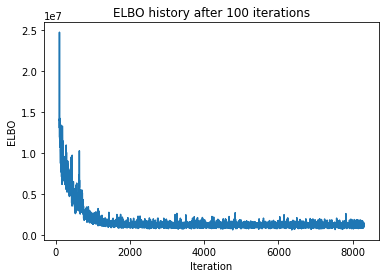

In [21]:
plot_elbo(ELBO_hist, num_layers = 5, xmin = 100)

In [22]:
obs_times, obs_means_CON, obs_error_CON = csv_to_obs_df('y_from_x_t_5000_dt_0-01.csv', state_dim_SCON, t, obs_error_scale)

In [23]:
obs_model_CON_noCO2 = ObsModel(DEVICE = devi, TIMES = obs_times, DT = dt_flow, MU = obs_means_CON, SCALE = obs_error_CON)

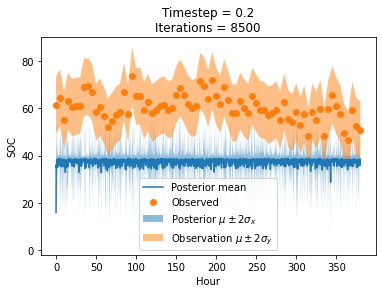

In [24]:
plot_post(x, obs_model_CON_noCO2, 5, niter, dt_flow, state_idx = 0)